In [2]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [3]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [4]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [5]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run2"
    model = EEGNet_IE_HP_Wrapper(DEVICE, classifier, input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_IE_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7187887932740006


Iterations:   0%|                                   | 1/300 [00:03<16:30,  3.31s/it]

Epoch:  0
t_loss:  0.7187887932740006 , v_loss:  0.6870031356811523
t_acc:  0.5026455026455027 , v_acc:  0.6583850931677019
t_recall:  0.5139779854792002 , v_recall:  0.5159459459459459
t_prec:  0.5118647826022797 , v_prec:  0.5328020756115641
t_f:  0.48746261564692406 , v_f:  0.4927536231884058
////////


Iterations:   1%|▏                                  | 2/300 [00:04<09:00,  1.81s/it]

Epoch  1 , loss 0.678608986676908
Epoch  2 , loss 0.655304818761115


Iterations:   1%|▎                                  | 3/300 [00:05<07:45,  1.57s/it]

Epoch:  2
t_loss:  0.655304818761115 , v_loss:  0.6756054560343424
t_acc:  0.578275754746343 , v_acc:  0.6770186335403726
t_recall:  0.5254978657992616 , v_recall:  0.501981981981982
t_prec:  0.5235746263353626 , v_prec:  0.5118279569892473
t_f:  0.5229716476125162 , v_f:  0.43796992481203006
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:05,  1.24s/it]

Epoch  3 , loss 0.6327469629399917
Epoch  4 , loss 0.6051731693978403


Iterations:   2%|▌                                  | 5/300 [00:07<06:06,  1.24s/it]

Epoch:  4
t_loss:  0.6051731693978403 , v_loss:  0.6649429400761923
t_acc:  0.6258948023653906 , v_acc:  0.6770186335403726
t_recall:  0.5157333827424823 , v_recall:  0.501981981981982
t_prec:  0.5199233319159142 , v_prec:  0.5118279569892473
t_f:  0.5118502545642073 , v_f:  0.43796992481203006
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:14,  1.07s/it]

Epoch  5 , loss 0.5913067191254859
Epoch  6 , loss 0.5699857052634744


Iterations:   2%|▊                                  | 7/300 [00:09<05:32,  1.13s/it]

Epoch:  6
t_loss:  0.5699857052634744 , v_loss:  0.6553887724876404
t_acc:  0.6623093681917211 , v_acc:  0.6894409937888198
t_recall:  0.513729567258204 , v_recall:  0.510990990990991
t_prec:  0.5285967891324482 , v_prec:  0.5971337579617835
t_f:  0.4904407905209056 , v_f:  0.4437534549474848
////////


Iterations:   3%|▉                                  | 8/300 [00:10<04:56,  1.02s/it]

Epoch  7 , loss 0.5545885843389174
Epoch  8 , loss 0.5386586370421391


Iterations:   3%|█                                  | 9/300 [00:11<05:18,  1.09s/it]

Epoch:  8
t_loss:  0.5386586370421391 , v_loss:  0.6496353546778361
t_acc:  0.6862745098039216 , v_acc:  0.6832298136645962
t_recall:  0.518591564760297 , v_recall:  0.4954954954954955
t_prec:  0.56560420507489 , v_prec:  0.34375
t_f:  0.47817781535828086 , v_f:  0.40590405904059035
////////


Iterations:   3%|█▏                                | 10/300 [00:12<04:45,  1.01it/s]

Epoch  9 , loss 0.5275582864004023
Epoch  10 , loss 0.5128797795258316


Iterations:   4%|█▏                                | 11/300 [00:13<05:10,  1.08s/it]

Epoch:  10
t_loss:  0.5128797795258316 , v_loss:  0.647763709227244
t_acc:  0.6862745098039216 , v_acc:  0.6894409937888198
t_recall:  0.509390483248926 , v_recall:  0.5
t_prec:  0.5470691292004715 , v_prec:  0.3447204968944099
t_f:  0.45501319261213713 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:14<04:39,  1.03it/s]

Epoch  11 , loss 0.5014692907239876
Epoch  12 , loss 0.4962338092280369


Iterations:   4%|█▍                                | 13/300 [00:15<05:02,  1.06s/it]

Epoch:  12
t_loss:  0.4962338092280369 , v_loss:  0.6479450563589731
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5072837320377156 , v_recall:  0.5
t_prec:  0.576653089522489 , v_prec:  0.3447204968944099
t_f:  0.4373198016376427 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:16<04:32,  1.05it/s]

Epoch  13 , loss 0.48887454353126825
Epoch  14 , loss 0.4812183269098693


Iterations:   5%|█▋                                | 15/300 [00:17<04:55,  1.04s/it]

Epoch:  14
t_loss:  0.4812183269098693 , v_loss:  0.649589349826177
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5063257435390676 , v_recall:  0.5
t_prec:  0.5991637740612181 , v_prec:  0.3447204968944099
t_f:  0.43103789176966834 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:18<04:27,  1.06it/s]

Epoch  15 , loss 0.4771970779288049
Epoch  16 , loss 0.4776691765177484


Iterations:   6%|█▉                                | 17/300 [00:19<04:50,  1.02s/it]

Epoch:  16
t_loss:  0.4776691765177484 , v_loss:  0.6512853105862936
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5028115178216055 , v_recall:  0.5
t_prec:  0.6131101376720901 , v_prec:  0.3447204968944099
t_f:  0.4190986232950797 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:20<04:25,  1.06it/s]

Epoch  17 , loss 0.47273390959290895
Epoch  18 , loss 0.46826701655107383


Iterations:   6%|██▏                               | 19/300 [00:21<04:52,  1.04s/it]

Epoch:  18
t_loss:  0.46826701655107383 , v_loss:  0.6546951333681742
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.5007342748521156 , v_recall:  0.5
t_prec:  0.521875425923402 , v_prec:  0.3447204968944099
t_f:  0.41720859785375913 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:24,  1.06it/s]

Epoch  19 , loss 0.46033605231958274
Epoch  20 , loss 0.4572233312270221


Iterations:   7%|██▍                               | 21/300 [00:23<04:52,  1.05s/it]

Epoch:  20
t_loss:  0.4572233312270221 , v_loss:  0.6567367811997732
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5022364502271449 , v_recall:  0.5
t_prec:  0.6175120192307693 , v_prec:  0.3447204968944099
t_f:  0.41718316736553546 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:23,  1.05it/s]

Epoch  21 , loss 0.45801454256562624
Epoch  22 , loss 0.4553716936532189


Iterations:   8%|██▌                               | 23/300 [00:25<04:44,  1.03s/it]

Epoch:  22
t_loss:  0.4553716936532189 , v_loss:  0.6582648654778799
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5001914604520937 , v_recall:  0.5
t_prec:  0.5145131086142322 , v_prec:  0.3447204968944099
t_f:  0.4128574949243642 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:18,  1.07it/s]

Epoch  23 , loss 0.4552052599542281
Epoch  24 , loss 0.45013584225785497


Iterations:   8%|██▊                               | 25/300 [00:27<04:40,  1.02s/it]

Epoch:  24
t_loss:  0.45013584225785497 , v_loss:  0.6600398818651835
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5006388877451586 , v_recall:  0.5
t_prec:  0.5622270742358079 , v_prec:  0.3447204968944099
t_f:  0.41308060533064894 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:17,  1.07it/s]

Epoch  25 , loss 0.45093394669831965
Epoch  26 , loss 0.4498046636581421


Iterations:   9%|███                               | 27/300 [00:29<04:39,  1.02s/it]

Epoch:  26
t_loss:  0.4498046636581421 , v_loss:  0.6613551576932272
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5004151740986261 , v_recall:  0.5
t_prec:  0.5353939157566303 , v_prec:  0.3447204968944099
t_f:  0.41296906693711966 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:14,  1.07it/s]

Epoch  27 , loss 0.45508838517993105
Epoch  28 , loss 0.4489855503334719


Iterations:  10%|███▎                              | 29/300 [00:31<04:41,  1.04s/it]

Epoch:  28
t_loss:  0.4489855503334719 , v_loss:  0.6624882519245148
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5013100286847559 , v_recall:  0.5
t_prec:  0.7230835151137426 , v_prec:  0.3447204968944099
t_f:  0.4134150192068549 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:15,  1.06it/s]

Epoch  29 , loss 0.4510025405416302
Epoch  30 , loss 0.4452814979880464


Iterations:  10%|███▌                              | 31/300 [00:33<04:37,  1.03s/it]

Epoch:  30
t_loss:  0.4452814979880464 , v_loss:  0.6595554600159327
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5028437710160443 , v_recall:  0.5
t_prec:  0.7769806612601372 , v_prec:  0.3447204968944099
t_f:  0.41667765984343347 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:11,  1.07it/s]

Epoch  31 , loss 0.4455600328305188
Epoch  32 , loss 0.44860297850534026


Iterations:  11%|███▋                              | 33/300 [00:35<04:33,  1.02s/it]

Epoch:  32
t_loss:  0.44860297850534026 , v_loss:  0.6579234848419825
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:08,  1.07it/s]

Epoch  33 , loss 0.44736403752775755
Epoch  34 , loss 0.4500657214837916


Iterations:  12%|███▉                              | 35/300 [00:36<04:30,  1.02s/it]

Epoch:  34
t_loss:  0.4500657214837916 , v_loss:  0.6521440098683039
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:37<04:06,  1.07it/s]

Epoch  35 , loss 0.44176697263530657
Epoch  36 , loss 0.437293375824012


Iterations:  12%|████▏                             | 37/300 [00:38<04:33,  1.04s/it]

Epoch:  36
t_loss:  0.437293375824012 , v_loss:  0.6463366250197092
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5018212761285187 , v_recall:  0.5
t_prec:  0.7481920199501246 , v_prec:  0.3447204968944099
t_f:  0.4145045976343382 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:08,  1.05it/s]

Epoch  37 , loss 0.4419449164586909
Epoch  38 , loss 0.4398832718531291


Iterations:  13%|████▍                             | 39/300 [00:40<04:29,  1.03s/it]

Epoch:  38
t_loss:  0.4398832718531291 , v_loss:  0.6418314526478449
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.4999677468055613 , v_recall:  0.5
t_prec:  0.49779893849516077 , v_prec:  0.3447204968944099
t_f:  0.41274588925137695 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:04,  1.06it/s]

Epoch  39 , loss 0.44519320773143395
Epoch  40 , loss 0.4395623779764362


Iterations:  14%|████▋                             | 41/300 [00:42<04:28,  1.04s/it]

Epoch:  40
t_loss:  0.4395623779764362 , v_loss:  0.6388934900363287
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.502108809925749 , v_recall:  0.5
t_prec:  0.7053961322520275 , v_prec:  0.3447204968944099
t_f:  0.41547864167250537 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:04,  1.05it/s]

Epoch  41 , loss 0.4410070449698205
Epoch  42 , loss 0.4338778917695962


Iterations:  14%|████▊                             | 43/300 [00:44<04:27,  1.04s/it]

Epoch:  42
t_loss:  0.4338778917695962 , v_loss:  0.6361087312301
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5057513621827864 , v_recall:  0.5
t_prec:  0.7313829787234043 , v_prec:  0.3447204968944099
t_f:  0.42385523641037076 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:03,  1.05it/s]

Epoch  43 , loss 0.443358134989645
Epoch  44 , loss 0.43404533933190736


Iterations:  15%|█████                             | 45/300 [00:46<04:26,  1.04s/it]

Epoch:  44
t_loss:  0.43404533933190736 , v_loss:  0.6303441574176153
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:03,  1.05it/s]

Epoch  45 , loss 0.43201823766325037
Epoch  46 , loss 0.44093876843358953


Iterations:  16%|█████▎                            | 47/300 [00:48<04:21,  1.03s/it]

Epoch:  46
t_loss:  0.44093876843358953 , v_loss:  0.62403604388237
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5041215465063614 , v_recall:  0.5
t_prec:  0.6343984962406015 , v_prec:  0.3447204968944099
t_f:  0.422183377407258 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<03:58,  1.06it/s]

Epoch  47 , loss 0.4369782431452882
Epoch  48 , loss 0.4360525941147524


Iterations:  16%|█████▌                            | 49/300 [00:50<04:20,  1.04s/it]

Epoch:  48
t_loss:  0.4360525941147524 , v_loss:  0.6205630153417587
t_acc:  0.6993464052287581 , v_acc:  0.6894409937888198
t_recall:  0.5078601721085354 , v_recall:  0.5
t_prec:  0.7244825964252117 , v_prec:  0.3447204968944099
t_f:  0.42891539928991573 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:56,  1.06it/s]

Epoch  49 , loss 0.4382374835949318
Epoch  50 , loss 0.4312356494221033


Iterations:  17%|█████▊                            | 51/300 [00:52<04:18,  1.04s/it]

Epoch:  50
t_loss:  0.4312356494221033 , v_loss:  0.6171118418375651
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5047926874459587 , v_recall:  0.5
t_prec:  0.6821596244131456 , v_prec:  0.3447204968944099
t_f:  0.4225454303401451 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:56,  1.05it/s]

Epoch  51 , loss 0.43048229755139816
Epoch  52 , loss 0.4353741477517521


Iterations:  18%|██████                            | 53/300 [00:54<04:21,  1.06s/it]

Epoch:  52
t_loss:  0.4353741477517521 , v_loss:  0.6116882860660553
t_acc:  0.6962340491752257 , v_acc:  0.6956521739130435
t_recall:  0.5041853666570594 , v_recall:  0.51
t_prec:  0.6195319849482597 , v_prec:  0.846875
t_f:  0.42300355042128135 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:01,  1.02it/s]

Epoch  53 , loss 0.43338504316760046
Epoch  54 , loss 0.4389555226354038


Iterations:  18%|██████▏                           | 55/300 [00:57<04:23,  1.08s/it]

Epoch:  54
t_loss:  0.4389555226354038 , v_loss:  0.6104191392660141
t_acc:  0.6953003423591659 , v_acc:  0.6956521739130435
t_recall:  0.5020765567313102 , v_recall:  0.51
t_prec:  0.5835419274092616 , v_prec:  0.846875
t_f:  0.41790947001625695 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:01,  1.01it/s]

Epoch  55 , loss 0.4322132468223572
Epoch  56 , loss 0.43312818221017424


Iterations:  19%|██████▍                           | 57/300 [00:59<04:26,  1.10s/it]

Epoch:  56
t_loss:  0.43312818221017424 , v_loss:  0.6070808072884878
t_acc:  0.6949891067538126 , v_acc:  0.7018633540372671
t_recall:  0.5030029782736992 , v_recall:  0.52
t_prec:  0.5792160459559268 , v_prec:  0.8490566037735849
t_f:  0.4215796349827543 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:03,  1.01s/it]

Epoch  57 , loss 0.43352921219433055
Epoch  58 , loss 0.428450158998078


Iterations:  20%|██████▋                           | 59/300 [01:01<04:20,  1.08s/it]

Epoch:  58
t_loss:  0.428450158998078 , v_loss:  0.6045434723297755
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5054953953418152 , v_recall:  0.51
t_prec:  0.6346938775510205 , v_prec:  0.846875
t_f:  0.42605217404062706 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<04:03,  1.01s/it]

Epoch  59 , loss 0.4316759430894665
Epoch  60 , loss 0.43614979234396245


Iterations:  20%|██████▉                           | 61/300 [01:03<04:21,  1.10s/it]

Epoch:  60
t_loss:  0.43614979234396245 , v_loss:  0.6036847283442816
t_acc:  0.6959228135698724 , v_acc:  0.6956521739130435
t_recall:  0.5033865854160662 , v_recall:  0.51
t_prec:  0.6104323308270676 , v_prec:  0.846875
t_f:  0.4209981125404011 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [01:04<04:13,  1.07s/it]

Epoch  61 , loss 0.42505799263131383
Epoch  62 , loss 0.42641136926763196


Iterations:  21%|███████▏                          | 63/300 [01:05<04:26,  1.13s/it]

Epoch:  62
t_loss:  0.42641136926763196 , v_loss:  0.6009594450394312
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.506454070078643 , v_recall:  0.52
t_prec:  0.6639987445072191 , v_prec:  0.8490566037735849
t_f:  0.42735630095234944 , v_f:  0.44957264957264953
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<04:09,  1.06s/it]

Epoch  63 , loss 0.4293757934196323
Epoch  64 , loss 0.43381088037116855


Iterations:  22%|███████▎                          | 65/300 [01:07<04:24,  1.13s/it]

Epoch:  64
t_loss:  0.43381088037116855 , v_loss:  0.5971375753482183
t_acc:  0.6971677559912854 , v_acc:  0.7018633540372671
t_recall:  0.5062941765828083 , v_recall:  0.52
t_prec:  0.6394740577036151 , v_prec:  0.8490566037735849
t_f:  0.42802958714014333 , v_f:  0.44957264957264953
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<04:08,  1.06s/it]

Epoch  65 , loss 0.42706102074361313
Epoch  66 , loss 0.4340996777310091


Iterations:  22%|███████▌                          | 67/300 [01:09<04:20,  1.12s/it]

Epoch:  66
t_loss:  0.4340996777310091 , v_loss:  0.5959881693124771
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5087865936509244 , v_recall:  0.53
t_prec:  0.6830188679245283 , v_prec:  0.8512658227848101
t_f:  0.432471621032904 , v_f:  0.4692431787893666
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:57,  1.02s/it]

Epoch  67 , loss 0.42584453201761435
Epoch  68 , loss 0.42486729224522907


Iterations:  23%|███████▊                          | 69/300 [01:12<04:12,  1.09s/it]

Epoch:  68
t_loss:  0.42486729224522907 , v_loss:  0.5945433924595515
t_acc:  0.7018362900715842 , v_acc:  0.7080745341614907
t_recall:  0.5125252192530984 , v_recall:  0.53
t_prec:  0.7393767705382437 , v_prec:  0.8512658227848101
t_f:  0.4391063907949462 , v_f:  0.4692431787893666
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:48,  1.01it/s]

Epoch  69 , loss 0.4273547872024424
Epoch  70 , loss 0.43720481617777956


Iterations:  24%|████████                          | 71/300 [01:14<04:07,  1.08s/it]

Epoch:  70
t_loss:  0.43720481617777956 , v_loss:  0.5953057010968527
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5065178902293408 , v_recall:  0.51
t_prec:  0.6491988689915174 , v_prec:  0.846875
t_f:  0.428156146179402 , v_f:  0.42920193907821425
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:47,  1.00it/s]

Epoch  71 , loss 0.4260518013262281
Epoch  72 , loss 0.4260376948936313


Iterations:  24%|████████▎                         | 73/300 [01:16<04:12,  1.11s/it]

Epoch:  72
t_loss:  0.4260376948936313 , v_loss:  0.5922330617904663
t_acc:  0.6974789915966386 , v_acc:  0.7018633540372671
t_recall:  0.5079555592154925 , v_recall:  0.52
t_prec:  0.6370115033091711 , v_prec:  0.8490566037735849
t_f:  0.43272645633043094 , v_f:  0.44957264957264953
////////


Iterations:  25%|████████▍                         | 74/300 [01:17<03:51,  1.03s/it]

Epoch  73 , loss 0.42634224015123706
Epoch  74 , loss 0.4232084242736592


Iterations:  25%|████████▌                         | 75/300 [01:18<04:14,  1.13s/it]

Epoch:  74
t_loss:  0.4232084242736592 , v_loss:  0.5912150243918101
t_acc:  0.7012138188608776 , v_acc:  0.7080745341614907
t_recall:  0.5123653257572638 , v_recall:  0.53
t_prec:  0.7129569807752916 , v_prec:  0.8512658227848101
t_f:  0.4397298334127713 , v_f:  0.4692431787893666
////////


Iterations:  25%|████████▌                         | 76/300 [01:19<03:58,  1.06s/it]

Epoch  75 , loss 0.4271867316143185
Epoch  76 , loss 0.4190290877047707


Iterations:  26%|████████▋                         | 77/300 [01:20<04:26,  1.19s/it]

Epoch:  76
t_loss:  0.4190290877047707 , v_loss:  0.587140291929245
t_acc:  0.6984126984126984 , v_acc:  0.7204968944099379
t_recall:  0.5094893015467808 , v_recall:  0.55
t_prec:  0.6521678526887242 , v_prec:  0.8557692307692308
t_f:  0.4358260072247829 , v_f:  0.5066394279877425
////////


Iterations:  26%|████████▊                         | 78/300 [01:21<04:10,  1.13s/it]

Epoch  77 , loss 0.4272329859873828
Epoch  78 , loss 0.42649835289693344


Iterations:  26%|████████▉                         | 79/300 [01:23<04:31,  1.23s/it]

Epoch:  78
t_loss:  0.42649835289693344 , v_loss:  0.5849880774815878
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5128765732010266 , v_recall:  0.55
t_prec:  0.716421123858149 , v_prec:  0.8557692307692308
t_f:  0.44075928906173856 , v_f:  0.5066394279877425
////////


Iterations:  27%|█████████                         | 80/300 [01:24<04:16,  1.16s/it]

Epoch  79 , loss 0.42700520683737364
Epoch  80 , loss 0.42189473030613917


Iterations:  27%|█████████▏                        | 81/300 [01:25<04:31,  1.24s/it]

Epoch:  80
t_loss:  0.42189473030613917 , v_loss:  0.5835675845543543
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5136431012475811 , v_recall:  0.55
t_prec:  0.6748179803735359 , v_prec:  0.8557692307692308
t_f:  0.4447415733243656 , v_f:  0.5066394279877425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:26<04:07,  1.13s/it]

Epoch  81 , loss 0.4243274851172578
Epoch  82 , loss 0.418639121686711


Iterations:  28%|█████████▍                        | 83/300 [01:27<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.418639121686711 , v_loss:  0.5799657106399536
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5151768435788694 , v_recall:  0.55
t_prec:  0.6844106463878327 , v_prec:  0.8557692307692308
t_f:  0.44777043865379496 , v_f:  0.5066394279877425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:28<03:53,  1.08s/it]

Epoch  83 , loss 0.4224657387125726
Epoch  84 , loss 0.4202461961437674


Iterations:  28%|█████████▋                        | 85/300 [01:30<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4202461961437674 , v_loss:  0.5799121459325155
t_acc:  0.7037037037037037 , v_acc:  0.7204968944099379
t_recall:  0.5176054404962874 , v_recall:  0.55
t_prec:  0.7176710484637314 , v_prec:  0.8557692307692308
t_f:  0.4513729057734361 , v_f:  0.5066394279877425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:30<03:36,  1.01s/it]

Epoch  85 , loss 0.43287794204319224
Epoch  86 , loss 0.4238993204107471


Iterations:  29%|█████████▊                        | 87/300 [01:32<04:01,  1.13s/it]

Epoch:  86
t_loss:  0.4238993204107471 , v_loss:  0.5779557277758917
t_acc:  0.6999688764394647 , v_acc:  0.7267080745341615
t_recall:  0.5129081401572858 , v_recall:  0.56
t_prec:  0.665400443178221 , v_prec:  0.8580645161290323
t_f:  0.44358718990092355 , v_f:  0.5244360902255639
////////


Iterations:  29%|█████████▉                        | 88/300 [01:32<03:39,  1.04s/it]

Epoch  87 , loss 0.42333157389771703
Epoch  88 , loss 0.4258541663487752


Iterations:  30%|██████████                        | 89/300 [01:34<04:03,  1.16s/it]

Epoch:  88
t_loss:  0.4258541663487752 , v_loss:  0.5767150372266769
t_acc:  0.7015250544662309 , v_acc:  0.7391304347826086
t_recall:  0.5169020463622515 , v_recall:  0.58
t_prec:  0.6703036840358447 , v_prec:  0.8627450980392157
t_f:  0.45288186947968617 , v_f:  0.5583855799373041
////////


Iterations:  30%|██████████▏                       | 90/300 [01:35<03:35,  1.03s/it]

Epoch  89 , loss 0.4253376400938221
Epoch  90 , loss 0.42376508198532403


Iterations:  30%|██████████▎                       | 91/300 [01:36<03:59,  1.14s/it]

Epoch:  90
t_loss:  0.42376508198532403 , v_loss:  0.5750081390142441
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5187240087289496 , v_recall:  0.5754954954954955
t_prec:  0.7537950664136622 , v_prec:  0.8062865497076024
t_f:  0.4521105829769373 , v_f:  0.5538441709093253
////////


Iterations:  31%|██████████▍                       | 92/300 [01:37<03:35,  1.04s/it]

Epoch  91 , loss 0.42317474122140925
Epoch  92 , loss 0.42523753233984407


Iterations:  31%|██████████▌                       | 93/300 [01:38<03:49,  1.11s/it]

Epoch:  92
t_loss:  0.42523753233984407 , v_loss:  0.5728190690279007
t_acc:  0.7037037037037037 , v_acc:  0.7391304347826086
t_recall:  0.5184680418879785 , v_recall:  0.5854954954954955
t_prec:  0.7066317912388285 , v_prec:  0.8142384105960265
t_f:  0.45393041789254196 , v_f:  0.5698473282442748
////////


Iterations:  31%|██████████▋                       | 94/300 [01:39<03:35,  1.05s/it]

Epoch  93 , loss 0.4210168660855761
Epoch  94 , loss 0.41995834719900993


Iterations:  32%|██████████▊                       | 95/300 [01:40<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.41995834719900993 , v_loss:  0.5730272829532623
t_acc:  0.7046374105197635 , v_acc:  0.7391304347826086
t_recall:  0.5194267166248061 , v_recall:  0.5854954954954955
t_prec:  0.7208511899808605 , v_prec:  0.8142384105960265
t_f:  0.45522845519986893 , v_f:  0.5698473282442748
////////


Iterations:  32%|██████████▉                       | 96/300 [01:41<03:42,  1.09s/it]

Epoch  95 , loss 0.427788353433796
Epoch  96 , loss 0.4195734396869061


Iterations:  32%|██████████▉                       | 97/300 [01:43<03:51,  1.14s/it]

Epoch:  96
t_loss:  0.4195734396869061 , v_loss:  0.5739401678244272
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.516582945608762 , v_recall:  0.5954954954954955
t_prec:  0.7124881291547958 , v_prec:  0.8212121212121212
t_f:  0.4493591070181338 , v_f:  0.5853903649268262
////////


Iterations:  33%|███████████                       | 98/300 [01:44<03:35,  1.07s/it]

Epoch  97 , loss 0.41917478921366674
Epoch  98 , loss 0.41748643213627384


Iterations:  33%|███████████▏                      | 99/300 [01:45<03:48,  1.14s/it]

Epoch:  98
t_loss:  0.41748643213627384 , v_loss:  0.571019783616066
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5185002950824172 , v_recall:  0.5954954954954955
t_prec:  0.7460181782785389 , v_prec:  0.8212121212121212
t_f:  0.45196297868971613 , v_f:  0.5853903649268262
////////


Iterations:  33%|███████████                      | 100/300 [01:46<03:33,  1.07s/it]

Epoch  99 , loss 0.4194688598314921
Epoch  100 , loss 0.4182594149720435


Iterations:  34%|███████████                      | 101/300 [01:47<03:44,  1.13s/it]

Epoch:  100
t_loss:  0.4182594149720435 , v_loss:  0.5712258964776993
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5268717146347154 , v_recall:  0.5954954954954955
t_prec:  0.7432455936920223 , v_prec:  0.8212121212121212
t_f:  0.4698305186445374 , v_f:  0.5853903649268262
////////


Iterations:  34%|███████████▏                     | 102/300 [01:48<03:25,  1.04s/it]

Epoch  101 , loss 0.41944953098016624
Epoch  102 , loss 0.41928589694640217


Iterations:  34%|███████████▎                     | 103/300 [01:49<03:38,  1.11s/it]

Epoch:  102
t_loss:  0.41928589694640217 , v_loss:  0.5715807676315308
t_acc:  0.7024587612822907 , v_acc:  0.7329192546583851
t_recall:  0.5172856535046183 , v_recall:  0.5809909909909909
t_prec:  0.6874776714830104 , v_prec:  0.7724242424242425
t_f:  0.4524852195885727 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▍                     | 104/300 [01:50<03:19,  1.02s/it]

Epoch  103 , loss 0.4157625594559838
Epoch  104 , loss 0.42122387652303656


Iterations:  35%|███████████▌                     | 105/300 [01:51<03:35,  1.10s/it]

Epoch:  104
t_loss:  0.42122387652303656 , v_loss:  0.5713197340567907
t_acc:  0.7052598817304699 , v_acc:  0.7329192546583851
t_recall:  0.5201616777151014 , v_recall:  0.5809909909909909
t_prec:  0.7292065407339602 , v_prec:  0.7724242424242425
t_f:  0.4563765511846953 , v_f:  0.5651655046793542
////////


Iterations:  35%|███████████▋                     | 106/300 [01:52<03:13,  1.01it/s]

Epoch  105 , loss 0.41630619705892075
Epoch  106 , loss 0.41657571465361354


Iterations:  36%|███████████▊                     | 107/300 [01:53<03:29,  1.09s/it]

Epoch:  106
t_loss:  0.41657571465361354 , v_loss:  0.5696563820044199
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5213756330547206 , v_recall:  0.590990990990991
t_prec:  0.7066021967526266 , v_prec:  0.7824384787472036
t_f:  0.4604017857142857 , v_f:  0.5805210918114144
////////


Iterations:  36%|███████████▉                     | 108/300 [01:54<03:11,  1.00it/s]

Epoch  107 , loss 0.421138021291471
Epoch  108 , loss 0.4219270792661929


Iterations:  36%|███████████▉                     | 109/300 [01:55<03:27,  1.09s/it]

Epoch:  108
t_loss:  0.4219270792661929 , v_loss:  0.5695656538009644
t_acc:  0.7018362900715842 , v_acc:  0.7391304347826086
t_recall:  0.5142504220364804 , v_recall:  0.590990990990991
t_prec:  0.7050355450236967 , v_prec:  0.7824384787472036
t_f:  0.44443469785575046 , v_f:  0.5805210918114144
////////


Iterations:  37%|████████████                     | 110/300 [01:56<03:14,  1.02s/it]

Epoch  109 , loss 0.4236162386688532
Epoch  110 , loss 0.42387468908347337


Iterations:  37%|████████████▏                    | 111/300 [01:58<03:34,  1.13s/it]

Epoch:  110
t_loss:  0.42387468908347337 , v_loss:  0.566182424624761
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5204492115123317 , v_recall:  0.590990990990991
t_prec:  0.7252380952380952 , v_prec:  0.7824384787472036
t_f:  0.4572194616811026 , v_f:  0.5805210918114144
////////


Iterations:  37%|████████████▎                    | 112/300 [01:59<03:24,  1.09s/it]

Epoch  111 , loss 0.4247792415759143
Epoch  112 , loss 0.4218606685890871


Iterations:  38%|████████████▍                    | 113/300 [02:00<03:43,  1.19s/it]

Epoch:  112
t_loss:  0.4218606685890871 , v_loss:  0.5655490358670553
t_acc:  0.7005913476501712 , v_acc:  0.7391304347826086
t_recall:  0.5165184392198845 , v_recall:  0.590990990990991
t_prec:  0.6554398457074468 , v_prec:  0.7824384787472036
t_f:  0.45327064120869254 , v_f:  0.5805210918114144
////////


Iterations:  38%|████████████▌                    | 114/300 [02:01<03:24,  1.10s/it]

Epoch  113 , loss 0.4170056756804971
Epoch  114 , loss 0.4179181216978559


Iterations:  38%|████████████▋                    | 115/300 [02:02<03:43,  1.21s/it]

Epoch:  114
t_loss:  0.4179181216978559 , v_loss:  0.5639139463504156
t_acc:  0.708994708994709 , v_acc:  0.7391304347826086
t_recall:  0.5274467822291761 , v_recall:  0.590990990990991
t_prec:  0.7364836100468284 , v_prec:  0.7824384787472036
t_f:  0.47143940701517145 , v_f:  0.5805210918114144
////////


Iterations:  39%|████████████▊                    | 116/300 [02:03<03:28,  1.13s/it]

Epoch  115 , loss 0.4131261127836564
Epoch  116 , loss 0.42133307632277994


Iterations:  39%|████████████▊                    | 117/300 [02:05<03:47,  1.24s/it]

Epoch:  116
t_loss:  0.42133307632277994 , v_loss:  0.5650607099135717
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5215670935068143 , v_recall:  0.590990990990991
t_prec:  0.685823754789272 , v_prec:  0.7824384787472036
t_f:  0.46239451986248986 , v_f:  0.5805210918114144
////////


Iterations:  39%|████████████▉                    | 118/300 [02:06<03:28,  1.14s/it]

Epoch  117 , loss 0.4240461073669733
Epoch  118 , loss 0.41570206191025527


Iterations:  40%|█████████████                    | 119/300 [02:07<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.41570206191025527 , v_loss:  0.5643231570720673
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5205130316630296 , v_recall:  0.590990990990991
t_prec:  0.7158765924256868 , v_prec:  0.7824384787472036
t_f:  0.45790566255333864 , v_f:  0.5805210918114144
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:08<03:26,  1.15s/it]

Epoch  119 , loss 0.4138464880924599
Epoch  120 , loss 0.424113706630819


Iterations:  40%|█████████████▎                   | 121/300 [02:10<03:45,  1.26s/it]

Epoch:  120
t_loss:  0.424113706630819 , v_loss:  0.5662468622128168
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5233245494846351 , v_recall:  0.590990990990991
t_prec:  0.696248893336926 , v_prec:  0.7824384787472036
t_f:  0.4654656801817905 , v_f:  0.5805210918114144
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:11<03:29,  1.18s/it]

Epoch  121 , loss 0.4174445826633304
Epoch  122 , loss 0.41543878235068976


Iterations:  41%|█████████████▌                   | 123/300 [02:12<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.41543878235068976 , v_loss:  0.5669114788373312
t_acc:  0.7074385309679427 , v_acc:  0.7391304347826086
t_recall:  0.5237404098214409 , v_recall:  0.590990990990991
t_prec:  0.7426470588235294 , v_prec:  0.7824384787472036
t_f:  0.4633086212656464 , v_f:  0.5805210918114144
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:13<03:28,  1.19s/it]

Epoch  123 , loss 0.4209764517989813
Epoch  124 , loss 0.418873563116672


Iterations:  42%|█████████████▊                   | 125/300 [02:15<03:46,  1.29s/it]

Epoch:  124
t_loss:  0.418873563116672 , v_loss:  0.5674466987450918
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5245707580186931 , v_recall:  0.590990990990991
t_prec:  0.7043384467881112 , v_prec:  0.7824384787472036
t_f:  0.4675615212527965 , v_f:  0.5805210918114144
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:16<03:29,  1.21s/it]

Epoch  125 , loss 0.4187879574065115
Epoch  126 , loss 0.4183301382205066


Iterations:  42%|█████████████▉                   | 127/300 [02:17<03:40,  1.28s/it]

Epoch:  126
t_loss:  0.4183301382205066 , v_loss:  0.5680355578660965
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5213756330547206 , v_recall:  0.590990990990991
t_prec:  0.7066021967526266 , v_prec:  0.7824384787472036
t_f:  0.4604017857142857 , v_f:  0.5805210918114144
////////


Iterations:  43%|██████████████                   | 128/300 [02:18<03:22,  1.18s/it]

Epoch  127 , loss 0.4185271304027707
Epoch  128 , loss 0.4175486120523191


Iterations:  43%|██████████████▏                  | 129/300 [02:19<03:34,  1.25s/it]

Epoch:  128
t_loss:  0.4175486120523191 , v_loss:  0.5661770701408386
t_acc:  0.7058823529411765 , v_acc:  0.7391304347826086
t_recall:  0.5229093753860089 , v_recall:  0.590990990990991
t_prec:  0.7127724665391969 , v_prec:  0.7824384787472036
t_f:  0.4633423527895889 , v_f:  0.5805210918114144
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:20<03:19,  1.17s/it]

Epoch  129 , loss 0.4152612990024043
Epoch  130 , loss 0.415859099112305


Iterations:  44%|██████████████▍                  | 131/300 [02:22<03:31,  1.25s/it]

Epoch:  130
t_loss:  0.415859099112305 , v_loss:  0.5648735562960306
t_acc:  0.7037037037037037 , v_acc:  0.7453416149068323
t_recall:  0.5204807784685909 , v_recall:  0.600990990990991
t_prec:  0.6877736858882941 , v_prec:  0.7913201663201663
t_f:  0.45977950183748467 , v_f:  0.5954525954525954
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:23<03:11,  1.14s/it]

Epoch  131 , loss 0.4143237757916544
Epoch  132 , loss 0.41614173557244094


Iterations:  44%|██████████████▋                  | 133/300 [02:24<03:20,  1.20s/it]

Epoch:  132
t_loss:  0.41614173557244094 , v_loss:  0.5643927653630575
t_acc:  0.702769996887644 , v_acc:  0.7391304347826086
t_recall:  0.5192345699345329 , v_recall:  0.590990990990991
t_prec:  0.678642447418738 , v_prec:  0.7824384787472036
t_f:  0.4576634358878915 , v_f:  0.5805210918114144
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:25<03:03,  1.10s/it]

Epoch  133 , loss 0.4155771746939304
Epoch  134 , loss 0.4123394787311554


Iterations:  45%|██████████████▊                  | 135/300 [02:26<03:15,  1.19s/it]

Epoch:  134
t_loss:  0.4123394787311554 , v_loss:  0.5656190862258276
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5198418907234322 , v_recall:  0.590990990990991
t_prec:  0.6999253235977432 , v_prec:  0.7824384787472036
t_f:  0.4574459414756846 , v_f:  0.5805210918114144
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:27<03:05,  1.13s/it]

Epoch  135 , loss 0.42043544030657004
Epoch  136 , loss 0.4138410798474854


Iterations:  46%|███████████████                  | 137/300 [02:29<03:15,  1.20s/it]

Epoch:  136
t_loss:  0.4138410798474854 , v_loss:  0.5632922152678171
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.518787142641468 , v_recall:  0.600990990990991
t_prec:  0.6700631957328386 , v_prec:  0.7913201663201663
t_f:  0.4573559426126442 , v_f:  0.5954525954525954
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:30<03:00,  1.11s/it]

Epoch  137 , loss 0.41304295495444654
Epoch  138 , loss 0.41244539238658606


Iterations:  46%|███████████████▎                 | 139/300 [02:31<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.41244539238658606 , v_loss:  0.5600507160027822
t_acc:  0.706504824151883 , v_acc:  0.7453416149068323
t_recall:  0.5253695392596862 , v_recall:  0.600990990990991
t_prec:  0.7039016480243563 , v_prec:  0.7913201663201663
t_f:  0.46932698597854616 , v_f:  0.5954525954525954
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:32<02:56,  1.10s/it]

Epoch  139 , loss 0.41340620143740786
Epoch  140 , loss 0.4192541942876928


Iterations:  47%|███████████████▌                 | 141/300 [02:33<03:06,  1.18s/it]

Epoch:  140
t_loss:  0.4192541942876928 , v_loss:  0.5613296578327814
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5228133020408724 , v_recall:  0.600990990990991
t_prec:  0.6942261102585475 , v_prec:  0.7913201663201663
t_f:  0.4644962341507324 , v_f:  0.5954525954525954
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:34<02:46,  1.05s/it]

Epoch  141 , loss 0.41058312151946275
Epoch  142 , loss 0.4179404751927245


Iterations:  48%|███████████████▋                 | 143/300 [02:35<02:54,  1.11s/it]

Epoch:  142
t_loss:  0.4179404751927245 , v_loss:  0.5598714053630829
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.5269355347854133 , v_recall:  0.600990990990991
t_prec:  0.7349046441110756 , v_prec:  0.7913201663201663
t_f:  0.47047264613659606 , v_f:  0.5954525954525954
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:36<02:38,  1.02s/it]

Epoch  143 , loss 0.41212478104759664
Epoch  144 , loss 0.4127080872947094


Iterations:  48%|███████████████▉                 | 145/300 [02:37<02:48,  1.09s/it]

Epoch:  144
t_loss:  0.4127080872947094 , v_loss:  0.5595021446545919
t_acc:  0.7055711173358232 , v_acc:  0.7453416149068323
t_recall:  0.5215355265505552 , v_recall:  0.600990990990991
t_prec:  0.7201112877583467 , v_prec:  0.7913201663201663
t_f:  0.4598829316141506 , v_f:  0.5954525954525954
////////


Iterations:  49%|████████████████                 | 146/300 [02:38<02:33,  1.01it/s]

Epoch  145 , loss 0.40835188300001857
Epoch  146 , loss 0.4107545766175962


Iterations:  49%|████████████████▏                | 147/300 [02:39<02:48,  1.10s/it]

Epoch:  146
t_loss:  0.4107545766175962 , v_loss:  0.557469959060351
t_acc:  0.711484593837535 , v_acc:  0.7515527950310559
t_recall:  0.5318242955765087 , v_recall:  0.610990990990991
t_prec:  0.7448504410387818 , v_prec:  0.7993197278911565
t_f:  0.4798949050864618 , v_f:  0.6099806201550388
////////


Iterations:  49%|████████████████▎                | 148/300 [02:40<02:34,  1.01s/it]

Epoch  147 , loss 0.41632982036646676
Epoch  148 , loss 0.4090147655384213


Iterations:  50%|████████████████▍                | 149/300 [02:42<02:49,  1.13s/it]

Epoch:  148
t_loss:  0.4090147655384213 , v_loss:  0.5571262637774149
t_acc:  0.708994708994709 , v_acc:  0.7515527950310559
t_recall:  0.5283093836208671 , v_recall:  0.610990990990991
t_prec:  0.7275299490369977 , v_prec:  0.7993197278911565
t_f:  0.4738289839766073 , v_f:  0.6099806201550388
////////


Iterations:  50%|████████████████▌                | 150/300 [02:42<02:34,  1.03s/it]

Epoch  149 , loss 0.41400660253038596
Epoch  150 , loss 0.41669803974675196


Iterations:  50%|████████████████▌                | 151/300 [02:44<02:53,  1.17s/it]

Epoch:  150
t_loss:  0.41669803974675196 , v_loss:  0.5569269508123398
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.5249543651610601 , v_recall:  0.610990990990991
t_prec:  0.7203113261654537 , v_prec:  0.7993197278911565
t_f:  0.46723957376106884 , v_f:  0.6099806201550388
////////


Iterations:  51%|████████████████▋                | 152/300 [02:45<02:34,  1.04s/it]

Epoch  151 , loss 0.4110299427719677
Epoch  152 , loss 0.4127863090412289


Iterations:  51%|████████████████▊                | 153/300 [02:46<02:48,  1.14s/it]

Epoch:  152
t_loss:  0.4127863090412289 , v_loss:  0.5580437233050665
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.525018185311758 , v_recall:  0.600990990990991
t_prec:  0.7129978733514579 , v_prec:  0.7913201663201663
t_f:  0.4678854984915506 , v_f:  0.5954525954525954
////////


Iterations:  51%|████████████████▉                | 154/300 [02:47<02:29,  1.02s/it]

Epoch  153 , loss 0.40948059219940036
Epoch  154 , loss 0.4078713883371914


Iterations:  52%|█████████████████                | 155/300 [02:48<02:39,  1.10s/it]

Epoch:  154
t_loss:  0.4078713883371914 , v_loss:  0.5580471058686575
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5271592484319457 , v_recall:  0.600990990990991
t_prec:  0.7397772895074843 , v_prec:  0.7913201663201663
t_f:  0.47063655841296426 , v_f:  0.5954525954525954
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:49<02:32,  1.06s/it]

Epoch  155 , loss 0.4086003145750831
Epoch  156 , loss 0.4127952471083286


Iterations:  52%|█████████████████▎               | 157/300 [02:50<02:39,  1.12s/it]

Epoch:  156
t_loss:  0.4127952471083286 , v_loss:  0.5573394944270452
t_acc:  0.7018362900715842 , v_acc:  0.7453416149068323
t_recall:  0.5188509627921659 , v_recall:  0.600990990990991
t_prec:  0.6643991382061922 , v_prec:  0.7913201663201663
t_f:  0.45802649038339643 , v_f:  0.5954525954525954
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:51<02:28,  1.05s/it]

Epoch  157 , loss 0.40929072920013876
Epoch  158 , loss 0.4134884634438683


Iterations:  53%|█████████████████▍               | 159/300 [02:52<02:38,  1.12s/it]

Epoch:  158
t_loss:  0.4134884634438683 , v_loss:  0.558596263329188
t_acc:  0.7096171802054155 , v_acc:  0.7453416149068323
t_recall:  0.5293318785083927 , v_recall:  0.600990990990991
t_prec:  0.7305978362514207 , v_prec:  0.7913201663201663
t_f:  0.47574305449774595 , v_f:  0.5954525954525954
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:53<02:22,  1.01s/it]

Epoch  159 , loss 0.41063420854362787
Epoch  160 , loss 0.4169750897323384


Iterations:  54%|█████████████████▋               | 161/300 [02:54<02:30,  1.08s/it]

Epoch:  160
t_loss:  0.4169750897323384 , v_loss:  0.5596319536368052
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5308971877959402 , v_recall:  0.600990990990991
t_prec:  0.706949806949807 , v_prec:  0.7913201663201663
t_f:  0.48083105603780135 , v_f:  0.5954525954525954
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:55<02:16,  1.01it/s]

Epoch  161 , loss 0.4084376067507501
Epoch  162 , loss 0.4130666314386854


Iterations:  54%|█████████████████▉               | 163/300 [02:57<02:34,  1.13s/it]

Epoch:  162
t_loss:  0.4130666314386854 , v_loss:  0.5597899208466212
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5310893344862134 , v_recall:  0.610990990990991
t_prec:  0.7391957817966787 , v_prec:  0.7993197278911565
t_f:  0.4787727797468425 , v_f:  0.6099806201550388
////////


Iterations:  55%|██████████████████               | 164/300 [02:58<02:27,  1.08s/it]

Epoch  163 , loss 0.41002949254185544
Epoch  164 , loss 0.40704619066388


Iterations:  55%|██████████████████▏              | 165/300 [02:59<02:41,  1.20s/it]

Epoch:  164
t_loss:  0.40704619066388 , v_loss:  0.5620793799559275
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5277343160264064 , v_recall:  0.600990990990991
t_prec:  0.7333519381038531 , v_prec:  0.7913201663201663
t_f:  0.472239082333658 , v_f:  0.5954525954525954
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:00<02:31,  1.13s/it]

Epoch  165 , loss 0.40165628872665704
Epoch  166 , loss 0.40489302721678044


Iterations:  56%|██████████████████▎              | 167/300 [03:01<02:40,  1.21s/it]

Epoch:  166
t_loss:  0.40489302721678044 , v_loss:  0.5592022587855657
t_acc:  0.7124183006535948 , v_acc:  0.7453416149068323
t_recall:  0.5350832406911791 , v_recall:  0.600990990990991
t_prec:  0.7328460991917217 , v_prec:  0.7913201663201663
t_f:  0.4873162752593456 , v_f:  0.5954525954525954
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:02<02:27,  1.12s/it]

Epoch  167 , loss 0.41146699821247773
Epoch  168 , loss 0.41351865553388406


Iterations:  56%|██████████████████▌              | 169/300 [03:04<02:39,  1.22s/it]

Epoch:  168
t_loss:  0.41351865553388406 , v_loss:  0.5573194374640783
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5293956986590906 , v_recall:  0.610990990990991
t_prec:  0.7237786105345276 , v_prec:  0.7993197278911565
t_f:  0.47635946758984593 , v_f:  0.6099806201550388
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:05<02:29,  1.15s/it]

Epoch  169 , loss 0.40844909583821015
Epoch  170 , loss 0.412320333368638


Iterations:  57%|██████████████████▊              | 171/300 [03:06<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.412320333368638 , v_loss:  0.5561973800261816
t_acc:  0.7046374105197635 , v_acc:  0.7515527950310559
t_recall:  0.5234521897860309 , v_recall:  0.610990990990991
t_prec:  0.6843736062955876 , v_prec:  0.7993197278911565
t_f:  0.46675258169170514 , v_f:  0.6099806201550388
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:07<02:26,  1.14s/it]

Epoch  171 , loss 0.4055170329178081
Epoch  172 , loss 0.4026067683509752


Iterations:  58%|███████████████████              | 173/300 [03:09<02:33,  1.21s/it]

Epoch:  172
t_loss:  0.4026067683509752 , v_loss:  0.5556814670562744
t_acc:  0.7086834733893558 , v_acc:  0.7515527950310559
t_recall:  0.527510602379874 , v_recall:  0.610990990990991
t_prec:  0.7287871524448706 , v_prec:  0.7993197278911565
t_f:  0.4720737117506541 , v_f:  0.6099806201550388
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:09<02:21,  1.12s/it]

Epoch  173 , loss 0.4084045933742149
Epoch  174 , loss 0.40714967133952124


Iterations:  58%|███████████████████▎             | 175/300 [03:11<02:34,  1.24s/it]

Epoch:  174
t_loss:  0.40714967133952124 , v_loss:  0.5556055257717768
t_acc:  0.7136632430750078 , v_acc:  0.7515527950310559
t_recall:  0.5356905614800784 , v_recall:  0.610990990990991
t_prec:  0.7506055252168327 , v_prec:  0.7993197278911565
t_f:  0.48727039602133093 , v_f:  0.6099806201550388
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:12<02:22,  1.15s/it]

Epoch  175 , loss 0.4112866070925021
Epoch  176 , loss 0.4064703951863682


Iterations:  59%|███████████████████▍             | 177/300 [03:13<02:31,  1.23s/it]

Epoch:  176
t_loss:  0.4064703951863682 , v_loss:  0.5581538627545038
t_acc:  0.7117958294428882 , v_acc:  0.7453416149068323
t_recall:  0.5343482796008838 , v_recall:  0.600990990990991
t_prec:  0.7279681911204765 , v_prec:  0.7913201663201663
t_f:  0.4862065702274394 , v_f:  0.5954525954525954
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:14<02:18,  1.13s/it]

Epoch  177 , loss 0.4074799219767253
Epoch  178 , loss 0.40961034742056157


Iterations:  60%|███████████████████▋             | 179/300 [03:16<02:27,  1.22s/it]

Epoch:  178
t_loss:  0.40961034742056157 , v_loss:  0.557457779844602
t_acc:  0.710239651416122 , v_acc:  0.7515527950310559
t_recall:  0.5306419071931486 , v_recall:  0.610990990990991
t_prec:  0.7308312655086848 , v_prec:  0.7993197278911565
t_f:  0.4784313725490196 , v_f:  0.6099806201550388
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:17<02:15,  1.13s/it]

Epoch  179 , loss 0.4092073037343867
Epoch  180 , loss 0.40422005045647713


Iterations:  60%|███████████████████▉             | 181/300 [03:18<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.40422005045647713 , v_loss:  0.5568499068419138
t_acc:  0.713974478680361 , v_acc:  0.7515527950310559
t_recall:  0.5364893427210716 , v_recall:  0.610990990990991
t_prec:  0.748991664845628 , v_prec:  0.7993197278911565
t_f:  0.4889624252221162 , v_f:  0.6099806201550388
////////


Iterations:  61%|████████████████████             | 182/300 [03:19<02:17,  1.16s/it]

Epoch  181 , loss 0.41081062251446293
Epoch  182 , loss 0.4048154050228642


Iterations:  61%|████████████████████▏            | 183/300 [03:20<02:25,  1.25s/it]

Epoch:  182
t_loss:  0.4048154050228642 , v_loss:  0.5520094484090805
t_acc:  0.7117958294428882 , v_acc:  0.7515527950310559
t_recall:  0.5329106106147322 , v_recall:  0.610990990990991
t_prec:  0.740405437921078 , v_prec:  0.7993197278911565
t_f:  0.4823915875441541 , v_f:  0.6099806201550388
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:21<02:14,  1.16s/it]

Epoch  183 , loss 0.4059277153482624
Epoch  184 , loss 0.4126713018791348


Iterations:  62%|████████████████████▎            | 185/300 [03:23<02:21,  1.23s/it]

Epoch:  184
t_loss:  0.4126713018791348 , v_loss:  0.5545168519020081
t_acc:  0.7105508870214753 , v_acc:  0.7515527950310559
t_recall:  0.5320157560286024 , v_recall:  0.610990990990991
t_prec:  0.7248024413748795 , v_prec:  0.7993197278911565
t_f:  0.48169724815199755 , v_f:  0.6099806201550388
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:24<02:08,  1.13s/it]

Epoch  185 , loss 0.40914516180169347
Epoch  186 , loss 0.3997962840047537


Iterations:  62%|████████████████████▌            | 187/300 [03:25<02:15,  1.20s/it]

Epoch:  186
t_loss:  0.3997962840047537 , v_loss:  0.5527137070894241
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5325270034723653 , v_recall:  0.610990990990991
t_prec:  0.7262035811550307 , v_prec:  0.7993197278911565
t_f:  0.4826376617517241 , v_f:  0.6099806201550388
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:26<01:59,  1.06s/it]

Epoch  187 , loss 0.4120986911596036
Epoch  188 , loss 0.4079652533811681


Iterations:  63%|████████████████████▊            | 189/300 [03:27<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.4079652533811681 , v_loss:  0.55319211880366
t_acc:  0.7136632430750078 , v_acc:  0.7515527950310559
t_recall:  0.5348279600883875 , v_recall:  0.610990990990991
t_prec:  0.7596576917042424 , v_prec:  0.7993197278911565
t_f:  0.4849784510395352 , v_f:  0.6099806201550388
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:28<01:51,  1.01s/it]

Epoch  189 , loss 0.4093562054867838
Epoch  190 , loss 0.4050812838124294


Iterations:  64%|█████████████████████            | 191/300 [03:29<02:03,  1.13s/it]

Epoch:  190
t_loss:  0.4050812838124294 , v_loss:  0.5538187573353449
t_acc:  0.7124183006535948 , v_acc:  0.7515527950310559
t_recall:  0.5373835110690218 , v_recall:  0.610990990990991
t_prec:  0.7166893837741513 , v_prec:  0.7993197278911565
t_f:  0.49325572662410816 , v_f:  0.6099806201550388
////////


Iterations:  64%|█████████████████████            | 192/300 [03:30<01:50,  1.02s/it]

Epoch  191 , loss 0.4070178720296598
Epoch  192 , loss 0.4104969735239066


Iterations:  64%|█████████████████████▏           | 193/300 [03:31<02:02,  1.14s/it]

Epoch:  192
t_loss:  0.4104969735239066 , v_loss:  0.5515179385741552
t_acc:  0.715219421101774 , v_acc:  0.7515527950310559
t_recall:  0.5414096704684261 , v_recall:  0.610990990990991
t_prec:  0.7309502911293574 , v_prec:  0.7993197278911565
t_f:  0.4999927717462016 , v_f:  0.6099806201550388
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:32<01:48,  1.02s/it]

Epoch  193 , loss 0.41034911076227826
Epoch  194 , loss 0.40686729316617926


Iterations:  65%|█████████████████████▍           | 195/300 [03:34<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.40686729316617926 , v_loss:  0.5488660633563995
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5322394696751349 , v_recall:  0.610990990990991
t_prec:  0.7285864424592748 , v_prec:  0.7993197278911565
t_f:  0.48187071646953505 , v_f:  0.6099806201550388
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:34<01:49,  1.05s/it]

Epoch  195 , loss 0.40393395108335156
Epoch  196 , loss 0.40516046098634306


Iterations:  66%|█████████████████████▋           | 197/300 [03:36<01:54,  1.11s/it]

Epoch:  196
t_loss:  0.40516046098634306 , v_loss:  0.5473930736382803
t_acc:  0.7149081854964208 , v_acc:  0.7515527950310559
t_recall:  0.5394607540385117 , v_recall:  0.610990990990991
t_prec:  0.7400946967588211 , v_prec:  0.7993197278911565
t_f:  0.4954563595194959 , v_f:  0.6099806201550388
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:37<01:48,  1.07s/it]

Epoch  197 , loss 0.40726254617466645
Epoch  198 , loss 0.41454459639156566


Iterations:  66%|█████████████████████▉           | 199/300 [03:38<01:54,  1.13s/it]

Epoch:  198
t_loss:  0.41454459639156566 , v_loss:  0.5497686167558035
t_acc:  0.7049486461251168 , v_acc:  0.7453416149068323
t_recall:  0.5254011062159454 , v_recall:  0.600990990990991
t_prec:  0.678356890459364 , v_prec:  0.7913201663201663
t_f:  0.4716655819871976 , v_f:  0.5954525954525954
////////


Iterations:  67%|██████████████████████           | 200/300 [03:39<01:46,  1.06s/it]

Epoch  199 , loss 0.40659234979573416
Epoch  200 , loss 0.4112939387559891


Iterations:  67%|██████████████████████           | 201/300 [03:40<01:50,  1.12s/it]

Epoch:  200
t_loss:  0.4112939387559891 , v_loss:  0.5479406863451004
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5310893344862134 , v_recall:  0.610990990990991
t_prec:  0.7391957817966787 , v_prec:  0.7993197278911565
t_f:  0.4787727797468425 , v_f:  0.6099806201550388
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:41<01:38,  1.01s/it]

Epoch  201 , loss 0.40624627470970154
Epoch  202 , loss 0.4098844481449501


Iterations:  68%|██████████████████████▎          | 203/300 [03:42<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.4098844481449501 , v_loss:  0.5484752655029297
t_acc:  0.7111733582321818 , v_acc:  0.7453416149068323
t_recall:  0.5336133185105887 , v_recall:  0.600990990990991
t_prec:  0.7230902830492314 , v_prec:  0.7913201663201663
t_f:  0.4850968651955333 , v_f:  0.5954525954525954
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:43<01:37,  1.01s/it]

Epoch  203 , loss 0.4082317773033591
Epoch  204 , loss 0.4111350751390644


Iterations:  68%|██████████████████████▌          | 205/300 [03:44<01:47,  1.13s/it]

Epoch:  204
t_loss:  0.4111350751390644 , v_loss:  0.5485875060160955
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5305458338480119 , v_recall:  0.610990990990991
t_prec:  0.7144812078380982 , v_prec:  0.7993197278911565
t_f:  0.47946798900426424 , v_f:  0.6099806201550388
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:45<01:41,  1.08s/it]

Epoch  205 , loss 0.40508686210594924
Epoch  206 , loss 0.4085715158897288


Iterations:  69%|██████████████████████▊          | 207/300 [03:47<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.4085715158897288 , v_loss:  0.5511507342259089
t_acc:  0.711484593837535 , v_acc:  0.7453416149068323
t_recall:  0.5338370321571211 , v_recall:  0.600990990990991
t_prec:  0.7266409266409266 , v_prec:  0.7913201663201663
t_f:  0.4852731432588683 , v_f:  0.5954525954525954
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:48<01:47,  1.17s/it]

Epoch  207 , loss 0.4061506858059004
Epoch  208 , loss 0.4054463242783266


Iterations:  70%|██████████████████████▉          | 209/300 [03:49<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.4054463242783266 , v_loss:  0.5516026715437571
t_acc:  0.7096171802054155 , v_acc:  0.7453416149068323
t_recall:  0.5293318785083927 , v_recall:  0.600990990990991
t_prec:  0.7305978362514207 , v_prec:  0.7913201663201663
t_f:  0.47574305449774595 , v_f:  0.5954525954525954
////////


Iterations:  70%|███████████████████████          | 210/300 [03:51<01:48,  1.21s/it]

Epoch  209 , loss 0.40401224178426404
Epoch  210 , loss 0.4038666936696744


Iterations:  70%|███████████████████████▏         | 211/300 [03:52<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.4038666936696744 , v_loss:  0.5491581608851751
t_acc:  0.7111733582321818 , v_acc:  0.7453416149068323
t_recall:  0.5318881157272066 , v_recall:  0.600990990990991
t_prec:  0.737739864795727 , v_prec:  0.7913201663201663
t_f:  0.4805000027877051 , v_f:  0.5954525954525954
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:53<01:43,  1.17s/it]

Epoch  211 , loss 0.4028542839428958
Epoch  212 , loss 0.40885190694939855


Iterations:  71%|███████████████████████▍         | 213/300 [03:54<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.40885190694939855 , v_loss:  0.5471538652976354
t_acc:  0.7099284158107687 , v_acc:  0.7453416149068323
t_recall:  0.5312807949383072 , v_recall:  0.600990990990991
t_prec:  0.7196418246064888 , v_prec:  0.7913201663201663
t_f:  0.48058261857813095 , v_f:  0.5954525954525954
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:55<01:39,  1.15s/it]

Epoch  213 , loss 0.4090741083902471
Epoch  214 , loss 0.400986934409422


Iterations:  72%|███████████████████████▋         | 215/300 [03:57<01:46,  1.26s/it]

Epoch:  214
t_loss:  0.400986934409422 , v_loss:  0.5464267631371816
t_acc:  0.7105508870214753 , v_acc:  0.7515527950310559
t_recall:  0.5328783574202934 , v_recall:  0.610990990990991
t_prec:  0.7182123749779864 , v_prec:  0.7993197278911565
t_f:  0.48398716016362714 , v_f:  0.6099806201550388
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:58<01:38,  1.17s/it]

Epoch  215 , loss 0.4029000477463591
Epoch  216 , loss 0.4092116198118995


Iterations:  72%|███████████████████████▊         | 217/300 [03:59<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.4092116198118995 , v_loss:  0.5440360059340795
t_acc:  0.7111733582321818 , v_acc:  0.7453416149068323
t_recall:  0.5341883861050494 , v_recall:  0.6064864864864865
t_prec:  0.7189376849383295 , v_prec:  0.7698630136986302
t_f:  0.48660547021356315 , v_f:  0.604848847650404
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:00<01:34,  1.16s/it]

Epoch  217 , loss 0.41282545526822406
Epoch  218 , loss 0.4124985693716535


Iterations:  73%|████████████████████████         | 219/300 [04:01<01:39,  1.23s/it]

Epoch:  218
t_loss:  0.4124985693716535 , v_loss:  0.5469895501931509
t_acc:  0.7080610021786492 , v_acc:  0.7391304347826086
t_recall:  0.5305135806535732 , v_recall:  0.5964864864864865
t_prec:  0.6954047402806668 , v_prec:  0.7602040816326531
t_f:  0.4810732015736231 , v_f:  0.5904796511627907
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:02<01:30,  1.13s/it]

Epoch  219 , loss 0.4028455878005308
Epoch  220 , loss 0.4071590380341399


Iterations:  74%|████████████████████████▎        | 221/300 [04:04<01:36,  1.22s/it]

Epoch:  220
t_loss:  0.4071590380341399 , v_loss:  0.5441148281097412
t_acc:  0.710239651416122 , v_acc:  0.7391304347826086
t_recall:  0.5329421775709914 , v_recall:  0.5964864864864865
t_prec:  0.712823938333491 , v_prec:  0.7602040816326531
t_f:  0.4845685176151673 , v_f:  0.5904796511627907
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:05<01:30,  1.16s/it]

Epoch  221 , loss 0.40638992131925095
Epoch  222 , loss 0.40724176577493254


Iterations:  74%|████████████████████████▌        | 223/300 [04:06<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.40724176577493254 , v_loss:  0.544347882270813
t_acc:  0.7108621226268285 , v_acc:  0.7391304347826086
t_recall:  0.5339646724585169 , v_recall:  0.5964864864864865
t_prec:  0.7156150347639709 , v_prec:  0.7602040816326531
t_f:  0.4864279774597113 , v_f:  0.5904796511627907
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:07<01:26,  1.14s/it]

Epoch  223 , loss 0.40298012483353707
Epoch  224 , loss 0.4039864020020354


Iterations:  75%|████████████████████████▊        | 225/300 [04:09<01:32,  1.23s/it]

Epoch:  224
t_loss:  0.4039864020020354 , v_loss:  0.5465183705091476
t_acc:  0.7149081854964208 , v_acc:  0.7391304347826086
t_recall:  0.539748287835742 , v_recall:  0.5964864864864865
t_prec:  0.7378987431888502 , v_prec:  0.7602040816326531
t_f:  0.49618808288026733 , v_f:  0.5904796511627907
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:10<01:24,  1.15s/it]

Epoch  225 , loss 0.39854153055770725
Epoch  226 , loss 0.4083634977247201


Iterations:  76%|████████████████████████▉        | 227/300 [04:11<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4083634977247201 , v_loss:  0.5445305407047272
t_acc:  0.708994708994709 , v_acc:  0.7391304347826086
t_recall:  0.5317597891876312 , v_recall:  0.5964864864864865
t_prec:  0.7016179622562602 , v_prec:  0.7602040816326531
t_f:  0.4831110429761358 , v_f:  0.5904796511627907
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:12<01:22,  1.15s/it]

Epoch  227 , loss 0.4083365891494003
Epoch  228 , loss 0.4027187865154416


Iterations:  76%|█████████████████████████▏       | 229/300 [04:13<01:28,  1.24s/it]

Epoch:  228
t_loss:  0.4027187865154416 , v_loss:  0.5432261526584625
t_acc:  0.712729536258948 , v_acc:  0.7453416149068323
t_recall:  0.5370321571210935 , v_recall:  0.6064864864864865
t_prec:  0.7234645199761479 , v_prec:  0.7698630136986302
t_f:  0.49196968879364167 , v_f:  0.604848847650404
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:14<01:21,  1.16s/it]

Epoch  229 , loss 0.4041552187180987
Epoch  230 , loss 0.4058540679660498


Iterations:  77%|█████████████████████████▍       | 231/300 [04:16<01:28,  1.28s/it]

Epoch:  230
t_loss:  0.4058540679660498 , v_loss:  0.5460922221342722
t_acc:  0.7093059446000622 , v_acc:  0.7391304347826086
t_recall:  0.5322710366313941 , v_recall:  0.5964864864864865
t_prec:  0.7030998065140277 , v_prec:  0.7602040816326531
t_f:  0.48404089239783776 , v_f:  0.5904796511627907
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:17<01:20,  1.19s/it]

Epoch  231 , loss 0.4075074809439042
Epoch  232 , loss 0.40155674078885245


Iterations:  78%|█████████████████████████▋       | 233/300 [04:18<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.40155674078885245 , v_loss:  0.5467210908730825
t_acc:  0.7117958294428882 , v_acc:  0.7391304347826086
t_recall:  0.5340607458036536 , v_recall:  0.5964864864864865
t_prec:  0.7302589256995818 , v_prec:  0.7602040816326531
t_f:  0.48544950302721723 , v_f:  0.5904796511627907
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:19<01:19,  1.21s/it]

Epoch  233 , loss 0.4051692491652919
Epoch  234 , loss 0.4035845194377151


Iterations:  78%|█████████████████████████▊       | 235/300 [04:21<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.4035845194377151 , v_loss:  0.5470554232597351
t_acc:  0.7117958294428882 , v_acc:  0.7391304347826086
t_recall:  0.5357859485870355 , v_recall:  0.5964864864864865
t_prec:  0.7177357398149489 , v_prec:  0.7602040816326531
t_f:  0.4899482411736389 , v_f:  0.5904796511627907
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:22<01:15,  1.18s/it]

Epoch  235 , loss 0.405514165466907
Epoch  236 , loss 0.4008560914034937


Iterations:  79%|██████████████████████████       | 237/300 [04:23<01:18,  1.24s/it]

Epoch:  236
t_loss:  0.4008560914034937 , v_loss:  0.5465816060702006
t_acc:  0.7117958294428882 , v_acc:  0.7391304347826086
t_recall:  0.5331981444119624 , v_recall:  0.5964864864864865
t_prec:  0.7377092409997708 , v_prec:  0.7602040816326531
t_f:  0.4831605461557169 , v_f:  0.5904796511627907
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:24<01:11,  1.15s/it]

Epoch  237 , loss 0.3964496961995667
Epoch  238 , loss 0.39983562131722766


Iterations:  80%|██████████████████████████▎      | 239/300 [04:26<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.39983562131722766 , v_loss:  0.5437096357345581
t_acc:  0.7133520074696545 , v_acc:  0.7391304347826086
t_recall:  0.5386297196030798 , v_recall:  0.5964864864864865
t_prec:  0.7221643381482359 , v_prec:  0.7602040816326531
t_f:  0.49526499597037266 , v_f:  0.5904796511627907
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:27<01:09,  1.15s/it]

Epoch  239 , loss 0.39674695917204317
Epoch  240 , loss 0.4040132363637288


Iterations:  80%|██████████████████████████▌      | 241/300 [04:28<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.4040132363637288 , v_loss:  0.5434164504210154
t_acc:  0.715219421101774 , v_acc:  0.7453416149068323
t_recall:  0.5408346028739655 , v_recall:  0.6064864864864865
t_prec:  0.7348448969926593 , v_prec:  0.7698630136986302
t_f:  0.49855317189238973 , v_f:  0.604848847650404
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:29<01:06,  1.15s/it]

Epoch  241 , loss 0.40096305106200425
Epoch  242 , loss 0.4019915660222371


Iterations:  81%|██████████████████████████▋      | 243/300 [04:31<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.4019915660222371 , v_loss:  0.5441754708687464
t_acc:  0.7117958294428882 , v_acc:  0.7453416149068323
t_recall:  0.5334856782091928 , v_recall:  0.6064864864864865
t_prec:  0.7351236749116608 , v_prec:  0.7698630136986302
t_f:  0.48392650729973097 , v_f:  0.604848847650404
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:31<01:06,  1.18s/it]

Epoch  243 , loss 0.40070969684451235
Epoch  244 , loss 0.402275177193623


Iterations:  82%|██████████████████████████▉      | 245/300 [04:33<01:10,  1.29s/it]

Epoch:  244
t_loss:  0.402275177193623 , v_loss:  0.5424809058507284
t_acc:  0.7145969498910676 , v_acc:  0.7453416149068323
t_recall:  0.5403871755809007 , v_recall:  0.6064864864864865
t_prec:  0.7287033678756476 , v_prec:  0.7698630136986302
t_f:  0.49817986537493 , v_f:  0.604848847650404
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:34<01:05,  1.22s/it]

Epoch  245 , loss 0.40571656530978634
Epoch  246 , loss 0.4005617335730908


Iterations:  82%|███████████████████████████▏     | 247/300 [04:36<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.4005617335730908 , v_loss:  0.5410689115524292
t_acc:  0.7161531279178338 , v_acc:  0.7515527950310559
t_recall:  0.5426558790024841 , v_recall:  0.6164864864864865
t_prec:  0.7361185676661264 , v_prec:  0.7786637931034484
t_f:  0.5019891500904159 , v_f:  0.618844696969697
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:37<01:03,  1.22s/it]

Epoch  247 , loss 0.4118315630099353
Epoch  248 , loss 0.39917537745307474


Iterations:  83%|███████████████████████████▍     | 249/300 [04:38<01:05,  1.28s/it]

Epoch:  248
t_loss:  0.39917537745307474 , v_loss:  0.5403573860724767
t_acc:  0.7096171802054155 , v_acc:  0.7577639751552795
t_recall:  0.5307695474945444 , v_recall:  0.6264864864864865
t_prec:  0.7181643019793309 , v_prec:  0.7867647058823529
t_f:  0.47963980459211647 , v_f:  0.6324846356453029
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:39<00:58,  1.17s/it]

Epoch  249 , loss 0.402667887654959
Epoch  250 , loss 0.4032179099671981


Iterations:  84%|███████████████████████████▌     | 251/300 [04:40<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.4032179099671981 , v_loss:  0.5420027722915014
t_acc:  0.712729536258948 , v_acc:  0.7515527950310559
t_recall:  0.5370321571210935 , v_recall:  0.6164864864864865
t_prec:  0.7234645199761479 , v_prec:  0.7786637931034484
t_f:  0.49196968879364167 , v_f:  0.618844696969697
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:41<00:55,  1.15s/it]

Epoch  251 , loss 0.39870385036749
Epoch  252 , loss 0.39363520548624154


Iterations:  84%|███████████████████████████▊     | 253/300 [04:43<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.39363520548624154 , v_loss:  0.5442826648553213
t_acc:  0.715219421101774 , v_acc:  0.7515527950310559
t_recall:  0.5382467986988924 , v_recall:  0.6164864864864865
t_prec:  0.7561776061776062 , v_prec:  0.7786637931034484
t_f:  0.4919362740904686 , v_f:  0.618844696969697
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:44<00:52,  1.14s/it]

Epoch  253 , loss 0.3975919397438274
Epoch  254 , loss 0.4038630630455765


Iterations:  85%|████████████████████████████     | 255/300 [04:45<00:55,  1.22s/it]

Epoch:  254
t_loss:  0.4038630630455765 , v_loss:  0.5419333328803381
t_acc:  0.7161531279178338 , v_acc:  0.7515527950310559
t_recall:  0.5409306762191022 , v_recall:  0.6164864864864865
t_prec:  0.7490382795363699 , v_prec:  0.7786637931034484
t_f:  0.4976596068578388 , v_f:  0.618844696969697
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:46<00:49,  1.13s/it]

Epoch  255 , loss 0.4049065311749776
Epoch  256 , loss 0.4059258903942856


Iterations:  86%|████████████████████████████▎    | 257/300 [04:47<00:52,  1.21s/it]

Epoch:  256
t_loss:  0.4059258903942856 , v_loss:  0.5423518866300583
t_acc:  0.7155306567071273 , v_acc:  0.7453416149068323
t_recall:  0.5422084517094193 , v_recall:  0.6064864864864865
t_prec:  0.7301966116919085 , v_prec:  0.7698630136986302
t_f:  0.5016105644884277 , v_f:  0.604848847650404
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:48<00:48,  1.15s/it]

Epoch  257 , loss 0.3998008498958513
Epoch  258 , loss 0.40491969006903034


Iterations:  86%|████████████████████████████▍    | 259/300 [04:50<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.40491969006903034 , v_loss:  0.5415058235327402
t_acc:  0.7195767195767195 , v_acc:  0.7515527950310559
t_recall:  0.5479920670866445 , v_recall:  0.6164864864864865
t_prec:  0.7489309749129118 , v_prec:  0.7786637931034484
t_f:  0.5111401752686909 , v_f:  0.618844696969697
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:51<00:45,  1.13s/it]

Epoch  259 , loss 0.40728337332314135
Epoch  260 , loss 0.402034919051563


Iterations:  87%|████████████████████████████▋    | 261/300 [04:52<00:47,  1.23s/it]

Epoch:  260
t_loss:  0.402034919051563 , v_loss:  0.5407767494519552
t_acc:  0.7145969498910676 , v_acc:  0.7577639751552795
t_recall:  0.5395245741892096 , v_recall:  0.6264864864864865
t_prec:  0.7346477052359406 , v_prec:  0.7867647058823529
t_f:  0.49600327613496814 , v_f:  0.6324846356453029
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:53<00:43,  1.15s/it]

Epoch  261 , loss 0.40301098426183063
Epoch  262 , loss 0.402428012268216


Iterations:  88%|████████████████████████████▉    | 263/300 [04:55<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.402428012268216 , v_loss:  0.5396866947412491
t_acc:  0.7183317771553066 , v_acc:  0.7515527950310559
t_recall:  0.545659543514363 , v_recall:  0.6164864864864865
t_prec:  0.7471974676897623 , v_prec:  0.7786637931034484
t_f:  0.5068703698584579 , v_f:  0.618844696969697
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:56<00:41,  1.15s/it]

Epoch  263 , loss 0.4080023625317742
Epoch  264 , loss 0.39430949734706505


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:57<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.39430949734706505 , v_loss:  0.5374411294857661
t_acc:  0.7173980703392469 , v_acc:  0.7577639751552795
t_recall:  0.5432631997913836 , v_recall:  0.6264864864864865
t_prec:  0.7507703486059474 , v_prec:  0.7867647058823529
t_f:  0.5020305192366777 , v_f:  0.6324846356453029
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:58<00:38,  1.14s/it]

Epoch  265 , loss 0.3987738869938196
Epoch  266 , loss 0.3977912278736339


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:59<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.3977912278736339 , v_loss:  0.5391616076231003
t_acc:  0.7145969498910676 , v_acc:  0.7515527950310559
t_recall:  0.5400996417836703 , v_recall:  0.6164864864864865
t_prec:  0.730618044044518 , v_prec:  0.7786637931034484
t_f:  0.4974571132517173 , v_f:  0.618844696969697
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:00<00:37,  1.17s/it]

Epoch  267 , loss 0.39789044915461075
Epoch  268 , loss 0.4002048878693113


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:02<00:39,  1.26s/it]

Epoch:  268
t_loss:  0.4002048878693113 , v_loss:  0.5417806605497996
t_acc:  0.7130407718643013 , v_acc:  0.7515527950310559
t_recall:  0.537255870767626 , v_recall:  0.6164864864864865
t_prec:  0.7266793225924978 , v_prec:  0.7786637931034484
t_f:  0.49215148851198176 , v_f:  0.618844696969697
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:03<00:35,  1.17s/it]

Epoch  269 , loss 0.397817720969518
Epoch  270 , loss 0.3964637985416487


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:04<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.3964637985416487 , v_loss:  0.5420134862263998
t_acc:  0.7177093059446 , v_acc:  0.7577639751552795
t_recall:  0.5426243120462251 , v_recall:  0.6264864864864865
t_prec:  0.7615137395795324 , v_prec:  0.7867647058823529
t_f:  0.5000503519576104 , v_f:  0.6324846356453029
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:05<00:33,  1.20s/it]

Epoch  271 , loss 0.39736556597784456
Epoch  272 , loss 0.4043843489067227


Iterations:  91%|██████████████████████████████   | 273/300 [05:07<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.4043843489067227 , v_loss:  0.5419958680868149
t_acc:  0.7133520074696545 , v_acc:  0.7639751552795031
t_recall:  0.5389172534003102 , v_recall:  0.6364864864864865
t_prec:  0.7203795336787564 , v_prec:  0.7942890442890442
t_f:  0.4959909007746026 , v_f:  0.6457850856878184
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:08<00:31,  1.20s/it]

Epoch  273 , loss 0.40146736070221545
Epoch  274 , loss 0.4008244790282904


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:09<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.4008244790282904 , v_loss:  0.5391258349021276
t_acc:  0.7173980703392469 , v_acc:  0.7515527950310559
t_recall:  0.5418255308052319 , v_recall:  0.6164864864864865
t_prec:  0.7632316188326347 , v_prec:  0.7786637931034484
t_f:  0.4984037797614954 , v_f:  0.618844696969697
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:10<00:27,  1.16s/it]

Epoch  275 , loss 0.40292569469003114
Epoch  276 , loss 0.40225069078744624


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:12<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.40225069078744624 , v_loss:  0.5373577028512955
t_acc:  0.7161531279178338 , v_acc:  0.7639751552795031
t_recall:  0.5435184803941753 , v_recall:  0.6364864864864865
t_prec:  0.7305555690207617 , v_prec:  0.7942890442890442
t_f:  0.5041169924429293 , v_f:  0.6457850856878184
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:13<00:25,  1.15s/it]

Epoch  277 , loss 0.3968678023300919
Epoch  278 , loss 0.3969651197685915


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:14<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.3969651197685915 , v_loss:  0.5370176086823145
t_acc:  0.7192654839713664 , v_acc:  0.7515527950310559
t_recall:  0.5483434210345727 , v_recall:  0.6164864864864865
t_prec:  0.7423179585490802 , v_prec:  0.7786637931034484
t_f:  0.5123233132303053 , v_f:  0.618844696969697
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:15<00:22,  1.14s/it]

Epoch  279 , loss 0.39874444989597096
Epoch  280 , loss 0.4006883005301158


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:16<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.4006883005301158 , v_loss:  0.5377970685561498
t_acc:  0.7130407718643013 , v_acc:  0.7453416149068323
t_recall:  0.5384060059565474 , v_recall:  0.6064864864864865
t_prec:  0.7191673889660501 , v_prec:  0.7698630136986302
t_f:  0.4950806606661476 , v_f:  0.604848847650404
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:17<00:20,  1.13s/it]

Epoch  281 , loss 0.39782040054891626
Epoch  282 , loss 0.39858726368230935


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:19<00:20,  1.21s/it]

Epoch:  282
t_loss:  0.39858726368230935 , v_loss:  0.5378241240978241
t_acc:  0.7205104263927793 , v_acc:  0.7453416149068323
t_recall:  0.548950741823472 , v_recall:  0.6064864864864865
t_prec:  0.7556873578160546 , v_prec:  0.7698630136986302
t_f:  0.5124223329584046 , v_f:  0.604848847650404
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:20<00:18,  1.14s/it]

Epoch  283 , loss 0.4036117505793478
Epoch  284 , loss 0.3966348697157467


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:21<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.3966348697157467 , v_loss:  0.5355086624622345
t_acc:  0.7180205415499533 , v_acc:  0.7453416149068323
t_recall:  0.5462984312595216 , v_recall:  0.6064864864864865
t_prec:  0.7384835630965005 , v_prec:  0.7698630136986302
t_f:  0.5087752870420995 , v_f:  0.604848847650404
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:22<00:15,  1.14s/it]

Epoch  285 , loss 0.4006204201894648
Epoch  286 , loss 0.4014120370733972


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:23<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.4014120370733972 , v_loss:  0.535018985470136
t_acc:  0.721444133208839 , v_acc:  0.7391304347826086
t_recall:  0.5507720179519908 , v_recall:  0.601981981981982
t_prec:  0.7562125997340425 , v_prec:  0.7439655172413793
t_f:  0.5157667727029553 , v_f:  0.5997869318181819
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:24<00:13,  1.13s/it]

Epoch  287 , loss 0.40565166987624823
Epoch  288 , loss 0.3977643520224328


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:26<00:13,  1.23s/it]

Epoch:  288
t_loss:  0.3977643520224328 , v_loss:  0.5335957705974579
t_acc:  0.7133520074696545 , v_acc:  0.7453416149068323
t_recall:  0.5383421858058495 , v_recall:  0.6119819819819821
t_prec:  0.7240105096596923 , v_prec:  0.7538807189542484
t_f:  0.49453630644989655 , v_f:  0.6136376938835235
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:27<00:11,  1.14s/it]

Epoch  289 , loss 0.3961825715560539
Epoch  290 , loss 0.4018514991975298


Iterations:  97%|████████████████████████████████ | 291/300 [05:28<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.4018514991975298 , v_loss:  0.5361417233943939
t_acc:  0.715219421101774 , v_acc:  0.7391304347826086
t_recall:  0.5431348732518082 , v_recall:  0.601981981981982
t_prec:  0.7206613369031516 , v_prec:  0.7439655172413793
t_f:  0.5042463491245505 , v_f:  0.5997869318181819
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:29<00:09,  1.14s/it]

Epoch  291 , loss 0.3964415306554121
Epoch  292 , loss 0.39788788323308905


Iterations:  98%|████████████████████████████████▏| 293/300 [05:31<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.39788788323308905 , v_loss:  0.536302367846171
t_acc:  0.7180205415499533 , v_acc:  0.7391304347826086
t_recall:  0.5448607622733699 , v_recall:  0.601981981981982
t_prec:  0.7483235413290114 , v_prec:  0.7439655172413793
t_f:  0.5052655372608738 , v_f:  0.5997869318181819
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:32<00:07,  1.18s/it]

Epoch  293 , loss 0.40149733132007076
Epoch  294 , loss 0.39670319942867055


Iterations:  98%|████████████████████████████████▍| 295/300 [05:33<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.39670319942867055 , v_loss:  0.5347663760185242
t_acc:  0.7195767195767195 , v_acc:  0.7453416149068323
t_recall:  0.5474169994921837 , v_recall:  0.6119819819819821
t_prec:  0.753016062884484 , v_prec:  0.7538807189542484
t_f:  0.5097493380570418 , v_f:  0.6136376938835235
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:34<00:04,  1.19s/it]

Epoch  295 , loss 0.40284905831019086
Epoch  296 , loss 0.39760558453260686


Iterations:  99%|████████████████████████████████▋| 297/300 [05:36<00:03,  1.28s/it]

Epoch:  296
t_loss:  0.39760558453260686 , v_loss:  0.5342328051726023
t_acc:  0.7195767195767195 , v_acc:  0.7453416149068323
t_recall:  0.5491422022755658 , v_recall:  0.6119819819819821
t_prec:  0.7414613586296812 , v_prec:  0.7538807189542484
t_f:  0.5138904724538891 , v_f:  0.6136376938835235
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:37<00:02,  1.20s/it]

Epoch  297 , loss 0.4026917750928916
Epoch  298 , loss 0.4078117100631489


Iterations: 100%|████████████████████████████████▉| 299/300 [05:38<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.4078117100631489 , v_loss:  0.5349321514368057
t_acc:  0.713974478680361 , v_acc:  0.7639751552795031
t_recall:  0.5413774172739875 , v_recall:  0.6364864864864865
t_prec:  0.7146213207027802 , v_prec:  0.7942890442890442
t_f:  0.5013738302685095 , v_f:  0.6457850856878184
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:39<00:00,  1.13s/it]

Epoch  299 , loss 0.3973213849114437


108 15

c0_acc 0.972972972972973 , c1_acc 0.3 , b_acc 0.6364864864864865


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7263602053417879


Iterations:   0%|                                   | 1/300 [00:01<06:28,  1.30s/it]

Epoch:  0
t_loss:  0.7263602053417879 , v_loss:  0.6918842593828837
t_acc:  0.4781659388646288 , v_acc:  0.5
t_recall:  0.5078414876621958 , v_recall:  0.5381460213289582
t_prec:  0.5067812445334987 , v_prec:  0.5340360122968819
t_f:  0.4701224836652059 , v_f:  0.4954233409610984
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:12,  1.05s/it]

Epoch  1 , loss 0.6927351075060227
Epoch  2 , loss 0.6661014311453876


Iterations:   1%|▎                                  | 3/300 [00:03<05:41,  1.15s/it]

Epoch:  2
t_loss:  0.6661014311453876 , v_loss:  0.6873797178268433
t_acc:  0.5601996257018091 , v_acc:  0.6190476190476191
t_recall:  0.5104860416738498 , v_recall:  0.5996718621821164
t_prec:  0.5095309268851989 , v_prec:  0.5889328063241106
t_f:  0.5075822439154469 , v_f:  0.588172207752413
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:16,  1.07s/it]

Epoch  3 , loss 0.6391600779458588
Epoch  4 , loss 0.611479379382788


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.611479379382788 , v_loss:  0.6753052870432535
t_acc:  0.6356830941983781 , v_acc:  0.7142857142857143
t_recall:  0.5248804146697468 , v_recall:  0.6132895816242822
t_prec:  0.5320284181528201 , v_prec:  0.6625853543677891
t_f:  0.5215218857972318 , v_f:  0.6190476190476191
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:09,  1.05s/it]

Epoch  5 , loss 0.5891242611641977
Epoch  6 , loss 0.5766600837894514


Iterations:   2%|▊                                  | 7/300 [00:07<05:27,  1.12s/it]

Epoch:  6
t_loss:  0.5766600837894514 , v_loss:  0.6598715384801229
t_acc:  0.6743605739238927 , v_acc:  0.7023809523809523
t_recall:  0.5304402992793849 , v_recall:  0.5537325676784249
t_prec:  0.5606941820591721 , v_prec:  0.6625310173697271
t_f:  0.5133737514720635 , v_f:  0.5286195286195287
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:52,  1.00s/it]

Epoch  7 , loss 0.5562630985297409
Epoch  8 , loss 0.5479538130993936


Iterations:   3%|█                                  | 9/300 [00:09<05:17,  1.09s/it]

Epoch:  8
t_loss:  0.5479538130993936 , v_loss:  0.6490402221679688
t_acc:  0.67747972551466 , v_acc:  0.6904761904761905
t_recall:  0.5104511027594846 , v_recall:  0.5145200984413454
t_prec:  0.5341749735797321 , v_prec:  0.6787878787878787
t_f:  0.46929129421046323 , v_f:  0.44285714285714284
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:46,  1.01it/s]

Epoch  9 , loss 0.5260001941054475
Epoch  10 , loss 0.5147170804294885


Iterations:   4%|█▏                                | 11/300 [00:11<05:12,  1.08s/it]

Epoch:  10
t_loss:  0.5147170804294885 , v_loss:  0.6430437366167704
t_acc:  0.6933873986275733 , v_acc:  0.6785714285714286
t_recall:  0.5114875472652255 , v_recall:  0.4956521739130435
t_prec:  0.5804507405022538 , v_prec:  0.3413173652694611
t_f:  0.4506977615679918 , v_f:  0.4042553191489362
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:46,  1.00it/s]

Epoch  11 , loss 0.5076829791069031
Epoch  12 , loss 0.5051031229542751


Iterations:   4%|█▍                                | 13/300 [00:14<05:20,  1.12s/it]

Epoch:  12
t_loss:  0.5051031229542751 , v_loss:  0.6406988402207693
t_acc:  0.6965065502183406 , v_acc:  0.6785714285714286
t_recall:  0.5079545794113253 , v_recall:  0.4956521739130435
t_prec:  0.6096514575411913 , v_prec:  0.3413173652694611
t_f:  0.4350558480895743 , v_f:  0.4042553191489362
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:51,  1.02s/it]

Epoch  13 , loss 0.4842362164282331
Epoch  14 , loss 0.48319271031547995


Iterations:   5%|█▋                                | 15/300 [00:16<05:26,  1.14s/it]

Epoch:  14
t_loss:  0.48319271031547995 , v_loss:  0.6400870184103647
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5049725890425129 , v_recall:  0.5
t_prec:  0.5922492388254459 , v_prec:  0.34226190476190477
t_f:  0.42741619089445176 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:59,  1.06s/it]

Epoch  15 , loss 0.46851103387626947
Epoch  16 , loss 0.4706487305024091


Iterations:   6%|█▉                                | 17/300 [00:18<05:33,  1.18s/it]

Epoch:  16
t_loss:  0.4706487305024091 , v_loss:  0.6410193741321564
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5072479858405452 , v_recall:  0.5
t_prec:  0.6244946304485155 , v_prec:  0.34226190476190477
t_f:  0.4317174931155878 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:19<05:14,  1.12s/it]

Epoch  17 , loss 0.46132761181569565
Epoch  18 , loss 0.45723413310798944


Iterations:   6%|██▏                               | 19/300 [00:20<05:35,  1.19s/it]

Epoch:  18
t_loss:  0.45723413310798944 , v_loss:  0.6432903210322062
t_acc:  0.6952588895820336 , v_acc:  0.6845238095238095
t_recall:  0.5015727108689906 , v_recall:  0.5
t_prec:  0.5670258620689654 , v_prec:  0.34226190476190477
t_f:  0.41695104678502015 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:13,  1.12s/it]

Epoch  19 , loss 0.4563448744661668
Epoch  20 , loss 0.45128190400553686


Iterations:   7%|██▍                               | 21/300 [00:23<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.45128190400553686 , v_loss:  0.6457853515942892
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5015081198496707 , v_recall:  0.5
t_prec:  0.5790310535064684 , v_prec:  0.34226190476190477
t_f:  0.41610237301900094 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:20,  1.15s/it]

Epoch  21 , loss 0.45312945048014325
Epoch  22 , loss 0.4497409708359662


Iterations:   8%|██▌                               | 23/300 [00:25<05:54,  1.28s/it]

Epoch:  22
t_loss:  0.4497409708359662 , v_loss:  0.648324191570282
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5014131871415601 , v_recall:  0.5
t_prec:  0.5482423101067169 , v_prec:  0.34226190476190477
t_f:  0.41767653107702074 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:29,  1.19s/it]

Epoch  23 , loss 0.44962315173710093
Epoch  24 , loss 0.4450124291812672


Iterations:   8%|██▊                               | 25/300 [00:28<05:53,  1.29s/it]

Epoch:  24
t_loss:  0.4450124291812672 , v_loss:  0.6527160704135895
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5038481076670229 , v_recall:  0.5
t_prec:  0.6382342741069806 , v_prec:  0.34226190476190477
t_f:  0.4213654017126012 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:26,  1.19s/it]

Epoch  25 , loss 0.4422704121645759
Epoch  26 , loss 0.4415111553435232


Iterations:   9%|███                               | 27/300 [00:30<05:49,  1.28s/it]

Epoch:  26
t_loss:  0.4415111553435232 , v_loss:  0.6578024923801422
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5042963371605236 , v_recall:  0.5
t_prec:  0.6723848523416893 , v_prec:  0.34226190476190477
t_f:  0.4216053148434711 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:22,  1.18s/it]

Epoch  27 , loss 0.4420097598842546
Epoch  28 , loss 0.4471520121191062


Iterations:  10%|███▎                              | 29/300 [00:33<05:46,  1.28s/it]

Epoch:  28
t_loss:  0.4471520121191062 , v_loss:  0.6588539183139801
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5019563493431713 , v_recall:  0.5
t_prec:  0.6210840802390099 , v_prec:  0.34226190476190477
t_f:  0.4163321517836515 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:13,  1.16s/it]

Epoch  29 , loss 0.43474081947523
Epoch  30 , loss 0.4355843826836231


Iterations:  10%|███▌                              | 31/300 [00:35<05:26,  1.21s/it]

Epoch:  30
t_loss:  0.4355843826836231 , v_loss:  0.6597122450669607
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5047445666540242 , v_recall:  0.5
t_prec:  0.7156168390264285 , v_prec:  0.34226190476190477
t_f:  0.4218451575884258 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:50,  1.08s/it]

Epoch  31 , loss 0.4299594432699914
Epoch  32 , loss 0.44098763372383865


Iterations:  11%|███▋                              | 33/300 [00:37<05:00,  1.13s/it]

Epoch:  32
t_loss:  0.44098763372383865 , v_loss:  0.6622060139973959
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5050978634394143 , v_recall:  0.5
t_prec:  0.6740269930947898 , v_prec:  0.34226190476190477
t_f:  0.4236246768270001 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:30,  1.02s/it]

Epoch  33 , loss 0.4339475135008494
Epoch  34 , loss 0.43949317347769645


Iterations:  12%|███▉                              | 35/300 [00:39<04:59,  1.13s/it]

Epoch:  34
t_loss:  0.43949317347769645 , v_loss:  0.6637782653172811
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.505546092932915 , v_recall:  0.5
t_prec:  0.7102328175101074 , v_prec:  0.34226190476190477
t_f:  0.42386853759672566 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:40<04:29,  1.02s/it]

Epoch  35 , loss 0.4301570653915405
Epoch  36 , loss 0.43784601080651375


Iterations:  12%|████▏                             | 37/300 [00:42<05:06,  1.17s/it]

Epoch:  36
t_loss:  0.43784601080651375 , v_loss:  0.6655865708986918
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5061880954843752 , v_recall:  0.5
t_prec:  0.6692612386042125 , v_prec:  0.34226190476190477
t_f:  0.4265691056910569 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:34,  1.05s/it]

Epoch  37 , loss 0.43482422653366537
Epoch  38 , loss 0.42588960481624977


Iterations:  13%|████▍                             | 39/300 [00:44<04:53,  1.12s/it]

Epoch:  38
t_loss:  0.42588960481624977 , v_loss:  0.6656195223331451
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5052573871668448 , v_recall:  0.5
t_prec:  0.7240595611285267 , v_prec:  0.34226190476190477
t_f:  0.4229187945149586 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:30,  1.04s/it]

Epoch  39 , loss 0.4275650569036895
Epoch  40 , loss 0.43503934320281534


Iterations:  14%|████▋                             | 41/300 [00:46<04:46,  1.11s/it]

Epoch:  40
t_loss:  0.43503934320281534 , v_loss:  0.6685499747594198
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.508657265340367 , v_recall:  0.5094339622641509
t_prec:  0.6606056987880907 , v_prec:  0.844311377245509
t_f:  0.43328282828282827 , v_f:  0.4263199369582348
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:34,  1.07s/it]

Epoch  41 , loss 0.4291912925009634
Epoch  42 , loss 0.4370710972477408


Iterations:  14%|████▊                             | 43/300 [00:48<04:47,  1.12s/it]

Epoch:  42
t_loss:  0.4370710972477408 , v_loss:  0.6677809456984202
t_acc:  0.7018091079226451 , v_acc:  0.6904761904761905
t_recall:  0.5129193531703617 , v_recall:  0.5094339622641509
t_prec:  0.716564559010519 , v_prec:  0.844311377245509
t_f:  0.4409434226577868 , v_f:  0.4263199369582348
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:24,  1.03s/it]

Epoch  43 , loss 0.43290795765671075
Epoch  44 , loss 0.4237322097315508


Iterations:  15%|█████                             | 45/300 [00:50<04:42,  1.11s/it]

Epoch:  44
t_loss:  0.4237322097315508 , v_loss:  0.6691261529922485
t_acc:  0.7014971927635683 , v_acc:  0.6904761904761905
t_recall:  0.5126952384236114 , v_recall:  0.5094339622641509
t_prec:  0.7078065739570165 , v_prec:  0.844311377245509
t_f:  0.4408052905973794 , v_f:  0.4263199369582348
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:17,  1.01s/it]

Epoch  45 , loss 0.42482416945345264
Epoch  46 , loss 0.42667239904403687


Iterations:  16%|█████▎                            | 47/300 [00:52<04:35,  1.09s/it]

Epoch:  46
t_loss:  0.42667239904403687 , v_loss:  0.6689696311950684
t_acc:  0.6999376169681847 , v_acc:  0.6904761904761905
t_recall:  0.5107085473916492 , v_recall:  0.5094339622641509
t_prec:  0.6795052595075715 , v_prec:  0.844311377245509
t_f:  0.4374346993690281 , v_f:  0.4263199369582348
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<04:12,  1.00s/it]

Epoch  47 , loss 0.44118616803019656
Epoch  48 , loss 0.42957088059070064


Iterations:  16%|█████▌                            | 49/300 [00:54<04:40,  1.12s/it]

Epoch:  48
t_loss:  0.42957088059070064 , v_loss:  0.6691424449284872
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5154834557344643 , v_recall:  0.5094339622641509
t_prec:  0.7317006053935058 , v_prec:  0.844311377245509
t_f:  0.44607755770990604 , v_f:  0.4263199369582348
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:18,  1.03s/it]

Epoch  49 , loss 0.41590823905140745
Epoch  50 , loss 0.4294397614750208


Iterations:  17%|█████▊                            | 51/300 [00:56<04:44,  1.14s/it]

Epoch:  50
t_loss:  0.4294397614750208 , v_loss:  0.6699197093645731
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5134018319943914 , v_recall:  0.5094339622641509
t_prec:  0.6777474269547827 , v_prec:  0.844311377245509
t_f:  0.44406249463193853 , v_f:  0.4263199369582348
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:22,  1.06s/it]

Epoch  51 , loss 0.433910154244479
Epoch  52 , loss 0.4210920111805785


Iterations:  18%|██████                            | 53/300 [00:59<04:43,  1.15s/it]

Epoch:  52
t_loss:  0.4210920111805785 , v_loss:  0.6713038782278696
t_acc:  0.7008733624454149 , v_acc:  0.6904761904761905
t_recall:  0.5139792435265317 , v_recall:  0.5094339622641509
t_prec:  0.6723809523809524 , v_prec:  0.844311377245509
t_f:  0.4458077248846437 , v_f:  0.4263199369582348
////////


Iterations:  18%|██████                            | 54/300 [01:00<04:35,  1.12s/it]

Epoch  53 , loss 0.4290049876652512
Epoch  54 , loss 0.4405890662296146


Iterations:  18%|██████▏                           | 55/300 [01:01<04:52,  1.20s/it]

Epoch:  54
t_loss:  0.4405890662296146 , v_loss:  0.6719343513250351
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5165433460906342 , v_recall:  0.5188679245283019
t_prec:  0.6875759076337669 , v_prec:  0.8463855421686747
t_f:  0.450847611003861 , v_f:  0.44561630540278224
////////


Iterations:  19%|██████▎                           | 56/300 [01:02<04:35,  1.13s/it]

Epoch  55 , loss 0.43915670701101717
Epoch  56 , loss 0.4264170556676154


Iterations:  19%|██████▍                           | 57/300 [01:04<04:54,  1.21s/it]

Epoch:  56
t_loss:  0.4264170556676154 , v_loss:  0.6696786483128866
t_acc:  0.7005614472863381 , v_acc:  0.7023809523809523
t_recall:  0.513177717247641 , v_recall:  0.5283018867924528
t_prec:  0.6715317547229652 , v_prec:  0.8484848484848485
t_f:  0.4439208838986824 , v_f:  0.4642857142857143
////////


Iterations:  19%|██████▌                           | 58/300 [01:04<04:30,  1.12s/it]

Epoch  57 , loss 0.42665738247188867
Epoch  58 , loss 0.42793270887113083


Iterations:  20%|██████▋                           | 59/300 [01:06<04:59,  1.24s/it]

Epoch:  58
t_loss:  0.42793270887113083 , v_loss:  0.6702252080043157
t_acc:  0.7011852776044916 , v_acc:  0.7023809523809523
t_recall:  0.5162242986357733 , v_recall:  0.5283018867924528
t_prec:  0.6630446332460165 , v_prec:  0.8484848484848485
t_f:  0.45195525064094877 , v_f:  0.4642857142857143
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:30,  1.13s/it]

Epoch  59 , loss 0.4247016813240799
Epoch  60 , loss 0.4177926948257521


Iterations:  20%|██████▉                           | 61/300 [01:08<04:57,  1.25s/it]

Epoch:  60
t_loss:  0.4177926948257521 , v_loss:  0.6722148954868317
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5234341275040513 , v_recall:  0.5188679245283019
t_prec:  0.7228792920261118 , v_prec:  0.8463855421686747
t_f:  0.4639055393320468 , v_f:  0.44561630540278224
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:32,  1.14s/it]

Epoch  61 , loss 0.4217531844681385
Epoch  62 , loss 0.4329243314032461


Iterations:  21%|███████▏                          | 63/300 [01:11<05:00,  1.27s/it]

Epoch:  62
t_loss:  0.4329243314032461 , v_loss:  0.6743595898151398
t_acc:  0.7014971927635683 , v_acc:  0.7023809523809523
t_recall:  0.5155822960843132 , v_recall:  0.5283018867924528
t_prec:  0.6738847164081097 , v_prec:  0.8484848484848485
t_f:  0.44954955035769545 , v_f:  0.4642857142857143
////////


Iterations:  21%|███████▎                          | 64/300 [01:12<04:31,  1.15s/it]

Epoch  63 , loss 0.418114303373823
Epoch  64 , loss 0.4214963603253458


Iterations:  22%|███████▎                          | 65/300 [01:13<04:38,  1.18s/it]

Epoch:  64
t_loss:  0.4214963603253458 , v_loss:  0.6748840461174647
t_acc:  0.7024329382407986 , v_acc:  0.6964285714285714
t_recall:  0.5168320518567044 , v_recall:  0.5188679245283019
t_prec:  0.6849082617456782 , v_prec:  0.8463855421686747
t_f:  0.4517017280806108 , v_f:  0.44561630540278224
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:06,  1.05s/it]

Epoch  65 , loss 0.41926827676155987
Epoch  66 , loss 0.4225616671291052


Iterations:  22%|███████▌                          | 67/300 [01:15<04:20,  1.12s/it]

Epoch:  66
t_loss:  0.4225616671291052 , v_loss:  0.6765726655721664
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5215766185107288 , v_recall:  0.5188679245283019
t_prec:  0.6923650731195488 , v_prec:  0.8463855421686747
t_f:  0.4619763470917293 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:03,  1.05s/it]

Epoch  67 , loss 0.41334518614937277
Epoch  68 , loss 0.4217715806820813


Iterations:  23%|███████▊                          | 69/300 [01:17<04:18,  1.12s/it]

Epoch:  68
t_loss:  0.4217715806820813 , v_loss:  0.6771658062934875
t_acc:  0.7008733624454149 , v_acc:  0.7083333333333334
t_recall:  0.5151340665908124 , v_recall:  0.5377358490566038
t_prec:  0.6637094207511139 , v_prec:  0.850609756097561
t_f:  0.4492560474636398 , v_f:  0.48236181852480664
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<03:57,  1.03s/it]

Epoch  69 , loss 0.417559439645094
Epoch  70 , loss 0.42096319034987806


Iterations:  24%|████████                          | 71/300 [01:19<04:11,  1.10s/it]

Epoch:  70
t_loss:  0.42096319034987806 , v_loss:  0.6759085108836492
t_acc:  0.7039925140361821 , v_acc:  0.7083333333333334
t_recall:  0.5188187428886667 , v_recall:  0.5377358490566038
t_prec:  0.7035675922978994 , v_prec:  0.850609756097561
t_f:  0.4549989458216832 , v_f:  0.48236181852480664
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<03:53,  1.03s/it]

Epoch  71 , loss 0.42621122271406886
Epoch  72 , loss 0.4232400684964423


Iterations:  24%|████████▎                         | 73/300 [01:21<04:07,  1.09s/it]

Epoch:  72
t_loss:  0.4232400684964423 , v_loss:  0.6754931807518005
t_acc:  0.7049282595134123 , v_acc:  0.7083333333333334
t_recall:  0.5212233217253388 , v_recall:  0.5377358490566038
t_prec:  0.7018525724829369 , v_prec:  0.850609756097561
t_f:  0.46048365979586836 , v_f:  0.48236181852480664
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:42,  1.02it/s]

Epoch  73 , loss 0.4183298425347197
Epoch  74 , loss 0.42095839801956625


Iterations:  25%|████████▌                         | 75/300 [01:23<04:02,  1.08s/it]

Epoch:  74
t_loss:  0.42095839801956625 , v_loss:  0.6768225530783335
t_acc:  0.7033686837180287 , v_acc:  0.7083333333333334
t_recall:  0.5203914537576573 , v_recall:  0.5377358490566038
t_prec:  0.6773672424824057 , v_prec:  0.850609756097561
t_f:  0.4605267325296131 , v_f:  0.48236181852480664
////////


Iterations:  25%|████████▌                         | 76/300 [01:24<03:40,  1.02it/s]

Epoch  75 , loss 0.41466619103562596
Epoch  76 , loss 0.42262852250360977


Iterations:  26%|████████▋                         | 77/300 [01:25<04:03,  1.09s/it]

Epoch:  76
t_loss:  0.42262852250360977 , v_loss:  0.6767451117436091
t_acc:  0.7030567685589519 , v_acc:  0.7083333333333334
t_recall:  0.5178576928823455 , v_recall:  0.5377358490566038
t_prec:  0.6902603286557442 , v_prec:  0.850609756097561
t_f:  0.4537000973709835 , v_f:  0.48236181852480664
////////


Iterations:  26%|████████▊                         | 78/300 [01:26<03:45,  1.01s/it]

Epoch  77 , loss 0.4156886309969659
Epoch  78 , loss 0.4139127886178447


Iterations:  26%|████████▉                         | 79/300 [01:28<04:06,  1.12s/it]

Epoch:  78
t_loss:  0.4139127886178447 , v_loss:  0.6782074918349584
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5257741153214035 , v_recall:  0.5377358490566038
t_prec:  0.7269514599264066 , v_prec:  0.850609756097561
t_f:  0.46863120496545974 , v_f:  0.48236181852480664
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:55,  1.07s/it]

Epoch  79 , loss 0.41533932381985234
Epoch  80 , loss 0.4159402625233519


Iterations:  27%|█████████▏                        | 81/300 [01:30<04:13,  1.16s/it]

Epoch:  80
t_loss:  0.4159402625233519 , v_loss:  0.677515889207522
t_acc:  0.7005614472863381 , v_acc:  0.7083333333333334
t_recall:  0.5166421864404832 , v_recall:  0.5377358490566038
t_prec:  0.6502513146808448 , v_prec:  0.850609756097561
t_f:  0.45417399693547467 , v_f:  0.48236181852480664
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:56,  1.08s/it]

Epoch  81 , loss 0.41885850768463284
Epoch  82 , loss 0.41383293329500687


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:20,  1.20s/it]

Epoch:  82
t_loss:  0.41383293329500687 , v_loss:  0.6809401214122772
t_acc:  0.7052401746724891 , v_acc:  0.7083333333333334
t_recall:  0.5214474364720891 , v_recall:  0.5377358490566038
t_prec:  0.706751223144012 , v_prec:  0.850609756097561
t_f:  0.4606397722690579 , v_f:  0.48236181852480664
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<04:08,  1.15s/it]

Epoch  83 , loss 0.42031397246846963
Epoch  84 , loss 0.4129779566736782


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:29,  1.25s/it]

Epoch:  84
t_loss:  0.4129779566736782 , v_loss:  0.6808316508928934
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.5248130653150823 , v_recall:  0.5377358490566038
t_prec:  0.7158269353806781 , v_prec:  0.850609756097561
t_f:  0.4673339661885454 , v_f:  0.48236181852480664
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:06,  1.15s/it]

Epoch  85 , loss 0.43509478136604907
Epoch  86 , loss 0.4117547647625792


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:23,  1.24s/it]

Epoch:  86
t_loss:  0.4117547647625792 , v_loss:  0.6807379722595215
t_acc:  0.7055520898315658 , v_acc:  0.7083333333333334
t_recall:  0.520805433920629 , v_recall:  0.5377358490566038
t_prec:  0.7216662993167291 , v_prec:  0.850609756097561
t_f:  0.4582908528552609 , v_f:  0.48236181852480664
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<04:03,  1.15s/it]

Epoch  87 , loss 0.4148133034799613
Epoch  88 , loss 0.40815381209055585


Iterations:  30%|██████████                        | 89/300 [01:40<04:28,  1.27s/it]

Epoch:  88
t_loss:  0.40815381209055585 , v_loss:  0.6789357165495554
t_acc:  0.7086712414223332 , v_acc:  0.7083333333333334
t_recall:  0.5265110505809744 , v_recall:  0.5377358490566038
t_prec:  0.7334404715159513 , v_prec:  0.850609756097561
t_f:  0.4697666083736533 , v_f:  0.48236181852480664
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<04:07,  1.18s/it]

Epoch  89 , loss 0.41276922354511186
Epoch  90 , loss 0.4177699293576035


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:24,  1.27s/it]

Epoch:  90
t_loss:  0.4177699293576035 , v_loss:  0.6812459826469421
t_acc:  0.7061759201497193 , v_acc:  0.7083333333333334
t_recall:  0.5252955441391121 , v_recall:  0.5377358490566038
t_prec:  0.6941103839980245 , v_prec:  0.850609756097561
t_f:  0.4700580960743562 , v_f:  0.48236181852480664
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<04:08,  1.20s/it]

Epoch  91 , loss 0.4154871439232546
Epoch  92 , loss 0.4191645044906467


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:25,  1.28s/it]

Epoch:  92
t_loss:  0.4191645044906467 , v_loss:  0.6816390951474508
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5261920031261134 , v_recall:  0.5377358490566038
t_prec:  0.7099608259352209 , v_prec:  0.850609756097561
t_f:  0.4707168629107485 , v_f:  0.48236181852480664
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<04:06,  1.20s/it]

Epoch  93 , loss 0.42382527683295457
Epoch  94 , loss 0.41832665952981685


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:21,  1.28s/it]

Epoch:  94
t_loss:  0.41832665952981685 , v_loss:  0.6802156666914622
t_acc:  0.7043044291952589 , v_acc:  0.7083333333333334
t_recall:  0.5248169729568206 , v_recall:  0.5377358490566038
t_prec:  0.6689016892515542 , v_prec:  0.850609756097561
t_f:  0.47143295399763335 , v_f:  0.48236181852480664
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<04:02,  1.19s/it]

Epoch  95 , loss 0.41226007862418307
Epoch  96 , loss 0.4074457539062874


Iterations:  32%|██████████▉                       | 97/300 [01:50<04:19,  1.28s/it]

Epoch:  96
t_loss:  0.4074457539062874 , v_loss:  0.6790586411952972
t_acc:  0.7108546475358702 , v_acc:  0.7142857142857143
t_recall:  0.5321217345332092 , v_recall:  0.5471698113207547
t_prec:  0.7249581455247907 , v_prec:  0.852760736196319
t_f:  0.48199066630063925 , v_f:  0.4998759612999256
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:59,  1.19s/it]

Epoch  97 , loss 0.4112628295141108
Epoch  98 , loss 0.4178832634991291


Iterations:  33%|███████████▏                      | 99/300 [01:52<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.4178832634991291 , v_loss:  0.6801687876383463
t_acc:  0.7052401746724891 , v_acc:  0.7142857142857143
t_recall:  0.5220248480042294 , v_recall:  0.5471698113207547
t_prec:  0.7013998654783924 , v_prec:  0.852760736196319
t_f:  0.4622916219636799 , v_f:  0.4998759612999256
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:50,  1.15s/it]

Epoch  99 , loss 0.4194941625875585
Epoch  100 , loss 0.4113035353959775


Iterations:  34%|███████████                      | 101/300 [01:54<04:07,  1.25s/it]

Epoch:  100
t_loss:  0.4113035353959775 , v_loss:  0.6794638832410177
t_acc:  0.7089831565814099 , v_acc:  0.7202380952380952
t_recall:  0.5293335172223563 , v_recall:  0.5566037735849056
t_prec:  0.7137158360128617 , v_prec:  0.8549382716049383
t_f:  0.477082576149726 , v_f:  0.5168573701278836
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:45,  1.14s/it]

Epoch  101 , loss 0.4143574676092933
Epoch  102 , loss 0.4105260331256717


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:58,  1.21s/it]

Epoch:  102
t_loss:  0.4105260331256717 , v_loss:  0.6800283342599869
t_acc:  0.7089831565814099 , v_acc:  0.7202380952380952
t_recall:  0.530488340286637 , v_recall:  0.5566037735849056
t_prec:  0.7055714675395526 , v_prec:  0.8549382716049383
t_f:  0.480181019191364 , v_f:  0.5168573701278836
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:48,  1.17s/it]

Epoch  103 , loss 0.408197506385691
Epoch  104 , loss 0.41870805679583084


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.41870805679583084 , v_loss:  0.6797072241703669
t_acc:  0.7077354959451029 , v_acc:  0.7202380952380952
t_recall:  0.5290144697674953 , v_recall:  0.5566037735849056
t_prec:  0.6956337102613699 , v_prec:  0.8549382716049383
t_f:  0.47795242763377066 , v_f:  0.5168573701278836
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:42,  1.15s/it]

Epoch  105 , loss 0.4193258069309534
Epoch  106 , loss 0.4186805790545894


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.4186805790545894 , v_loss:  0.6796612590551376
t_acc:  0.7133499688084841 , v_acc:  0.7202380952380952
t_recall:  0.5353581813375627 , v_recall:  0.5566037735849056
t_prec:  0.7429250050535678 , v_prec:  0.8549382716049383
t_f:  0.487222568852526 , v_f:  0.5168573701278836
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:41,  1.15s/it]

Epoch  107 , loss 0.4083774668328902
Epoch  108 , loss 0.4130331540808958


Iterations:  36%|███████████▉                     | 109/300 [02:04<04:00,  1.26s/it]

Epoch:  108
t_loss:  0.4130331540808958 , v_loss:  0.6821376333634058
t_acc:  0.7080474111041797 , v_acc:  0.7202380952380952
t_recall:  0.5295272902803159 , v_recall:  0.5566037735849056
t_prec:  0.6972589487262173 , v_prec:  0.8549382716049383
t_f:  0.4788947236809203 , v_f:  0.5168573701278836
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:38,  1.15s/it]

Epoch  109 , loss 0.42272143913250343
Epoch  110 , loss 0.40876692270531373


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:58,  1.26s/it]

Epoch:  110
t_loss:  0.40876692270531373 , v_loss:  0.6808568686246872
t_acc:  0.7105427323767936 , v_acc:  0.7202380952380952
t_recall:  0.5339185601489501 , v_recall:  0.5566037735849056
t_prec:  0.7075605193197643 , v_prec:  0.8549382716049383
t_f:  0.4871266579095257 , v_f:  0.5168573701278836
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:35,  1.15s/it]

Epoch  111 , loss 0.41610929399144414
Epoch  112 , loss 0.4140970759532031


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:54,  1.26s/it]

Epoch:  112
t_loss:  0.4140970759532031 , v_loss:  0.6794788191715876
t_acc:  0.7124142233312539 , v_acc:  0.7202380952380952
t_recall:  0.5369954832258732 , v_recall:  0.5566037735849056
t_prec:  0.7155819280174666 , v_prec:  0.8549382716049383
t_f:  0.4926602241957896 , v_f:  0.5168573701278836
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:36,  1.16s/it]

Epoch  113 , loss 0.41619697037865133
Epoch  114 , loss 0.40279693959974777


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:50,  1.24s/it]

Epoch:  114
t_loss:  0.40279693959974777 , v_loss:  0.6796829352776209
t_acc:  0.7133499688084841 , v_acc:  0.7142857142857143
t_recall:  0.5365130044018435 , v_recall:  0.5522559474979492
t_prec:  0.7332158797275077 , v_prec:  0.7826086956521738
t_f:  0.4902390136674398 , v_f:  0.5130434782608696
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:35,  1.17s/it]

Epoch  115 , loss 0.41582680683509976
Epoch  116 , loss 0.4004469613234202


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.4004469613234202 , v_loss:  0.6825316747029623
t_acc:  0.715845290081098 , v_acc:  0.7142857142857143
t_recall:  0.539749451206197 , v_recall:  0.5522559474979492
t_prec:  0.7495151906916613 , v_prec:  0.7826086956521738
t_f:  0.49541685562624443 , v_f:  0.5130434782608696
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:31,  1.16s/it]

Epoch  117 , loss 0.4116254250208537
Epoch  118 , loss 0.4062902582626717


Iterations:  40%|█████████████                    | 119/300 [02:16<03:47,  1.26s/it]

Epoch:  118
t_loss:  0.4062902582626717 , v_loss:  0.6845164597034454
t_acc:  0.7074235807860262 , v_acc:  0.7142857142857143
t_recall:  0.5285016492546748 , v_recall:  0.5522559474979492
t_prec:  0.6939792058421383 , v_prec:  0.7826086956521738
t_f:  0.47700855574871326 , v_f:  0.5130434782608696
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:34,  1.19s/it]

Epoch  119 , loss 0.41652412741791967
Epoch  120 , loss 0.40292392554236395


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:51,  1.29s/it]

Epoch:  120
t_loss:  0.40292392554236395 , v_loss:  0.6820246130228043
t_acc:  0.7067997504678727 , v_acc:  0.7142857142857143
t_recall:  0.5283421255272442 , v_recall:  0.5522559474979492
t_prec:  0.6859221998051828 , v_prec:  0.7826086956521738
t_f:  0.4774391110895326 , v_f:  0.5130434782608696
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:34,  1.21s/it]

Epoch  121 , loss 0.4173459977495904
Epoch  122 , loss 0.40676798773746864


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:47,  1.29s/it]

Epoch:  122
t_loss:  0.40676798773746864 , v_loss:  0.6829692125320435
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.5356165454148422 , v_recall:  0.5522559474979492
t_prec:  0.7197918794398674 , v_prec:  0.7826086956521738
t_f:  0.4895174828226935 , v_f:  0.5130434782608696
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:27,  1.18s/it]

Epoch  123 , loss 0.4096537279147728
Epoch  124 , loss 0.4046712821605159


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:42,  1.27s/it]

Epoch:  124
t_loss:  0.4046712821605159 , v_loss:  0.6833588282267252
t_acc:  0.7086712414223332 , v_acc:  0.7142857142857143
t_recall:  0.5302642255398867 , v_recall:  0.5522559474979492
t_prec:  0.7021820917983446 , v_prec:  0.7826086956521738
t_f:  0.48000819649356785 , v_f:  0.5130434782608696
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:20,  1.15s/it]

Epoch  125 , loss 0.4041995493804707
Epoch  126 , loss 0.4046155629204769


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.4046155629204769 , v_loss:  0.6847120970487595
t_acc:  0.7124142233312539 , v_acc:  0.7142857142857143
t_recall:  0.5355519543955223 , v_recall:  0.5522559474979492
t_prec:  0.7251044259121804 , v_prec:  0.7826086956521738
t_f:  0.48894993046377994 , v_f:  0.5130434782608696
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:19,  1.16s/it]

Epoch  127 , loss 0.4137108542171179
Epoch  128 , loss 0.41507690735891756


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.41507690735891756 , v_loss:  0.684584861000379
t_acc:  0.7114784778540237 , v_acc:  0.7142857142857143
t_recall:  0.5343021986231309 , v_recall:  0.5522559474979492
t_prec:  0.719095019967113 , v_prec:  0.7826086956521738
t_f:  0.48691086794600846 , v_f:  0.5130434782608696
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:16,  1.16s/it]

Epoch  129 , loss 0.4000276061249714
Epoch  130 , loss 0.4107512784939186


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:27,  1.23s/it]

Epoch:  130
t_loss:  0.4107512784939186 , v_loss:  0.6835298637549082
t_acc:  0.7102308172177167 , v_acc:  0.7142857142857143
t_recall:  0.5328283281039893 , v_recall:  0.5522559474979492
t_prec:  0.7096811134601833 , v_prec:  0.7826086956521738
t_f:  0.48469210413172104 , v_f:  0.5130434782608696
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:15,  1.16s/it]

Epoch  131 , loss 0.4023535067544264
Epoch  132 , loss 0.40522563282181234


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:26,  1.24s/it]

Epoch:  132
t_loss:  0.40522563282181234 , v_loss:  0.6870192339022955
t_acc:  0.7155333749220212 , v_acc:  0.7142857142857143
t_recall:  0.5389479249273064 , v_recall:  0.5522559474979492
t_prec:  0.7509694199476854 , v_prec:  0.7826086956521738
t_f:  0.49375020777234796 , v_f:  0.5130434782608696
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:08,  1.13s/it]

Epoch  133 , loss 0.40285157339245664
Epoch  134 , loss 0.40130365450008243


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.40130365450008243 , v_loss:  0.6860795766115189
t_acc:  0.7130380536494073 , v_acc:  0.7142857142857143
t_recall:  0.5348453608247423 , v_recall:  0.5522559474979492
t_prec:  0.7416941694169417 , v_prec:  0.7826086956521738
t_f:  0.48628380976797847 , v_f:  0.5130434782608696
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:06,  1.14s/it]

Epoch  135 , loss 0.40440989008136824
Epoch  136 , loss 0.4078203650081859


Iterations:  46%|███████████████                  | 137/300 [02:38<03:23,  1.25s/it]

Epoch:  136
t_loss:  0.4078203650081859 , v_loss:  0.6857480158408483
t_acc:  0.7124142233312539 , v_acc:  0.7142857142857143
t_recall:  0.5381503062901539 , v_recall:  0.5522559474979492
t_prec:  0.7090667694547946 , v_prec:  0.7826086956521738
t_f:  0.49557749855290895 , v_f:  0.5130434782608696
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:06,  1.15s/it]

Epoch  137 , loss 0.40341803139331295
Epoch  138 , loss 0.409498696233712


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:16,  1.22s/it]

Epoch:  138
t_loss:  0.409498696233712 , v_loss:  0.6867932081222534
t_acc:  0.7111665626949469 , v_acc:  0.7142857142857143
t_recall:  0.5343667896424508 , v_recall:  0.5522559474979492
t_prec:  0.7138871960378703 , v_prec:  0.7826086956521738
t_f:  0.4874838412074071 , v_f:  0.5130434782608696
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<03:02,  1.14s/it]

Epoch  139 , loss 0.4131404973712622
Epoch  140 , loss 0.40880638682374765


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.40880638682374765 , v_loss:  0.6856465091307958
t_acc:  0.7096069868995634 , v_acc:  0.7142857142857143
t_recall:  0.5335349216747692 , v_recall:  0.5522559474979492
t_prec:  0.6969809894145604 , v_prec:  0.7826086956521738
t_f:  0.48733647480340053 , v_f:  0.5130434782608696
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<03:03,  1.16s/it]

Epoch  141 , loss 0.41427259059513316
Epoch  142 , loss 0.40795377130601923


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:18,  1.26s/it]

Epoch:  142
t_loss:  0.40795377130601923 , v_loss:  0.683341791232427
t_acc:  0.7114784778540237 , v_acc:  0.7142857142857143
t_recall:  0.5354570216874117 , v_recall:  0.5522559474979492
t_prec:  0.7116640686748046 , v_prec:  0.7826086956521738
t_f:  0.4899002643254249 , v_f:  0.5130434782608696
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<03:06,  1.20s/it]

Epoch  143 , loss 0.4123684892467424
Epoch  144 , loss 0.40605883241868485


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:20,  1.29s/it]

Epoch:  144
t_loss:  0.40605883241868485 , v_loss:  0.6851180891195933
t_acc:  0.7102308172177167 , v_acc:  0.7142857142857143
t_recall:  0.5334057396361296 , v_recall:  0.5522559474979492
t_prec:  0.7061488618052245 , v_prec:  0.7826086956521738
t_f:  0.486199069926633 , v_f:  0.5130434782608696
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<03:03,  1.19s/it]

Epoch  145 , loss 0.4065114318155775
Epoch  146 , loss 0.3969985603117475


Iterations:  49%|████████████████▏                | 147/300 [02:50<03:18,  1.29s/it]

Epoch:  146
t_loss:  0.3969985603117475 , v_loss:  0.6874885459740957
t_acc:  0.7174048658764816 , v_acc:  0.7142857142857143
t_recall:  0.5420248480042295 , v_recall:  0.5522559474979492
t_prec:  0.757165965706891 , v_prec:  0.7826086956521738
t_f:  0.4992852931746015 , v_f:  0.5130434782608696
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<03:02,  1.20s/it]

Epoch  147 , loss 0.40421296451606004
Epoch  148 , loss 0.40091650918418287


Iterations:  50%|████████████████▍                | 149/300 [02:52<03:16,  1.30s/it]

Epoch:  148
t_loss:  0.40091650918418287 , v_loss:  0.6891882717609406
t_acc:  0.7139737991266376 , v_acc:  0.7142857142857143
t_recall:  0.5378273511935547 , v_recall:  0.5522559474979492
t_prec:  0.7334348970745104 , v_prec:  0.7826086956521738
t_f:  0.49283589571875397 , v_f:  0.5130434782608696
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<03:02,  1.22s/it]

Epoch  149 , loss 0.4004264397948396
Epoch  150 , loss 0.4002936394775615


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:14,  1.31s/it]

Epoch:  150
t_loss:  0.4002936394775615 , v_loss:  0.6904834657907486
t_acc:  0.7170929507174049 , v_acc:  0.7142857142857143
t_recall:  0.5441103793860406 , v_recall:  0.5522559474979492
t_prec:  0.7364651722166361 , v_prec:  0.7826086956521738
t_f:  0.5048488455352665 , v_f:  0.5130434782608696
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:59,  1.21s/it]

Epoch  151 , loss 0.4072223609569026
Epoch  152 , loss 0.4003809234675239


Iterations:  51%|████████████████▊                | 153/300 [02:57<03:08,  1.28s/it]

Epoch:  152
t_loss:  0.4003809234675239 , v_loss:  0.6892533749341965
t_acc:  0.7167810355583282 , v_acc:  0.7142857142857143
t_recall:  0.5424427358089393 , v_recall:  0.5522559474979492
t_prec:  0.7434607300987055 , v_prec:  0.7826086956521738
t_f:  0.5010862463863198 , v_f:  0.5130434782608696
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:54,  1.19s/it]

Epoch  153 , loss 0.40597426073223936
Epoch  154 , loss 0.40393706279642444


Iterations:  52%|█████████████████                | 155/300 [03:00<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.40393706279642444 , v_loss:  0.6899685164292654
t_acc:  0.7164691203992514 , v_acc:  0.7142857142857143
t_recall:  0.5442395614246802 , v_recall:  0.5522559474979492
t_prec:  0.7272901196077319 , v_prec:  0.7826086956521738
t_f:  0.5058733046819087 , v_f:  0.5130434782608696
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:44,  1.14s/it]

Epoch  155 , loss 0.4033358132137972
Epoch  156 , loss 0.3998504771905787


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:56,  1.23s/it]

Epoch:  156
t_loss:  0.3998504771905787 , v_loss:  0.6910790354013443
t_acc:  0.706487835308796 , v_acc:  0.7142857142857143
t_recall:  0.5286954223126343 , v_recall:  0.5522559474979492
t_prec:  0.680126858435682 , v_prec:  0.7826086956521738
t_f:  0.4788005061957146 , v_f:  0.5130434782608696
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:44,  1.16s/it]

Epoch  157 , loss 0.3968449305085575
Epoch  158 , loss 0.3970356294337441


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:53,  1.23s/it]

Epoch:  158
t_loss:  0.3970356294337441 , v_loss:  0.6905260930458704
t_acc:  0.7139737991266376 , v_acc:  0.7142857142857143
t_recall:  0.5386934684917652 , v_recall:  0.5522559474979492
t_prec:  0.7272818103262044 , v_prec:  0.7826086956521738
t_f:  0.4950457007462065 , v_f:  0.5130434782608696
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:40,  1.15s/it]

Epoch  159 , loss 0.4029823792915718
Epoch  160 , loss 0.41565170767260534


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:50,  1.22s/it]

Epoch:  160
t_loss:  0.41565170767260534 , v_loss:  0.6884106347958246
t_acc:  0.7127261384903306 , v_acc:  0.7142857142857143
t_recall:  0.5372195979726235 , v_recall:  0.5522559474979492
t_prec:  0.7186244329228775 , v_prec:  0.7826086956521738
t_f:  0.4928430647625476 , v_f:  0.5130434782608696
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:38,  1.15s/it]

Epoch  161 , loss 0.398933841901667
Epoch  162 , loss 0.39414608390892253


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:50,  1.24s/it]

Epoch:  162
t_loss:  0.39414608390892253 , v_loss:  0.6895337402820587
t_acc:  0.7177167810355584 , v_acc:  0.7142857142857143
t_recall:  0.5431150800491903 , v_recall:  0.5522559474979492
t_prec:  0.7532539425361848 , v_prec:  0.7826086956521738
t_f:  0.501653608697183 , v_f:  0.5130434782608696
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:36,  1.15s/it]

Epoch  163 , loss 0.40209417483385873
Epoch  164 , loss 0.40454819915341395


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.40454819915341395 , v_loss:  0.6892914126316706
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.5390810146076843 , v_recall:  0.5522559474979492
t_prec:  0.7007869924229541 , v_prec:  0.7826086956521738
t_f:  0.4982629925427961 , v_f:  0.5130434782608696
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:32,  1.14s/it]

Epoch  165 , loss 0.40230139213449817
Epoch  166 , loss 0.398316144358878


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:45,  1.24s/it]

Epoch:  166
t_loss:  0.398316144358878 , v_loss:  0.6906522363424301
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.5410334563091175 , v_recall:  0.5522559474979492
t_prec:  0.7299963924963925 , v_prec:  0.7826086956521738
t_f:  0.49942324902422625 , v_f:  0.5130434782608696
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:30,  1.14s/it]

Epoch  167 , loss 0.41059484259755
Epoch  168 , loss 0.4054016032639672


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:41,  1.23s/it]

Epoch:  168
t_loss:  0.4054016032639672 , v_loss:  0.6859753827253977
t_acc:  0.7192763568309419 , v_acc:  0.7142857142857143
t_recall:  0.5479888287418543 , v_recall:  0.5522559474979492
t_prec:  0.7415431605983825 , v_prec:  0.7826086956521738
t_f:  0.5118044050287496 , v_f:  0.5130434782608696
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:30,  1.16s/it]

Epoch  169 , loss 0.398201805119421
Epoch  170 , loss 0.40760066871549566


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.40760066871549566 , v_loss:  0.6894030024607977
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.5433431024376788 , v_recall:  0.5522559474979492
t_prec:  0.7166940940683264 , v_prec:  0.7826086956521738
t_f:  0.5051026161908457 , v_f:  0.5130434782608696
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:28,  1.16s/it]

Epoch  171 , loss 0.39814119508453444
Epoch  172 , loss 0.4068444137479745


Iterations:  58%|███████████████████              | 173/300 [03:21<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.4068444137479745 , v_loss:  0.6904389609893163
t_acc:  0.7177167810355584 , v_acc:  0.7142857142857143
t_recall:  0.5480230780723833 , v_recall:  0.5522559474979492
t_prec:  0.7222536637674253 , v_prec:  0.7826086956521738
t_f:  0.5135507427520833 , v_f:  0.5130434782608696
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:29,  1.18s/it]

Epoch  173 , loss 0.3964965886929456
Epoch  174 , loss 0.4052658151177799


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:41,  1.29s/it]

Epoch:  174
t_loss:  0.4052658151177799 , v_loss:  0.693162182966868
t_acc:  0.7167810355583282 , v_acc:  0.7142857142857143
t_recall:  0.5433088531071498 , v_recall:  0.5522559474979492
t_prec:  0.737336023963742 , v_prec:  0.7826086956521738
t_f:  0.5032368423926695 , v_f:  0.5130434782608696
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:29,  1.21s/it]

Epoch  175 , loss 0.39513321834452014
Epoch  176 , loss 0.3978947576354532


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:41,  1.31s/it]

Epoch:  176
t_loss:  0.3978947576354532 , v_loss:  0.6917041341463724
t_acc:  0.7161572052401747 , v_acc:  0.7142857142857143
t_recall:  0.5434380351457895 , v_recall:  0.5522559474979492
t_prec:  0.7279086315230894 , v_prec:  0.7826086956521738
t_f:  0.5042734171364877 , v_f:  0.5130434782608696
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:29,  1.23s/it]

Epoch  177 , loss 0.40218740292623933
Epoch  178 , loss 0.39854564327819675


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:38,  1.31s/it]

Epoch:  178
t_loss:  0.39854564327819675 , v_loss:  0.6894431014855703
t_acc:  0.7189644416718652 , v_acc:  0.7142857142857143
t_recall:  0.5463211851647531 , v_recall:  0.5522559474979492
t_prec:  0.7483167721456596 , v_prec:  0.7826086956521738
t_f:  0.5081243768768193 , v_f:  0.5130434782608696
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:26,  1.22s/it]

Epoch  179 , loss 0.4008425906592724
Epoch  180 , loss 0.4010314397952136


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:34,  1.30s/it]

Epoch:  180
t_loss:  0.4010314397952136 , v_loss:  0.6885858426491419
t_acc:  0.715845290081098 , v_acc:  0.7142857142857143
t_recall:  0.5458122722936708 , v_recall:  0.5522559474979492
t_prec:  0.7120219230310973 , v_prec:  0.7826086956521738
t_f:  0.5103256648034784 , v_f:  0.5130434782608696
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:19,  1.19s/it]

Epoch  181 , loss 0.40039973253128575
Epoch  182 , loss 0.39438820235869465


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:28,  1.27s/it]

Epoch:  182
t_loss:  0.39438820235869465 , v_loss:  0.686838909983635
t_acc:  0.7199001871490954 , v_acc:  0.7142857142857143
t_recall:  0.5498805870657059 , v_recall:  0.5522559474979492
t_prec:  0.7382067342417995 , v_prec:  0.7826086956521738
t_f:  0.5156245793874267 , v_f:  0.5130434782608696
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:18,  1.19s/it]

Epoch  183 , loss 0.3960576694385678
Epoch  184 , loss 0.3935960779587428


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.3935960779587428 , v_loss:  0.6892624298731486
t_acc:  0.7236431690580162 , v_acc:  0.7142857142857143
t_recall:  0.5545909043892011 , v_recall:  0.5522559474979492
t_prec:  0.7574164598259285 , v_prec:  0.7826086956521738
t_f:  0.5227656553152569 , v_f:  0.5130434782608696
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:16,  1.20s/it]

Epoch  185 , loss 0.40530696219088985
Epoch  186 , loss 0.3960059945489846


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:22,  1.26s/it]

Epoch:  186
t_loss:  0.3960059945489846 , v_loss:  0.6927110254764557
t_acc:  0.7170929507174049 , v_acc:  0.7142857142857143
t_recall:  0.5435329678539002 , v_recall:  0.5522559474979492
t_prec:  0.7403498619233269 , v_prec:  0.7826086956521738
t_f:  0.5034276115055996 , v_f:  0.5130434782608696
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:08,  1.14s/it]

Epoch  187 , loss 0.39311574603997024
Epoch  188 , loss 0.39972588478350174


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:18,  1.24s/it]

Epoch:  188
t_loss:  0.39972588478350174 , v_loss:  0.6927634924650192
t_acc:  0.7183406113537117 , v_acc:  0.7142857142857143
t_recall:  0.5478938960337436 , v_recall:  0.5522559474979492
t_prec:  0.7301893129231258 , v_prec:  0.7826086956521738
t_f:  0.5125860608561562 , v_f:  0.5130434782608696
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:08,  1.17s/it]

Epoch  189 , loss 0.4089852384492463
Epoch  190 , loss 0.39528250431313233


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.39528250431313233 , v_loss:  0.6907793233791987
t_acc:  0.7242669993761697 , v_acc:  0.7142857142857143
t_recall:  0.5547504281166317 , v_recall:  0.5522559474979492
t_prec:  0.7648468998583415 , v_prec:  0.7826086956521738
t_f:  0.5225067308243112 , v_f:  0.5130434782608696
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:04,  1.15s/it]

Epoch  191 , loss 0.3939349627962299
Epoch  192 , loss 0.408713395689048


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:10,  1.22s/it]

Epoch:  192
t_loss:  0.408713395689048 , v_loss:  0.6901578406492869
t_acc:  0.7199001871490954 , v_acc:  0.7142857142857143
t_recall:  0.5475709409371444 , v_recall:  0.5522559474979492
t_prec:  0.7531813588641307 , v_prec:  0.7826086956521738
t_f:  0.5101122509542556 , v_f:  0.5130434782608696
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:00,  1.13s/it]

Epoch  193 , loss 0.3994386862306034
Epoch  194 , loss 0.39570818052572365


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:09,  1.23s/it]

Epoch:  194
t_loss:  0.39570818052572365 , v_loss:  0.6901542395353317
t_acc:  0.7195882719900187 , v_acc:  0.7142857142857143
t_recall:  0.5502338838510958 , v_recall:  0.5522559474979492
t_prec:  0.7324854045037531 , v_prec:  0.7826086956521738
t_f:  0.5167758207006882 , v_f:  0.5130434782608696
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:59,  1.15s/it]

Epoch  195 , loss 0.40033624978626475
Epoch  196 , loss 0.3993336599247128


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.3993336599247128 , v_loss:  0.6898870120445887
t_acc:  0.7117903930131004 , v_acc:  0.7142857142857143
t_recall:  0.5394343113930743 , v_recall:  0.5522559474979492
t_prec:  0.6958373001468006 , v_prec:  0.7826086956521738
t_f:  0.4994934691651466 , v_f:  0.5130434782608696
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:55,  1.13s/it]

Epoch  197 , loss 0.396712952969121
Epoch  198 , loss 0.39100875106512334


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:02,  1.22s/it]

Epoch:  198
t_loss:  0.39100875106512334 , v_loss:  0.6912392377853394
t_acc:  0.7149095446038678 , v_acc:  0.7202380952380952
t_recall:  0.5419641646266478 , v_recall:  0.5616899097621001
t_prec:  0.720175597284031 , v_prec:  0.79375
t_f:  0.5020943991898349 , v_f:  0.5292995529061103
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:51,  1.11s/it]

Epoch  199 , loss 0.41188021033417943
Epoch  200 , loss 0.39596588237612856


Iterations:  67%|██████████████████████           | 201/300 [03:55<02:00,  1.21s/it]

Epoch:  200
t_loss:  0.39596588237612856 , v_loss:  0.6898755977551142
t_acc:  0.7152214597629445 , v_acc:  0.7202380952380952
t_recall:  0.5424769851394683 , v_recall:  0.5616899097621001
t_prec:  0.7212995784633072 , v_prec:  0.79375
t_f:  0.5029930836886745 , v_f:  0.5292995529061103
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:54,  1.17s/it]

Epoch  201 , loss 0.39666517926197425
Epoch  202 , loss 0.39338067115521896


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.39338067115521896 , v_loss:  0.6885001262029012
t_acc:  0.7183406113537117 , v_acc:  0.7202380952380952
t_recall:  0.5481826017998138 , v_recall:  0.5616899097621001
t_prec:  0.7286387434554974 , v_prec:  0.79375
t_f:  0.5132685202698443 , v_f:  0.5292995529061103
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:51,  1.16s/it]

Epoch  203 , loss 0.3904191647090164
Epoch  204 , loss 0.3955007703865276


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.3955007703865276 , v_loss:  0.6875315109888712
t_acc:  0.7223955084217093 , v_acc:  0.7202380952380952
t_recall:  0.5542718569343401 , v_recall:  0.5616899097621001
t_prec:  0.7436740540752529 , v_prec:  0.79375
t_f:  0.5232715347657877 , v_f:  0.5292995529061103
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:47,  1.15s/it]

Epoch  205 , loss 0.3878777336840536
Epoch  206 , loss 0.39463071729622634


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.39463071729622634 , v_loss:  0.6900510092576345
t_acc:  0.7139737991266376 , v_acc:  0.7202380952380952
t_recall:  0.5453337011113792 , v_recall:  0.5616899097621001
t_prec:  0.6954086081166773 , v_prec:  0.79375
t_f:  0.5111741174361858 , v_f:  0.5292995529061103
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:43,  1.13s/it]

Epoch  207 , loss 0.38979367531982123
Epoch  208 , loss 0.3995275812990525


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:48,  1.20s/it]

Epoch:  208
t_loss:  0.3995275812990525 , v_loss:  0.6899138937393824
t_acc:  0.715845290081098 , v_acc:  0.7202380952380952
t_recall:  0.5472558011240217 , v_recall:  0.5616899097621001
t_prec:  0.7060422379371722 , v_prec:  0.79375
t_f:  0.5137043333882234 , v_f:  0.5292995529061103
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:38,  1.09s/it]

Epoch  209 , loss 0.39010565275070713
Epoch  210 , loss 0.39361872684721855


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:44,  1.17s/it]

Epoch:  210
t_loss:  0.39361872684721855 , v_loss:  0.6901155362526575
t_acc:  0.7258265751715534 , v_acc:  0.7202380952380952
t_recall:  0.5610677056396465 , v_recall:  0.5616899097621001
t_prec:  0.746456295548662 , v_prec:  0.79375
t_f:  0.5352494472367776 , v_f:  0.5292995529061103
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:36,  1.09s/it]

Epoch  211 , loss 0.3906346959810631
Epoch  212 , loss 0.3892739979075451


Iterations:  71%|███████████████████████▍         | 213/300 [04:09<01:38,  1.14s/it]

Epoch:  212
t_loss:  0.3892739979075451 , v_loss:  0.6902225861946741
t_acc:  0.7230193387398628 , v_acc:  0.7142857142857143
t_recall:  0.555008792193911 , v_recall:  0.5522559474979492
t_prec:  0.7469828039952691 , v_prec:  0.7826086956521738
t_f:  0.5243428346876623 , v_f:  0.5130434782608696
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:10<01:28,  1.03s/it]

Epoch  213 , loss 0.39214466307677476
Epoch  214 , loss 0.3964882574829401


Iterations:  72%|███████████████████████▋         | 215/300 [04:11<01:33,  1.11s/it]

Epoch:  214
t_loss:  0.3964882574829401 , v_loss:  0.6924891720215479
t_acc:  0.7177167810355584 , v_acc:  0.7202380952380952
t_recall:  0.5477343723063132 , v_recall:  0.5616899097621001
t_prec:  0.7236777479061111 , v_prec:  0.79375
t_f:  0.5128718922063499 , v_f:  0.5292995529061103
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:12<01:23,  1.01it/s]

Epoch  215 , loss 0.40220191315108655
Epoch  216 , loss 0.39137781192274657


Iterations:  72%|███████████████████████▊         | 217/300 [04:13<01:30,  1.09s/it]

Epoch:  216
t_loss:  0.39137781192274657 , v_loss:  0.6912051488955816
t_acc:  0.714597629444791 , v_acc:  0.7202380952380952
t_recall:  0.5428948729441782 , v_recall:  0.5616899097621001
t_prec:  0.7116127803178751 , v_prec:  0.79375
t_f:  0.5047179009759969 , v_f:  0.5292995529061103
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:14<01:21,  1.01it/s]

Epoch  217 , loss 0.39210234494770274
Epoch  218 , loss 0.3992718802947624


Iterations:  73%|████████████████████████         | 219/300 [04:15<01:29,  1.11s/it]

Epoch:  218
t_loss:  0.3992718802947624 , v_loss:  0.6931723554929098
t_acc:  0.7211478477854024 , v_acc:  0.7202380952380952
t_recall:  0.5536641037134089 , v_recall:  0.5616899097621001
t_prec:  0.7326417745358883 , v_prec:  0.79375
t_f:  0.5231071799377046 , v_f:  0.5292995529061103
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:16<01:20,  1.00s/it]

Epoch  219 , loss 0.3967495753484614
Epoch  220 , loss 0.3879690155679104


Iterations:  74%|████████████████████████▎        | 221/300 [04:18<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.3879690155679104 , v_loss:  0.6956938554843267
t_acc:  0.7205240174672489 , v_acc:  0.7202380952380952
t_recall:  0.552638462687768 , v_recall:  0.5616899097621001
t_prec:  0.7308435935638264 , v_prec:  0.79375
t_f:  0.5213818760067793 , v_f:  0.5292995529061103
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:18<01:19,  1.02s/it]

Epoch  221 , loss 0.3903876449547562
Epoch  222 , loss 0.39215219955818326


Iterations:  74%|████████████████████████▌        | 223/300 [04:20<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.39215219955818326 , v_loss:  0.6951135893662771
t_acc:  0.7174048658764816 , v_acc:  0.7142857142857143
t_recall:  0.5477989633256329 , v_recall:  0.5522559474979492
t_prec:  0.719861282921517 , v_prec:  0.7826086956521738
t_f:  0.5133520756752772 , v_f:  0.5130434782608696
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:20<01:16,  1.01s/it]

Epoch  223 , loss 0.391528014458862
Epoch  224 , loss 0.39916462874880027


Iterations:  75%|████████████████████████▊        | 225/300 [04:22<01:22,  1.11s/it]

Epoch:  224
t_loss:  0.39916462874880027 , v_loss:  0.6957220733165741
t_acc:  0.7214597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5541769242262294 , v_recall:  0.5522559474979492
t_prec:  0.7335268706404565 , v_prec:  0.7826086956521738
t_f:  0.5239678155621743 , v_f:  0.5130434782608696
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:23<01:15,  1.02s/it]

Epoch  225 , loss 0.39607779477156846
Epoch  226 , loss 0.4019119394760506


Iterations:  76%|████████████████████████▉        | 227/300 [04:24<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.4019119394760506 , v_loss:  0.693237692117691
t_acc:  0.7202121023081722 , v_acc:  0.7202380952380952
t_recall:  0.5532804652392281 , v_recall:  0.5616899097621001
t_prec:  0.7245543672014261 , v_prec:  0.79375
t_f:  0.5231441048034934 , v_f:  0.5292995529061103
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:25<01:13,  1.02s/it]

Epoch  227 , loss 0.3906112996970906
Epoch  228 , loss 0.39321425790880243


Iterations:  76%|█████████████████████████▏       | 229/300 [04:26<01:18,  1.10s/it]

Epoch:  228
t_loss:  0.39321425790880243 , v_loss:  0.6927844882011414
t_acc:  0.7199001871490954 , v_acc:  0.7202380952380952
t_recall:  0.5516128216621269 , v_recall:  0.5616899097621001
t_prec:  0.7290069251088741 , v_prec:  0.79375
t_f:  0.519651170861408 , v_f:  0.5292995529061103
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:27<01:12,  1.04s/it]

Epoch  229 , loss 0.4003217933224697
Epoch  230 , loss 0.40258364116444306


Iterations:  77%|█████████████████████████▍       | 231/300 [04:28<01:16,  1.11s/it]

Epoch:  230
t_loss:  0.40258364116444306 , v_loss:  0.691626767317454
t_acc:  0.7183406113537117 , v_acc:  0.7202380952380952
t_recall:  0.5504922479283753 , v_recall:  0.5616899097621001
t_prec:  0.7176442612555485 , v_prec:  0.79375
t_f:  0.5186371080096791 , v_f:  0.5292995529061103
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:29<01:08,  1.01s/it]

Epoch  231 , loss 0.3906947982077505
Epoch  232 , loss 0.3919007480144501


Iterations:  78%|█████████████████████████▋       | 233/300 [04:30<01:13,  1.09s/it]

Epoch:  232
t_loss:  0.3919007480144501 , v_loss:  0.6928939918677012
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5514532979346964 , v_recall:  0.5616899097621001
t_prec:  0.7230576066485307 , v_prec:  0.79375
t_f:  0.5199065569842665 , v_f:  0.5292995529061103
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:31<01:06,  1.00s/it]

Epoch  233 , loss 0.38999782765612884
Epoch  234 , loss 0.4036687957305534


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:10,  1.09s/it]

Epoch:  234
t_loss:  0.4036687957305534 , v_loss:  0.6924598614374796
t_acc:  0.7195882719900187 , v_acc:  0.7202380952380952
t_recall:  0.5499451780850257 , v_recall:  0.5616899097621001
t_prec:  0.7340373280943026 , v_prec:  0.79375
t_f:  0.5161014708215563 , v_f:  0.5292995529061103
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:03,  1.01it/s]

Epoch  235 , loss 0.3860711151478337
Epoch  236 , loss 0.3906165466589086


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:11,  1.13s/it]

Epoch:  236
t_loss:  0.3906165466589086 , v_loss:  0.6917208085457484
t_acc:  0.7214597629444791 , v_acc:  0.7202380952380952
t_recall:  0.5547543357583699 , v_recall:  0.5616899097621001
t_prec:  0.7307661009067659 , v_prec:  0.79375
t_f:  0.5252705524966774 , v_f:  0.5292995529061103
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:04,  1.04s/it]

Epoch  237 , loss 0.39608339293330325
Epoch  238 , loss 0.40901300720140044


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:10,  1.16s/it]

Epoch:  238
t_loss:  0.40901300720140044 , v_loss:  0.6906459182500839
t_acc:  0.7230193387398628 , v_acc:  0.7202380952380952
t_recall:  0.5578958498546127 , v_recall:  0.5616899097621001
t_prec:  0.7324267809454205 , v_prec:  0.79375
t_f:  0.530808545927869 , v_f:  0.5292995529061103
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:04,  1.07s/it]

Epoch  239 , loss 0.3944182138816983
Epoch  240 , loss 0.3898902249102499


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:11,  1.21s/it]

Epoch:  240
t_loss:  0.3898902249102499 , v_loss:  0.6899349192778269
t_acc:  0.7217716781035558 , v_acc:  0.7202380952380952
t_recall:  0.5552671562711904 , v_recall:  0.5616899097621001
t_prec:  0.7316415696022043 , v_prec:  0.79375
t_f:  0.52612597923125 , v_f:  0.5292995529061103
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:03,  1.10s/it]

Epoch  241 , loss 0.3858809858268383
Epoch  242 , loss 0.38916273444306615


Iterations:  81%|██████████████████████████▋      | 243/300 [04:41<01:07,  1.19s/it]

Epoch:  242
t_loss:  0.38916273444306615 , v_loss:  0.6926681846380234
t_acc:  0.7195882719900187 , v_acc:  0.7202380952380952
t_recall:  0.5496564723189555 , v_recall:  0.5616899097621001
t_prec:  0.735632635253054 , v_prec:  0.79375
t_f:  0.5154245844103986 , v_f:  0.5292995529061103
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:42<01:02,  1.12s/it]

Epoch  243 , loss 0.39311759319959905
Epoch  244 , loss 0.392658017429651


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:07,  1.22s/it]

Epoch:  244
t_loss:  0.392658017429651 , v_loss:  0.6887556314468384
t_acc:  0.7189644416718652 , v_acc:  0.7202380952380952
t_recall:  0.5526727120182969 , v_recall:  0.5616899097621001
t_prec:  0.7148496099609961 , v_prec:  0.79375
t_f:  0.5229711079892017 , v_f:  0.5292995529061103
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<01:01,  1.14s/it]

Epoch  245 , loss 0.4040383731617647
Epoch  246 , loss 0.384481047298394


Iterations:  82%|███████████████████████████▏     | 247/300 [04:46<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.384481047298394 , v_loss:  0.6898879607518514
t_acc:  0.7233312538989395 , v_acc:  0.7202380952380952
t_recall:  0.5575425530692227 , v_recall:  0.5616899097621001
t_prec:  0.737254723561702 , v_prec:  0.79375
t_f:  0.5297446564824273 , v_f:  0.5292995529061103
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:47<01:02,  1.19s/it]

Epoch  247 , loss 0.39285172288324316
Epoch  248 , loss 0.3817093110844201


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:06,  1.31s/it]

Epoch:  248
t_loss:  0.3817093110844201 , v_loss:  0.6908236791690191
t_acc:  0.7276980661260137 , v_acc:  0.7202380952380952
t_recall:  0.5603914537576573 , v_recall:  0.5616899097621001
t_prec:  0.7727769194989866 , v_prec:  0.79375
t_f:  0.5320535145082674 , v_f:  0.5292995529061103
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<01:00,  1.21s/it]

Epoch  249 , loss 0.3913782659698935
Epoch  250 , loss 0.3862860822210125


Iterations:  84%|███████████████████████████▌     | 251/300 [04:51<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.3862860822210125 , v_loss:  0.6907367954651514
t_acc:  0.723955084217093 , v_acc:  0.7202380952380952
t_recall:  0.5553924306680919 , v_recall:  0.5616899097621001
t_prec:  0.7563594662218516 , v_prec:  0.79375
t_f:  0.5243010025807666 , v_f:  0.5292995529061103
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:52<00:57,  1.19s/it]

Epoch  251 , loss 0.39000114944635655
Epoch  252 , loss 0.3916432121220757


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.3916432121220757 , v_loss:  0.6940040588378906
t_acc:  0.7214597629444791 , v_acc:  0.7202380952380952
t_recall:  0.5561978645887207 , v_recall:  0.5616899097621001
t_prec:  0.7244308584857164 , v_prec:  0.79375
t_f:  0.5284855402032499 , v_f:  0.5292995529061103
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:54,  1.18s/it]

Epoch  253 , loss 0.39024195600958433
Epoch  254 , loss 0.394664246077631


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.394664246077631 , v_loss:  0.692018394668897
t_acc:  0.718028696194635 , v_acc:  0.7142857142857143
t_recall:  0.548824604351274 , v_recall:  0.5522559474979492
t_prec:  0.7218634907968154 , v_prec:  0.7826086956521738
t_f:  0.5151006531748581 , v_f:  0.5130434782608696
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:51,  1.17s/it]

Epoch  255 , loss 0.39285965877420764
Epoch  256 , loss 0.38422022818350327


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.38422022818350327 , v_loss:  0.6948778082927068
t_acc:  0.7270742358078602 , v_acc:  0.7142857142857143
t_recall:  0.5616754588605777 , v_recall:  0.5522559474979492
t_prec:  0.757082522113719 , v_prec:  0.7826086956521738
t_f:  0.5354742666570623 , v_f:  0.5130434782608696
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:48,  1.16s/it]

Epoch  257 , loss 0.3955814949437684
Epoch  258 , loss 0.3956107882892384


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:50,  1.22s/it]

Epoch:  258
t_loss:  0.3956107882892384 , v_loss:  0.6934388826290766
t_acc:  0.7189644416718652 , v_acc:  0.7202380952380952
t_recall:  0.5529614177843671 , v_recall:  0.5616899097621001
t_prec:  0.7137410386950263 , v_prec:  0.79375
t_f:  0.5236174652563557 , v_f:  0.5292995529061103
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:46,  1.16s/it]

Epoch  259 , loss 0.40133751139921303
Epoch  260 , loss 0.3895178755708769


Iterations:  87%|████████████████████████████▋    | 261/300 [05:03<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.3895178755708769 , v_loss:  0.6899224172035853
t_acc:  0.7211478477854024 , v_acc:  0.7202380952380952
t_recall:  0.5571285729062511 , v_recall:  0.5616899097621001
t_prec:  0.7179317202519059 , v_prec:  0.79375
t_f:  0.5308040765652502 , v_f:  0.5292995529061103
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:43,  1.14s/it]

Epoch  261 , loss 0.3887127526834899
Epoch  262 , loss 0.3922070340782988


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.3922070340782988 , v_loss:  0.6879154443740845
t_acc:  0.7223955084217093 , v_acc:  0.7202380952380952
t_recall:  0.5536944454021997 , v_recall:  0.5616899097621001
t_prec:  0.7469787800932535 , v_prec:  0.79375
t_f:  0.5219462995044113 , v_f:  0.5292995529061103
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:40,  1.13s/it]

Epoch  263 , loss 0.39347778991156934
Epoch  264 , loss 0.38923709883409385


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.38923709883409385 , v_loss:  0.687615250547727
t_acc:  0.7252027448533999 , v_acc:  0.7202380952380952
t_recall:  0.5585985357836546 , v_recall:  0.5616899097621001
t_prec:  0.7525860019023463 , v_prec:  0.79375
t_f:  0.5303646646251686 , v_f:  0.5292995529061103
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.14s/it]

Epoch  265 , loss 0.38924817185775906
Epoch  266 , loss 0.38744720641304464


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:10<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.38744720641304464 , v_loss:  0.6895953416824341
t_acc:  0.7270742358078602 , v_acc:  0.7202380952380952
t_recall:  0.5616754588605777 , v_recall:  0.5616899097621001
t_prec:  0.757082522113719 , v_prec:  0.79375
t_f:  0.5354742666570623 , v_f:  0.5292995529061103
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:11<00:36,  1.15s/it]

Epoch  267 , loss 0.3975312341662014
Epoch  268 , loss 0.3903944071601419


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.3903944071601419 , v_loss:  0.6894344290097555
t_acc:  0.723955084217093 , v_acc:  0.7202380952380952
t_recall:  0.5577020767966532 , v_recall:  0.5616899097621001
t_prec:  0.7431895683174455 , v_prec:  0.79375
t_f:  0.5295234478830453 , v_f:  0.5292995529061103
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:34,  1.14s/it]

Epoch  269 , loss 0.38548752475602954
Epoch  270 , loss 0.38045099319196213


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.38045099319196213 , v_loss:  0.6880598366260529
t_acc:  0.722707423580786 , v_acc:  0.7202380952380952
t_recall:  0.5550733832132309 , v_recall:  0.5616899097621001
t_prec:  0.7429328693564348 , v_prec:  0.79375
t_f:  0.5247935241572776 , v_f:  0.5292995529061103
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:33,  1.19s/it]

Epoch  271 , loss 0.39064404368400574
Epoch  272 , loss 0.39944014420696333


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.39944014420696333 , v_loss:  0.6917136112848917
t_acc:  0.7220835932626326 , v_acc:  0.7202380952380952
t_recall:  0.5566460940822213 , v_recall:  0.5616899097621001
t_prec:  0.7286116099921334 , v_prec:  0.79375
t_f:  0.528904729792911 , v_f:  0.5292995529061103
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:31,  1.20s/it]

Epoch  273 , loss 0.397037571551753
Epoch  274 , loss 0.3909529333605486


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:32,  1.28s/it]

Epoch:  274
t_loss:  0.3909529333605486 , v_loss:  0.6909244706233343
t_acc:  0.7245789145352464 , v_acc:  0.7202380952380952
t_recall:  0.5593051293544345 , v_recall:  0.5616899097621001
t_prec:  0.7419029402940294 , v_prec:  0.79375
t_f:  0.5325010969527915 , v_f:  0.5292995529061103
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:21<00:28,  1.17s/it]

Epoch  275 , loss 0.38861600178129535
Epoch  276 , loss 0.38253697986696283


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.38253697986696283 , v_loss:  0.6916912098725637
t_acc:  0.7286338116032439 , v_acc:  0.7202380952380952
t_recall:  0.5648169729568205 , v_recall:  0.5616899097621001
t_prec:  0.7575069631523674 , v_prec:  0.79375
t_f:  0.5409398650677032 , v_f:  0.5292995529061103
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:25,  1.14s/it]

Epoch  277 , loss 0.38791602557780697
Epoch  278 , loss 0.3942300168906941


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:25,  1.22s/it]

Epoch:  278
t_loss:  0.3942300168906941 , v_loss:  0.6917171527942022
t_acc:  0.7205240174672489 , v_acc:  0.7202380952380952
t_recall:  0.5555255203484697 , v_recall:  0.5616899097621001
t_prec:  0.7183270698777496 , v_prec:  0.79375
t_f:  0.5278577124888152 , v_f:  0.5292995529061103
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:22,  1.14s/it]

Epoch  279 , loss 0.3927450057338266
Epoch  280 , loss 0.3847486750752318


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.3847486750752318 , v_loss:  0.6928455034891764
t_acc:  0.7301933873986276 , v_acc:  0.7202380952380952
t_recall:  0.5685358985852038 , v_recall:  0.5616899097621001
t_prec:  0.7551323913966128 , v_prec:  0.79375
t_f:  0.5475347226584405 , v_f:  0.5292995529061103
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:20,  1.14s/it]

Epoch  281 , loss 0.3943440172017789
Epoch  282 , loss 0.3861953397007549


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.3861953397007549 , v_loss:  0.6919416834910711
t_acc:  0.7258265751715534 , v_acc:  0.7202380952380952
t_recall:  0.5616451171717869 , v_recall:  0.5616899097621001
t_prec:  0.7436406186406186 , v_prec:  0.79375
t_f:  0.5365036549954071 , v_f:  0.5292995529061103
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:18,  1.15s/it]

Epoch  283 , loss 0.402172351584715
Epoch  284 , loss 0.3946613079192592


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.3946613079192592 , v_loss:  0.692638431986173
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5534742382971877 , v_recall:  0.5616899097621001
t_prec:  0.7146759241316052 , v_prec:  0.79375
t_f:  0.5244681208728401 , v_f:  0.5292995529061103
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:16,  1.15s/it]

Epoch  285 , loss 0.38506433601472895
Epoch  286 , loss 0.3886653479992175


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.3886653479992175 , v_loss:  0.6897096236546835
t_acc:  0.7199001871490954 , v_acc:  0.7202380952380952
t_recall:  0.5544998793228286 , v_recall:  0.5616899097621001
t_prec:  0.7165188804164193 , v_prec:  0.79375
t_f:  0.5261655158974684 , v_f:  0.5292995529061103
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:13,  1.15s/it]

Epoch  287 , loss 0.388420009729909
Epoch  288 , loss 0.3883514930220211


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.3883514930220211 , v_loss:  0.6904040227333704
t_acc:  0.7214597629444791 , v_acc:  0.7202380952380952
t_recall:  0.5567752761208611 , v_recall:  0.5616899097621001
t_prec:  0.7221013293816361 , v_prec:  0.79375
t_f:  0.5297550501977013 , v_f:  0.5292995529061103
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:11,  1.16s/it]

Epoch  289 , loss 0.3989255404939838
Epoch  290 , loss 0.3900396110964756


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.3900396110964756 , v_loss:  0.6897283842166265
t_acc:  0.7248908296943232 , v_acc:  0.7202380952380952
t_recall:  0.5615501844636762 , v_recall:  0.5616899097621001
t_prec:  0.7347991013884285 , v_prec:  0.79375
t_f:  0.5371020084234347 , v_f:  0.5292995529061103
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.17s/it]

Epoch  291 , loss 0.3970289429028829
Epoch  292 , loss 0.38134312892661376


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.38134312892661376 , v_loss:  0.6858781476815542
t_acc:  0.7267623206487835 , v_acc:  0.7202380952380952
t_recall:  0.5634722844763186 , v_recall:  0.5616899097621001
t_prec:  0.7445589696627243 , v_prec:  0.79375
t_f:  0.5396351118760757 , v_f:  0.5292995529061103
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:07,  1.19s/it]

Epoch  293 , loss 0.38677554270800424
Epoch  294 , loss 0.3782801023300956


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.3782801023300956 , v_loss:  0.6896618455648422
t_acc:  0.7248908296943232 , v_acc:  0.7202380952380952
t_recall:  0.562993713294027 , v_recall:  0.5616899097621001
t_prec:  0.7289891425868953 , v_prec:  0.79375
t_f:  0.5401687185701658 , v_f:  0.5292995529061103
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.20s/it]

Epoch  295 , loss 0.3825516125150755
Epoch  296 , loss 0.3921439326276966


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.31s/it]

Epoch:  296
t_loss:  0.3921439326276966 , v_loss:  0.691601350903511
t_acc:  0.7195882719900187 , v_acc:  0.7202380952380952
t_recall:  0.5542757645760783 , v_recall:  0.5616899097621001
t_prec:  0.714514652014652 , v_prec:  0.79375
t_f:  0.5259576630726632 , v_f:  0.5292995529061103
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.22s/it]

Epoch  297 , loss 0.39303361609870313
Epoch  298 , loss 0.386256629929823


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.30s/it]

Epoch:  298
t_loss:  0.386256629929823 , v_loss:  0.6892872204383215
t_acc:  0.7283218964441672 , v_acc:  0.7202380952380952
t_recall:  0.5645928582100702 , v_recall:  0.5616899097621001
t_prec:  0.7552910052910053 , v_prec:  0.79375
t_f:  0.5407220517645046 , v_f:  0.5292995529061103
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.3836323601358077


114 7

c0_acc 0.991304347826087 , c1_acc 0.1320754716981132 , b_acc 0.5616899097621001


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7479629135131836


Iterations:   0%|                                   | 1/300 [00:01<06:34,  1.32s/it]

Epoch:  0
t_loss:  0.7479629135131836 , v_loss:  0.6892356872558594
t_acc:  0.45778611632270166 , v_acc:  0.6647727272727273
t_recall:  0.49626630679262257 , v_recall:  0.4970854425525387
t_prec:  0.49670286151284976 , v_prec:  0.4916225749559083
t_f:  0.45284183546809265 , v_f:  0.45619272060748883
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:08,  1.04s/it]

Epoch  1 , loss 0.7226829552650451
Epoch  2 , loss 0.6893769586086274


Iterations:   1%|▎                                  | 3/300 [00:03<05:44,  1.16s/it]

Epoch:  2
t_loss:  0.6893769586086274 , v_loss:  0.6832700570424398
t_acc:  0.5259537210756723 , v_acc:  0.6931818181818182
t_recall:  0.4963562753036437 , v_recall:  0.5174106458045713
t_prec:  0.49684119837274215 , v_prec:  0.5755156353958749
t_f:  0.4888141912409744 , v_f:  0.471412680756396
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:11,  1.05s/it]

Epoch  3 , loss 0.6629002404212951
Epoch  4 , loss 0.6396930611133576


Iterations:   2%|▌                                  | 5/300 [00:05<05:39,  1.15s/it]

Epoch:  4
t_loss:  0.6396930611133576 , v_loss:  0.6747715870539347
t_acc:  0.5956848030018762 , v_acc:  0.7045454545454546
t_recall:  0.502753036437247 , v_recall:  0.5148028838778954
t_prec:  0.5030265127999124 , v_prec:  0.6859344894026975
t_f:  0.5016784401515423 , v_f:  0.4478764478764478
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:13,  1.07s/it]

Epoch  5 , loss 0.6140104269981385
Epoch  6 , loss 0.6006781125068664


Iterations:   2%|▊                                  | 7/300 [00:07<05:29,  1.13s/it]

Epoch:  6
t_loss:  0.6006781125068664 , v_loss:  0.6626996994018555
t_acc:  0.6272670419011882 , v_acc:  0.7045454545454546
t_recall:  0.4894826810616284 , v_recall:  0.5094339622641509
t_prec:  0.4826167026983746 , v_prec:  0.8514285714285714
t_f:  0.4705242121650024 , v_f:  0.4312701963708675
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:05,  1.05s/it]

Epoch  7 , loss 0.5765348875522613
Epoch  8 , loss 0.5564368009567261


Iterations:   3%|█                                  | 9/300 [00:09<05:26,  1.12s/it]

Epoch:  8
t_loss:  0.5564368009567261 , v_loss:  0.6516769131024679
t_acc:  0.6741713570981863 , v_acc:  0.6988636363636364
t_recall:  0.5056590193432299 , v_recall:  0.5
t_prec:  0.5194611087223149 , v_prec:  0.3494318181818182
t_f:  0.4607082630691399 , v_f:  0.411371237458194
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:57,  1.03s/it]

Epoch  9 , loss 0.5443106561899185
Epoch  10 , loss 0.532912854552269


Iterations:   4%|█▏                                | 11/300 [00:12<05:20,  1.11s/it]

Epoch:  10
t_loss:  0.532912854552269 , v_loss:  0.6439192493756613
t_acc:  0.6838649155722326 , v_acc:  0.6988636363636364
t_recall:  0.5042825011246064 , v_recall:  0.5
t_prec:  0.5247340595621309 , v_prec:  0.3494318181818182
t_f:  0.44380245460048795 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:49,  1.00s/it]

Epoch  11 , loss 0.5224873441457748
Epoch  12 , loss 0.5026676565408706


Iterations:   4%|█▍                                | 13/300 [00:14<05:13,  1.09s/it]

Epoch:  12
t_loss:  0.5026676565408706 , v_loss:  0.6412755250930786
t_acc:  0.6901188242651657 , v_acc:  0.6988636363636364
t_recall:  0.5021592442645074 , v_recall:  0.5
t_prec:  0.5265981631354005 , v_prec:  0.3494318181818182
t_f:  0.42704076697855753 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:48,  1.01s/it]

Epoch  13 , loss 0.5028600567579269
Epoch  14 , loss 0.49487533688545227


Iterations:   5%|█▋                                | 15/300 [00:16<05:13,  1.10s/it]

Epoch:  14
t_loss:  0.49487533688545227 , v_loss:  0.6406067113081614
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5023301844354476 , v_recall:  0.5
t_prec:  0.5549558764322478 , v_prec:  0.3494318181818182
t_f:  0.42107682031517846 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:44,  1.00s/it]

Epoch  15 , loss 0.49139536917209625
Epoch  16 , loss 0.4793826639652252


Iterations:   6%|█▉                                | 17/300 [00:18<05:27,  1.16s/it]

Epoch:  16
t_loss:  0.4793826639652252 , v_loss:  0.643101155757904
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5053801169590643 , v_recall:  0.5
t_prec:  0.6668908861918937 , v_prec:  0.3494318181818182
t_f:  0.4243032858531141 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:19<05:00,  1.07s/it]

Epoch  17 , loss 0.4769599437713623
Epoch  18 , loss 0.470222669839859


Iterations:   6%|██▏                               | 19/300 [00:20<05:33,  1.19s/it]

Epoch:  18
t_loss:  0.470222669839859 , v_loss:  0.6456853548685709
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.49996401259559153 , v_recall:  0.5
t_prec:  0.49755332496863236 , v_prec:  0.3494318181818182
t_f:  0.4125818153845288 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:03,  1.08s/it]

Epoch  19 , loss 0.4642918014526367
Epoch  20 , loss 0.46326749145984647


Iterations:   7%|██▍                               | 21/300 [00:23<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.46326749145984647 , v_loss:  0.6498617033163706
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4999010346378767 , v_recall:  0.5
t_prec:  0.49039709898374895 , v_prec:  0.3494318181818182
t_f:  0.4117152708862969 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:11,  1.12s/it]

Epoch  21 , loss 0.4615564107894897
Epoch  22 , loss 0.45861043155193326


Iterations:   8%|██▌                               | 23/300 [00:25<05:36,  1.21s/it]

Epoch:  22
t_loss:  0.45861043155193326 , v_loss:  0.6536268293857574
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.4993252361673414 , v_recall:  0.5
t_prec:  0.3474178403755869 , v_prec:  0.3494318181818182
t_f:  0.40974529346622374 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:17,  1.15s/it]

Epoch  23 , loss 0.4631052589416504
Epoch  24 , loss 0.4574724918603897


Iterations:   8%|██▊                               | 25/300 [00:28<05:41,  1.24s/it]

Epoch:  24
t_loss:  0.4574724918603897 , v_loss:  0.6563047170639038
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5015384615384615 , v_recall:  0.5
t_prec:  0.847887323943662 , v_prec:  0.3494318181818182
t_f:  0.4133664879848358 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:16,  1.16s/it]

Epoch  25 , loss 0.4533770221471787
Epoch  26 , loss 0.453659970164299


Iterations:   9%|███                               | 27/300 [00:30<05:42,  1.26s/it]

Epoch:  26
t_loss:  0.453659970164299 , v_loss:  0.6596874495347341
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5001889338731443 , v_recall:  0.5
t_prec:  0.5142677955471935 , v_prec:  0.3494318181818182
t_f:  0.41269401330376937 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:22,  1.19s/it]

Epoch  27 , loss 0.45603941798210146
Epoch  28 , loss 0.4480522567033768


Iterations:  10%|███▎                              | 29/300 [00:33<05:47,  1.28s/it]

Epoch:  28
t_loss:  0.4480522567033768 , v_loss:  0.6609783371289571
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5004138551506973 , v_recall:  0.5
t_prec:  0.5351489028213166 , v_prec:  0.3494318181818182
t_f:  0.4128061772091188 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:33<05:13,  1.16s/it]

Epoch  29 , loss 0.44795928776264193
Epoch  30 , loss 0.4477089047431946


Iterations:  10%|███▌                              | 31/300 [00:35<05:23,  1.20s/it]

Epoch:  30
t_loss:  0.4477089047431946 , v_loss:  0.6633028487364451
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5003508771929824 , v_recall:  0.5
t_prec:  0.5476354525524585 , v_prec:  0.3494318181818182
t_f:  0.4119374189853194 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:48,  1.08s/it]

Epoch  31 , loss 0.4488566720485687
Epoch  32 , loss 0.44872274518013


Iterations:  11%|███▋                              | 33/300 [00:37<05:03,  1.13s/it]

Epoch:  32
t_loss:  0.44872274518013 , v_loss:  0.6654897332191467
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5010886189833558 , v_recall:  0.5
t_prec:  0.6477920450986533 , v_prec:  0.3494318181818182
t_f:  0.41314246525789045 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:33,  1.03s/it]

Epoch  33 , loss 0.4422652792930603
Epoch  34 , loss 0.4427619528770447


Iterations:  12%|███▉                              | 35/300 [00:39<04:55,  1.11s/it]

Epoch:  34
t_loss:  0.4427619528770447 , v_loss:  0.6650414963563284
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5011515969410706 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3494318181818182
t_f:  0.4140082116467665 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:40<04:28,  1.02s/it]

Epoch  35 , loss 0.44563948512077334
Epoch  36 , loss 0.44037421703338625


Iterations:  12%|████▏                             | 37/300 [00:41<05:03,  1.15s/it]

Epoch:  36
t_loss:  0.44037421703338625 , v_loss:  0.6661027868588766
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:31,  1.04s/it]

Epoch  37 , loss 0.44872975707054136
Epoch  38 , loss 0.446346549987793


Iterations:  13%|████▍                             | 39/300 [00:43<04:58,  1.14s/it]

Epoch:  38
t_loss:  0.446346549987793 , v_loss:  0.6669342319170634
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5001259559154296 , v_recall:  0.5
t_prec:  0.5142543859649122 , v_prec:  0.3494318181818182
t_f:  0.4118263629458323 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:26,  1.03s/it]

Epoch  39 , loss 0.43963359415531156
Epoch  40 , loss 0.4385823601484299


Iterations:  14%|████▋                             | 41/300 [00:45<04:55,  1.14s/it]

Epoch:  40
t_loss:  0.4385823601484299 , v_loss:  0.6668106615543365
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5024021592442645 , v_recall:  0.5
t_prec:  0.6814048291000314 , v_prec:  0.3494318181818182
t_f:  0.4162971175166298 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:25,  1.03s/it]

Epoch  41 , loss 0.4361602705717087
Epoch  42 , loss 0.44576972246170044


Iterations:  14%|████▊                             | 43/300 [00:48<04:46,  1.11s/it]

Epoch:  42
t_loss:  0.44576972246170044 , v_loss:  0.6672960023085276
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.502753036437247 , v_recall:  0.5
t_prec:  0.6338612706389088 , v_prec:  0.3494318181818182
t_f:  0.418113021673773 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:18,  1.01s/it]

Epoch  43 , loss 0.4402735263109207
Epoch  44 , loss 0.43751475870609285


Iterations:  15%|█████                             | 45/300 [00:50<04:35,  1.08s/it]

Epoch:  44
t_loss:  0.43751475870609285 , v_loss:  0.6674408117930094
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5017903733693208 , v_recall:  0.5
t_prec:  0.5812755262331134 , v_prec:  0.3494318181818182
t_f:  0.41680063677843915 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:50<04:20,  1.02s/it]

Epoch  45 , loss 0.4310007745027542
Epoch  46 , loss 0.4373104029893875


Iterations:  16%|█████▎                            | 47/300 [00:52<04:35,  1.09s/it]

Epoch:  46
t_loss:  0.4373104029893875 , v_loss:  0.6677474677562714
t_acc:  0.6938711694809255 , v_acc:  0.6988636363636364
t_recall:  0.49967611336032386 , v_recall:  0.5
t_prec:  0.4724921630094044 , v_prec:  0.3494318181818182
t_f:  0.41160414277147117 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:52<04:14,  1.01s/it]

Epoch  47 , loss 0.4381909137964249
Epoch  48 , loss 0.43686183989048005


Iterations:  16%|█████▌                            | 49/300 [00:54<04:33,  1.09s/it]

Epoch:  48
t_loss:  0.43686183989048005 , v_loss:  0.6670189003149668
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5035537561853352 , v_recall:  0.5
t_prec:  0.6424357860088392 , v_prec:  0.3494318181818182
t_f:  0.4201472624817937 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [00:55<04:09,  1.00it/s]

Epoch  49 , loss 0.43729409873485564
Epoch  50 , loss 0.43109563410282137


Iterations:  17%|█████▊                            | 51/300 [00:56<04:26,  1.07s/it]

Epoch:  50
t_loss:  0.43109563410282137 , v_loss:  0.6639923055966696
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.503778677462888 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3494318181818182
t_f:  0.4202665805384445 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [00:57<04:00,  1.03it/s]

Epoch  51 , loss 0.4345908051729202
Epoch  52 , loss 0.4339843428134918


Iterations:  18%|██████                            | 53/300 [00:58<04:32,  1.10s/it]

Epoch:  52
t_loss:  0.4339843428134918 , v_loss:  0.6630184352397919
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.504804318488529 , v_recall:  0.5094339622641509
t_prec:  0.6819182389937106 , v_prec:  0.8514285714285714
t_f:  0.42241218792513724 , v_f:  0.4312701963708675
////////


Iterations:  18%|██████                            | 54/300 [00:59<04:08,  1.01s/it]

Epoch  53 , loss 0.434487487077713
Epoch  54 , loss 0.43253939747810366


Iterations:  18%|██████▏                           | 55/300 [01:00<04:34,  1.12s/it]

Epoch:  54
t_loss:  0.43253939747810366 , v_loss:  0.6630703012148539
t_acc:  0.6982489055659787 , v_acc:  0.7045454545454546
t_recall:  0.507719298245614 , v_recall:  0.5094339622641509
t_prec:  0.6884970707525913 , v_prec:  0.8514285714285714
t_f:  0.42947534182174407 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▎                           | 56/300 [01:01<04:14,  1.04s/it]

Epoch  55 , loss 0.43211192965507506
Epoch  56 , loss 0.42733806192874907


Iterations:  19%|██████▍                           | 57/300 [01:02<04:39,  1.15s/it]

Epoch:  56
t_loss:  0.42733806192874907 , v_loss:  0.6639543771743774
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5047053531264057 , v_recall:  0.5094339622641509
t_prec:  0.6285660258430508 , v_prec:  0.8514285714285714
t_f:  0.42393328391401036 , v_f:  0.4312701963708675
////////


Iterations:  19%|██████▌                           | 58/300 [01:03<04:28,  1.11s/it]

Epoch  57 , loss 0.4289554578065872
Epoch  58 , loss 0.4279377907514572


Iterations:  20%|██████▋                           | 59/300 [01:05<04:53,  1.22s/it]

Epoch:  58
t_loss:  0.4279377907514572 , v_loss:  0.66379514336586
t_acc:  0.6985616010006254 , v_acc:  0.7045454545454546
t_recall:  0.5073684210526316 , v_recall:  0.5148028838778954
t_prec:  0.7186990756590208 , v_prec:  0.6859344894026975
t_f:  0.4277417376434975 , v_f:  0.4478764478764478
////////


Iterations:  20%|██████▊                           | 60/300 [01:06<04:34,  1.14s/it]

Epoch  59 , loss 0.4304699581861496
Epoch  60 , loss 0.4271214747428894


Iterations:  20%|██████▉                           | 61/300 [01:07<04:59,  1.25s/it]

Epoch:  60
t_loss:  0.4271214747428894 , v_loss:  0.662870834271113
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5110841205578047 , v_recall:  0.5148028838778954
t_prec:  0.7110478600042167 , v_prec:  0.6859344894026975
t_f:  0.4366734720305056 , v_f:  0.4478764478764478
////////


Iterations:  21%|███████                           | 62/300 [01:08<04:38,  1.17s/it]

Epoch  61 , loss 0.4294486337900162
Epoch  62 , loss 0.4268576866388321


Iterations:  21%|███████▏                          | 63/300 [01:10<04:56,  1.25s/it]

Epoch:  62
t_loss:  0.4268576866388321 , v_loss:  0.6627117693424225
t_acc:  0.7020012507817386 , v_acc:  0.6988636363636364
t_recall:  0.5147368421052632 , v_recall:  0.5107378432274889
t_prec:  0.7202949128227765 , v_prec:  0.6017441860465116
t_f:  0.44464952281165293 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<04:41,  1.19s/it]

Epoch  63 , loss 0.42701032757759094
Epoch  64 , loss 0.4287501347064972


Iterations:  22%|███████▎                          | 65/300 [01:12<05:03,  1.29s/it]

Epoch:  64
t_loss:  0.4287501347064972 , v_loss:  0.6621203323205312
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5090958164642375 , v_recall:  0.5107378432274889
t_prec:  0.6780813874712073 , v_prec:  0.6017441860465116
t_f:  0.4332810035552385 , v_f:  0.44525721082366937
////////


Iterations:  22%|███████▍                          | 66/300 [01:13<04:38,  1.19s/it]

Epoch  65 , loss 0.4280182933807373
Epoch  66 , loss 0.4252509140968323


Iterations:  22%|███████▌                          | 67/300 [01:15<04:57,  1.27s/it]

Epoch:  66
t_loss:  0.4252509140968323 , v_loss:  0.6605240901311239
t_acc:  0.7001250781738587 , v_acc:  0.6988636363636364
t_recall:  0.5110841205578047 , v_recall:  0.5107378432274889
t_prec:  0.7110478600042167 , v_prec:  0.6017441860465116
t_f:  0.4366734720305056 , v_f:  0.44525721082366937
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:30,  1.17s/it]

Epoch  67 , loss 0.4260764491558075
Epoch  68 , loss 0.42551521003246306


Iterations:  23%|███████▊                          | 69/300 [01:17<04:49,  1.25s/it]

Epoch:  68
t_loss:  0.42551521003246306 , v_loss:  0.6608394086360931
t_acc:  0.699812382739212 , v_acc:  0.6931818181818182
t_recall:  0.5120107962213225 , v_recall:  0.5066728025770824
t_prec:  0.6834760545512211 , v_prec:  0.5508771929824561
t_f:  0.44012605042016806 , v_f:  0.44264602392681207
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:27,  1.16s/it]

Epoch  69 , loss 0.4227075910568237
Epoch  70 , loss 0.42257780969142916


Iterations:  24%|████████                          | 71/300 [01:19<04:33,  1.19s/it]

Epoch:  70
t_loss:  0.42257780969142916 , v_loss:  0.6589100062847137
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5129104813315339 , v_recall:  0.5161067648412333
t_prec:  0.7161862527716186 , v_prec:  0.6029411764705883
t_f:  0.4406799754119954 , v_f:  0.46040377162029267
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:05,  1.08s/it]

Epoch  71 , loss 0.42529643058776856
Epoch  72 , loss 0.4220020842552185


Iterations:  24%|████████▎                         | 73/300 [01:21<04:16,  1.13s/it]

Epoch:  72
t_loss:  0.4220020842552185 , v_loss:  0.6572849651177725
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5148627980206928 , v_recall:  0.5161067648412333
t_prec:  0.6969167196439924 , v_prec:  0.6029411764705883
t_f:  0.44611706679932384 , v_f:  0.46040377162029267
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<04:05,  1.09s/it]

Epoch  73 , loss 0.4303918957710266
Epoch  74 , loss 0.4223565059900284


Iterations:  25%|████████▌                         | 75/300 [01:24<04:15,  1.14s/it]

Epoch:  74
t_loss:  0.4223565059900284 , v_loss:  0.658565104007721
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.51685110211426 , v_recall:  0.5161067648412333
t_prec:  0.7191168971413144 , v_prec:  0.6029411764705883
t_f:  0.4494504108508701 , v_f:  0.46040377162029267
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:00,  1.07s/it]

Epoch  75 , loss 0.42377224683761594
Epoch  76 , loss 0.42122669875621793


Iterations:  26%|████████▋                         | 77/300 [01:26<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.42122669875621793 , v_loss:  0.6598847409089407
t_acc:  0.706066291432145 , v_acc:  0.6988636363636364
t_recall:  0.5228430049482681 , v_recall:  0.5161067648412333
t_prec:  0.729320382953298 , v_prec:  0.6029411764705883
t_f:  0.4619907908527052 , v_f:  0.46040377162029267
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<03:49,  1.04s/it]

Epoch  77 , loss 0.41901115119457244
Epoch  78 , loss 0.4214493602514267


Iterations:  26%|████████▉                         | 79/300 [01:28<04:05,  1.11s/it]

Epoch:  78
t_loss:  0.4214493602514267 , v_loss:  0.6596623857816061
t_acc:  0.7023139462163852 , v_acc:  0.6988636363636364
t_recall:  0.517552856500225 , v_recall:  0.5161067648412333
t_prec:  0.6926255031518189 , v_prec:  0.6029411764705883
t_f:  0.45258669980818483 , v_f:  0.46040377162029267
////////


Iterations:  27%|█████████                         | 80/300 [01:29<03:40,  1.00s/it]

Epoch  79 , loss 0.4231577044725418
Epoch  80 , loss 0.41948323011398314


Iterations:  27%|█████████▏                        | 81/300 [01:30<03:59,  1.09s/it]

Epoch:  80
t_loss:  0.41948323011398314 , v_loss:  0.6591071089108785
t_acc:  0.7048155096935584 , v_acc:  0.6931818181818182
t_recall:  0.5199280251911831 , v_recall:  0.5120417241908268
t_prec:  0.7332195830476077 , v_prec:  0.5663567202028741
t_f:  0.4554934538268798 , v_f:  0.4575342465753425
////////


Iterations:  27%|█████████▎                        | 82/300 [01:31<03:45,  1.03s/it]

Epoch  81 , loss 0.41824275970458985
Epoch  82 , loss 0.42642164885997774


Iterations:  28%|█████████▍                        | 83/300 [01:32<04:09,  1.15s/it]

Epoch:  82
t_loss:  0.42642164885997774 , v_loss:  0.659080038468043
t_acc:  0.702626641651032 , v_acc:  0.6931818181818182
t_recall:  0.5183535762483131 , v_recall:  0.5120417241908268
t_prec:  0.6924416579588993 , v_prec:  0.5663567202028741
t_f:  0.454432147498769 , v_f:  0.4575342465753425
////////


Iterations:  28%|█████████▌                        | 84/300 [01:33<03:52,  1.08s/it]

Epoch  83 , loss 0.41954281866550447
Epoch  84 , loss 0.42294222295284273


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:17,  1.20s/it]

Epoch:  84
t_loss:  0.42294222295284273 , v_loss:  0.6590035160382589
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.5103103913630229 , v_recall:  0.5120417241908268
t_prec:  0.6541257448686824 , v_prec:  0.5663567202028741
t_f:  0.4376566521650001 , v_f:  0.4575342465753425
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<04:02,  1.13s/it]

Epoch  85 , loss 0.4202412337064743
Epoch  86 , loss 0.4178744292259216


Iterations:  29%|█████████▊                        | 87/300 [01:37<04:24,  1.24s/it]

Epoch:  86
t_loss:  0.4178744292259216 , v_loss:  0.6594754556814829
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5178767431399011 , v_recall:  0.5120417241908268
t_prec:  0.724143117461603 , v_prec:  0.5663567202028741
t_f:  0.4514718707142056 , v_f:  0.4575342465753425
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<04:06,  1.16s/it]

Epoch  87 , loss 0.4190644669532776
Epoch  88 , loss 0.41966118216514586


Iterations:  30%|██████████                        | 89/300 [01:40<04:25,  1.26s/it]

Epoch:  88
t_loss:  0.41966118216514586 , v_loss:  0.6602056821187338
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5156635177687809 , v_recall:  0.5120417241908268
t_prec:  0.6963931391548318 , v_prec:  0.5663567202028741
t_f:  0.44800017369340944 , v_f:  0.4575342465753425
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<04:04,  1.17s/it]

Epoch  89 , loss 0.42070712089538576
Epoch  90 , loss 0.423096210360527


Iterations:  30%|██████████▎                       | 91/300 [01:42<04:17,  1.23s/it]

Epoch:  90
t_loss:  0.423096210360527 , v_loss:  0.6579001645247141
t_acc:  0.7023139462163852 , v_acc:  0.6875
t_recall:  0.5192802519118309 , v_recall:  0.5079766835404204
t_prec:  0.6784117835414665 , v_prec:  0.5386904761904762
t_f:  0.4576281331836888 , v_f:  0.45467860965579404
////////


Iterations:  31%|██████████▍                       | 92/300 [01:43<03:56,  1.14s/it]

Epoch  91 , loss 0.419178249835968
Epoch  92 , loss 0.4199128770828247


Iterations:  31%|██████████▌                       | 93/300 [01:44<04:15,  1.23s/it]

Epoch:  92
t_loss:  0.4199128770828247 , v_loss:  0.6562245885531107
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5263337831758884 , v_recall:  0.5039116428900138
t_prec:  0.7207604092130964 , v_prec:  0.5169660678642715
t_f:  0.46998266875652045 , v_f:  0.45183537263626244
////////


Iterations:  31%|██████████▋                       | 94/300 [01:45<04:01,  1.17s/it]

Epoch  93 , loss 0.4227741646766663
Epoch  94 , loss 0.4192855072021484


Iterations:  32%|██████████▊                       | 95/300 [01:47<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.4192855072021484 , v_loss:  0.6577321489651998
t_acc:  0.7066916823014384 , v_acc:  0.6761363636363636
t_recall:  0.5235807467386415 , v_recall:  0.4998466022396073
t_prec:  0.736726555226701 , v_prec:  0.4993975903614458
t_f:  0.46313549129769943 , v_f:  0.44900313066403036
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:51,  1.13s/it]

Epoch  95 , loss 0.42013718843460085
Epoch  96 , loss 0.4188812518119812


Iterations:  32%|██████████▉                       | 97/300 [01:49<04:02,  1.20s/it]

Epoch:  96
t_loss:  0.4188812518119812 , v_loss:  0.6556524038314819
t_acc:  0.7098186366479049 , v_acc:  0.6818181818181818
t_recall:  0.5298605488079172 , v_recall:  0.5092805645037582
t_prec:  0.7391236879149625 , v_prec:  0.5333333333333333
t_f:  0.4760993858818495 , v_f:  0.4652777777777778
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:47,  1.12s/it]

Epoch  97 , loss 0.4125670313835144
Epoch  98 , loss 0.4192505633831024


Iterations:  33%|███████████▏                      | 99/300 [01:51<04:06,  1.23s/it]

Epoch:  98
t_loss:  0.4192505633831024 , v_loss:  0.6552274723847707
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.5273594242015295 , v_recall:  0.5092805645037582
t_prec:  0.7241057425218722 , v_prec:  0.5333333333333333
t_f:  0.4719152216344658 , v_f:  0.4652777777777778
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:49,  1.15s/it]

Epoch  99 , loss 0.4210238093137741
Epoch  100 , loss 0.4163898050785065


Iterations:  34%|███████████                      | 101/300 [01:54<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.4163898050785065 , v_loss:  0.6550449629624685
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5274853801169591 , v_recall:  0.5092805645037582
t_prec:  0.7106993424985057 , v_prec:  0.5333333333333333
t_f:  0.47317073170731705 , v_f:  0.4652777777777778
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:50,  1.16s/it]

Epoch  101 , loss 0.42039279639720917
Epoch  102 , loss 0.4223650985956192


Iterations:  34%|███████████▎                     | 103/300 [01:56<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.4223650985956192 , v_loss:  0.6534697214762369
t_acc:  0.7095059412132583 , v_acc:  0.6818181818181818
t_recall:  0.5284840305892937 , v_recall:  0.5092805645037582
t_prec:  0.7475024053880692 , v_prec:  0.5333333333333333
t_f:  0.47274690736331926 , v_f:  0.4652777777777778
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:41,  1.13s/it]

Epoch  103 , loss 0.41959124684333804
Epoch  104 , loss 0.4210602617263794


Iterations:  35%|███████████▌                     | 105/300 [01:59<04:02,  1.24s/it]

Epoch:  104
t_loss:  0.4210602617263794 , v_loss:  0.653137226899465
t_acc:  0.707004377736085 , v_acc:  0.6818181818181818
t_recall:  0.5266846603688708 , v_recall:  0.5092805645037582
t_prec:  0.7113307512423268 , v_prec:  0.5333333333333333
t_f:  0.4714169870800368 , v_f:  0.4652777777777778
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:50,  1.19s/it]

Epoch  105 , loss 0.41236190736293793
Epoch  106 , loss 0.41375095188617705


Iterations:  36%|███████████▊                     | 107/300 [02:01<04:08,  1.29s/it]

Epoch:  106
t_loss:  0.41375095188617705 , v_loss:  0.6507794956366221
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.5272964462438147 , v_recall:  0.5187145267679092
t_prec:  0.7315468549422337 , v_prec:  0.5619918699186992
t_f:  0.4712806621205272 , v_f:  0.4811042615920665
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:49,  1.19s/it]

Epoch  107 , loss 0.41347713351249693
Epoch  108 , loss 0.4137701636552811


Iterations:  36%|███████████▉                     | 109/300 [02:04<04:05,  1.28s/it]

Epoch:  108
t_loss:  0.4137701636552811 , v_loss:  0.6508490840593973
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.5255960413855151 , v_recall:  0.5187145267679092
t_prec:  0.7145757991838945 , v_prec:  0.5619918699186992
t_f:  0.46885015309147027 , v_f:  0.4811042615920665
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:45,  1.18s/it]

Epoch  109 , loss 0.4109570300579071
Epoch  110 , loss 0.4139543694257736


Iterations:  37%|████████████▏                    | 111/300 [02:06<04:03,  1.29s/it]

Epoch:  110
t_loss:  0.4139543694257736 , v_loss:  0.6511682371298472
t_acc:  0.7091932457786116 , v_acc:  0.6818181818181818
t_recall:  0.5314260008996851 , v_recall:  0.5146494861175027
t_prec:  0.7136659504054457 , v_prec:  0.5450684285040114
t_f:  0.4812067532746628 , v_f:  0.47785547785547783
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:44,  1.20s/it]

Epoch  111 , loss 0.4150563657283783
Epoch  112 , loss 0.4153198510408401


Iterations:  38%|████████████▍                    | 113/300 [02:09<04:02,  1.30s/it]

Epoch:  112
t_loss:  0.4153198510408401 , v_loss:  0.6518698533376058
t_acc:  0.7104440275171983 , v_acc:  0.6818181818181818
t_recall:  0.5314619883040935 , v_recall:  0.5146494861175027
t_prec:  0.73614877149239 , v_prec:  0.5450684285040114
t_f:  0.47958000134966433 , v_f:  0.47785547785547783
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:47,  1.22s/it]

Epoch  113 , loss 0.41251196801662443
Epoch  114 , loss 0.41496711373329165


Iterations:  38%|████████████▋                    | 115/300 [02:11<04:01,  1.31s/it]

Epoch:  114
t_loss:  0.41496711373329165 , v_loss:  0.6504160662492117
t_acc:  0.7073170731707317 , v_acc:  0.6818181818181818
t_recall:  0.5266216824111561 , v_recall:  0.5146494861175027
t_prec:  0.7180627728123051 , v_prec:  0.5450684285040114
t_f:  0.47078441911119906 , v_f:  0.47785547785547783
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:41,  1.21s/it]

Epoch  115 , loss 0.414876429438591
Epoch  116 , loss 0.4152739143371582


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:51,  1.27s/it]

Epoch:  116
t_loss:  0.4152739143371582 , v_loss:  0.6498496035734812
t_acc:  0.707942464040025 , v_acc:  0.6818181818181818
t_recall:  0.5273594242015295 , v_recall:  0.5146494861175027
t_prec:  0.7241057425218722 , v_prec:  0.5450684285040114
t_f:  0.4719152216344658 , v_f:  0.47785547785547783
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:28,  1.14s/it]

Epoch  117 , loss 0.4167886817455292
Epoch  118 , loss 0.4146430057287216


Iterations:  40%|█████████████                    | 119/300 [02:16<03:43,  1.24s/it]

Epoch:  118
t_loss:  0.4146430057287216 , v_loss:  0.6503448983033498
t_acc:  0.7063789868667918 , v_acc:  0.6818181818181818
t_recall:  0.5265227170490329 , v_recall:  0.5146494861175027
t_prec:  0.7011744449732635 , v_prec:  0.5450684285040114
t_f:  0.4718784223052833 , v_f:  0.47785547785547783
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:27,  1.15s/it]

Epoch  119 , loss 0.4199036628007889
Epoch  120 , loss 0.4108212631940842


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:37,  1.21s/it]

Epoch:  120
t_loss:  0.4108212631940842 , v_loss:  0.6488239367802938
t_acc:  0.7085678549093183 , v_acc:  0.6818181818181818
t_recall:  0.5286729644624382 , v_recall:  0.5146494861175027
t_prec:  0.7245980318105103 , v_prec:  0.5450684285040114
t_f:  0.4746332259756669 , v_f:  0.47785547785547783
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:21,  1.13s/it]

Epoch  121 , loss 0.41696489810943604
Epoch  122 , loss 0.4105800151824951


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.4105800151824951 , v_loss:  0.6490815977255503
t_acc:  0.7113821138211383 , v_acc:  0.6818181818181818
t_recall:  0.5358794421952316 , v_recall:  0.5146494861175027
t_prec:  0.7175199713576048 , v_prec:  0.5450684285040114
t_f:  0.4900001814174926 , v_f:  0.47785547785547783
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:18,  1.13s/it]

Epoch  123 , loss 0.41301948368549346
Epoch  124 , loss 0.4147030711174011


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:34,  1.22s/it]

Epoch:  124
t_loss:  0.4147030711174011 , v_loss:  0.6493756572405497
t_acc:  0.7051282051282052 , v_acc:  0.6818181818181818
t_recall:  0.5250472334682861 , v_recall:  0.5146494861175027
t_prec:  0.6899829222542624 , v_prec:  0.5450684285040114
t_f:  0.46962870312447513 , v_f:  0.47785547785547783
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:19,  1.15s/it]

Epoch  125 , loss 0.4081376057863235
Epoch  126 , loss 0.41476090490818024


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:31,  1.23s/it]

Epoch:  126
t_loss:  0.41476090490818024 , v_loss:  0.6488577028115591
t_acc:  0.708880550343965 , v_acc:  0.6818181818181818
t_recall:  0.5283220872694557 , v_recall:  0.5146494861175027
t_prec:  0.7346774933480136 , v_prec:  0.5450684285040114
t_f:  0.4732130866827923 , v_f:  0.47785547785547783
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:11,  1.12s/it]

Epoch  127 , loss 0.41067086458206176
Epoch  128 , loss 0.4113170349597931


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:23,  1.19s/it]

Epoch:  128
t_loss:  0.4113170349597931 , v_loss:  0.6473780572414398
t_acc:  0.7120075046904315 , v_acc:  0.6818181818181818
t_recall:  0.5334502923976608 , v_recall:  0.5146494861175027
t_prec:  0.7484817119982452 , v_prec:  0.5450684285040114
t_f:  0.48277716832705164 , v_f:  0.47785547785547783
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:13,  1.14s/it]

Epoch  129 , loss 0.4138137096166611
Epoch  130 , loss 0.4117460125684738


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:30,  1.25s/it]

Epoch:  130
t_loss:  0.4117460125684738 , v_loss:  0.6488828460375468
t_acc:  0.7095059412132583 , v_acc:  0.6818181818181818
t_recall:  0.531650922177238 , v_recall:  0.5146494861175027
t_prec:  0.7172347621219031 , v_prec:  0.5450684285040114
t_f:  0.48138093270511295 , v_f:  0.47785547785547783
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:12,  1.15s/it]

Epoch  131 , loss 0.4089230877161026
Epoch  132 , loss 0.40989520251750944


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.40989520251750944 , v_loss:  0.6475445230801901
t_acc:  0.7163852407754847 , v_acc:  0.6818181818181818
t_recall:  0.5403418803418804 , v_recall:  0.5146494861175027
t_prec:  0.7667809807415362 , v_prec:  0.5450684285040114
t_f:  0.4951564829262477 , v_f:  0.47785547785547783
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:11,  1.15s/it]

Epoch  133 , loss 0.4096836322546005
Epoch  134 , loss 0.4127042323350906


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:30,  1.27s/it]

Epoch:  134
t_loss:  0.4127042323350906 , v_loss:  0.6457608242829641
t_acc:  0.7095059412132583 , v_acc:  0.6818181818181818
t_recall:  0.5325146198830409 , v_recall:  0.5146494861175027
t_prec:  0.7111740381157856 , v_prec:  0.5450684285040114
t_f:  0.48367173394272034 , v_f:  0.47785547785547783
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:13,  1.18s/it]

Epoch  135 , loss 0.40906296014785765
Epoch  136 , loss 0.411858326792717


Iterations:  46%|███████████████                  | 137/300 [02:37<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.411858326792717 , v_loss:  0.6458304226398468
t_acc:  0.7113821138211383 , v_acc:  0.6818181818181818
t_recall:  0.5344399460188933 , v_recall:  0.5146494861175027
t_prec:  0.7277514706241304 , v_prec:  0.5450684285040114
t_f:  0.48625075384887173 , v_f:  0.47785547785547783
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<03:10,  1.17s/it]

Epoch  137 , loss 0.40941269636154176
Epoch  138 , loss 0.41017653465271


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:20,  1.24s/it]

Epoch:  138
t_loss:  0.41017653465271 , v_loss:  0.6450111567974091
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5340530814215024 , v_recall:  0.5240834483816537
t_prec:  0.715397613356797 , v_prec:  0.5692239858906526
t_f:  0.48647085141138885 , v_f:  0.49306101073579467
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<02:59,  1.12s/it]

Epoch  139 , loss 0.41113927841186526
Epoch  140 , loss 0.41041332483291626


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:08,  1.18s/it]

Epoch:  140
t_loss:  0.41041332483291626 , v_loss:  0.6418571074803671
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.5281601439496176 , v_recall:  0.5240834483816537
t_prec:  0.7230159310143234 , v_prec:  0.5692239858906526
t_f:  0.47367347806368665 , v_f:  0.49306101073579467
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:46,  1.06s/it]

Epoch  141 , loss 0.4053442943096161
Epoch  142 , loss 0.4109084498882294


Iterations:  48%|███████████████▋                 | 143/300 [02:44<02:55,  1.12s/it]

Epoch:  142
t_loss:  0.4109084498882294 , v_loss:  0.6415768265724182
t_acc:  0.7135709818636647 , v_acc:  0.6875
t_recall:  0.537165991902834 , v_recall:  0.5240834483816537
t_prec:  0.7435605934624792 , v_prec:  0.5692239858906526
t_f:  0.4905223672411382 , v_f:  0.49306101073579467
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:37,  1.01s/it]

Epoch  143 , loss 0.4069267439842224
Epoch  144 , loss 0.40601015716791156


Iterations:  48%|███████████████▉                 | 145/300 [02:46<02:55,  1.13s/it]

Epoch:  144
t_loss:  0.40601015716791156 , v_loss:  0.642013947168986
t_acc:  0.716072545340838 , v_acc:  0.6875
t_recall:  0.5412685560053981 , v_recall:  0.5240834483816537
t_prec:  0.7522853234427224 , v_prec:  0.5692239858906526
t_f:  0.4979227255279638 , v_f:  0.49306101073579467
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:37,  1.02s/it]

Epoch  145 , loss 0.4092642247676849
Epoch  146 , loss 0.41293121039867403


Iterations:  49%|████████████████▏                | 147/300 [02:48<02:56,  1.15s/it]

Epoch:  146
t_loss:  0.41293121039867403 , v_loss:  0.6424094041188558
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.539919028340081 , v_recall:  0.5240834483816537
t_prec:  0.7323866490114607 , v_prec:  0.5692239858906526
t_f:  0.4968027819859524 , v_f:  0.49306101073579467
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:37,  1.04s/it]

Epoch  147 , loss 0.40439240336418153
Epoch  148 , loss 0.40902636528015135


Iterations:  50%|████████████████▍                | 149/300 [02:51<02:54,  1.16s/it]

Epoch:  148
t_loss:  0.40902636528015135 , v_loss:  0.6414774954319
t_acc:  0.7129455909943715 , v_acc:  0.6931818181818182
t_recall:  0.5364282501124606 , v_recall:  0.5335174106458046
t_prec:  0.7387259363179808 , v_prec:  0.5904761904761905
t_f:  0.48940997066306213 , v_f:  0.507870753935377
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:35,  1.04s/it]

Epoch  149 , loss 0.40409870743751525
Epoch  150 , loss 0.4052295529842377


Iterations:  50%|████████████████▌                | 151/300 [02:53<02:48,  1.13s/it]

Epoch:  150
t_loss:  0.4052295529842377 , v_loss:  0.6418483455975851
t_acc:  0.7154471544715447 , v_acc:  0.6931818181818182
t_recall:  0.5399550157444895 , v_recall:  0.5335174106458046
t_prec:  0.7527294057906303 , v_prec:  0.5904761904761905
t_f:  0.4953439252530928 , v_f:  0.507870753935377
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:33,  1.04s/it]

Epoch  151 , loss 0.4121064889431
Epoch  152 , loss 0.40537695348262787


Iterations:  51%|████████████████▊                | 153/300 [02:55<02:44,  1.12s/it]

Epoch:  152
t_loss:  0.40537695348262787 , v_loss:  0.6416098574797312
t_acc:  0.7116948092557849 , v_acc:  0.6931818181818182
t_recall:  0.5355285650022492 , v_recall:  0.5335174106458046
t_prec:  0.7247305614652553 , v_prec:  0.5904761904761905
t_f:  0.48868911987181485 , v_f:  0.507870753935377
////////


Iterations:  51%|████████████████▉                | 154/300 [02:56<02:33,  1.05s/it]

Epoch  153 , loss 0.40584054052829743
Epoch  154 , loss 0.4045172429084778


Iterations:  52%|█████████████████                | 155/300 [02:57<02:41,  1.11s/it]

Epoch:  154
t_loss:  0.4045172429084778 , v_loss:  0.6397811273733774
t_acc:  0.7182614133833646 , v_acc:  0.6988636363636364
t_recall:  0.5437067026540711 , v_recall:  0.5429513729099555
t_prec:  0.769446719912622 , v_prec:  0.609375
t_f:  0.50142983875447 , v_f:  0.5223024530137758
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:30,  1.05s/it]

Epoch  155 , loss 0.40931937158107756
Epoch  156 , loss 0.40374369025230405


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:38,  1.10s/it]

Epoch:  156
t_loss:  0.40374369025230405 , v_loss:  0.6405204236507416
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5406837606837607 , v_recall:  0.5429513729099555
t_prec:  0.7147690074432017 , v_prec:  0.609375
t_f:  0.4998423238312051 , v_f:  0.5223024530137758
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:26,  1.03s/it]

Epoch  157 , loss 0.40824167847633364
Epoch  158 , loss 0.40504386186599733


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:34,  1.09s/it]

Epoch:  158
t_loss:  0.40504386186599733 , v_loss:  0.6422013739744822
t_acc:  0.7107567229518449 , v_acc:  0.6931818181818182
t_recall:  0.5339901034637877 , v_recall:  0.5388863322595491
t_prec:  0.7207569219705142 , v_prec:  0.5937846836847946
t_f:  0.4858948911700929 , v_f:  0.5185410334346505
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:18,  1.01it/s]

Epoch  159 , loss 0.4074658781290054
Epoch  160 , loss 0.40881057143211363


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:30,  1.08s/it]

Epoch:  160
t_loss:  0.40881057143211363 , v_loss:  0.6410538454850515
t_acc:  0.7110694183864915 , v_acc:  0.7045454545454546
t_recall:  0.537094017094017 , v_recall:  0.5523853351741065
t_prec:  0.7061410143660405 , v_prec:  0.6263411024787273
t_f:  0.493493644484699 , v_f:  0.5363728470111448
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:16,  1.01it/s]

Epoch  161 , loss 0.4061059319972992
Epoch  162 , loss 0.4043316030502319


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:27,  1.08s/it]

Epoch:  162
t_loss:  0.4043316030502319 , v_loss:  0.6416214108467102
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5422312190733244 , v_recall:  0.5429513729099555
t_prec:  0.7603505358727558 , v_prec:  0.609375
t_f:  0.49921643071342436 , v_f:  0.5223024530137758
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:17,  1.01s/it]

Epoch  163 , loss 0.40309394359588624
Epoch  164 , loss 0.4038381856679916


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:34,  1.14s/it]

Epoch:  164
t_loss:  0.4038381856679916 , v_loss:  0.6387621064980825
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5397570850202429 , v_recall:  0.5483202945237
t_prec:  0.7243293198828507 , v_prec:  0.610759493670886
t_f:  0.4971560010985993 , v_f:  0.5324545135582176
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:20,  1.05s/it]

Epoch  165 , loss 0.4068123924732208
Epoch  166 , loss 0.40406433045864104


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:34,  1.16s/it]

Epoch:  166
t_loss:  0.40406433045864104 , v_loss:  0.6391605337460836
t_acc:  0.7151344590368981 , v_acc:  0.7045454545454546
t_recall:  0.5400179937022043 , v_recall:  0.5523853351741065
t_prec:  0.7467062598129566 , v_prec:  0.6263411024787273
t_f:  0.49589631865185596 , v_f:  0.5363728470111448
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:21,  1.07s/it]

Epoch  167 , loss 0.39978086948394775
Epoch  168 , loss 0.4041280668973923


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:36,  1.19s/it]

Epoch:  168
t_loss:  0.4041280668973923 , v_loss:  0.6374172866344452
t_acc:  0.7182614133833646 , v_acc:  0.6988636363636364
t_recall:  0.5457219973009446 , v_recall:  0.5483202945237
t_prec:  0.7521859731270358 , v_prec:  0.610759493670886
t_f:  0.5064560370622415 , v_f:  0.5324545135582176
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:25,  1.12s/it]

Epoch  169 , loss 0.4018493413925171
Epoch  170 , loss 0.40452236056327817


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:36,  1.21s/it]

Epoch:  170
t_loss:  0.40452236056327817 , v_loss:  0.6392209529876709
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5386054880791723 , v_recall:  0.5483202945237
t_prec:  0.732121605539327 , v_prec:  0.610759493670886
t_f:  0.4942361560008619 , v_f:  0.5324545135582176
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:15<02:24,  1.13s/it]

Epoch  171 , loss 0.39997876673936844
Epoch  172 , loss 0.40249983489513397


Iterations:  58%|███████████████████              | 173/300 [03:17<02:34,  1.22s/it]

Epoch:  172
t_loss:  0.40249983489513397 , v_loss:  0.6398304402828217
t_acc:  0.7198248905565978 , v_acc:  0.6988636363636364
t_recall:  0.5477103013945119 , v_recall:  0.5483202945237
t_prec:  0.7611978752263824 , v_prec:  0.610759493670886
t_f:  0.50954681389464 , v_f:  0.5324545135582176
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:25,  1.16s/it]

Epoch  173 , loss 0.4038485515117645
Epoch  174 , loss 0.40739437520503996


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:39,  1.28s/it]

Epoch:  174
t_loss:  0.40739437520503996 , v_loss:  0.6409417192141215
t_acc:  0.717010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5439586144849302 , v_recall:  0.5388863322595491
t_prec:  0.7461480034722222 , v_prec:  0.5937846836847946
t_f:  0.5035520116916632 , v_f:  0.5185410334346505
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:26,  1.18s/it]

Epoch  175 , loss 0.40201146602630616
Epoch  176 , loss 0.4051928812265396


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:36,  1.27s/it]

Epoch:  176
t_loss:  0.4051928812265396 , v_loss:  0.6400608519713084
t_acc:  0.717010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5465497076023391 , v_recall:  0.5442552538732934
t_prec:  0.7294190678891073 , v_prec:  0.596714716728126
t_f:  0.5098716113885895 , v_f:  0.5285714285714286
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:24,  1.19s/it]

Epoch  177 , loss 0.404118178486824
Epoch  178 , loss 0.4018811362981796


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.4018811362981796 , v_loss:  0.6400096416473389
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5423211875843454 , v_recall:  0.5442552538732934
t_prec:  0.7299869621903521 , v_prec:  0.596714716728126
t_f:  0.5016932193402782 , v_f:  0.5285714285714286
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:22,  1.19s/it]

Epoch  179 , loss 0.40270287096500396
Epoch  180 , loss 0.4048009091615677


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:35,  1.30s/it]

Epoch:  180
t_loss:  0.4048009091615677 , v_loss:  0.6376578708489736
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5394331983805668 , v_recall:  0.5442552538732934
t_prec:  0.7096640459223098 , v_prec:  0.596714716728126
t_f:  0.4978481351414824 , v_f:  0.5285714285714286
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:22,  1.20s/it]

Epoch  181 , loss 0.40132683515548706
Epoch  182 , loss 0.3982585734128952


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:30,  1.29s/it]

Epoch:  182
t_loss:  0.3982585734128952 , v_loss:  0.6359031200408936
t_acc:  0.7182614133833646 , v_acc:  0.6931818181818182
t_recall:  0.5465856950067476 , v_recall:  0.5442552538732934
t_prec:  0.7459252367405791 , v_prec:  0.596714716728126
t_f:  0.5085691753237904 , v_f:  0.5285714285714286
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:19,  1.20s/it]

Epoch  183 , loss 0.4005687528848648
Epoch  184 , loss 0.4061360901594162


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:27,  1.28s/it]

Epoch:  184
t_loss:  0.4061360901594162 , v_loss:  0.6382715006669363
t_acc:  0.7154471544715447 , v_acc:  0.6931818181818182
t_recall:  0.5457130004498426 , v_recall:  0.5442552538732934
t_prec:  0.7153448077253275 , v_prec:  0.596714716728126
t_f:  0.5095769815403386 , v_f:  0.5285714285714286
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:14,  1.18s/it]

Epoch  185 , loss 0.39629222333431247
Epoch  186 , loss 0.40375240087509157


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:23,  1.27s/it]

Epoch:  186
t_loss:  0.40375240087509157 , v_loss:  0.6398643751939138
t_acc:  0.7195121951219512 , v_acc:  0.6931818181818182
t_recall:  0.5503643724696357 , v_recall:  0.5442552538732934
t_prec:  0.7387598425196851 , v_prec:  0.596714716728126
t_f:  0.5162451147789793 , v_f:  0.5285714285714286
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:12,  1.18s/it]

Epoch  187 , loss 0.40320311665534975
Epoch  188 , loss 0.3997072488069534


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.3997072488069534 , v_loss:  0.6365299125512441
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.549050832208727 , v_recall:  0.5496241754870379
t_prec:  0.738590459433742 , v_prec:  0.5993855606758832
t_f:  0.5138054631316825 , v_f:  0.5380128329768616
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:06,  1.15s/it]

Epoch  189 , loss 0.40379969477653505
Epoch  190 , loss 0.40182239055633545


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:11,  1.20s/it]

Epoch:  190
t_loss:  0.40182239055633545 , v_loss:  0.6386260489622752
t_acc:  0.7185741088180112 , v_acc:  0.6988636363636364
t_recall:  0.5494017094017094 , v_recall:  0.5536892161374444
t_prec:  0.7327215782758854 , v_prec:  0.6121794871794872
t_f:  0.5149662454794558 , v_f:  0.5420042225168165
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<01:58,  1.10s/it]

Epoch  191 , loss 0.39899245381355286
Epoch  192 , loss 0.4028798979520798


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:03,  1.16s/it]

Epoch:  192
t_loss:  0.4028798979520798 , v_loss:  0.6373803019523621
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5459739091318039 , v_recall:  0.5536892161374444
t_prec:  0.7327501635055592 , v_prec:  0.6121794871794872
t_f:  0.5084858741422631 , v_f:  0.5420042225168165
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:52,  1.07s/it]

Epoch  193 , loss 0.396875806748867
Epoch  194 , loss 0.40644359827041626


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.40644359827041626 , v_loss:  0.6387724876403809
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.5426360773729195 , v_recall:  0.5442552538732934
t_prec:  0.7087500141183911 , v_prec:  0.596714716728126
t_f:  0.5042632405502003 , v_f:  0.5285714285714286
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:45,  1.01s/it]

Epoch  195 , loss 0.3979018241167068
Epoch  196 , loss 0.39684936702251433


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<01:52,  1.09s/it]

Epoch:  196
t_loss:  0.39684936702251433 , v_loss:  0.6356931527455648
t_acc:  0.7201375859912446 , v_acc:  0.6988636363636364
t_recall:  0.5499505173189384 , v_recall:  0.5536892161374444
t_prec:  0.7494838138780326 , v_prec:  0.6121794871794872
t_f:  0.5146034786233455 , v_f:  0.5420042225168165
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:40,  1.01it/s]

Epoch  197 , loss 0.3991498923301697
Epoch  198 , loss 0.40095102429389956


Iterations:  66%|█████████████████████▉           | 199/300 [03:47<01:53,  1.12s/it]

Epoch:  198
t_loss:  0.40095102429389956 , v_loss:  0.6344058811664581
t_acc:  0.723264540337711 , v_acc:  0.6988636363636364
t_recall:  0.5533513270355376 , v_recall:  0.5536892161374444
t_prec:  0.770099504811735 , v_prec:  0.6121794871794872
t_f:  0.5193480647689535 , v_f:  0.5420042225168165
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:41,  1.01s/it]

Epoch  199 , loss 0.39722972095012665
Epoch  200 , loss 0.3979985010623932


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.3979985010623932 , v_loss:  0.6350122292836508
t_acc:  0.7182614133833646 , v_acc:  0.6931818181818182
t_recall:  0.5474493927125506 , v_recall:  0.5496241754870379
t_prec:  0.7402200317667944 , v_prec:  0.5993855606758832
t_f:  0.5106583122676012 , v_f:  0.5380128329768616
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:50<01:39,  1.02s/it]

Epoch  201 , loss 0.4038266545534134
Epoch  202 , loss 0.39749801754951475


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:48,  1.12s/it]

Epoch:  202
t_loss:  0.39749801754951475 , v_loss:  0.6366205016771952
t_acc:  0.7238899312070044 , v_acc:  0.6988636363636364
t_recall:  0.5540890688259109 , v_recall:  0.5536892161374444
t_prec:  0.7738344389423526 , v_prec:  0.6121794871794872
t_f:  0.5204342838316225 , v_f:  0.5420042225168165
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:52<01:38,  1.03s/it]

Epoch  203 , loss 0.39251751482486724
Epoch  204 , loss 0.40277409195899966


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:46,  1.12s/it]

Epoch:  204
t_loss:  0.40277409195899966 , v_loss:  0.6372937460740408
t_acc:  0.716072545340838 , v_acc:  0.6988636363636364
t_recall:  0.5470265407107513 , v_recall:  0.5536892161374444
t_prec:  0.7160993501743822 , v_prec:  0.6121794871794872
t_f:  0.5120166437557347 , v_f:  0.5420042225168165
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:36,  1.03s/it]

Epoch  205 , loss 0.3918389827013016
Epoch  206 , loss 0.3961192947626114


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:43,  1.11s/it]

Epoch:  206
t_loss:  0.3961192947626114 , v_loss:  0.637342244386673
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.5504903283850653 , v_recall:  0.5536892161374444
t_prec:  0.7306048652202499 , v_prec:  0.6121794871794872
t_f:  0.5171889838556506 , v_f:  0.5420042225168165
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:37,  1.06s/it]

Epoch  207 , loss 0.3998426431417465
Epoch  208 , loss 0.3955465283989906


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:42,  1.13s/it]

Epoch:  208
t_loss:  0.3955465283989906 , v_loss:  0.6369833648204803
t_acc:  0.7223264540337712 , v_acc:  0.6988636363636364
t_recall:  0.550949167791273 , v_recall:  0.5536892161374444
t_prec:  0.7748502278627198 , v_prec:  0.6121794871794872
t_f:  0.5146213983188451 , v_f:  0.5420042225168165
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:35,  1.07s/it]

Epoch  209 , loss 0.39848832607269286
Epoch  210 , loss 0.39663984954357145


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:40,  1.13s/it]

Epoch:  210
t_loss:  0.39663984954357145 , v_loss:  0.6337701479593912
t_acc:  0.7198248905565978 , v_acc:  0.6988636363636364
t_recall:  0.5520287899235268 , v_recall:  0.5536892161374444
t_prec:  0.733378035227576 , v_prec:  0.6121794871794872
t_f:  0.5197995410842237 , v_f:  0.5420042225168165
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:35,  1.08s/it]

Epoch  211 , loss 0.39814103066921236
Epoch  212 , loss 0.39844771564006803


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:39,  1.14s/it]

Epoch:  212
t_loss:  0.39844771564006803 , v_loss:  0.6362889210383097
t_acc:  0.7182614133833646 , v_acc:  0.6931818181818182
t_recall:  0.5474493927125506 , v_recall:  0.5442552538732934
t_prec:  0.7402200317667944 , v_prec:  0.596714716728126
t_f:  0.5106583122676012 , v_f:  0.5285714285714286
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:29,  1.04s/it]

Epoch  213 , loss 0.39878935396671294
Epoch  214 , loss 0.39797348618507383


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:35,  1.12s/it]

Epoch:  214
t_loss:  0.39797348618507383 , v_loss:  0.6322548985481262
t_acc:  0.7207629768605378 , v_acc:  0.6988636363636364
t_recall:  0.5512640575798471 , v_recall:  0.5536892161374444
t_prec:  0.74935591303255 , v_prec:  0.6121794871794872
t_f:  0.5170503654912041 , v_f:  0.5420042225168165
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:24,  1.01s/it]

Epoch  215 , loss 0.39763872027397157
Epoch  216 , loss 0.39438060820102694


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.39438060820102694 , v_loss:  0.631450762351354
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5479892037786774 , v_recall:  0.5536892161374444
t_prec:  0.7218820929399117 , v_prec:  0.6121794871794872
t_f:  0.5132905503340401 , v_f:  0.5420042225168165
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:07<01:21,  1.01it/s]

Epoch  217 , loss 0.4028246772289276
Epoch  218 , loss 0.39494042336940766


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:27,  1.09s/it]

Epoch:  218
t_loss:  0.39494042336940766 , v_loss:  0.6338224510351816
t_acc:  0.7207629768605378 , v_acc:  0.6931818181818182
t_recall:  0.5518398560503823 , v_recall:  0.5442552538732934
t_prec:  0.745754593175853 , v_prec:  0.596714716728126
t_f:  0.51840232719914 , v_f:  0.5285714285714286
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:22,  1.03s/it]

Epoch  219 , loss 0.39578928887844084
Epoch  220 , loss 0.3957459634542465


Iterations:  74%|████████████████████████▎        | 221/300 [04:11<01:30,  1.14s/it]

Epoch:  220
t_loss:  0.3957459634542465 , v_loss:  0.6337978541851044
t_acc:  0.7235772357723578 , v_acc:  0.6875
t_recall:  0.5550157444894287 , v_recall:  0.540190213222887
t_prec:  0.7624746588715411 , v_prec:  0.583974358974359
t_f:  0.5229224156086814 , v_f:  0.5247213629891491
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:12<01:22,  1.05s/it]

Epoch  221 , loss 0.3974514055252075
Epoch  222 , loss 0.3925858563184738


Iterations:  74%|████████████████████████▌        | 223/300 [04:13<01:30,  1.18s/it]

Epoch:  222
t_loss:  0.3925858563184738 , v_loss:  0.6336907943089803
t_acc:  0.7223264540337712 , v_acc:  0.6931818181818182
t_recall:  0.5532523616734143 , v_recall:  0.5496241754870379
t_prec:  0.7573495474886119 , v_prec:  0.5993855606758832
t_f:  0.5200914992121577 , v_f:  0.5380128329768616
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:14<01:22,  1.09s/it]

Epoch  223 , loss 0.39248169302940367
Epoch  224 , loss 0.39901837199926377


Iterations:  75%|████████████████████████▊        | 225/300 [04:16<01:30,  1.21s/it]

Epoch:  224
t_loss:  0.39901837199926377 , v_loss:  0.632593015829722
t_acc:  0.7220137585991244 , v_acc:  0.6931818181818182
t_recall:  0.5547548358074673 , v_recall:  0.5496241754870379
t_prec:  0.7441511685319289 , v_prec:  0.5993855606758832
t_f:  0.523880403300155 , v_f:  0.5380128329768616
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:17<01:23,  1.13s/it]

Epoch  225 , loss 0.3950683087110519
Epoch  226 , loss 0.40000812590122226


Iterations:  76%|████████████████████████▉        | 227/300 [04:18<01:28,  1.21s/it]

Epoch:  226
t_loss:  0.40000812590122226 , v_loss:  0.6351856787999471
t_acc:  0.717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.548663967611336 , v_recall:  0.5590581377511888
t_prec:  0.7292462241657738 , v_prec:  0.6136363636363636
t_f:  0.5138883926916323 , v_f:  0.5509987966305656
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:19<01:20,  1.12s/it]

Epoch  227 , loss 0.3936714786291122
Epoch  228 , loss 0.3968573921918869


Iterations:  76%|█████████████████████████▏       | 229/300 [04:20<01:25,  1.21s/it]

Epoch:  228
t_loss:  0.3968573921918869 , v_loss:  0.6354104181130728
t_acc:  0.7185741088180112 , v_acc:  0.7045454545454546
t_recall:  0.5494017094017094 , v_recall:  0.5631231784015953
t_prec:  0.7327215782758854 , v_prec:  0.6264208909370199
t_f:  0.5149662454794558 , v_f:  0.5551234687925335
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:21<01:20,  1.15s/it]

Epoch  229 , loss 0.3977995812892914
Epoch  230 , loss 0.3953475457429886


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.3953475457429886 , v_loss:  0.638094961643219
t_acc:  0.7213883677298312 , v_acc:  0.7045454545454546
t_recall:  0.5551686909581647 , v_recall:  0.5631231784015953
t_prec:  0.7349009900990099 , v_prec:  0.6264208909370199
t_f:  0.525427539718586 , v_f:  0.5551234687925335
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:17,  1.14s/it]

Epoch  231 , loss 0.38980720937252045
Epoch  232 , loss 0.3914262735843658


Iterations:  78%|█████████████████████████▋       | 233/300 [04:25<01:21,  1.21s/it]

Epoch:  232
t_loss:  0.3914262735843658 , v_loss:  0.6379078328609467
t_acc:  0.723264540337711 , v_acc:  0.6988636363636364
t_recall:  0.5582456140350878 , v_recall:  0.5590581377511888
t_prec:  0.7399254241926656 , v_prec:  0.6136363636363636
t_f:  0.5305486014387931 , v_f:  0.5509987966305656
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:12,  1.09s/it]

Epoch  233 , loss 0.39294645488262175
Epoch  234 , loss 0.3951726108789444


Iterations:  78%|█████████████████████████▊       | 235/300 [04:27<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.3951726108789444 , v_loss:  0.6349574625492096
t_acc:  0.7226391494684178 , v_acc:  0.6931818181818182
t_recall:  0.556068376068376 , v_recall:  0.5549930971007824
t_prec:  0.7442320369149638 , v_prec:  0.6018755328218244
t_f:  0.5262596482836631 , v_f:  0.5469107551487413
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:28<01:05,  1.03s/it]

Epoch  235 , loss 0.3934450364112854
Epoch  236 , loss 0.3932319641113281


Iterations:  79%|██████████████████████████       | 237/300 [04:29<01:10,  1.11s/it]

Epoch:  236
t_loss:  0.3932319641113281 , v_loss:  0.6365186274051666
t_acc:  0.7223264540337712 , v_acc:  0.6931818181818182
t_recall:  0.5552676563202879 , v_recall:  0.5549930971007824
t_prec:  0.7449878005632398 , v_prec:  0.6018755328218244
t_f:  0.5247442831896321 , v_f:  0.5469107551487413
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:30<01:02,  1.00s/it]

Epoch  237 , loss 0.3969337660074234
Epoch  238 , loss 0.39272249341011045


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.39272249341011045 , v_loss:  0.6361783742904663
t_acc:  0.7235772357723578 , v_acc:  0.6931818181818182
t_recall:  0.5532883490778228 , v_recall:  0.5549930971007824
t_prec:  0.775418080537585 , v_prec:  0.6018755328218244
t_f:  0.5188692346652579 , v_f:  0.5469107551487413
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:32<01:02,  1.04s/it]

Epoch  239 , loss 0.39460996091365813
Epoch  240 , loss 0.39249829202890396


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.39249829202890396 , v_loss:  0.6347502370675405
t_acc:  0.723264540337711 , v_acc:  0.7045454545454546
t_recall:  0.5556545209176788 , v_recall:  0.5684921000153398
t_prec:  0.7541913214990138 , v_prec:  0.6268826371128161
t_f:  0.5247077316042833 , v_f:  0.5636918382913806
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<01:01,  1.05s/it]

Epoch  241 , loss 0.3944526392221451
Epoch  242 , loss 0.3927828150987625


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:06,  1.17s/it]

Epoch:  242
t_loss:  0.3927828150987625 , v_loss:  0.6362789670626322
t_acc:  0.7226391494684178 , v_acc:  0.6988636363636364
t_recall:  0.556068376068376 , v_recall:  0.5644270593649333
t_prec:  0.7442320369149638 , v_prec:  0.6151315789473684
t_f:  0.5262596482836631 , v_f:  0.5594805194805195
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<00:58,  1.05s/it]

Epoch  243 , loss 0.3909551328420639
Epoch  244 , loss 0.3951618707180023


Iterations:  82%|██████████████████████████▉      | 245/300 [04:38<01:02,  1.14s/it]

Epoch:  244
t_loss:  0.3951618707180023 , v_loss:  0.6344129939874014
t_acc:  0.7257661038148843 , v_acc:  0.6988636363636364
t_recall:  0.5620602789023842 , v_recall:  0.5644270593649333
t_prec:  0.7476087916942789 , v_prec:  0.6151315789473684
t_f:  0.5366790812698082 , v_f:  0.5594805194805195
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:39<00:55,  1.03s/it]

Epoch  245 , loss 0.389470639526844
Epoch  246 , loss 0.3951730853319168


Iterations:  82%|███████████████████████████▏     | 247/300 [04:40<00:59,  1.12s/it]

Epoch:  246
t_loss:  0.3951730853319168 , v_loss:  0.6329232553641001
t_acc:  0.724202626641651 , v_acc:  0.6988636363636364
t_recall:  0.559208277103014 , v_recall:  0.5644270593649333
t_prec:  0.7452195098648068 , v_prec:  0.6151315789473684
t_f:  0.5318216463414634 , v_f:  0.5594805194805195
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:41<00:53,  1.02s/it]

Epoch  247 , loss 0.3925382661819458
Epoch  248 , loss 0.39276505649089816


Iterations:  83%|███████████████████████████▍     | 249/300 [04:42<00:55,  1.09s/it]

Epoch:  248
t_loss:  0.39276505649089816 , v_loss:  0.6350794037183126
t_acc:  0.7257661038148843 , v_acc:  0.6988636363636364
t_recall:  0.5606207827260459 , v_recall:  0.5644270593649333
t_prec:  0.7552471054471988 , v_prec:  0.6151315789473684
t_f:  0.5335226644290669 , v_f:  0.5594805194805195
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:43<00:51,  1.02s/it]

Epoch  249 , loss 0.3903525447845459
Epoch  250 , loss 0.39510123550891874


Iterations:  84%|███████████████████████████▌     | 251/300 [04:45<00:53,  1.10s/it]

Epoch:  250
t_loss:  0.39510123550891874 , v_loss:  0.6374894479910532
t_acc:  0.726078799249531 , v_acc:  0.6988636363636364
t_recall:  0.561421502474134 , v_recall:  0.5644270593649333
t_prec:  0.7543858978646156 , v_prec:  0.6151315789473684
t_f:  0.5350065331010452 , v_f:  0.5594805194805195
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:45<00:49,  1.04s/it]

Epoch  251 , loss 0.39679786682128904
Epoch  252 , loss 0.38954669117927554


Iterations:  84%|███████████████████████████▊     | 253/300 [04:47<00:52,  1.11s/it]

Epoch:  252
t_loss:  0.38954669117927554 , v_loss:  0.6382728119691213
t_acc:  0.7270168855534709 , v_acc:  0.6988636363636364
t_recall:  0.5620962663067925 , v_recall:  0.5644270593649333
t_prec:  0.7614597093791282 , v_prec:  0.6151315789473684
t_f:  0.5356502691523095 , v_f:  0.5594805194805195
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:48<00:47,  1.03s/it]

Epoch  253 , loss 0.39570390701293945
Epoch  254 , loss 0.39424326121807096


Iterations:  85%|████████████████████████████     | 255/300 [04:49<00:49,  1.11s/it]

Epoch:  254
t_loss:  0.39424326121807096 , v_loss:  0.6402754584948221
t_acc:  0.725140712945591 , v_acc:  0.6931818181818182
t_recall:  0.5587314439946018 , v_recall:  0.5549930971007824
t_prec:  0.7588200849070414 , v_prec:  0.6018755328218244
t_f:  0.5298854432732729 , v_f:  0.5469107551487413
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:50<00:44,  1.02s/it]

Epoch  255 , loss 0.39169165074825285
Epoch  256 , loss 0.39009414553642274


Iterations:  86%|████████████████████████████▎    | 257/300 [04:51<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.39009414553642274 , v_loss:  0.6356920103232065
t_acc:  0.7270168855534709 , v_acc:  0.6931818181818182
t_recall:  0.5618083670715249 , v_recall:  0.5549930971007824
t_prec:  0.7631718528995757 , v_prec:  0.6018755328218244
t_f:  0.5350148621485136 , v_f:  0.5469107551487413
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:52<00:41,  1.02it/s]

Epoch  257 , loss 0.3942531806230545
Epoch  258 , loss 0.3906190931797028


Iterations:  86%|████████████████████████████▍    | 259/300 [04:53<00:44,  1.08s/it]

Epoch:  258
t_loss:  0.3906190931797028 , v_loss:  0.6361215809981028
t_acc:  0.7276422764227642 , v_acc:  0.6931818181818182
t_recall:  0.5668645973909132 , v_recall:  0.5549930971007824
t_prec:  0.743979797979798 , v_prec:  0.6018755328218244
t_f:  0.545348554225776 , v_f:  0.5469107551487413
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:54<00:40,  1.01s/it]

Epoch  259 , loss 0.3900244814157486
Epoch  260 , loss 0.39596097350120546


Iterations:  87%|████████████████████████████▋    | 261/300 [04:55<00:43,  1.11s/it]

Epoch:  260
t_loss:  0.39596097350120546 , v_loss:  0.6342145105202993
t_acc:  0.7223264540337712 , v_acc:  0.6988636363636364
t_recall:  0.5581466486729645 , v_recall:  0.5644270593649333
t_prec:  0.7307888814214845 , v_prec:  0.6151315789473684
t_f:  0.5311841305898202 , v_f:  0.5594805194805195
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:56<00:40,  1.06s/it]

Epoch  261 , loss 0.39649468660354614
Epoch  262 , loss 0.39412741601467133


Iterations:  88%|████████████████████████████▉    | 263/300 [04:58<00:44,  1.21s/it]

Epoch:  262
t_loss:  0.39412741601467133 , v_loss:  0.6347140272458395
t_acc:  0.725140712945591 , v_acc:  0.6988636363636364
t_recall:  0.5598830409356725 , v_recall:  0.5644270593649333
t_prec:  0.752140803481234 , v_prec:  0.6151315789473684
t_f:  0.5324588620674456 , v_f:  0.5594805194805195
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:59<00:40,  1.13s/it]

Epoch  263 , loss 0.3907333868741989
Epoch  264 , loss 0.3899938589334488


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:00<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.3899938589334488 , v_loss:  0.6347248156865438
t_acc:  0.7282676672920575 , v_acc:  0.6988636363636364
t_recall:  0.5673144399460189 , v_recall:  0.5644270593649333
t_prec:  0.7479622428585024 , v_prec:  0.6151315789473684
t_f:  0.5457917209762236 , v_f:  0.5594805194805195
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:01<00:39,  1.15s/it]

Epoch  265 , loss 0.384877028465271
Epoch  266 , loss 0.3931767964363098


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:02<00:40,  1.24s/it]

Epoch:  266
t_loss:  0.3931767964363098 , v_loss:  0.6361640791098276
t_acc:  0.7248280175109444 , v_acc:  0.6988636363636364
t_recall:  0.5605218173639226 , v_recall:  0.5644270593649333
t_prec:  0.745319486756546 , v_prec:  0.6151315789473684
t_f:  0.5341501398423596 , v_f:  0.5594805194805195
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:03<00:36,  1.15s/it]

Epoch  267 , loss 0.39185655891895294
Epoch  268 , loss 0.3945941811800003


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:05<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3945941811800003 , v_loss:  0.6355336507161459
t_acc:  0.7263914946841776 , v_acc:  0.6988636363636364
t_recall:  0.5622222222222222 , v_recall:  0.5644270593649333
t_prec:  0.7535610071596173 , v_prec:  0.6151315789473684
t_f:  0.5364829687617764 , v_f:  0.5594805194805195
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:06<00:35,  1.19s/it]

Epoch  269 , loss 0.3910926020145416
Epoch  270 , loss 0.39220729112625125


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:07<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.39220729112625125 , v_loss:  0.6372909943262736
t_acc:  0.7223264540337712 , v_acc:  0.6988636363636364
t_recall:  0.5546918578497526 , v_recall:  0.5644270593649333
t_prec:  0.7482851140569332 , v_prec:  0.6151315789473684
t_f:  0.5234273470308355 , v_f:  0.5594805194805195
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:08<00:33,  1.21s/it]

Epoch  271 , loss 0.3877446389198303
Epoch  272 , loss 0.39072550952434537


Iterations:  91%|██████████████████████████████   | 273/300 [05:10<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.39072550952434537 , v_loss:  0.6349660654862722
t_acc:  0.7270168855534709 , v_acc:  0.6988636363636364
t_recall:  0.5626720647773279 , v_recall:  0.5644270593649333
t_prec:  0.7581588669950738 , v_prec:  0.6151315789473684
t_f:  0.5369140441311484 , v_f:  0.5594805194805195
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:11<00:31,  1.19s/it]

Epoch  273 , loss 0.3919192099571228
Epoch  274 , loss 0.38800018668174746


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:12<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.38800018668174746 , v_loss:  0.6330461303393046
t_acc:  0.723264540337711 , v_acc:  0.6988636363636364
t_recall:  0.5599730094466937 , v_recall:  0.5644270593649333
t_prec:  0.7320235188279142 , v_prec:  0.6151315789473684
t_f:  0.5343358284652348 , v_f:  0.5594805194805195
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:13<00:28,  1.18s/it]

Epoch  275 , loss 0.38984145760536193
Epoch  276 , loss 0.3866307330131531


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:15<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.3866307330131531 , v_loss:  0.6347462038199106
t_acc:  0.7238899312070044 , v_acc:  0.6988636363636364
t_recall:  0.5598470535312641 , v_recall:  0.5644270593649333
t_prec:  0.7387784404683013 , v_prec:  0.6151315789473684
t_f:  0.5335092688269563 , v_f:  0.5594805194805195
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:16<00:25,  1.17s/it]

Epoch  277 , loss 0.39072480171918866
Epoch  278 , loss 0.3880639144778252


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:17<00:25,  1.23s/it]

Epoch:  278
t_loss:  0.3880639144778252 , v_loss:  0.6370124717553457
t_acc:  0.7201375859912446 , v_acc:  0.6988636363636364
t_recall:  0.5531174089068827 , v_recall:  0.5644270593649333
t_prec:  0.7313777191825972 , v_prec:  0.6151315789473684
t_f:  0.5219869055398856 , v_f:  0.5594805194805195
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:18<00:22,  1.15s/it]

Epoch  279 , loss 0.38780806720256805
Epoch  280 , loss 0.39173922419548035


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:20<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.39173922419548035 , v_loss:  0.6353884637355804
t_acc:  0.7282676672920575 , v_acc:  0.6988636363636364
t_recall:  0.5650112460638776 , v_recall:  0.5644270593649333
t_prec:  0.7593825933289153 , v_prec:  0.6151315789473684
t_f:  0.5409054978602774 , v_f:  0.5594805194805195
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:20<00:20,  1.14s/it]

Epoch  281 , loss 0.38779666244983674
Epoch  282 , loss 0.3892767763137817


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:22<00:20,  1.22s/it]

Epoch:  282
t_loss:  0.3892767763137817 , v_loss:  0.637765129407247
t_acc:  0.7238899312070044 , v_acc:  0.6988636363636364
t_recall:  0.5598470535312641 , v_recall:  0.5644270593649333
t_prec:  0.7387784404683013 , v_prec:  0.6151315789473684
t_f:  0.5335092688269563 , v_f:  0.5594805194805195
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:23<00:18,  1.15s/it]

Epoch  283 , loss 0.38518179059028623
Epoch  284 , loss 0.391403951048851


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:24<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.391403951048851 , v_loss:  0.6359037061532339
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.5536572199730094 , v_recall:  0.5644270593649333
t_prec:  0.7163442220403304 , v_prec:  0.6151315789473684
t_f:  0.5244140826930022 , v_f:  0.5594805194805195
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:25<00:15,  1.14s/it]

Epoch  285 , loss 0.38925167083740236
Epoch  286 , loss 0.3866424489021301


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:27<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.3866424489021301 , v_loss:  0.6370740930239359
t_acc:  0.7254534083802376 , v_acc:  0.6988636363636364
t_recall:  0.5632748538011696 , v_recall:  0.5644270593649333
t_prec:  0.7387857651518186 , v_prec:  0.6151315789473684
t_f:  0.5395603278355181 , v_f:  0.5594805194805195
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:28<00:13,  1.15s/it]

Epoch  287 , loss 0.3919409197568893
Epoch  288 , loss 0.3874099779129028


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:29<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.3874099779129028 , v_loss:  0.6377182006835938
t_acc:  0.7276422764227642 , v_acc:  0.6988636363636364
t_recall:  0.5654251012145749 , v_recall:  0.5644270593649333
t_prec:  0.7505902311444121 , v_prec:  0.6151315789473684
t_f:  0.5423155420023631 , v_f:  0.5594805194805195
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:30<00:11,  1.15s/it]

Epoch  289 , loss 0.3896817028522491
Epoch  290 , loss 0.38945397675037385


Iterations:  97%|████████████████████████████████ | 291/300 [05:32<00:11,  1.24s/it]

Epoch:  290
t_loss:  0.38945397675037385 , v_loss:  0.6361274619897207
t_acc:  0.7288930581613509 , v_acc:  0.6988636363636364
t_recall:  0.565748987854251 , v_recall:  0.5644270593649333
t_prec:  0.7623260437375745 , v_prec:  0.6151315789473684
t_f:  0.5419621020078947 , v_f:  0.5594805194805195
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:32<00:09,  1.14s/it]

Epoch  291 , loss 0.3904821890592575
Epoch  292 , loss 0.3911539101600647


Iterations:  98%|████████████████████████████████▏| 293/300 [05:34<00:08,  1.28s/it]

Epoch:  292
t_loss:  0.3911539101600647 , v_loss:  0.6379273235797882
t_acc:  0.7285803627267042 , v_acc:  0.6988636363636364
t_recall:  0.5643724696356275 , v_recall:  0.5644270593649333
t_prec:  0.7666077485310276 , v_prec:  0.6151315789473684
t_f:  0.5392530487804877 , v_f:  0.5594805194805195
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:35<00:07,  1.18s/it]

Epoch  293 , loss 0.391537806391716
Epoch  294 , loss 0.38697028189897537


Iterations:  98%|████████████████████████████████▍| 295/300 [05:36<00:06,  1.28s/it]

Epoch:  294
t_loss:  0.38697028189897537 , v_loss:  0.6393617192904154
t_acc:  0.7263914946841776 , v_acc:  0.6988636363636364
t_recall:  0.5639496176338282 , v_recall:  0.5644270593649333
t_prec:  0.7449388562946208 , v_prec:  0.6151315789473684
t_f:  0.5402136615982408 , v_f:  0.5594805194805195
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:38<00:04,  1.21s/it]

Epoch  295 , loss 0.3878341966867447
Epoch  296 , loss 0.39006575822830203


Iterations:  99%|████████████████████████████████▋| 297/300 [05:39<00:03,  1.29s/it]

Epoch:  296
t_loss:  0.39006575822830203 , v_loss:  0.6370020012060801
t_acc:  0.7254534083802376 , v_acc:  0.6988636363636364
t_recall:  0.5609716599190283 , v_recall:  0.5644270593649333
t_prec:  0.749801994234677 , v_prec:  0.6151315789473684
t_f:  0.5345780636178289 , v_f:  0.5594805194805195
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:40<00:02,  1.21s/it]

Epoch  297 , loss 0.39146442770957945
Epoch  298 , loss 0.38964235067367553


Iterations: 100%|████████████████████████████████▉| 299/300 [05:42<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.38964235067367553 , v_loss:  0.6394461294015249
t_acc:  0.7248280175109444 , v_acc:  0.6931818181818182
t_recall:  0.5590823211875844 , v_recall:  0.5603620187145267
t_prec:  0.7529875912971153 , v_prec:  0.6042384105960265
t_f:  0.5309653157264217 , v_f:  0.5553060078607523
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:42<00:00,  1.14s/it]

Epoch  299 , loss 0.388979497551918


110 12

c0_acc 0.8943089430894309 , c1_acc 0.22641509433962265 , b_acc 0.5603620187145267


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7006936013698578


Iterations:   0%|                                   | 1/300 [00:01<06:19,  1.27s/it]

Epoch:  0
t_loss:  0.7006936013698578 , v_loss:  0.6911336580912272
t_acc:  0.490429871352369 , v_acc:  0.5668449197860963
t_recall:  0.4581860955512824 , v_recall:  0.4914803707742639
t_prec:  0.46391094844278036 , v_prec:  0.4917240466101695
t_f:  0.4530651753974394 , v_f:  0.4914554305858654
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:28,  1.10s/it]

Epoch  1 , loss 0.674272735118866
Epoch  2 , loss 0.6483513617515564


Iterations:   1%|▎                                  | 3/300 [00:03<05:46,  1.17s/it]

Epoch:  2
t_loss:  0.6483513617515564 , v_loss:  0.6812405387560526
t_acc:  0.5826796360213367 , v_acc:  0.6684491978609626
t_recall:  0.4850040409107377 , v_recall:  0.5026581243184296
t_prec:  0.4832855496572311 , v_prec:  0.5071271929824561
t_f:  0.48271624404088376 , v_f:  0.4667954378219279
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 0.621723337173462
Epoch  4 , loss 0.6006429314613342


Iterations:   2%|▌                                  | 5/300 [00:05<05:39,  1.15s/it]

Epoch:  4
t_loss:  0.6006429314613342 , v_loss:  0.6669394771258036
t_acc:  0.655475368685284 , v_acc:  0.6951871657754011
t_recall:  0.5105279658891397 , v_recall:  0.5012949836423118
t_prec:  0.5205082896322595 , v_prec:  0.5172101449275363
t_f:  0.48901581260382276 , v_f:  0.4264729620661824
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:02,  1.03s/it]

Epoch  5 , loss 0.5808346605300904
Epoch  6 , loss 0.5637517988681793


Iterations:   2%|▊                                  | 7/300 [00:07<05:25,  1.11s/it]

Epoch:  6
t_loss:  0.5637517988681793 , v_loss:  0.6490182081858317
t_acc:  0.681832444304989 , v_acc:  0.7005347593582888
t_recall:  0.5066846881996117 , v_recall:  0.5
t_prec:  0.5308125768066421 , v_prec:  0.3502673796791444
t_f:  0.4531253384525408 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:52,  1.00s/it]

Epoch  7 , loss 0.5492357856035233
Epoch  8 , loss 0.5356814879179


Iterations:   3%|█                                  | 9/300 [00:09<05:22,  1.11s/it]

Epoch:  8
t_loss:  0.5356814879179 , v_loss:  0.6325933933258057
t_acc:  0.6899905867587073 , v_acc:  0.7005347593582888
t_recall:  0.5041823426134938 , v_recall:  0.5
t_prec:  0.5412690774095972 , v_prec:  0.3502673796791444
t_f:  0.43326354621284885 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:03,  1.05s/it]

Epoch  9 , loss 0.5237151581048965
Epoch  10 , loss 0.5153339272737503


Iterations:   4%|█▏                                | 11/300 [00:12<05:32,  1.15s/it]

Epoch:  10
t_loss:  0.5153339272737503 , v_loss:  0.6206972400347391
t_acc:  0.6915594603074993 , v_acc:  0.7005347593582888
t_recall:  0.5015583052327471 , v_recall:  0.5
t_prec:  0.527327077835337 , v_prec:  0.3502673796791444
t_f:  0.4222012090388165 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:07,  1.07s/it]

Epoch  11 , loss 0.5051248234510421
Epoch  12 , loss 0.49553461134433746


Iterations:   4%|█▍                                | 13/300 [00:14<05:43,  1.20s/it]

Epoch:  12
t_loss:  0.49553461134433746 , v_loss:  0.6126432120800018
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.5006033497756598 , v_recall:  0.5
t_prec:  0.5241046576359251 , v_prec:  0.3502673796791444
t_f:  0.4153517851426039 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:16,  1.11s/it]

Epoch  13 , loss 0.4829657232761383
Epoch  14 , loss 0.4775358349084854


Iterations:   5%|█▋                                | 15/300 [00:16<05:36,  1.18s/it]

Epoch:  14
t_loss:  0.4775358349084854 , v_loss:  0.6074324448903402
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.49899720387555857 , v_recall:  0.5
t_prec:  0.4382012823448592 , v_prec:  0.3502673796791444
t_f:  0.41123510738008967 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:13,  1.10s/it]

Epoch  15 , loss 0.47302485585212706
Epoch  16 , loss 0.4682957893610001


Iterations:   6%|█▉                                | 17/300 [00:19<05:39,  1.20s/it]

Epoch:  16
t_loss:  0.4682957893610001 , v_loss:  0.6038760244846344
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:20<05:17,  1.12s/it]

Epoch  17 , loss 0.4644451296329498
Epoch  18 , loss 0.45784219443798063


Iterations:   6%|██▏                               | 19/300 [00:21<05:34,  1.19s/it]

Epoch:  18
t_loss:  0.45784219443798063 , v_loss:  0.602191815773646
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.503438025434514 , v_recall:  0.5
t_prec:  0.7118731394550035 , v_prec:  0.3502673796791444
t_f:  0.4184518374224174 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:18,  1.14s/it]

Epoch  19 , loss 0.45521569430828096
Epoch  20 , loss 0.45372469067573545


Iterations:   7%|██▍                               | 21/300 [00:23<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.45372469067573545 , v_loss:  0.6011850039164225
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:11,  1.12s/it]

Epoch  21 , loss 0.4486705082654953
Epoch  22 , loss 0.4493215674161911


Iterations:   8%|██▌                               | 23/300 [00:26<05:40,  1.23s/it]

Epoch:  22
t_loss:  0.4493215674161911 , v_loss:  0.6010291576385498
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8479421928997801 , v_prec:  0.3502673796791444
t_f:  0.4144355225675569 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:18,  1.15s/it]

Epoch  23 , loss 0.4497684544324875
Epoch  24 , loss 0.4455479335784912


Iterations:   8%|██▊                               | 25/300 [00:28<05:41,  1.24s/it]

Epoch:  24
t_loss:  0.4455479335784912 , v_loss:  0.6010712683200836
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:10,  1.13s/it]

Epoch  25 , loss 0.4365874963998795
Epoch  26 , loss 0.4447145873308182


Iterations:   9%|███                               | 27/300 [00:31<05:34,  1.22s/it]

Epoch:  26
t_loss:  0.4447145873308182 , v_loss:  0.6014314293861389
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5002886696578696 , v_recall:  0.5
t_prec:  0.5975667189952905 , v_prec:  0.3502673796791444
t_f:  0.41102669404517456 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:11,  1.15s/it]

Epoch  27 , loss 0.441608122587204
Epoch  28 , loss 0.43645077288150785


Iterations:  10%|███▎                              | 29/300 [00:33<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.43645077288150785 , v_loss:  0.6012843549251556
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5023462828265939 , v_recall:  0.5
t_prec:  0.7646704390652834 , v_prec:  0.3502673796791444
t_f:  0.4154164032738028 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:19,  1.18s/it]

Epoch  29 , loss 0.43987605452537537
Epoch  30 , loss 0.4382855021953583


Iterations:  10%|███▌                              | 31/300 [00:35<05:37,  1.26s/it]

Epoch:  30
t_loss:  0.4382855021953583 , v_loss:  0.6007850070794424
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5010917426079201 , v_recall:  0.5
t_prec:  0.6477372721558767 , v_prec:  0.3502673796791444
t_f:  0.4131132406285838 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:16,  1.18s/it]

Epoch  31 , loss 0.44211804747581485
Epoch  32 , loss 0.4320407408475876


Iterations:  11%|███▋                              | 33/300 [00:38<05:40,  1.28s/it]

Epoch:  32
t_loss:  0.4320407408475876 , v_loss:  0.6006188889344534
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.848051539912005 , v_prec:  0.3502673796791444
t_f:  0.4155308997815042 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:14,  1.18s/it]

Epoch  33 , loss 0.43567373991012576
Epoch  34 , loss 0.4362175768613815


Iterations:  12%|███▉                              | 35/300 [00:40<05:35,  1.27s/it]

Epoch:  34
t_loss:  0.4362175768613815 , v_loss:  0.6004568338394165
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5004774777285437 , v_recall:  0.5
t_prec:  0.5294252347149073 , v_prec:  0.3502673796791444
t_f:  0.4136406840608655 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:41<05:15,  1.20s/it]

Epoch  35 , loss 0.4354700464010239
Epoch  36 , loss 0.4337856048345566


Iterations:  12%|████▏                             | 37/300 [00:43<05:45,  1.31s/it]

Epoch:  36
t_loss:  0.4337856048345566 , v_loss:  0.6005620062351227
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.502923622142333 , v_recall:  0.5
t_prec:  0.6981271639911866 , v_prec:  0.3502673796791444
t_f:  0.417365698296337 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:16,  1.21s/it]

Epoch  37 , loss 0.4331445908546448
Epoch  38 , loss 0.4312234514951706


Iterations:  13%|████▍                             | 39/300 [00:45<05:35,  1.28s/it]

Epoch:  38
t_loss:  0.4312234514951706 , v_loss:  0.5999630093574524
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5018948155579708 , v_recall:  0.5
t_prec:  0.6604081472161056 , v_prec:  0.3502673796791444
t_f:  0.4151873207570014 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:06,  1.18s/it]

Epoch  39 , loss 0.4263485908508301
Epoch  40 , loss 0.4281388771533966


Iterations:  14%|████▋                             | 41/300 [00:48<05:28,  1.27s/it]

Epoch:  40
t_loss:  0.4281388771533966 , v_loss:  0.6001166005929311
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5037266950923835 , v_recall:  0.5
t_prec:  0.6944525229024283 , v_prec:  0.3502673796791444
t_f:  0.4194172562458025 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:57,  1.15s/it]

Epoch  41 , loss 0.4298253881931305
Epoch  42 , loss 0.42921625554561615


Iterations:  14%|████▊                             | 43/300 [00:50<05:15,  1.23s/it]

Epoch:  42
t_loss:  0.42921625554561615 , v_loss:  0.6003028055032095
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5048184377003038 , v_recall:  0.5
t_prec:  0.6818659934784895 , v_prec:  0.3502673796791444
t_f:  0.42241095952091495 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:56,  1.16s/it]

Epoch  43 , loss 0.42249852538108823
Epoch  44 , loss 0.42757378160953524


Iterations:  15%|█████                             | 45/300 [00:53<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.42757378160953524 , v_loss:  0.6002145111560822
t_acc:  0.6984625039221839 , v_acc:  0.6898395721925134
t_recall:  0.50681311484547 , v_recall:  0.49236641221374045
t_prec:  0.7436951754385965 , v_prec:  0.34864864864864864
t_f:  0.4258737330006844 , v_f:  0.4082278481012658
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:58,  1.17s/it]

Epoch  45 , loss 0.43000624895095824
Epoch  46 , loss 0.4261178368330002


Iterations:  16%|█████▎                            | 47/300 [00:55<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.4261178368330002 , v_loss:  0.6004956662654877
t_acc:  0.6959523062441167 , v_acc:  0.6898395721925134
t_recall:  0.5041412367973692 , v_recall:  0.49236641221374045
t_prec:  0.6341034202689289 , v_prec:  0.34864864864864864
t_f:  0.42204556594170717 , v_f:  0.4082278481012658
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:52,  1.16s/it]

Epoch  47 , loss 0.4249059730768204
Epoch  48 , loss 0.4252237808704376


Iterations:  16%|█████▌                            | 49/300 [00:57<05:19,  1.27s/it]

Epoch:  48
t_loss:  0.4252237808704376 , v_loss:  0.600149542093277
t_acc:  0.6975211797929087 , v_acc:  0.6898395721925134
t_recall:  0.5075792622318832 , v_recall:  0.49236641221374045
t_prec:  0.6616283676703645 , v_prec:  0.34864864864864864
t_f:  0.4301624043861797 , v_f:  0.4082278481012658
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:51,  1.17s/it]

Epoch  49 , loss 0.4301400595903397
Epoch  50 , loss 0.42959494531154635


Iterations:  17%|█████▊                            | 51/300 [01:00<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.42959494531154635 , v_loss:  0.5994435747464498
t_acc:  0.6946972074050831 , v_acc:  0.6898395721925134
t_recall:  0.5029496326022537 , v_recall:  0.49236641221374045
t_prec:  0.5872657065904469 , v_prec:  0.34864864864864864
t_f:  0.42061095587623937 , v_f:  0.4082278481012658
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:43,  1.14s/it]

Epoch  51 , loss 0.4262171196937561
Epoch  52 , loss 0.4267172199487686


Iterations:  18%|██████                            | 53/300 [01:02<05:10,  1.26s/it]

Epoch:  52
t_loss:  0.4267172199487686 , v_loss:  0.5988111197948456
t_acc:  0.6987762786319422 , v_acc:  0.6898395721925134
t_recall:  0.5102142147163466 , v_recall:  0.49236641221374045
t_prec:  0.6746981251986018 , v_prec:  0.34864864864864864
t_f:  0.43617286334961436 , v_f:  0.4082278481012658
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:42,  1.15s/it]

Epoch  53 , loss 0.4290821146965027
Epoch  54 , loss 0.42345385074615477


Iterations:  18%|██████▏                           | 55/300 [01:05<04:59,  1.22s/it]

Epoch:  54
t_loss:  0.42345385074615477 , v_loss:  0.5991616547107697
t_acc:  0.6984625039221839 , v_acc:  0.6898395721925134
t_recall:  0.5085451327926873 , v_recall:  0.49236641221374045
t_prec:  0.6880442781798111 , v_prec:  0.34864864864864864
t_f:  0.4314752632810932 , v_f:  0.4082278481012658
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:42,  1.16s/it]

Epoch  55 , loss 0.42225747406482694
Epoch  56 , loss 0.4264029139280319


Iterations:  19%|██████▍                           | 57/300 [01:07<05:02,  1.25s/it]

Epoch:  56
t_loss:  0.4264029139280319 , v_loss:  0.5991911788781484
t_acc:  0.6984625039221839 , v_acc:  0.6898395721925134
t_recall:  0.5105658203977743 , v_recall:  0.49236641221374045
t_prec:  0.6608883230780112 , v_prec:  0.34864864864864864
t_f:  0.4378362315161573 , v_f:  0.4082278481012658
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:42,  1.17s/it]

Epoch  57 , loss 0.4225416570901871
Epoch  58 , loss 0.42423969864845273


Iterations:  20%|██████▋                           | 59/300 [01:09<05:05,  1.27s/it]

Epoch:  58
t_loss:  0.42423969864845273 , v_loss:  0.5985628565152487
t_acc:  0.6981487292124254 , v_acc:  0.6898395721925134
t_recall:  0.5077420598426368 , v_recall:  0.49236641221374045
t_prec:  0.688446841224619 , v_prec:  0.34864864864864864
t_f:  0.42949497580945295 , v_f:  0.4082278481012658
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:44,  1.18s/it]

Epoch  59 , loss 0.42060779452323915
Epoch  60 , loss 0.42262474954128265


Iterations:  20%|██████▉                           | 61/300 [01:12<05:12,  1.31s/it]

Epoch:  60
t_loss:  0.42262474954128265 , v_loss:  0.5987156728903452
t_acc:  0.7006589268904926 , v_acc:  0.6898395721925134
t_recall:  0.5124346254958244 , v_recall:  0.49236641221374045
t_prec:  0.712674769621862 , v_prec:  0.34864864864864864
t_f:  0.43969678295367937 , v_f:  0.4082278481012658
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:45,  1.20s/it]

Epoch  61 , loss 0.42388960123062136
Epoch  62 , loss 0.4237292581796646


Iterations:  21%|███████▏                          | 63/300 [01:14<05:01,  1.27s/it]

Epoch:  62
t_loss:  0.4237292581796646 , v_loss:  0.5987253685792288
t_acc:  0.7022278004392846 , v_acc:  0.6951871657754011
t_recall:  0.5155839812724688 , v_recall:  0.5012949836423118
t_prec:  0.7182073594256058 , v_prec:  0.5172101449275363
t_f:  0.44661766640508227 , v_f:  0.4264729620661824
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:36,  1.17s/it]

Epoch  63 , loss 0.4204394948482513
Epoch  64 , loss 0.4228078162670135


Iterations:  22%|███████▎                          | 65/300 [01:17<04:56,  1.26s/it]

Epoch:  64
t_loss:  0.4228078162670135 , v_loss:  0.5993918379147848
t_acc:  0.6987762786319422 , v_acc:  0.6951871657754011
t_recall:  0.5105028843742162 , v_recall:  0.5012949836423118
t_prec:  0.6711900976606859 , v_prec:  0.5172101449275363
t_f:  0.4370749801289411 , v_f:  0.4264729620661824
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:27,  1.14s/it]

Epoch  65 , loss 0.4147712576389313
Epoch  66 , loss 0.41706266880035403


Iterations:  22%|███████▌                          | 67/300 [01:19<04:46,  1.23s/it]

Epoch:  66
t_loss:  0.41706266880035403 , v_loss:  0.5992769499619802
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5136891657144981 , v_recall:  0.5102235550708834
t_prec:  0.7284937900237235 , v_prec:  0.6024590163934427
t_f:  0.4419060329869502 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:30,  1.17s/it]

Epoch  67 , loss 0.42265341341495516
Epoch  68 , loss 0.4221335655450821


Iterations:  23%|███████▊                          | 69/300 [01:22<04:44,  1.23s/it]

Epoch:  68
t_loss:  0.4221335655450821 , v_loss:  0.5988200505574545
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5102771507399047 , v_recall:  0.5102235550708834
t_prec:  0.6636672288301083 , v_prec:  0.6024590163934427
t_f:  0.4369387348018204 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:26,  1.16s/it]

Epoch  69 , loss 0.4185801434516907
Epoch  70 , loss 0.41863174736499786


Iterations:  24%|████████                          | 71/300 [01:24<04:41,  1.23s/it]

Epoch:  70
t_loss:  0.41863174736499786 , v_loss:  0.5992123385270437
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5151954500274039 , v_recall:  0.5191521264994547
t_prec:  0.6933745906774953 , v_prec:  0.6543956043956044
t_f:  0.44705714256554707 , v_f:  0.46132090294872474
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:20,  1.14s/it]

Epoch  71 , loss 0.420412083864212
Epoch  72 , loss 0.4129462903738022


Iterations:  24%|████████▎                         | 73/300 [01:26<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.4129462903738022 , v_loss:  0.5996624330679575
t_acc:  0.7000313774709759 , v_acc:  0.7112299465240641
t_recall:  0.5134265065165491 , v_recall:  0.5280806979280261
t_prec:  0.6773218010060116 , v_prec:  0.6896869244935543
t_f:  0.4438573306074766 , v_f:  0.47797766749379644
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:19,  1.15s/it]

Epoch  73 , loss 0.4172258746623993
Epoch  74 , loss 0.4165438026189804


Iterations:  25%|████████▌                         | 75/300 [01:29<04:42,  1.25s/it]

Epoch:  74
t_loss:  0.4165438026189804 , v_loss:  0.59947802623113
t_acc:  0.702541575149043 , v_acc:  0.7112299465240641
t_recall:  0.518696411485476 , v_recall:  0.5280806979280261
t_prec:  0.6897902796899459 , v_prec:  0.6896869244935543
t_f:  0.45536687721727087 , v_f:  0.47797766749379644
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:15,  1.14s/it]

Epoch  75 , loss 0.4122232675552368
Epoch  76 , loss 0.4138497030735016


Iterations:  26%|████████▋                         | 77/300 [01:31<04:42,  1.27s/it]

Epoch:  76
t_loss:  0.4138497030735016 , v_loss:  0.599181075890859
t_acc:  0.7019140257295262 , v_acc:  0.7112299465240641
t_recall:  0.5170902655853747 , v_recall:  0.5280806979280261
t_prec:  0.6899096774193548 , v_prec:  0.6896869244935543
t_f:  0.45166764465114934 , v_f:  0.47797766749379644
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:15,  1.15s/it]

Epoch  77 , loss 0.4209556406736374
Epoch  78 , loss 0.41461034297943117


Iterations:  26%|████████▉                         | 79/300 [01:33<04:23,  1.19s/it]

Epoch:  78
t_loss:  0.41461034297943117 , v_loss:  0.5991738140583038
t_acc:  0.7047379981173517 , v_acc:  0.7112299465240641
t_recall:  0.5211425558992652 , v_recall:  0.5280806979280261
t_prec:  0.7177549751243781 , v_prec:  0.6896869244935543
t_f:  0.4589695412195239 , v_f:  0.47797766749379644
////////


Iterations:  27%|█████████                         | 80/300 [01:34<03:53,  1.06s/it]

Epoch  79 , loss 0.4175977843999863
Epoch  80 , loss 0.4182064813375473


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:02,  1.11s/it]

Epoch:  80
t_loss:  0.4182064813375473 , v_loss:  0.5985824267069498
t_acc:  0.700972701600251 , v_acc:  0.7112299465240641
t_recall:  0.5175677433139184 , v_recall:  0.5280806979280261
t_prec:  0.6663851277043137 , v_prec:  0.6896869244935543
t_f:  0.45460273793031 , v_f:  0.47797766749379644
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:48,  1.05s/it]

Epoch  81 , loss 0.41471686244010925
Epoch  82 , loss 0.4172570890188217


Iterations:  28%|█████████▍                        | 83/300 [01:38<03:59,  1.10s/it]

Epoch:  82
t_loss:  0.4172570890188217 , v_loss:  0.5989706516265869
t_acc:  0.6994038280514591 , v_acc:  0.7112299465240641
t_recall:  0.514995726853013 , v_recall:  0.5280806979280261
t_prec:  0.6522240348527997 , v_prec:  0.6896869244935543
t_f:  0.4496218020824321 , v_f:  0.47797766749379644
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:40,  1.02s/it]

Epoch  83 , loss 0.41482206761837004
Epoch  84 , loss 0.41785397827625276


Iterations:  28%|█████████▋                        | 85/300 [01:40<03:54,  1.09s/it]

Epoch:  84
t_loss:  0.41785397827625276 , v_loss:  0.5988301436106364
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5215570976042508 , v_recall:  0.5280806979280261
t_prec:  0.6988517566409598 , v_prec:  0.6896869244935543
t_f:  0.4611543543201104 , v_f:  0.47797766749379644
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:36,  1.01s/it]

Epoch  85 , loss 0.41669783294200896
Epoch  86 , loss 0.41599602341651915


Iterations:  29%|█████████▊                        | 87/300 [01:42<03:51,  1.09s/it]

Epoch:  86
t_loss:  0.41599602341651915 , v_loss:  0.5987781981627146
t_acc:  0.7019140257295262 , v_acc:  0.7112299465240641
t_recall:  0.5168015959275052 , v_recall:  0.5280806979280261
t_prec:  0.6928019400916747 , v_prec:  0.6896869244935543
t_f:  0.45081067393392715 , v_f:  0.47797766749379644
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:28,  1.02it/s]

Epoch  87 , loss 0.415240660905838
Epoch  88 , loss 0.412920001745224


Iterations:  30%|██████████                        | 89/300 [01:44<03:49,  1.09s/it]

Epoch:  88
t_loss:  0.412920001745224 , v_loss:  0.5985197424888611
t_acc:  0.702541575149043 , v_acc:  0.7112299465240641
t_recall:  0.5181190721697368 , v_recall:  0.5280806979280261
t_prec:  0.6951749119436439 , v_prec:  0.6896869244935543
t_f:  0.4536737401106079 , v_f:  0.47797766749379644
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:26,  1.02it/s]

Epoch  89 , loss 0.41415821731090546
Epoch  90 , loss 0.41935725152492526


Iterations:  30%|██████████▎                       | 91/300 [01:46<03:51,  1.11s/it]

Epoch:  90
t_loss:  0.41935725152492526 , v_loss:  0.5980391800403595
t_acc:  0.6981487292124254 , v_acc:  0.7165775401069518
t_recall:  0.5123607743685497 , v_recall:  0.531897491821156
t_prec:  0.6418425540987102 , v_prec:  0.7571428571428571
t_f:  0.4438735456046714 , v_f:  0.48090923375058925
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:32,  1.02s/it]

Epoch  91 , loss 0.4090868318080902
Epoch  92 , loss 0.415322448015213


Iterations:  31%|██████████▌                       | 93/300 [01:48<03:58,  1.15s/it]

Epoch:  92
t_loss:  0.415322448015213 , v_loss:  0.5986566046873728
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.518633475461918 , v_recall:  0.5204471101417666
t_prec:  0.697691322130784 , v_prec:  0.6047486033519553
t_f:  0.4546741521182971 , v_f:  0.47217741935483865
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:42,  1.08s/it]

Epoch  93 , loss 0.41775682449340823
Epoch  94 , loss 0.4173012804985046


Iterations:  32%|██████████▊                       | 95/300 [01:50<03:57,  1.16s/it]

Epoch:  94
t_loss:  0.4173012804985046 , v_loss:  0.5984566112359365
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5172530631961282 , v_recall:  0.5242639040348964
t_prec:  0.7046787009179973 , v_prec:  0.6412698412698412
t_f:  0.45110822045229926 , v_f:  0.4750676261930281
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:38,  1.07s/it]

Epoch  95 , loss 0.41411735355854035
Epoch  96 , loss 0.4152927565574646


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:57,  1.17s/it]

Epoch:  96
t_loss:  0.4152927565574646 , v_loss:  0.5986747344334921
t_acc:  0.7031691245685597 , v_acc:  0.7005347593582888
t_recall:  0.5188592090962294 , v_recall:  0.5204471101417666
t_prec:  0.7031475144092219 , v_prec:  0.6047486033519553
t_f:  0.45482632715678806 , v_f:  0.47217741935483865
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:46,  1.12s/it]

Epoch  97 , loss 0.4192823278903961
Epoch  98 , loss 0.4125278186798096


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:04,  1.21s/it]

Epoch:  98
t_loss:  0.4125278186798096 , v_loss:  0.5986219743887583
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5269898001839312 , v_recall:  0.5383042529989095
t_prec:  0.715456062291435 , v_prec:  0.6587570621468927
t_f:  0.47171962402628725 , v_f:  0.5032467532467533
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:47,  1.14s/it]

Epoch  99 , loss 0.4144938063621521
Epoch  100 , loss 0.40885636776685713


Iterations:  34%|███████████                      | 101/300 [01:58<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.40885636776685713 , v_loss:  0.5981326997280121
t_acc:  0.7088170693442108 , v_acc:  0.7112299465240641
t_recall:  0.5284071380133583 , v_recall:  0.5383042529989095
t_prec:  0.7346423583935668 , v_prec:  0.6587570621468927
t_f:  0.47335521442328515 , v_f:  0.5032467532467533
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:51,  1.17s/it]

Epoch  101 , loss 0.4148929858207703
Epoch  102 , loss 0.409154497385025


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:12,  1.28s/it]

Epoch:  102
t_loss:  0.409154497385025 , v_loss:  0.5984090864658356
t_acc:  0.7037966739880765 , v_acc:  0.7112299465240641
t_recall:  0.5221973729435481 , v_recall:  0.5383042529989095
t_prec:  0.6877007972978281 , v_prec:  0.6587570621468927
t_f:  0.46346035867657764 , v_f:  0.5032467532467533
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:53,  1.19s/it]

Epoch  103 , loss 0.4137172955274582
Epoch  104 , loss 0.4156318837404251


Iterations:  35%|███████████▌                     | 105/300 [02:03<04:10,  1.28s/it]

Epoch:  104
t_loss:  0.4156318837404251 , v_loss:  0.5985761086146036
t_acc:  0.7053655475368685 , v_acc:  0.7112299465240641
t_recall:  0.5239033804308447 , v_recall:  0.5383042529989095
t_prec:  0.7045562948653741 , v_prec:  0.6587570621468927
t_f:  0.46589576001340705 , v_f:  0.5032467532467533
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:55,  1.22s/it]

Epoch  105 , loss 0.4162557512521744
Epoch  106 , loss 0.4064329296350479


Iterations:  36%|███████████▊                     | 107/300 [02:05<04:06,  1.28s/it]

Epoch:  106
t_loss:  0.4064329296350479 , v_loss:  0.5983143250147501
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5201137493149031 , v_recall:  0.5383042529989095
t_prec:  0.7133962450105948 , v_prec:  0.6587570621468927
t_f:  0.456977534791504 , v_f:  0.5032467532467533
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:47,  1.18s/it]

Epoch  107 , loss 0.4087349170446396
Epoch  108 , loss 0.41182751059532163


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:59,  1.26s/it]

Epoch:  108
t_loss:  0.41182751059532163 , v_loss:  0.5983677705128988
t_acc:  0.7044242234075934 , v_acc:  0.7165775401069518
t_recall:  0.5226488402121711 , v_recall:  0.5472328244274809
t_prec:  0.6961799967814613 , v_prec:  0.6789772727272727
t_f:  0.4637808051234348 , v_f:  0.5181583936992561
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:40,  1.16s/it]

Epoch  109 , loss 0.40967185139656065
Epoch  110 , loss 0.4093392688035965


Iterations:  37%|████████████▏                    | 111/300 [02:10<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.4093392688035965 , v_loss:  0.5982110500335693
t_acc:  0.706620646375902 , v_acc:  0.7112299465240641
t_recall:  0.5248063149680907 , v_recall:  0.5383042529989095
t_prec:  0.7230237608051113 , v_prec:  0.6587570621468927
t_f:  0.46654403702162134 , v_f:  0.5032467532467533
////////


Iterations:  37%|████████████▎                    | 112/300 [02:11<03:33,  1.14s/it]

Epoch  111 , loss 0.4069086992740631
Epoch  112 , loss 0.4080118018388748


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:48,  1.22s/it]

Epoch:  112
t_loss:  0.4080118018388748 , v_loss:  0.599019318819046
t_acc:  0.7069344210856605 , v_acc:  0.7219251336898396
t_recall:  0.5273414058653587 , v_recall:  0.5510496183206106
t_prec:  0.70673421366861 , v_prec:  0.7115819209039548
t_f:  0.47314295626070824 , v_f:  0.5216450216450216
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:33,  1.15s/it]

Epoch  113 , loss 0.4038973045349121
Epoch  114 , loss 0.40822741091251374


Iterations:  38%|████████████▋                    | 115/300 [02:15<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.40822741091251374 , v_loss:  0.5988673071066538
t_acc:  0.706620646375902 , v_acc:  0.7165775401069518
t_recall:  0.5253836542838298 , v_recall:  0.5472328244274809
t_prec:  0.7172239313793296 , v_prec:  0.6789772727272727
t_f:  0.46817096444359496 , v_f:  0.5181583936992561
////////


Iterations:  39%|████████████▊                    | 116/300 [02:16<03:30,  1.15s/it]

Epoch  115 , loss 0.4101924133300781
Epoch  116 , loss 0.414419429898262


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.414419429898262 , v_loss:  0.598757008711497
t_acc:  0.7050517728271102 , v_acc:  0.7165775401069518
t_recall:  0.5254096647437505 , v_recall:  0.5472328244274809
t_prec:  0.6881616691086943 , v_prec:  0.6789772727272727
t_f:  0.47055384558830804 , v_f:  0.5181583936992561
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:25,  1.13s/it]

Epoch  117 , loss 0.40207625448703765
Epoch  118 , loss 0.4145291721820831


Iterations:  40%|█████████████                    | 119/300 [02:19<03:44,  1.24s/it]

Epoch:  118
t_loss:  0.4145291721820831 , v_loss:  0.5988434255123138
t_acc:  0.702541575149043 , v_acc:  0.7165775401069518
t_recall:  0.521294438406302 , v_recall:  0.5472328244274809
t_prec:  0.6719119113864245 , v_prec:  0.6789772727272727
t_f:  0.46282009157360665 , v_f:  0.5181583936992561
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:23,  1.13s/it]

Epoch  119 , loss 0.4064306217432022
Epoch  120 , loss 0.40985801458358767


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:34,  1.20s/it]

Epoch:  120
t_loss:  0.40985801458358767 , v_loss:  0.5978904068470001
t_acc:  0.7088170693442108 , v_acc:  0.7165775401069518
t_recall:  0.5278297986976191 , v_recall:  0.5421210468920392
t_prec:  0.7410564853556485 , v_prec:  0.6928838951310861
t_f:  0.4717500925207511 , v_f:  0.5065471745083395
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:18,  1.12s/it]

Epoch  121 , loss 0.4120403629541397
Epoch  122 , loss 0.4084616005420685


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:39,  1.24s/it]

Epoch:  122
t_loss:  0.4084616005420685 , v_loss:  0.5988113681475321
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5335511709351689 , v_recall:  0.5472328244274809
t_prec:  0.7484505162652799 , v_prec:  0.6789772727272727
t_f:  0.48294513856390087 , v_f:  0.5181583936992561
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:23,  1.16s/it]

Epoch  123 , loss 0.41397075831890107
Epoch  124 , loss 0.4037357521057129


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.4037357521057129 , v_loss:  0.598836233218511
t_acc:  0.7094446187637277 , v_acc:  0.7219251336898396
t_recall:  0.5297246142555899 , v_recall:  0.5510496183206106
t_prec:  0.7346669746839156 , v_prec:  0.7115819209039548
t_f:  0.47607920693646544 , v_f:  0.5216450216450216
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:19,  1.15s/it]

Epoch  125 , loss 0.41396643459796906
Epoch  126 , loss 0.4092223143577576


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:34,  1.24s/it]

Epoch:  126
t_loss:  0.4092223143577576 , v_loss:  0.5988910297552744
t_acc:  0.7047379981173517 , v_acc:  0.7165775401069518
t_recall:  0.5222972345307434 , v_recall:  0.5472328244274809
t_prec:  0.7056790916880891 , v_prec:  0.6789772727272727
t_f:  0.4622971870787104 , v_f:  0.5181583936992561
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:18,  1.15s/it]

Epoch  127 , loss 0.41102186441421507
Epoch  128 , loss 0.4076731204986572


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:37,  1.27s/it]

Epoch:  128
t_loss:  0.4076731204986572 , v_loss:  0.5974527299404144
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5346689240030098 , v_recall:  0.5421210468920392
t_prec:  0.7167290940766551 , v_prec:  0.6928838951310861
t_f:  0.48757768957651765 , v_f:  0.5065471745083395
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:22,  1.19s/it]

Epoch  129 , loss 0.40729091584682464
Epoch  130 , loss 0.4082255446910858


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.4082255446910858 , v_loss:  0.5985359847545624
t_acc:  0.7050517728271102 , v_acc:  0.7165775401069518
t_recall:  0.5233889771386636 , v_recall:  0.5421210468920392
t_prec:  0.7025909237206308 , v_prec:  0.6928838951310861
t_f:  0.46491927475162287 , v_f:  0.5065471745083395
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:21,  1.20s/it]

Epoch  131 , loss 0.4042937970161438
Epoch  132 , loss 0.4032566678524017


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:35,  1.29s/it]

Epoch:  132
t_loss:  0.4032566678524017 , v_loss:  0.5987379054228464
t_acc:  0.709758393473486 , v_acc:  0.7219251336898396
t_recall:  0.5308163568635101 , v_recall:  0.5510496183206106
t_prec:  0.7305780873143302 , v_prec:  0.7115819209039548
t_f:  0.4786114817870619 , v_f:  0.5216450216450216
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:18,  1.19s/it]

Epoch  133 , loss 0.41006094694137574
Epoch  134 , loss 0.40872309446334837


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:29,  1.27s/it]

Epoch:  134
t_loss:  0.40872309446334837 , v_loss:  0.5987726747989655
t_acc:  0.7037966739880765 , v_acc:  0.7219251336898396
t_recall:  0.5227747122592871 , v_recall:  0.5510496183206106
t_prec:  0.6838622949836137 , v_prec:  0.7115819209039548
t_f:  0.4650866734657012 , v_f:  0.5216450216450216
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:14,  1.18s/it]

Epoch  135 , loss 0.40505837023258207
Epoch  136 , loss 0.4034694880247116


Iterations:  46%|███████████████                  | 137/300 [02:41<03:27,  1.27s/it]

Epoch:  136
t_loss:  0.4034694880247116 , v_loss:  0.5990610669056574
t_acc:  0.7088170693442108 , v_acc:  0.7219251336898396
t_recall:  0.5315825042499234 , v_recall:  0.5510496183206106
t_prec:  0.7082039646524958 , v_prec:  0.7115819209039548
t_f:  0.4819599908076386 , v_f:  0.5216450216450216
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:07,  1.16s/it]

Epoch  137 , loss 0.40429385244846344
Epoch  138 , loss 0.40710108041763304


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:17,  1.22s/it]

Epoch:  138
t_loss:  0.40710108041763304 , v_loss:  0.5994318624337515
t_acc:  0.7103859428930028 , v_acc:  0.7165775401069518
t_recall:  0.5347318600265678 , v_recall:  0.5523446019629226
t_prec:  0.7116649682971015 , v_prec:  0.669761273209549
t_f:  0.4881474043099937 , v_f:  0.5290567830838679
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:01,  1.13s/it]

Epoch  139 , loss 0.4017785143852234
Epoch  140 , loss 0.40709665179252624


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:16,  1.24s/it]

Epoch:  140
t_loss:  0.40709665179252624 , v_loss:  0.5989019572734833
t_acc:  0.711327267022278 , v_acc:  0.7219251336898396
t_recall:  0.5342543822980241 , v_recall:  0.5561613958560523
t_prec:  0.7300113525786571 , v_prec:  0.6961904761904762
t_f:  0.4856654892566599 , v_f:  0.5326797385620915
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:01,  1.15s/it]

Epoch  141 , loss 0.4049764347076416
Epoch  142 , loss 0.4102856928110123


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:10,  1.21s/it]

Epoch:  142
t_loss:  0.4102856928110123 , v_loss:  0.5995118170976639
t_acc:  0.7075619705051773 , v_acc:  0.7165775401069518
t_recall:  0.5289475517654599 , v_recall:  0.5472328244274809
t_prec:  0.7058770092692306 , v_prec:  0.6789772727272727
t_f:  0.4766277610972498 , v_f:  0.5181583936992561
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:55,  1.13s/it]

Epoch  143 , loss 0.4078004521131515
Epoch  144 , loss 0.40698974013328554


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:09,  1.22s/it]

Epoch:  144
t_loss:  0.40698974013328554 , v_loss:  0.5989521592855453
t_acc:  0.7110134923125196 , v_acc:  0.7272727272727273
t_recall:  0.5366266755845387 , v_recall:  0.5599781897491821
t_prec:  0.7092394765331465 , v_prec:  0.7272727272727273
t_f:  0.492219624409978 , v_f:  0.5363410958238125
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<02:53,  1.13s/it]

Epoch  145 , loss 0.408224064707756
Epoch  146 , loss 0.40562441051006315


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:10,  1.24s/it]

Epoch:  146
t_loss:  0.40562441051006315 , v_loss:  0.5988859434922537
t_acc:  0.7103859428930028 , v_acc:  0.7272727272727273
t_recall:  0.5321338331057418 , v_recall:  0.5599781897491821
t_prec:  0.7308194041303839 , v_prec:  0.7272727272727273
t_f:  0.4812947172875546 , v_f:  0.5363410958238125
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<02:55,  1.15s/it]

Epoch  147 , loss 0.40470379710197446
Epoch  148 , loss 0.40717642903327944


Iterations:  50%|████████████████▍                | 149/300 [02:55<03:05,  1.23s/it]

Epoch:  148
t_loss:  0.40717642903327944 , v_loss:  0.5989731947580973
t_acc:  0.706620646375902 , v_acc:  0.7219251336898396
t_recall:  0.5276930115467863 , v_recall:  0.5561613958560523
t_prec:  0.6989206952924298 , v_prec:  0.6961904761904762
t_f:  0.4745509866347384 , v_f:  0.5326797385620915
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:49,  1.13s/it]

Epoch  149 , loss 0.40341429471969603
Epoch  150 , loss 0.40935219049453736


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.40935219049453736 , v_loss:  0.5991736054420471
t_acc:  0.709758393473486 , v_acc:  0.7272727272727273
t_recall:  0.5322597051528579 , v_recall:  0.5650899672846238
t_prec:  0.7186496543387103 , v_prec:  0.7110963748894783
t_f:  0.482486822875751 , v_f:  0.5468282252316465
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:48,  1.14s/it]

Epoch  151 , loss 0.408546559214592
Epoch  152 , loss 0.4027721518278122


Iterations:  51%|████████████████▊                | 153/300 [03:00<03:01,  1.23s/it]

Epoch:  152
t_loss:  0.4027721518278122 , v_loss:  0.5986139277617136
t_acc:  0.7138374647003451 , v_acc:  0.7219251336898396
t_recall:  0.5398129569248205 , v_recall:  0.5561613958560523
t_prec:  0.7292314069478245 , v_prec:  0.6961904761904762
t_f:  0.4968173508392887 , v_f:  0.5326797385620915
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:47,  1.15s/it]

Epoch  153 , loss 0.40645441830158235
Epoch  154 , loss 0.4058807754516602


Iterations:  52%|█████████████████                | 155/300 [03:02<02:56,  1.22s/it]

Epoch:  154
t_loss:  0.4058807754516602 , v_loss:  0.6001414010922114
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.5391097455619652 , v_recall:  0.5561613958560523
t_prec:  0.7444904181184668 , v_prec:  0.6961904761904762
t_f:  0.4942469604280164 , v_f:  0.5326797385620915
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:03<02:36,  1.09s/it]

Epoch  155 , loss 0.4091312152147293
Epoch  156 , loss 0.40105886876583097


Iterations:  52%|█████████████████▎               | 157/300 [03:04<02:42,  1.13s/it]

Epoch:  156
t_loss:  0.40105886876583097 , v_loss:  0.5999850531419119
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5326482363979229 , v_recall:  0.5523446019629226
t_prec:  0.732196536756496 , v_prec:  0.669761273209549
t_f:  0.4822433430597257 , v_f:  0.5290567830838679
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:05<02:24,  1.02s/it]

Epoch  157 , loss 0.40865084767341614
Epoch  158 , loss 0.40375428974628447


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:36,  1.11s/it]

Epoch:  158
t_loss:  0.40375428974628447 , v_loss:  0.5993969440460205
t_acc:  0.7063068716661437 , v_acc:  0.7165775401069518
t_recall:  0.526023929623127 , v_recall:  0.5523446019629226
t_prec:  0.7054511719322949 , v_prec:  0.669761273209549
t_f:  0.47042131500273393 , v_f:  0.5290567830838679
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:07<02:21,  1.01s/it]

Epoch  159 , loss 0.4063971984386444
Epoch  160 , loss 0.4011298048496246


Iterations:  54%|█████████████████▋               | 161/300 [03:09<02:40,  1.15s/it]

Epoch:  160
t_loss:  0.4011298048496246 , v_loss:  0.599029079079628
t_acc:  0.7100721681832445 , v_acc:  0.7219251336898396
t_recall:  0.5336401174186477 , v_recall:  0.5612731733914941
t_prec:  0.7139820368127161 , v_prec:  0.685590421139554
t_f:  0.48571135170026114 , v_f:  0.5430451127819549
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:10<02:23,  1.04s/it]

Epoch  161 , loss 0.4024179565906525
Epoch  162 , loss 0.40141048669815066


Iterations:  54%|█████████████████▉               | 163/300 [03:11<02:37,  1.15s/it]

Epoch:  162
t_loss:  0.40141048669815066 , v_loss:  0.5984069804350535
t_acc:  0.7094446187637277 , v_acc:  0.7165775401069518
t_recall:  0.532899980492155 , v_recall:  0.5523446019629226
t_prec:  0.7092740863296599 , v_prec:  0.669761273209549
t_f:  0.48459817280783746 , v_f:  0.5290567830838679
////////


Iterations:  55%|██████████████████               | 164/300 [03:12<02:21,  1.04s/it]

Epoch  163 , loss 0.40336873292922976
Epoch  164 , loss 0.40459874272346497


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:31,  1.12s/it]

Epoch:  164
t_loss:  0.40459874272346497 , v_loss:  0.5985860725243887
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.539587223290509 , v_recall:  0.5612731733914941
t_prec:  0.7261523806491329 , v_prec:  0.685590421139554
t_f:  0.49663031171152006 , v_f:  0.5430451127819549
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:21,  1.05s/it]

Epoch  165 , loss 0.40346908807754517
Epoch  166 , loss 0.40409669518470764


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.40409669518470764 , v_loss:  0.5980351517597834
t_acc:  0.709758393473486 , v_acc:  0.7219251336898396
t_recall:  0.5311050265213797 , v_recall:  0.5612731733914941
t_prec:  0.7279856335534827 , v_prec:  0.685590421139554
t_f:  0.47939265729035707 , v_f:  0.5430451127819549
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:18,  1.05s/it]

Epoch  167 , loss 0.4010598063468933
Epoch  168 , loss 0.40524898648262025


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:25,  1.11s/it]

Epoch:  168
t_loss:  0.40524898648262025 , v_loss:  0.5982734908660253
t_acc:  0.7100721681832445 , v_acc:  0.7165775401069518
t_recall:  0.5350834657079955 , v_recall:  0.5523446019629226
t_prec:  0.7052331268340397 , v_prec:  0.669761273209549
t_f:  0.4894562083127021 , v_f:  0.5290567830838679
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:14,  1.03s/it]

Epoch  169 , loss 0.4023570019006729
Epoch  170 , loss 0.4005466908216476


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:20,  1.09s/it]

Epoch:  170
t_loss:  0.4005466908216476 , v_loss:  0.5994042307138443
t_acc:  0.7122685911515532 , v_acc:  0.7165775401069518
t_recall:  0.5389729584111325 , v_recall:  0.5523446019629226
t_prec:  0.7127042552004907 , v_prec:  0.669761273209549
t_f:  0.4966080006228498 , v_f:  0.5290567830838679
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:08,  1.00s/it]

Epoch  171 , loss 0.40225376456975936
Epoch  172 , loss 0.4080014789104462


Iterations:  58%|███████████████████              | 173/300 [03:22<02:20,  1.11s/it]

Epoch:  172
t_loss:  0.4080014789104462 , v_loss:  0.5989016443490982
t_acc:  0.7125823658613116 , v_acc:  0.7112299465240641
t_recall:  0.5374666740982267 , v_recall:  0.5434160305343512
t_prec:  0.7264369687510527 , v_prec:  0.6516666666666666
t_f:  0.49240015245598806 , v_f:  0.5147058823529412
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:10,  1.03s/it]

Epoch  173 , loss 0.40149309158325197
Epoch  174 , loss 0.40109841525554657


Iterations:  58%|███████████████████▎             | 175/300 [03:24<02:24,  1.16s/it]

Epoch:  174
t_loss:  0.40109841525554657 , v_loss:  0.5992680490016937
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5398498824884579 , v_recall:  0.5523446019629226
t_prec:  0.7491173054587689 , v_prec:  0.669761273209549
t_f:  0.49535850556993277 , v_f:  0.5290567830838679
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:25<02:16,  1.10s/it]

Epoch  175 , loss 0.39836989223957064
Epoch  176 , loss 0.39861483216285704


Iterations:  59%|███████████████████▍             | 177/300 [03:26<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.39861483216285704 , v_loss:  0.5997915764649709
t_acc:  0.71289614057107 , v_acc:  0.7112299465240641
t_recall:  0.5379810773904077 , v_recall:  0.5434160305343512
t_prec:  0.7276580639772823 , v_prec:  0.6516666666666666
t_f:  0.4933240550338684 , v_f:  0.5147058823529412
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:27<02:19,  1.15s/it]

Epoch  177 , loss 0.40663475334644317
Epoch  178 , loss 0.4002323919534683


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:29,  1.24s/it]

Epoch:  178
t_loss:  0.4002323919534683 , v_loss:  0.5991348624229431
t_acc:  0.7119548164417948 , v_acc:  0.7165775401069518
t_recall:  0.5378812158032122 , v_recall:  0.5523446019629226
t_prec:  0.7147312354533295 , v_prec:  0.669761273209549
t_f:  0.4942396201834913 , v_f:  0.5290567830838679
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:17,  1.15s/it]

Epoch  179 , loss 0.39736671924591066
Epoch  180 , loss 0.3994692260026932


Iterations:  60%|███████████████████▉             | 181/300 [03:31<02:25,  1.22s/it]

Epoch:  180
t_loss:  0.3994692260026932 , v_loss:  0.6000733921925226
t_acc:  0.7141512394101035 , v_acc:  0.7219251336898396
t_recall:  0.5414820388484798 , v_recall:  0.5612731733914941
t_prec:  0.7230876064106151 , v_prec:  0.685590421139554
t_f:  0.5006191183115399 , v_f:  0.5430451127819549
////////


Iterations:  61%|████████████████████             | 182/300 [03:32<02:13,  1.13s/it]

Epoch  181 , loss 0.3995831716060638
Epoch  182 , loss 0.4007931071519852


Iterations:  61%|████████████████████▏            | 183/300 [03:33<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.4007931071519852 , v_loss:  0.5997737844785055
t_acc:  0.7150925635393788 , v_acc:  0.7219251336898396
t_recall:  0.5412932307778057 , v_recall:  0.5612731733914941
t_prec:  0.7377543925333618 , v_prec:  0.685590421139554
t_f:  0.49902429228297596 , v_f:  0.5430451127819549
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:34<02:14,  1.16s/it]

Epoch  183 , loss 0.4007873207330704
Epoch  184 , loss 0.4029124814271927


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:22,  1.24s/it]

Epoch:  184
t_loss:  0.4029124814271927 , v_loss:  0.599039743343989
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5446053841652035 , v_recall:  0.5523446019629226
t_prec:  0.7471167207040297 , v_prec:  0.669761273209549
t_f:  0.5046790490277675 , v_f:  0.5290567830838679
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:09,  1.14s/it]

Epoch  185 , loss 0.4067753878235817
Epoch  186 , loss 0.4058753490447998


Iterations:  62%|████████████████████▌            | 187/300 [03:38<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.4058753490447998 , v_loss:  0.6003563106060028
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5396132337504296 , v_recall:  0.5434160305343512
t_prec:  0.7055413364952667 , v_prec:  0.6516666666666666
t_f:  0.49857714018545507 , v_f:  0.5147058823529412
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:39<02:07,  1.14s/it]

Epoch  187 , loss 0.4012461686134338
Epoch  188 , loss 0.3952156323194504


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.3952156323194504 , v_loss:  0.5991466591755549
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5473662086967831 , v_recall:  0.5612731733914941
t_prec:  0.7374431296945652 , v_prec:  0.685590421139554
t_f:  0.5106965374222119 , v_f:  0.5430451127819549
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:08,  1.17s/it]

Epoch  189 , loss 0.4008292144536972
Epoch  190 , loss 0.40011007368564605


Iterations:  64%|█████████████████████            | 191/300 [03:43<02:15,  1.24s/it]

Epoch:  190
t_loss:  0.40011007368564605 , v_loss:  0.5998737166325251
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5448940538230731 , v_recall:  0.5523446019629226
t_prec:  0.7450200516119874 , v_prec:  0.669761273209549
t_f:  0.5053912852357554 , v_f:  0.5290567830838679
////////


Iterations:  64%|█████████████████████            | 192/300 [03:44<02:03,  1.14s/it]

Epoch  191 , loss 0.4021279418468475
Epoch  192 , loss 0.398347607254982


Iterations:  64%|█████████████████████▏           | 193/300 [03:45<02:09,  1.21s/it]

Epoch:  192
t_loss:  0.398347607254982 , v_loss:  0.5984407812356949
t_acc:  0.7197991841857546 , v_acc:  0.7219251336898396
t_recall:  0.5484319408447826 , v_recall:  0.5612731733914941
t_prec:  0.7567149701365398 , v_prec:  0.685590421139554
t_f:  0.5111866642506456 , v_f:  0.5430451127819549
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:46<02:00,  1.14s/it]

Epoch  193 , loss 0.4025489547848701
Epoch  194 , loss 0.4021420961618423


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.4021420961618423 , v_loss:  0.5972238133351008
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5410305715798567 , v_recall:  0.5612731733914941
t_prec:  0.7174837880556006 , v_prec:  0.685590421139554
t_f:  0.5002389971565951 , v_f:  0.5430451127819549
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<02:02,  1.18s/it]

Epoch  195 , loss 0.40341010987758635
Epoch  196 , loss 0.39865350008010864


Iterations:  66%|█████████████████████▋           | 197/300 [03:50<02:11,  1.27s/it]

Epoch:  196
t_loss:  0.39865350008010864 , v_loss:  0.598471795519193
t_acc:  0.7213680577345466 , v_acc:  0.7219251336898396
t_recall:  0.5538906538843835 , v_recall:  0.5612731733914941
t_prec:  0.7424359879811611 , v_prec:  0.685590421139554
t_f:  0.5224114537980195 , v_f:  0.5430451127819549
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:51<02:00,  1.18s/it]

Epoch  197 , loss 0.4037218302488327
Epoch  198 , loss 0.3984982120990753


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:08,  1.27s/it]

Epoch:  198
t_loss:  0.3984982120990753 , v_loss:  0.5995391805966696
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5412302947542476 , v_recall:  0.5612731733914941
t_prec:  0.743138715720969 , v_prec:  0.685590421139554
t_f:  0.49848492813623346 , v_f:  0.5430451127819549
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:57,  1.18s/it]

Epoch  199 , loss 0.39689827024936675
Epoch  200 , loss 0.4007098823785782


Iterations:  67%|██████████████████████           | 201/300 [03:55<02:05,  1.27s/it]

Epoch:  200
t_loss:  0.4007098823785782 , v_loss:  0.5994024525086085
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5441539168965805 , v_recall:  0.5612731733914941
t_prec:  0.7409805770605503 , v_prec:  0.685590421139554
t_f:  0.5042933746591421 , v_f:  0.5430451127819549
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:56<01:54,  1.17s/it]

Epoch  201 , loss 0.39784887492656706
Epoch  202 , loss 0.4003811699151993


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<02:00,  1.25s/it]

Epoch:  202
t_loss:  0.4003811699151993 , v_loss:  0.6003219385941824
t_acc:  0.7191716347662378 , v_acc:  0.7165775401069518
t_recall:  0.5479804735761595 , v_recall:  0.5523446019629226
t_prec:  0.750718411727586 , v_prec:  0.669761273209549
t_f:  0.5107913138494716 , v_f:  0.5290567830838679
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:58<01:48,  1.13s/it]

Epoch  203 , loss 0.40190831661224363
Epoch  204 , loss 0.39922273516654966


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.39922273516654966 , v_loss:  0.5991011510292689
t_acc:  0.7154063382491371 , v_acc:  0.7219251336898396
t_recall:  0.5426736430435954 , v_recall:  0.5612731733914941
t_prec:  0.7329016279576761 , v_prec:  0.685590421139554
t_f:  0.5020975535059158 , v_f:  0.5430451127819549
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:46,  1.13s/it]

Epoch  205 , loss 0.40302933037281036
Epoch  206 , loss 0.39637543201446535


Iterations:  69%|██████████████████████▊          | 207/300 [04:02<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.39637543201446535 , v_loss:  0.598512147863706
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.5466520822302112 , v_recall:  0.5612731733914941
t_prec:  0.7150393292826527 , v_prec:  0.685590421139554
t_f:  0.5113723438244596 , v_f:  0.5430451127819549
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:03<01:48,  1.18s/it]

Epoch  207 , loss 0.39812218070030214
Epoch  208 , loss 0.398633034825325


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:56,  1.28s/it]

Epoch:  208
t_loss:  0.398633034825325 , v_loss:  0.5990984489520391
t_acc:  0.7229369312833386 , v_acc:  0.7165775401069518
t_recall:  0.5535759737665933 , v_recall:  0.5523446019629226
t_prec:  0.7649899377888865 , v_prec:  0.669761273209549
t_f:  0.5200845528954421 , v_f:  0.5290567830838679
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:46,  1.19s/it]

Epoch  209 , loss 0.4000905168056488
Epoch  210 , loss 0.394496448636055


Iterations:  70%|███████████████████████▏         | 211/300 [04:07<01:52,  1.26s/it]

Epoch:  210
t_loss:  0.394496448636055 , v_loss:  0.5999690542618433
t_acc:  0.7166614370881706 , v_acc:  0.7165775401069518
t_recall:  0.5441539168965805 , v_recall:  0.5574563794983642
t_prec:  0.7409805770605503 , v_prec:  0.6633720930232558
t_f:  0.5042933746591421 , v_f:  0.5393018175056942
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:08<01:42,  1.16s/it]

Epoch  211 , loss 0.4017893576622009
Epoch  212 , loss 0.39493635594844817


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:50,  1.27s/it]

Epoch:  212
t_loss:  0.39493635594844817 , v_loss:  0.6007747451464335
t_acc:  0.7207405083150298 , v_acc:  0.7112299465240641
t_recall:  0.5508411596949344 , v_recall:  0.5485278080697928
t_prec:  0.7531510904507505 , v_prec:  0.6469859620148637
t_f:  0.5159378391846597 , v_f:  0.5254699248120301
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:41,  1.17s/it]

Epoch  213 , loss 0.3995966982841492
Epoch  214 , loss 0.40340348601341247


Iterations:  72%|███████████████████████▋         | 215/300 [04:12<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.40340348601341247 , v_loss:  0.6018864909807841
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5408048379455452 , v_recall:  0.5485278080697928
t_prec:  0.7147435113981354 , v_prec:  0.6469859620148637
t_f:  0.5000490868473337 , v_f:  0.5254699248120301
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:40,  1.20s/it]

Epoch  215 , loss 0.3965511065721512
Epoch  216 , loss 0.3960889434814453


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.3960889434814453 , v_loss:  0.5997429887453715
t_acc:  0.7232507059930969 , v_acc:  0.7165775401069518
t_recall:  0.5540903770587744 , v_recall:  0.5574563794983642
t_prec:  0.7657636378573776 , v_prec:  0.6633720930232558
t_f:  0.5209665149265635 , v_f:  0.5393018175056942
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:15<01:34,  1.15s/it]

Epoch  217 , loss 0.3948705488443375
Epoch  218 , loss 0.3993522149324417


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:36,  1.19s/it]

Epoch:  218
t_loss:  0.3993522149324417 , v_loss:  0.6010020126899084
t_acc:  0.7169752117979291 , v_acc:  0.7165775401069518
t_recall:  0.5472663471095877 , v_recall:  0.5574563794983642
t_prec:  0.7262557473564384 , v_prec:  0.6633720930232558
t_f:  0.5114820680841807 , v_f:  0.5393018175056942
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:24,  1.06s/it]

Epoch  219 , loss 0.396728875041008
Epoch  220 , loss 0.3966843926906586


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.3966843926906586 , v_loss:  0.6000336905320486
t_acc:  0.7194854094759963 , v_acc:  0.7219251336898396
t_recall:  0.5513815734470362 , v_recall:  0.5612731733914941
t_prec:  0.7339574397888486 , v_prec:  0.685590421139554
t_f:  0.5185156269011446 , v_f:  0.5430451127819549
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:18,  1.00s/it]

Epoch  221 , loss 0.39775938272476197
Epoch  222 , loss 0.3978348767757416


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.3978348767757416 , v_loss:  0.5989075104395548
t_acc:  0.716033887668654 , v_acc:  0.7165775401069518
t_recall:  0.5451457979173053 , v_recall:  0.5523446019629226
t_prec:  0.7263123827086331 , v_prec:  0.669761273209549
t_f:  0.5074308858365981 , v_f:  0.5290567830838679
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:19,  1.04s/it]

Epoch  223 , loss 0.39475047171115873
Epoch  224 , loss 0.4004048454761505


Iterations:  75%|████████████████████████▊        | 225/300 [04:23<01:26,  1.16s/it]

Epoch:  224
t_loss:  0.4004048454761505 , v_loss:  0.6000012556711832
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5484579513047033 , v_recall:  0.5574563794983642
t_prec:  0.7349826345875771 , v_prec:  0.6633720930232558
t_f:  0.5129638025066505 , v_f:  0.5393018175056942
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:24<01:16,  1.03s/it]

Epoch  225 , loss 0.39356980681419373
Epoch  226 , loss 0.3952625751495361


Iterations:  76%|████████████████████████▉        | 227/300 [04:25<01:20,  1.10s/it]

Epoch:  226
t_loss:  0.3952625751495361 , v_loss:  0.6005273759365082
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5464372636996163 , v_recall:  0.5574563794983642
t_prec:  0.7479256559043793 , v_prec:  0.6633720930232558
t_f:  0.5080978604625581 , v_f:  0.5393018175056942
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:26<01:15,  1.05s/it]

Epoch  227 , loss 0.3952658146619797
Epoch  228 , loss 0.3920958632230759


Iterations:  76%|█████████████████████████▏       | 229/300 [04:27<01:18,  1.11s/it]

Epoch:  228
t_loss:  0.3920958632230759 , v_loss:  0.6009249339501063
t_acc:  0.7182303106369626 , v_acc:  0.7165775401069518
t_recall:  0.5490352906204423 , v_recall:  0.5574563794983642
t_prec:  0.7317462408078148 , v_prec:  0.6633720930232558
t_f:  0.5143305054487349 , v_f:  0.5393018175056942
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:28<01:12,  1.03s/it]

Epoch  229 , loss 0.39737654745578765
Epoch  230 , loss 0.39447961032390594


Iterations:  77%|█████████████████████████▍       | 231/300 [04:30<01:16,  1.11s/it]

Epoch:  230
t_loss:  0.39447961032390594 , v_loss:  0.6014650712410609
t_acc:  0.720112958895513 , v_acc:  0.7219251336898396
t_recall:  0.5512557013999201 , v_recall:  0.5612731733914941
t_prec:  0.7422401492701131 , v_prec:  0.685590421139554
t_f:  0.5175755132074294 , v_f:  0.5430451127819549
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:30<01:08,  1.01s/it]

Epoch  231 , loss 0.39536256045103074
Epoch  232 , loss 0.3960374838113785


Iterations:  78%|█████████████████████████▋       | 233/300 [04:32<01:12,  1.09s/it]

Epoch:  232
t_loss:  0.3960374838113785 , v_loss:  0.6012945125500361
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.5433399288428132 , v_recall:  0.5523446019629226
t_prec:  0.7061361457334612 , v_prec:  0.669761273209549
t_f:  0.5058715863990383 , v_f:  0.5290567830838679
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:32<01:06,  1.01s/it]

Epoch  233 , loss 0.3983236122131348
Epoch  234 , loss 0.3987098014354706


Iterations:  78%|█████████████████████████▊       | 235/300 [04:34<01:12,  1.12s/it]

Epoch:  234
t_loss:  0.3987098014354706 , v_loss:  0.601661150654157
t_acc:  0.716033887668654 , v_acc:  0.7058823529411765
t_recall:  0.543413779970088 , v_recall:  0.5395992366412214
t_prec:  0.7369411025091133 , v_prec:  0.6284261715296198
t_f:  0.503195464082529 , v_f:  0.5112853409360893
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:35<01:07,  1.05s/it]

Epoch  235 , loss 0.3956028175354004
Epoch  236 , loss 0.4007932829856873


Iterations:  79%|██████████████████████████       | 237/300 [04:36<01:13,  1.16s/it]

Epoch:  236
t_loss:  0.4007932829856873 , v_loss:  0.60166102151076
t_acc:  0.7176027612174459 , v_acc:  0.7058823529411765
t_recall:  0.5474291447203411 , v_recall:  0.5395992366412214
t_prec:  0.73303483404535 , v_prec:  0.6284261715296198
t_f:  0.5111903213536363 , v_f:  0.5112853409360893
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:37<01:07,  1.08s/it]

Epoch  237 , loss 0.3933043837547302
Epoch  238 , loss 0.3954167887568474


Iterations:  80%|██████████████████████████▎      | 239/300 [04:38<01:13,  1.20s/it]

Epoch:  238
t_loss:  0.3954167887568474 , v_loss:  0.6011671274900436
t_acc:  0.716033887668654 , v_acc:  0.7058823529411765
t_recall:  0.5445684586015662 , v_recall:  0.5395992366412214
t_prec:  0.7296398229029556 , v_prec:  0.6284261715296198
t_f:  0.5060298327506022 , v_f:  0.5112853409360893
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:39<01:07,  1.12s/it]

Epoch  239 , loss 0.3895732778310776
Epoch  240 , loss 0.39628594994544986


Iterations:  80%|██████████████████████████▌      | 241/300 [04:41<01:10,  1.19s/it]

Epoch:  240
t_loss:  0.39628594994544986 , v_loss:  0.6010956664880117
t_acc:  0.7197991841857546 , v_acc:  0.7165775401069518
t_recall:  0.5495866194762609 , v_recall:  0.5574563794983642
t_prec:  0.7485738766804972 , v_prec:  0.6633720930232558
t_f:  0.5139621890078256 , v_f:  0.5393018175056942
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:42<01:05,  1.13s/it]

Epoch  241 , loss 0.3998264408111572
Epoch  242 , loss 0.39078250497579575


Iterations:  81%|██████████████████████████▋      | 243/300 [04:43<01:08,  1.21s/it]

Epoch:  242
t_loss:  0.39078250497579575 , v_loss:  0.6006318430105845
t_acc:  0.7179165359272043 , v_acc:  0.7219251336898396
t_recall:  0.5470775390389135 , v_recall:  0.5612731733914941
t_prec:  0.7392345965747087 , v_prec:  0.685590421139554
t_f:  0.5100019787272286 , v_f:  0.5430451127819549
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:44<01:03,  1.13s/it]

Epoch  243 , loss 0.39202631652355197
Epoch  244 , loss 0.3923473387956619


Iterations:  82%|██████████████████████████▉      | 245/300 [04:46<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.3923473387956619 , v_loss:  0.6020307491223017
t_acc:  0.7241920301223721 , v_acc:  0.7058823529411765
t_recall:  0.5559222565931872 , v_recall:  0.5395992366412214
t_prec:  0.7659810189501217 , v_prec:  0.6284261715296198
t_f:  0.524272863575854 , v_f:  0.5112853409360893
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:46<01:01,  1.14s/it]

Epoch  245 , loss 0.39424648582935334
Epoch  246 , loss 0.39445953369140624


Iterations:  82%|███████████████████████████▏     | 247/300 [04:48<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.39445953369140624 , v_loss:  0.6017260253429413
t_acc:  0.7191716347662378 , v_acc:  0.7058823529411765
t_recall:  0.5514445094705942 , v_recall:  0.5395992366412214
t_prec:  0.730052009338418 , v_prec:  0.6284261715296198
t_f:  0.5189805513915822 , v_f:  0.5112853409360893
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:49<00:58,  1.13s/it]

Epoch  247 , loss 0.3953569883108139
Epoch  248 , loss 0.39356747567653655


Iterations:  83%|███████████████████████████▍     | 249/300 [04:50<01:03,  1.24s/it]

Epoch:  248
t_loss:  0.39356747567653655 , v_loss:  0.601679672797521
t_acc:  0.7207405083150298 , v_acc:  0.7112299465240641
t_recall:  0.5517071686685431 , v_recall:  0.5434160305343512
t_prec:  0.747513184457903 , v_prec:  0.6516666666666666
t_f:  0.5179811979988037 , v_f:  0.5147058823529412
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:51<00:57,  1.15s/it]

Epoch  249 , loss 0.3921497416496277
Epoch  250 , loss 0.39913207173347476


Iterations:  84%|███████████████████████████▌     | 251/300 [04:53<01:00,  1.23s/it]

Epoch:  250
t_loss:  0.39913207173347476 , v_loss:  0.6019665996233622
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.5473662086967831 , v_recall:  0.5523446019629226
t_prec:  0.7374431296945652 , v_prec:  0.669761273209549
t_f:  0.5106965374222119 , v_f:  0.5290567830838679
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:54<00:54,  1.14s/it]

Epoch  251 , loss 0.39971506476402285
Epoch  252 , loss 0.4019612395763397


Iterations:  84%|███████████████████████████▊     | 253/300 [04:55<00:57,  1.22s/it]

Epoch:  252
t_loss:  0.4019612395763397 , v_loss:  0.6017795304457346
t_acc:  0.7182303106369626 , v_acc:  0.7272727272727273
t_recall:  0.5490352906204423 , v_recall:  0.5702017448200655
t_prec:  0.7317462408078148 , v_prec:  0.6996124031007751
t_f:  0.5143305054487349 , v_f:  0.5566866545809511
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:56<00:52,  1.15s/it]

Epoch  253 , loss 0.39347083449363707
Epoch  254 , loss 0.3961217200756073


Iterations:  85%|████████████████████████████     | 255/300 [04:58<00:57,  1.28s/it]

Epoch:  254
t_loss:  0.3961217200756073 , v_loss:  0.6016884495814642
t_acc:  0.7150925635393788 , v_acc:  0.7272727272727273
t_recall:  0.5447572666722403 , v_recall:  0.5702017448200655
t_prec:  0.7170372489222633 , v_prec:  0.6996124031007751
t_f:  0.5075402368330052 , v_f:  0.5566866545809511
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:59<00:51,  1.17s/it]

Epoch  255 , loss 0.3944927400350571
Epoch  256 , loss 0.39563685536384585


Iterations:  86%|████████████████████████████▎    | 257/300 [05:00<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.39563685536384585 , v_loss:  0.6024306366840998
t_acc:  0.7182303106369626 , v_acc:  0.7272727272727273
t_recall:  0.5478806119889641 , v_recall:  0.5702017448200655
t_prec:  0.7384097689585791 , v_prec:  0.6996124031007751
t_f:  0.5115867186380051 , v_f:  0.5566866545809511
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:01<00:48,  1.16s/it]

Epoch  257 , loss 0.3944047290086746
Epoch  258 , loss 0.390396508872509


Iterations:  86%|████████████████████████████▍    | 259/300 [05:02<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.390396508872509 , v_loss:  0.6020119339227676
t_acc:  0.7191716347662378 , v_acc:  0.7219251336898396
t_recall:  0.5514445094705942 , v_recall:  0.5663849509269356
t_prec:  0.730052009338418 , v_prec:  0.6779970760233918
t_f:  0.5189805513915822 , v_f:  0.5527961736571009
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:03<00:44,  1.12s/it]

Epoch  259 , loss 0.39632020831108095
Epoch  260 , loss 0.3969125896692276


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.3969125896692276 , v_loss:  0.6011921515067419
t_acc:  0.7229369312833386 , v_acc:  0.7219251336898396
t_recall:  0.557040009661028 , v_recall:  0.5612731733914941
t_prec:  0.7434984335963835 , v_prec:  0.685590421139554
t_f:  0.5280430814073909 , v_f:  0.5430451127819549
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:05<00:39,  1.04s/it]

Epoch  261 , loss 0.39246162176132204
Epoch  262 , loss 0.39702746450901033


Iterations:  88%|████████████████████████████▉    | 263/300 [05:07<00:41,  1.13s/it]

Epoch:  262
t_loss:  0.39702746450901033 , v_loss:  0.6014400819937388
t_acc:  0.7182303106369626 , v_acc:  0.7219251336898396
t_recall:  0.5510559782255292 , v_recall:  0.5663849509269356
t_prec:  0.7217198631629056 , v_prec:  0.6779970760233918
t_f:  0.5190337807678449 , v_f:  0.5527961736571009
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:36,  1.03s/it]

Epoch  263 , loss 0.39411015510559083
Epoch  264 , loss 0.40040358901023865


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:09<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.40040358901023865 , v_loss:  0.6016893237829208
t_acc:  0.7191716347662378 , v_acc:  0.7219251336898396
t_recall:  0.552310518444203 , v_recall:  0.5663849509269356
t_prec:  0.7258658724906243 , v_prec:  0.6779970760233918
t_f:  0.5209707196393163 , v_f:  0.5527961736571009
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:10<00:35,  1.05s/it]

Epoch  265 , loss 0.3946193492412567
Epoch  266 , loss 0.3960151797533035


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:39,  1.19s/it]

Epoch:  266
t_loss:  0.3960151797533035 , v_loss:  0.6029072552919388
t_acc:  0.7238782554126137 , v_acc:  0.732620320855615
t_recall:  0.5591605588533103 , v_recall:  0.5791303162486369
t_prec:  0.7429539047270258 , v_prec:  0.712171052631579
t_f:  0.5318936429028281 , v_f:  0.5699963208241353
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:33,  1.06s/it]

Epoch  267 , loss 0.3858851808309555
Epoch  268 , loss 0.39494233548641206


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.39494233548641206 , v_loss:  0.6031021922826767
t_acc:  0.7213680577345466 , v_acc:  0.7165775401069518
t_recall:  0.5556226718316009 , v_recall:  0.5523446019629226
t_prec:  0.7334896371541656 , v_prec:  0.669761273209549
t_f:  0.5263460209836276 , v_f:  0.5290567830838679
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:31,  1.07s/it]

Epoch  269 , loss 0.38915688812732696
Epoch  270 , loss 0.39259896278381345


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:15<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.39259896278381345 , v_loss:  0.6032583365837733
t_acc:  0.7245058048321306 , v_acc:  0.732620320855615
t_recall:  0.5581686778325855 , v_recall:  0.5791303162486369
t_prec:  0.7555575961636567 , v_prec:  0.712171052631579
t_f:  0.5290961535872478 , v_f:  0.5699963208241353
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:16<00:30,  1.08s/it]

Epoch  271 , loss 0.3937145608663559
Epoch  272 , loss 0.39291468799114226


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:30,  1.15s/it]

Epoch:  272
t_loss:  0.39291468799114226 , v_loss:  0.6031081974506378
t_acc:  0.720112958895513 , v_acc:  0.732620320855615
t_recall:  0.5512557013999201 , v_recall:  0.5791303162486369
t_prec:  0.7422401492701131 , v_prec:  0.712171052631579
t_f:  0.5175755132074294 , v_f:  0.5699963208241353
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:18<00:27,  1.07s/it]

Epoch  273 , loss 0.3962057423591614
Epoch  274 , loss 0.39584545612335204


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:20<00:28,  1.12s/it]

Epoch:  274
t_loss:  0.39584545612335204 , v_loss:  0.6030900826056799
t_acc:  0.7191716347662378 , v_acc:  0.732620320855615
t_recall:  0.550289830839116 , v_recall:  0.5791303162486369
t_prec:  0.7361790958825223 , v_prec:  0.712171052631579
t_f:  0.5162919398128466 , v_f:  0.5699963208241353
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:20<00:24,  1.01s/it]

Epoch  275 , loss 0.3923718798160553
Epoch  276 , loss 0.3885940319299698


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:22<00:25,  1.10s/it]

Epoch:  276
t_loss:  0.3885940319299698 , v_loss:  0.6028971374034882
t_acc:  0.7235644807028554 , v_acc:  0.7272727272727273
t_recall:  0.5569141376139118 , v_recall:  0.5753135223555071
t_prec:  0.7515158481565563 , v_prec:  0.6911764705882353
t_f:  0.5271603335301992 , v_f:  0.5659673235334274
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:23<00:22,  1.03s/it]

Epoch  277 , loss 0.39163500249385835
Epoch  278 , loss 0.3884099212288856


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:24,  1.15s/it]

Epoch:  278
t_loss:  0.3884099212288856 , v_loss:  0.6023793121178945
t_acc:  0.7248195795418889 , v_acc:  0.7272727272727273
t_recall:  0.5586830811247666 , v_recall:  0.5753135223555071
t_prec:  0.756320600837472 , v_prec:  0.6911764705882353
t_f:  0.5299572084325203 , v_f:  0.5659673235334274
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:22,  1.11s/it]

Epoch  279 , loss 0.39243579268455503
Epoch  280 , loss 0.393702517747879


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:27<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.393702517747879 , v_loss:  0.6023163696130117
t_acc:  0.7210542830247882 , v_acc:  0.7272727272727273
t_recall:  0.5525102416185937 , v_recall:  0.5753135223555071
t_prec:  0.7466069418632044 , v_prec:  0.6911764705882353
t_f:  0.5195346754118665 , v_f:  0.5659673235334274
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:28<00:21,  1.19s/it]

Epoch  281 , loss 0.3854497253894806
Epoch  282 , loss 0.3935002374649048


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:29<00:21,  1.29s/it]

Epoch:  282
t_loss:  0.3935002374649048 , v_loss:  0.6026086260875066
t_acc:  0.7210542830247882 , v_acc:  0.7272727272727273
t_recall:  0.5553969381972894 , v_recall:  0.5804252998909487
t_prec:  0.7312588223432144 , v_prec:  0.6848370927318296
t_f:  0.5261369187960662 , v_f:  0.5747157190635452
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:30<00:19,  1.20s/it]

Epoch  283 , loss 0.3905658173561096
Epoch  284 , loss 0.391807969212532


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:32<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.391807969212532 , v_loss:  0.6021664490302404
t_acc:  0.7219956071540634 , v_acc:  0.7219251336898396
t_recall:  0.5557854694423543 , v_recall:  0.5714967284623773
t_prec:  0.7394982113159689 , v_prec:  0.6724194608809994
t_f:  0.5261139924894707 , v_f:  0.561981981981982
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:33<00:16,  1.20s/it]

Epoch  285 , loss 0.3908533304929733
Epoch  286 , loss 0.3993623912334442


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:34<00:17,  1.31s/it]

Epoch:  286
t_loss:  0.3993623912334442 , v_loss:  0.6016133526961008
t_acc:  0.7213680577345466 , v_acc:  0.7272727272727273
t_recall:  0.5541793235422531 , v_recall:  0.5804252998909487
t_prec:  0.740846960687149 , v_prec:  0.6848370927318296
t_f:  0.5230733555962106 , v_f:  0.5747157190635452
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:35<00:14,  1.22s/it]

Epoch  287 , loss 0.38707383394241335
Epoch  288 , loss 0.3918007415533066


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:14,  1.31s/it]

Epoch:  288
t_loss:  0.3918007415533066 , v_loss:  0.6032855461041132
t_acc:  0.7260746783809225 , v_acc:  0.732620320855615
t_recall:  0.5610293639513605 , v_recall:  0.5842420937840785
t_prec:  0.7576160394634168 , v_prec:  0.7031558185404339
t_f:  0.5340278851279708 , v_f:  0.5788288288288288
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:12,  1.22s/it]

Epoch  289 , loss 0.3885418999195099
Epoch  290 , loss 0.38799246430397033


Iterations:  97%|████████████████████████████████ | 291/300 [05:39<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.38799246430397033 , v_loss:  0.6029810557762781
t_acc:  0.7282711013492312 , v_acc:  0.7272727272727273
t_recall:  0.5660735352859757 , v_recall:  0.5804252998909487
t_prec:  0.7548523252105929 , v_prec:  0.6848370927318296
t_f:  0.5430656436419891 , v_f:  0.5747157190635452
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:40<00:09,  1.22s/it]

Epoch  291 , loss 0.3887025213241577
Epoch  292 , loss 0.38943257689476013


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.38943257689476013 , v_loss:  0.6020093262195587
t_acc:  0.7245058048321306 , v_acc:  0.732620320855615
t_recall:  0.5596120261219333 , v_recall:  0.5842420937840785
t_prec:  0.7474902618689498 , v_prec:  0.7031558185404339
t_f:  0.5323199267271925 , v_f:  0.5788288288288288
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:07,  1.21s/it]

Epoch  293 , loss 0.3919330805540085
Epoch  294 , loss 0.39142815887928006


Iterations:  98%|████████████████████████████████▍| 295/300 [05:44<00:06,  1.30s/it]

Epoch:  294
t_loss:  0.39142815887928006 , v_loss:  0.6035130669673284
t_acc:  0.7226231565735801 , v_acc:  0.7272727272727273
t_recall:  0.5553709277373686 , v_recall:  0.5753135223555071
t_prec:  0.7490952438662549 , v_prec:  0.6911764705882353
t_f:  0.524562753555686 , v_f:  0.5659673235334274
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:45<00:04,  1.21s/it]

Epoch  295 , loss 0.3892911994457245
Epoch  296 , loss 0.38906642735004426


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.30s/it]

Epoch:  296
t_loss:  0.38906642735004426 , v_loss:  0.6029584507147471
t_acc:  0.7179165359272043 , v_acc:  0.7272727272727273
t_recall:  0.5490982266440004 , v_recall:  0.5753135223555071
t_prec:  0.7277187517503156 , v_prec:  0.6911764705882353
t_f:  0.5148090853284224 , v_f:  0.5659673235334274
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.17s/it]

Epoch  297 , loss 0.38693942844867707
Epoch  298 , loss 0.38964678764343263


Iterations: 100%|████████████████████████████████▉| 299/300 [05:49<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.38964678764343263 , v_loss:  0.6039912849664688
t_acc:  0.7298399748980232 , v_acc:  0.7272727272727273
t_recall:  0.5683568820890115 , v_recall:  0.5753135223555071
t_prec:  0.759734002562555 , v_prec:  0.6911764705882353
t_f:  0.5466169598861126 , v_f:  0.5659673235334274
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:50<00:00,  1.17s/it]

Epoch  299 , loss 0.3890254408121109


125 11

c0_acc 0.9541984732824428 , c1_acc 0.19642857142857142 , b_acc 0.5753135223555071


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7523134070284226


Iterations:   0%|                                   | 1/300 [00:01<06:26,  1.29s/it]

Epoch:  0
t_loss:  0.7523134070284226 , v_loss:  0.6908881068229675
t_acc:  0.4417082294264339 , v_acc:  0.572289156626506
t_recall:  0.5137595655009117 , v_recall:  0.5008721437292866
t_prec:  0.5133982436725806 , v_prec:  0.5008267195767195
t_f:  0.4415779469509896 , v_f:  0.5003179717641074
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:06,  1.03s/it]

Epoch  1 , loss 0.7253870917301551
Epoch  2 , loss 0.683792371375888


Iterations:   1%|▎                                  | 3/300 [00:03<05:44,  1.16s/it]

Epoch:  2
t_loss:  0.683792371375888 , v_loss:  0.6864190697669983
t_acc:  0.5480049875311721 , v_acc:  0.6204819277108434
t_recall:  0.5309645214373994 , v_recall:  0.529129600558172
t_prec:  0.5265944446084364 , v_prec:  0.5311102831594635
t_f:  0.5177114247938381 , v_f:  0.5294911594007289
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:15,  1.07s/it]

Epoch  3 , loss 0.6684160910400689
Epoch  4 , loss 0.6393186870743247


Iterations:   2%|▌                                  | 5/300 [00:05<05:36,  1.14s/it]

Epoch:  4
t_loss:  0.6393186870743247 , v_loss:  0.6794445713361105
t_acc:  0.6081670822942643 , v_acc:  0.6927710843373494
t_recall:  0.5264271092677039 , v_recall:  0.5626199197627769
t_prec:  0.5278005958406848 , v_prec:  0.5986263736263737
t_f:  0.5266905430858329 , v_f:  0.5607782101167316
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.6220624867607566
Epoch  6 , loss 0.5981738088177699


Iterations:   2%|▊                                  | 7/300 [00:07<05:33,  1.14s/it]

Epoch:  6
t_loss:  0.5981738088177699 , v_loss:  0.6706539789835612
t_acc:  0.6599127182044888 , v_acc:  0.6807228915662651
t_recall:  0.5264303170529069 , v_recall:  0.5184894470608756
t_prec:  0.5446618842303499 , v_prec:  0.5441666666666667
t_f:  0.5141832940854764 , v_f:  0.4930567559781043
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:06,  1.05s/it]

Epoch  7 , loss 0.579561196121515
Epoch  8 , loss 0.5575173643289828


Iterations:   3%|█                                  | 9/300 [00:10<05:27,  1.13s/it]

Epoch:  8
t_loss:  0.5575173643289828 , v_loss:  0.6639354228973389
t_acc:  0.6860972568578554 , v_acc:  0.6807228915662651
t_recall:  0.5229329146715388 , v_recall:  0.4888365602651317
t_prec:  0.5724821560993697 , v_prec:  0.4333333333333333
t_f:  0.48749400111529684 , v_f:  0.4225139481457171
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:52,  1.01s/it]

Epoch  9 , loss 0.549281659079533
Epoch  10 , loss 0.5318238758573345


Iterations:   4%|█▏                                | 11/300 [00:12<05:14,  1.09s/it]

Epoch:  10
t_loss:  0.5318238758573345 , v_loss:  0.6608559886614481
t_acc:  0.683291770573566 , v_acc:  0.7048192771084337
t_recall:  0.5045887367329441 , v_recall:  0.5059305773591488
t_prec:  0.5255911900983166 , v_prec:  0.6036585365853658
t_f:  0.4450186110344874 , v_f:  0.43241923103761076
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:47,  1.00it/s]

Epoch  11 , loss 0.5202682666918811
Epoch  12 , loss 0.5120612786096685


Iterations:   4%|█▍                                | 13/300 [00:14<05:12,  1.09s/it]

Epoch:  12
t_loss:  0.5120612786096685 , v_loss:  0.6615545550982157
t_acc:  0.691708229426434 , v_acc:  0.7048192771084337
t_recall:  0.504630667068098 , v_recall:  0.5
t_prec:  0.5553092501368363 , v_prec:  0.35240963855421686
t_f:  0.43121209790637294 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:51,  1.02s/it]

Epoch  13 , loss 0.5002298863495097
Epoch  14 , loss 0.49355322531625334


Iterations:   5%|█▋                                | 15/300 [00:16<05:20,  1.12s/it]

Epoch:  14
t_loss:  0.49355322531625334 , v_loss:  0.6649299263954163
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5049931467960412 , v_recall:  0.5
t_prec:  0.5859848484848484 , v_prec:  0.35240963855421686
t_f:  0.42776190676207093 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:04,  1.07s/it]

Epoch  15 , loss 0.4896171881872065
Epoch  16 , loss 0.4848012141152924


Iterations:   6%|█▉                                | 17/300 [00:18<05:38,  1.20s/it]

Epoch:  16
t_loss:  0.4848012141152924 , v_loss:  0.6702641149361929
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5032506320482487 , v_recall:  0.5
t_prec:  0.6481052301910428 , v_prec:  0.35240963855421686
t_f:  0.419050637279969 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:19<05:14,  1.12s/it]

Epoch  17 , loss 0.4777197025570215
Epoch  18 , loss 0.4711759102110769


Iterations:   6%|██▏                               | 19/300 [00:21<05:43,  1.22s/it]

Epoch:  18
t_loss:  0.4711759102110769 , v_loss:  0.6765518089135488
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5007590994555472 , v_recall:  0.5
t_prec:  0.5398820272059709 , v_prec:  0.35240963855421686
t_f:  0.4145167237605862 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:20,  1.14s/it]

Epoch  19 , loss 0.4641195342821233
Epoch  20 , loss 0.46145491389667287


Iterations:   7%|██▍                               | 21/300 [00:23<05:49,  1.25s/it]

Epoch:  20
t_loss:  0.46145491389667287 , v_loss:  0.682317982117335
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5021670880321658 , v_recall:  0.5
t_prec:  0.6478736710444027 , v_prec:  0.35240963855421686
t_f:  0.4160538356042131 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:24,  1.17s/it]

Epoch  21 , loss 0.46016786028357115
Epoch  22 , loss 0.45305920494537727


Iterations:   8%|██▌                               | 23/300 [00:26<05:54,  1.28s/it]

Epoch:  22
t_loss:  0.45305920494537727 , v_loss:  0.68878573179245
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.501532175689479 , v_recall:  0.5
t_prec:  0.8477379095163806 , v_prec:  0.35240963855421686
t_f:  0.4132500579065056 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:30,  1.20s/it]

Epoch  23 , loss 0.4604431957590814
Epoch  24 , loss 0.44940829919833764


Iterations:   8%|██▊                               | 25/300 [00:28<05:51,  1.28s/it]

Epoch:  24
t_loss:  0.44940829919833764 , v_loss:  0.6965857744216919
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.502615719705562 , v_recall:  0.5
t_prec:  0.7229687499999999 , v_prec:  0.35240963855421686
t_f:  0.4162834848984487 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:25,  1.19s/it]

Epoch  25 , loss 0.4584726434127957
Epoch  26 , loss 0.44921444035043906


Iterations:   9%|███                               | 27/300 [00:31<05:45,  1.27s/it]

Epoch:  26
t_loss:  0.44921444035043906 , v_loss:  0.7013327578703562
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5004726900624189 , v_recall:  0.5
t_prec:  0.5293314755310377 , v_prec:  0.35240963855421686
t_f:  0.41355017182514414 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:18,  1.17s/it]

Epoch  27 , loss 0.4432501699410233
Epoch  28 , loss 0.44962583336175654


Iterations:  10%|███▎                              | 29/300 [00:33<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.44962583336175654 , v_loss:  0.7068758606910706
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.502229181588596 , v_recall:  0.5
t_prec:  0.6171180931744311 , v_prec:  0.35240963855421686
t_f:  0.416901584356266 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:23,  1.20s/it]

Epoch  29 , loss 0.45211929199742334
Epoch  30 , loss 0.4413139083806206


Iterations:  10%|███▌                              | 31/300 [00:36<05:47,  1.29s/it]

Epoch:  30
t_loss:  0.4413139083806206 , v_loss:  0.7124994198481241
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5011456375725131 , v_recall:  0.5
t_prec:  0.59765625 , v_prec:  0.35240963855421686
t_f:  0.4138887504775192 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:15,  1.18s/it]

Epoch  31 , loss 0.44465136820194767
Epoch  32 , loss 0.4446328843341154


Iterations:  11%|███▋                              | 33/300 [00:38<05:34,  1.25s/it]

Epoch:  32
t_loss:  0.4446328843341154 , v_loss:  0.7166302800178528
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5030263162115507 , v_recall:  0.5
t_prec:  0.6293076441102756 , v_prec:  0.35240963855421686
t_f:  0.4189327007663293 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:05,  1.15s/it]

Epoch  33 , loss 0.4376667276316998
Epoch  34 , loss 0.44027969533321903


Iterations:  12%|███▉                              | 35/300 [00:40<05:34,  1.26s/it]

Epoch:  34
t_loss:  0.44027969533321903 , v_loss:  0.7194983611504236
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.503312725604679 , v_recall:  0.5
t_prec:  0.6258969000348311 , v_prec:  0.35240963855421686
t_f:  0.4198843069159499 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:41<05:13,  1.19s/it]

Epoch  35 , loss 0.43580716030270444
Epoch  36 , loss 0.4438849442145404


Iterations:  12%|████▏                             | 37/300 [00:43<05:35,  1.27s/it]

Epoch:  36
t_loss:  0.4438849442145404 , v_loss:  0.7230793088674545
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5023533687014565 , v_recall:  0.5
t_prec:  0.5847568120677988 , v_prec:  0.35240963855421686
t_f:  0.41857875958635615 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:16,  1.21s/it]

Epoch  37 , loss 0.43256647884845734
Epoch  38 , loss 0.43805243863778953


Iterations:  13%|████▍                             | 39/300 [00:45<05:33,  1.28s/it]

Epoch:  38
t_loss:  0.43805243863778953 , v_loss:  0.7239514787991842
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5072743403304294 , v_recall:  0.49572649572649574
t_prec:  0.7489648682559599 , v_prec:  0.3515151515151515
t_f:  0.426759970234218 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:06,  1.18s/it]

Epoch  39 , loss 0.43577229801346273
Epoch  40 , loss 0.42706721086128085


Iterations:  14%|████▋                             | 41/300 [00:48<05:20,  1.24s/it]

Epoch:  40
t_loss:  0.42706721086128085 , v_loss:  0.7243215342362722
t_acc:  0.699501246882793 , v_acc:  0.6987951807228916
t_recall:  0.5093793348061649 , v_recall:  0.49572649572649574
t_prec:  0.7383073107688009 , v_prec:  0.3515151515151515
t_f:  0.43178048162044363 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:57,  1.15s/it]

Epoch  41 , loss 0.42557018410925773
Epoch  42 , loss 0.43089735858580647


Iterations:  14%|████▊                             | 43/300 [00:50<05:25,  1.26s/it]

Epoch:  42
t_loss:  0.43089735858580647 , v_loss:  0.7277154127756754
t_acc:  0.69856608478803 , v_acc:  0.6987951807228916
t_recall:  0.5098520248685839 , v_recall:  0.49572649572649574
t_prec:  0.6784741823011788 , v_prec:  0.3515151515151515
t_f:  0.4350284831871884 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:51<05:01,  1.18s/it]

Epoch  43 , loss 0.42991771884993013
Epoch  44 , loss 0.4300796968095443


Iterations:  15%|█████                             | 45/300 [00:52<05:16,  1.24s/it]

Epoch:  44
t_loss:  0.4300796968095443 , v_loss:  0.7303813795248667
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.505317591356577 , v_recall:  0.49572649572649574
t_prec:  0.6141766372795969 , v_prec:  0.3515151515151515
t_f:  0.42643575617330554 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:50,  1.14s/it]

Epoch  45 , loss 0.43501394987106323
Epoch  46 , loss 0.4276432979340647


Iterations:  16%|█████▎                            | 47/300 [00:55<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4276432979340647 , v_loss:  0.7306439429521561
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5137756044269268 , v_recall:  0.49572649572649574
t_prec:  0.6903799873337555 , v_prec:  0.3515151515151515
t_f:  0.44384557503820427 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:44,  1.13s/it]

Epoch  47 , loss 0.43220727467069436
Epoch  48 , loss 0.4269956893780652


Iterations:  16%|█████▌                            | 49/300 [00:57<05:08,  1.23s/it]

Epoch:  48
t_loss:  0.4269956893780652 , v_loss:  0.7341664383808771
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5124677445741459 , v_recall:  0.49145299145299143
t_prec:  0.6870513983994719 , v_prec:  0.35060975609756095
t_f:  0.4409283765625636 , v_f:  0.40925266903914587
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:44,  1.14s/it]

Epoch  49 , loss 0.4287431117366342
Epoch  50 , loss 0.42569778187602175


Iterations:  17%|█████▊                            | 51/300 [01:00<05:07,  1.24s/it]

Epoch:  50
t_loss:  0.42569778187602175 , v_loss:  0.7351270814736685
t_acc:  0.7013715710723192 , v_acc:  0.6987951807228916
t_recall:  0.5158805989026625 , v_recall:  0.49572649572649574
t_prec:  0.6929462660141308 , v_prec:  0.3515151515151515
t_f:  0.44861133039571693 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:39,  1.13s/it]

Epoch  51 , loss 0.4221709642340155
Epoch  52 , loss 0.4239731729030609


Iterations:  18%|██████                            | 53/300 [01:02<05:00,  1.22s/it]

Epoch:  52
t_loss:  0.4239731729030609 , v_loss:  0.7384655674298605
t_acc:  0.6976309226932669 , v_acc:  0.6927710843373494
t_recall:  0.5108975337172593 , v_recall:  0.49145299145299143
t_prec:  0.6422151122805968 , v_prec:  0.35060975609756095
t_f:  0.4399570360643652 , v_f:  0.40925266903914587
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:39,  1.14s/it]

Epoch  53 , loss 0.42876653694639016
Epoch  54 , loss 0.4327319503999224


Iterations:  18%|██████▏                           | 55/300 [01:04<04:57,  1.21s/it]

Epoch:  54
t_loss:  0.4327319503999224 , v_loss:  0.7387499312559763
t_acc:  0.69856608478803 , v_acc:  0.6927710843373494
t_recall:  0.5132889375861234 , v_recall:  0.49145299145299143
t_prec:  0.6486731743329983 , v_prec:  0.35060975609756095
t_f:  0.4455892589862162 , v_f:  0.40925266903914587
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:32,  1.12s/it]

Epoch  55 , loss 0.4203640368639254
Epoch  56 , loss 0.41956819798432143


Iterations:  19%|██████▍                           | 57/300 [01:07<04:57,  1.22s/it]

Epoch:  56
t_loss:  0.41956819798432143 , v_loss:  0.7415446241696676
t_acc:  0.7066708229426434 , v_acc:  0.6927710843373494
t_recall:  0.5228444714509408 , v_recall:  0.49145299145299143
t_prec:  0.7555779997128971 , v_prec:  0.35060975609756095
t_f:  0.4604958559524608 , v_f:  0.40925266903914587
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:36,  1.14s/it]

Epoch  57 , loss 0.42434849049530776
Epoch  58 , loss 0.4247133562377855


Iterations:  20%|██████▋                           | 59/300 [01:09<05:00,  1.25s/it]

Epoch:  58
t_loss:  0.4247133562377855 , v_loss:  0.745071197549502
t_acc:  0.7048004987531172 , v_acc:  0.6927710843373494
t_recall:  0.5217849858238807 , v_recall:  0.49145299145299143
t_prec:  0.7164208321952108 , v_prec:  0.35060975609756095
t_f:  0.4603933972802404 , v_f:  0.40925266903914587
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:37,  1.16s/it]

Epoch  59 , loss 0.42570946906127183
Epoch  60 , loss 0.4209627035786124


Iterations:  20%|██████▉                           | 61/300 [01:11<04:52,  1.22s/it]

Epoch:  60
t_loss:  0.4209627035786124 , v_loss:  0.746149609486262
t_acc:  0.7051122194513716 , v_acc:  0.6927710843373494
t_recall:  0.5214364828743222 , v_recall:  0.49145299145299143
t_prec:  0.7289752563694657 , v_prec:  0.35060975609756095
t_f:  0.458885722192267 , v_f:  0.40925266903914587
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:26,  1.12s/it]

Epoch  61 , loss 0.425279930526135
Epoch  62 , loss 0.418687350025364


Iterations:  21%|███████▏                          | 63/300 [01:13<04:35,  1.16s/it]

Epoch:  62
t_loss:  0.418687350025364 , v_loss:  0.7487707237402598
t_acc:  0.705423940149626 , v_acc:  0.6987951807228916
t_recall:  0.5239520738560466 , v_recall:  0.5016570730856444
t_prec:  0.7088714833759591 , v_prec:  0.5194274028629857
t_f:  0.4656220105435106 , v_f:  0.4299450549450549
////////


Iterations:  21%|███████▎                          | 64/300 [01:14<04:08,  1.05s/it]

Epoch  63 , loss 0.4284229196754156
Epoch  64 , loss 0.4275391990063237


Iterations:  22%|███████▎                          | 65/300 [01:16<04:20,  1.11s/it]

Epoch:  64
t_loss:  0.4275391990063237 , v_loss:  0.7450235684712728
t_acc:  0.7057356608478803 , v_acc:  0.6867469879518072
t_recall:  0.5233171615133597 , v_recall:  0.48717948717948717
t_prec:  0.7223351030128247 , v_prec:  0.3496932515337423
t_f:  0.4633367641763283 , v_f:  0.4071428571428571
////////


Iterations:  22%|███████▍                          | 66/300 [01:16<03:52,  1.00it/s]

Epoch  65 , loss 0.4191397995341058
Epoch  66 , loss 0.4142712006966273


Iterations:  22%|███████▌                          | 67/300 [01:18<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.4142712006966273 , v_loss:  0.747795025507609
t_acc:  0.6998129675810474 , v_acc:  0.6867469879518072
t_recall:  0.5159046572916853 , v_recall:  0.48717948717948717
t_prec:  0.6580032777929528 , v_prec:  0.3496932515337423
t_f:  0.45127649586153284 , v_f:  0.4071428571428571
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:02,  1.05s/it]

Epoch  67 , loss 0.4179523628132016
Epoch  68 , loss 0.4198547706884496


Iterations:  23%|███████▊                          | 69/300 [01:20<04:31,  1.18s/it]

Epoch:  68
t_loss:  0.4198547706884496 , v_loss:  0.7487046917279562
t_acc:  0.7013715710723192 , v_acc:  0.6867469879518072
t_recall:  0.5175990552614322 , v_recall:  0.48717948717948717
t_prec:  0.6773134617781902 , v_prec:  0.3496932515337423
t_f:  0.4537064424750572 , v_f:  0.4071428571428571
////////


Iterations:  23%|███████▉                          | 70/300 [01:21<04:02,  1.05s/it]

Epoch  69 , loss 0.41539132595062256
Epoch  70 , loss 0.4298459431704353


Iterations:  24%|████████                          | 71/300 [01:22<04:28,  1.17s/it]

Epoch:  70
t_loss:  0.4298459431704353 , v_loss:  0.7499852627515793
t_acc:  0.7007481296758105 , v_acc:  0.6867469879518072
t_recall:  0.5174368329811644 , v_recall:  0.48717948717948717
t_prec:  0.6662646653994888 , v_prec:  0.3496932515337423
t_f:  0.45424077712846944 , v_f:  0.4071428571428571
////////


Iterations:  24%|████████▏                         | 72/300 [01:23<04:00,  1.06s/it]

Epoch  71 , loss 0.4166635128797269
Epoch  72 , loss 0.4219347957302542


Iterations:  24%|████████▎                         | 73/300 [01:24<04:14,  1.12s/it]

Epoch:  72
t_loss:  0.4219347957302542 , v_loss:  0.7482255200544993
t_acc:  0.7023067331670823 , v_acc:  0.6867469879518072
t_recall:  0.5191312309509113 , v_recall:  0.48717948717948717
t_prec:  0.6848958333333333 , v_prec:  0.3496932515337423
t_f:  0.45666799382472467 , v_f:  0.4071428571428571
////////


Iterations:  25%|████████▍                         | 74/300 [01:25<04:02,  1.07s/it]

Epoch  73 , loss 0.4137074234438877
Epoch  74 , loss 0.41803737247691436


Iterations:  25%|████████▌                         | 75/300 [01:27<04:13,  1.13s/it]

Epoch:  74
t_loss:  0.41803737247691436 , v_loss:  0.7506888508796692
t_acc:  0.7041770573566085 , v_acc:  0.6867469879518072
t_recall:  0.5221955823298694 , v_recall:  0.48717948717948717
t_prec:  0.6983902678790858 , v_prec:  0.3496932515337423
t_f:  0.46254534631085065 , v_f:  0.4071428571428571
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<03:52,  1.04s/it]

Epoch  75 , loss 0.42582396607772977
Epoch  76 , loss 0.42499711116154987


Iterations:  26%|████████▋                         | 77/300 [01:29<04:06,  1.10s/it]

Epoch:  76
t_loss:  0.42499711116154987 , v_loss:  0.7517314453919729
t_acc:  0.7060473815461347 , v_acc:  0.6867469879518072
t_recall:  0.5272647994607255 , v_recall:  0.48717948717948717
t_prec:  0.6952129404816589 , v_prec:  0.3496932515337423
t_f:  0.47389742409831614 , v_f:  0.4071428571428571
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<03:41,  1.00it/s]

Epoch  77 , loss 0.4182070908593197
Epoch  78 , loss 0.42089245190807417


Iterations:  26%|████████▉                         | 79/300 [01:31<03:59,  1.08s/it]

Epoch:  78
t_loss:  0.42089245190807417 , v_loss:  0.7509643534819285
t_acc:  0.7041770573566085 , v_acc:  0.6867469879518072
t_recall:  0.5221955823298694 , v_recall:  0.48717948717948717
t_prec:  0.6983902678790858 , v_prec:  0.3496932515337423
t_f:  0.46254534631085065 , v_f:  0.4071428571428571
////////


Iterations:  27%|█████████                         | 80/300 [01:32<03:47,  1.04s/it]

Epoch  79 , loss 0.41951339034473195
Epoch  80 , loss 0.417170431099686


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:11,  1.15s/it]

Epoch:  80
t_loss:  0.417170431099686 , v_loss:  0.7553361803293228
t_acc:  0.706359102244389 , v_acc:  0.6867469879518072
t_recall:  0.5286347528699367 , v_recall:  0.493110064538636
t_prec:  0.6917852155364241 , v_prec:  0.45093167701863357
t_f:  0.4771635713356384 , v_f:  0.42499333866240335
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<03:53,  1.07s/it]

Epoch  81 , loss 0.4202758739976322
Epoch  82 , loss 0.41691519466100957


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.41691519466100957 , v_loss:  0.7555151432752609
t_acc:  0.7044887780548629 , v_acc:  0.6867469879518072
t_recall:  0.5247111733115937 , v_recall:  0.493110064538636
t_prec:  0.6861423220973782 , v_prec:  0.45093167701863357
t_f:  0.4691382161051032 , v_f:  0.42499333866240335
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:01,  1.12s/it]

Epoch  83 , loss 0.412519386586021
Epoch  84 , loss 0.41549497550609066


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:28,  1.25s/it]

Epoch:  84
t_loss:  0.41549497550609066 , v_loss:  0.753387451171875
t_acc:  0.7082294264339152 , v_acc:  0.6807228915662651
t_recall:  0.5294078291038685 , v_recall:  0.4829059829059829
t_prec:  0.7169966355013779 , v_prec:  0.3487654320987654
t_f:  0.47663817246694795 , v_f:  0.40501792114695334
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<04:08,  1.16s/it]

Epoch  85 , loss 0.41073300382670236
Epoch  86 , loss 0.4242588901052288


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:24,  1.24s/it]

Epoch:  86
t_loss:  0.4242588901052288 , v_loss:  0.7539032548666
t_acc:  0.7066708229426434 , v_acc:  0.6807228915662651
t_recall:  0.5285726593135065 , v_recall:  0.4829059829059829
t_prec:  0.6968075704203124 , v_prec:  0.3487654320987654
t_f:  0.4765636663612002 , v_f:  0.40501792114695334
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<04:10,  1.18s/it]

Epoch  87 , loss 0.41819551820848505
Epoch  88 , loss 0.412828043979757


Iterations:  30%|██████████                        | 89/300 [01:43<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.412828043979757 , v_loss:  0.7523020257552465
t_acc:  0.7041770573566085 , v_acc:  0.6807228915662651
t_recall:  0.5230548105092543 , v_recall:  0.4829059829059829
t_prec:  0.6917184927748308 , v_prec:  0.3487654320987654
t_f:  0.46497994196728826 , v_f:  0.40501792114695334
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:49,  1.09s/it]

Epoch  89 , loss 0.41218843880821676
Epoch  90 , loss 0.41213220416330826


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:13,  1.21s/it]

Epoch:  90
t_loss:  0.41213220416330826 , v_loss:  0.760532076160113
t_acc:  0.7076059850374065 , v_acc:  0.6807228915662651
t_recall:  0.5298184256098573 , v_recall:  0.4829059829059829
t_prec:  0.7034598127042196 , v_prec:  0.3487654320987654
t_f:  0.4786169288912823 , v_f:  0.40501792114695334
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:47,  1.09s/it]

Epoch  91 , loss 0.42003840909284706
Epoch  92 , loss 0.40988856407941554


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.40988856407941554 , v_loss:  0.7630597253640493
t_acc:  0.7091645885286783 , v_acc:  0.6807228915662651
t_recall:  0.5317992329727325 , v_recall:  0.4829059829059829
t_prec:  0.7149583663758922 , v_prec:  0.3487654320987654
t_f:  0.48177786042375575 , v_f:  0.40501792114695334
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:41,  1.08s/it]

Epoch  93 , loss 0.4093744404175702
Epoch  94 , loss 0.4096578286558974


Iterations:  32%|██████████▊                       | 95/300 [01:49<03:58,  1.16s/it]

Epoch:  94
t_loss:  0.4096578286558974 , v_loss:  0.760595311721166
t_acc:  0.7113466334164589 , v_acc:  0.6807228915662651
t_recall:  0.532510215650234 , v_recall:  0.4829059829059829
t_prec:  0.7501119349050052 , v_prec:  0.3487654320987654
t_f:  0.4806829107971372 , v_f:  0.40501792114695334
////////


Iterations:  32%|██████████▉                       | 96/300 [01:50<03:44,  1.10s/it]

Epoch  95 , loss 0.4169824205192865
Epoch  96 , loss 0.41539018411262363


Iterations:  32%|██████████▉                       | 97/300 [01:52<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.41539018411262363 , v_loss:  0.7635481109221777
t_acc:  0.7041770573566085 , v_acc:  0.6807228915662651
t_recall:  0.5236276292955108 , v_recall:  0.4829059829059829
t_prec:  0.6877913752913754 , v_prec:  0.3487654320987654
t_f:  0.4665870504923184 , v_f:  0.40501792114695334
////////


Iterations:  33%|███████████                       | 98/300 [01:52<03:38,  1.08s/it]

Epoch  97 , loss 0.41280098288666967
Epoch  98 , loss 0.40963974302890255


Iterations:  33%|███████████▏                      | 99/300 [01:54<03:51,  1.15s/it]

Epoch:  98
t_loss:  0.40963974302890255 , v_loss:  0.7615054150422415
t_acc:  0.7091645885286783 , v_acc:  0.6807228915662651
t_recall:  0.5315128235796042 , v_recall:  0.4829059829059829
t_prec:  0.7170593285607868 , v_prec:  0.3487654320987654
t_f:  0.4810137095802336 , v_f:  0.40501792114695334
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:40,  1.10s/it]

Epoch  99 , loss 0.4081527310259202
Epoch  100 , loss 0.4109782851209827


Iterations:  34%|███████████                      | 101/300 [01:56<03:52,  1.17s/it]

Epoch:  100
t_loss:  0.4109782851209827 , v_loss:  0.7641437997420629
t_acc:  0.7094763092269327 , v_acc:  0.6807228915662651
t_recall:  0.5348876427407133 , v_recall:  0.4829059829059829
t_prec:  0.7006338037448445 , v_prec:  0.3487654320987654
t_f:  0.4894395996740453 , v_f:  0.40501792114695334
////////


Iterations:  34%|███████████▏                     | 102/300 [01:57<03:39,  1.11s/it]

Epoch  101 , loss 0.41195033928927255
Epoch  102 , loss 0.4092845770658231


Iterations:  34%|███████████▎                     | 103/300 [01:58<03:53,  1.19s/it]

Epoch:  102
t_loss:  0.4092845770658231 , v_loss:  0.7630571474631628
t_acc:  0.7100997506234414 , v_acc:  0.6807228915662651
t_recall:  0.5318993616965701 , v_recall:  0.4829059829059829
t_prec:  0.7306763164958395 , v_prec:  0.3487654320987654
t_f:  0.4807652144856105 , v_f:  0.40501792114695334
////////


Iterations:  35%|███████████▍                     | 104/300 [01:59<03:39,  1.12s/it]

Epoch  103 , loss 0.4124402105808258
Epoch  104 , loss 0.40923694418925866


Iterations:  35%|███████████▌                     | 105/300 [02:01<03:49,  1.18s/it]

Epoch:  104
t_loss:  0.40923694418925866 , v_loss:  0.761122872432073
t_acc:  0.706359102244389 , v_acc:  0.6807228915662651
t_recall:  0.5266298871180387 , v_recall:  0.4829059829059829
t_prec:  0.7048726057388233 , v_prec:  0.3487654320987654
t_f:  0.4717098293422281 , v_f:  0.40501792114695334
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:36,  1.12s/it]

Epoch  105 , loss 0.41116031010945636
Epoch  106 , loss 0.4155060047028111


Iterations:  36%|███████████▊                     | 107/300 [02:03<03:44,  1.16s/it]

Epoch:  106
t_loss:  0.4155060047028111 , v_loss:  0.7648545205593109
t_acc:  0.7100997506234414 , v_acc:  0.6807228915662651
t_recall:  0.5341906368415964 , v_recall:  0.4829059829059829
t_prec:  0.7133343817461792 , v_prec:  0.3487654320987654
t_f:  0.4868354785710157 , v_f:  0.40501792114695334
////////


Iterations:  36%|███████████▉                     | 108/300 [02:04<03:29,  1.09s/it]

Epoch  107 , loss 0.4064858754475911
Epoch  108 , loss 0.41688090329076727


Iterations:  36%|███████████▉                     | 109/300 [02:05<03:38,  1.15s/it]

Epoch:  108
t_loss:  0.41688090329076727 , v_loss:  0.7665400703748068
t_acc:  0.706359102244389 , v_acc:  0.6807228915662651
t_recall:  0.5297803904424498 , v_recall:  0.4829059829059829
t_prec:  0.6858164038486283 , v_prec:  0.3487654320987654
t_f:  0.48021400087515786 , v_f:  0.40501792114695334
////////


Iterations:  37%|████████████                     | 110/300 [02:06<03:18,  1.04s/it]

Epoch  109 , loss 0.421061192073074
Epoch  110 , loss 0.4168434353435741


Iterations:  37%|████████████▏                    | 111/300 [02:07<03:29,  1.11s/it]

Epoch:  110
t_loss:  0.4168434353435741 , v_loss:  0.7683228900035223
t_acc:  0.7138403990024937 , v_acc:  0.6807228915662651
t_recall:  0.539746520813256 , v_recall:  0.4829059829059829
t_prec:  0.7322040976957489 , v_prec:  0.3487654320987654
t_f:  0.49638415760311916 , v_f:  0.40501792114695334
////////


Iterations:  37%|████████████▎                    | 112/300 [02:08<03:08,  1.00s/it]

Epoch  111 , loss 0.4139690895875295
Epoch  112 , loss 0.40639926756129546


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:24,  1.10s/it]

Epoch:  112
t_loss:  0.40639926756129546 , v_loss:  0.7673191974560419
t_acc:  0.7116583541147132 , v_acc:  0.6807228915662651
t_recall:  0.5353122160250867 , v_recall:  0.4829059829059829
t_prec:  0.7301612903225807 , v_prec:  0.3487654320987654
t_f:  0.48772775304037563 , v_f:  0.40501792114695334
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:06,  1.00s/it]

Epoch  113 , loss 0.40705279859842036
Epoch  114 , loss 0.40687907852378546


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:25,  1.11s/it]

Epoch:  114
t_loss:  0.40687907852378546 , v_loss:  0.7663835982481638
t_acc:  0.7116583541147132 , v_acc:  0.6746987951807228
t_recall:  0.5353122160250867 , v_recall:  0.47863247863247865
t_prec:  0.7301612903225807 , v_prec:  0.34782608695652173
t_f:  0.48772775304037563 , v_f:  0.4028776978417266
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:16,  1.07s/it]

Epoch  115 , loss 0.40565953827371787
Epoch  116 , loss 0.40343331940033855


Iterations:  39%|████████████▊                    | 117/300 [02:14<03:34,  1.17s/it]

Epoch:  116
t_loss:  0.40343331940033855 , v_loss:  0.7666979134082794
t_acc:  0.7135286783042394 , v_acc:  0.6807228915662651
t_recall:  0.53751733922466 , v_recall:  0.4829059829059829
t_prec:  0.7445340501792115 , v_prec:  0.3487654320987654
t_f:  0.4910506000476814 , v_f:  0.40501792114695334
////////


Iterations:  39%|████████████▉                    | 118/300 [02:15<03:18,  1.09s/it]

Epoch  117 , loss 0.4139323877353294
Epoch  118 , loss 0.40252409612431245


Iterations:  40%|█████████████                    | 119/300 [02:16<03:37,  1.20s/it]

Epoch:  118
t_loss:  0.40252409612431245 , v_loss:  0.7736634065707525
t_acc:  0.7119700748129676 , v_acc:  0.6807228915662651
t_recall:  0.535822941254913 , v_recall:  0.4829059829059829
t_prec:  0.7314226844409709 , v_prec:  0.3487654320987654
t_f:  0.4886559353471118 , v_f:  0.40501792114695334
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:17<03:19,  1.11s/it]

Epoch  119 , loss 0.40785858794754626
Epoch  120 , loss 0.41039571107602585


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.41039571107602585 , v_loss:  0.7691421409447988
t_acc:  0.7113466334164589 , v_acc:  0.6807228915662651
t_recall:  0.5362335377609018 , v_recall:  0.4829059829059829
t_prec:  0.7186344695241492 , v_prec:  0.3487654320987654
t_f:  0.49052466933757755 , v_f:  0.40501792114695334
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<03:28,  1.17s/it]

Epoch  121 , loss 0.4107866667064966
Epoch  122 , loss 0.40586959263857675


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:43,  1.26s/it]

Epoch:  122
t_loss:  0.40586959263857675 , v_loss:  0.7697779635588328
t_acc:  0.7116583541147132 , v_acc:  0.6746987951807228
t_recall:  0.537603491170113 , v_recall:  0.47863247863247865
t_prec:  0.7145778419313 , v_prec:  0.34782608695652173
t_f:  0.4936383993895129 , v_f:  0.4028776978417266
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<03:28,  1.18s/it]

Epoch  123 , loss 0.3990846922000249
Epoch  124 , loss 0.40409156855414896


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:38,  1.25s/it]

Epoch:  124
t_loss:  0.40409156855414896 , v_loss:  0.7703311791022619
t_acc:  0.7163341645885287 , v_acc:  0.6746987951807228
t_recall:  0.5432595038656103 , v_recall:  0.47863247863247865
t_prec:  0.7449575089198832 , v_prec:  0.34782608695652173
t_f:  0.502207198358652 , v_f:  0.4028776978417266
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:20,  1.15s/it]

Epoch  125 , loss 0.40696919431873396
Epoch  126 , loss 0.40800880217084695


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:30,  1.22s/it]

Epoch:  126
t_loss:  0.40800880217084695 , v_loss:  0.7707755416631699
t_acc:  0.7104114713216958 , v_acc:  0.6746987951807228
t_recall:  0.5358469996439358 , v_recall:  0.47863247863247865
t_prec:  0.7077733391413363 , v_prec:  0.34782608695652173
t_f:  0.4907166409054284 , v_f:  0.4028776978417266
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:18,  1.16s/it]

Epoch  127 , loss 0.404268026936288
Epoch  128 , loss 0.40337784500683055


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:30,  1.23s/it]

Epoch:  128
t_loss:  0.40337784500683055 , v_loss:  0.774748221039772
t_acc:  0.71571072319202 , v_acc:  0.6746987951807228
t_recall:  0.5445293285509838 , v_recall:  0.47863247863247865
t_prec:  0.727786099566095 , v_prec:  0.34782608695652173
t_f:  0.5060585862555891 , v_f:  0.4028776978417266
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:16,  1.15s/it]

Epoch  129 , loss 0.4014897621145435
Epoch  130 , loss 0.40615640843615813


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:30,  1.25s/it]

Epoch:  130
t_loss:  0.40615640843615813 , v_loss:  0.7751081138849258
t_acc:  0.7135286783042394 , v_acc:  0.6746987951807228
t_recall:  0.5406678425490711 , v_recall:  0.47863247863247865
t_prec:  0.7217848752936472 , v_prec:  0.34782608695652173
t_f:  0.49907900194088384 , v_f:  0.4028776978417266
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:13,  1.15s/it]

Epoch  131 , loss 0.411319283878102
Epoch  132 , loss 0.4019973096894283


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:30,  1.26s/it]

Epoch:  132
t_loss:  0.4019973096894283 , v_loss:  0.7762982149918874
t_acc:  0.7135286783042394 , v_acc:  0.6746987951807228
t_recall:  0.5412406613353277 , v_recall:  0.47863247863247865
t_prec:  0.71847901028365 , v_prec:  0.34782608695652173
t_f:  0.5005027753027284 , v_f:  0.4028776978417266
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:10,  1.15s/it]

Epoch  133 , loss 0.4030933608027065
Epoch  134 , loss 0.4070005545429155


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.4070005545429155 , v_loss:  0.7783270428578059
t_acc:  0.7153990024937655 , v_acc:  0.6807228915662651
t_recall:  0.5443050127142858 , v_recall:  0.4888365602651317
t_prec:  0.7250931272117713 , v_prec:  0.4333333333333333
t_f:  0.5058656129736376 , v_f:  0.4225139481457171
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:04,  1.12s/it]

Epoch  135 , loss 0.4065615014702666
Epoch  136 , loss 0.40079187820939455


Iterations:  46%|███████████████                  | 137/300 [02:38<03:19,  1.23s/it]

Epoch:  136
t_loss:  0.40079187820939455 , v_loss:  0.7766861418883005
t_acc:  0.713216957605985 , v_acc:  0.6807228915662651
t_recall:  0.5404435267123731 , v_recall:  0.4829059829059829
t_prec:  0.7189490110075492 , v_prec:  0.3487654320987654
t_f:  0.49889127725539334 , v_f:  0.40501792114695334
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:02,  1.13s/it]

Epoch  137 , loss 0.4007147004206975
Epoch  138 , loss 0.40552248966460136


Iterations:  46%|███████████████▎                 | 139/300 [02:40<03:20,  1.24s/it]

Epoch:  138
t_loss:  0.40552248966460136 , v_loss:  0.7744049777587255
t_acc:  0.7150872817955112 , v_acc:  0.6746987951807228
t_recall:  0.5449399250569725 , v_recall:  0.47863247863247865
t_prec:  0.7179437603202012 , v_prec:  0.34782608695652173
t_f:  0.507749129528216 , v_f:  0.4028776978417266
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<03:01,  1.13s/it]

Epoch  139 , loss 0.4084801825822568
Epoch  140 , loss 0.40431822807181117


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:11,  1.20s/it]

Epoch:  140
t_loss:  0.40431822807181117 , v_loss:  0.7759073625008265
t_acc:  0.7104114713216958 , v_acc:  0.6746987951807228
t_recall:  0.5372790466095773 , v_recall:  0.47863247863247865
t_prec:  0.7003536667060725 , v_prec:  0.34782608695652173
t_f:  0.4943492841272817 , v_f:  0.4028776978417266
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:43<02:54,  1.11s/it]

Epoch  141 , loss 0.40458011159709856
Epoch  142 , loss 0.4022245734345679


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:11,  1.22s/it]

Epoch:  142
t_loss:  0.4022245734345679 , v_loss:  0.7782010485728582
t_acc:  0.7147755610972568 , v_acc:  0.6807228915662651
t_recall:  0.5418515152889917 , v_recall:  0.4829059829059829
t_prec:  0.7316558441558442 , v_prec:  0.3487654320987654
t_f:  0.5005464464137955 , v_f:  0.40501792114695334
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<03:00,  1.16s/it]

Epoch  143 , loss 0.40743864166970345
Epoch  144 , loss 0.40393973390261334


Iterations:  48%|███████████████▉                 | 145/300 [02:47<03:15,  1.26s/it]

Epoch:  144
t_loss:  0.40393973390261334 , v_loss:  0.78229787449042
t_acc:  0.7150872817955112 , v_acc:  0.6807228915662651
t_recall:  0.5440806968775878 , v_recall:  0.4829059829059829
t_prec:  0.7224376628812317 , v_prec:  0.3487654320987654
t_f:  0.5056727449287872 , v_f:  0.40501792114695334
////////


Iterations:  49%|████████████████                 | 146/300 [02:48<03:04,  1.19s/it]

Epoch  145 , loss 0.4037831852249071
Epoch  146 , loss 0.40122218663785975


Iterations:  49%|████████████████▏                | 147/300 [02:50<03:15,  1.28s/it]

Epoch:  146
t_loss:  0.40122218663785975 , v_loss:  0.7792849143346151
t_acc:  0.7169576059850374 , v_acc:  0.6807228915662651
t_recall:  0.5457130012909044 , v_recall:  0.4829059829059829
t_prec:  0.7371003049483393 , v_prec:  0.3487654320987654
t_f:  0.5075295867992156 , v_f:  0.40501792114695334
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<03:00,  1.18s/it]

Epoch  147 , loss 0.39731695955874874
Epoch  148 , loss 0.40288976594513537


Iterations:  50%|████████████████▍                | 149/300 [02:52<03:10,  1.26s/it]

Epoch:  148
t_loss:  0.40288976594513537 , v_loss:  0.7822241683801016
t_acc:  0.7113466334164589 , v_acc:  0.6746987951807228
t_recall:  0.5390976316921846 , v_recall:  0.47863247863247865
t_prec:  0.7027882688774432 , v_prec:  0.34782608695652173
t_f:  0.4977669574626361 , v_f:  0.4028776978417266
////////


Iterations:  50%|████████████████▌                | 150/300 [02:53<02:56,  1.18s/it]

Epoch  149 , loss 0.40183275821162207
Epoch  150 , loss 0.40143272631308613


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:08,  1.27s/it]

Epoch:  150
t_loss:  0.40143272631308613 , v_loss:  0.7797496020793915
t_acc:  0.7141521197007481 , v_acc:  0.6746987951807228
t_recall:  0.5425485211881087 , v_recall:  0.47863247863247865
t_prec:  0.719159231459189 , v_prec:  0.34782608695652173
t_f:  0.5029997551944312 , v_f:  0.4028776978417266
////////


Iterations:  51%|████████████████▋                | 152/300 [02:55<02:50,  1.15s/it]

Epoch  151 , loss 0.40086564772269306
Epoch  152 , loss 0.39879140783758726


Iterations:  51%|████████████████▊                | 153/300 [02:57<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.39879140783758726 , v_loss:  0.7847066670656204
t_acc:  0.71571072319202 , v_acc:  0.6746987951807228
t_recall:  0.545674966123497 , v_recall:  0.47863247863247865
t_prec:  0.7215084661764085 , v_prec:  0.34782608695652173
t_f:  0.5088262649121805 , v_f:  0.4028776978417266
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:44,  1.12s/it]

Epoch  153 , loss 0.4007643636535196
Epoch  154 , loss 0.406899562069014


Iterations:  52%|█████████████████                | 155/300 [02:59<02:54,  1.20s/it]

Epoch:  154
t_loss:  0.406899562069014 , v_loss:  0.7850658843914667
t_acc:  0.7160224438902744 , v_acc:  0.6746987951807228
t_recall:  0.5453264631739385 , v_recall:  0.47863247863247865
t_prec:  0.7271873248624166 , v_prec:  0.34782608695652173
t_f:  0.5076418178494684 , v_f:  0.4028776978417266
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:42,  1.13s/it]

Epoch  155 , loss 0.4005320189045925
Epoch  156 , loss 0.3994971811771393


Iterations:  52%|█████████████████▎               | 157/300 [03:01<02:51,  1.20s/it]

Epoch:  156
t_loss:  0.3994971811771393 , v_loss:  0.7855144093434016
t_acc:  0.7147755610972568 , v_acc:  0.6807228915662651
t_recall:  0.5432835622546331 , v_recall:  0.4829059829059829
t_prec:  0.7229452863144975 , v_prec:  0.3487654320987654
t_f:  0.5040837251940071 , v_f:  0.40501792114695334
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:02<02:37,  1.11s/it]

Epoch  157 , loss 0.3993540575691298
Epoch  158 , loss 0.39867791299726446


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:45,  1.17s/it]

Epoch:  158
t_loss:  0.39867791299726446 , v_loss:  0.7870113352934519
t_acc:  0.7119700748129676 , v_acc:  0.6867469879518072
t_recall:  0.5389734445793242 , v_recall:  0.493110064538636
t_prec:  0.7109904313460866 , v_prec:  0.45093167701863357
t_f:  0.49671254367824286 , v_f:  0.42499333866240335
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:34,  1.11s/it]

Epoch  159 , loss 0.4052010190253164
Epoch  160 , loss 0.4081692245661044


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:44,  1.18s/it]

Epoch:  160
t_loss:  0.4081692245661044 , v_loss:  0.7837365567684174
t_acc:  0.7172693266832918 , v_acc:  0.6807228915662651
t_recall:  0.5459373171276025 , v_recall:  0.4829059829059829
t_prec:  0.7399375765931373 , v_prec:  0.3487654320987654
t_f:  0.5077236463549055 , v_f:  0.40501792114695334
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:07<02:27,  1.07s/it]

Epoch  161 , loss 0.3988397729163076
Epoch  162 , loss 0.3916311129635456


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:35,  1.13s/it]

Epoch:  162
t_loss:  0.3916311129635456 , v_loss:  0.7836287518342336
t_acc:  0.7150872817955112 , v_acc:  0.6807228915662651
t_recall:  0.5426486499119463 , v_recall:  0.4888365602651317
t_prec:  0.7308868804997433 , v_prec:  0.4333333333333333
t_f:  0.5021593776211191 , v_f:  0.4225139481457171
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:19,  1.02s/it]

Epoch  163 , loss 0.4000089212375529
Epoch  164 , loss 0.3986901088672526


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:28,  1.10s/it]

Epoch:  164
t_loss:  0.3986901088672526 , v_loss:  0.7867651581764221
t_acc:  0.7172693266832918 , v_acc:  0.6867469879518072
t_recall:  0.5459373171276025 , v_recall:  0.493110064538636
t_prec:  0.7399375765931373 , v_prec:  0.45093167701863357
t_f:  0.5077236463549055 , v_f:  0.42499333866240335
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:14,  1.00s/it]

Epoch  165 , loss 0.40156206956096724
Epoch  166 , loss 0.4075919629312029


Iterations:  56%|██████████████████▎              | 167/300 [03:12<02:27,  1.11s/it]

Epoch:  166
t_loss:  0.4075919629312029 , v_loss:  0.7872969309488932
t_acc:  0.7129052369077307 , v_acc:  0.6867469879518072
t_recall:  0.5405056202688032 , v_recall:  0.493110064538636
t_prec:  0.7145850124782722 , v_prec:  0.45093167701863357
t_f:  0.499415730200014 , v_f:  0.42499333866240335
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:13<02:13,  1.01s/it]

Epoch  167 , loss 0.3970763087272644
Epoch  168 , loss 0.4005899581254697


Iterations:  56%|██████████████████▌              | 169/300 [03:14<02:28,  1.14s/it]

Epoch:  168
t_loss:  0.4005899581254697 , v_loss:  0.7855720221996307
t_acc:  0.7138403990024937 , v_acc:  0.6867469879518072
t_recall:  0.5417513865651541 , v_recall:  0.493110064538636
t_prec:  0.7196176977498162 , v_prec:  0.45093167701863357
t_f:  0.5014001694425125 , v_f:  0.42499333866240335
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:15<02:14,  1.04s/it]

Epoch  169 , loss 0.4020254395756067
Epoch  170 , loss 0.4019107029718511


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.4019107029718511 , v_loss:  0.7893924315770467
t_acc:  0.7160224438902744 , v_acc:  0.6867469879518072
t_recall:  0.5444672349945536 , v_recall:  0.493110064538636
t_prec:  0.7322591145833333 , v_prec:  0.45093167701863357
t_f:  0.5055526370775292 , v_f:  0.42499333866240335
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:14,  1.05s/it]

Epoch  171 , loss 0.3953460390661277
Epoch  172 , loss 0.40180210330907035


Iterations:  58%|███████████████████              | 173/300 [03:19<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.40180210330907035 , v_loss:  0.7858215421438217
t_acc:  0.7185162094763092 , v_acc:  0.6807228915662651
t_recall:  0.5479802180469079 , v_recall:  0.4829059829059829
t_prec:  0.7437651331719128 , v_prec:  0.3487654320987654
t_f:  0.511277818746106 , v_f:  0.40501792114695334
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:11,  1.05s/it]

Epoch  173 , loss 0.39736412903841806
Epoch  174 , loss 0.4048127765749015


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:20,  1.12s/it]

Epoch:  174
t_loss:  0.4048127765749015 , v_loss:  0.7923022309939066
t_acc:  0.7185162094763092 , v_acc:  0.6807228915662651
t_recall:  0.5488394462262928 , v_recall:  0.4888365602651317
t_prec:  0.7383995597827546 , v_prec:  0.4333333333333333
t_f:  0.5133330813330813 , v_f:  0.4225139481457171
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:11,  1.06s/it]

Epoch  175 , loss 0.395887110747543
Epoch  176 , loss 0.40617391233350714


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:17,  1.12s/it]

Epoch:  176
t_loss:  0.40617391233350714 , v_loss:  0.7917182197173437
t_acc:  0.7147755610972568 , v_acc:  0.6867469879518072
t_recall:  0.5429971528615047 , v_recall:  0.493110064538636
t_prec:  0.7245806525735294 , v_prec:  0.45093167701863357
t_f:  0.5033816278001527 , v_f:  0.42499333866240335
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:10,  1.07s/it]

Epoch  177 , loss 0.3933908936439776
Epoch  178 , loss 0.3948998661602245


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:17,  1.14s/it]

Epoch:  178
t_loss:  0.3948998661602245 , v_loss:  0.7910626331965128
t_acc:  0.7188279301745636 , v_acc:  0.6867469879518072
t_recall:  0.5499229902423757 , v_recall:  0.493110064538636
t_prec:  0.73600486994348 , v_prec:  0.45093167701863357
t_f:  0.5155652433042366 , v_f:  0.42499333866240335
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:08,  1.07s/it]

Epoch  179 , loss 0.39814531043464063
Epoch  180 , loss 0.39787007663764207


Iterations:  60%|███████████████████▉             | 181/300 [03:28<02:14,  1.13s/it]

Epoch:  180
t_loss:  0.39787007663764207 , v_loss:  0.7905413061380386
t_acc:  0.7144638403990025 , v_acc:  0.6867469879518072
t_recall:  0.5427728370248067 , v_recall:  0.493110064538636
t_prec:  0.7218505111390522 , v_prec:  0.45093167701863357
t_f:  0.5031906404274025 , v_f:  0.42499333866240335
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:00,  1.02s/it]

Epoch  181 , loss 0.39529995941648294
Epoch  182 , loss 0.39202621257772635


Iterations:  61%|████████████████████▏            | 183/300 [03:30<02:09,  1.10s/it]

Epoch:  182
t_loss:  0.39202621257772635 , v_loss:  0.7861331005891165
t_acc:  0.7172693266832918 , v_acc:  0.6867469879518072
t_recall:  0.5462237265207308 , v_recall:  0.493110064538636
t_prec:  0.7380895057357315 , v_prec:  0.45093167701863357
t_f:  0.5084196051923109 , v_f:  0.42499333866240335
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:31<02:00,  1.04s/it]

Epoch  183 , loss 0.39300143309668
Epoch  184 , loss 0.39733078842069586


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.39733078842069586 , v_loss:  0.7921629498402277
t_acc:  0.7150872817955112 , v_acc:  0.6867469879518072
t_recall:  0.544367106270716 , v_recall:  0.493110064538636
t_prec:  0.7208957437342429 , v_prec:  0.45093167701863357
t_f:  0.5063674815669305 , v_f:  0.42499333866240335
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:03,  1.09s/it]

Epoch  185 , loss 0.3972047497244442
Epoch  186 , loss 0.401579017440478


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.401579017440478 , v_loss:  0.7974553803602854
t_acc:  0.7172693266832918 , v_acc:  0.6807228915662651
t_recall:  0.5482285922726288 , v_recall:  0.4888365602651317
t_prec:  0.7265689583907412 , v_prec:  0.4333333333333333
t_f:  0.5132185162785756 , v_f:  0.4225139481457171
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:08,  1.15s/it]

Epoch  187 , loss 0.40187103549639386
Epoch  188 , loss 0.39666762013061374


Iterations:  63%|████████████████████▊            | 189/300 [03:37<02:20,  1.26s/it]

Epoch:  188
t_loss:  0.39666762013061374 , v_loss:  0.7947255621353785
t_acc:  0.7210099750623441 , v_acc:  0.6867469879518072
t_recall:  0.5549301138168016 , v_recall:  0.493110064538636
t_prec:  0.734703947368421 , v_prec:  0.45093167701863357
t_f:  0.5249210603779935 , v_f:  0.42499333866240335
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<02:12,  1.20s/it]

Epoch  189 , loss 0.3925124625949299
Epoch  190 , loss 0.40235768696841073


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.40235768696841073 , v_loss:  0.792034313082695
t_acc:  0.7219451371571073 , v_acc:  0.6867469879518072
t_recall:  0.5550302425406393 , v_recall:  0.493110064538636
t_prec:  0.7447912313710461 , v_prec:  0.45093167701863357
t_f:  0.5242381921445007 , v_f:  0.42499333866240335
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:06,  1.17s/it]

Epoch  191 , loss 0.39020269174201816
Epoch  192 , loss 0.3907826916844237


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<02:13,  1.25s/it]

Epoch:  192
t_loss:  0.3907826916844237 , v_loss:  0.7958047837018967
t_acc:  0.7194513715710723 , v_acc:  0.6867469879518072
t_recall:  0.5503716219157718 , v_recall:  0.493110064538636
t_prec:  0.7411642616901167 , v_prec:  0.45093167701863357
t_f:  0.5159654939324685 , v_f:  0.42499333866240335
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<02:04,  1.17s/it]

Epoch  193 , loss 0.3971263678634868
Epoch  194 , loss 0.3997179684685726


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<02:10,  1.24s/it]

Epoch:  194
t_loss:  0.3997179684685726 , v_loss:  0.8003631482521693
t_acc:  0.722568578553616 , v_acc:  0.6927710843373494
t_recall:  0.5560516930002919 , v_recall:  0.49738356881214024
t_prec:  0.7464373860396708 , v_prec:  0.47685185185185186
t_f:  0.5259565645033928 , v_f:  0.4274700750659363
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:58,  1.14s/it]

Epoch  195 , loss 0.3941088464914584
Epoch  196 , loss 0.3959517700999391


Iterations:  66%|█████████████████████▋           | 197/300 [03:47<02:08,  1.24s/it]

Epoch:  196
t_loss:  0.3959517700999391 , v_loss:  0.7971561501423517
t_acc:  0.7185162094763092 , v_acc:  0.6867469879518072
t_recall:  0.551130721371319 , v_recall:  0.493110064538636
t_prec:  0.7261152047210266 , v_prec:  0.45093167701863357
t_f:  0.518702061465996 , v_f:  0.42499333866240335
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:55,  1.13s/it]

Epoch  197 , loss 0.39277854941639245
Epoch  198 , loss 0.39397690401357766


Iterations:  66%|█████████████████████▉           | 199/300 [03:49<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.39397690401357766 , v_loss:  0.7954873989025751
t_acc:  0.7194513715710723 , v_acc:  0.6867469879518072
t_recall:  0.5520900782745415 , v_recall:  0.493110064538636
t_prec:  0.7317124877947354 , v_prec:  0.45093167701863357
t_f:  0.5199712701009537 , v_f:  0.42499333866240335
////////


Iterations:  67%|██████████████████████           | 200/300 [03:50<01:55,  1.15s/it]

Epoch  199 , loss 0.3917730777871375
Epoch  200 , loss 0.3957237858398288


Iterations:  67%|██████████████████████           | 201/300 [03:51<02:06,  1.28s/it]

Epoch:  200
t_loss:  0.3957237858398288 , v_loss:  0.797365720073382
t_acc:  0.7213216957605985 , v_acc:  0.6807228915662651
t_recall:  0.5565864766191411 , v_recall:  0.4888365602651317
t_prec:  0.7301686713750752 , v_prec:  0.4333333333333333
t_f:  0.5283408107148025 , v_f:  0.4225139481457171
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:52<01:57,  1.20s/it]

Epoch  201 , loss 0.39546902506959203
Epoch  202 , loss 0.400110708732231


Iterations:  68%|██████████████████████▎          | 203/300 [03:54<02:04,  1.29s/it]

Epoch:  202
t_loss:  0.400110708732231 , v_loss:  0.7951571146647135
t_acc:  0.720074812967581 , v_acc:  0.6867469879518072
t_recall:  0.5531115287341942 , v_recall:  0.493110064538636
t_prec:  0.7335106329394461 , v_prec:  0.45093167701863357
t_f:  0.5216954999146591 , v_f:  0.42499333866240335
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:55<01:56,  1.21s/it]

Epoch  203 , loss 0.3989327783678092
Epoch  204 , loss 0.397771487049028


Iterations:  68%|██████████████████████▌          | 205/300 [03:57<02:03,  1.29s/it]

Epoch:  204
t_loss:  0.397771487049028 , v_loss:  0.7987070530653
t_acc:  0.7278678304239401 , v_acc:  0.6807228915662651
t_recall:  0.5641612031210833 , v_recall:  0.4888365602651317
t_prec:  0.7623755696809786 , v_prec:  0.4333333333333333
t_f:  0.5391089047808303 , v_f:  0.4225139481457171
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:58<01:54,  1.22s/it]

Epoch  205 , loss 0.3919665129745708
Epoch  206 , loss 0.3913874284309499


Iterations:  69%|██████████████████████▊          | 207/300 [03:59<02:01,  1.30s/it]

Epoch:  206
t_loss:  0.3913874284309499 , v_loss:  0.7983770022789637
t_acc:  0.7210099750623441 , v_acc:  0.6807228915662651
t_recall:  0.5532116574580318 , v_recall:  0.4888365602651317
t_prec:  0.7438879927412038 , v_prec:  0.4333333333333333
t_f:  0.5209891331821249 , v_f:  0.4225139481457171
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:00<01:49,  1.19s/it]

Epoch  207 , loss 0.393822778673733
Epoch  208 , loss 0.40055352274109335


Iterations:  70%|██████████████████████▉          | 209/300 [04:01<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.40055352274109335 , v_loss:  0.80170938372612
t_acc:  0.7231920199501247 , v_acc:  0.6807228915662651
t_recall:  0.5593644186049709 , v_recall:  0.4888365602651317
t_prec:  0.7364438287457085 , v_prec:  0.4333333333333333
t_f:  0.532766493465596 , v_f:  0.4225139481457171
////////


Iterations:  70%|███████████████████████          | 210/300 [04:02<01:47,  1.19s/it]

Epoch  209 , loss 0.3956504218718585
Epoch  210 , loss 0.3993295770065457


Iterations:  70%|███████████████████████▏         | 211/300 [04:04<01:52,  1.26s/it]

Epoch:  210
t_loss:  0.3993295770065457 , v_loss:  0.8015491018692652
t_acc:  0.7213216957605985 , v_acc:  0.6867469879518072
t_recall:  0.5542952014741148 , v_recall:  0.493110064538636
t_prec:  0.7415215454769685 , v_prec:  0.45093167701863357
t_f:  0.523171461633614 , v_f:  0.42499333866240335
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:05<01:43,  1.18s/it]

Epoch  211 , loss 0.3885379024580413
Epoch  212 , loss 0.3988690908048667


Iterations:  71%|███████████████████████▍         | 213/300 [04:06<01:47,  1.24s/it]

Epoch:  212
t_loss:  0.3988690908048667 , v_loss:  0.7977007577816645
t_acc:  0.720074812967581 , v_acc:  0.6867469879518072
t_recall:  0.5525387099479376 , v_recall:  0.493110064538636
t_prec:  0.7364926329077892 , v_prec:  0.45093167701863357
t_f:  0.5203780523458119 , v_f:  0.42499333866240335
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:07<01:38,  1.15s/it]

Epoch  213 , loss 0.3894043076856464
Epoch  214 , loss 0.39503511961768656


Iterations:  72%|███████████████████████▋         | 215/300 [04:09<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.39503511961768656 , v_loss:  0.8000005235274633
t_acc:  0.7169576059850374 , v_acc:  0.6867469879518072
t_recall:  0.5488635046153155 , v_recall:  0.493110064538636
t_prec:  0.7199494215032869 , v_prec:  0.45093167701863357
t_f:  0.5150370507015558 , v_f:  0.42499333866240335
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:36,  1.15s/it]

Epoch  215 , loss 0.38708506904396356
Epoch  216 , loss 0.3903084204477422


Iterations:  72%|███████████████████████▊         | 217/300 [04:11<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.3903084204477422 , v_loss:  0.7971198260784149
t_acc:  0.7228802992518704 , v_acc:  0.6927710843373494
t_recall:  0.5568488276232466 , v_recall:  0.49738356881214024
t_prec:  0.7456670864919244 , v_prec:  0.47685185185185186
t_f:  0.5274610437435121 , v_f:  0.4274700750659363
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:12<01:35,  1.16s/it]

Epoch  217 , loss 0.399399866660436
Epoch  218 , loss 0.39211254026375564


Iterations:  73%|████████████████████████         | 219/300 [04:13<01:40,  1.24s/it]

Epoch:  218
t_loss:  0.39211254026375564 , v_loss:  0.8001528680324554
t_acc:  0.7241271820448878 , v_acc:  0.6867469879518072
t_recall:  0.5577460909700388 , v_recall:  0.493110064538636
t_prec:  0.7553703298395791 , v_prec:  0.45093167701863357
t_f:  0.5282960403072053 , v_f:  0.42499333866240335
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:14<01:30,  1.13s/it]

Epoch  219 , loss 0.3972451163857591
Epoch  220 , loss 0.3980352805525649


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:35,  1.21s/it]

Epoch:  220
t_loss:  0.3980352805525649 , v_loss:  0.8017680446306864
t_acc:  0.7222568578553616 , v_acc:  0.6867469879518072
t_recall:  0.5561137865567222 , v_recall:  0.493110064538636
t_prec:  0.7424906727501723 , v_prec:  0.45093167701863357
t_f:  0.5263979639769057 , v_f:  0.42499333866240335
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:29,  1.15s/it]

Epoch  221 , loss 0.3910275650959389
Epoch  222 , loss 0.38781124294972885


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.38781124294972885 , v_loss:  0.8018353084723154
t_acc:  0.7300498753117207 , v_acc:  0.6807228915662651
t_recall:  0.5665906421573547 , v_recall:  0.4888365602651317
t_prec:  0.7737760821440347 , v_prec:  0.4333333333333333
t_f:  0.5424952588356268 , v_f:  0.4225139481457171
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:26,  1.14s/it]

Epoch  223 , loss 0.40429865846446916
Epoch  224 , loss 0.39011259347784755


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:31,  1.21s/it]

Epoch:  224
t_loss:  0.39011259347784755 , v_loss:  0.7972042361895243
t_acc:  0.7222568578553616 , v_acc:  0.6867469879518072
t_recall:  0.5543953301979524 , v_recall:  0.48717948717948717
t_prec:  0.7523856300870053 , v_prec:  0.3496932515337423
t_f:  0.5224690296224013 , v_f:  0.4071428571428571
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:21,  1.10s/it]

Epoch  225 , loss 0.39327048495704053
Epoch  226 , loss 0.39278341391507315


Iterations:  76%|████████████████████████▉        | 227/300 [04:23<01:23,  1.15s/it]

Epoch:  226
t_loss:  0.39278341391507315 , v_loss:  0.7993693600098292
t_acc:  0.7206982543640897 , v_acc:  0.6867469879518072
t_recall:  0.5538465698007187 , v_recall:  0.493110064538636
t_prec:  0.7367423212145023 , v_prec:  0.45093167701863357
t_f:  0.5227607660618425 , v_f:  0.42499333866240335
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:14,  1.03s/it]

Epoch  227 , loss 0.3891148467858632
Epoch  228 , loss 0.3943052782731898


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:20,  1.13s/it]

Epoch:  228
t_loss:  0.3943052782731898 , v_loss:  0.7977778861920038
t_acc:  0.720074812967581 , v_acc:  0.6927710843373494
t_recall:  0.5536843475204508 , v_recall:  0.49738356881214024
t_prec:  0.7306787280421072 , v_prec:  0.47685185185185186
t_f:  0.52300320229426 , v_f:  0.4274700750659363
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:26<01:12,  1.04s/it]

Epoch  229 , loss 0.39536687965486567
Epoch  230 , loss 0.3887181585910274


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:21,  1.18s/it]

Epoch:  230
t_loss:  0.3887181585910274 , v_loss:  0.8073014666636785
t_acc:  0.7231920199501247 , v_acc:  0.6867469879518072
t_recall:  0.5579323716393295 , v_recall:  0.493110064538636
t_prec:  0.7434294769961893 , v_prec:  0.45093167701863357
t_f:  0.5295985732921613 , v_f:  0.42499333866240335
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:11,  1.05s/it]

Epoch  231 , loss 0.3911356464320538
Epoch  232 , loss 0.3916164081470639


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.3916164081470639 , v_loss:  0.8045182973146439
t_acc:  0.7210099750623441 , v_acc:  0.6927710843373494
t_recall:  0.554357295030545 , v_recall:  0.49738356881214024
t_prec:  0.7376085702381334 , v_prec:  0.47685185185185186
t_f:  0.5236201391761361 , v_f:  0.4274700750659363
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:08,  1.04s/it]

Epoch  233 , loss 0.3881937966627233
Epoch  234 , loss 0.3922778151783289


Iterations:  78%|█████████████████████████▊       | 235/300 [04:31<01:14,  1.14s/it]

Epoch:  234
t_loss:  0.3922778151783289 , v_loss:  0.8040267626444498
t_acc:  0.7272443890274314 , v_acc:  0.6927710843373494
t_recall:  0.5622805244820458 , v_recall:  0.49738356881214024
t_prec:  0.7661105889724311 , v_prec:  0.47685185185185186
t_f:  0.5355373495315578 , v_f:  0.4274700750659363
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:06,  1.03s/it]

Epoch  235 , loss 0.3912809128854789
Epoch  236 , loss 0.3904573432370728


Iterations:  79%|██████████████████████████       | 237/300 [04:33<01:10,  1.12s/it]

Epoch:  236
t_loss:  0.3904573432370728 , v_loss:  0.8059453964233398
t_acc:  0.7288029925187033 , v_acc:  0.6807228915662651
t_recall:  0.5656933788105624 , v_recall:  0.4888365602651317
t_prec:  0.7644003681359521 , v_prec:  0.4333333333333333
t_f:  0.5416212551512918 , v_f:  0.4225139481457171
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:34<01:04,  1.04s/it]

Epoch  237 , loss 0.3960109142696156
Epoch  238 , loss 0.39729388321147246


Iterations:  80%|██████████████████████████▎      | 239/300 [04:36<01:07,  1.11s/it]

Epoch:  238
t_loss:  0.39729388321147246 , v_loss:  0.8074855556090673
t_acc:  0.7238154613466334 , v_acc:  0.6807228915662651
t_recall:  0.5589538220989821 , v_recall:  0.4888365602651317
t_prec:  0.7450190932378513 , v_prec:  0.4333333333333333
t_f:  0.5312948539344815 , v_f:  0.4225139481457171
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:37<01:03,  1.05s/it]

Epoch  239 , loss 0.39283546542420106
Epoch  240 , loss 0.38754797390863005


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:06,  1.12s/it]

Epoch:  240
t_loss:  0.38754797390863005 , v_loss:  0.8075122187534968
t_acc:  0.7247506234413965 , v_acc:  0.6807228915662651
t_recall:  0.5604859977884612 , v_recall:  0.4888365602651317
t_prec:  0.747346485967858 , v_prec:  0.4333333333333333
t_f:  0.5338295107920654 , v_f:  0.4225139481457171
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:00,  1.05s/it]

Epoch  241 , loss 0.3894948994412142
Epoch  242 , loss 0.39107366724341525


Iterations:  81%|██████████████████████████▋      | 243/300 [04:40<01:03,  1.12s/it]

Epoch:  242
t_loss:  0.39107366724341525 , v_loss:  0.8064763446648916
t_acc:  0.7278678304239401 , v_acc:  0.6807228915662651
t_recall:  0.5661660688729814 , v_recall:  0.4888365602651317
t_prec:  0.7517997279481008 , v_prec:  0.4333333333333333
t_f:  0.5434135404760193 , v_f:  0.4225139481457171
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:41<00:57,  1.03s/it]

Epoch  243 , loss 0.38874710248965844
Epoch  244 , loss 0.3907619177126417


Iterations:  82%|██████████████████████████▉      | 245/300 [04:42<01:00,  1.10s/it]

Epoch:  244
t_loss:  0.3907619177126417 , v_loss:  0.8080393274625143
t_acc:  0.7194513715710723 , v_acc:  0.6807228915662651
t_recall:  0.5529493064539264 , v_recall:  0.4888365602651317
t_prec:  0.7275202964672431 , v_prec:  0.4333333333333333
t_f:  0.5219408486245367 , v_f:  0.4225139481457171
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:43<00:53,  1.00it/s]

Epoch  245 , loss 0.3909351989334705
Epoch  246 , loss 0.3932907020344454


Iterations:  82%|███████████████████████████▏     | 247/300 [04:44<00:57,  1.08s/it]

Epoch:  246
t_loss:  0.3932907020344454 , v_loss:  0.8068344940741857
t_acc:  0.7266209476309227 , v_acc:  0.6746987951807228
t_recall:  0.5632639397742911 , v_recall:  0.47863247863247865
t_prec:  0.7532915015411713 , v_prec:  0.34782608695652173
t_f:  0.5382440077841895 , v_f:  0.4028776978417266
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:45<00:51,  1.02it/s]

Epoch  247 , loss 0.38189604936861526
Epoch  248 , loss 0.3926488307176852


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<00:56,  1.12s/it]

Epoch:  248
t_loss:  0.3926488307176852 , v_loss:  0.806341364979744
t_acc:  0.7231920199501247 , v_acc:  0.6807228915662651
t_recall:  0.5596508279980992 , v_recall:  0.4888365602651317
t_prec:  0.7351433861717022 , v_prec:  0.4333333333333333
t_f:  0.5333931298635185 , v_f:  0.4225139481457171
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:51,  1.04s/it]

Epoch  249 , loss 0.3958479166030884
Epoch  250 , loss 0.39197154547653945


Iterations:  84%|███████████████████████████▌     | 251/300 [04:49<00:56,  1.14s/it]

Epoch:  250
t_loss:  0.39197154547653945 , v_loss:  0.8061428169409434
t_acc:  0.726932668329177 , v_acc:  0.6746987951807228
t_recall:  0.5634882556109891 , v_recall:  0.47863247863247865
t_prec:  0.7555252669262308 , v_prec:  0.34782608695652173
t_f:  0.5384600224281972 , v_f:  0.4028776978417266
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:50,  1.06s/it]

Epoch  251 , loss 0.3903796646524878
Epoch  252 , loss 0.392523137085578


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<00:53,  1.15s/it]

Epoch:  252
t_loss:  0.392523137085578 , v_loss:  0.8005757133165995
t_acc:  0.722568578553616 , v_acc:  0.6807228915662651
t_recall:  0.5569109211796768 , v_recall:  0.4829059829059829
t_prec:  0.741808170314511 , v_prec:  0.3487654320987654
t_f:  0.5278970524817516 , v_f:  0.40501792114695334
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:50,  1.11s/it]

Epoch  253 , loss 0.39209385011710374
Epoch  254 , loss 0.3876079399796093


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:55,  1.23s/it]

Epoch:  254
t_loss:  0.3876079399796093 , v_loss:  0.8054885367552439
t_acc:  0.7250623441396509 , v_acc:  0.6807228915662651
t_recall:  0.5621423605908007 , v_recall:  0.4829059829059829
t_prec:  0.7424770453549812 , v_prec:  0.3487654320987654
t_f:  0.5371660084327228 , v_f:  0.40501792114695334
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:50,  1.15s/it]

Epoch  255 , loss 0.3930584271164501
Epoch  256 , loss 0.3961317737897237


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.3961317737897237 , v_loss:  0.8072471817334493
t_acc:  0.7231920199501247 , v_acc:  0.6807228915662651
t_recall:  0.5590780092118426 , v_recall:  0.4888365602651317
t_prec:  0.7377750645067882 , v_prec:  0.4333333333333333
t_f:  0.5321375569820082 , v_f:  0.4225139481457171
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:57<00:48,  1.16s/it]

Epoch  257 , loss 0.3862093389034271
Epoch  258 , loss 0.3920607888231091


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:52,  1.29s/it]

Epoch:  258
t_loss:  0.3920607888231091 , v_loss:  0.8089755823214849
t_acc:  0.7235037406483791 , v_acc:  0.6867469879518072
t_recall:  0.5590159156554124 , v_recall:  0.493110064538636
t_prec:  0.7413348524826098 , v_prec:  0.45093167701863357
t_f:  0.5317177531965595 , v_f:  0.42499333866240335
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:47,  1.19s/it]

Epoch  259 , loss 0.3932749599802728
Epoch  260 , loss 0.38896190302044736


Iterations:  87%|████████████████████████████▋    | 261/300 [05:01<00:50,  1.28s/it]

Epoch:  260
t_loss:  0.38896190302044736 , v_loss:  0.8056569794813792
t_acc:  0.7231920199501247 , v_acc:  0.6807228915662651
t_recall:  0.5599372373912275 , v_recall:  0.4829059829059829
t_prec:  0.7338727414149181 , v_prec:  0.3487654320987654
t_f:  0.5340174778778433 , v_f:  0.40501792114695334
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:02<00:46,  1.21s/it]

Epoch  261 , loss 0.38759586887032377
Epoch  262 , loss 0.3862992145267187


Iterations:  88%|████████████████████████████▉    | 263/300 [05:03<00:47,  1.28s/it]

Epoch:  262
t_loss:  0.3862992145267187 , v_loss:  0.814621756474177
t_acc:  0.7213216957605985 , v_acc:  0.6746987951807228
t_recall:  0.558591342371039 , v_recall:  0.47863247863247865
t_prec:  0.7218796800677487 , v_prec:  0.34782608695652173
t_f:  0.5327409405945434 , v_f:  0.4028776978417266
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:04<00:41,  1.17s/it]

Epoch  263 , loss 0.390430467970231
Epoch  264 , loss 0.39581942558288574


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:43,  1.23s/it]

Epoch:  264
t_loss:  0.39581942558288574 , v_loss:  0.8096073369185129
t_acc:  0.7216334164588528 , v_acc:  0.6807228915662651
t_recall:  0.5568107924558391 , v_recall:  0.4829059829059829
t_prec:  0.7323174022547374 , v_prec:  0.3487654320987654
t_f:  0.5285501168033007 , v_f:  0.40501792114695334
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:07<00:39,  1.17s/it]

Epoch  265 , loss 0.3953685614408231
Epoch  266 , loss 0.3880387381011364


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:08<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.3880387381011364 , v_loss:  0.8103303760290146
t_acc:  0.729426433915212 , v_acc:  0.6867469879518072
t_recall:  0.5675740574496 , v_recall:  0.4990406418977848
t_prec:  0.7610239907103041 , v_prec:  0.49505840071877805
t_f:  0.5451206403659234 , v_f:  0.44151138716356103
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:09<00:37,  1.17s/it]

Epoch  267 , loss 0.38745970235151406
Epoch  268 , loss 0.3872282990053588


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:10<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.3872282990053588 , v_loss:  0.8083212872346243
t_acc:  0.7235037406483791 , v_acc:  0.6867469879518072
t_recall:  0.557583868689771 , v_recall:  0.4990406418977848
t_prec:  0.7488435002336764 , v_prec:  0.49505840071877805
t_f:  0.5285241235101185 , v_f:  0.44151138716356103
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:11<00:34,  1.14s/it]

Epoch  269 , loss 0.39312085626172083
Epoch  270 , loss 0.38853925115921917


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:13<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.38853925115921917 , v_loss:  0.8106713891029358
t_acc:  0.726932668329177 , v_acc:  0.6867469879518072
t_recall:  0.5629154368247326 , v_recall:  0.4990406418977848
t_prec:  0.758666101455419 , v_prec:  0.49505840071877805
t_f:  0.5372122941570542 , v_f:  0.44151138716356103
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:14<00:32,  1.16s/it]

Epoch  271 , loss 0.3837175974074532
Epoch  272 , loss 0.38894164036302004


Iterations:  91%|██████████████████████████████   | 273/300 [05:15<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.38894164036302004 , v_loss:  0.8106835236152014
t_acc:  0.7256857855361596 , v_acc:  0.6867469879518072
t_recall:  0.5631638110504534 , v_recall:  0.4990406418977848
t_prec:  0.7439881613022568 , v_prec:  0.49505840071877805
t_f:  0.5388319856244385 , v_f:  0.44151138716356103
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:16<00:30,  1.17s/it]

Epoch  273 , loss 0.38339825938729677
Epoch  274 , loss 0.38972895402534335


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:18<00:31,  1.24s/it]

Epoch:  274
t_loss:  0.38972895402534335 , v_loss:  0.8124348223209381
t_acc:  0.7256857855361596 , v_acc:  0.6807228915662651
t_recall:  0.5620181734779404 , v_recall:  0.4829059829059829
t_prec:  0.7496085327864166 , v_prec:  0.3487654320987654
t_f:  0.5363525339461342 , v_f:  0.40501792114695334
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:18<00:27,  1.13s/it]

Epoch  275 , loss 0.3950670156993118
Epoch  276 , loss 0.3837353166411905


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:20<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.3837353166411905 , v_loss:  0.8152495970328649
t_acc:  0.7266209476309227 , v_acc:  0.6867469879518072
t_recall:  0.5661280337055739 , v_recall:  0.4990406418977848
t_prec:  0.7398670212765958 , v_prec:  0.49505840071877805
t_f:  0.5443434957404117 , v_f:  0.44151138716356103
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:21<00:26,  1.18s/it]

Epoch  277 , loss 0.38965366021090864
Epoch  278 , loss 0.3891149303492378


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:22<00:26,  1.28s/it]

Epoch:  278
t_loss:  0.3891149303492378 , v_loss:  0.8157099535067877
t_acc:  0.7250623441396509 , v_acc:  0.6807228915662651
t_recall:  0.5615695418045441 , v_recall:  0.4888365602651317
t_prec:  0.7452266617021392 , v_prec:  0.4333333333333333
t_f:  0.5359234766178556 , v_f:  0.4225139481457171
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:24<00:23,  1.20s/it]

Epoch  279 , loss 0.3866909204744825
Epoch  280 , loss 0.38190318381085114


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:25<00:24,  1.29s/it]

Epoch:  280
t_loss:  0.38190318381085114 , v_loss:  0.8119895805915197
t_acc:  0.7312967581047382 , v_acc:  0.6807228915662651
t_recall:  0.5717840464010713 , v_recall:  0.4888365602651317
t_prec:  0.7591738679399809 , v_prec:  0.4333333333333333
t_f:  0.5524310186324144 , v_f:  0.4225139481457171
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:26<00:21,  1.20s/it]

Epoch  281 , loss 0.39335355746979805
Epoch  282 , loss 0.3817347586154938


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:28<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.3817347586154938 , v_loss:  0.8168543378512064
t_acc:  0.73285536159601 , v_acc:  0.6867469879518072
t_recall:  0.5706143504395353 , v_recall:  0.493110064538636
t_prec:  0.7827205342727139 , v_prec:  0.45093167701863357
t_f:  0.548774361084436 , v_f:  0.42499333866240335
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:29<00:19,  1.22s/it]

Epoch  283 , loss 0.38921718912966113
Epoch  284 , loss 0.3864969406642166


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:30<00:19,  1.31s/it]

Epoch:  284
t_loss:  0.3864969406642166 , v_loss:  0.8181421458721161
t_acc:  0.7216334164588528 , v_acc:  0.6807228915662651
t_recall:  0.555665154883326 , v_recall:  0.4888365602651317
t_prec:  0.737844611528822 , v_prec:  0.4333333333333333
t_f:  0.5259826892933499 , v_f:  0.4225139481457171
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:31<00:17,  1.22s/it]

Epoch  285 , loss 0.3834378076534645
Epoch  286 , loss 0.3906911085633671


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:33<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.3906911085633671 , v_loss:  0.8212803453207016
t_acc:  0.7247506234413965 , v_acc:  0.6807228915662651
t_recall:  0.5627772729334874 , v_recall:  0.4888365602651317
t_prec:  0.7365716180371353 , v_prec:  0.4333333333333333
t_f:  0.5387964138103957 , v_f:  0.4225139481457171
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:34<00:14,  1.22s/it]

Epoch  287 , loss 0.3855203775798573
Epoch  288 , loss 0.39073436225161834


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:35<00:13,  1.27s/it]

Epoch:  288
t_loss:  0.39073436225161834 , v_loss:  0.8205854743719101
t_acc:  0.7253740648379052 , v_acc:  0.6807228915662651
t_recall:  0.5632259046068836 , v_recall:  0.4888365602651317
t_prec:  0.7406107216351017 , v_prec:  0.4333333333333333
t_f:  0.5392294721184112 , v_f:  0.4225139481457171
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:36<00:11,  1.15s/it]

Epoch  289 , loss 0.38606056571006775
Epoch  290 , loss 0.37899981409895656


Iterations:  97%|████████████████████████████████ | 291/300 [05:37<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.37899981409895656 , v_loss:  0.817751501997312
t_acc:  0.722568578553616 , v_acc:  0.6867469879518072
t_recall:  0.5569109211796768 , v_recall:  0.493110064538636
t_prec:  0.741808170314511 , v_prec:  0.45093167701863357
t_f:  0.5278970524817516 , v_f:  0.42499333866240335
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:38<00:09,  1.17s/it]

Epoch  291 , loss 0.38862332526375265
Epoch  292 , loss 0.38609981244685604


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.38609981244685604 , v_loss:  0.819890633225441
t_acc:  0.7297381546134664 , v_acc:  0.6867469879518072
t_recall:  0.5695168296450678 , v_recall:  0.493110064538636
t_prec:  0.7545370650021813 , v_prec:  0.45093167701863357
t_f:  0.5489459405416828 , v_f:  0.42499333866240335
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:41<00:06,  1.15s/it]

Epoch  293 , loss 0.38638183240797
Epoch  294 , loss 0.38635434560916004


Iterations:  98%|████████████████████████████████▍| 295/300 [05:42<00:06,  1.25s/it]

Epoch:  294
t_loss:  0.38635434560916004 , v_loss:  0.8194601486126581
t_acc:  0.7322319201995012 , v_acc:  0.6867469879518072
t_recall:  0.5718841751249089 , v_recall:  0.493110064538636
t_prec:  0.7682755388940956 , v_prec:  0.45093167701863357
t_f:  0.5519260934768057 , v_f:  0.42499333866240335
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.14s/it]

Epoch  295 , loss 0.38309065968382594
Epoch  296 , loss 0.3827819812531565


Iterations:  99%|████████████████████████████████▋| 297/300 [05:45<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.3827819812531565 , v_loss:  0.8221447368462881
t_acc:  0.7288029925187033 , v_acc:  0.6807228915662651
t_recall:  0.5662661975968191 , v_recall:  0.4888365602651317
t_prec:  0.7612211534119135 , v_prec:  0.4333333333333333
t_f:  0.5428513772311498 , v_f:  0.4225139481457171
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:46<00:02,  1.16s/it]

Epoch  297 , loss 0.39149583028812035
Epoch  298 , loss 0.3909652764890708


Iterations: 100%|████████████████████████████████▉| 299/300 [05:47<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.3909652764890708 , v_loss:  0.8262772063414255
t_acc:  0.7247506234413965 , v_acc:  0.6867469879518072
t_recall:  0.5636365011128723 , v_recall:  0.493110064538636
t_prec:  0.7330061411456761 , v_prec:  0.45093167701863357
t_f:  0.5406219901941244 , v_f:  0.42499333866240335
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:48<00:00,  1.16s/it]

Epoch  299 , loss 0.3824969159037459


113 1

c0_acc 0.9658119658119658 , c1_acc 0.02040816326530612 , b_acc 0.493110064538636


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6878676843643189


Iterations:   0%|                                   | 1/300 [00:01<06:21,  1.28s/it]

Epoch:  0
t_loss:  0.6878676843643189 , v_loss:  0.6924058596293131
t_acc:  0.527977492966552 , v_acc:  0.5428571428571428
t_recall:  0.50841751306777 , v_recall:  0.518
t_prec:  0.5072297693781069 , v_prec:  0.5149521531100478
t_f:  0.4970729072442474 , v_f:  0.503968253968254
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:31,  1.11s/it]

Epoch  1 , loss 0.6592837941646575
Epoch  2 , loss 0.6311046326160431


Iterations:   1%|▎                                  | 3/300 [00:03<05:52,  1.19s/it]

Epoch:  2
t_loss:  0.6311046326160431 , v_loss:  0.685370941956838
t_acc:  0.6055017192872773 , v_acc:  0.6114285714285714
t_recall:  0.519612934353158 , v_recall:  0.494
t_prec:  0.5210556178298114 , v_prec:  0.4930555555555556
t_f:  0.5195594616774597 , v_f:  0.4914529914529915
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:19,  1.08s/it]

Epoch  3 , loss 0.6097932541370392
Epoch  4 , loss 0.5947874414920807


Iterations:   2%|▌                                  | 5/300 [00:05<05:41,  1.16s/it]

Epoch:  4
t_loss:  0.5947874414920807 , v_loss:  0.671207070350647
t_acc:  0.6411378555798687 , v_acc:  0.6857142857142857
t_recall:  0.5037891238954431 , v_recall:  0.504
t_prec:  0.5064856111706486 , v_prec:  0.5118708452041785
t_f:  0.4861225385332675 , v_f:  0.46767324816105305
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:57,  1.01s/it]

Epoch  5 , loss 0.5733525657653809
Epoch  6 , loss 0.5546539568901062


Iterations:   2%|▊                                  | 7/300 [00:07<05:21,  1.10s/it]

Epoch:  6
t_loss:  0.5546539568901062 , v_loss:  0.657223622004191
t_acc:  0.6758361988121288 , v_acc:  0.7142857142857143
t_recall:  0.5070324721541634 , v_recall:  0.5
t_prec:  0.525349403748436 , v_prec:  0.35714285714285715
t_f:  0.46087199166742643 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5392671698331832
Epoch  8 , loss 0.530333753824234


Iterations:   3%|█                                  | 9/300 [00:09<05:29,  1.13s/it]

Epoch:  8
t_loss:  0.530333753824234 , v_loss:  0.6481615900993347
t_acc:  0.6845889340418881 , v_acc:  0.7142857142857143
t_recall:  0.5044661066654145 , v_recall:  0.5
t_prec:  0.5283019418382113 , v_prec:  0.35714285714285715
t_f:  0.4417036337103462 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:10,  1.07s/it]

Epoch  9 , loss 0.5182646107673645
Epoch  10 , loss 0.5040643900632858


Iterations:   4%|█▏                                | 11/300 [00:12<05:37,  1.17s/it]

Epoch:  10
t_loss:  0.5040643900632858 , v_loss:  0.6444126566251119
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.5106708229403473 , v_recall:  0.5
t_prec:  0.6364805982453041 , v_prec:  0.35714285714285715
t_f:  0.4396548610689758 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:19,  1.11s/it]

Epoch  11 , loss 0.4927924209833145
Epoch  12 , loss 0.48826473355293276


Iterations:   4%|█▍                                | 13/300 [00:14<05:49,  1.22s/it]

Epoch:  12
t_loss:  0.48826473355293276 , v_loss:  0.6437729994455973
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5053942244921823 , v_recall:  0.5
t_prec:  0.5774687929757749 , v_prec:  0.35714285714285715
t_f:  0.4300426440470333 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:23,  1.13s/it]

Epoch  13 , loss 0.48462835311889646
Epoch  14 , loss 0.4741256904602051


Iterations:   5%|█▋                                | 15/300 [00:17<05:43,  1.20s/it]

Epoch:  14
t_loss:  0.4741256904602051 , v_loss:  0.6442618469397227
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5046811022135794 , v_recall:  0.5
t_prec:  0.6281411468178955 , v_prec:  0.35714285714285715
t_f:  0.423596679839998 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:20,  1.13s/it]

Epoch  15 , loss 0.47108973264694215
Epoch  16 , loss 0.4662604838609695


Iterations:   6%|█▉                                | 17/300 [00:19<05:47,  1.23s/it]

Epoch:  16
t_loss:  0.4662604838609695 , v_loss:  0.64539635181427
t_acc:  0.6927164738980931 , v_acc:  0.7142857142857143
t_recall:  0.50087724628914 , v_recall:  0.5
t_prec:  0.5315375703409467 , v_prec:  0.35714285714285715
t_f:  0.4160193968314868 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:20<05:22,  1.14s/it]

Epoch  17 , loss 0.46579891443252563
Epoch  18 , loss 0.4550608205795288


Iterations:   6%|██▏                               | 19/300 [00:21<05:48,  1.24s/it]

Epoch:  18
t_loss:  0.4550608205795288 , v_loss:  0.6471684674421946
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5013884937329027 , v_recall:  0.5
t_prec:  0.5474363007234979 , v_prec:  0.35714285714285715
t_f:  0.4170901061382023 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:22,  1.15s/it]

Epoch  19 , loss 0.4525601160526276
Epoch  20 , loss 0.45379433810710906


Iterations:   7%|██▍                               | 21/300 [00:24<05:50,  1.26s/it]

Epoch:  20
t_loss:  0.45379433810710906 , v_loss:  0.6500344375769297
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5034756079033652 , v_recall:  0.5
t_prec:  0.6693092621664051 , v_prec:  0.35714285714285715
t_f:  0.41898749000513175 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:18,  1.15s/it]

Epoch  21 , loss 0.4544739109277725
Epoch  22 , loss 0.4499175423383713


Iterations:   8%|██▌                               | 23/300 [00:26<05:39,  1.23s/it]

Epoch:  22
t_loss:  0.4499175423383713 , v_loss:  0.6528551479180654
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5042729789727909 , v_recall:  0.5
t_prec:  0.671580951676711 , v_prec:  0.35714285714285715
t_f:  0.4210127074387299 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:18,  1.15s/it]

Epoch  23 , loss 0.4458022892475128
Epoch  24 , loss 0.43939551174640656


Iterations:   8%|██▊                               | 25/300 [00:29<05:46,  1.26s/it]

Epoch:  24
t_loss:  0.43939551174640656 , v_loss:  0.6565246979395548
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5048452262241165 , v_recall:  0.5
t_prec:  0.657698762324313 , v_prec:  0.35714285714285715
t_f:  0.42290373351681004 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:20,  1.17s/it]

Epoch  25 , loss 0.4402079701423645
Epoch  26 , loss 0.4392171722650528


Iterations:   9%|███                               | 27/300 [00:31<05:41,  1.25s/it]

Epoch:  26
t_loss:  0.4392171722650528 , v_loss:  0.6601254741350809
t_acc:  0.6967802438261956 , v_acc:  0.7142857142857143
t_recall:  0.506092844929742 , v_recall:  0.5
t_prec:  0.6893510172546999 , v_prec:  0.35714285714285715
t_f:  0.4251519081141163 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:17,  1.17s/it]

Epoch  27 , loss 0.44037030696868895
Epoch  28 , loss 0.4398847270011902


Iterations:  10%|███▎                              | 29/300 [00:34<05:50,  1.29s/it]

Epoch:  28
t_loss:  0.4398847270011902 , v_loss:  0.663186252117157
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5038837311441539 , v_recall:  0.5
t_prec:  0.6206970555412481 , v_prec:  0.35714285714285715
t_f:  0.4215961467210078 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:24,  1.20s/it]

Epoch  29 , loss 0.43437678456306456
Epoch  30 , loss 0.43937820196151733


Iterations:  10%|███▌                              | 31/300 [00:36<05:45,  1.29s/it]

Epoch:  30
t_loss:  0.43937820196151733 , v_loss:  0.665491114060084
t_acc:  0.6970928415129728 , v_acc:  0.7142857142857143
t_recall:  0.5060318451221791 , v_recall:  0.5
t_prec:  0.7168487255875537 , v_prec:  0.35714285714285715
t_f:  0.4243365163069286 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:25,  1.21s/it]

Epoch  31 , loss 0.4335610067844391
Epoch  32 , loss 0.435927757024765


Iterations:  11%|███▋                              | 33/300 [00:39<05:43,  1.29s/it]

Epoch:  32
t_loss:  0.435927757024765 , v_loss:  0.669775535662969
t_acc:  0.6970928415129728 , v_acc:  0.7085714285714285
t_recall:  0.5071763396248304 , v_recall:  0.496
t_prec:  0.6820092475830181 , v_prec:  0.3563218390804598
t_f:  0.42807176799112173 , v_f:  0.41471571906354515
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:16,  1.19s/it]

Epoch  33 , loss 0.4347459006309509
Epoch  34 , loss 0.4295365583896637


Iterations:  12%|███▉                              | 35/300 [00:41<05:39,  1.28s/it]

Epoch:  34
t_loss:  0.4295365583896637 , v_loss:  0.669800877571106
t_acc:  0.697718036886527 , v_acc:  0.7085714285714285
t_recall:  0.5073404636353676 , v_recall:  0.496
t_prec:  0.7182742854013799 , v_prec:  0.3563218390804598
t_f:  0.4273962094973768 , v_f:  0.41471571906354515
////////


Iterations:  12%|████                              | 36/300 [00:42<05:15,  1.20s/it]

Epoch  35 , loss 0.43471483886241913
Epoch  36 , loss 0.4328089475631714


Iterations:  12%|████▏                             | 37/300 [00:44<05:41,  1.30s/it]

Epoch:  36
t_loss:  0.4328089475631714 , v_loss:  0.671867440144221
t_acc:  0.6961550484526414 , v_acc:  0.72
t_recall:  0.5079315862988447 , v_recall:  0.516
t_prec:  0.6363445710667932 , v_prec:  0.693798449612403
t_f:  0.43225874774505 , v_f:  0.45524426656502126
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:18,  1.22s/it]

Epoch  37 , loss 0.43189421653747556
Epoch  38 , loss 0.42985549092292785


Iterations:  13%|████▍                             | 39/300 [00:46<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.42985549092292785 , v_loss:  0.6739437679449717
t_acc:  0.6961550484526414 , v_acc:  0.7257142857142858
t_recall:  0.5070732154218562 , v_recall:  0.526
t_prec:  0.6427748350525044 , v_prec:  0.7375730994152047
t_f:  0.4295289060057622 , v_f:  0.47447447447447444
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:07,  1.18s/it]

Epoch  39 , loss 0.4298818701505661
Epoch  40 , loss 0.4290654450654984


Iterations:  14%|████▋                             | 41/300 [00:48<05:24,  1.25s/it]

Epoch:  40
t_loss:  0.4290654450654984 , v_loss:  0.6735531787077585
t_acc:  0.6955298530790872 , v_acc:  0.7257142857142858
t_recall:  0.5063368441599935 , v_recall:  0.526
t_prec:  0.6279109748164668 , v_prec:  0.7375730994152047
t_f:  0.4283550971703832 , v_f:  0.47447447447447444
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:55,  1.15s/it]

Epoch  41 , loss 0.4296908265352249
Epoch  42 , loss 0.4320959895849228


Iterations:  14%|████▊                             | 43/300 [00:51<05:17,  1.24s/it]

Epoch:  42
t_loss:  0.4320959895849228 , v_loss:  0.6753244201342264
t_acc:  0.6989684276336355 , v_acc:  0.7257142857142858
t_recall:  0.5125328132927098 , v_recall:  0.526
t_prec:  0.6763718820861677 , v_prec:  0.7375730994152047
t_f:  0.44151060448145824 , v_f:  0.47447447447447444
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:01,  1.18s/it]

Epoch  43 , loss 0.42911449015140535
Epoch  44 , loss 0.4250679939985275


Iterations:  15%|█████                             | 45/300 [00:53<05:13,  1.23s/it]

Epoch:  44
t_loss:  0.4250679939985275 , v_loss:  0.6774894297122955
t_acc:  0.6992810253204126 , v_acc:  0.7257142857142858
t_recall:  0.5124718134851469 , v_recall:  0.526
t_prec:  0.6867820846950454 , v_prec:  0.7375730994152047
t_f:  0.44076841330945293 , v_f:  0.47447447447447444
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:49,  1.14s/it]

Epoch  45 , loss 0.43214561939239504
Epoch  46 , loss 0.4242795300483704


Iterations:  16%|█████▎                            | 47/300 [00:55<05:05,  1.21s/it]

Epoch:  46
t_loss:  0.4242795300483704 , v_loss:  0.676597535610199
t_acc:  0.6995936230071897 , v_acc:  0.7257142857142858
t_recall:  0.5144136790572238 , v_recall:  0.526
t_prec:  0.6748160184037433 , v_prec:  0.7375730994152047
t_f:  0.44615341654798807 , v_f:  0.47447447447447444
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:42,  1.12s/it]

Epoch  47 , loss 0.426246612071991
Epoch  48 , loss 0.43081527888774873


Iterations:  16%|█████▌                            | 49/300 [00:58<05:15,  1.26s/it]

Epoch:  48
t_loss:  0.43081527888774873 , v_loss:  0.6736306548118591
t_acc:  0.6983432322600813 , v_acc:  0.7257142857142858
t_recall:  0.5120825656565099 , v_recall:  0.526
t_prec:  0.6634713605899794 , v_prec:  0.7375730994152047
t_f:  0.4412303941878483 , v_f:  0.47447447447447444
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:47,  1.15s/it]

Epoch  49 , loss 0.4236510640382767
Epoch  50 , loss 0.4279391497373581


Iterations:  17%|█████▊                            | 51/300 [01:00<05:06,  1.23s/it]

Epoch:  50
t_loss:  0.4279391497373581 , v_loss:  0.6722751160462698
t_acc:  0.6999062206939669 , v_acc:  0.7257142857142858
t_recall:  0.5146388028753237 , v_recall:  0.526
t_prec:  0.6806594018453707 , v_prec:  0.7375730994152047
t_f:  0.4462979069576243 , v_f:  0.47447447447447444
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:38,  1.12s/it]

Epoch  51 , loss 0.4256377625465393
Epoch  52 , loss 0.4231881088018417


Iterations:  18%|██████                            | 53/300 [01:03<05:06,  1.24s/it]

Epoch:  52
t_loss:  0.4231881088018417 , v_loss:  0.6737599472204844
t_acc:  0.7005314160675211 , v_acc:  0.7257142857142858
t_recall:  0.5156612977628493 , v_recall:  0.526
t_prec:  0.6867322069624213 , v_prec:  0.7375730994152047
t_f:  0.44831244896519046 , v_f:  0.47447447447447444
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:47,  1.17s/it]

Epoch  53 , loss 0.419877907037735
Epoch  54 , loss 0.426369668841362


Iterations:  18%|██████▏                           | 55/300 [01:05<05:13,  1.28s/it]

Epoch:  54
t_loss:  0.426369668841362 , v_loss:  0.6730738381544749
t_acc:  0.7042825883088465 , v_acc:  0.7257142857142858
t_recall:  0.5200795253340258 , v_recall:  0.526
t_prec:  0.7394114547310872 , v_prec:  0.7375730994152047
t_f:  0.4552229402098853 , v_f:  0.47447447447447444
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:55,  1.21s/it]

Epoch  55 , loss 0.4243304860591888
Epoch  56 , loss 0.42124334096908567


Iterations:  19%|██████▍                           | 57/300 [01:08<05:11,  1.28s/it]

Epoch:  56
t_loss:  0.42124334096908567 , v_loss:  0.6750712295373281
t_acc:  0.7030321975617381 , v_acc:  0.7257142857142858
t_recall:  0.5200374009386144 , v_recall:  0.526
t_prec:  0.7044263249854397 , v_prec:  0.7375730994152047
t_f:  0.4571372328780434 , v_f:  0.47447447447447444
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:48,  1.19s/it]

Epoch  57 , loss 0.4209915739297867
Epoch  58 , loss 0.4223958867788315


Iterations:  20%|██████▋                           | 59/300 [01:10<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.4223958867788315 , v_loss:  0.6770967642466227
t_acc:  0.6995936230071897 , v_acc:  0.7257142857142858
t_recall:  0.514127555431561 , v_recall:  0.526
t_prec:  0.6774635669673837 , v_prec:  0.7375730994152047
t_f:  0.4452879758284171 , v_f:  0.47447447447447444
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:48,  1.20s/it]

Epoch  59 , loss 0.4249978393316269
Epoch  60 , loss 0.4240960359573364


Iterations:  20%|██████▉                           | 61/300 [01:13<05:11,  1.30s/it]

Epoch:  60
t_loss:  0.4240960359573364 , v_loss:  0.675607701142629
t_acc:  0.7024070021881839 , v_acc:  0.7257142857142858
t_recall:  0.5193010296767516 , v_recall:  0.526
t_prec:  0.6969136904202754 , v_prec:  0.7375730994152047
t_f:  0.45599436389462883 , v_f:  0.47447447447447444
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:49,  1.22s/it]

Epoch  61 , loss 0.42063997030258177
Epoch  62 , loss 0.41999835729599


Iterations:  21%|███████▏                          | 63/300 [01:15<05:07,  1.30s/it]

Epoch:  62
t_loss:  0.41999835729599 , v_loss:  0.6766532858212789
t_acc:  0.6980306345733042 , v_acc:  0.7257142857142858
t_recall:  0.5135741835923868 , v_recall:  0.526
t_prec:  0.6469547448165869 , v_prec:  0.7375730994152047
t_f:  0.4462890918968664 , v_f:  0.47447447447447444
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:41,  1.19s/it]

Epoch  63 , loss 0.4223914897441864
Epoch  64 , loss 0.42091019451618195


Iterations:  22%|███████▎                          | 65/300 [01:18<04:55,  1.26s/it]

Epoch:  64
t_loss:  0.42091019451618195 , v_loss:  0.6755062739054362
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5181565351741003 , v_recall:  0.522
t_prec:  0.7094005521928428 , v_prec:  0.6617647058823529
t_f:  0.4526198487332126 , v_f:  0.4714946070878274
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:28,  1.15s/it]

Epoch  65 , loss 0.4161712944507599
Epoch  66 , loss 0.4190429204702377


Iterations:  22%|███████▌                          | 67/300 [01:20<04:41,  1.21s/it]

Epoch:  66
t_loss:  0.4190429204702377 , v_loss:  0.6751612822214762
t_acc:  0.7030321975617381 , v_acc:  0.72
t_recall:  0.52060964818994 , v_recall:  0.522
t_prec:  0.6988371886437125 , v_prec:  0.6617647058823529
t_f:  0.4588007978060334 , v_f:  0.4714946070878274
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:11,  1.08s/it]

Epoch  67 , loss 0.4191762143373489
Epoch  68 , loss 0.4214396160840988


Iterations:  23%|███████▊                          | 69/300 [01:22<04:22,  1.14s/it]

Epoch:  68
t_loss:  0.4214396160840988 , v_loss:  0.6742416620254517
t_acc:  0.6980306345733042 , v_acc:  0.72
t_recall:  0.5144325544693753 , v_recall:  0.522
t_prec:  0.643128795142218 , v_prec:  0.6617647058823529
t_f:  0.4488417635728044 , v_f:  0.4714946070878274
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<03:55,  1.03s/it]

Epoch  69 , loss 0.41862645745277405
Epoch  70 , loss 0.4227608984708786


Iterations:  24%|████████                          | 71/300 [01:24<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.4227608984708786 , v_loss:  0.6748524705568949
t_acc:  0.7005314160675211 , v_acc:  0.72
t_recall:  0.5165196686398378 , v_recall:  0.522
t_prec:  0.6788427033492823 , v_prec:  0.6617647058823529
t_f:  0.450874689479501 , v_f:  0.4714946070878274
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<03:59,  1.05s/it]

Epoch  71 , loss 0.4196283096075058
Epoch  72 , loss 0.4190936321020126


Iterations:  24%|████████▎                         | 73/300 [01:26<04:28,  1.18s/it]

Epoch:  72
t_loss:  0.4190936321020126 , v_loss:  0.6764336129029592
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5246386279324795 , v_recall:  0.522
t_prec:  0.7226282685923942 , v_prec:  0.6617647058823529
t_f:  0.465969293215289 , v_f:  0.4714946070878274
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<03:56,  1.05s/it]

Epoch  73 , loss 0.4207628744840622
Epoch  74 , loss 0.4190448749065399


Iterations:  25%|████████▌                         | 75/300 [01:28<04:10,  1.11s/it]

Epoch:  74
t_loss:  0.4190448749065399 , v_loss:  0.6753582457701365
t_acc:  0.69740543919975 , v_acc:  0.72
t_recall:  0.5125516887048612 , v_recall:  0.522
t_prec:  0.6401791314899175 , v_prec:  0.6617647058823529
t_f:  0.4442831711028799 , v_f:  0.4714946070878274
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<03:59,  1.07s/it]

Epoch  75 , loss 0.4183230245113373
Epoch  76 , loss 0.41786531984806063


Iterations:  26%|████████▋                         | 77/300 [01:31<04:11,  1.13s/it]

Epoch:  76
t_loss:  0.41786531984806063 , v_loss:  0.6732042928536733
t_acc:  0.7024070021881839 , v_acc:  0.72
t_recall:  0.5201594005537402 , v_recall:  0.522
t_prec:  0.6893578378378378 , v_prec:  0.6617647058823529
t_f:  0.45848998362728827 , v_f:  0.4714946070878274
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:01,  1.09s/it]

Epoch  77 , loss 0.41346133351325987
Epoch  78 , loss 0.4199750965833664


Iterations:  26%|████████▉                         | 79/300 [01:33<04:16,  1.16s/it]

Epoch:  78
t_loss:  0.4199750965833664 , v_loss:  0.6744822065035502
t_acc:  0.7020944045014067 , v_acc:  0.72
t_recall:  0.5199342767356402 , v_recall:  0.522
t_prec:  0.6848058045241143 , v_prec:  0.6617647058823529
t_f:  0.4583346436792025 , v_f:  0.4714946070878274
////////


Iterations:  27%|█████████                         | 80/300 [01:34<03:59,  1.09s/it]

Epoch  79 , loss 0.4163919985294342
Epoch  80 , loss 0.413124817609787


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:07,  1.13s/it]

Epoch:  80
t_loss:  0.413124817609787 , v_loss:  0.6740163365999857
t_acc:  0.7036573929352923 , v_acc:  0.72
t_recall:  0.5224905139544541 , v_recall:  0.522
t_prec:  0.6957859089451748 , v_prec:  0.6617647058823529
t_f:  0.46322083218283383 , v_f:  0.4714946070878274
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:41,  1.01s/it]

Epoch  81 , loss 0.42414377331733705
Epoch  82 , loss 0.4170896887779236


Iterations:  28%|█████████▍                        | 83/300 [01:37<03:58,  1.10s/it]

Epoch:  82
t_loss:  0.4170896887779236 , v_loss:  0.671820064385732
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.5251687507883938 , v_recall:  0.522
t_prec:  0.6932976932976933 , v_prec:  0.6617647058823529
t_f:  0.4693323381374589 , v_f:  0.4714946070878274
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:42,  1.03s/it]

Epoch  83 , loss 0.4178840959072113
Epoch  84 , loss 0.41266290307044984


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:07,  1.15s/it]

Epoch:  84
t_loss:  0.41266290307044984 , v_loss:  0.6714889903863271
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.5268056173226563 , v_recall:  0.522
t_prec:  0.7150573973938481 , v_prec:  0.6617647058823529
t_f:  0.47111817728044625 , v_f:  0.4714946070878274
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:52,  1.09s/it]

Epoch  85 , loss 0.4158003258705139
Epoch  86 , loss 0.4159700793027878


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.4159700793027878 , v_loss:  0.6712920467058817
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5231048856011911 , v_recall:  0.522
t_prec:  0.7170248648648648 , v_prec:  0.6617647058823529
t_f:  0.4630404879665547 , v_f:  0.4714946070878274
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<04:07,  1.17s/it]

Epoch  87 , loss 0.41273032426834105
Epoch  88 , loss 0.4100562989711761


Iterations:  30%|██████████                        | 89/300 [01:44<04:27,  1.27s/it]

Epoch:  88
t_loss:  0.4100562989711761 , v_loss:  0.6704803208510081
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5278702366055932 , v_recall:  0.522
t_prec:  0.7456101914962674 , v_prec:  0.6617647058823529
t_f:  0.4713133810544693 , v_f:  0.4714946070878274
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<04:04,  1.16s/it]

Epoch  89 , loss 0.41549496054649354
Epoch  90 , loss 0.419631729722023


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:20,  1.25s/it]

Epoch:  90
t_loss:  0.419631729722023 , v_loss:  0.6676656504472097
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.524821627355168 , v_recall:  0.522
t_prec:  0.7013910159197365 , v_prec:  0.6617647058823529
t_f:  0.46790203856096935 , v_f:  0.4714946070878274
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:58,  1.15s/it]

Epoch  91 , loss 0.4170330637693405
Epoch  92 , loss 0.4144021809101105


Iterations:  31%|██████████▌                       | 93/300 [01:49<04:20,  1.26s/it]

Epoch:  92
t_loss:  0.4144021809101105 , v_loss:  0.6687000393867493
t_acc:  0.7095967489840576 , v_acc:  0.72
t_recall:  0.5319180917602842 , v_recall:  0.522
t_prec:  0.7304150298776313 , v_prec:  0.6617647058823529
t_f:  0.48064415502710917 , v_f:  0.4714946070878274
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:58,  1.16s/it]

Epoch  93 , loss 0.41619130909442903
Epoch  94 , loss 0.417556591629982


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:13,  1.23s/it]

Epoch:  94
t_loss:  0.417556591629982 , v_loss:  0.6687802871068319
t_acc:  0.7033447952485151 , v_acc:  0.72
t_recall:  0.522551513762017 , v_recall:  0.522
t_prec:  0.6894033128663564 , v_prec:  0.6617647058823529
t_f:  0.4638727698458488 , v_f:  0.4714946070878274
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:58,  1.17s/it]

Epoch  95 , loss 0.41516332924365995
Epoch  96 , loss 0.41465394496917723


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:04,  1.20s/it]

Epoch:  96
t_loss:  0.41465394496917723 , v_loss:  0.6695793271064758
t_acc:  0.7045951859956237 , v_acc:  0.72
t_recall:  0.5234520090344168 , v_recall:  0.522
t_prec:  0.7066739694904252 , v_prec:  0.6617647058823529
t_f:  0.46451355315806375 , v_f:  0.4714946070878274
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:43,  1.11s/it]

Epoch  97 , loss 0.41257081091403963
Epoch  98 , loss 0.41020850658416746


Iterations:  33%|███████████▏                      | 99/300 [01:56<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.41020850658416746 , v_loss:  0.6677337487538656
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5314678441240842 , v_recall:  0.522
t_prec:  0.7227191267513848 , v_prec:  0.6617647058823529
t_f:  0.4802973170721918 , v_f:  0.4714946070878274
////////


Iterations:  33%|███████████                      | 100/300 [01:57<03:36,  1.08s/it]

Epoch  99 , loss 0.4123457044363022
Epoch  100 , loss 0.41023668587207796


Iterations:  34%|███████████                      | 101/300 [01:58<03:46,  1.14s/it]

Epoch:  100
t_loss:  0.41023668587207796 , v_loss:  0.6670844356218973
t_acc:  0.7070959674898406 , v_acc:  0.7257142857142858
t_recall:  0.5278281122101819 , v_recall:  0.532
t_prec:  0.7183839734094439 , v_prec:  0.6972386587771203
t_f:  0.4730362645184916 , v_f:  0.4897959183673469
////////


Iterations:  34%|███████████▏                     | 102/300 [01:59<03:34,  1.08s/it]

Epoch  101 , loss 0.41184848845005034
Epoch  102 , loss 0.4123831069469452


Iterations:  34%|███████████▎                     | 103/300 [02:00<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.4123831069469452 , v_loss:  0.6660139660040537
t_acc:  0.7095967489840576 , v_acc:  0.72
t_recall:  0.53048747363197 , v_recall:  0.522
t_prec:  0.7445963714800697 , v_prec:  0.6617647058823529
t_f:  0.47675057155860967 , v_f:  0.4714946070878274
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:35,  1.10s/it]

Epoch  103 , loss 0.4078346663713455
Epoch  104 , loss 0.4129912579059601


Iterations:  35%|███████████▌                     | 105/300 [02:03<03:43,  1.14s/it]

Epoch:  104
t_loss:  0.4129912579059601 , v_loss:  0.665145734945933
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5239022566706167 , v_recall:  0.522
t_prec:  0.7159746083512899 , v_prec:  0.6617647058823529
t_f:  0.4648342651456084 , v_f:  0.4714946070878274
////////


Iterations:  35%|███████████▋                     | 106/300 [02:04<03:21,  1.04s/it]

Epoch  105 , loss 0.4109319806098938
Epoch  106 , loss 0.41346548199653627


Iterations:  36%|███████████▊                     | 107/300 [02:05<03:35,  1.12s/it]

Epoch:  106
t_loss:  0.41346548199653627 , v_loss:  0.6638176540533701
t_acc:  0.7027195998749609 , v_acc:  0.7257142857142858
t_recall:  0.5221012661258171 , v_recall:  0.532
t_prec:  0.6813706600173788 , v_prec:  0.6972386587771203
t_f:  0.46355269387535586 , v_f:  0.4897959183673469
////////


Iterations:  36%|███████████▉                     | 108/300 [02:06<03:12,  1.00s/it]

Epoch  107 , loss 0.414039466381073
Epoch  108 , loss 0.41137394785881043


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:31,  1.11s/it]

Epoch:  108
t_loss:  0.41137394785881043 , v_loss:  0.6640616854031881
t_acc:  0.710847139731166 , v_acc:  0.7257142857142858
t_recall:  0.5333908342840096 , v_recall:  0.532
t_prec:  0.741046680890945 , v_prec:  0.6972386587771203
t_f:  0.4828803481163359 , v_f:  0.4897959183673469
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:17,  1.04s/it]

Epoch  109 , loss 0.412791360616684
Epoch  110 , loss 0.4106141799688339


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:41,  1.17s/it]

Epoch:  110
t_loss:  0.4106141799688339 , v_loss:  0.6628543535868326
t_acc:  0.7095967489840576 , v_acc:  0.7257142857142858
t_recall:  0.5327764626372726 , v_recall:  0.532
t_prec:  0.7232602042096284 , v_prec:  0.6972386587771203
t_f:  0.4829439789327062 , v_f:  0.4897959183673469
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:29,  1.12s/it]

Epoch  111 , loss 0.41164554476737975
Epoch  112 , loss 0.4118699437379837


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:47,  1.21s/it]

Epoch:  112
t_loss:  0.4118699437379837 , v_loss:  0.6628218690554301
t_acc:  0.7067833698030634 , v_acc:  0.7257142857142858
t_recall:  0.5276029883920819 , v_recall:  0.532
t_prec:  0.7142793324041314 , v_prec:  0.6972386587771203
t_f:  0.47286892791140533 , v_f:  0.4897959183673469
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:32,  1.14s/it]

Epoch  113 , loss 0.40969415664672854
Epoch  114 , loss 0.41058509588241576


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:50,  1.24s/it]

Epoch:  114
t_loss:  0.41058509588241576 , v_loss:  0.664930135011673
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5359049471074121 , v_recall:  0.532
t_prec:  0.7255729672821509 , v_prec:  0.6972386587771203
t_f:  0.48910835643619116 , v_f:  0.4897959183673469
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:36,  1.17s/it]

Epoch  115 , loss 0.4136935913562775
Epoch  116 , loss 0.40922614991664885


Iterations:  39%|████████████▊                    | 117/300 [02:17<03:57,  1.30s/it]

Epoch:  116
t_loss:  0.40922614991664885 , v_loss:  0.6633120973904928
t_acc:  0.7136605189121601 , v_acc:  0.7257142857142858
t_recall:  0.5399949266575144 , v_recall:  0.532
t_prec:  0.7351263938508174 , v_prec:  0.6972386587771203
t_f:  0.4964628655875176 , v_f:  0.4897959183673469
////////


Iterations:  39%|████████████▉                    | 118/300 [02:18<03:36,  1.19s/it]

Epoch  117 , loss 0.4042749613523483
Epoch  118 , loss 0.41066494703292844


Iterations:  40%|█████████████                    | 119/300 [02:19<03:54,  1.29s/it]

Epoch:  118
t_loss:  0.41066494703292844 , v_loss:  0.6620861192544302
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5251687507883938 , v_recall:  0.532
t_prec:  0.6932976932976933 , v_prec:  0.6972386587771203
t_f:  0.4693323381374589 , v_f:  0.4897959183673469
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:35,  1.20s/it]

Epoch  119 , loss 0.41095959961414336
Epoch  120 , loss 0.40961457788944244


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:49,  1.28s/it]

Epoch:  120
t_loss:  0.40961457788944244 , v_loss:  0.6611264844735464
t_acc:  0.7086589559237262 , v_acc:  0.7257142857142858
t_recall:  0.5315288439316471 , v_recall:  0.532
t_prec:  0.7167974067250407 , v_prec:  0.6972386587771203
t_f:  0.48089159110219665 , v_f:  0.4897959183673469
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<03:30,  1.18s/it]

Epoch  121 , loss 0.41150674760341643
Epoch  122 , loss 0.4095109301805496


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:46,  1.28s/it]

Epoch:  122
t_loss:  0.4095109301805496 , v_loss:  0.6612045367558798
t_acc:  0.7074085651766177 , v_acc:  0.7257142857142858
t_recall:  0.5303422250335844 , v_recall:  0.532
t_prec:  0.7047579843419908 , v_prec:  0.6972386587771203
t_f:  0.4794315351138891 , v_f:  0.4897959183673469
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:30,  1.20s/it]

Epoch  123 , loss 0.40506628930568694
Epoch  124 , loss 0.4098760771751404


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:43,  1.28s/it]

Epoch:  124
t_loss:  0.4098760771751404 , v_loss:  0.6600931187470754
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5361910707330749 , v_recall:  0.532
t_prec:  0.7235264010918707 , v_prec:  0.6972386587771203
t_f:  0.48985183681753597 , v_f:  0.4897959183673469
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:23,  1.17s/it]

Epoch  125 , loss 0.40542540431022644
Epoch  126 , loss 0.41282677948474883


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:35,  1.25s/it]

Epoch:  126
t_loss:  0.41282677948474883 , v_loss:  0.660754531621933
t_acc:  0.7039699906220694 , v_acc:  0.7257142857142858
t_recall:  0.526149121280508 , v_recall:  0.532
t_prec:  0.6781173954491859 , v_prec:  0.6972386587771203
t_f:  0.47292567066660146 , v_f:  0.4897959183673469
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:19,  1.16s/it]

Epoch  127 , loss 0.40940244555473326
Epoch  128 , loss 0.40684033393859864


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:34,  1.25s/it]

Epoch:  128
t_loss:  0.40684033393859864 , v_loss:  0.6598759492238363
t_acc:  0.7139731165989371 , v_acc:  0.7257142857142858
t_recall:  0.5399339268499516 , v_recall:  0.532
t_prec:  0.7405530874057804 , v_prec:  0.6972386587771203
t_f:  0.49591985926808035 , v_f:  0.4897959183673469
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:19,  1.17s/it]

Epoch  129 , loss 0.4103739356994629
Epoch  130 , loss 0.4053770023584366


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:30,  1.25s/it]

Epoch:  130
t_loss:  0.4053770023584366 , v_loss:  0.658379445473353
t_acc:  0.708346358236949 , v_acc:  0.7257142857142858
t_recall:  0.5304453492365586 , v_recall:  0.532
t_prec:  0.7197833788643176 , v_prec:  0.6972386587771203
t_f:  0.47840796193788254 , v_f:  0.4897959183673469
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:13,  1.15s/it]

Epoch  131 , loss 0.41119713306427
Epoch  132 , loss 0.4058358108997345


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:27,  1.24s/it]

Epoch:  132
t_loss:  0.4058358108997345 , v_loss:  0.6603146096070608
t_acc:  0.7077211628633948 , v_acc:  0.72
t_recall:  0.5299951016003588 , v_recall:  0.528
t_prec:  0.7122955360052134 , v_prec:  0.6488095238095237
t_f:  0.4780644376611164 , v_f:  0.48655769115621816
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:08,  1.14s/it]

Epoch  133 , loss 0.40352708101272583
Epoch  134 , loss 0.4040144485235214


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:22,  1.23s/it]

Epoch:  134
t_loss:  0.4040144485235214 , v_loss:  0.6591993669668833
t_acc:  0.7124101281650516 , v_acc:  0.7142857142857143
t_recall:  0.5382360605081261 , v_recall:  0.524
t_prec:  0.7284477304859197 , v_prec:  0.6122754491017964
t_f:  0.4935322574871898 , v_f:  0.483349078885215
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:07,  1.15s/it]

Epoch  135 , loss 0.4074881428480148
Epoch  136 , loss 0.4035559445619583


Iterations:  46%|███████████████                  | 137/300 [02:41<03:22,  1.24s/it]

Epoch:  136
t_loss:  0.4035559445619583 , v_loss:  0.6583879788716634
t_acc:  0.7117849327914973 , v_acc:  0.7257142857142858
t_recall:  0.5354968238666236 , v_recall:  0.532
t_prec:  0.7395426867155461 , v_prec:  0.6972386587771203
t_f:  0.4872178155715873 , v_f:  0.4897959183673469
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:03,  1.13s/it]

Epoch  137 , loss 0.41241687417030337
Epoch  138 , loss 0.4058351397514343


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:15,  1.22s/it]

Epoch:  138
t_loss:  0.4058351397514343 , v_loss:  0.6584296524524689
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5349013276320381 , v_recall:  0.528
t_prec:  0.7003724084705086 , v_prec:  0.6488095238095237
t_f:  0.4893226111055956 , v_f:  0.48655769115621816
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:02,  1.14s/it]

Epoch  139 , loss 0.4049391222000122
Epoch  140 , loss 0.4036310839653015


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:15,  1.23s/it]

Epoch:  140
t_loss:  0.4036310839653015 , v_loss:  0.6586423516273499
t_acc:  0.7114723351047202 , v_acc:  0.7257142857142858
t_recall:  0.5361300709255121 , v_recall:  0.532
t_prec:  0.7289580707650656 , v_prec:  0.6972386587771203
t_f:  0.48928885422660995 , v_f:  0.4897959183673469
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<02:58,  1.13s/it]

Epoch  141 , loss 0.4032532399892807
Epoch  142 , loss 0.4073722699284554


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.4073722699284554 , v_loss:  0.6567069590091705
t_acc:  0.710847139731166 , v_acc:  0.7257142857142858
t_recall:  0.5362520705406378 , v_recall:  0.532
t_prec:  0.7183744044548717 , v_prec:  0.6972386587771203
t_f:  0.4904107866917752 , v_f:  0.4897959183673469
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<02:59,  1.15s/it]

Epoch  143 , loss 0.4050192546844482
Epoch  144 , loss 0.4059025201201439


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:17,  1.28s/it]

Epoch:  144
t_loss:  0.4059025201201439 , v_loss:  0.6563621858755747
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5322652151935099 , v_recall:  0.528
t_prec:  0.7218608140705427 , v_prec:  0.6488095238095237
t_f:  0.48200555764489583 , v_f:  0.48655769115621816
////////


Iterations:  49%|████████████████                 | 146/300 [02:51<03:02,  1.19s/it]

Epoch  145 , loss 0.40524015575647354
Epoch  146 , loss 0.40406336188316344


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:16,  1.28s/it]

Epoch:  146
t_loss:  0.40406336188316344 , v_loss:  0.6569394369920095
t_acc:  0.7117849327914973 , v_acc:  0.7142857142857143
t_recall:  0.5386441837489147 , v_recall:  0.524
t_prec:  0.7167896011859565 , v_prec:  0.6122754491017964
t_f:  0.49534782334937566 , v_f:  0.483349078885215
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<03:03,  1.21s/it]

Epoch  147 , loss 0.4022492057085037
Epoch  148 , loss 0.40570992946624757


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:14,  1.29s/it]

Epoch:  148
t_loss:  0.40570992946624757 , v_loss:  0.6577436824639639
t_acc:  0.7092841512972804 , v_acc:  0.7085714285714285
t_recall:  0.5331235860704983 , v_recall:  0.52
t_prec:  0.7155271576979763 , v_prec:  0.5836680053547523
t_f:  0.48428555381747984 , v_f:  0.4801677441901101
////////


Iterations:  50%|████████████████▌                | 150/300 [02:56<02:57,  1.18s/it]

Epoch  149 , loss 0.40279804050922396
Epoch  150 , loss 0.40548826098442076


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:09,  1.27s/it]

Epoch:  150
t_loss:  0.40548826098442076 , v_loss:  0.6564250290393829
t_acc:  0.7105345420443888 , v_acc:  0.7142857142857143
t_recall:  0.5368853175995264 , v_recall:  0.524
t_prec:  0.7101232625229479 , v_prec:  0.6122754491017964
t_f:  0.4924303381382929 , v_f:  0.483349078885215
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:57,  1.20s/it]

Epoch  151 , loss 0.40593972146511076
Epoch  152 , loss 0.4010665088891983


Iterations:  51%|████████████████▊                | 153/300 [03:01<03:12,  1.31s/it]

Epoch:  152
t_loss:  0.4010665088891983 , v_loss:  0.6542926530043284
t_acc:  0.7164738980931541 , v_acc:  0.72
t_recall:  0.5437377827743909 , v_recall:  0.528
t_prec:  0.7511034814509393 , v_prec:  0.6488095238095237
t_f:  0.5024872269310151 , v_f:  0.48655769115621816
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:54,  1.19s/it]

Epoch  153 , loss 0.4031195729970932
Epoch  154 , loss 0.40514435291290285


Iterations:  52%|█████████████████                | 155/300 [03:03<03:04,  1.27s/it]

Epoch:  154
t_loss:  0.40514435291290285 , v_loss:  0.6538508534431458
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5395446790213145 , v_recall:  0.528
t_prec:  0.7288169230195475 , v_prec:  0.6488095238095237
t_f:  0.4960908061361063 , v_f:  0.48655769115621816
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:46,  1.15s/it]

Epoch  155 , loss 0.3995364546775818
Epoch  156 , loss 0.4070479077100754


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:59,  1.26s/it]

Epoch:  156
t_loss:  0.4070479077100754 , v_loss:  0.6549531320730845
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5422650402506655 , v_recall:  0.528
t_prec:  0.7426483026208676 , v_prec:  0.6488095238095237
t_f:  0.5002931242934452 , v_f:  0.48655769115621816
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:45,  1.17s/it]

Epoch  157 , loss 0.4057035565376282
Epoch  158 , loss 0.4014035451412201


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:54,  1.24s/it]

Epoch:  158
t_loss:  0.4014035451412201 , v_loss:  0.656384696563085
t_acc:  0.7136605189121601 , v_acc:  0.7085714285714285
t_recall:  0.5408532975345028 , v_recall:  0.52
t_prec:  0.7291824854467224 , v_prec:  0.5836680053547523
t_f:  0.4986318939132625 , v_f:  0.4801677441901101
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:45,  1.18s/it]

Epoch  159 , loss 0.39772664189338686
Epoch  160 , loss 0.3996445053815842


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:51,  1.23s/it]

Epoch:  160
t_loss:  0.3996445053815842 , v_loss:  0.6564396123091379
t_acc:  0.7164738980931541 , v_acc:  0.7085714285714285
t_recall:  0.5448822772770422 , v_recall:  0.52
t_prec:  0.7425691949401355 , v_prec:  0.5836680053547523
t_f:  0.5053290417988165 , v_f:  0.4801677441901101
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:11<02:37,  1.14s/it]

Epoch  161 , loss 0.40570542991161346
Epoch  162 , loss 0.40655211865901947


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.40655211865901947 , v_loss:  0.6559246381123861
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5434095347533168 , v_recall:  0.528
t_prec:  0.7346096619126765 , v_prec:  0.6488095238095237
t_f:  0.50314747197213 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:37,  1.16s/it]

Epoch  163 , loss 0.4041649442911148
Epoch  164 , loss 0.4027038538455963


Iterations:  55%|██████████████████▏              | 165/300 [03:15<02:50,  1.27s/it]

Epoch:  164
t_loss:  0.4027038538455963 , v_loss:  0.654275377591451
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5437987825819538 , v_recall:  0.532
t_prec:  0.7457063311277434 , v_prec:  0.6972386587771203
t_f:  0.5030106546651117 , v_f:  0.4897959183673469
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:16<02:32,  1.14s/it]

Epoch  165 , loss 0.39824093639850616
Epoch  166 , loss 0.4010316127538681


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:44,  1.24s/it]

Epoch:  166
t_loss:  0.4010316127538681 , v_loss:  0.6542029281457266
t_acc:  0.7095967489840576 , v_acc:  0.7257142857142858
t_recall:  0.5347793280169123 , v_recall:  0.532
t_prec:  0.7095029312745083 , v_prec:  0.6972386587771203
t_f:  0.4882071576612531 , v_f:  0.4897959183673469
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:30,  1.14s/it]

Epoch  167 , loss 0.39429955184459686
Epoch  168 , loss 0.4003278857469559


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:42,  1.24s/it]

Epoch:  168
t_loss:  0.4003278857469559 , v_loss:  0.6540014346440634
t_acc:  0.718974679587371 , v_acc:  0.7257142857142858
t_recall:  0.5466832678218418 , v_recall:  0.532
t_prec:  0.7680138391110829 , v_prec:  0.6972386587771203
t_f:  0.506875432206155 , v_f:  0.4897959183673469
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:32,  1.17s/it]

Epoch  169 , loss 0.3990984404087067
Epoch  170 , loss 0.40443566799163816


Iterations:  57%|██████████████████▊              | 171/300 [03:22<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.40443566799163816 , v_loss:  0.6545281807581583
t_acc:  0.7117849327914973 , v_acc:  0.7142857142857143
t_recall:  0.539788678251566 , v_recall:  0.524
t_prec:  0.7104319349419299 , v_prec:  0.6122754491017964
t_f:  0.49822015259529046 , v_f:  0.483349078885215
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:23<02:31,  1.19s/it]

Epoch  171 , loss 0.40120783567428586
Epoch  172 , loss 0.39963150322437285


Iterations:  58%|███████████████████              | 173/300 [03:25<02:41,  1.27s/it]

Epoch:  172
t_loss:  0.39963150322437285 , v_loss:  0.6540946364402771
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5471523908701933 , v_recall:  0.528
t_prec:  0.7493766891480607 , v_prec:  0.6488095238095237
t_f:  0.5091047479836789 , v_f:  0.48655769115621816
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:26<02:28,  1.18s/it]

Epoch  173 , loss 0.39921239256858826
Epoch  174 , loss 0.39723228752613066


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:39,  1.28s/it]

Epoch:  174
t_loss:  0.39723228752613066 , v_loss:  0.6535537739594778
t_acc:  0.7142857142857143 , v_acc:  0.72
t_recall:  0.5424480396733541 , v_recall:  0.528
t_prec:  0.7277494541107192 , v_prec:  0.6488095238095237
t_f:  0.5018662005424486 , v_f:  0.48655769115621816
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:28<02:30,  1.21s/it]

Epoch  175 , loss 0.4011655083298683
Epoch  176 , loss 0.4035861986875534


Iterations:  59%|███████████████████▍             | 177/300 [03:30<02:40,  1.31s/it]

Epoch:  176
t_loss:  0.4035861986875534 , v_loss:  0.6534177660942078
t_acc:  0.7139731165989371 , v_acc:  0.7257142857142858
t_recall:  0.5419367922295912 , v_recall:  0.532
t_prec:  0.7266501288852175 , v_prec:  0.6972386587771203
t_f:  0.5009659021454433 , v_f:  0.4897959183673469
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:31<02:28,  1.22s/it]

Epoch  177 , loss 0.4019340717792511
Epoch  178 , loss 0.3993199104070663


Iterations:  60%|███████████████████▋             | 179/300 [03:32<02:37,  1.30s/it]

Epoch:  178
t_loss:  0.3993199104070663 , v_loss:  0.6532817880312601
t_acc:  0.7149109096592685 , v_acc:  0.72
t_recall:  0.544615029063531 , v_recall:  0.528
t_prec:  0.7232465779301258 , v_prec:  0.6488095238095237
t_f:  0.5064607805987116 , v_f:  0.48655769115621816
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:33<02:24,  1.20s/it]

Epoch  179 , loss 0.4010516732931137
Epoch  180 , loss 0.39644428372383117


Iterations:  60%|███████████████████▉             | 181/300 [03:35<02:34,  1.30s/it]

Epoch:  180
t_loss:  0.39644428372383117 , v_loss:  0.6527213354905447
t_acc:  0.7139731165989371 , v_acc:  0.7257142857142858
t_recall:  0.5419367922295912 , v_recall:  0.532
t_prec:  0.7266501288852175 , v_prec:  0.6972386587771203
t_f:  0.5009659021454433 , v_f:  0.4897959183673469
////////


Iterations:  61%|████████████████████             | 182/300 [03:36<02:20,  1.19s/it]

Epoch  181 , loss 0.3962704133987427
Epoch  182 , loss 0.4013047915697098


Iterations:  61%|████████████████████▏            | 183/300 [03:37<02:27,  1.26s/it]

Epoch:  182
t_loss:  0.4013047915697098 , v_loss:  0.6532265841960907
t_acc:  0.7186620819005939 , v_acc:  0.7257142857142858
t_recall:  0.5501777511373587 , v_recall:  0.532
t_prec:  0.7383142013775008 , v_prec:  0.6972386587771203
t_f:  0.5156748354798336 , v_f:  0.4897959183673469
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:38<02:17,  1.18s/it]

Epoch  183 , loss 0.402900795340538
Epoch  184 , loss 0.4005016326904297


Iterations:  62%|████████████████████▎            | 185/300 [03:39<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.4005016326904297 , v_loss:  0.6524535914262136
t_acc:  0.7114723351047202 , v_acc:  0.7257142857142858
t_recall:  0.5389913071821404 , v_recall:  0.532
t_prec:  0.7107310628302994 , v_prec:  0.6972386587771203
t_f:  0.4966027624920702 , v_f:  0.4897959183673469
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:40<02:10,  1.15s/it]

Epoch  185 , loss 0.3978814172744751
Epoch  186 , loss 0.4054649043083191


Iterations:  62%|████████████████████▌            | 187/300 [03:42<02:18,  1.23s/it]

Epoch:  186
t_loss:  0.4054649043083191 , v_loss:  0.652954508860906
t_acc:  0.7177242888402626 , v_acc:  0.7257142857142858
t_recall:  0.5486440088060703 , v_recall:  0.532
t_prec:  0.7355130125444673 , v_prec:  0.6972386587771203
t_f:  0.5130417851950186 , v_f:  0.4897959183673469
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:43<02:09,  1.16s/it]

Epoch  187 , loss 0.4009862172603607
Epoch  188 , loss 0.398662126660347


Iterations:  63%|████████████████████▊            | 189/300 [03:44<02:20,  1.27s/it]

Epoch:  188
t_loss:  0.398662126660347 , v_loss:  0.6546939015388489
t_acc:  0.7183494842138168 , v_acc:  0.7257142857142858
t_recall:  0.5496665036935959 , v_recall:  0.532
t_prec:  0.7373913521839586 , v_prec:  0.6972386587771203
t_f:  0.5147985402371584 , v_f:  0.4897959183673469
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:45<02:09,  1.18s/it]

Epoch  189 , loss 0.39994849026203155
Epoch  190 , loss 0.3985215699672699


Iterations:  64%|█████████████████████            | 191/300 [03:47<02:18,  1.27s/it]

Epoch:  190
t_loss:  0.3985215699672699 , v_loss:  0.6539797683556875
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5448401528816309 , v_recall:  0.528
t_prec:  0.7258904675099378 , v_prec:  0.6488095238095237
t_f:  0.5066548438084297 , v_f:  0.48655769115621816
////////


Iterations:  64%|█████████████████████            | 192/300 [03:48<02:06,  1.17s/it]

Epoch  191 , loss 0.39850383162498476
Epoch  192 , loss 0.39979422569274903


Iterations:  64%|█████████████████████▏           | 193/300 [03:49<02:18,  1.29s/it]

Epoch:  192
t_loss:  0.39979422569274903 , v_loss:  0.6549295087655386
t_acc:  0.7164738980931541 , v_acc:  0.72
t_recall:  0.5445961536513795 , v_recall:  0.528
t_prec:  0.7446001565537965 , v_prec:  0.6488095238095237
t_f:  0.5046226509641144 , v_f:  0.48655769115621816
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:50<02:07,  1.20s/it]

Epoch  193 , loss 0.39812005281448365
Epoch  194 , loss 0.39704401850700377


Iterations:  65%|█████████████████████▍           | 195/300 [03:52<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.39704401850700377 , v_loss:  0.6536500751972198
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.554206730879898 , v_recall:  0.528
t_prec:  0.7495538552837946 , v_prec:  0.6488095238095237
t_f:  0.5221807318894698 , v_f:  0.48655769115621816
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:53<02:06,  1.21s/it]

Epoch  195 , loss 0.39804122924804686
Epoch  196 , loss 0.39752074122428893


Iterations:  66%|█████████████████████▋           | 197/300 [03:54<02:11,  1.27s/it]

Epoch:  196
t_loss:  0.39752074122428893 , v_loss:  0.6529488662878672
t_acc:  0.7164738980931541 , v_acc:  0.7257142857142858
t_recall:  0.5460267717796935 , v_recall:  0.532
t_prec:  0.7350507829030892 , v_prec:  0.6972386587771203
t_f:  0.5081279029889927 , v_f:  0.4897959183673469
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:55<01:58,  1.16s/it]

Epoch  197 , loss 0.39938270837068557
Epoch  198 , loss 0.39343844532966615


Iterations:  66%|█████████████████████▉           | 199/300 [03:56<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.39343844532966615 , v_loss:  0.6517706414063772
t_acc:  0.7230384495154736 , v_acc:  0.7257142857142858
t_recall:  0.5564768444730491 , v_recall:  0.532
t_prec:  0.755319702462964 , v_prec:  0.6972386587771203
t_f:  0.5258466897928812 , v_f:  0.4897959183673469
////////


Iterations:  67%|██████████████████████           | 200/300 [03:57<01:57,  1.18s/it]

Epoch  199 , loss 0.39449702262878417
Epoch  200 , loss 0.39275700330734253


Iterations:  67%|██████████████████████           | 201/300 [03:59<02:04,  1.26s/it]

Epoch:  200
t_loss:  0.39275700330734253 , v_loss:  0.6520541409651438
t_acc:  0.7252266333229134 , v_acc:  0.72
t_recall:  0.559483329328063 , v_recall:  0.528
t_prec:  0.7641612044537309 , v_prec:  0.6488095238095237
t_f:  0.5305641852146602 , v_f:  0.48655769115621816
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:00<01:53,  1.15s/it]

Epoch  201 , loss 0.3937320590019226
Epoch  202 , loss 0.39021410048007965


Iterations:  68%|██████████████████████▎          | 203/300 [04:01<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.39021410048007965 , v_loss:  0.6528152922789255
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5498916275116958 , v_recall:  0.528
t_prec:  0.7399999557079203 , v_prec:  0.6488095238095237
t_f:  0.5149986388763858 , v_f:  0.48655769115621816
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:02<01:49,  1.14s/it]

Epoch  203 , loss 0.39911907613277436
Epoch  204 , loss 0.3975147458910942


Iterations:  68%|██████████████████████▌          | 205/300 [04:04<01:58,  1.25s/it]

Epoch:  204
t_loss:  0.3975147458910942 , v_loss:  0.6508288482824961
t_acc:  0.716161300406377 , v_acc:  0.7257142857142858
t_recall:  0.5486628842182218 , v_recall:  0.538
t_prec:  0.7173875041131952 , v_prec:  0.6777694610778443
t_f:  0.5147426944743295 , v_f:  0.5040151157298063
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:05<01:50,  1.17s/it]

Epoch  205 , loss 0.3982874816656113
Epoch  206 , loss 0.39538484811782837


Iterations:  69%|██████████████████████▊          | 207/300 [04:06<01:54,  1.23s/it]

Epoch:  206
t_loss:  0.39538484811782837 , v_loss:  0.6515388786792755
t_acc:  0.718974679587371 , v_acc:  0.7142857142857143
t_recall:  0.5509751222067842 , v_recall:  0.518
t_prec:  0.737587922014943 , v_prec:  0.6109467455621302
t_f:  0.5172214027349779 , v_f:  0.46853741496598633
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:07<01:44,  1.13s/it]

Epoch  207 , loss 0.3951383715867996
Epoch  208 , loss 0.4003682905435562


Iterations:  70%|██████████████████████▉          | 209/300 [04:08<01:50,  1.22s/it]

Epoch:  208
t_loss:  0.4003682905435562 , v_loss:  0.6501903633276621
t_acc:  0.7211628633948108 , v_acc:  0.7257142857142858
t_recall:  0.5536954834361353 , v_recall:  0.532
t_prec:  0.7487236901030005 , v_prec:  0.6972386587771203
t_f:  0.5213128020409615 , v_f:  0.4897959183673469
////////


Iterations:  70%|███████████████████████          | 210/300 [04:09<01:43,  1.15s/it]

Epoch  209 , loss 0.3981376540660858
Epoch  210 , loss 0.3983983862400055


Iterations:  70%|███████████████████████▏         | 211/300 [04:11<01:55,  1.30s/it]

Epoch:  210
t_loss:  0.3983983862400055 , v_loss:  0.651954710483551
t_acc:  0.7167864957799313 , v_acc:  0.72
t_recall:  0.547110266474782 , v_recall:  0.528
t_prec:  0.7326104746317512 , v_prec:  0.6488095238095237
t_f:  0.5103961841129036 , v_f:  0.48655769115621816
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:12<01:45,  1.20s/it]

Epoch  211 , loss 0.39552563726902007
Epoch  212 , loss 0.3940826505422592


Iterations:  71%|███████████████████████▍         | 213/300 [04:13<01:51,  1.29s/it]

Epoch:  212
t_loss:  0.3940826505422592 , v_loss:  0.6516237060228983
t_acc:  0.7236636448890278 , v_acc:  0.7257142857142858
t_recall:  0.5574993393605747 , v_recall:  0.538
t_prec:  0.756861837775584 , v_prec:  0.6777694610778443
t_f:  0.5275688787613517 , v_f:  0.5040151157298063
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:14<01:41,  1.18s/it]

Epoch  213 , loss 0.39433946430683137
Epoch  214 , loss 0.39503980457782745


Iterations:  72%|███████████████████████▋         | 215/300 [04:16<01:48,  1.28s/it]

Epoch:  214
t_loss:  0.39503980457782745 , v_loss:  0.6514164606730143
t_acc:  0.7242888402625821 , v_acc:  0.72
t_recall:  0.5570912161197862 , v_recall:  0.528
t_prec:  0.767756896343254 , v_prec:  0.6488095238095237
t_f:  0.5260215292196666 , v_f:  0.48655769115621816
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:17<01:40,  1.19s/it]

Epoch  215 , loss 0.39976356506347654
Epoch  216 , loss 0.3994297343492508


Iterations:  72%|███████████████████████▊         | 217/300 [04:18<01:47,  1.30s/it]

Epoch:  216
t_loss:  0.3994297343492508 , v_loss:  0.6532763342062632
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.5535923592331611 , v_recall:  0.522
t_prec:  0.7379998282623007 , v_prec:  0.6617647058823529
t_f:  0.5220192784608884 , v_f:  0.4714946070878274
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:19<01:38,  1.20s/it]

Epoch  217 , loss 0.39773061394691467
Epoch  218 , loss 0.3953154122829437


Iterations:  73%|████████████████████████         | 219/300 [04:21<01:43,  1.27s/it]

Epoch:  218
t_loss:  0.3953154122829437 , v_loss:  0.6526982883612314
t_acc:  0.7192872772741482 , v_acc:  0.7257142857142858
t_recall:  0.5523447405275356 , v_recall:  0.532
t_prec:  0.7338351431391905 , v_prec:  0.6972386587771203
t_f:  0.5200869379272555 , v_f:  0.4897959183673469
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:22<01:34,  1.18s/it]

Epoch  219 , loss 0.39734077036380766
Epoch  220 , loss 0.39522718131542206


Iterations:  74%|████████████████████████▎        | 221/300 [04:23<01:37,  1.23s/it]

Epoch:  220
t_loss:  0.39522718131542206 , v_loss:  0.6523527801036835
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5519976170943098 , v_recall:  0.528
t_prec:  0.7393836632614132 , v_prec:  0.6488095238095237
t_f:  0.5189630937203753 , v_f:  0.48655769115621816
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:24<01:30,  1.15s/it]

Epoch  221 , loss 0.39793838739395143
Epoch  222 , loss 0.3934338164329529


Iterations:  74%|████████████████████████▌        | 223/300 [04:26<01:35,  1.24s/it]

Epoch:  222
t_loss:  0.3934338164329529 , v_loss:  0.6541787683963776
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.5536344836285724 , v_recall:  0.528
t_prec:  0.7531276616085241 , v_prec:  0.6488095238095237
t_f:  0.520851863289145 , v_f:  0.48655769115621816
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:27<01:28,  1.16s/it]

Epoch  223 , loss 0.3880364376306534
Epoch  224 , loss 0.39630393743515013


Iterations:  75%|████████████████████████▊        | 225/300 [04:28<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.39630393743515013 , v_loss:  0.6541491746902466
t_acc:  0.7180368865270397 , v_acc:  0.7142857142857143
t_recall:  0.5497275035011588 , v_recall:  0.518
t_prec:  0.73322120118149 , v_prec:  0.6109467455621302
t_f:  0.5152737180908608 , v_f:  0.46853741496598633
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:29<01:23,  1.13s/it]

Epoch  225 , loss 0.38925728797912595
Epoch  226 , loss 0.39222711086273193


Iterations:  76%|████████████████████████▉        | 227/300 [04:30<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.39222711086273193 , v_loss:  0.6529929339885712
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5479686373517705 , v_recall:  0.538
t_prec:  0.7278222367989504 , v_prec:  0.6777694610778443
t_f:  0.5124460010496992 , v_f:  0.5040151157298063
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:31<01:21,  1.13s/it]

Epoch  227 , loss 0.4027679830789566
Epoch  228 , loss 0.39051887691020964


Iterations:  76%|█████████████████████████▏       | 229/300 [04:33<01:28,  1.24s/it]

Epoch:  228
t_loss:  0.39051887691020964 , v_loss:  0.6522562801837921
t_acc:  0.7283526101906845 , v_acc:  0.7257142857142858
t_recall:  0.5631651856373766 , v_recall:  0.538
t_prec:  0.780512064573375 , v_prec:  0.6777694610778443
t_f:  0.5359047519357676 , v_f:  0.5040151157298063
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:34<01:20,  1.15s/it]

Epoch  229 , loss 0.39642667412757876
Epoch  230 , loss 0.39105121612548827


Iterations:  77%|█████████████████████████▍       | 231/300 [04:35<01:24,  1.22s/it]

Epoch:  230
t_loss:  0.39105121612548827 , v_loss:  0.6509832938512167
t_acc:  0.7283526101906845 , v_acc:  0.7257142857142858
t_recall:  0.5660264218940049 , v_recall:  0.538
t_prec:  0.7625471846636571 , v_prec:  0.6777694610778443
t_f:  0.5421721768491145 , v_f:  0.5040151157298063
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:36<01:17,  1.13s/it]

Epoch  231 , loss 0.39686022728681564
Epoch  232 , loss 0.390660280585289


Iterations:  78%|█████████████████████████▋       | 233/300 [04:37<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.390660280585289 , v_loss:  0.6514044304688772
t_acc:  0.7246014379493592 , v_acc:  0.7257142857142858
t_recall:  0.5596053289431887 , v_recall:  0.538
t_prec:  0.7556977074873998 , v_prec:  0.6777694610778443
t_f:  0.5314269990864027 , v_f:  0.5040151157298063
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:38<01:17,  1.17s/it]

Epoch  233 , loss 0.39223126888275145
Epoch  234 , loss 0.39360393583774567


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:23,  1.28s/it]

Epoch:  234
t_loss:  0.39360393583774567 , v_loss:  0.6534293492635092
t_acc:  0.7199124726477024 , v_acc:  0.72
t_recall:  0.553367235415061 , v_recall:  0.528
t_prec:  0.7356146619674224 , v_prec:  0.6488095238095237
t_f:  0.5218140444302083 , v_f:  0.48655769115621816
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:16,  1.20s/it]

Epoch  235 , loss 0.39550016283988954
Epoch  236 , loss 0.39080043077468873


Iterations:  79%|██████████████████████████       | 237/300 [04:43<01:21,  1.29s/it]

Epoch:  236
t_loss:  0.39080043077468873 , v_loss:  0.6528916855653127
t_acc:  0.7211628633948108 , v_acc:  0.7314285714285714
t_recall:  0.5554122251901122 , v_recall:  0.542
t_prec:  0.7390630772347551 , v_prec:  0.7232142857142857
t_f:  0.5252521555338456 , v_f:  0.5075145200886174
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:43<01:13,  1.19s/it]

Epoch  237 , loss 0.384971130490303
Epoch  238 , loss 0.3926488083600998


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:17,  1.28s/it]

Epoch:  238
t_loss:  0.3926488083600998 , v_loss:  0.65337406595548
t_acc:  0.7233510472022507 , v_acc:  0.7314285714285714
t_recall:  0.5569880919168119 , v_recall:  0.548
t_prec:  0.7560948361469713 , v_prec:  0.7008032128514057
t_f:  0.5267084570637022 , v_f:  0.5209389015085328
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:11,  1.19s/it]

Epoch  239 , loss 0.39282921493053435
Epoch  240 , loss 0.39669265925884245


Iterations:  80%|██████████████████████████▌      | 241/300 [04:47<01:16,  1.29s/it]

Epoch:  240
t_loss:  0.39669265925884245 , v_loss:  0.6525062123934428
t_acc:  0.7183494842138168 , v_acc:  0.7314285714285714
t_recall:  0.5533861108272127 , v_recall:  0.548
t_prec:  0.7191269841269841 , v_prec:  0.7008032128514057
t_f:  0.5233888136969336 , v_f:  0.5209389015085328
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:48<01:09,  1.20s/it]

Epoch  241 , loss 0.39055849850177765
Epoch  242 , loss 0.3893466991186142


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.3893466991186142 , v_loss:  0.6515736679236094
t_acc:  0.7249140356361363 , v_acc:  0.7314285714285714
t_recall:  0.5606888236382771 , v_recall:  0.554
t_prec:  0.7531950814760182 , v_prec:  0.6870842572062084
t_f:  0.533549840933192 , v_f:  0.5334392194679222
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:51<01:04,  1.15s/it]

Epoch  243 , loss 0.3942094922065735
Epoch  244 , loss 0.3892165011167526


Iterations:  82%|██████████████████████████▉      | 245/300 [04:52<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.3892165011167526 , v_loss:  0.6522119045257568
t_acc:  0.7205376680212566 , v_acc:  0.7371428571428571
t_recall:  0.5543897303025866 , v_recall:  0.558
t_prec:  0.7373568529754491 , v_prec:  0.7196969696969697
t_f:  0.5235357739766011 , v_f:  0.5373563218390806
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:53<01:02,  1.16s/it]

Epoch  245 , loss 0.3976497042179108
Epoch  246 , loss 0.39288247108459473


Iterations:  82%|███████████████████████████▏     | 247/300 [04:55<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.39288247108459473 , v_loss:  0.6525187393029531
t_acc:  0.7205376680212566 , v_acc:  0.7371428571428571
t_recall:  0.555534224805238 , v_recall:  0.558
t_prec:  0.7316899839429629 , v_prec:  0.7196969696969697
t_f:  0.5261290429480382 , v_f:  0.5373563218390806
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:56<01:00,  1.17s/it]

Epoch  247 , loss 0.3954725396633148
Epoch  248 , loss 0.38783004343509675


Iterations:  83%|███████████████████████████▍     | 249/300 [04:57<01:03,  1.25s/it]

Epoch:  248
t_loss:  0.38783004343509675 , v_loss:  0.6538046697775522
t_acc:  0.7230384495154736 , v_acc:  0.7371428571428571
t_recall:  0.5593380807296774 , v_recall:  0.558
t_prec:  0.7396901465025718 , v_prec:  0.7196969696969697
t_f:  0.5322722778093889 , v_f:  0.5373563218390806
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:58<00:56,  1.14s/it]

Epoch  249 , loss 0.3915424108505249
Epoch  250 , loss 0.3934534019231796


Iterations:  84%|███████████████████████████▌     | 251/300 [04:59<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.3934534019231796 , v_loss:  0.6530617078145345
t_acc:  0.7242888402625821 , v_acc:  0.7314285714285714
t_recall:  0.5610969468790657 , v_recall:  0.554
t_prec:  0.744214419785801 , v_prec:  0.6870842572062084
t_f:  0.535010679112447 , v_f:  0.5334392194679222
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:00<00:54,  1.13s/it]

Epoch  251 , loss 0.3896430617570877
Epoch  252 , loss 0.39317608296871187


Iterations:  84%|███████████████████████████▊     | 253/300 [05:02<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.39317608296871187 , v_loss:  0.6517197489738464
t_acc:  0.7289778055642389 , v_acc:  0.7314285714285714
t_recall:  0.5664766695302048 , v_recall:  0.554
t_prec:  0.7671140256761256 , v_prec:  0.6870842572062084
t_f:  0.542610891420729 , v_f:  0.5334392194679222
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:03<00:52,  1.15s/it]

Epoch  253 , loss 0.3922059488296509
Epoch  254 , loss 0.3914127716422081


Iterations:  85%|████████████████████████████     | 255/300 [05:04<00:54,  1.21s/it]

Epoch:  254
t_loss:  0.3914127716422081 , v_loss:  0.6509489814440409
t_acc:  0.7286652078774617 , v_acc:  0.7371428571428571
t_recall:  0.5671099165890934 , v_recall:  0.558
t_prec:  0.7601129870917779 , v_prec:  0.7196969696969697
t_f:  0.5442283929947856 , v_f:  0.5373563218390806
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:05<00:49,  1.13s/it]

Epoch  255 , loss 0.3932654651999474
Epoch  256 , loss 0.393200940489769


Iterations:  86%|████████████████████████████▎    | 257/300 [05:06<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.393200940489769 , v_loss:  0.6483243405818939
t_acc:  0.726789621756799 , v_acc:  0.7371428571428571
t_recall:  0.5628979374238653 , v_recall:  0.558
t_prec:  0.7624115518473276 , v_prec:  0.7196969696969697
t_f:  0.5367301829268292 , v_f:  0.5373563218390806
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:08<00:49,  1.17s/it]

Epoch  257 , loss 0.39051041841506956
Epoch  258 , loss 0.38715922713279727


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:52,  1.28s/it]

Epoch:  258
t_loss:  0.38715922713279727 , v_loss:  0.6487097144126892
t_acc:  0.7242888402625821 , v_acc:  0.7257142857142858
t_recall:  0.5613830705047285 , v_recall:  0.538
t_prec:  0.7428227225210984 , v_prec:  0.6777694610778443
t_f:  0.5356351463443536 , v_f:  0.5040151157298063
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:47,  1.20s/it]

Epoch  259 , loss 0.38603386998176575
Epoch  260 , loss 0.3842671024799347


Iterations:  87%|████████████████████████████▋    | 261/300 [05:12<00:50,  1.30s/it]

Epoch:  260
t_loss:  0.3842671024799347 , v_loss:  0.6512491802374522
t_acc:  0.7286652078774617 , v_acc:  0.7257142857142858
t_recall:  0.5671099165890934 , v_recall:  0.544
t_prec:  0.7601129870917779 , v_prec:  0.6666666666666666
t_f:  0.5442283929947856 , v_f:  0.5172413793103449
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:13<00:45,  1.20s/it]

Epoch  261 , loss 0.3896107986569405
Epoch  262 , loss 0.38886954486370084


Iterations:  88%|████████████████████████████▉    | 263/300 [05:14<00:47,  1.30s/it]

Epoch:  262
t_loss:  0.38886954486370084 , v_loss:  0.6527529259522756
t_acc:  0.7311659893716786 , v_acc:  0.7257142857142858
t_recall:  0.5706276488878699 , v_recall:  0.544
t_prec:  0.7683405922583127 , v_prec:  0.6666666666666666
t_f:  0.5496313418371355 , v_f:  0.5172413793103449
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:43,  1.21s/it]

Epoch  263 , loss 0.39152115941047666
Epoch  264 , loss 0.3906335771083832


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:17<00:45,  1.30s/it]

Epoch:  264
t_loss:  0.3906335771083832 , v_loss:  0.6523961325486501
t_acc:  0.7252266333229134 , v_acc:  0.7314285714285714
t_recall:  0.5629168128360169 , v_recall:  0.548
t_prec:  0.7450976523969225 , v_prec:  0.7008032128514057
t_f:  0.5381438676281822 , v_f:  0.5209389015085328
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:18<00:41,  1.21s/it]

Epoch  265 , loss 0.3900450712442398
Epoch  266 , loss 0.39468919098377225


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:19<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.39468919098377225 , v_loss:  0.6528737644354502
t_acc:  0.7261644263832447 , v_acc:  0.7257142857142858
t_recall:  0.5638783079159795 , v_recall:  0.538
t_prec:  0.750112661331026 , v_prec:  0.6777694610778443
t_f:  0.5394120408294752 , v_f:  0.5040151157298063
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:20<00:38,  1.22s/it]

Epoch  267 , loss 0.3856825977563858
Epoch  268 , loss 0.39069687604904174


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:22<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.39069687604904174 , v_loss:  0.6516760687033335
t_acc:  0.7274148171303533 , v_acc:  0.7314285714285714
t_recall:  0.5633481850600652 , v_recall:  0.548
t_prec:  0.767222729303012 , v_prec:  0.7008032128514057
t_f:  0.5371614401858305 , v_f:  0.5209389015085328
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:23<00:35,  1.19s/it]

Epoch  269 , loss 0.39016244232654573
Epoch  270 , loss 0.3943412643671036


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:24<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.3943412643671036 , v_loss:  0.6510959366957346
t_acc:  0.7242888402625821 , v_acc:  0.7314285714285714
t_recall:  0.562241441381717 , v_recall:  0.548
t_prec:  0.7388352636079059 , v_prec:  0.7008032128514057
t_f:  0.5374948856751696 , v_f:  0.5209389015085328
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:31,  1.13s/it]

Epoch  271 , loss 0.38726378202438355
Epoch  272 , loss 0.3897155088186264


Iterations:  91%|██████████████████████████████   | 273/300 [05:26<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.3897155088186264 , v_loss:  0.6528818011283875
t_acc:  0.7302281963113473 , v_acc:  0.7314285714285714
t_recall:  0.5693800301822444 , v_recall:  0.548
t_prec:  0.7649070997908207 , v_prec:  0.7008032128514057
t_f:  0.5477594925905596 , v_f:  0.5209389015085328
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:27<00:29,  1.12s/it]

Epoch  273 , loss 0.3878314930200577
Epoch  274 , loss 0.38708615183830264


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:28<00:29,  1.16s/it]

Epoch:  274
t_loss:  0.38708615183830264 , v_loss:  0.6541408598423004
t_acc:  0.7258518286964677 , v_acc:  0.7257142857142858
t_recall:  0.5630809368465539 , v_recall:  0.544
t_prec:  0.7508347703832254 , v_prec:  0.6666666666666666
t_f:  0.5379574212850097 , v_f:  0.5172413793103449
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:29<00:24,  1.04s/it]

Epoch  275 , loss 0.3899859178066254
Epoch  276 , loss 0.3869126027822494


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:30<00:25,  1.12s/it]

Epoch:  276
t_loss:  0.3869126027822494 , v_loss:  0.653141568104426
t_acc:  0.7280400125039075 , v_acc:  0.7257142857142858
t_recall:  0.568948657958196 , v_recall:  0.544
t_prec:  0.7451242266522635 , v_prec:  0.6666666666666666
t_f:  0.5485824561676684 , v_f:  0.5172413793103449
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:31<00:22,  1.02s/it]

Epoch  277 , loss 0.39027717888355257
Epoch  278 , loss 0.3844240975379944


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:33<00:23,  1.14s/it]

Epoch:  278
t_loss:  0.3844240975379944 , v_loss:  0.6510392228762308
t_acc:  0.7274148171303533 , v_acc:  0.7428571428571429
t_recall:  0.5659232976910307 , v_recall:  0.568
t_prec:  0.7529634248888826 , v_prec:  0.7355875831485588
t_f:  0.5427387078330475 , v_f:  0.5532928697033297
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:33<00:20,  1.02s/it]

Epoch  279 , loss 0.3875583475828171
Epoch  280 , loss 0.39282842934131623


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:35<00:21,  1.16s/it]

Epoch:  280
t_loss:  0.39282842934131623 , v_loss:  0.6518380244572958
t_acc:  0.7296030009377931 , v_acc:  0.7371428571428571
t_recall:  0.569788153423033 , v_recall:  0.564
t_prec:  0.7563257320838561 , v_prec:  0.7044989775051125
t_f:  0.5491080776108945 , v_f:  0.549171146953405
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:36<00:18,  1.03s/it]

Epoch  281 , loss 0.39288425236940383
Epoch  282 , loss 0.3861391282081604


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:37<00:18,  1.10s/it]

Epoch:  282
t_loss:  0.3861391282081604 , v_loss:  0.6533535619576772
t_acc:  0.7246014379493592 , v_acc:  0.7371428571428571
t_recall:  0.5593192053175259 , v_recall:  0.564
t_prec:  0.7573849903118196 , v_prec:  0.7044989775051125
t_f:  0.5307857450264007 , v_f:  0.549171146953405
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:38<00:16,  1.04s/it]

Epoch  283 , loss 0.38925486981868745
Epoch  284 , loss 0.38774370312690737


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:39<00:16,  1.11s/it]

Epoch:  284
t_loss:  0.38774370312690737 , v_loss:  0.6520228286584219
t_acc:  0.7280400125039075 , v_acc:  0.7314285714285714
t_recall:  0.5680902870812076 , v_recall:  0.548
t_prec:  0.7489094544242828 , v_prec:  0.7008032128514057
t_f:  0.5468006237347486 , v_f:  0.5209389015085328
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:40<00:15,  1.08s/it]

Epoch  285 , loss 0.3870026421546936
Epoch  286 , loss 0.38813091337680816


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:41<00:14,  1.13s/it]

Epoch:  286
t_loss:  0.38813091337680816 , v_loss:  0.6539100408554077
t_acc:  0.7283526101906845 , v_acc:  0.7371428571428571
t_recall:  0.5654541746426792 , v_recall:  0.558
t_prec:  0.7658012615583648 , v_prec:  0.7196969696969697
t_f:  0.5409371225125563 , v_f:  0.5373563218390806
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:42<00:12,  1.04s/it]

Epoch  287 , loss 0.38890686333179475
Epoch  288 , loss 0.38780943512916566


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:43<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.38780943512916566 , v_loss:  0.6542472839355469
t_acc:  0.7286652078774617 , v_acc:  0.7371428571428571
t_recall:  0.5679682874660817 , v_recall:  0.564
t_prec:  0.7557166957654362 , v_prec:  0.7044989775051125
t_f:  0.5460452919519484 , v_f:  0.549171146953405
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:44<00:10,  1.00s/it]

Epoch  289 , loss 0.3844969993829727
Epoch  290 , loss 0.3885017651319504


Iterations:  97%|████████████████████████████████ | 291/300 [05:45<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.3885017651319504 , v_loss:  0.6541913449764252
t_acc:  0.7205376680212566 , v_acc:  0.7371428571428571
t_recall:  0.5561064720565636 , v_recall:  0.564
t_prec:  0.7290601599855653 , v_prec:  0.7044989775051125
t_f:  0.527411371847598 , v_f:  0.549171146953405
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:46<00:08,  1.03s/it]

Epoch  291 , loss 0.389838285446167
Epoch  292 , loss 0.3877753001451492


Iterations:  98%|████████████████████████████████▏| 293/300 [05:48<00:07,  1.14s/it]

Epoch:  292
t_loss:  0.3877753001451492 , v_loss:  0.6539938052495321
t_acc:  0.7289778055642389 , v_acc:  0.7371428571428571
t_recall:  0.5676211640328561 , v_recall:  0.564
t_prec:  0.760779520065904 , v_prec:  0.7044989775051125
t_f:  0.5450573243915102 , v_f:  0.549171146953405
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:49<00:06,  1.07s/it]

Epoch  293 , loss 0.38691868364810944
Epoch  294 , loss 0.3858808571100235


Iterations:  98%|████████████████████████████████▍| 295/300 [05:50<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.3858808571100235 , v_loss:  0.6545106470584869
t_acc:  0.7261644263832447 , v_acc:  0.7371428571428571
t_recall:  0.5658811732956193 , v_recall:  0.564
t_prec:  0.7408338634596549 , v_prec:  0.7044989775051125
t_f:  0.5436751107949882 , v_f:  0.549171146953405
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:51<00:04,  1.10s/it]

Epoch  295 , loss 0.38781537264585497
Epoch  296 , loss 0.3873482972383499


Iterations:  99%|████████████████████████████████▋| 297/300 [05:52<00:03,  1.21s/it]

Epoch:  296
t_loss:  0.3873482972383499 , v_loss:  0.6538413365681967
t_acc:  0.7280400125039075 , v_acc:  0.7371428571428571
t_recall:  0.5646568035732537 , v_recall:  0.564
t_prec:  0.7668253063550869 , v_prec:  0.7044989775051125
t_f:  0.5394755130893379 , v_f:  0.549171146953405
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:53<00:02,  1.14s/it]

Epoch  297 , loss 0.3869876718521118
Epoch  298 , loss 0.38973641335964204


Iterations: 100%|████████████████████████████████▉| 299/300 [05:55<00:01,  1.22s/it]

Epoch:  298
t_loss:  0.38973641335964204 , v_loss:  0.6534707943598429
t_acc:  0.7246014379493592 , v_acc:  0.7371428571428571
t_recall:  0.5621804415741541 , v_recall:  0.564
t_prec:  0.7422290571925608 , v_prec:  0.7044989775051125
t_f:  0.537093000432797 , v_f:  0.549171146953405
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:56<00:00,  1.19s/it]

Epoch  299 , loss 0.3841588422656059


121 8

c0_acc 0.968 , c1_acc 0.16 , b_acc 0.564


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6448789215087891


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.6448789215087891 , v_loss:  0.6890034476915995
t_acc:  0.5869088631381146 , v_acc:  0.6187845303867403
t_recall:  0.4959375804840811 , v_recall:  0.47264285714285714
t_prec:  0.4956257300841037 , v_prec:  0.44730324711062186
t_f:  0.4950283596146618 , v_f:  0.4413830120320258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:22,  1.08s/it]

Epoch  1 , loss 0.6195812034606933
Epoch  2 , loss 0.6027730488777161


Iterations:   1%|▎                                  | 3/300 [00:03<05:47,  1.17s/it]

Epoch:  2
t_loss:  0.6027730488777161 , v_loss:  0.677026093006134
t_acc:  0.638584403382399 , v_acc:  0.6906077348066298
t_recall:  0.49605523778819094 , v_recall:  0.5
t_prec:  0.4929426779040184 , v_prec:  0.3453038674033149
t_f:  0.4748235502041003 , v_f:  0.40849673202614384
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:25,  1.10s/it]

Epoch  3 , loss 0.5800173628330231
Epoch  4 , loss 0.5672525310516358


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5672525310516358 , v_loss:  0.6628668308258057
t_acc:  0.6708424678985281 , v_acc:  0.6906077348066298
t_recall:  0.4995719868149705 , v_recall:  0.5
t_prec:  0.49844915962578423 , v_prec:  0.3453038674033149
t_f:  0.45047123968254876 , v_f:  0.40849673202614384
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.5438468986749649
Epoch  6 , loss 0.5304622143507004


Iterations:   2%|▊                                  | 7/300 [00:08<05:43,  1.17s/it]

Epoch:  6
t_loss:  0.5304622143507004 , v_loss:  0.6492833495140076
t_acc:  0.6918258690886314 , v_acc:  0.6906077348066298
t_recall:  0.508291134197883 , v_recall:  0.5
t_prec:  0.5655065144195579 , v_prec:  0.3453038674033149
t_f:  0.44347203820347314 , v_f:  0.40849673202614384
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:21,  1.10s/it]

Epoch  7 , loss 0.5202790462970733
Epoch  8 , loss 0.5048996591567994


Iterations:   3%|█                                  | 9/300 [00:10<05:35,  1.15s/it]

Epoch:  8
t_loss:  0.5048996591567994 , v_loss:  0.6401645839214325
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5036638206569168 , v_recall:  0.5
t_prec:  0.5758486766398159 , v_prec:  0.3453038674033149
t_f:  0.4243288297409071 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:14,  1.08s/it]

Epoch  9 , loss 0.502181146144867
Epoch  10 , loss 0.4919783681631088


Iterations:   4%|█▏                                | 11/300 [00:12<05:31,  1.15s/it]

Epoch:  10
t_loss:  0.4919783681631088 , v_loss:  0.6351170738538107
t_acc:  0.692139054181021 , v_acc:  0.6906077348066298
t_recall:  0.498970035371306 , v_recall:  0.5
t_prec:  0.4666201285053744 , v_prec:  0.3453038674033149
t_f:  0.4138985880955302 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:01,  1.05s/it]

Epoch  11 , loss 0.48675082981586454
Epoch  12 , loss 0.4749338847398758


Iterations:   4%|█▍                                | 13/300 [00:14<05:18,  1.11s/it]

Epoch:  12
t_loss:  0.4749338847398758 , v_loss:  0.63278861840566
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5000314988058248 , v_recall:  0.5
t_prec:  0.5016448959845186 , v_prec:  0.3453038674033149
t_f:  0.41361470004144746 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:47,  1.01s/it]

Epoch  13 , loss 0.47288306534290314
Epoch  14 , loss 0.46850019693374634


Iterations:   5%|█▋                                | 15/300 [00:16<05:11,  1.09s/it]

Epoch:  14
t_loss:  0.46850019693374634 , v_loss:  0.6314760347207388
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5001924669679435 , v_recall:  0.5
t_prec:  0.514499581239531 , v_prec:  0.3453038674033149
t_f:  0.4128638394056925 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:43,  1.00it/s]

Epoch  15 , loss 0.46428677439689636
Epoch  16 , loss 0.4622002875804901


Iterations:   6%|█▉                                | 17/300 [00:18<05:06,  1.08s/it]

Epoch:  16
t_loss:  0.4622002875804901 , v_loss:  0.6301261186599731
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:19<04:48,  1.02s/it]

Epoch  17 , loss 0.46074357986450193
Epoch  18 , loss 0.4549931013584137


Iterations:   6%|██▏                               | 19/300 [00:20<05:17,  1.13s/it]

Epoch:  18
t_loss:  0.4549931013584137 , v_loss:  0.6306830644607544
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:53,  1.05s/it]

Epoch  19 , loss 0.4541952836513519
Epoch  20 , loss 0.45290992796421053


Iterations:   7%|██▍                               | 21/300 [00:23<05:27,  1.18s/it]

Epoch:  20
t_loss:  0.45290992796421053 , v_loss:  0.6315005123615265
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:09,  1.12s/it]

Epoch  21 , loss 0.45257675647735596
Epoch  22 , loss 0.4443884813785553


Iterations:   8%|██▌                               | 23/300 [00:25<05:37,  1.22s/it]

Epoch:  22
t_loss:  0.4443884813785553 , v_loss:  0.6315526068210602
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:14,  1.14s/it]

Epoch  23 , loss 0.4467363631725311
Epoch  24 , loss 0.4471702712774277


Iterations:   8%|██▊                               | 25/300 [00:28<05:38,  1.23s/it]

Epoch:  24
t_loss:  0.4471702712774277 , v_loss:  0.6307026743888855
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:13,  1.14s/it]

Epoch  25 , loss 0.44157326698303223
Epoch  26 , loss 0.4434646540880203


Iterations:   9%|███                               | 27/300 [00:30<05:41,  1.25s/it]

Epoch:  26
t_loss:  0.4434646540880203 , v_loss:  0.6320681969324747
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:25,  1.20s/it]

Epoch  27 , loss 0.44275031685829164
Epoch  28 , loss 0.4402358341217041


Iterations:  10%|███▎                              | 29/300 [00:33<05:51,  1.30s/it]

Epoch:  28
t_loss:  0.4402358341217041 , v_loss:  0.6321659882863363
t_acc:  0.6946445349201378 , v_acc:  0.6906077348066298
t_recall:  0.5001924669679435 , v_recall:  0.5
t_prec:  0.514499581239531 , v_prec:  0.3453038674033149
t_f:  0.4128638394056925 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:20,  1.19s/it]

Epoch  29 , loss 0.44170324921607973
Epoch  30 , loss 0.4408612036705017


Iterations:  10%|███▌                              | 31/300 [00:35<05:39,  1.26s/it]

Epoch:  30
t_loss:  0.4408612036705017 , v_loss:  0.6323686043421427
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5032147310650488 , v_recall:  0.5
t_prec:  0.6818086555590486 , v_prec:  0.3453038674033149
t_f:  0.4185336355399837 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:11,  1.16s/it]

Epoch  31 , loss 0.4366873723268509
Epoch  32 , loss 0.436771040558815


Iterations:  11%|███▋                              | 33/300 [00:38<05:37,  1.26s/it]

Epoch:  32
t_loss:  0.436771040558815 , v_loss:  0.6344253023465475
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5041793819934297 , v_recall:  0.496
t_prec:  0.7577709845151706 , v_prec:  0.34444444444444444
t_f:  0.41985340648511277 , v_f:  0.4065573770491803
////////


Iterations:  11%|███▊                              | 34/300 [00:38<05:14,  1.18s/it]

Epoch  33 , loss 0.4388662028312683
Epoch  34 , loss 0.43925746977329255


Iterations:  12%|███▉                              | 35/300 [00:40<05:29,  1.24s/it]

Epoch:  34
t_loss:  0.43925746977329255 , v_loss:  0.6336858371893564
t_acc:  0.695270905104917 , v_acc:  0.6850828729281768
t_recall:  0.5009319940782245 , v_recall:  0.5058571428571429
t_prec:  0.5702121719709659 , v_prec:  0.5465909090909091
t_f:  0.4140682212735782 , v_f:  0.4381024998638418
////////


Iterations:  12%|████                              | 36/300 [00:41<05:07,  1.17s/it]

Epoch  35 , loss 0.437160347700119
Epoch  36 , loss 0.43477574348449705


Iterations:  12%|████▏                             | 37/300 [00:42<05:22,  1.23s/it]

Epoch:  36
t_loss:  0.43477574348449705 , v_loss:  0.6351641615231832
t_acc:  0.695270905104917 , v_acc:  0.6850828729281768
t_recall:  0.5012212735523056 , v_recall:  0.5058571428571429
t_prec:  0.5753242671847323 , v_prec:  0.5465909090909091
t_f:  0.4150439010466474 , v_f:  0.4381024998638418
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:58,  1.14s/it]

Epoch  37 , loss 0.4339081782102585
Epoch  38 , loss 0.43223252713680266


Iterations:  13%|████▍                             | 39/300 [00:45<05:23,  1.24s/it]

Epoch:  38
t_loss:  0.43223252713680266 , v_loss:  0.6361973881721497
t_acc:  0.6984027560288131 , v_acc:  0.6740331491712708
t_recall:  0.5072331448963597 , v_recall:  0.49785714285714283
t_prec:  0.6826700357970099 , v_prec:  0.4876847290640394
t_f:  0.4286361728351704 , v_f:  0.4330838243881722
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:56,  1.14s/it]

Epoch  39 , loss 0.43532593429088595
Epoch  40 , loss 0.4322160166501999


Iterations:  14%|████▋                             | 41/300 [00:47<05:22,  1.25s/it]

Epoch:  40
t_loss:  0.4322160166501999 , v_loss:  0.635615716377894
t_acc:  0.6999686814907611 , v_acc:  0.6740331491712708
t_recall:  0.5080694845127783 , v_recall:  0.49785714285714283
t_prec:  0.7745115033091712 , v_prec:  0.4876847290640394
t_f:  0.4283347237671487 , v_f:  0.4330838243881722
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:55,  1.14s/it]

Epoch  41 , loss 0.43127930998802183
Epoch  42 , loss 0.42986017048358915


Iterations:  14%|████▊                             | 43/300 [00:49<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.42986017048358915 , v_loss:  0.6364632248878479
t_acc:  0.6999686814907611 , v_acc:  0.6795580110497238
t_recall:  0.5095158818831839 , v_recall:  0.5067857142857143
t_prec:  0.7164927811149753 , v_prec:  0.534320809248555
t_f:  0.4329887772745742 , v_f:  0.44955956375838924
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:48,  1.13s/it]

Epoch  43 , loss 0.42995728194713595
Epoch  44 , loss 0.43289792120456694


Iterations:  15%|█████                             | 45/300 [00:52<05:10,  1.22s/it]

Epoch:  44
t_loss:  0.43289792120456694 , v_loss:  0.6381796896457672
t_acc:  0.6993423113059818 , v_acc:  0.6795580110497238
t_recall:  0.5093549137210651 , v_recall:  0.5067857142857143
t_prec:  0.6880295328007746 , v_prec:  0.534320809248555
t_f:  0.43364349220661164 , v_f:  0.44955956375838924
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:53,  1.16s/it]

Epoch  45 , loss 0.42912870049476626
Epoch  46 , loss 0.4320636057853699


Iterations:  16%|█████▎                            | 47/300 [00:54<05:17,  1.25s/it]

Epoch:  46
t_loss:  0.4320636057853699 , v_loss:  0.6385546326637268
t_acc:  0.6996554963983714 , v_acc:  0.6795580110497238
t_recall:  0.5087121991169217 , v_recall:  0.5117142857142857
t_prec:  0.7200229288037248 , v_prec:  0.5479532163742691
t_f:  0.43100943899161837 , v_f:  0.46263308763308764
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:54,  1.17s/it]

Epoch  47 , loss 0.424184353351593
Epoch  48 , loss 0.43150435388088226


Iterations:  16%|█████▌                            | 49/300 [00:57<05:16,  1.26s/it]

Epoch:  48
t_loss:  0.43150435388088226 , v_loss:  0.6388555765151978
t_acc:  0.6990291262135923 , v_acc:  0.6740331491712708
t_recall:  0.5091297899029651 , v_recall:  0.5077142857142857
t_prec:  0.6783181036822582 , v_prec:  0.5288770053475935
t_f:  0.4335112476283786 , v_f:  0.45970149253731346
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:52,  1.17s/it]

Epoch  49 , loss 0.4273911285400391
Epoch  50 , loss 0.43063328981399535


Iterations:  17%|█████▊                            | 51/300 [00:59<05:16,  1.27s/it]

Epoch:  50
t_loss:  0.43063328981399535 , v_loss:  0.639346202214559
t_acc:  0.6984027560288131 , v_acc:  0.6740331491712708
t_recall:  0.5063653064741164 , v_recall:  0.5077142857142857
t_prec:  0.7062916591605116 , v_prec:  0.5288770053475935
t_f:  0.4258233370661196 , v_f:  0.45970149253731346
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:56,  1.19s/it]

Epoch  51 , loss 0.43334275305271147
Epoch  52 , loss 0.42428690314292905


Iterations:  18%|██████                            | 53/300 [01:02<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.42428690314292905 , v_loss:  0.6394848525524139
t_acc:  0.7031005324146571 , v_acc:  0.6740331491712708
t_recall:  0.515527753227238 , v_recall:  0.5077142857142857
t_prec:  0.7315628410770783 , v_prec:  0.5288770053475935
t_f:  0.4460800962701185 , v_f:  0.45970149253731346
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:50,  1.18s/it]

Epoch  53 , loss 0.4248842304944992
Epoch  54 , loss 0.42530720829963686


Iterations:  18%|██████▏                           | 55/300 [01:04<05:11,  1.27s/it]

Epoch:  54
t_loss:  0.42530720829963686 , v_loss:  0.6395390331745148
t_acc:  0.6990291262135923 , v_acc:  0.6795580110497238
t_recall:  0.5079726720066406 , v_recall:  0.5166428571428571
t_prec:  0.7013464823003673 , v_prec:  0.5574457593688363
t_f:  0.4298228059133944 , v_f:  0.474889955982393
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:42,  1.16s/it]

Epoch  55 , loss 0.4224784314632416
Epoch  56 , loss 0.4251044452190399


Iterations:  19%|██████▍                           | 57/300 [01:06<05:06,  1.26s/it]

Epoch:  56
t_loss:  0.4251044452190399 , v_loss:  0.6404565374056498
t_acc:  0.6955840901973066 , v_acc:  0.6795580110497238
t_recall:  0.5057855894816223 , v_recall:  0.5166428571428571
t_prec:  0.5990326673009831 , v_prec:  0.5574457593688363
t_f:  0.4293274160023889 , v_f:  0.474889955982393
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:42,  1.17s/it]

Epoch  57 , loss 0.42695429861545564
Epoch  58 , loss 0.42289487421512606


Iterations:  20%|██████▋                           | 59/300 [01:09<04:56,  1.23s/it]

Epoch:  58
t_loss:  0.42289487421512606 , v_loss:  0.6409317751725515
t_acc:  0.6996554963983714 , v_acc:  0.6850828729281768
t_recall:  0.5113157143836518 , v_recall:  0.5255714285714286
t_prec:  0.6724445856275589 , v_prec:  0.5819597069597069
t_f:  0.4392062448159643 , v_f:  0.4896868971657516
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:38,  1.16s/it]

Epoch  59 , loss 0.4221673905849457
Epoch  60 , loss 0.42884828269481656


Iterations:  20%|██████▉                           | 61/300 [01:11<04:54,  1.23s/it]

Epoch:  60
t_loss:  0.42884828269481656 , v_loss:  0.6405312915643057
t_acc:  0.6971500156592546 , v_acc:  0.6795580110497238
t_recall:  0.5072004880462032 , v_recall:  0.5215714285714286
t_prec:  0.6331183845442401 , v_prec:  0.564585115483319
t_f:  0.4308926560711822 , v_f:  0.486399217221135
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:35,  1.16s/it]

Epoch  61 , loss 0.4202146852016449
Epoch  62 , loss 0.41994227945804596


Iterations:  21%|███████▏                          | 63/300 [01:14<04:57,  1.26s/it]

Epoch:  62
t_loss:  0.41994227945804596 , v_loss:  0.6416316231091818
t_acc:  0.7005950516755403 , v_acc:  0.6795580110497238
t_recall:  0.5151731600528439 , v_recall:  0.5215714285714286
t_prec:  0.6635706295941195 , v_prec:  0.564585115483319
t_f:  0.4492642442175152 , v_f:  0.486399217221135
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:31,  1.15s/it]

Epoch  63 , loss 0.42296537041664123
Epoch  64 , loss 0.42846552848815916


Iterations:  22%|███████▎                          | 65/300 [01:16<04:54,  1.25s/it]

Epoch:  64
t_loss:  0.42846552848815916 , v_loss:  0.6412777503331503
t_acc:  0.6993423113059818 , v_acc:  0.6740331491712708
t_recall:  0.5125369879359574 , v_recall:  0.5225
t_prec:  0.6540655312172685 , v_prec:  0.5564921090387374
t_f:  0.44348826366769645 , v_f:  0.4938142863914301
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:25,  1.13s/it]

Epoch  65 , loss 0.424211408495903
Epoch  66 , loss 0.4246903395652771


Iterations:  22%|███████▌                          | 67/300 [01:18<04:49,  1.24s/it]

Epoch:  66
t_loss:  0.4246903395652771 , v_loss:  0.6418440341949463
t_acc:  0.7009082367679298 , v_acc:  0.6850828729281768
t_recall:  0.5127947686042138 , v_recall:  0.5354285714285715
t_prec:  0.694984469857405 , v_prec:  0.5889526542324246
t_f:  0.4415453220012992 , v_f:  0.510973124140873
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:22,  1.13s/it]

Epoch  67 , loss 0.4250247687101364
Epoch  68 , loss 0.41722980737686155


Iterations:  23%|███████▊                          | 69/300 [01:21<04:41,  1.22s/it]

Epoch:  68
t_loss:  0.41722980737686155 , v_loss:  0.6419550577799479
t_acc:  0.695270905104917 , v_acc:  0.6795580110497238
t_recall:  0.5075854219820901 , v_recall:  0.5314285714285715
t_prec:  0.5948809316878151 , v_prec:  0.5749829584185413
t_f:  0.4355083032429316 , v_f:  0.5074136636636637
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:26,  1.16s/it]

Epoch  69 , loss 0.4209426254034042
Epoch  70 , loss 0.4203737735748291


Iterations:  24%|████████                          | 71/300 [01:23<04:42,  1.23s/it]

Epoch:  70
t_loss:  0.4203737735748291 , v_loss:  0.6421918272972107
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5168131824355247 , v_recall:  0.5354285714285715
t_prec:  0.6930870305351633 , v_prec:  0.5889526542324246
t_f:  0.45100996719108805 , v_f:  0.510973124140873
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:20,  1.14s/it]

Epoch  71 , loss 0.41738025546073915
Epoch  72 , loss 0.42015488028526304


Iterations:  24%|████████▎                         | 73/300 [01:25<04:40,  1.23s/it]

Epoch:  72
t_loss:  0.42015488028526304 , v_loss:  0.6422192056973776
t_acc:  0.7034137175070466 , v_acc:  0.6850828729281768
t_recall:  0.5186456717861491 , v_recall:  0.5403571428571429
t_prec:  0.6979760967932324 , v_prec:  0.5917803768680961
t_f:  0.45487318802368093 , v_f:  0.5206968641114983
////////


Iterations:  25%|████████▍                         | 74/300 [01:26<04:21,  1.16s/it]

Epoch  73 , loss 0.4187505465745926
Epoch  74 , loss 0.41535946369171145


Iterations:  25%|████████▌                         | 75/300 [01:28<04:49,  1.29s/it]

Epoch:  74
t_loss:  0.41535946369171145 , v_loss:  0.6420817573865255
t_acc:  0.7043532727842154 , v_acc:  0.6850828729281768
t_recall:  0.5184532048182056 , v_recall:  0.5403571428571429
t_prec:  0.7267692062480077 , v_prec:  0.5917803768680961
t_f:  0.45276345927323486 , v_f:  0.5206968641114983
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:28,  1.20s/it]

Epoch  75 , loss 0.42008161306381225
Epoch  76 , loss 0.41704506397247315


Iterations:  26%|████████▋                         | 77/300 [01:31<04:46,  1.28s/it]

Epoch:  76
t_loss:  0.41704506397247315 , v_loss:  0.6425280869007111
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5228577106297352 , v_recall:  0.5403571428571429
t_prec:  0.7390978864435852 , v_prec:  0.5917803768680961
t_f:  0.46162359868742464 , v_f:  0.5206968641114983
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:23,  1.19s/it]

Epoch  77 , loss 0.4227194029092789
Epoch  78 , loss 0.41507343053817747


Iterations:  26%|████████▉                         | 79/300 [01:33<04:41,  1.27s/it]

Epoch:  78
t_loss:  0.41507343053817747 , v_loss:  0.6415736675262451
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5199637578445924 , v_recall:  0.5403571428571429
t_prec:  0.6999387630128597 , v_prec:  0.5917803768680961
t_f:  0.4577091359049773 , v_f:  0.5206968641114983
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:19,  1.18s/it]

Epoch  79 , loss 0.4191041439771652
Epoch  80 , loss 0.4216269302368164


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:42,  1.29s/it]

Epoch:  80
t_loss:  0.4216269302368164 , v_loss:  0.6402426560719808
t_acc:  0.7071719386157219 , v_acc:  0.6850828729281768
t_recall:  0.5236613933959974 , v_recall:  0.5403571428571429
t_prec:  0.7369709031527769 , v_prec:  0.5917803768680961
t_f:  0.46344766356735856 , v_f:  0.5206968641114983
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:21,  1.20s/it]

Epoch  81 , loss 0.4186816656589508
Epoch  82 , loss 0.4174187636375427


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:40,  1.29s/it]

Epoch:  82
t_loss:  0.4174187636375427 , v_loss:  0.6404603322347006
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5155265951829062 , v_recall:  0.5403571428571429
t_prec:  0.655500194844959 , v_prec:  0.5917803768680961
t_f:  0.4508229027101199 , v_f:  0.5206968641114983
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<04:23,  1.22s/it]

Epoch  83 , loss 0.4173751884698868
Epoch  84 , loss 0.41564911127090454


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:37,  1.29s/it]

Epoch:  84
t_loss:  0.41564911127090454 , v_loss:  0.6396017273267111
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5137909183384195 , v_recall:  0.5403571428571429
t_prec:  0.6665547798066596 , v_prec:  0.5917803768680961
t_f:  0.44566304081034 , v_f:  0.5206968641114983
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<04:16,  1.20s/it]

Epoch  85 , loss 0.4138180983066559
Epoch  86 , loss 0.4154694604873657


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:33,  1.29s/it]

Epoch:  86
t_loss:  0.4154694604873657 , v_loss:  0.6398531099160513
t_acc:  0.7018477920450986 , v_acc:  0.6850828729281768
t_recall:  0.5154950963770815 , v_recall:  0.5403571428571429
t_prec:  0.690417368732638 , v_prec:  0.5917803768680961
t_f:  0.4481258614704656 , v_f:  0.5206968641114983
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<04:15,  1.21s/it]

Epoch  87 , loss 0.4102772563695908
Epoch  88 , loss 0.41896518230438234


Iterations:  30%|██████████                        | 89/300 [01:45<04:34,  1.30s/it]

Epoch:  88
t_loss:  0.41896518230438234 , v_loss:  0.6397904455661774
t_acc:  0.7034137175070466 , v_acc:  0.6961325966850829
t_recall:  0.5186456717861491 , v_recall:  0.5582142857142858
t_prec:  0.6979760967932324 , v_prec:  0.6212797619047619
t_f:  0.45487318802368093 , v_f:  0.5463659147869675
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:18,  1.23s/it]

Epoch  89 , loss 0.41287350296974185
Epoch  90 , loss 0.4166443818807602


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:34,  1.31s/it]

Epoch:  90
t_loss:  0.4166443818807602 , v_loss:  0.6413568754990896
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.512793610559882 , v_recall:  0.5582142857142858
t_prec:  0.6299717647058823 , v_prec:  0.6212797619047619
t_f:  0.44637759359981577 , v_f:  0.5463659147869675
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<04:09,  1.20s/it]

Epoch  91 , loss 0.4132507735490799
Epoch  92 , loss 0.4153387981653214


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:23,  1.27s/it]

Epoch:  92
t_loss:  0.4153387981653214 , v_loss:  0.6414152483145396
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.5184847036240302 , v_recall:  0.5582142857142858
t_prec:  0.6851259069568929 , v_prec:  0.6212797619047619
t_f:  0.45541372484002485 , v_f:  0.5463659147869675
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<04:03,  1.18s/it]

Epoch  93 , loss 0.4141838830709457
Epoch  94 , loss 0.41494163393974304


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:26,  1.30s/it]

Epoch:  94
t_loss:  0.41494163393974304 , v_loss:  0.6409151355425516
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5249468226042843 , v_recall:  0.5582142857142858
t_prec:  0.7086371208305893 , v_prec:  0.6212797619047619
t_f:  0.4680419721542867 , v_f:  0.5463659147869675
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<04:05,  1.20s/it]

Epoch  95 , loss 0.4150918859243393
Epoch  96 , loss 0.41084346652030945


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:21,  1.29s/it]

Epoch:  96
t_loss:  0.41084346652030945 , v_loss:  0.6393962800502777
t_acc:  0.7056060131537739 , v_acc:  0.6906077348066298
t_recall:  0.5231143332536599 , v_recall:  0.5542142857142858
t_prec:  0.7053730913281475 , v_prec:  0.6084905660377358
t_f:  0.46429999286071244 , v_f:  0.5424340917298665
////////


Iterations:  33%|███████████                       | 98/300 [01:56<04:04,  1.21s/it]

Epoch  97 , loss 0.4081028199195862
Epoch  98 , loss 0.4121957743167877


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:20,  1.29s/it]

Epoch:  98
t_loss:  0.4121957743167877 , v_loss:  0.6416411499182383
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5189022944100737 , v_recall:  0.5631428571428572
t_prec:  0.6700752713268759 , v_prec:  0.6216290588882774
t_f:  0.4576161562900721 , v_f:  0.55472558930089
////////


Iterations:  33%|███████████                      | 100/300 [01:59<04:01,  1.21s/it]

Epoch  99 , loss 0.41181368708610533
Epoch  100 , loss 0.4069949054718018


Iterations:  34%|███████████                      | 101/300 [02:00<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.4069949054718018 , v_loss:  0.6410042941570282
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5328879958051002 , v_recall:  0.5631428571428572
t_prec:  0.7364174591757905 , v_prec:  0.6216290588882774
t_f:  0.48261458340114216 , v_f:  0.55472558930089
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:43,  1.13s/it]

Epoch  101 , loss 0.4134370958805084
Epoch  102 , loss 0.4119716489315033


Iterations:  34%|███████████▎                     | 103/300 [02:03<03:55,  1.20s/it]

Epoch:  102
t_loss:  0.4119716489315033 , v_loss:  0.6403763691584269
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.529640607889895 , v_recall:  0.5720714285714286
t_prec:  0.7174187081648602 , v_prec:  0.6338906581740976
t_f:  0.4773388462749497 , v_f:  0.5667553191489362
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:34,  1.10s/it]

Epoch  103 , loss 0.4099989503622055
Epoch  104 , loss 0.4103842884302139


Iterations:  35%|███████████▌                     | 105/300 [02:05<03:45,  1.16s/it]

Epoch:  104
t_loss:  0.4103842884302139 , v_loss:  0.6409648954868317
t_acc:  0.7103037895396179 , v_acc:  0.7016574585635359
t_recall:  0.5316982210586193 , v_recall:  0.5720714285714286
t_prec:  0.7234056792880322 , v_prec:  0.6338906581740976
t_f:  0.4811427236306878 , v_f:  0.5667553191489362
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:30,  1.09s/it]

Epoch  105 , loss 0.4115734905004501
Epoch  106 , loss 0.4079151904582977


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:41,  1.15s/it]

Epoch:  106
t_loss:  0.4079151904582977 , v_loss:  0.6399593551953634
t_acc:  0.7081114938928907 , v_acc:  0.7016574585635359
t_recall:  0.528386677487433 , v_recall:  0.5720714285714286
t_prec:  0.7103681352255017 , v_prec:  0.6338906581740976
t_f:  0.4752577974015715 , v_f:  0.5667553191489362
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:31,  1.10s/it]

Epoch  107 , loss 0.4109453129768372
Epoch  108 , loss 0.40945510268211366


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:42,  1.16s/it]

Epoch:  108
t_loss:  0.40945510268211366 , v_loss:  0.6410293082396189
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.5324377481689003 , v_recall:  0.581
t_prec:  0.7286177874413169 , v_prec:  0.6453846153846154
t_f:  0.482264577201216 , v_f:  0.5785334563507755
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:31,  1.11s/it]

Epoch  109 , loss 0.40852745831012727
Epoch  110 , loss 0.4103605753183365


Iterations:  37%|████████████▏                    | 111/300 [02:12<03:45,  1.19s/it]

Epoch:  110
t_loss:  0.4103605753183365 , v_loss:  0.6415328085422516
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5257178485203899 , v_recall:  0.581
t_prec:  0.6867398557744053 , v_prec:  0.6453846153846154
t_f:  0.47154600374954403 , v_f:  0.5785334563507755
////////


Iterations:  37%|████████████▎                    | 112/300 [02:13<03:31,  1.12s/it]

Epoch  111 , loss 0.41026272654533386
Epoch  112 , loss 0.4087416446208954


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:38,  1.17s/it]

Epoch:  112
t_loss:  0.4087416446208954 , v_loss:  0.6401321689287821
t_acc:  0.7077983088005011 , v_acc:  0.7071823204419889
t_recall:  0.5244009205062784 , v_recall:  0.581
t_prec:  0.7443773311807604 , v_prec:  0.6453846153846154
t_f:  0.4645953690998348 , v_f:  0.5785334563507755
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:21,  1.08s/it]

Epoch  113 , loss 0.4072676181793213
Epoch  114 , loss 0.41028103709220887


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.41028103709220887 , v_loss:  0.640545537074407
t_acc:  0.7115565299091763 , v_acc:  0.7071823204419889
t_recall:  0.5357807905459113 , v_recall:  0.581
t_prec:  0.7146310559834617 , v_prec:  0.6453846153846154
t_f:  0.49019898471560647 , v_f:  0.5785334563507755
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:16,  1.07s/it]

Epoch  115 , loss 0.41070295810699464
Epoch  116 , loss 0.4120445066690445


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:25,  1.12s/it]

Epoch:  116
t_loss:  0.4120445066690445 , v_loss:  0.6423575182755789
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5244965749680843 , v_recall:  0.581
t_prec:  0.70017980165039 , v_prec:  0.6453846153846154
t_f:  0.4677155202793377 , v_f:  0.5785334563507755
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:06,  1.02s/it]

Epoch  117 , loss 0.4025308555364609
Epoch  118 , loss 0.40994308173656463


Iterations:  40%|█████████████                    | 119/300 [02:20<03:19,  1.10s/it]

Epoch:  118
t_loss:  0.40994308173656463 , v_loss:  0.6424840887387594
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5309901927541629 , v_recall:  0.581
t_prec:  0.6938783790049613 , v_prec:  0.6453846153846154
t_f:  0.48221933935672817 , v_f:  0.5785334563507755
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:21<03:00,  1.00s/it]

Epoch  119 , loss 0.4084061035513878
Epoch  120 , loss 0.4108354079723358


Iterations:  40%|█████████████▎                   | 121/300 [02:22<03:14,  1.08s/it]

Epoch:  120
t_loss:  0.4108354079723358 , v_loss:  0.6415387392044067
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.527936429851233 , v_recall:  0.581
t_prec:  0.7028491954579701 , v_prec:  0.6453846153846154
t_f:  0.4749191143639086 , v_f:  0.5785334563507755
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:23<02:59,  1.01s/it]

Epoch  121 , loss 0.40948445081710816
Epoch  122 , loss 0.41018665313720704


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:19,  1.13s/it]

Epoch:  122
t_loss:  0.41018665313720704 , v_loss:  0.640925794839859
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5290935477475575 , v_recall:  0.581
t_prec:  0.6955060761511069 , v_prec:  0.6453846153846154
t_f:  0.47803786080832267 , v_f:  0.5785334563507755
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:10,  1.09s/it]

Epoch  123 , loss 0.403096079826355
Epoch  124 , loss 0.40526500046253205


Iterations:  42%|█████████████▊                   | 125/300 [02:27<03:28,  1.19s/it]

Epoch:  124
t_loss:  0.40526500046253205 , v_loss:  0.6436401704947153
t_acc:  0.7065455684309427 , v_acc:  0.7071823204419889
t_recall:  0.5287074557673387 , v_recall:  0.581
t_prec:  0.6843608324706387 , v_prec:  0.6453846153846154
t_f:  0.4782920830278105 , v_f:  0.5785334563507755
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:28<03:13,  1.11s/it]

Epoch  125 , loss 0.41028105676174165
Epoch  126 , loss 0.4072120898962021


Iterations:  42%|█████████████▉                   | 127/300 [02:29<03:31,  1.22s/it]

Epoch:  126
t_loss:  0.4072120898962021 , v_loss:  0.6431732475757599
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.534398548831487 , v_recall:  0.581
t_prec:  0.7189720756052251 , v_prec:  0.6453846153846154
t_f:  0.4870216179746461 , v_f:  0.5785334563507755
////////


Iterations:  43%|██████████████                   | 128/300 [02:30<03:18,  1.16s/it]

Epoch  127 , loss 0.4069102478027344
Epoch  128 , loss 0.40792710840702057


Iterations:  43%|██████████████▏                  | 129/300 [02:32<03:40,  1.29s/it]

Epoch:  128
t_loss:  0.40792710840702057 , v_loss:  0.6428747375806173
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.532469246974725 , v_recall:  0.581
t_prec:  0.7031315203783558 , v_prec:  0.6453846153846154
t_f:  0.4844415739517637 , v_f:  0.5785334563507755
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:33<03:24,  1.20s/it]

Epoch  129 , loss 0.4045861601829529
Epoch  130 , loss 0.40951772570610045


Iterations:  44%|██████████████▍                  | 131/300 [02:34<03:37,  1.29s/it]

Epoch:  130
t_loss:  0.40951772570610045 , v_loss:  0.6432971358299255
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5303148212998631 , v_recall:  0.581
t_prec:  0.6848857247789361 , v_prec:  0.6453846153846154
t_f:  0.4816930100678592 , v_f:  0.5785334563507755
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:35<03:20,  1.19s/it]

Epoch  131 , loss 0.4031565260887146
Epoch  132 , loss 0.40858552396297454


Iterations:  44%|██████████████▋                  | 133/300 [02:37<03:35,  1.29s/it]

Epoch:  132
t_loss:  0.40858552396297454 , v_loss:  0.6440042853355408
t_acc:  0.7134356404635139 , v_acc:  0.7071823204419889
t_recall:  0.53684225398043 , v_recall:  0.581
t_prec:  0.7366029462511453 , v_prec:  0.6453846153846154
t_f:  0.4905413617614158 , v_f:  0.5785334563507755
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:38<03:18,  1.19s/it]

Epoch  133 , loss 0.4069586944580078
Epoch  134 , loss 0.40717598140239714


Iterations:  45%|██████████████▊                  | 135/300 [02:39<03:35,  1.31s/it]

Epoch:  134
t_loss:  0.40717598140239714 , v_loss:  0.6435457070668539
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5441722113829273 , v_recall:  0.581
t_prec:  0.7412600947234198 , v_prec:  0.6453846153846154
t_f:  0.5044877925546312 , v_f:  0.5785334563507755
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:40<03:17,  1.21s/it]

Epoch  135 , loss 0.40256088256835937
Epoch  136 , loss 0.4023001354932785


Iterations:  46%|███████████████                  | 137/300 [02:42<03:28,  1.28s/it]

Epoch:  136
t_loss:  0.4023001354932785 , v_loss:  0.6448717614014944
t_acc:  0.7150015659254619 , v_acc:  0.7071823204419889
t_recall:  0.5391249909672542 , v_recall:  0.581
t_prec:  0.7447706565586312 , v_prec:  0.6453846153846154
t_f:  0.4944416296294234 , v_f:  0.5785334563507755
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:43<03:14,  1.20s/it]

Epoch  137 , loss 0.4078237980604172
Epoch  138 , loss 0.4029462075233459


Iterations:  46%|███████████████▎                 | 139/300 [02:44<03:20,  1.25s/it]

Epoch:  138
t_loss:  0.4029462075233459 , v_loss:  0.6447692116101583
t_acc:  0.7121829000939556 , v_acc:  0.7071823204419889
t_recall:  0.5362310381821113 , v_recall:  0.5859285714285715
t_prec:  0.7209678786337825 , v_prec:  0.6446608946608947
t_f:  0.49056243449450554 , v_f:  0.5857408127132184
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:45<03:01,  1.13s/it]

Epoch  139 , loss 0.4027332091331482
Epoch  140 , loss 0.4037274068593979


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:14,  1.22s/it]

Epoch:  140
t_loss:  0.4037274068593979 , v_loss:  0.6441347201665243
t_acc:  0.7121829000939556 , v_acc:  0.7016574585635359
t_recall:  0.5376774355525169 , v_recall:  0.577
t_prec:  0.7120951760104302 , v_prec:  0.6337468982630272
t_f:  0.4942519285912369 , v_f:  0.5743031358885018
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:01,  1.15s/it]

Epoch  141 , loss 0.40972699046134947
Epoch  142 , loss 0.40386966466903684


Iterations:  48%|███████████████▋                 | 143/300 [02:49<03:10,  1.22s/it]

Epoch:  142
t_loss:  0.40386966466903684 , v_loss:  0.6437325576941172
t_acc:  0.7087378640776699 , v_acc:  0.7071823204419889
t_recall:  0.5308618814422006 , v_recall:  0.5859285714285715
t_prec:  0.7036079481208476 , v_prec:  0.6446608946608947
t_f:  0.48104202289259884 , v_f:  0.5857408127132184
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<02:58,  1.15s/it]

Epoch  143 , loss 0.39947874307632447
Epoch  144 , loss 0.4031076329946518


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:11,  1.24s/it]

Epoch:  144
t_loss:  0.4031076329946518 , v_loss:  0.6425448457400004
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5397992043772223 , v_recall:  0.5859285714285715
t_prec:  0.7126434221337847 , v_prec:  0.6446608946608947
t_f:  0.49843534783157456 , v_f:  0.5857408127132184
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:56,  1.15s/it]

Epoch  145 , loss 0.40647235929965975
Epoch  146 , loss 0.3996161836385727


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:10,  1.25s/it]

Epoch:  146
t_loss:  0.3996161836385727 , v_loss:  0.6428278386592865
t_acc:  0.7146883808330724 , v_acc:  0.712707182320442
t_recall:  0.5388998671491543 , v_recall:  0.5948571428571429
t_prec:  0.7412869210435582 , v_prec:  0.6549953314659197
t_f:  0.49425714824696143 , v_f:  0.5969510106200755
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:56,  1.16s/it]

Epoch  147 , loss 0.4013382637500763
Epoch  148 , loss 0.40025284349918366


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:08,  1.25s/it]

Epoch:  148
t_loss:  0.40025284349918366 , v_loss:  0.6418442726135254
t_acc:  0.7118697150015659 , v_acc:  0.712707182320442
t_recall:  0.5357166348899303 , v_recall:  0.5948571428571429
t_prec:  0.7196700341304707 , v_prec:  0.6549953314659197
t_f:  0.48963480315507835 , v_f:  0.5969510106200755
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:51,  1.14s/it]

Epoch  149 , loss 0.4030146622657776
Epoch  150 , loss 0.40655472278594973


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.40655472278594973 , v_loss:  0.6429758965969086
t_acc:  0.7084246789852803 , v_acc:  0.712707182320442
t_recall:  0.5309260370981818 , v_recall:  0.5948571428571429
t_prec:  0.6986086816835041 , v_prec:  0.6549953314659197
t_f:  0.4816327954097029 , v_f:  0.5969510106200755
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:50,  1.15s/it]

Epoch  151 , loss 0.40355902433395385
Epoch  152 , loss 0.40131923913955686


Iterations:  51%|████████████████▊                | 153/300 [03:01<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.40131923913955686 , v_loss:  0.6445475021998087
t_acc:  0.7159411212026308 , v_acc:  0.712707182320442
t_recall:  0.5421145982142029 , v_recall:  0.5948571428571429
t_prec:  0.7370730117340287 , v_prec:  0.6549953314659197
t_f:  0.5008558207097409 , v_f:  0.5969510106200755
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:47,  1.15s/it]

Epoch  153 , loss 0.39486383736133573
Epoch  154 , loss 0.40079978823661805


Iterations:  52%|█████████████████                | 155/300 [03:03<02:59,  1.23s/it]

Epoch:  154
t_loss:  0.40079978823661805 , v_loss:  0.6460346877574921
t_acc:  0.7181334168493579 , v_acc:  0.712707182320442
t_recall:  0.5451368623113083 , v_recall:  0.5948571428571429
t_prec:  0.7483737765089722 , v_prec:  0.6549953314659197
t_f:  0.5057785574244145 , v_f:  0.5969510106200755
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:45,  1.15s/it]

Epoch  155 , loss 0.3985377472639084
Epoch  156 , loss 0.3971689772605896


Iterations:  52%|█████████████████▎               | 157/300 [03:06<03:00,  1.26s/it]

Epoch:  156
t_loss:  0.3971689772605896 , v_loss:  0.6466111342112223
t_acc:  0.7181334168493579 , v_acc:  0.712707182320442
t_recall:  0.544558303363146 , v_recall:  0.5948571428571429
t_prec:  0.7527696318018898 , v_prec:  0.6549953314659197
t_f:  0.5043498958232722 , v_f:  0.5969510106200755
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:45,  1.17s/it]

Epoch  157 , loss 0.39985271632671354
Epoch  158 , loss 0.4027574008703232


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:59,  1.27s/it]

Epoch:  158
t_loss:  0.4027574008703232 , v_loss:  0.6467714508374532
t_acc:  0.7175070466645788 , v_acc:  0.712707182320442
t_recall:  0.5458437325714328 , v_recall:  0.5948571428571429
t_prec:  0.7347494010768756 , v_prec:  0.6549953314659197
t_f:  0.5082122683714799 , v_f:  0.5969510106200755
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:48,  1.20s/it]

Epoch  159 , loss 0.39766518235206605
Epoch  160 , loss 0.39999686896800996


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:59,  1.29s/it]

Epoch:  160
t_loss:  0.39999686896800996 , v_loss:  0.647527406613032
t_acc:  0.7165674913874099 , v_acc:  0.712707182320442
t_recall:  0.5463254790134574 , v_recall:  0.5948571428571429
t_prec:  0.7204975791302507 , v_prec:  0.6549953314659197
t_f:  0.5103976320152354 , v_f:  0.5969510106200755
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:46,  1.21s/it]

Epoch  161 , loss 0.39854347944259644
Epoch  162 , loss 0.39738226771354673


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:55,  1.28s/it]

Epoch:  162
t_loss:  0.39738226771354673 , v_loss:  0.647705058256785
t_acc:  0.7200125274036956 , v_acc:  0.712707182320442
t_recall:  0.5496696794348003 , v_recall:  0.5948571428571429
t_prec:  0.7442228326227178 , v_prec:  0.6549953314659197
t_f:  0.5146426312460468 , v_f:  0.5969510106200755
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:41,  1.18s/it]

Epoch  163 , loss 0.40268434822559357
Epoch  164 , loss 0.3972161340713501


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:52,  1.28s/it]

Epoch:  164
t_loss:  0.3972161340713501 , v_loss:  0.6474165221055349
t_acc:  0.7156279361102411 , v_acc:  0.7071823204419889
t_recall:  0.5453608280850765 , v_recall:  0.5908571428571429
t_prec:  0.7145371891773469 , v_prec:  0.6442831215970961
t_f:  0.509119218286928 , v_f:  0.592567424081546
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:39,  1.19s/it]

Epoch  165 , loss 0.40043875873088836
Epoch  166 , loss 0.39477464377880095


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:50,  1.28s/it]

Epoch:  166
t_loss:  0.39477464377880095 , v_loss:  0.6477741201718649
t_acc:  0.7237707485123708 , v_acc:  0.712707182320442
t_recall:  0.5561317984150542 , v_recall:  0.5948571428571429
t_prec:  0.7527016036535774 , v_prec:  0.6549953314659197
t_f:  0.5258304036852952 , v_f:  0.5969510106200755
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:34,  1.17s/it]

Epoch  167 , loss 0.3970043182373047
Epoch  168 , loss 0.398577578663826


Iterations:  56%|██████████████████▌              | 169/300 [03:20<02:43,  1.25s/it]

Epoch:  168
t_loss:  0.398577578663826 , v_loss:  0.6487001379330953
t_acc:  0.719699342311306 , v_acc:  0.7071823204419889
t_recall:  0.5491552761426192 , v_recall:  0.5908571428571429
t_prec:  0.7433039092055486 , v_prec:  0.6442831215970961
t_f:  0.5137562072870168 , v_f:  0.592567424081546
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:21<02:28,  1.14s/it]

Epoch  169 , loss 0.3966981691122055
Epoch  170 , loss 0.39603388130664824


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:39,  1.23s/it]

Epoch:  170
t_loss:  0.39603388130664824 , v_loss:  0.6486086050669352
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5474510981039572 , v_recall:  0.5868571428571429
t_prec:  0.7333142013775008 , v_prec:  0.6342163355408388
t_f:  0.5113851992409867 , v_f:  0.5882204246713852
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:24,  1.13s/it]

Epoch  171 , loss 0.39749285340309143
Epoch  172 , loss 0.3961179107427597


Iterations:  58%|███████████████████              | 173/300 [03:25<02:31,  1.19s/it]

Epoch:  172
t_loss:  0.3961179107427597 , v_loss:  0.649047334988912
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.547612066266076 , v_recall:  0.5868571428571429
t_prec:  0.7404789200318188 , v_prec:  0.6342163355408388
t_f:  0.511088398905449 , v_f:  0.5882204246713852
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:26<02:17,  1.09s/it]

Epoch  173 , loss 0.3952615737915039
Epoch  174 , loss 0.3999424433708191


Iterations:  58%|███████████████████▎             | 175/300 [03:27<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.3999424433708191 , v_loss:  0.6491234501202902
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5474184412538007 , v_recall:  0.5948571428571429
t_prec:  0.7187311701132036 , v_prec:  0.6549953314659197
t_f:  0.5126474819172143 , v_f:  0.5969510106200755
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:28<02:16,  1.10s/it]

Epoch  175 , loss 0.40142633438110353
Epoch  176 , loss 0.3934455025196075


Iterations:  59%|███████████████████▍             | 177/300 [03:30<02:25,  1.18s/it]

Epoch:  176
t_loss:  0.3934455025196075 , v_loss:  0.6488729317982992
t_acc:  0.7234575634199812 , v_acc:  0.7071823204419889
t_recall:  0.5544602772265487 , v_recall:  0.5908571428571429
t_prec:  0.7592171639224263 , v_prec:  0.6442831215970961
t_f:  0.5222995680325445 , v_f:  0.592567424081546
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:30<02:08,  1.05s/it]

Epoch  177 , loss 0.3961815330386162
Epoch  178 , loss 0.39631538033485414


Iterations:  60%|███████████████████▋             | 179/300 [03:32<02:15,  1.12s/it]

Epoch:  178
t_loss:  0.39631538033485414 , v_loss:  0.6483449637889862
t_acc:  0.7156279361102411 , v_acc:  0.7016574585635359
t_recall:  0.5436251512405897 , v_recall:  0.5868571428571429
t_prec:  0.7233888374961456 , v_prec:  0.6342163355408388
t_f:  0.5049409530834853 , v_f:  0.5882204246713852
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:00,  1.00s/it]

Epoch  179 , loss 0.3926058900356293
Epoch  180 , loss 0.3993899029493332


Iterations:  60%|███████████████████▉             | 181/300 [03:34<02:12,  1.12s/it]

Epoch:  180
t_loss:  0.3993899029493332 , v_loss:  0.6502222120761871
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5444288340068519 , v_recall:  0.5868571428571429
t_prec:  0.72288256508928 , v_prec:  0.6342163355408388
t_f:  0.5065385052503482 , v_f:  0.5882204246713852
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<01:58,  1.00s/it]

Epoch  181 , loss 0.3961246508359909
Epoch  182 , loss 0.3953770762681961


Iterations:  61%|████████████████████▏            | 183/300 [03:36<02:13,  1.14s/it]

Epoch:  182
t_loss:  0.3953770762681961 , v_loss:  0.6527948876221975
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5416316937278466 , v_recall:  0.5908571428571429
t_prec:  0.7146668513776895 , v_prec:  0.6442831215970961
t_f:  0.5018604136944903 , v_f:  0.592567424081546
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:37<01:58,  1.02s/it]

Epoch  183 , loss 0.39870610535144807
Epoch  184 , loss 0.39629869133234025


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.39629869133234025 , v_loss:  0.6521587471167246
t_acc:  0.7165674913874099 , v_acc:  0.7071823204419889
t_recall:  0.5486397148061063 , v_recall:  0.5908571428571429
t_prec:  0.7101677274728794 , v_prec:  0.6442831215970961
t_f:  0.5158159706426471 , v_f:  0.592567424081546
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:00,  1.06s/it]

Epoch  185 , loss 0.3948733812570572
Epoch  186 , loss 0.3954614043235779


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:07,  1.13s/it]

Epoch:  186
t_loss:  0.3954614043235779 , v_loss:  0.6522075533866882
t_acc:  0.7234575634199812 , v_acc:  0.7071823204419889
t_recall:  0.5576423514414409 , v_recall:  0.5908571428571429
t_prec:  0.7408052449677027 , v_prec:  0.6442831215970961
t_f:  0.529528268245508 , v_f:  0.592567424081546
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:02,  1.10s/it]

Epoch  187 , loss 0.39680099189281465
Epoch  188 , loss 0.3966971105337143


Iterations:  63%|████████████████████▊            | 189/300 [03:42<02:07,  1.15s/it]

Epoch:  188
t_loss:  0.3966971105337143 , v_loss:  0.6506710946559906
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5426605003122088 , v_recall:  0.5868571428571429
t_prec:  0.7169486414797435 , v_prec:  0.6342163355408388
t_f:  0.5036582899996161 , v_f:  0.5882204246713852
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:43<01:56,  1.06s/it]

Epoch  189 , loss 0.39277334570884703
Epoch  190 , loss 0.39046932876110074


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:01,  1.12s/it]

Epoch:  190
t_loss:  0.39046932876110074 , v_loss:  0.6521395246187845
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5526266298315926 , v_recall:  0.5868571428571429
t_prec:  0.7248200228755971 , v_prec:  0.6342163355408388
t_f:  0.5218246707470953 , v_f:  0.5882204246713852
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<01:48,  1.00s/it]

Epoch  191 , loss 0.39500886082649234
Epoch  192 , loss 0.39135097414255143


Iterations:  64%|█████████████████████▏           | 193/300 [03:47<01:57,  1.10s/it]

Epoch:  192
t_loss:  0.39135097414255143 , v_loss:  0.6511658032735189
t_acc:  0.7215784528656436 , v_acc:  0.7016574585635359
t_recall:  0.55339881379203 , v_recall:  0.5868571428571429
t_prec:  0.7418493995619446 , v_prec:  0.6342163355408388
t_f:  0.5217348230113023 , v_f:  0.5882204246713852
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<01:49,  1.03s/it]

Epoch  193 , loss 0.3887321451306343
Epoch  194 , loss 0.3905792206525803


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:02,  1.16s/it]

Epoch:  194
t_loss:  0.3905792206525803 , v_loss:  0.6538768609364828
t_acc:  0.7243971186971501 , v_acc:  0.7016574585635359
t_recall:  0.5577391639475786 , v_recall:  0.5868571428571429
t_prec:  0.7509239948787735 , v_prec:  0.6342163355408388
t_f:  0.5288665325285044 , v_f:  0.5882204246713852
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<01:55,  1.11s/it]

Epoch  195 , loss 0.39694661140441895
Epoch  196 , loss 0.39566801488399506


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:05,  1.22s/it]

Epoch:  196
t_loss:  0.39566801488399506 , v_loss:  0.654500683148702
t_acc:  0.719699342311306 , v_acc:  0.7016574585635359
t_recall:  0.5497338350907814 , v_recall:  0.5868571428571429
t_prec:  0.7397836350561235 , v_prec:  0.6342163355408388
t_f:  0.5151263884781446 , v_f:  0.5882204246713852
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:56,  1.15s/it]

Epoch  197 , loss 0.3925227731466293
Epoch  198 , loss 0.39001597464084625


Iterations:  66%|█████████████████████▉           | 199/300 [03:54<02:03,  1.22s/it]

Epoch:  198
t_loss:  0.39001597464084625 , v_loss:  0.65516197681427
t_acc:  0.7253366739743188 , v_acc:  0.6961325966850829
t_recall:  0.5575466969796351 , v_recall:  0.5828571428571429
t_prec:  0.7638248847926268 , v_prec:  0.624731182795699
t_f:  0.5275330599017056 , v_f:  0.5839080459770115
////////


Iterations:  67%|██████████████████████           | 200/300 [03:55<01:52,  1.12s/it]

Epoch  199 , loss 0.390753573179245
Epoch  200 , loss 0.39635466039180756


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:00,  1.21s/it]

Epoch:  200
t_loss:  0.39635466039180756 , v_loss:  0.6549981435139974
t_acc:  0.7225180081428124 , v_acc:  0.6906077348066298
t_recall:  0.5549420236685733 , v_recall:  0.5788571428571428
t_prec:  0.7444145647873393 , v_prec:  0.6157718120805369
t_f:  0.52434053273898 , v_f:  0.579628400796284
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:53,  1.16s/it]

Epoch  201 , loss 0.3961293959617615
Epoch  202 , loss 0.39445851027965545


Iterations:  68%|██████████████████████▎          | 203/300 [03:59<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.39445851027965545 , v_loss:  0.6552818020184835
t_acc:  0.7178202317569684 , v_acc:  0.6906077348066298
t_recall:  0.5489616511303439 , v_recall:  0.5788571428571428
t_prec:  0.7217529770146773 , v_prec:  0.6157718120805369
t_f:  0.5152790500935696 , v_f:  0.579628400796284
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:00<01:49,  1.14s/it]

Epoch  203 , loss 0.39432523906230926
Epoch  204 , loss 0.3887160950899124


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<01:55,  1.22s/it]

Epoch:  204
t_loss:  0.3887160950899124 , v_loss:  0.6568949321905772
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5564852335451165 , v_recall:  0.5739285714285715
t_prec:  0.746899107088623 , v_prec:  0.6142384105960265
t_f:  0.5269339928538889 , v_f:  0.5729693292888439
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:44,  1.12s/it]

Epoch  205 , loss 0.4007073563337326
Epoch  206 , loss 0.3967053234577179


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.3967053234577179 , v_loss:  0.6558522482713064
t_acc:  0.7222048230504228 , v_acc:  0.6906077348066298
t_recall:  0.5550061793245544 , v_recall:  0.5739285714285715
t_prec:  0.7404341047601692 , v_prec:  0.6142384105960265
t_f:  0.5247909984840312 , v_f:  0.5729693292888439
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:45,  1.15s/it]

Epoch  207 , loss 0.3952213758230209
Epoch  208 , loss 0.3937387764453888


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.3937387764453888 , v_loss:  0.6572161714235941
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5530453786619678 , v_recall:  0.5819285714285715
t_prec:  0.7477435573478253 , v_prec:  0.6338702147525677
t_f:  0.5206036431217715 , v_f:  0.5814491264131552
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:41,  1.13s/it]

Epoch  209 , loss 0.39119002044200896
Epoch  210 , loss 0.3983095794916153


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:47,  1.20s/it]

Epoch:  210
t_loss:  0.3983095794916153 , v_loss:  0.6542458633581797
t_acc:  0.7262762292514876 , v_acc:  0.6850828729281768
t_recall:  0.5614041426488272 , v_recall:  0.5699285714285715
t_prec:  0.7523481551705102 , v_prec:  0.605268817204301
t_f:  0.5352767009045735 , v_f:  0.5687774294670846
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:39,  1.13s/it]

Epoch  211 , loss 0.3909660905599594
Epoch  212 , loss 0.39737814605236055


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.39737814605236055 , v_loss:  0.6542226374149323
t_acc:  0.7218916379580332 , v_acc:  0.6850828729281768
t_recall:  0.5527560991878867 , v_recall:  0.5699285714285715
t_prec:  0.7495136378573777 , v_prec:  0.605268817204301
t_f:  0.5199315703070397 , v_f:  0.5687774294670846
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:40,  1.17s/it]

Epoch  213 , loss 0.3918996274471283
Epoch  214 , loss 0.39720874428749087


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:46,  1.26s/it]

Epoch:  214
t_loss:  0.39720874428749087 , v_loss:  0.6541589697202047
t_acc:  0.7269025994362668 , v_acc:  0.6906077348066298
t_recall:  0.5627222287072705 , v_recall:  0.5788571428571428
t_prec:  0.7523068179700747 , v_prec:  0.6157718120805369
t_f:  0.5375998937124257 , v_f:  0.579628400796284
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:38,  1.17s/it]

Epoch  215 , loss 0.3960993468761444
Epoch  216 , loss 0.3944245958328247


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.3944245958328247 , v_loss:  0.6531414091587067
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5570964493434352 , v_recall:  0.5739285714285715
t_prec:  0.7585964183513338 , v_prec:  0.6142384105960265
t_f:  0.5271146337760796 , v_f:  0.5729693292888439
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:37,  1.18s/it]

Epoch  217 , loss 0.3883907586336136
Epoch  218 , loss 0.39046891778707504


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.39046891778707504 , v_loss:  0.6542676389217377
t_acc:  0.7243971186971501 , v_acc:  0.6906077348066298
t_recall:  0.558607002369822 , v_recall:  0.5739285714285715
t_prec:  0.7461938860890039 , v_prec:  0.6142384105960265
t_f:  0.5308056175617603 , v_f:  0.5729693292888439
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:35,  1.20s/it]

Epoch  219 , loss 0.390519737303257
Epoch  220 , loss 0.3923297041654587


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:39,  1.26s/it]

Epoch:  220
t_loss:  0.3923297041654587 , v_loss:  0.6537320216496786
t_acc:  0.7240839336047604 , v_acc:  0.6906077348066298
t_recall:  0.5554890838109108 , v_recall:  0.5739285714285715
t_prec:  0.7607871694728546 , v_prec:  0.6142384105960265
t_f:  0.5240495950408343 , v_f:  0.5729693292888439
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:32,  1.18s/it]

Epoch  221 , loss 0.39119356870651245
Epoch  222 , loss 0.39363373517990113


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:36,  1.26s/it]

Epoch:  222
t_loss:  0.39363373517990113 , v_loss:  0.6532463033994039
t_acc:  0.7193861572189164 , v_acc:  0.7016574585635359
t_recall:  0.5521122265394115 , v_recall:  0.5819285714285715
t_prec:  0.7238896119661997 , v_prec:  0.6338702147525677
t_f:  0.5209610356209011 , v_f:  0.5814491264131552
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:27,  1.15s/it]

Epoch  223 , loss 0.39493250489234927
Epoch  224 , loss 0.3920291095972061


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:31,  1.23s/it]

Epoch:  224
t_loss:  0.3920291095972061 , v_loss:  0.654862254858017
t_acc:  0.7247103037895396 , v_acc:  0.6850828729281768
t_recall:  0.5579642877656785 , v_recall:  0.5699285714285715
t_prec:  0.7533641094170767 , v_prec:  0.605268817204301
t_f:  0.5290769872237467 , v_f:  0.5687774294670846
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:26,  1.17s/it]

Epoch  225 , loss 0.39142665326595305
Epoch  226 , loss 0.3919998526573181


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.3919998526573181 , v_loss:  0.655935655037562
t_acc:  0.7209520826808644 , v_acc:  0.6961325966850829
t_recall:  0.5541056840521547 , v_recall:  0.5779285714285715
t_prec:  0.7311385160940511 , v_prec:  0.6237522686025408
t_f:  0.5239617671906837 , v_f:  0.5771926098959439
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:23,  1.15s/it]

Epoch  227 , loss 0.39048790097236635
Epoch  228 , loss 0.38597606897354125


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:27,  1.23s/it]

Epoch:  228
t_loss:  0.38597606897354125 , v_loss:  0.6543379922707876
t_acc:  0.7259630441590981 , v_acc:  0.6961325966850829
t_recall:  0.5594433419862406 , v_recall:  0.5779285714285715
t_prec:  0.7598291117455304 , v_prec:  0.6237522686025408
t_f:  0.5312199815936045 , v_f:  0.5771926098959439
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:31<01:18,  1.13s/it]

Epoch  229 , loss 0.39157297074794767
Epoch  230 , loss 0.39303276896476746


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.39303276896476746 , v_loss:  0.6554939349492391
t_acc:  0.7206388975884748 , v_acc:  0.6961325966850829
t_recall:  0.5541698397081358 , v_recall:  0.5779285714285715
t_prec:  0.7275544356015645 , v_prec:  0.6237522686025408
t_f:  0.5244075123466932 , v_f:  0.5771926098959439
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:17,  1.14s/it]

Epoch  231 , loss 0.3909524405002594
Epoch  232 , loss 0.3922713792324066


Iterations:  78%|█████████████████████████▋       | 233/300 [04:35<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.3922713792324066 , v_loss:  0.6560200850168864
t_acc:  0.722831193235202 , v_acc:  0.7016574585635359
t_recall:  0.5560349859089165 , v_recall:  0.5819285714285715
t_prec:  0.7421220127296746 , v_prec:  0.6338702147525677
t_f:  0.5265161701864559 , v_f:  0.5814491264131552
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:36<01:15,  1.15s/it]

Epoch  233 , loss 0.3900051385164261
Epoch  234 , loss 0.39081659495830534


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:19,  1.23s/it]

Epoch:  234
t_loss:  0.39081659495830534 , v_loss:  0.6566937367121378
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5587994693377655 , v_recall:  0.5779285714285715
t_prec:  0.7352837595874744 , v_prec:  0.6237522686025408
t_f:  0.5320843052467976 , v_f:  0.5771926098959439
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:11,  1.12s/it]

Epoch  235 , loss 0.3903629183769226
Epoch  236 , loss 0.3929508453607559


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:17,  1.23s/it]

Epoch:  236
t_loss:  0.3929508453607559 , v_loss:  0.6540392736593882
t_acc:  0.7200125274036956 , v_acc:  0.7016574585635359
t_recall:  0.5522731947015302 , v_recall:  0.5868571428571429
t_prec:  0.7298226963353984 , v_prec:  0.6342163355408388
t_f:  0.5207096716997707 , v_f:  0.5882204246713852
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:12,  1.16s/it]

Epoch  237 , loss 0.3871354669332504
Epoch  238 , loss 0.3923860114812851


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:17,  1.27s/it]

Epoch:  238
t_loss:  0.3923860114812851 , v_loss:  0.6562316517035166
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.559410685136084 , v_recall:  0.5779285714285715
t_prec:  0.7454857788156031 , v_prec:  0.6237522686025408
t_f:  0.5322991628818462 , v_f:  0.5771926098959439
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:43<01:10,  1.17s/it]

Epoch  239 , loss 0.3879378223419189
Epoch  240 , loss 0.3893216413259506


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.3893216413259506 , v_loss:  0.6549507478872935
t_acc:  0.7256498590667084 , v_acc:  0.7071823204419889
t_recall:  0.5574825413236539 , v_recall:  0.5908571428571429
t_prec:  0.7684669170459856 , v_prec:  0.6442831215970961
t_f:  0.5270819722687745 , v_f:  0.592567424081546
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:45<01:08,  1.17s/it]

Epoch  241 , loss 0.38802690744400026
Epoch  242 , loss 0.39079654067754743


Iterations:  81%|██████████████████████████▋      | 243/300 [04:47<01:13,  1.29s/it]

Epoch:  242
t_loss:  0.39079654067754743 , v_loss:  0.6561236878236135
t_acc:  0.7234575634199812 , v_acc:  0.7016574585635359
t_recall:  0.5567745130191977 , v_recall:  0.5868571428571429
t_prec:  0.745317441255354 , v_prec:  0.6342163355408388
t_f:  0.5275861901408369 , v_f:  0.5882204246713852
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:48<01:06,  1.19s/it]

Epoch  243 , loss 0.38412080764770506
Epoch  244 , loss 0.388841267824173


Iterations:  82%|██████████████████████████▉      | 245/300 [04:49<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.388841267824173 , v_loss:  0.6559153099854788
t_acc:  0.7215784528656436 , v_acc:  0.712707182320442
t_recall:  0.5542666522142734 , v_recall:  0.5948571428571429
t_prec:  0.7372016035959423 , v_prec:  0.6549953314659197
t_f:  0.5237195012991023 , v_f:  0.5969510106200755
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:50<01:05,  1.22s/it]

Epoch  245 , loss 0.38756246864795685
Epoch  246 , loss 0.38520841777324677


Iterations:  82%|███████████████████████████▏     | 247/300 [04:52<01:09,  1.30s/it]

Epoch:  246
t_loss:  0.38520841777324677 , v_loss:  0.6565763751665751
t_acc:  0.7300344503601629 , v_acc:  0.712707182320442
t_recall:  0.5672877026809189 , v_recall:  0.5948571428571429
t_prec:  0.7623677879405262 , v_prec:  0.6549953314659197
t_f:  0.5447534519375178 , v_f:  0.5969510106200755
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:53<01:03,  1.22s/it]

Epoch  247 , loss 0.38917664259672163
Epoch  248 , loss 0.39240323364734647


Iterations:  83%|███████████████████████████▍     | 249/300 [04:54<01:06,  1.30s/it]

Epoch:  248
t_loss:  0.39240323364734647 , v_loss:  0.6580546895662943
t_acc:  0.7275289696210461 , v_acc:  0.712707182320442
t_recall:  0.5649081531879571 , v_recall:  0.5948571428571429
t_prec:  0.7480343045279145 , v_prec:  0.6549953314659197
t_f:  0.5417623421354765 , v_f:  0.5969510106200755
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:55<01:00,  1.21s/it]

Epoch  249 , loss 0.38846943706274034
Epoch  250 , loss 0.38497712135314943


Iterations:  84%|███████████████████████████▌     | 251/300 [04:57<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.38497712135314943 , v_loss:  0.656821072101593
t_acc:  0.7287817099906044 , v_acc:  0.7071823204419889
t_recall:  0.5684121637270869 , v_recall:  0.5908571428571429
t_prec:  0.7444445547864716 , v_prec:  0.6442831215970961
t_f:  0.5480979550532712 , v_f:  0.592567424081546
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:58<00:57,  1.21s/it]

Epoch  251 , loss 0.38604516446590426
Epoch  252 , loss 0.3851135063171387


Iterations:  84%|███████████████████████████▊     | 253/300 [04:59<01:00,  1.29s/it]

Epoch:  252
t_loss:  0.3851135063171387 , v_loss:  0.6580622295538584
t_acc:  0.7297212652677733 , v_acc:  0.712707182320442
t_recall:  0.5656161814924134 , v_recall:  0.5948571428571429
t_prec:  0.7682060020827417 , v_prec:  0.6549953314659197
t_f:  0.5414381741925166 , v_f:  0.5969510106200755
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:00<00:54,  1.18s/it]

Epoch  253 , loss 0.3885079550743103
Epoch  254 , loss 0.3827108332514763


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.3827108332514763 , v_loss:  0.658491720755895
t_acc:  0.7306608205449421 , v_acc:  0.712707182320442
t_recall:  0.5680272297912 , v_recall:  0.5948571428571429
t_prec:  0.7652513474070541 , v_prec:  0.6549953314659197
t_f:  0.5458097084295421 , v_f:  0.5969510106200755
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:50,  1.16s/it]

Epoch  255 , loss 0.39086167097091673
Epoch  256 , loss 0.38584105134010316


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:53,  1.24s/it]

Epoch:  256
t_loss:  0.38584105134010316 , v_loss:  0.6560876667499542
t_acc:  0.7237707485123708 , v_acc:  0.712707182320442
t_recall:  0.5598924315781086 , v_recall:  0.5948571428571429
t_prec:  0.7335321932752468 , v_prec:  0.6549953314659197
t_f:  0.5341908870172746 , v_f:  0.5969510106200755
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:05<00:48,  1.15s/it]

Epoch  257 , loss 0.3874164813756943
Epoch  258 , loss 0.3869286221265793


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3869286221265793 , v_loss:  0.6562246978282928
t_acc:  0.7300344503601629 , v_acc:  0.712707182320442
t_recall:  0.5667091437327567 , v_recall:  0.5948571428571429
t_prec:  0.7655391451856769 , v_prec:  0.6549953314659197
t_f:  0.543521857618987 , v_f:  0.5969510106200755
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:44,  1.10s/it]

Epoch  259 , loss 0.386590381860733
Epoch  260 , loss 0.38714673817157746


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:45,  1.18s/it]

Epoch:  260
t_loss:  0.38714673817157746 , v_loss:  0.6555894911289215
t_acc:  0.7278421547134356 , v_acc:  0.712707182320442
t_recall:  0.5651332770060571 , v_recall:  0.5948571428571429
t_prec:  0.750142317859824 , v_prec:  0.6549953314659197
t_f:  0.5419817754531004 , v_f:  0.5969510106200755
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:09<00:42,  1.13s/it]

Epoch  261 , loss 0.3910549569129944
Epoch  262 , loss 0.3846882420778275


Iterations:  88%|████████████████████████████▉    | 263/300 [05:11<00:44,  1.20s/it]

Epoch:  262
t_loss:  0.3846882420778275 , v_loss:  0.6554181377092997
t_acc:  0.7334794863764484 , v_acc:  0.712707182320442
t_recall:  0.5746818157393974 , v_recall:  0.5948571428571429
t_prec:  0.7608372080983397 , v_prec:  0.6549953314659197
t_f:  0.5573840134626628 , v_f:  0.5969510106200755
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:39,  1.09s/it]

Epoch  263 , loss 0.3828492987155914
Epoch  264 , loss 0.3862027508020401


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:40,  1.17s/it]

Epoch:  264
t_loss:  0.3862027508020401 , v_loss:  0.6552795668443044
t_acc:  0.7262762292514876 , v_acc:  0.712707182320442
t_recall:  0.5631398194933139 , v_recall:  0.5948571428571429
t_prec:  0.7437091231570779 , v_prec:  0.6549953314659197
t_f:  0.5390368455757691 , v_f:  0.5969510106200755
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:36,  1.08s/it]

Epoch  265 , loss 0.387977597117424
Epoch  266 , loss 0.39196104407310484


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:15<00:38,  1.16s/it]

Epoch:  266
t_loss:  0.39196104407310484 , v_loss:  0.6564052502314249
t_acc:  0.7272157845286564 , v_acc:  0.712707182320442
t_recall:  0.5623687935772081 , v_recall:  0.5948571428571429
t_prec:  0.7577087241128507 , v_prec:  0.6549953314659197
t_f:  0.5365558257907712 , v_f:  0.5969510106200755
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:16<00:34,  1.07s/it]

Epoch  267 , loss 0.387485613822937
Epoch  268 , loss 0.3875071585178375


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:17<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.3875071585178375 , v_loss:  0.657272607088089
t_acc:  0.7278421547134356 , v_acc:  0.712707182320442
t_recall:  0.5648439975319759 , v_recall:  0.5948571428571429
t_prec:  0.7515562104657849 , v_prec:  0.6549953314659197
t_f:  0.5413655279636056 , v_f:  0.5969510106200755
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:18<00:31,  1.04s/it]

Epoch  269 , loss 0.38318309605121614
Epoch  270 , loss 0.38494081735610963


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:20<00:32,  1.12s/it]

Epoch:  270
t_loss:  0.38494081735610963 , v_loss:  0.6569901903470358
t_acc:  0.7265894143438772 , v_acc:  0.712707182320442
t_recall:  0.5604721485706027 , v_recall:  0.5948571428571429
t_prec:  0.7612945838837517 , v_prec:  0.6549953314659197
t_f:  0.5329362899127413 , v_f:  0.5969510106200755
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:20<00:28,  1.02s/it]

Epoch  271 , loss 0.38746257722377775
Epoch  272 , loss 0.386918603181839


Iterations:  91%|██████████████████████████████   | 273/300 [05:22<00:29,  1.10s/it]

Epoch:  272
t_loss:  0.386918603181839 , v_loss:  0.6557359298070272
t_acc:  0.7234575634199812 , v_acc:  0.712707182320442
t_recall:  0.5576423514414409 , v_recall:  0.5948571428571429
t_prec:  0.7408052449677027 , v_prec:  0.6549953314659197
t_f:  0.529528268245508 , v_f:  0.5969510106200755
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:22<00:25,  1.00it/s]

Epoch  273 , loss 0.3884218841791153
Epoch  274 , loss 0.3836662870645523


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:24<00:27,  1.10s/it]

Epoch:  274
t_loss:  0.3836662870645523 , v_loss:  0.655104011297226
t_acc:  0.7284685248982149 , v_acc:  0.712707182320442
t_recall:  0.5655835246422569 , v_recall:  0.5948571428571429
t_prec:  0.754425136572743 , v_prec:  0.6549953314659197
t_f:  0.542421073353793 , v_f:  0.5969510106200755
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:24<00:23,  1.01it/s]

Epoch  275 , loss 0.3849193614721298
Epoch  276 , loss 0.3844558924436569


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:26<00:25,  1.11s/it]

Epoch:  276
t_loss:  0.3844558924436569 , v_loss:  0.6545654237270355
t_acc:  0.7294080801753836 , v_acc:  0.712707182320442
t_recall:  0.5688624113632869 , v_recall:  0.5948571428571429
t_prec:  0.7483478115603074 , v_prec:  0.6549953314659197
t_f:  0.5485454624003896 , v_f:  0.5969510106200755
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:27<00:21,  1.00it/s]

Epoch  277 , loss 0.38498457193374636
Epoch  278 , loss 0.3837825536727905


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:28<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.3837825536727905 , v_loss:  0.6539903581142426
t_acc:  0.7372377074851237 , v_acc:  0.712707182320442
t_recall:  0.5782511399788401 , v_recall:  0.5948571428571429
t_prec:  0.7808974845026206 , v_prec:  0.6549953314659197
t_f:  0.5618980942947241 , v_f:  0.5969510106200755
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:29<00:20,  1.01s/it]

Epoch  279 , loss 0.3874313473701477
Epoch  280 , loss 0.3848749232292175


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:30<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.3848749232292175 , v_loss:  0.6542242368062338
t_acc:  0.7303476354525524 , v_acc:  0.7182320441988951
t_recall:  0.5704056212398301 , v_recall:  0.6037857142857143
t_prec:  0.7504118819711023 , v_prec:  0.6648139745916515
t_f:  0.5510033194919095 , v_f:  0.607942238267148
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:31<00:19,  1.06s/it]

Epoch  281 , loss 0.38879569292068483
Epoch  282 , loss 0.38062245428562164


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:32<00:19,  1.13s/it]

Epoch:  282
t_loss:  0.38062245428562164 , v_loss:  0.6536729236443838
t_acc:  0.7294080801753836 , v_acc:  0.7182320441988951
t_recall:  0.566548175570638 , v_recall:  0.6037857142857143
t_prec:  0.7594842284739982 , v_prec:  0.6648139745916515
t_f:  0.5436971954454934 , v_f:  0.607942238267148
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:33<00:16,  1.06s/it]

Epoch  283 , loss 0.38313559770584105
Epoch  284 , loss 0.3783400964736938


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:34<00:16,  1.12s/it]

Epoch:  284
t_loss:  0.3783400964736938 , v_loss:  0.6559840937455496
t_acc:  0.7362981522079549 , v_acc:  0.7182320441988951
t_recall:  0.5758400916800537 , v_recall:  0.6037857142857143
t_prec:  0.7841492072087082 , v_prec:  0.6648139745916515
t_f:  0.5576956992686243 , v_f:  0.607942238267148
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:35<00:14,  1.02s/it]

Epoch  285 , loss 0.386038761138916
Epoch  286 , loss 0.3850088119506836


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:36<00:14,  1.09s/it]

Epoch:  286
t_loss:  0.3850088119506836 , v_loss:  0.6567713022232056
t_acc:  0.7341058565612277 , v_acc:  0.7182320441988951
t_recall:  0.5736856660051918 , v_recall:  0.6037857142857143
t_prec:  0.7721019140965772 , v_prec:  0.6648139745916515
t_f:  0.5549093656705206 , v_f:  0.607942238267148
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:37<00:12,  1.00s/it]

Epoch  287 , loss 0.3878130316734314
Epoch  288 , loss 0.38125428318977356


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:39<00:12,  1.12s/it]

Epoch:  288
t_loss:  0.38125428318977356 , v_loss:  0.6555716296037039
t_acc:  0.7294080801753836 , v_acc:  0.7182320441988951
t_recall:  0.5648124987261512 , v_recall:  0.6037857142857143
t_prec:  0.7692739967514222 , v_prec:  0.6648139745916515
t_f:  0.5399663289781564 , v_f:  0.607942238267148
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:40<00:10,  1.07s/it]

Epoch  289 , loss 0.3856144213676453
Epoch  290 , loss 0.38133722364902495


Iterations:  97%|████████████████████████████████ | 291/300 [05:41<00:10,  1.19s/it]

Epoch:  290
t_loss:  0.38133722364902495 , v_loss:  0.6555574337641398
t_acc:  0.7331663012840589 , v_acc:  0.7182320441988951
t_recall:  0.5715638971804863 , v_recall:  0.6037857142857143
t_prec:  0.7734679789004142 , v_prec:  0.6648139745916515
t_f:  0.5512431212637079 , v_f:  0.607942238267148
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:42<00:08,  1.12s/it]

Epoch  291 , loss 0.3857825940847397
Epoch  292 , loss 0.38348236560821536


Iterations:  98%|████████████████████████████████▏| 293/300 [05:43<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.38348236560821536 , v_loss:  0.655570775270462
t_acc:  0.7306608205449421 , v_acc:  0.712707182320442
t_recall:  0.5697629066356866 , v_recall:  0.5948571428571429
t_prec:  0.7563873397206731 , v_prec:  0.6549953314659197
t_f:  0.5494422625579527 , v_f:  0.5969510106200755
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:44<00:06,  1.15s/it]

Epoch  293 , loss 0.38060530900955203
Epoch  294 , loss 0.3785540533065796


Iterations:  98%|████████████████████████████████▍| 295/300 [05:46<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.3785540533065796 , v_loss:  0.6536363959312439
t_acc:  0.7309740056373316 , v_acc:  0.712707182320442
t_recall:  0.5714344278241922 , v_recall:  0.5948571428571429
t_prec:  0.7517607013419532 , v_prec:  0.6549953314659197
t_f:  0.5526357638966477 , v_f:  0.5969510106200755
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:47<00:04,  1.15s/it]

Epoch  295 , loss 0.3894520676136017
Epoch  296 , loss 0.38218398272991183


Iterations:  99%|████████████████████████████████▋| 297/300 [05:48<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.38218398272991183 , v_loss:  0.653100868066152
t_acc:  0.7297212652677733 , v_acc:  0.712707182320442
t_recall:  0.5667732993887379 , v_recall:  0.5948571428571429
t_prec:  0.7616978014995552 , v_prec:  0.6549953314659197
t_f:  0.5439179185690369 , v_f:  0.5969510106200755
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:49<00:02,  1.14s/it]

Epoch  297 , loss 0.37933907270431516
Epoch  298 , loss 0.3845731446146965


Iterations: 100%|████████████████████████████████▉| 299/300 [05:51<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.3845731446146965 , v_loss:  0.6531956295172373
t_acc:  0.7341058565612277 , v_acc:  0.712707182320442
t_recall:  0.5736856660051918 , v_recall:  0.5948571428571429
t_prec:  0.7721019140965772 , v_prec:  0.6549953314659197
t_f:  0.5549093656705206 , v_f:  0.5969510106200755
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:52<00:00,  1.17s/it]

Epoch  299 , loss 0.37805293917655947


113 16

c0_acc 0.904 , c1_acc 0.2857142857142857 , b_acc 0.5948571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6316751253604889


Iterations:   0%|                                   | 1/300 [00:01<06:26,  1.29s/it]

Epoch:  0
t_loss:  0.6316751253604889 , v_loss:  0.6922329664230347
t_acc:  0.6055189714644089 , v_acc:  0.5621621621621622
t_recall:  0.5000425347948568 , v_recall:  0.4847995695453322
t_prec:  0.5000506329394109 , v_prec:  0.484026010743568
t_f:  0.4966694402511683 , v_f:  0.48400537171585
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:22,  1.08s/it]

Epoch  1 , loss 0.6069795894622803
Epoch  2 , loss 0.5887680637836457


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.5887680637836457 , v_loss:  0.68284672498703
t_acc:  0.658513640639699 , v_acc:  0.654054054054054
t_recall:  0.5078654505899088 , v_recall:  0.4981840193704601
t_prec:  0.5166136443973135 , v_prec:  0.4939624329159213
t_f:  0.482450316469703 , v_f:  0.44817300521998504
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:34,  1.13s/it]

Epoch  3 , loss 0.570073492527008
Epoch  4 , loss 0.5555071973800659


Iterations:   2%|▌                                  | 5/300 [00:05<05:48,  1.18s/it]

Epoch:  4
t_loss:  0.5555071973800659 , v_loss:  0.6673113703727722
t_acc:  0.6832862966447162 , v_acc:  0.6702702702702703
t_recall:  0.5061766100465791 , v_recall:  0.4965698143664245
t_prec:  0.5297132659770023 , v_prec:  0.4647790055248619
t_f:  0.45151992578152145 , v_f:  0.4165244816710615
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:22,  1.10s/it]

Epoch  5 , loss 0.5385405319929123
Epoch  6 , loss 0.524822228550911


Iterations:   2%|▊                                  | 7/300 [00:08<05:39,  1.16s/it]

Epoch:  6
t_loss:  0.524822228550911 , v_loss:  0.6519663532574972
t_acc:  0.6933207902163687 , v_acc:  0.6810810810810811
t_recall:  0.5084407162580538 , v_recall:  0.5
t_prec:  0.5721256971256972 , v_prec:  0.34054054054054056
t_f:  0.44250643500643505 , v_f:  0.40514469453376206
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:23,  1.11s/it]

Epoch  7 , loss 0.515197964310646
Epoch  8 , loss 0.500781164765358


Iterations:   3%|█                                  | 9/300 [00:10<05:38,  1.16s/it]

Epoch:  8
t_loss:  0.500781164765358 , v_loss:  0.6418873568375906
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5074944913954201 , v_recall:  0.5
t_prec:  0.6047835694787469 , v_prec:  0.34054054054054056
t_f:  0.4342594493153095 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:08,  1.06s/it]

Epoch  9 , loss 0.49293758273124694
Epoch  10 , loss 0.48411064624786376


Iterations:   4%|█▏                                | 11/300 [00:12<05:29,  1.14s/it]

Epoch:  10
t_loss:  0.48411064624786376 , v_loss:  0.6361141006151835
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5025513903996877 , v_recall:  0.5
t_prec:  0.6152804032766226 , v_prec:  0.34054054054054056
t_f:  0.41840075241686786 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:02,  1.05s/it]

Epoch  11 , loss 0.47889685809612276
Epoch  12 , loss 0.4751540148258209


Iterations:   4%|█▍                                | 13/300 [00:14<05:21,  1.12s/it]

Epoch:  12
t_loss:  0.4751540148258209 , v_loss:  0.6326011220614115
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5028421610464955 , v_recall:  0.5
t_prec:  0.6133817966026259 , v_prec:  0.34054054054054056
t_f:  0.41936517777068877 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:48,  1.01s/it]

Epoch  13 , loss 0.46771761059761047
Epoch  14 , loss 0.4610512751340866


Iterations:   5%|█▋                                | 15/300 [00:16<05:10,  1.09s/it]

Epoch:  14
t_loss:  0.4610512751340866 , v_loss:  0.6305632293224335
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5038086073689789 , v_recall:  0.5
t_prec:  0.6613811849984241 , v_prec:  0.34054054054054056
t_f:  0.42068445559716905 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:43,  1.00it/s]

Epoch  15 , loss 0.4548364734649658
Epoch  16 , loss 0.4523255860805511


Iterations:   6%|█▉                                | 17/300 [00:18<05:10,  1.10s/it]

Epoch:  16
t_loss:  0.4523255860805511 , v_loss:  0.6295226613680521
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.5001966362647478 , v_recall:  0.5
t_prec:  0.5147798742138364 , v_prec:  0.34054054054054056
t_f:  0.41306748466257664 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:19<04:49,  1.03s/it]

Epoch  17 , loss 0.44954333901405336
Epoch  18 , loss 0.4463008230924606


Iterations:   6%|██▏                               | 19/300 [00:21<05:24,  1.16s/it]

Epoch:  18
t_loss:  0.4463008230924606 , v_loss:  0.6287927329540253
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5027766156249128 , v_recall:  0.5
t_prec:  0.6343757030371203 , v_prec:  0.34054054054054056
t_f:  0.4185183334480421 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:08,  1.10s/it]

Epoch  19 , loss 0.4462699395418167
Epoch  20 , loss 0.44628578662872315


Iterations:   7%|██▍                               | 21/300 [00:23<05:35,  1.20s/it]

Epoch:  20
t_loss:  0.44628578662872315 , v_loss:  0.6288346747557322
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5026455247817477 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.34054054054054056
t_f:  0.41680594044432806 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:12,  1.12s/it]

Epoch  21 , loss 0.4452356868982315
Epoch  22 , loss 0.44271559596061705


Iterations:   8%|██▌                               | 23/300 [00:25<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.44271559596061705 , v_loss:  0.6282536784807841
t_acc:  0.6945751019128253 , v_acc:  0.6810810810810811
t_recall:  0.5006184977547207 , v_recall:  0.5
t_prec:  0.5246736147170091 , v_prec:  0.34054054054054056
t_f:  0.4157662015998459 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:14,  1.14s/it]

Epoch  23 , loss 0.44265939652919767
Epoch  24 , loss 0.4416699326038361


Iterations:   8%|██▊                               | 25/300 [00:28<05:44,  1.25s/it]

Epoch:  24
t_loss:  0.4416699326038361 , v_loss:  0.6277976930141449
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5058070454355285 , v_recall:  0.5
t_prec:  0.731659372450115 , v_prec:  0.34054054054054056
t_f:  0.42416381266514586 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:24,  1.18s/it]

Epoch  25 , loss 0.43796195566654206
Epoch  26 , loss 0.43629645347595214


Iterations:   9%|███                               | 27/300 [00:30<05:51,  1.29s/it]

Epoch:  26
t_loss:  0.43629645347595214 , v_loss:  0.6273863216241201
t_acc:  0.6995923486986516 , v_acc:  0.6810810810810811
t_recall:  0.5071298078264023 , v_recall:  0.5
t_prec:  0.7305420274170273 , v_prec:  0.34054054054054056
t_f:  0.4272603540977706 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:25,  1.19s/it]

Epoch  27 , loss 0.44192646086215975
Epoch  28 , loss 0.43355890333652497


Iterations:  10%|███▎                              | 29/300 [00:33<05:48,  1.29s/it]

Epoch:  28
t_loss:  0.43355890333652497 , v_loss:  0.6275714635848999
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5038086073689789 , v_recall:  0.5
t_prec:  0.6613811849984241 , v_prec:  0.34054054054054056
t_f:  0.42068445559716905 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:20,  1.19s/it]

Epoch  29 , loss 0.436127091050148
Epoch  30 , loss 0.4345449721813202


Iterations:  10%|███▌                              | 31/300 [00:35<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.4345449721813202 , v_loss:  0.6263379951318105
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5043901486625945 , v_recall:  0.5
t_prec:  0.6490059955822025 , v_prec:  0.34054054054054056
t_f:  0.42259923174214936 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:19,  1.19s/it]

Epoch  31 , loss 0.43180056869983674
Epoch  32 , loss 0.4315344452857971


Iterations:  11%|███▋                              | 33/300 [00:38<05:33,  1.25s/it]

Epoch:  32
t_loss:  0.4315344452857971 , v_loss:  0.6257996757825216
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.505872590857111 , v_recall:  0.5
t_prec:  0.6993215525402334 , v_prec:  0.34054054054054056
t_f:  0.4249926028022855 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:14,  1.18s/it]

Epoch  33 , loss 0.4325089478492737
Epoch  34 , loss 0.4289244282245636


Iterations:  12%|███▉                              | 35/300 [00:40<05:31,  1.25s/it]

Epoch:  34
t_loss:  0.4289244282245636 , v_loss:  0.6257156232992808
t_acc:  0.6961429915333961 , v_acc:  0.6756756756756757
t_recall:  0.5037800184085014 , v_recall:  0.49603174603174605
t_prec:  0.5988776478027189 , v_prec:  0.33967391304347827
t_f:  0.4230597535326643 , v_f:  0.4032258064516129
////////


Iterations:  12%|████                              | 36/300 [00:41<05:05,  1.16s/it]

Epoch  35 , loss 0.43020755529403687
Epoch  36 , loss 0.42954999327659604


Iterations:  12%|████▏                             | 37/300 [00:42<05:22,  1.23s/it]

Epoch:  36
t_loss:  0.42954999327659604 , v_loss:  0.6251201629638672
t_acc:  0.6986516149263092 , v_acc:  0.6756756756756757
t_recall:  0.5064541321507265 , v_recall:  0.49603174603174605
t_prec:  0.682780410742496 , v_prec:  0.33967391304347827
t_f:  0.42688344876531265 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▎                             | 38/300 [00:43<04:58,  1.14s/it]

Epoch  37 , loss 0.4297013831138611
Epoch  38 , loss 0.4318699085712433


Iterations:  13%|████▍                             | 39/300 [00:45<05:18,  1.22s/it]

Epoch:  38
t_loss:  0.4318699085712433 , v_loss:  0.6236768364906311
t_acc:  0.6999059266227657 , v_acc:  0.6756756756756757
t_recall:  0.5093904275792821 , v_recall:  0.49603174603174605
t_prec:  0.6883145334203412 , v_prec:  0.33967391304347827
t_f:  0.4339079505669039 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:59,  1.15s/it]

Epoch  39 , loss 0.42974992990493777
Epoch  40 , loss 0.4267677795886993


Iterations:  14%|████▋                             | 41/300 [00:47<05:25,  1.26s/it]

Epoch:  40
t_loss:  0.4267677795886993 , v_loss:  0.6233029663562775
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5057129110534684 , v_recall:  0.49603174603174605
t_prec:  0.6617890995260663 , v_prec:  0.33967391304347827
t_f:  0.425690698398539 , v_f:  0.4032258064516129
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:55,  1.15s/it]

Epoch  41 , loss 0.43145174980163575
Epoch  42 , loss 0.42957787692546845


Iterations:  14%|████▊                             | 43/300 [00:50<05:17,  1.23s/it]

Epoch:  42
t_loss:  0.42957787692546845 , v_loss:  0.62211474776268
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5073919895127326 , v_recall:  0.49603174603174605
t_prec:  0.6526817605714944 , v_prec:  0.33967391304347827
t_f:  0.43048835364984317 , v_f:  0.4032258064516129
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:48,  1.13s/it]

Epoch  43 , loss 0.42425980389118195
Epoch  44 , loss 0.42297534048557284


Iterations:  15%|█████                             | 45/300 [00:52<05:12,  1.23s/it]

Epoch:  44
t_loss:  0.42297534048557284 , v_loss:  0.6215140720208486
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5112947312637715 , v_recall:  0.49603174603174605
t_prec:  0.6838258659040355 , v_prec:  0.33967391304347827
t_f:  0.43872572192191095 , v_f:  0.4032258064516129
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:53,  1.16s/it]

Epoch  45 , loss 0.42225071012973786
Epoch  46 , loss 0.4255620384216309


Iterations:  16%|█████▎                            | 47/300 [00:54<05:15,  1.25s/it]

Epoch:  46
t_loss:  0.4255620384216309 , v_loss:  0.6209952235221863
t_acc:  0.7014738162433365 , v_acc:  0.6756756756756757
t_recall:  0.512261177586255 , v_recall:  0.49603174603174605
t_prec:  0.7043573930021384 , v_prec:  0.33967391304347827
t_f:  0.440039249826622 , v_f:  0.4032258064516129
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:54,  1.17s/it]

Epoch  47 , loss 0.4248388534784317
Epoch  48 , loss 0.42660385072231294


Iterations:  16%|█████▌                            | 49/300 [00:57<05:16,  1.26s/it]

Epoch:  48
t_loss:  0.42660385072231294 , v_loss:  0.6204677323500315
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5169706858561347 , v_recall:  0.49603174603174605
t_prec:  0.719646467077397 , v_prec:  0.33967391304347827
t_f:  0.45003500290107545 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:57,  1.19s/it]

Epoch  49 , loss 0.4233700478076935
Epoch  50 , loss 0.422325034737587


Iterations:  17%|█████▊                            | 51/300 [00:59<05:18,  1.28s/it]

Epoch:  50
t_loss:  0.422325034737587 , v_loss:  0.6199202934900919
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5126460826151229 , v_recall:  0.49603174603174605
t_prec:  0.7396659266307221 , v_prec:  0.33967391304347827
t_f:  0.4395487664969402 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:58,  1.20s/it]

Epoch  51 , loss 0.4218940395116806
Epoch  52 , loss 0.42293461263179777


Iterations:  18%|██████                            | 53/300 [01:02<05:24,  1.32s/it]

Epoch:  52
t_loss:  0.42293461263179777 , v_loss:  0.6202223002910614
t_acc:  0.6989651928504234 , v_acc:  0.6756756756756757
t_recall:  0.5101686051376454 , v_recall:  0.49603174603174605
t_prec:  0.6481269553205032 , v_prec:  0.33967391304347827
t_f:  0.43804021886298156 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:55,  1.20s/it]

Epoch  53 , loss 0.4186287450790405
Epoch  54 , loss 0.4238735300302505


Iterations:  18%|██████▏                           | 55/300 [01:04<05:12,  1.28s/it]

Epoch:  54
t_loss:  0.4238735300302505 , v_loss:  0.6191471715768179
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5201322065099154 , v_recall:  0.49603174603174605
t_prec:  0.7233821966844445 , v_prec:  0.33967391304347827
t_f:  0.456810630325262 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:39,  1.15s/it]

Epoch  55 , loss 0.42261099457740786
Epoch  56 , loss 0.4190295779705048


Iterations:  19%|██████▍                           | 57/300 [01:07<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.4190295779705048 , v_loss:  0.6197959880034128
t_acc:  0.7036688617121355 , v_acc:  0.6702702702702703
t_recall:  0.5158731486904862 , v_recall:  0.49206349206349204
t_prec:  0.7264804202483286 , v_prec:  0.33879781420765026
t_f:  0.4472616883985123 , v_f:  0.401294498381877
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:39,  1.15s/it]

Epoch  57 , loss 0.4177124899625778
Epoch  58 , loss 0.4214305031299591


Iterations:  20%|██████▋                           | 59/300 [01:09<04:54,  1.22s/it]

Epoch:  58
t_loss:  0.4214305031299591 , v_loss:  0.619786947965622
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5146528881822999 , v_recall:  0.49603174603174605
t_prec:  0.667897091722595 , v_prec:  0.33967391304347827
t_f:  0.44784698592200284 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:38,  1.16s/it]

Epoch  59 , loss 0.416722354888916
Epoch  60 , loss 0.41815696775913236


Iterations:  20%|██████▉                           | 61/300 [01:11<04:54,  1.23s/it]

Epoch:  60
t_loss:  0.41815696775913236 , v_loss:  0.6195962528387705
t_acc:  0.7042960175603638 , v_acc:  0.6702702702702703
t_recall:  0.5183589936685912 , v_recall:  0.49206349206349204
t_prec:  0.7103627356983062 , v_prec:  0.33879781420765026
t_f:  0.4536408265733984 , v_f:  0.401294498381877
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:31,  1.14s/it]

Epoch  61 , loss 0.4179899287223816
Epoch  62 , loss 0.4195366108417511


Iterations:  21%|███████▏                          | 63/300 [01:14<04:49,  1.22s/it]

Epoch:  62
t_loss:  0.4195366108417511 , v_loss:  0.6191176474094391
t_acc:  0.7036688617121355 , v_acc:  0.6702702702702703
t_recall:  0.5176177725713329 , v_recall:  0.49206349206349204
t_prec:  0.7018696069031639 , v_prec:  0.33879781420765026
t_f:  0.45248205844311923 , v_f:  0.401294498381877
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:31,  1.15s/it]

Epoch  63 , loss 0.4120730662345886
Epoch  64 , loss 0.42281698405742646


Iterations:  22%|███████▎                          | 65/300 [01:16<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.42281698405742646 , v_loss:  0.6188855667908987
t_acc:  0.7030417058639071 , v_acc:  0.6756756756756757
t_recall:  0.5183304047081136 , v_recall:  0.49603174603174605
t_prec:  0.6806073375166033 , v_prec:  0.33967391304347827
t_f:  0.4555863197085532 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:25,  1.14s/it]

Epoch  65 , loss 0.4198129278421402
Epoch  66 , loss 0.4169688814878464


Iterations:  22%|███████▌                          | 67/300 [01:19<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.4169688814878464 , v_loss:  0.6187986781199774
t_acc:  0.700533082470994 , v_acc:  0.6702702702702703
t_recall:  0.5127485844978105 , v_recall:  0.49206349206349204
t_prec:  0.6681205708540742 , v_prec:  0.33879781420765026
t_f:  0.4431855433872621 , v_f:  0.401294498381877
////////


Iterations:  23%|███████▋                          | 68/300 [01:19<04:19,  1.12s/it]

Epoch  67 , loss 0.4205310398340225
Epoch  68 , loss 0.41514470636844636


Iterations:  23%|███████▊                          | 69/300 [01:21<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.41514470636844636 , v_loss:  0.6191276957591375
t_acc:  0.7058639071809345 , v_acc:  0.6702702702702703
t_recall:  0.5226835969096031 , v_recall:  0.49206349206349204
t_prec:  0.7036377825259573 , v_prec:  0.33879781420765026
t_f:  0.463665749133268 , v_f:  0.401294498381877
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:25,  1.15s/it]

Epoch  69 , loss 0.41563875555992125
Epoch  70 , loss 0.4149928039312363


Iterations:  24%|████████                          | 71/300 [01:23<04:42,  1.23s/it]

Epoch:  70
t_loss:  0.4149928039312363 , v_loss:  0.6198257108529409
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5208734276071737 , v_recall:  0.49206349206349204
t_prec:  0.7316066104789709 , v_prec:  0.33879781420765026
t_f:  0.45796758318931885 , v_f:  0.401294498381877
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:25,  1.16s/it]

Epoch  71 , loss 0.4142746329307556
Epoch  72 , loss 0.4184046536684036


Iterations:  24%|████████▎                         | 73/300 [01:26<04:41,  1.24s/it]

Epoch:  72
t_loss:  0.4184046536684036 , v_loss:  0.6188513785600662
t_acc:  0.7061774851050486 , v_acc:  0.6702702702702703
t_recall:  0.5234903634284439 , v_recall:  0.49206349206349204
t_prec:  0.7031682212930203 , v_prec:  0.33879781420765026
t_f:  0.46546899432051647 , v_f:  0.401294498381877
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:21,  1.16s/it]

Epoch  73 , loss 0.413102011680603
Epoch  74 , loss 0.4207578334212303


Iterations:  25%|████████▌                         | 75/300 [01:28<04:40,  1.25s/it]

Epoch:  74
t_loss:  0.4207578334212303 , v_loss:  0.6193737834692001
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5188749895406242 , v_recall:  0.49603174603174605
t_prec:  0.7127976814389334 , v_prec:  0.33967391304347827
t_f:  0.4546481399452476 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:21,  1.17s/it]

Epoch  75 , loss 0.41030839562416077
Epoch  76 , loss 0.4110280591249466


Iterations:  26%|████████▋                         | 77/300 [01:31<04:32,  1.22s/it]

Epoch:  76
t_loss:  0.4110280591249466 , v_loss:  0.6194918205340704
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5234248180068614 , v_recall:  0.5090126446058649
t_prec:  0.7102919573999266 , v_prec:  0.5925414364640884
t_f:  0.46480931896454036 , v_f:  0.4356548265343053
////////


Iterations:  26%|████████▊                         | 78/300 [01:31<04:00,  1.09s/it]

Epoch  77 , loss 0.41230149745941164
Epoch  78 , loss 0.41261943280696867


Iterations:  26%|████████▉                         | 79/300 [01:33<04:11,  1.14s/it]

Epoch:  78
t_loss:  0.41261943280696867 , v_loss:  0.6193672219912211
t_acc:  0.7077453747256193 , v_acc:  0.6702702702702703
t_recall:  0.5263611134354168 , v_recall:  0.49206349206349204
t_prec:  0.7101258365014784 , v_prec:  0.33879781420765026
t_f:  0.4711510539441768 , v_f:  0.401294498381877
////////


Iterations:  27%|█████████                         | 80/300 [01:33<03:45,  1.02s/it]

Epoch  79 , loss 0.40940815150737764
Epoch  80 , loss 0.4136922872066498


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:04,  1.12s/it]

Epoch:  80
t_loss:  0.4136922872066498 , v_loss:  0.6180124034484228
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5261930661311467 , v_recall:  0.5090126446058649
t_prec:  0.7654974838381363 , v_prec:  0.5925414364640884
t_f:  0.46740765790449135 , v_f:  0.4356548265343053
////////


Iterations:  27%|█████████▎                        | 82/300 [01:35<03:40,  1.01s/it]

Epoch  81 , loss 0.41642329037189485
Epoch  82 , loss 0.4182558125257492


Iterations:  28%|█████████▍                        | 83/300 [01:37<04:14,  1.17s/it]

Epoch:  82
t_loss:  0.4182558125257492 , v_loss:  0.6186234404643377
t_acc:  0.704923173408592 , v_acc:  0.6810810810810811
t_recall:  0.5228802331743508 , v_recall:  0.5090126446058649
t_prec:  0.6844407887340833 , v_prec:  0.5925414364640884
t_f:  0.46563843038303776 , v_f:  0.4356548265343053
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:46,  1.05s/it]

Epoch  83 , loss 0.41489466190338137
Epoch  84 , loss 0.4097788125276566


Iterations:  28%|█████████▋                        | 85/300 [01:39<04:06,  1.14s/it]

Epoch:  84
t_loss:  0.4097788125276566 , v_loss:  0.6190302322308222
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5234903634284439 , v_recall:  0.505044390637611
t_prec:  0.7031682212930203 , v_prec:  0.5416666666666667
t_f:  0.46546899432051647 , v_f:  0.4332107843137255
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:44,  1.05s/it]

Epoch  85 , loss 0.4152286040782929
Epoch  86 , loss 0.4105172091722488


Iterations:  29%|█████████▊                        | 87/300 [01:41<03:59,  1.12s/it]

Epoch:  86
t_loss:  0.4105172091722488 , v_loss:  0.6196974913279215
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5249072602013778 , v_recall:  0.5090126446058649
t_prec:  0.7236003071478649 , v_prec:  0.5925414364640884
t_f:  0.4670964586270851 , v_f:  0.4356548265343053
////////


Iterations:  29%|█████████▉                        | 88/300 [01:42<03:51,  1.09s/it]

Epoch  87 , loss 0.4128748494386673
Epoch  88 , loss 0.407181139588356


Iterations:  30%|██████████                        | 89/300 [01:43<03:59,  1.13s/it]

Epoch:  88
t_loss:  0.407181139588356 , v_loss:  0.6189903616905212
t_acc:  0.7077453747256193 , v_acc:  0.6756756756756757
t_recall:  0.5231626363205311 , v_recall:  0.505044390637611
t_prec:  0.7453806756623658 , v_prec:  0.5416666666666667
t_f:  0.4621224186057286 , v_f:  0.4332107843137255
////////


Iterations:  30%|██████████▏                       | 90/300 [01:44<03:42,  1.06s/it]

Epoch  89 , loss 0.41026351690292356
Epoch  90 , loss 0.410914186835289


Iterations:  30%|██████████▎                       | 91/300 [01:46<03:53,  1.12s/it]

Epoch:  90
t_loss:  0.410914186835289 , v_loss:  0.6190198759237925
t_acc:  0.707118218877391 , v_acc:  0.6756756756756757
t_recall:  0.5256198923381586 , v_recall:  0.505044390637611
t_prec:  0.7042175237332977 , v_prec:  0.5416666666666667
t_f:  0.4700161849612243 , v_f:  0.4332107843137255
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:32,  1.02s/it]

Epoch  91 , loss 0.41098903357982636
Epoch  92 , loss 0.41140934228897097


Iterations:  31%|██████████▌                       | 93/300 [01:48<03:46,  1.10s/it]

Epoch:  92
t_loss:  0.41140934228897097 , v_loss:  0.6187387357155482
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.528519231305609 , v_recall:  0.505044390637611
t_prec:  0.7352196917414309 , v_prec:  0.5416666666666667
t_f:  0.4739242673514974 , v_f:  0.4332107843137255
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:26,  1.00s/it]

Epoch  93 , loss 0.41078667879104613
Epoch  94 , loss 0.41112416684627534


Iterations:  32%|██████████▊                       | 95/300 [01:50<03:49,  1.12s/it]

Epoch:  94
t_loss:  0.41112416684627534 , v_loss:  0.6194902112086614
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5256854377597412 , v_recall:  0.505044390637611
t_prec:  0.6981069162095299 , v_prec:  0.5416666666666667
t_f:  0.47065333693366074 , v_f:  0.4332107843137255
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:40,  1.08s/it]

Epoch  95 , loss 0.4054270625114441
Epoch  96 , loss 0.4070618569850922


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:01,  1.19s/it]

Epoch:  96
t_loss:  0.4070618569850922 , v_loss:  0.619567260146141
t_acc:  0.7086861084979618 , v_acc:  0.6756756756756757
t_recall:  0.5273275597579004 , v_recall:  0.505044390637611
t_prec:  0.7202913159807838 , v_prec:  0.5416666666666667
t_f:  0.4724528180933497 , v_f:  0.4332107843137255
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:43,  1.11s/it]

Epoch  97 , loss 0.4101526826620102
Epoch  98 , loss 0.40711559236049655


Iterations:  33%|███████████▏                      | 99/300 [01:55<04:01,  1.20s/it]

Epoch:  98
t_loss:  0.40711559236049655 , v_loss:  0.6192081719636917
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5257140267202187 , v_recall:  0.505044390637611
t_prec:  0.7224006915406884 , v_prec:  0.5416666666666667
t_f:  0.4688918182629679 , v_f:  0.4332107843137255
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:49,  1.15s/it]

Epoch  99 , loss 0.4151654988527298
Epoch  100 , loss 0.40668683290481566


Iterations:  34%|███████████                      | 101/300 [01:57<04:11,  1.26s/it]

Epoch:  100
t_loss:  0.40668683290481566 , v_loss:  0.6206610401471456
t_acc:  0.7083725305738476 , v_acc:  0.6756756756756757
t_recall:  0.5276838758262907 , v_recall:  0.505044390637611
t_prec:  0.7112422761228443 , v_prec:  0.5416666666666667
t_f:  0.4738818679174324 , v_f:  0.4332107843137255
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:48,  1.15s/it]

Epoch  101 , loss 0.408196479678154
Epoch  102 , loss 0.40573099851608274


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:03,  1.24s/it]

Epoch:  102
t_loss:  0.40573099851608274 , v_loss:  0.6205157935619354
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.530067218921708 , v_recall:  0.505044390637611
t_prec:  0.739667400342382 , v_prec:  0.5416666666666667
t_f:  0.4768253988589389 , v_f:  0.4332107843137255
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:46,  1.16s/it]

Epoch  103 , loss 0.4078252810239792
Epoch  104 , loss 0.4088112831115723


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.4088112831115723 , v_loss:  0.6204903324445089
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5332656960365939 , v_recall:  0.505044390637611
t_prec:  0.7131553079947576 , v_prec:  0.5416666666666667
t_f:  0.4853750831378864 , v_f:  0.4332107843137255
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:41,  1.14s/it]

Epoch  105 , loss 0.409426087141037
Epoch  106 , loss 0.41360585689544677


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:59,  1.24s/it]

Epoch:  106
t_loss:  0.41360585689544677 , v_loss:  0.619814376036326
t_acc:  0.7099404201944183 , v_acc:  0.6756756756756757
t_recall:  0.5291007725992246 , v_recall:  0.505044390637611
t_prec:  0.7294018058690745 , v_prec:  0.5416666666666667
t_f:  0.47552111846156064 , v_f:  0.4332107843137255
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:42,  1.16s/it]

Epoch  107 , loss 0.40405612885951997
Epoch  108 , loss 0.4098298466205597


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:50,  1.21s/it]

Epoch:  108
t_loss:  0.4098298466205597 , v_loss:  0.6189497411251068
t_acc:  0.7080589526497335 , v_acc:  0.6756756756756757
t_recall:  0.5280401918946811 , v_recall:  0.505044390637611
t_prec:  0.7031452069188491 , v_prec:  0.5416666666666667
t_f:  0.4752955148546086 , v_f:  0.4332107843137255
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:24,  1.08s/it]

Epoch  109 , loss 0.40512365102767944
Epoch  110 , loss 0.40767965257167815


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:38,  1.15s/it]

Epoch:  110
t_loss:  0.40767965257167815 , v_loss:  0.6188942442337672
t_acc:  0.7140169332079022 , v_acc:  0.6756756756756757
t_recall:  0.5375533428165007 , v_recall:  0.505044390637611
t_prec:  0.7324130867578857 , v_prec:  0.5416666666666667
t_f:  0.4924555064750853 , v_f:  0.4332107843137255
////////


Iterations:  37%|████████████▎                    | 112/300 [02:09<03:19,  1.06s/it]

Epoch  111 , loss 0.407140805721283
Epoch  112 , loss 0.4093874162435532


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:30,  1.13s/it]

Epoch:  112
t_loss:  0.4093874162435532 , v_loss:  0.6186356445153555
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5254888014949934 , v_recall:  0.5090126446058649
t_prec:  0.7178011344678011 , v_prec:  0.5925414364640884
t_f:  0.4687280137280137 , v_f:  0.4356548265343053
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:18,  1.07s/it]

Epoch  113 , loss 0.40758018612861635
Epoch  114 , loss 0.4051296824216843


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:28,  1.12s/it]

Epoch:  114
t_loss:  0.4051296824216843 , v_loss:  0.6183210710684458
t_acc:  0.7162119786767012 , v_acc:  0.6702702702702703
t_recall:  0.5417468552143475 , v_recall:  0.501076136669357
t_prec:  0.7362916381623954 , v_prec:  0.5074487895716946
t_f:  0.5003821514912564 , v_f:  0.4307692307692308
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:16,  1.07s/it]

Epoch  115 , loss 0.41314825654029846
Epoch  116 , loss 0.407063450217247


Iterations:  39%|████████████▊                    | 117/300 [02:15<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.407063450217247 , v_loss:  0.6188197384277979
t_acc:  0.711508309814989 , v_acc:  0.6702702702702703
t_recall:  0.5331346051934287 , v_recall:  0.501076136669357
t_prec:  0.7242463615828452 , v_prec:  0.5074487895716946
t_f:  0.4842012140578674 , v_f:  0.4307692307692308
////////


Iterations:  39%|████████████▉                    | 118/300 [02:16<03:09,  1.04s/it]

Epoch  117 , loss 0.40933146715164187
Epoch  118 , loss 0.40757572650909424


Iterations:  40%|█████████████                    | 119/300 [02:17<03:24,  1.13s/it]

Epoch:  118
t_loss:  0.40757572650909424 , v_loss:  0.6191093871990839
t_acc:  0.7143305111320163 , v_acc:  0.6810810810810811
t_recall:  0.539232421275765 , v_recall:  0.5090126446058649
t_prec:  0.7255528176730612 , v_prec:  0.5925414364640884
t_f:  0.49633840645049326 , v_f:  0.4356548265343053
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:18<03:06,  1.03s/it]

Epoch  119 , loss 0.40782081067562104
Epoch  120 , loss 0.41073029577732084


Iterations:  40%|█████████████▎                   | 121/300 [02:19<03:19,  1.12s/it]

Epoch:  120
t_loss:  0.41073029577732084 , v_loss:  0.6192590991655985
t_acc:  0.7064910630291628 , v_acc:  0.6756756756756757
t_recall:  0.5269140657685549 , v_recall:  0.505044390637611
t_prec:  0.6856339455189042 , v_prec:  0.5416666666666667
t_f:  0.47444802062131575 , v_f:  0.4332107843137255
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:20<02:58,  1.00s/it]

Epoch  121 , loss 0.4070874291658402
Epoch  122 , loss 0.40273495852947233


Iterations:  41%|█████████████▌                   | 123/300 [02:21<03:11,  1.08s/it]

Epoch:  122
t_loss:  0.40273495852947233 , v_loss:  0.6188782652219137
t_acc:  0.715898400752587 , v_acc:  0.6756756756756757
t_recall:  0.5391954648146599 , v_recall:  0.505044390637611
t_prec:  0.7511512569998808 , v_prec:  0.5416666666666667
t_f:  0.49430566737844367 , v_f:  0.4332107843137255
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:22<02:57,  1.01s/it]

Epoch  123 , loss 0.40468898236751555
Epoch  124 , loss 0.40913082122802735


Iterations:  42%|█████████████▊                   | 125/300 [02:24<03:14,  1.11s/it]

Epoch:  124
t_loss:  0.40913082122802735 , v_loss:  0.6180743525425593
t_acc:  0.7105675760426466 , v_acc:  0.6756756756756757
t_recall:  0.5324589295177531 , v_recall:  0.505044390637611
t_prec:  0.7136640983114951 , v_prec:  0.5416666666666667
t_f:  0.48367146284025275 , v_f:  0.4332107843137255
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:25<03:04,  1.06s/it]

Epoch  125 , loss 0.40761742293834685
Epoch  126 , loss 0.4057106953859329


Iterations:  42%|█████████████▉                   | 127/300 [02:26<03:22,  1.17s/it]

Epoch:  126
t_loss:  0.4057106953859329 , v_loss:  0.6185850401719412
t_acc:  0.711508309814989 , v_acc:  0.6756756756756757
t_recall:  0.5357515410146989 , v_recall:  0.505044390637611
t_prec:  0.7071718728113181 , v_prec:  0.5416666666666667
t_f:  0.4909922413912754 , v_f:  0.4332107843137255
////////


Iterations:  43%|██████████████                   | 128/300 [02:27<03:03,  1.07s/it]

Epoch  127 , loss 0.40666383802890776
Epoch  128 , loss 0.40443788945674897


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:23,  1.19s/it]

Epoch:  128
t_loss:  0.40443788945674897 , v_loss:  0.618955930074056
t_acc:  0.7146440890561304 , v_acc:  0.6702702702702703
t_recall:  0.538294563913759 , v_recall:  0.501076136669357
t_prec:  0.7370004142835771 , v_prec:  0.5074487895716946
t_f:  0.49356854264509614 , v_f:  0.4307692307692308
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:06,  1.10s/it]

Epoch  129 , loss 0.4050807416439056
Epoch  130 , loss 0.40828096628189087


Iterations:  44%|██████████████▍                  | 131/300 [02:31<03:25,  1.21s/it]

Epoch:  130
t_loss:  0.40828096628189087 , v_loss:  0.6198116193215052
t_acc:  0.7124490435873314 , v_acc:  0.6702702702702703
t_recall:  0.5367179873371825 , v_recall:  0.501076136669357
t_prec:  0.7144753991528185 , v_prec:  0.5074487895716946
t_f:  0.4922821782513424 , v_f:  0.4307692307692308
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:32<03:10,  1.13s/it]

Epoch  131 , loss 0.40433565378189085
Epoch  132 , loss 0.4058812713623047


Iterations:  44%|██████████████▋                  | 133/300 [02:33<03:22,  1.21s/it]

Epoch:  132
t_loss:  0.4058812713623047 , v_loss:  0.6191749572753906
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.536361671268792 , v_recall:  0.505044390637611
t_prec:  0.7212681395151481 , v_prec:  0.5416666666666667
t_f:  0.4909777412847796 , v_f:  0.4332107843137255
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:34<03:05,  1.12s/it]

Epoch  133 , loss 0.40179259121418
Epoch  134 , loss 0.4016874247789383


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.4016874247789383 , v_loss:  0.6189767370621363
t_acc:  0.7162119786767012 , v_acc:  0.6756756756756757
t_recall:  0.5417468552143475 , v_recall:  0.505044390637611
t_prec:  0.7362916381623954 , v_prec:  0.5416666666666667
t_f:  0.5003821514912564 , v_f:  0.4332107843137255
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:13,  1.18s/it]

Epoch  135 , loss 0.4036961305141449
Epoch  136 , loss 0.404926705956459


Iterations:  46%|███████████████                  | 137/300 [02:38<03:30,  1.29s/it]

Epoch:  136
t_loss:  0.404926705956459 , v_loss:  0.619598830739657
t_acc:  0.7118218877391032 , v_acc:  0.6702702702702703
t_recall:  0.5345229130058852 , v_recall:  0.501076136669357
t_prec:  0.7192713100475361 , v_prec:  0.5074487895716946
t_f:  0.4874282503159968 , v_f:  0.4307692307692308
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:39<03:14,  1.20s/it]

Epoch  137 , loss 0.40594161808490753
Epoch  138 , loss 0.40670774698257445


Iterations:  46%|███████████████▎                 | 139/300 [02:41<03:27,  1.29s/it]

Epoch:  138
t_loss:  0.40670774698257445 , v_loss:  0.6194532612959543
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.534813683652693 , v_recall:  0.505044390637611
t_prec:  0.7173107502669576 , v_prec:  0.5416666666666667
t_f:  0.4881834043915386 , v_f:  0.4332107843137255
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:41<03:07,  1.17s/it]

Epoch  139 , loss 0.40481782495975493
Epoch  140 , loss 0.4016937631368637


Iterations:  47%|███████████████▌                 | 141/300 [02:43<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.4016937631368637 , v_loss:  0.6188043604294459
t_acc:  0.7143305111320163 , v_acc:  0.6756756756756757
t_recall:  0.5360339441608791 , v_recall:  0.505044390637611
t_prec:  0.7509404337973454 , v_prec:  0.5416666666666667
t_f:  0.4881031398928801 , v_f:  0.4332107843137255
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:44<03:06,  1.18s/it]

Epoch  141 , loss 0.4063211542367935
Epoch  142 , loss 0.4078401517868042


Iterations:  48%|███████████████▋                 | 143/300 [02:45<03:23,  1.30s/it]

Epoch:  142
t_loss:  0.4078401517868042 , v_loss:  0.6185688972473145
t_acc:  0.7140169332079022 , v_acc:  0.6702702702702703
t_recall:  0.5375533428165007 , v_recall:  0.501076136669357
t_prec:  0.7324130867578857 , v_prec:  0.5074487895716946
t_f:  0.4924555064750853 , v_f:  0.4307692307692308
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:46<03:08,  1.21s/it]

Epoch  143 , loss 0.4017062735557556
Epoch  144 , loss 0.39919341266155245


Iterations:  48%|███████████████▉                 | 145/300 [02:48<03:17,  1.28s/it]

Epoch:  144
t_loss:  0.39919341266155245 , v_loss:  0.6185309936602911
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.5360709006219843 , v_recall:  0.505044390637611
t_prec:  0.723238431706503 , v_prec:  0.5416666666666667
t_f:  0.4902294341350638 , v_f:  0.4332107843137255
////////


Iterations:  49%|████████████████                 | 146/300 [02:49<03:03,  1.19s/it]

Epoch  145 , loss 0.40511754095554353
Epoch  146 , loss 0.40275090277194975


Iterations:  49%|████████████████▏                | 147/300 [02:50<03:10,  1.25s/it]

Epoch:  146
t_loss:  0.40275090277194975 , v_loss:  0.619630366563797
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5322337042925278 , v_recall:  0.505044390637611
t_prec:  0.7102667281228963 , v_prec:  0.5416666666666667
t_f:  0.4834950407996421 , v_f:  0.4332107843137255
////////


Iterations:  49%|████████████████▎                | 148/300 [02:51<02:53,  1.14s/it]

Epoch  147 , loss 0.4034096068143845
Epoch  148 , loss 0.4037907361984253


Iterations:  50%|████████████████▍                | 149/300 [02:53<03:06,  1.24s/it]

Epoch:  148
t_loss:  0.4037907361984253 , v_loss:  0.6189466218153635
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5371684377876329 , v_recall:  0.505044390637611
t_prec:  0.7206425334871323 , v_prec:  0.5416666666666667
t_f:  0.49264924885900047 , v_f:  0.4332107843137255
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:54,  1.17s/it]

Epoch  149 , loss 0.40251163482666014
Epoch  150 , loss 0.40528307020664217


Iterations:  50%|████████████████▌                | 151/300 [02:55<03:03,  1.23s/it]

Epoch:  150
t_loss:  0.40528307020664217 , v_loss:  0.6189523835976919
t_acc:  0.70931326434619 , v_acc:  0.6756756756756757
t_recall:  0.5327211112040833 , v_recall:  0.505044390637611
t_prec:  0.6942419241786201 , v_prec:  0.5416666666666667
t_f:  0.48599546851616765 , v_f:  0.4332107843137255
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:50,  1.15s/it]

Epoch  151 , loss 0.40507435142993925
Epoch  152 , loss 0.40423825323581697


Iterations:  51%|████████████████▊                | 153/300 [02:57<03:02,  1.24s/it]

Epoch:  152
t_loss:  0.40423825323581697 , v_loss:  0.6194732636213303
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.5369432125624076 , v_recall:  0.505044390637611
t_prec:  0.7175334628965593 , v_prec:  0.5416666666666667
t_f:  0.49246566774157685 , v_f:  0.4332107843137255
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:45,  1.14s/it]

Epoch  153 , loss 0.40554563522338866
Epoch  154 , loss 0.396426756978035


Iterations:  52%|█████████████████                | 155/300 [03:00<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.396426756978035 , v_loss:  0.6184507509072622
t_acc:  0.7118218877391032 , v_acc:  0.6756756756756757
t_recall:  0.5342321423590773 , v_recall:  0.505044390637611
t_prec:  0.721307115294457 , v_prec:  0.5416666666666667
t_f:  0.486670145276631 , v_f:  0.4332107843137255
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:01<02:46,  1.15s/it]

Epoch  155 , loss 0.3996835142374039
Epoch  156 , loss 0.4016741901636124


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:59,  1.25s/it]

Epoch:  156
t_loss:  0.4016741901636124 , v_loss:  0.6182530621687571
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5427788469584135 , v_recall:  0.5135189669087974
t_prec:  0.7384450352129098 , v_prec:  0.5935754189944134
t_f:  0.5022084276524079 , v_f:  0.4494325346784363
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:42,  1.14s/it]

Epoch  157 , loss 0.4015040534734726
Epoch  158 , loss 0.40024685561656953


Iterations:  53%|█████████████████▍               | 159/300 [03:05<02:54,  1.24s/it]

Epoch:  158
t_loss:  0.40024685561656953 , v_loss:  0.6201592236757278
t_acc:  0.7152712449043588 , v_acc:  0.6756756756756757
t_recall:  0.5399080969514406 , v_recall:  0.505044390637611
t_prec:  0.7349916513836805 , v_prec:  0.5416666666666667
t_f:  0.4968982819971089 , v_f:  0.4332107843137255
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:37,  1.13s/it]

Epoch  159 , loss 0.4027563571929932
Epoch  160 , loss 0.40002149999141695


Iterations:  54%|█████████████████▋               | 161/300 [03:07<02:52,  1.24s/it]

Epoch:  160
t_loss:  0.40002149999141695 , v_loss:  0.6209665834903717
t_acc:  0.7130761994355598 , v_acc:  0.6756756756756757
t_recall:  0.5374592084344406 , v_recall:  0.505044390637611
t_prec:  0.7188049853372434 , v_prec:  0.5416666666666667
t_f:  0.4933895235550472 , v_f:  0.4332107843137255
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:08<02:39,  1.15s/it]

Epoch  161 , loss 0.4078075337409973
Epoch  162 , loss 0.40277232944965363


Iterations:  54%|█████████████████▉               | 163/300 [03:09<02:50,  1.24s/it]

Epoch:  162
t_loss:  0.40277232944965363 , v_loss:  0.6203927596410116
t_acc:  0.7146440890561304 , v_acc:  0.6756756756756757
t_recall:  0.5374222519733356 , v_recall:  0.505044390637611
t_prec:  0.7441126347134704 , v_prec:  0.5416666666666667
t_f:  0.49132087351479914 , v_f:  0.4332107843137255
////////


Iterations:  55%|██████████████████               | 164/300 [03:10<02:37,  1.16s/it]

Epoch  163 , loss 0.39965579330921175
Epoch  164 , loss 0.402272709608078


Iterations:  55%|██████████████████▏              | 165/300 [03:12<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.402272709608078 , v_loss:  0.6195695251226425
t_acc:  0.7149576669802445 , v_acc:  0.6864864864864865
t_recall:  0.54171826625387 , v_recall:  0.5219935431799838
t_prec:  0.719223440896988 , v_prec:  0.6312199036918138
t_f:  0.5017808389871656 , v_f:  0.46521132376395535
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:13<02:30,  1.13s/it]

Epoch  165 , loss 0.4017748874425888
Epoch  166 , loss 0.3999470710754395


Iterations:  56%|██████████████████▎              | 167/300 [03:14<02:43,  1.23s/it]

Epoch:  166
t_loss:  0.3999470710754395 , v_loss:  0.6196450789769491
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.546747134131035 , v_recall:  0.5135189669087974
t_prec:  0.7388418622547134 , v_prec:  0.5935754189944134
t_f:  0.509762729955131 , v_f:  0.4494325346784363
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:15<02:31,  1.15s/it]

Epoch  167 , loss 0.40500792264938357
Epoch  168 , loss 0.4018384474515915


Iterations:  56%|██████████████████▌              | 169/300 [03:16<02:40,  1.22s/it]

Epoch:  168
t_loss:  0.4018384474515915 , v_loss:  0.6199739724397659
t_acc:  0.7165255566008153 , v_acc:  0.6810810810810811
t_recall:  0.5410997684991493 , v_recall:  0.5135189669087974
t_prec:  0.7459852430555556 , v_prec:  0.5935754189944134
t_f:  0.4983817959350714 , v_f:  0.4494325346784363
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:17<02:24,  1.11s/it]

Epoch  169 , loss 0.39923223972320554
Epoch  170 , loss 0.39817591607570646


Iterations:  57%|██████████████████▊              | 171/300 [03:19<02:34,  1.20s/it]

Epoch:  170
t_loss:  0.39817591607570646 , v_loss:  0.6186627050240835
t_acc:  0.7140169332079022 , v_acc:  0.6756756756756757
t_recall:  0.5387164254037319 , v_recall:  0.505044390637611
t_prec:  0.7243526889135518 , v_prec:  0.5416666666666667
t_f:  0.49541839581395997 , v_f:  0.4332107843137255
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:20<02:25,  1.14s/it]

Epoch  171 , loss 0.3986261785030365
Epoch  172 , loss 0.4011037641763687


Iterations:  58%|███████████████████              | 173/300 [03:21<02:38,  1.25s/it]

Epoch:  172
t_loss:  0.4011037641763687 , v_loss:  0.6196206659078598
t_acc:  0.7168391345249294 , v_acc:  0.6756756756756757
t_recall:  0.5427788469584135 , v_recall:  0.505044390637611
t_prec:  0.7384450352129098 , v_prec:  0.5416666666666667
t_f:  0.5022084276524079 , v_f:  0.4332107843137255
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:22<02:23,  1.14s/it]

Epoch  173 , loss 0.4000037670135498
Epoch  174 , loss 0.3976536625623703


Iterations:  58%|███████████████████▎             | 175/300 [03:23<02:29,  1.19s/it]

Epoch:  174
t_loss:  0.3976536625623703 , v_loss:  0.6199383089939753
t_acc:  0.7174662903731577 , v_acc:  0.6810810810810811
t_recall:  0.5426477561152484 , v_recall:  0.5135189669087974
t_prec:  0.7491120886282177 , v_prec:  0.5935754189944134
t_f:  0.5011409406809809 , v_f:  0.4494325346784363
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:24<02:11,  1.06s/it]

Epoch  175 , loss 0.40073292672634125
Epoch  176 , loss 0.40198821783065797


Iterations:  59%|███████████████████▍             | 177/300 [03:25<02:17,  1.12s/it]

Epoch:  176
t_loss:  0.40198821783065797 , v_loss:  0.6201880574226379
t_acc:  0.7155848228284729 , v_acc:  0.6810810810810811
t_recall:  0.5418779460575126 , v_recall:  0.5135189669087974
t_prec:  0.7265370784821585 , v_prec:  0.5935754189944134
t_f:  0.5014457166367814 , v_f:  0.4494325346784363
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:26<02:02,  1.01s/it]

Epoch  177 , loss 0.39528063774108885
Epoch  178 , loss 0.4007137995958328


Iterations:  60%|███████████████████▋             | 179/300 [03:28<02:17,  1.14s/it]

Epoch:  178
t_loss:  0.4007137995958328 , v_loss:  0.621253694097201
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.545293280896996 , v_recall:  0.5135189669087974
t_prec:  0.7486779238810846 , v_prec:  0.5935754189944134
t_f:  0.5062306056851957 , v_f:  0.4494325346784363
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:28<02:04,  1.03s/it]

Epoch  179 , loss 0.40295912384986876
Epoch  180 , loss 0.39558881759643555


Iterations:  60%|███████████████████▉             | 181/300 [03:30<02:17,  1.15s/it]

Epoch:  180
t_loss:  0.39558881759643555 , v_loss:  0.6216390232245127
t_acc:  0.7193477579178426 , v_acc:  0.6810810810810811
t_recall:  0.5469068139346778 , v_recall:  0.5135189669087974
t_prec:  0.7464885067298532 , v_prec:  0.5935754189944134
t_f:  0.5094541814010046 , v_f:  0.4494325346784363
////////


Iterations:  61%|████████████████████             | 182/300 [03:31<02:02,  1.04s/it]

Epoch  181 , loss 0.4031816959381104
Epoch  182 , loss 0.39962376475334166


Iterations:  61%|████████████████████▏            | 183/300 [03:32<02:09,  1.11s/it]

Epoch:  182
t_loss:  0.39962376475334166 , v_loss:  0.6211864600578944
t_acc:  0.718093446221386 , v_acc:  0.6810810810810811
t_recall:  0.5448428304465456 , v_recall:  0.5135189669087974
t_prec:  0.7425755023009029 , v_prec:  0.5935754189944134
t_f:  0.505843108331275 , v_f:  0.4494325346784363
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:33<02:02,  1.05s/it]

Epoch  183 , loss 0.39924076795578
Epoch  184 , loss 0.39979712903499603


Iterations:  62%|████████████████████▎            | 185/300 [03:34<02:07,  1.11s/it]

Epoch:  184
t_loss:  0.39979712903499603 , v_loss:  0.6215796172618866
t_acc:  0.7199749137660709 , v_acc:  0.6810810810810811
t_recall:  0.549101888265975 , v_recall:  0.5135189669087974
t_prec:  0.7408935413245759 , v_prec:  0.5935754189944134
t_f:  0.514026667485787 , v_f:  0.4494325346784363
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:35<01:56,  1.02s/it]

Epoch  185 , loss 0.39917655527591706
Epoch  186 , loss 0.3992427486181259


Iterations:  62%|████████████████████▌            | 187/300 [03:36<02:03,  1.09s/it]

Epoch:  186
t_loss:  0.3992427486181259 , v_loss:  0.6215022653341293
t_acc:  0.7168391345249294 , v_acc:  0.6810810810810811
t_recall:  0.5419065350179901 , v_recall:  0.5135189669087974
t_prec:  0.7447825024437928 , v_prec:  0.5935754189944134
t_f:  0.5000335953772761 , v_f:  0.4494325346784363
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:37<01:51,  1.00it/s]

Epoch  187 , loss 0.3958603358268738
Epoch  188 , loss 0.39953878402709964


Iterations:  63%|████████████████████▊            | 189/300 [03:38<02:00,  1.09s/it]

Epoch:  188
t_loss:  0.39953878402709964 , v_loss:  0.6197536289691925
t_acc:  0.7124490435873314 , v_acc:  0.6810810810810811
t_recall:  0.5367179873371825 , v_recall:  0.5135189669087974
t_prec:  0.7144753991528185 , v_prec:  0.5935754189944134
t_f:  0.4922821782513424 , v_f:  0.4494325346784363
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:39<01:52,  1.02s/it]

Epoch  189 , loss 0.39650212466716767
Epoch  190 , loss 0.39761510968208313


Iterations:  64%|█████████████████████            | 191/300 [03:41<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.39761510968208313 , v_loss:  0.6198764393726984
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5434259336736117 , v_recall:  0.5219935431799838
t_prec:  0.7298375191906468 , v_prec:  0.6312199036918138
t_f:  0.5041656977664155 , v_f:  0.46521132376395535
////////


Iterations:  64%|█████████████████████            | 192/300 [03:42<02:00,  1.11s/it]

Epoch  191 , loss 0.3968027466535568
Epoch  192 , loss 0.40134414196014406


Iterations:  64%|█████████████████████▏           | 193/300 [03:43<02:11,  1.23s/it]

Epoch:  192
t_loss:  0.40134414196014406 , v_loss:  0.6209344367186228
t_acc:  0.7155848228284729 , v_acc:  0.6864864864864865
t_recall:  0.5410056341170892 , v_recall:  0.5219935431799838
t_prec:  0.7320962479608483 , v_prec:  0.6312199036918138
t_f:  0.4992780236492481 , v_f:  0.46521132376395535
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:44<02:03,  1.16s/it]

Epoch  193 , loss 0.3971247148513794
Epoch  194 , loss 0.39641796112060546


Iterations:  65%|█████████████████████▍           | 195/300 [03:46<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.39641796112060546 , v_loss:  0.6208712259928385
t_acc:  0.7174662903731577 , v_acc:  0.6864864864864865
t_recall:  0.5443923799960951 , v_recall:  0.5219935431799838
t_prec:  0.7366550688434889 , v_prec:  0.6312199036918138
t_f:  0.5054560456951895 , v_f:  0.46521132376395535
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:47<02:04,  1.20s/it]

Epoch  195 , loss 0.3986108934879303
Epoch  196 , loss 0.3972988295555115


Iterations:  66%|█████████████████████▋           | 197/300 [03:48<02:11,  1.28s/it]

Epoch:  196
t_loss:  0.3972988295555115 , v_loss:  0.62136143942674
t_acc:  0.720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.548164030903969 , v_recall:  0.5219935431799838
t_prec:  0.7513024812631885 , v_prec:  0.6312199036918138
t_f:  0.5114486982902178 , v_f:  0.46521132376395535
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:49<02:02,  1.20s/it]

Epoch  197 , loss 0.39528510689735413
Epoch  198 , loss 0.3965554600954056


Iterations:  66%|█████████████████████▉           | 199/300 [03:51<02:11,  1.30s/it]

Epoch:  198
t_loss:  0.3965554600954056 , v_loss:  0.6222949425379435
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5445890162608429 , v_recall:  0.5219935431799838
t_prec:  0.7231878594962864 , v_prec:  0.6312199036918138
t_f:  0.5069917297707731 , v_f:  0.46521132376395535
////////


Iterations:  67%|██████████████████████           | 200/300 [03:52<02:00,  1.21s/it]

Epoch  199 , loss 0.39224967539310457
Epoch  200 , loss 0.3965344077348709


Iterations:  67%|██████████████████████           | 201/300 [03:53<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.3965344077348709 , v_loss:  0.6229180693626404
t_acc:  0.7152712449043588 , v_acc:  0.6864864864864865
t_recall:  0.5428158034195185 , v_recall:  0.5219935431799838
t_prec:  0.7172532138223847 , v_prec:  0.6312199036918138
t_f:  0.5041046999910945 , v_f:  0.46521132376395535
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:54<01:55,  1.18s/it]

Epoch  201 , loss 0.39629255563020704
Epoch  202 , loss 0.39737713277339937


Iterations:  68%|██████████████████████▎          | 203/300 [03:55<02:03,  1.28s/it]

Epoch:  202
t_loss:  0.39737713277339937 , v_loss:  0.6214976708094279
t_acc:  0.7212292254625274 , v_acc:  0.6864864864864865
t_recall:  0.5505843304604915 , v_recall:  0.5219935431799838
t_prec:  0.7481663929939792 , v_prec:  0.6312199036918138
t_f:  0.5162034797254923 , v_f:  0.46521132376395535
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:56<01:53,  1.18s/it]

Epoch  203 , loss 0.3991448673605919
Epoch  204 , loss 0.3988138437271118


Iterations:  68%|██████████████████████▌          | 205/300 [03:58<02:00,  1.26s/it]

Epoch:  204
t_loss:  0.3988138437271118 , v_loss:  0.621504599849383
t_acc:  0.7177798682972719 , v_acc:  0.6864864864864865
t_recall:  0.546652999748975 , v_recall:  0.5219935431799838
t_prec:  0.7273755041007748 , v_prec:  0.6312199036918138
t_f:  0.5105639471113705 , v_f:  0.46521132376395535
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:59<01:50,  1.17s/it]

Epoch  205 , loss 0.4001102775335312
Epoch  206 , loss 0.3983926436305046


Iterations:  69%|██████████████████████▊          | 207/300 [04:00<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.3983926436305046 , v_loss:  0.6236458321412405
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.545715142386969 , v_recall:  0.5219935431799838
t_prec:  0.7368487601394964 , v_prec:  0.6312199036918138
t_f:  0.5079670789379516 , v_f:  0.46521132376395535
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:01<01:46,  1.15s/it]

Epoch  207 , loss 0.39921535044908524
Epoch  208 , loss 0.39337393522262576


Iterations:  70%|██████████████████████▉          | 209/300 [04:03<01:51,  1.22s/it]

Epoch:  208
t_loss:  0.39337393522262576 , v_loss:  0.6241980195045471
t_acc:  0.7196613358419567 , v_acc:  0.6864864864864865
t_recall:  0.5477135804535186 , v_recall:  0.5219935431799838
t_prec:  0.7454786139996747 , v_prec:  0.6312199036918138
t_f:  0.511053311088366 , v_f:  0.46521132376395535
////////


Iterations:  70%|███████████████████████          | 210/300 [04:04<01:44,  1.16s/it]

Epoch  209 , loss 0.3951613700389862
Epoch  210 , loss 0.39365904629230497


Iterations:  70%|███████████████████████▏         | 211/300 [04:05<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.39365904629230497 , v_loss:  0.6230436662832896
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.5473286754246507 , v_recall:  0.5219935431799838
t_prec:  0.7353099562257034 , v_prec:  0.6312199036918138
t_f:  0.5111567925351488 , v_f:  0.46521132376395535
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:06<01:39,  1.14s/it]

Epoch  211 , loss 0.39571176648139955
Epoch  212 , loss 0.4008327263593674


Iterations:  71%|███████████████████████▍         | 213/300 [04:07<01:45,  1.21s/it]

Epoch:  212
t_loss:  0.4008327263593674 , v_loss:  0.6247137188911438
t_acc:  0.7196613358419567 , v_acc:  0.6864864864864865
t_recall:  0.5477135804535186 , v_recall:  0.5219935431799838
t_prec:  0.7454786139996747 , v_prec:  0.6312199036918138
t_f:  0.511053311088366 , v_f:  0.46521132376395535
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:08<01:35,  1.11s/it]

Epoch  213 , loss 0.3938454633951187
Epoch  214 , loss 0.3930274385213852


Iterations:  72%|███████████████████████▋         | 215/300 [04:10<01:43,  1.22s/it]

Epoch:  214
t_loss:  0.3930274385213852 , v_loss:  0.6223167230685552
t_acc:  0.7171527124490436 , v_acc:  0.6864864864864865
t_recall:  0.5430040721836388 , v_recall:  0.5219935431799838
t_prec:  0.7415391644908615 , v_prec:  0.6312199036918138
t_f:  0.5023993650591555 , v_f:  0.46521132376395535
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:10<01:32,  1.10s/it]

Epoch  215 , loss 0.3969613513350487
Epoch  216 , loss 0.39778284549713133


Iterations:  72%|███████████████████████▊         | 217/300 [04:12<01:38,  1.18s/it]

Epoch:  216
t_loss:  0.39778284549713133 , v_loss:  0.6228093256553014
t_acc:  0.7196613358419567 , v_acc:  0.6864864864864865
t_recall:  0.5480043511003263 , v_recall:  0.5219935431799838
t_prec:  0.7435806109210992 , v_prec:  0.6312199036918138
t_f:  0.5117506627665623 , v_f:  0.46521132376395535
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:13<01:27,  1.07s/it]

Epoch  217 , loss 0.3987793588638306
Epoch  218 , loss 0.39450209140777587


Iterations:  73%|████████████████████████         | 219/300 [04:14<01:31,  1.13s/it]

Epoch:  218
t_loss:  0.39450209140777587 , v_loss:  0.621803859869639
t_acc:  0.7231106930072123 , v_acc:  0.6864864864864865
t_recall:  0.5533895350458818 , v_recall:  0.5219935431799838
t_prec:  0.7551847720788858 , v_prec:  0.6312199036918138
t_f:  0.5208254453260484 , v_f:  0.46521132376395535
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:15<01:22,  1.03s/it]

Epoch  219 , loss 0.3921679717302322
Epoch  220 , loss 0.3937182152271271


Iterations:  74%|████████████████████████▎        | 221/300 [04:16<01:28,  1.11s/it]

Epoch:  220
t_loss:  0.3937182152271271 , v_loss:  0.622980942328771
t_acc:  0.7190341799937284 , v_acc:  0.6918918918918919
t_recall:  0.548716983237107 , v_recall:  0.5304681194511702
t_prec:  0.7313648004238785 , v_prec:  0.659957627118644
t_f:  0.5141133338321419 , v_f:  0.4805674597310477
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:17<01:18,  1.00s/it]

Epoch  221 , loss 0.3949770194292068
Epoch  222 , loss 0.3956613117456436


Iterations:  74%|████████████████████████▌        | 223/300 [04:18<01:25,  1.12s/it]

Epoch:  222
t_loss:  0.3956613117456436 , v_loss:  0.6236626903216044
t_acc:  0.720288491690185 , v_acc:  0.6864864864864865
t_recall:  0.5501994254316236 , v_recall:  0.5219935431799838
t_prec:  0.7384051571882727 , v_prec:  0.6312199036918138
t_f:  0.516282470734677 , v_f:  0.46521132376395535
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:19<01:16,  1.01s/it]

Epoch  223 , loss 0.3934839403629303
Epoch  224 , loss 0.38898021876811983


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:22,  1.09s/it]

Epoch:  224
t_loss:  0.38898021876811983 , v_loss:  0.6253742426633835
t_acc:  0.7224835371589841 , v_acc:  0.6918918918918919
t_recall:  0.5526483139486236 , v_recall:  0.5304681194511702
t_prec:  0.7516419741016913 , v_prec:  0.659957627118644
t_f:  0.5197401122463792 , v_f:  0.4805674597310477
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:13,  1.01it/s]

Epoch  225 , loss 0.39736546874046325
Epoch  226 , loss 0.3952871608734131


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:24,  1.15s/it]

Epoch:  226
t_loss:  0.3952871608734131 , v_loss:  0.6262948115666708
t_acc:  0.7206020696142992 , v_acc:  0.6864864864864865
t_recall:  0.55158773324408 , v_recall:  0.5219935431799838
t_prec:  0.7345450049455984 , v_prec:  0.6312199036918138
t_f:  0.5191913192461451 , v_f:  0.46521132376395535
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:14,  1.03s/it]

Epoch  227 , loss 0.3965721243619919
Epoch  228 , loss 0.3963448125123978


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:21,  1.15s/it]

Epoch:  228
t_loss:  0.3963448125123978 , v_loss:  0.6261977106332779
t_acc:  0.7177798682972719 , v_acc:  0.6864864864864865
t_recall:  0.5486883942766295 , v_recall:  0.5219935431799838
t_prec:  0.7174014571268448 , v_prec:  0.6312199036918138
t_f:  0.5153495440729483 , v_f:  0.46521132376395535
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:12,  1.04s/it]

Epoch  229 , loss 0.39435221910476687
Epoch  230 , loss 0.39402149617671967


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:17,  1.12s/it]

Epoch:  230
t_loss:  0.39402149617671967 , v_loss:  0.6256191829840342
t_acc:  0.7199749137660709 , v_acc:  0.6918918918918919
t_recall:  0.5499742002063983 , v_recall:  0.5304681194511702
t_prec:  0.7358308654162553 , v_prec:  0.659957627118644
t_f:  0.5160809479166826 , v_f:  0.4805674597310477
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:12,  1.07s/it]

Epoch  231 , loss 0.39153466284275057
Epoch  232 , loss 0.39461384415626527


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:15,  1.12s/it]

Epoch:  232
t_loss:  0.39461384415626527 , v_loss:  0.6256349037090937
t_acc:  0.7171527124490436 , v_acc:  0.6918918918918919
t_recall:  0.5470748612389479 , v_recall:  0.5304681194511702
t_prec:  0.7180080859748379 , v_prec:  0.659957627118644
t_f:  0.5122325185782076 , v_f:  0.4805674597310477
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:09,  1.06s/it]

Epoch  233 , loss 0.39431854665279387
Epoch  234 , loss 0.39429729282855985


Iterations:  78%|█████████████████████████▊       | 235/300 [04:31<01:12,  1.12s/it]

Epoch:  234
t_loss:  0.39429729282855985 , v_loss:  0.6246144225200018
t_acc:  0.7212292254625274 , v_acc:  0.6918918918918919
t_recall:  0.552619724988146 , v_recall:  0.5304681194511702
t_prec:  0.7363645285634937 , v_prec:  0.659957627118644
t_f:  0.5209395193580401 , v_f:  0.4805674597310477
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:32<01:04,  1.01s/it]

Epoch  235 , loss 0.3977176409959793
Epoch  236 , loss 0.3965296918153763


Iterations:  79%|██████████████████████████       | 237/300 [04:33<01:07,  1.08s/it]

Epoch:  236
t_loss:  0.3965296918153763 , v_loss:  0.6254892100890478
t_acc:  0.7193477579178426 , v_acc:  0.6918918918918919
t_recall:  0.5471975845814855 , v_recall:  0.5304681194511702
t_prec:  0.7445292479913682 , v_prec:  0.659957627118644
t_f:  0.5101563244154246 , v_f:  0.4805674597310477
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:34<01:02,  1.01s/it]

Epoch  237 , loss 0.38902018547058104
Epoch  238 , loss 0.3894808512926102


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:09,  1.14s/it]

Epoch:  238
t_loss:  0.3894808512926102 , v_loss:  0.6263789931933085
t_acc:  0.7253057384760113 , v_acc:  0.6918918918918919
t_recall:  0.5572922767969208 , v_recall:  0.5304681194511702
t_prec:  0.7589071139270289 , v_prec:  0.659957627118644
t_f:  0.5276156321739566 , v_f:  0.4805674597310477
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:05,  1.10s/it]

Epoch  239 , loss 0.39970816612243654
Epoch  240 , loss 0.39568987429142


Iterations:  80%|██████████████████████████▌      | 241/300 [04:38<01:10,  1.20s/it]

Epoch:  240
t_loss:  0.39568987429142 , v_loss:  0.6265727430582047
t_acc:  0.7206020696142992 , v_acc:  0.6918918918918919
t_recall:  0.5507154213036566 , v_recall:  0.5304681194511702
t_prec:  0.7393287265547878 , v_prec:  0.659957627118644
t_f:  0.5171647531845063 , v_f:  0.4805674597310477
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:39<01:05,  1.14s/it]

Epoch  241 , loss 0.3932933288812637
Epoch  242 , loss 0.39741965413093566


Iterations:  81%|██████████████████████████▋      | 243/300 [04:40<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.39741965413093566 , v_loss:  0.6267297714948654
t_acc:  0.7206020696142992 , v_acc:  0.6864864864864865
t_recall:  0.5510061919504644 , v_recall:  0.5219935431799838
t_prec:  0.7376901980832886 , v_prec:  0.6312199036918138
t_f:  0.5178428252580943 , v_f:  0.46521132376395535
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:41<01:03,  1.14s/it]

Epoch  243 , loss 0.39180313646793363
Epoch  244 , loss 0.39381400048732756


Iterations:  82%|██████████████████████████▉      | 245/300 [04:43<01:07,  1.23s/it]

Epoch:  244
t_loss:  0.39381400048732756 , v_loss:  0.6248984336853027
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5530046300170139 , v_recall:  0.5219935431799838
t_prec:  0.7454693998811646 , v_prec:  0.6312199036918138
t_f:  0.5208847133706118 , v_f:  0.46521132376395535
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:44<01:01,  1.14s/it]

Epoch  245 , loss 0.3937543398141861
Epoch  246 , loss 0.3934769105911255


Iterations:  82%|███████████████████████████▏     | 247/300 [04:45<01:04,  1.22s/it]

Epoch:  246
t_loss:  0.3934769105911255 , v_loss:  0.625972310702006
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5527138593702061 , v_recall:  0.5219935431799838
t_prec:  0.7471933870749752 , v_prec:  0.6312199036918138
t_f:  0.5202117181981198 , v_f:  0.46521132376395535
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:46<00:58,  1.13s/it]

Epoch  247 , loss 0.3906360232830048
Epoch  248 , loss 0.39098893880844116


Iterations:  83%|███████████████████████████▍     | 249/300 [04:47<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.39098893880844116 , v_loss:  0.6276841362317404
t_acc:  0.7293822514894951 , v_acc:  0.6918918918918919
t_recall:  0.5628371405461189 , v_recall:  0.5304681194511702
t_prec:  0.7756549082944855 , v_prec:  0.659957627118644
t_f:  0.5362417528975759 , v_f:  0.4805674597310477
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:48<00:57,  1.15s/it]

Epoch  249 , loss 0.39617694914340973
Epoch  250 , loss 0.39614543855190276


Iterations:  84%|███████████████████████████▌     | 251/300 [04:50<01:00,  1.24s/it]

Epoch:  250
t_loss:  0.39614543855190276 , v_loss:  0.626250147819519
t_acc:  0.7187206020696143 , v_acc:  0.6918918918918919
t_recall:  0.5484917580118819 , v_recall:  0.5304681194511702
t_prec:  0.7288351431391905 , v_prec:  0.659957627118644
t_f:  0.5139133373810351 , v_f:  0.4805674597310477
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:51<00:55,  1.16s/it]

Epoch  251 , loss 0.3909717983007431
Epoch  252 , loss 0.3968003511428833


Iterations:  84%|███████████████████████████▊     | 253/300 [04:52<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.3968003511428833 , v_loss:  0.6269235263268153
t_acc:  0.7212292254625274 , v_acc:  0.6918918918918919
t_recall:  0.5508751011072993 , v_recall:  0.5304681194511702
t_prec:  0.7463356276925708 , v_prec:  0.659957627118644
t_f:  0.5168877577538088 , v_f:  0.4805674597310477
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:53<00:52,  1.13s/it]

Epoch  253 , loss 0.39532520294189455
Epoch  254 , loss 0.3929359817504883


Iterations:  85%|████████████████████████████     | 255/300 [04:55<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.3929359817504883 , v_loss:  0.6284048557281494
t_acc:  0.7253057384760113 , v_acc:  0.6918918918918919
t_recall:  0.5587461300309597 , v_recall:  0.5304681194511702
t_prec:  0.7504062028160754 , v_prec:  0.659957627118644
t_f:  0.5308807250216291 , v_f:  0.4805674597310477
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:55<00:49,  1.14s/it]

Epoch  255 , loss 0.3918182820081711
Epoch  256 , loss 0.3877627784013748


Iterations:  86%|████████████████████████████▎    | 257/300 [04:57<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3877627784013748 , v_loss:  0.6280099153518677
t_acc:  0.7262464722483537 , v_acc:  0.6918918918918919
t_recall:  0.5576771818257886 , v_recall:  0.5304681194511702
t_prec:  0.7687771866280783 , v_prec:  0.659957627118644
t_f:  0.5275833742427793 , v_f:  0.4805674597310477
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:58<00:47,  1.13s/it]

Epoch  257 , loss 0.39061757862567903
Epoch  258 , loss 0.3958885949850082


Iterations:  86%|████████████████████████████▍    | 259/300 [04:59<00:49,  1.21s/it]

Epoch:  258
t_loss:  0.3958885949850082 , v_loss:  0.6268342783053716
t_acc:  0.7199749137660709 , v_acc:  0.6918918918918919
t_recall:  0.5517188240872452 , v_recall:  0.5304681194511702
t_prec:  0.726880911304433 , v_prec:  0.659957627118644
t_f:  0.5201203769843978 , v_f:  0.4805674597310477
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:00<00:44,  1.11s/it]

Epoch  259 , loss 0.3909251880645752
Epoch  260 , loss 0.3927348983287811


Iterations:  87%|████████████████████████████▋    | 261/300 [05:02<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.3927348983287811 , v_loss:  0.6271623919407526
t_acc:  0.7278143618689245 , v_acc:  0.6918918918918919
t_recall:  0.5622925557136084 , v_recall:  0.5304681194511702
t_prec:  0.759655517189262 , v_prec:  0.659957627118644
t_f:  0.5364421936858182 , v_f:  0.4805674597310477
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:03<00:44,  1.16s/it]

Epoch  261 , loss 0.39393297255039217
Epoch  262 , loss 0.39187184870243075


Iterations:  88%|████████████████████████████▉    | 263/300 [05:04<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.39187184870243075 , v_loss:  0.627361978093783
t_acc:  0.7221699592348698 , v_acc:  0.6918918918918919
t_recall:  0.5535861713106295 , v_recall:  0.5304681194511702
t_prec:  0.7421590087894728 , v_prec:  0.659957627118644
t_f:  0.522223116559504 , v_f:  0.4805674597310477
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:05<00:42,  1.19s/it]

Epoch  263 , loss 0.3901955580711365
Epoch  264 , loss 0.3889814621210098


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:07<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.3889814621210098 , v_loss:  0.6278545608123144
t_acc:  0.7206020696142992 , v_acc:  0.6972972972972973
t_recall:  0.5539138984185423 , v_recall:  0.5344363734194242
t_prec:  0.7234980459566334 , v_prec:  0.7054574638844302
t_f:  0.5244852367625557 , v_f:  0.483652312599681
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:08<00:40,  1.19s/it]

Epoch  265 , loss 0.392674041390419
Epoch  266 , loss 0.38856412619352343


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:09<00:42,  1.28s/it]

Epoch:  266
t_loss:  0.38856412619352343 , v_loss:  0.6271966944138209
t_acc:  0.7212292254625274 , v_acc:  0.6972972972972973
t_recall:  0.5505843304604915 , v_recall:  0.5344363734194242
t_prec:  0.7481663929939792 , v_prec:  0.7054574638844302
t_f:  0.5162034797254923 , v_f:  0.483652312599681
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:10<00:38,  1.21s/it]

Epoch  267 , loss 0.3951643204689026
Epoch  268 , loss 0.39087858378887175


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:12<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.39087858378887175 , v_loss:  0.6280503670374552
t_acc:  0.7218563813107557 , v_acc:  0.6972972972972973
t_recall:  0.5527794047917887 , v_recall:  0.5344363734194242
t_prec:  0.7429191895419243 , v_prec:  0.7054574638844302
t_f:  0.5206798766048194 , v_f:  0.483652312599681
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:13<00:35,  1.19s/it]

Epoch  269 , loss 0.3920550811290741
Epoch  270 , loss 0.3918570065498352


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:14<00:36,  1.26s/it]

Epoch:  270
t_loss:  0.3918570065498352 , v_loss:  0.6287444233894348
t_acc:  0.7231106930072123 , v_acc:  0.6972972972972973
t_recall:  0.5554249295735364 , v_recall:  0.5344363734194242
t_prec:  0.743138910301117 , v_prec:  0.7054574638844302
t_f:  0.5254941689554572 , v_f:  0.483652312599681
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:15<00:32,  1.15s/it]

Epoch  271 , loss 0.3917159628868103
Epoch  272 , loss 0.39377390265464784


Iterations:  91%|██████████████████████████████   | 273/300 [05:16<00:33,  1.25s/it]

Epoch:  272
t_loss:  0.39377390265464784 , v_loss:  0.6298137853542963
t_acc:  0.7171527124490436 , v_acc:  0.6972972972972973
t_recall:  0.5467840905921402 , v_recall:  0.5344363734194242
t_prec:  0.7193866651552738 , v_prec:  0.7054574638844302
t_f:  0.5115473699940227 , v_f:  0.483652312599681
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:17<00:30,  1.17s/it]

Epoch  273 , loss 0.3934032303094864
Epoch  274 , loss 0.3943067514896393


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:19<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.3943067514896393 , v_loss:  0.6293715288241705
t_acc:  0.7237378488554406 , v_acc:  0.6972972972972973
t_recall:  0.5558753800239868 , v_recall:  0.5344363734194242
t_prec:  0.7480150214592275 , v_prec:  0.7054574638844302
t_f:  0.5259109626684977 , v_f:  0.483652312599681
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:20<00:28,  1.18s/it]

Epoch  275 , loss 0.3947297316789627
Epoch  276 , loss 0.38723559737205504


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:21<00:28,  1.26s/it]

Epoch:  276
t_loss:  0.38723559737205504 , v_loss:  0.6285415689150492
t_acc:  0.7265600501724678 , v_acc:  0.6972972972972973
t_recall:  0.5590654896382451 , v_recall:  0.5344363734194242
t_prec:  0.7637368453826515 , v_prec:  0.7054574638844302
t_f:  0.5304275582573454 , v_f:  0.483652312599681
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:22<00:25,  1.15s/it]

Epoch  277 , loss 0.3869366663694382
Epoch  278 , loss 0.3860285332798958


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:24<00:26,  1.24s/it]

Epoch:  278
t_loss:  0.3860285332798958 , v_loss:  0.6274868647257487
t_acc:  0.7281279397930386 , v_acc:  0.6972972972972973
t_recall:  0.5639716341728725 , v_recall:  0.5344363734194242
t_prec:  0.7540794283815221 , v_prec:  0.7054574638844302
t_f:  0.5398123639653729 , v_f:  0.483652312599681
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:25<00:23,  1.15s/it]

Epoch  279 , loss 0.3889553415775299
Epoch  280 , loss 0.3894875085353851


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:26<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.3894875085353851 , v_loss:  0.6281199604272842
t_acc:  0.7256193164001254 , v_acc:  0.6972972972972973
t_recall:  0.558971355256185 , v_recall:  0.5389426957223568
t_prec:  0.7527968307234894 , v_prec:  0.6827651515151515
t_f:  0.5310928521435334 , v_f:  0.4955200623295676
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:27<00:20,  1.13s/it]

Epoch  281 , loss 0.3876446181535721
Epoch  282 , loss 0.39550743490457535


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:28<00:20,  1.20s/it]

Epoch:  282
t_loss:  0.39550743490457535 , v_loss:  0.6299209594726562
t_acc:  0.7240514267795547 , v_acc:  0.6918918918918919
t_recall:  0.5569729171896354 , v_recall:  0.5304681194511702
t_prec:  0.745628908128908 , v_prec:  0.659957627118644
t_f:  0.5280875296130826 , v_f:  0.4805674597310477
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:29<00:17,  1.12s/it]

Epoch  283 , loss 0.3935790455341339
Epoch  284 , loss 0.38883685410022734


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:31<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.38883685410022734 , v_loss:  0.629530797402064
t_acc:  0.7231106930072123 , v_acc:  0.6918918918918919
t_recall:  0.5568787828075754 , v_recall:  0.5304681194511702
t_prec:  0.7357888631090488 , v_prec:  0.659957627118644
t_f:  0.5287547295862364 , v_f:  0.4805674597310477
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:32<00:16,  1.17s/it]

Epoch  285 , loss 0.3909998226165772
Epoch  286 , loss 0.39169840812683104


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:33<00:16,  1.27s/it]

Epoch:  286
t_loss:  0.39169840812683104 , v_loss:  0.6295042037963867
t_acc:  0.720288491690185 , v_acc:  0.6918918918918919
t_recall:  0.5531071318997015 , v_recall:  0.5304681194511702
t_prec:  0.7238391002782241 , v_prec:  0.659957627118644
t_f:  0.5229698547069319 , v_f:  0.4805674597310477
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:34<00:14,  1.18s/it]

Epoch  287 , loss 0.39064220428466795
Epoch  288 , loss 0.3878955590724945


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:36<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.3878955590724945 , v_loss:  0.6286827027797699
t_acc:  0.724678582627783 , v_acc:  0.6972972972972973
t_recall:  0.5588772208741248 , v_recall:  0.5389426957223568
t_prec:  0.7427429432238082 , v_prec:  0.6827651515151515
t_f:  0.531744062057238 , v_f:  0.4955200623295676
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:36<00:11,  1.14s/it]

Epoch  289 , loss 0.3928155708312988
Epoch  290 , loss 0.3894588804244995


Iterations:  97%|████████████████████████████████ | 291/300 [05:38<00:11,  1.22s/it]

Epoch:  290
t_loss:  0.3894588804244995 , v_loss:  0.6293591211239496
t_acc:  0.7278143618689245 , v_acc:  0.6972972972972973
t_recall:  0.561420243773185 , v_recall:  0.5344363734194242
t_prec:  0.7648027898027898 , v_prec:  0.7054574638844302
t_f:  0.5345226996638133 , v_f:  0.483652312599681
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:39<00:08,  1.12s/it]

Epoch  291 , loss 0.3880797326564789
Epoch  292 , loss 0.39046437203884127


Iterations:  98%|████████████████████████████████▏| 293/300 [05:40<00:08,  1.17s/it]

Epoch:  292
t_loss:  0.39046437203884127 , v_loss:  0.6302733421325684
t_acc:  0.7322044528065225 , v_acc:  0.6972972972972973
t_recall:  0.5700980392156862 , v_recall:  0.5344363734194242
t_prec:  0.7659497354497354 , v_prec:  0.7054574638844302
t_f:  0.5494600281897049 , v_f:  0.483652312599681
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:41<00:06,  1.04s/it]

Epoch  293 , loss 0.39083966791629793
Epoch  294 , loss 0.38888838827610017


Iterations:  98%|████████████████████████████████▍| 295/300 [05:42<00:05,  1.13s/it]

Epoch:  294
t_loss:  0.38888838827610017 , v_loss:  0.631480465332667
t_acc:  0.7243650047036688 , v_acc:  0.6972972972972973
t_recall:  0.5589427662957075 , v_recall:  0.5344363734194242
t_prec:  0.7391087484536705 , v_prec:  0.7054574638844302
t_f:  0.5321709640783172 , v_f:  0.483652312599681
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:43<00:04,  1.03s/it]

Epoch  295 , loss 0.3889144051074982
Epoch  296 , loss 0.3870747405290604


Iterations:  99%|████████████████████████████████▋| 297/300 [05:44<00:03,  1.15s/it]

Epoch:  296
t_loss:  0.3870747405290604 , v_loss:  0.6312693208456039
t_acc:  0.7249921605518972 , v_acc:  0.6972972972972973
t_recall:  0.5570670515716956 , v_recall:  0.5344363734194242
t_prec:  0.7563416426880045 , v_prec:  0.7054574638844302
t_f:  0.5274060275331847 , v_f:  0.483652312599681
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:45<00:02,  1.03s/it]

Epoch  297 , loss 0.38699002623558043
Epoch  298 , loss 0.3919155788421631


Iterations: 100%|████████████████████████████████▉| 299/300 [05:46<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.3919155788421631 , v_loss:  0.6303248306115469
t_acc:  0.720288491690185 , v_acc:  0.6972972972972973
t_recall:  0.5516532786656625 , v_recall:  0.5344363734194242
t_prec:  0.7306401394856467 , v_prec:  0.7054574638844302
t_f:  0.5196575481256333 , v_f:  0.483652312599681
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:47<00:00,  1.16s/it]

Epoch  299 , loss 0.3920376390218735


123 5

c0_acc 0.9761904761904762 , c1_acc 0.0847457627118644 , b_acc 0.5304681194511702


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7197934639453888


Iterations:   0%|                                   | 1/300 [00:01<06:09,  1.24s/it]

Epoch:  0
t_loss:  0.7197934639453888 , v_loss:  0.6911090215047201
t_acc:  0.4849340866290019 , v_acc:  0.5797872340425532
t_recall:  0.5071510540583091 , v_recall:  0.5377306903622693
t_prec:  0.5061402389421467 , v_prec:  0.5330459770114943
t_f:  0.4745917081734339 , v_f:  0.5303418398001454
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:45,  1.04it/s]

Epoch  1 , loss 0.6797432851791382
Epoch  2 , loss 0.6571180987358093


Iterations:   1%|▎                                  | 3/300 [00:03<05:28,  1.11s/it]

Epoch:  2
t_loss:  0.6571180987358093 , v_loss:  0.6799865166346232
t_acc:  0.6038920276208412 , v_acc:  0.6648936170212766
t_recall:  0.5550616765641131 , v_recall:  0.5285714285714286
t_prec:  0.5511344007763221 , v_prec:  0.5440928270042193
t_f:  0.5516004948001818 , v_f:  0.52116434202547
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:47,  1.03it/s]

Epoch  3 , loss 0.6336075592041016
Epoch  4 , loss 0.612888536453247


Iterations:   2%|▌                                  | 5/300 [00:05<05:40,  1.16s/it]

Epoch:  4
t_loss:  0.612888536453247 , v_loss:  0.6619448661804199
t_acc:  0.6509730069052103 , v_acc:  0.6861702127659575
t_recall:  0.5425944700311018 , v_recall:  0.51161995898838
t_prec:  0.5554496874034566 , v_prec:  0.5348932676518884
t_f:  0.5409052952729274 , v_f:  0.4763725629042156
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:03,  1.03s/it]

Epoch  5 , loss 0.5940839946269989
Epoch  6 , loss 0.5768905770778656


Iterations:   2%|▊                                  | 7/300 [00:07<05:43,  1.17s/it]

Epoch:  6
t_loss:  0.5768905770778656 , v_loss:  0.6398219068845113
t_acc:  0.6679221594475832 , v_acc:  0.7074468085106383
t_recall:  0.5164994851965564 , v_recall:  0.5106630211893369
t_prec:  0.5373954396036414 , v_prec:  0.6059782608695652
t_f:  0.4905247667995325 , v_f:  0.4471475164412127
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:03,  1.04s/it]

Epoch  7 , loss 0.5629006493091583
Epoch  8 , loss 0.54529605448246


Iterations:   3%|█                                  | 9/300 [00:09<05:31,  1.14s/it]

Epoch:  8
t_loss:  0.54529605448246 , v_loss:  0.6201975345611572
t_acc:  0.6839296924042687 , v_acc:  0.7074468085106383
t_recall:  0.512761645309019 , v_recall:  0.5053315105946684
t_prec:  0.5518706584113561 , v_prec:  0.6048387096774194
t_f:  0.4653923272690734 , v_f:  0.43133696309739866
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:00,  1.04s/it]

Epoch  9 , loss 0.5340332764387131
Epoch  10 , loss 0.5230321151018142


Iterations:   4%|█▏                                | 11/300 [00:11<05:19,  1.10s/it]

Epoch:  10
t_loss:  0.5230321151018142 , v_loss:  0.6058959563573202
t_acc:  0.6829880728185813 , v_acc:  0.7074468085106383
t_recall:  0.5011422273968316 , v_recall:  0.5053315105946684
t_prec:  0.5077452613612388 , v_prec:  0.6048387096774194
t_f:  0.43531416008715285 , v_f:  0.43133696309739866
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:03,  1.05s/it]

Epoch  11 , loss 0.5114716017246246
Epoch  12 , loss 0.5041877692937851


Iterations:   4%|█▍                                | 13/300 [00:14<05:24,  1.13s/it]

Epoch:  12
t_loss:  0.5041877692937851 , v_loss:  0.5943431357542673
t_acc:  0.6902071563088512 , v_acc:  0.7021276595744681
t_recall:  0.504035297357621 , v_recall:  0.49624060150375937
t_prec:  0.5434867472773863 , v_prec:  0.35294117647058826
t_f:  0.43160566083947366 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:04,  1.07s/it]

Epoch  13 , loss 0.49423243045806886
Epoch  14 , loss 0.48993573665618895


Iterations:   5%|█▋                                | 15/300 [00:16<05:22,  1.13s/it]

Epoch:  14
t_loss:  0.48993573665618895 , v_loss:  0.5858067075411478
t_acc:  0.6927181418706843 , v_acc:  0.7021276595744681
t_recall:  0.5041151766470111 , v_recall:  0.49624060150375937
t_prec:  0.56409495978242 , v_prec:  0.35294117647058826
t_f:  0.4272725019211224 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:56,  1.04s/it]

Epoch  15 , loss 0.48102225720882413
Epoch  16 , loss 0.4767506313323975


Iterations:   6%|█▉                                | 17/300 [00:18<05:17,  1.12s/it]

Epoch:  16
t_loss:  0.4767506313323975 , v_loss:  0.5787474612394968
t_acc:  0.6942875078468299 , v_acc:  0.7021276595744681
t_recall:  0.5023654951192361 , v_recall:  0.49624060150375937
t_prec:  0.5846475994216676 , v_prec:  0.35294117647058826
t_f:  0.418552134548507 , v_f:  0.41250000000000003
////////


Iterations:   6%|██                                | 18/300 [00:19<04:56,  1.05s/it]

Epoch  17 , loss 0.47041230142116547
Epoch  18 , loss 0.46682398617267606


Iterations:   6%|██▏                               | 19/300 [00:20<05:15,  1.12s/it]

Epoch:  18
t_loss:  0.46682398617267606 , v_loss:  0.5722223420937856
t_acc:  0.6942875078468299 , v_acc:  0.7021276595744681
t_recall:  0.5020775581458531 , v_recall:  0.49624060150375937
t_prec:  0.5830378853971376 , v_prec:  0.35294117647058826
t_f:  0.4175940002026958 , v_f:  0.41250000000000003
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:41,  1.01s/it]

Epoch  19 , loss 0.46070739448070525
Epoch  20 , loss 0.4608845466375351


Iterations:   7%|██▍                               | 21/300 [00:22<05:06,  1.10s/it]

Epoch:  20
t_loss:  0.4608845466375351 , v_loss:  0.5675905843575796
t_acc:  0.6936597614563716 , v_acc:  0.7021276595744681
t_recall:  0.500761871943282 , v_recall:  0.49624060150375937
t_prec:  0.539770661106936 , v_prec:  0.35294117647058826
t_f:  0.41446572098498924 , v_f:  0.41250000000000003
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:37,  1.00it/s]

Epoch  21 , loss 0.4553868180513382
Epoch  22 , loss 0.45373279094696045


Iterations:   8%|██▌                               | 23/300 [00:24<04:59,  1.08s/it]

Epoch:  22
t_loss:  0.45373279094696045 , v_loss:  0.5634386042753855
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5026313724051421 , v_recall:  0.5
t_prec:  0.7228602894902454 , v_prec:  0.3537234042553192
t_f:  0.41624419904734195 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:38,  1.01s/it]

Epoch  23 , loss 0.4516368728876114
Epoch  24 , loss 0.4481320607662201


Iterations:   8%|██▊                               | 25/300 [00:27<05:15,  1.15s/it]

Epoch:  24
t_loss:  0.4481320607662201 , v_loss:  0.5590321918328603
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5021794971227201 , v_recall:  0.49624060150375937
t_prec:  0.6477644836272041 , v_prec:  0.35294117647058826
t_f:  0.41601283802750305 , v_f:  0.41250000000000003
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:51,  1.06s/it]

Epoch  25 , loss 0.44441545188426973
Epoch  26 , loss 0.4391672497987747


Iterations:   9%|███                               | 27/300 [00:29<05:20,  1.18s/it]

Epoch:  26
t_loss:  0.4391672497987747 , v_loss:  0.5557829638322195
t_acc:  0.697112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5041109969167523 , v_recall:  0.49624060150375937
t_prec:  0.8481749528005035 , v_prec:  0.35294117647058826
t_f:  0.4186539237158772 , v_f:  0.41250000000000003
////////


Iterations:   9%|███▏                              | 28/300 [00:30<04:52,  1.08s/it]

Epoch  27 , loss 0.44249034583568575
Epoch  28 , loss 0.44027258932590485


Iterations:  10%|███▎                              | 29/300 [00:31<05:30,  1.22s/it]

Epoch:  28
t_loss:  0.44027258932590485 , v_loss:  0.5530073344707489
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5045849318866513 , v_recall:  0.49624060150375937
t_prec:  0.6640686021969986 , v_prec:  0.35294117647058826
t_f:  0.422133948914738 , v_f:  0.41250000000000003
////////


Iterations:  10%|███▍                              | 30/300 [00:32<05:00,  1.11s/it]

Epoch  29 , loss 0.44248586118221284
Epoch  30 , loss 0.43723028659820556


Iterations:  10%|███▌                              | 31/300 [00:34<05:26,  1.21s/it]

Epoch:  30
t_loss:  0.43723028659820556 , v_loss:  0.5496647755304972
t_acc:  0.6942875078468299 , v_acc:  0.7021276595744681
t_recall:  0.5017896211724701 , v_recall:  0.49624060150375937
t_prec:  0.5810154525386313 , v_prec:  0.35294117647058826
t_f:  0.4166318255920977 , v_f:  0.41250000000000003
////////


Iterations:  11%|███▋                              | 32/300 [00:35<05:05,  1.14s/it]

Epoch  31 , loss 0.44128827571868895
Epoch  32 , loss 0.43875278770923615


Iterations:  11%|███▋                              | 33/300 [00:36<05:25,  1.22s/it]

Epoch:  32
t_loss:  0.43875278770923615 , v_loss:  0.5475558837254842
t_acc:  0.6974262397991211 , v_acc:  0.7021276595744681
t_recall:  0.5057766194248784 , v_recall:  0.49624060150375937
t_prec:  0.7308856013216267 , v_prec:  0.35294117647058826
t_f:  0.42357352792135405 , v_f:  0.41250000000000003
////////


Iterations:  11%|███▊                              | 34/300 [00:37<05:02,  1.14s/it]

Epoch  33 , loss 0.43690609037876127
Epoch  34 , loss 0.43565899014472964


Iterations:  12%|███▉                              | 35/300 [00:38<05:27,  1.24s/it]

Epoch:  34
t_loss:  0.43565899014472964 , v_loss:  0.545040895541509
t_acc:  0.697112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5055506817836674 , v_recall:  0.49624060150375937
t_prec:  0.7095959595959596 , v_prec:  0.35294117647058826
t_f:  0.4234507144865019 , v_f:  0.41250000000000003
////////


Iterations:  12%|████                              | 36/300 [00:39<05:10,  1.18s/it]

Epoch  35 , loss 0.4360448342561722
Epoch  36 , loss 0.4363053435087204


Iterations:  12%|████▏                             | 37/300 [00:41<05:40,  1.30s/it]

Epoch:  36
t_loss:  0.4363053435087204 , v_loss:  0.5427521467208862
t_acc:  0.6974262397991211 , v_acc:  0.7021276595744681
t_recall:  0.5060645563982614 , v_recall:  0.49624060150375937
t_prec:  0.7170159373805527 , v_prec:  0.35294117647058826
t_f:  0.4245218251588919 , v_f:  0.41250000000000003
////////


Iterations:  13%|████▎                             | 38/300 [00:42<05:15,  1.20s/it]

Epoch  37 , loss 0.4338616669178009
Epoch  38 , loss 0.4291403043270111


Iterations:  13%|████▍                             | 39/300 [00:44<05:39,  1.30s/it]

Epoch:  38
t_loss:  0.4291403043270111 , v_loss:  0.5409479141235352
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5058386187570504 , v_recall:  0.5053315105946684
t_prec:  0.698547062539482 , v_prec:  0.6048387096774194
t_f:  0.4243980029756539 , v_f:  0.43133696309739866
////////


Iterations:  13%|████▌                             | 40/300 [00:44<05:09,  1.19s/it]

Epoch  39 , loss 0.4304670006036758
Epoch  40 , loss 0.43131249010562894


Iterations:  14%|████▋                             | 41/300 [00:46<05:31,  1.28s/it]

Epoch:  40
t_loss:  0.43131249010562894 , v_loss:  0.539641002813975
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5084079918300206 , v_recall:  0.5235133287764866
t_prec:  0.7290983865865233 , v_prec:  0.7336956521739131
t_f:  0.42971913309313076 , v_f:  0.46725124311607763
////////


Iterations:  14%|████▊                             | 42/300 [00:47<05:06,  1.19s/it]

Epoch  41 , loss 0.4343136990070343
Epoch  42 , loss 0.43484155178070066


Iterations:  14%|████▊                             | 43/300 [00:48<05:32,  1.30s/it]

Epoch:  42
t_loss:  0.43484155178070066 , v_loss:  0.5378906031449636
t_acc:  0.6974262397991211 , v_acc:  0.7180851063829787
t_recall:  0.5072163042917934 , v_recall:  0.5235133287764866
t_prec:  0.6821779044001266 , v_prec:  0.7336956521739131
t_f:  0.4282755026061058 , v_f:  0.46725124311607763
////////


Iterations:  15%|████▉                             | 44/300 [00:49<05:08,  1.21s/it]

Epoch  43 , loss 0.4299539053440094
Epoch  44 , loss 0.4300102335214615


Iterations:  15%|█████                             | 45/300 [00:51<05:33,  1.31s/it]

Epoch:  44
t_loss:  0.4300102335214615 , v_loss:  0.5364606082439423
t_acc:  0.7011927181418707 , v_acc:  0.7180851063829787
t_recall:  0.5119431148000069 , v_recall:  0.5235133287764866
t_prec:  0.7808919423721778 , v_prec:  0.7336956521739131
t_f:  0.43630950389723344 , v_f:  0.46725124311607763
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<05:10,  1.22s/it]

Epoch  45 , loss 0.42893071949481965
Epoch  46 , loss 0.42781598806381227


Iterations:  16%|█████▎                            | 47/300 [00:54<05:30,  1.31s/it]

Epoch:  46
t_loss:  0.42781598806381227 , v_loss:  0.5351771314938863
t_acc:  0.6974262397991211 , v_acc:  0.7180851063829787
t_recall:  0.5075042412651765 , v_recall:  0.5235133287764866
t_prec:  0.6764933972671567 , v_prec:  0.7336956521739131
t_f:  0.42920416150938345 , v_f:  0.46725124311607763
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<05:07,  1.22s/it]

Epoch  47 , loss 0.4241780239343643
Epoch  48 , loss 0.43065773546695707


Iterations:  16%|█████▌                            | 49/300 [00:56<05:28,  1.31s/it]

Epoch:  48
t_loss:  0.43065773546695707 , v_loss:  0.5347844858964285
t_acc:  0.697112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5067024296771995 , v_recall:  0.5235133287764866
t_prec:  0.6756572541382668 , v_prec:  0.7336956521739131
t_f:  0.42721616088450265 , v_f:  0.46725124311607763
////////


Iterations:  17%|█████▋                            | 50/300 [00:57<05:02,  1.21s/it]

Epoch  49 , loss 0.4229907363653183
Epoch  50 , loss 0.42943498253822326


Iterations:  17%|█████▊                            | 51/300 [00:59<05:18,  1.28s/it]

Epoch:  50
t_loss:  0.42943498253822326 , v_loss:  0.5339741011460623
t_acc:  0.7052730696798494 , v_acc:  0.7180851063829787
t_recall:  0.5197752326832614 , v_recall:  0.5235133287764866
t_prec:  0.7715624999999999 , v_prec:  0.7336956521739131
t_f:  0.45328230288337396 , v_f:  0.46725124311607763
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:59,  1.21s/it]

Epoch  51 , loss 0.4217769610881805
Epoch  52 , loss 0.4222659146785736


Iterations:  18%|██████                            | 53/300 [01:01<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.4222659146785736 , v_loss:  0.5333608786265055
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.513218861357883 , v_recall:  0.5235133287764866
t_prec:  0.7106082915892828 , v_prec:  0.7336956521739131
t_f:  0.44145281177044804 , v_f:  0.46725124311607763
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:52,  1.19s/it]

Epoch  53 , loss 0.4243949979543686
Epoch  54 , loss 0.42635583877563477


Iterations:  18%|██████▏                           | 55/300 [01:03<05:10,  1.27s/it]

Epoch:  54
t_loss:  0.42635583877563477 , v_loss:  0.5329134364922842
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5118632355106167 , v_recall:  0.5235133287764866
t_prec:  0.6661830814570011 , v_prec:  0.7336956521739131
t_f:  0.4406130548493882 , v_f:  0.46725124311607763
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:43,  1.16s/it]

Epoch  55 , loss 0.42625847578048703
Epoch  56 , loss 0.4303693962097168


Iterations:  19%|██████▍                           | 57/300 [01:06<05:00,  1.24s/it]

Epoch:  56
t_loss:  0.4303693962097168 , v_loss:  0.5327362517515818
t_acc:  0.699623352165725 , v_acc:  0.723404255319149
t_recall:  0.5122531114608668 , v_recall:  0.5326042378673957
t_prec:  0.6908454371853481 , v_prec:  0.7606557377049181
t_f:  0.4401427827768275 , v_f:  0.4843881856540084
////////


Iterations:  19%|██████▌                           | 58/300 [01:07<04:32,  1.12s/it]

Epoch  57 , loss 0.4262285590171814
Epoch  58 , loss 0.4242512404918671


Iterations:  20%|██████▋                           | 59/300 [01:08<04:46,  1.19s/it]

Epoch:  58
t_loss:  0.4242512404918671 , v_loss:  0.533171017964681
t_acc:  0.7011927181418707 , v_acc:  0.723404255319149
t_recall:  0.514534547560454 , v_recall:  0.5326042378673957
t_prec:  0.7121322009313171 , v_prec:  0.7606557377049181
t_f:  0.4443946188340807 , v_f:  0.4843881856540084
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:15,  1.06s/it]

Epoch  59 , loss 0.420363267660141
Epoch  60 , loss 0.4180119162797928


Iterations:  20%|██████▉                           | 61/300 [01:10<04:28,  1.12s/it]

Epoch:  60
t_loss:  0.4180119162797928 , v_loss:  0.5335230131944021
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5197352930385664 , v_recall:  0.5326042378673957
t_prec:  0.7265674984005118 , v_prec:  0.7606557377049181
t_f:  0.4552500214407961 , v_f:  0.4843881856540084
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:03,  1.02s/it]

Epoch  61 , loss 0.42678957283496854
Epoch  62 , loss 0.42246790409088136


Iterations:  21%|███████▏                          | 63/300 [01:12<04:32,  1.15s/it]

Epoch:  62
t_loss:  0.42246790409088136 , v_loss:  0.5334362934033076
t_acc:  0.7024482109227872 , v_acc:  0.723404255319149
t_recall:  0.5174538569389792 , v_recall:  0.5326042378673957
t_prec:  0.710719752401137 , v_prec:  0.7606557377049181
t_f:  0.45107501281291695 , v_f:  0.4843881856540084
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:04,  1.04s/it]

Epoch  63 , loss 0.4300076127052307
Epoch  64 , loss 0.41928498148918153


Iterations:  22%|███████▎                          | 65/300 [01:15<04:36,  1.18s/it]

Epoch:  64
t_loss:  0.41928498148918153 , v_loss:  0.5334201008081436
t_acc:  0.6999372253609542 , v_acc:  0.723404255319149
t_recall:  0.5142066709423759 , v_recall:  0.5326042378673957
t_prec:  0.6776400220667228 , v_prec:  0.7606557377049181
t_f:  0.44557334746848715 , v_f:  0.4843881856540084
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:07,  1.06s/it]

Epoch  65 , loss 0.41932063579559326
Epoch  66 , loss 0.4243625265359878


Iterations:  22%|███████▌                          | 67/300 [01:17<04:28,  1.15s/it]

Epoch:  66
t_loss:  0.4243625265359878 , v_loss:  0.5320954571167628
t_acc:  0.7040175768989329 , v_acc:  0.7287234042553191
t_recall:  0.5194473560651833 , v_recall:  0.5416951469583048
t_prec:  0.7308129023723432 , v_prec:  0.7793040293040293
t_f:  0.45439766417249494 , v_f:  0.5010148321623732
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<03:59,  1.03s/it]

Epoch  67 , loss 0.42387609243392943
Epoch  68 , loss 0.4178706902265549


Iterations:  23%|███████▊                          | 69/300 [01:19<04:19,  1.12s/it]

Epoch:  68
t_loss:  0.4178706902265549 , v_loss:  0.5332274883985519
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5167140446831742 , v_recall:  0.5416951469583048
t_prec:  0.7017880271147667 , v_prec:  0.7793040293040293
t_f:  0.4499169432196952 , v_f:  0.5010148321623732
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<03:59,  1.04s/it]

Epoch  69 , loss 0.4197733747959137
Epoch  70 , loss 0.41822033524513247


Iterations:  24%|████████                          | 71/300 [01:21<04:13,  1.11s/it]

Epoch:  70
t_loss:  0.41822033524513247 , v_loss:  0.5324827879667282
t_acc:  0.7033898305084746 , v_acc:  0.7340425531914894
t_recall:  0.5181316698626123 , v_recall:  0.5507860560492139
t_prec:  0.7308429118773947 , v_prec:  0.7932123125493291
t_f:  0.4515217290317644 , v_f:  0.5171563591534827
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<03:55,  1.03s/it]

Epoch  71 , loss 0.42272998213768004
Epoch  72 , loss 0.4188790547847748


Iterations:  24%|████████▎                         | 73/300 [01:23<04:13,  1.11s/it]

Epoch:  72
t_loss:  0.4188790547847748 , v_loss:  0.5327099710702896
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5227166017492635 , v_recall:  0.5416951469583048
t_prec:  0.7152462717107666 , v_prec:  0.7793040293040293
t_f:  0.4624228773454513 , v_f:  0.5010148321623732
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<03:58,  1.05s/it]

Epoch  73 , loss 0.4176352500915527
Epoch  74 , loss 0.4189682501554489


Iterations:  25%|████████▌                         | 75/300 [01:25<04:12,  1.12s/it]

Epoch:  74
t_loss:  0.4189682501554489 , v_loss:  0.5332097262144089
t_acc:  0.704331450094162 , v_acc:  0.7393617021276596
t_recall:  0.5202491676531604 , v_recall:  0.559876965140123
t_prec:  0.7287291803278688 , v_prec:  0.8041666666666667
t_f:  0.4562521333485038 , v_f:  0.5328363507277245
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<03:51,  1.03s/it]

Epoch  75 , loss 0.41721850097179414
Epoch  76 , loss 0.4157110720872879


Iterations:  26%|████████▋                         | 77/300 [01:27<04:07,  1.11s/it]

Epoch:  76
t_loss:  0.4157110720872879 , v_loss:  0.5329698622226715
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5243822242573897 , v_recall:  0.5416951469583048
t_prec:  0.7062680726678401 , v_prec:  0.7793040293040293
t_f:  0.4666746294412895 , v_f:  0.5010148321623732
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<03:44,  1.01s/it]

Epoch  77 , loss 0.4180341583490372
Epoch  78 , loss 0.4183459341526031


Iterations:  26%|████████▉                         | 79/300 [01:29<03:59,  1.09s/it]

Epoch:  78
t_loss:  0.4183459341526031 , v_loss:  0.5322882235050201
t_acc:  0.7065285624607659 , v_acc:  0.7340425531914894
t_recall:  0.5249980378488507 , v_recall:  0.5507860560492139
t_prec:  0.7277331189710611 , v_prec:  0.7932123125493291
t_f:  0.46651105057517 , v_f:  0.5171563591534827
////////


Iterations:  27%|█████████                         | 80/300 [01:30<03:36,  1.02it/s]

Epoch  79 , loss 0.4160819894075394
Epoch  80 , loss 0.41413140535354614


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:00,  1.10s/it]

Epoch:  80
t_loss:  0.41413140535354614 , v_loss:  0.5318547884623209
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5238063503106236 , v_recall:  0.5507860560492139
t_prec:  0.7114518364518365 , v_prec:  0.7932123125493291
t_f:  0.4650472938937707 , v_f:  0.5171563591534827
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:39,  1.01s/it]

Epoch  81 , loss 0.4181730133295059
Epoch  82 , loss 0.4206451332569122


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:01,  1.11s/it]

Epoch:  82
t_loss:  0.4206451332569122 , v_loss:  0.532362719376882
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5208870409320984 , v_recall:  0.5507860560492139
t_prec:  0.712122212579708 , v_prec:  0.7932123125493291
t_f:  0.458625180216633 , v_f:  0.5171563591534827
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:40,  1.02s/it]

Epoch  83 , loss 0.41529960453510284
Epoch  84 , loss 0.41737057447433473


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:08,  1.16s/it]

Epoch:  84
t_loss:  0.41737057447433473 , v_loss:  0.5322600702444712
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5217907914969425 , v_recall:  0.5507860560492139
t_prec:  0.734830437219731 , v_prec:  0.7932123125493291
t_f:  0.4592479387317788 , v_f:  0.5171563591534827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:52,  1.08s/it]

Epoch  85 , loss 0.42015858173370363
Epoch  86 , loss 0.4177252298593521


Iterations:  29%|█████████▊                        | 87/300 [01:38<04:16,  1.20s/it]

Epoch:  86
t_loss:  0.4177252298593521 , v_loss:  0.5320909321308136
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.5275054115896489 , v_recall:  0.5507860560492139
t_prec:  0.7443074943074943 , v_prec:  0.7932123125493291
t_f:  0.47074434081715966 , v_f:  0.5171563591534827
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:55,  1.11s/it]

Epoch  87 , loss 0.41844379663467407
Epoch  88 , loss 0.41643329679965974


Iterations:  30%|██████████                        | 89/300 [01:41<04:13,  1.20s/it]

Epoch:  88
t_loss:  0.41643329679965974 , v_loss:  0.532816951473554
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.529746908044541 , v_recall:  0.559876965140123
t_prec:  0.727422819506826 , v_prec:  0.8041666666666667
t_f:  0.4764945521301369 , v_f:  0.5328363507277245
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:54,  1.12s/it]

Epoch  89 , loss 0.4140048676729202
Epoch  90 , loss 0.4123863649368286


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:14,  1.22s/it]

Epoch:  90
t_loss:  0.4123863649368286 , v_loss:  0.5332524428764979
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5252239754900617 , v_recall:  0.5507860560492139
t_prec:  0.732780456444873 , v_prec:  0.7932123125493291
t_f:  0.46667330997184 , v_f:  0.5171563591534827
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<04:01,  1.16s/it]

Epoch  91 , loss 0.41202358722686766
Epoch  92 , loss 0.41383519530296325


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:19,  1.26s/it]

Epoch:  92
t_loss:  0.41383519530296325 , v_loss:  0.5343889445066452
t_acc:  0.7059008160703076 , v_acc:  0.7340425531914894
t_recall:  0.5233944146728966 , v_recall:  0.5507860560492139
t_prec:  0.7309462681092976 , v_prec:  0.7932123125493291
t_f:  0.4628997757705941 , v_f:  0.5171563591534827
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:58,  1.16s/it]

Epoch  93 , loss 0.41566456139087676
Epoch  94 , loss 0.41393917858600615


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:12,  1.23s/it]

Epoch:  94
t_loss:  0.41393917858600615 , v_loss:  0.5335677762826284
t_acc:  0.7065285624607659 , v_acc:  0.7393617021276596
t_recall:  0.5252859748222337 , v_recall:  0.559876965140123
t_prec:  0.7245940995940996 , v_prec:  0.8041666666666667
t_f:  0.46732611266312624 , v_f:  0.5328363507277245
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:51,  1.14s/it]

Epoch  95 , loss 0.41182941019535063
Epoch  96 , loss 0.4132165265083313


Iterations:  32%|██████████▉                       | 97/300 [01:50<04:03,  1.20s/it]

Epoch:  96
t_loss:  0.4132165265083313 , v_loss:  0.5325588434934616
t_acc:  0.709353421217828 , v_acc:  0.7393617021276596
t_recall:  0.5299108463535801 , v_recall:  0.559876965140123
t_prec:  0.7388812853979593 , v_prec:  0.8041666666666667
t_f:  0.4760464025914981 , v_f:  0.5328363507277245
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:35,  1.06s/it]

Epoch  97 , loss 0.4122648656368256
Epoch  98 , loss 0.4156218147277832


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:46,  1.13s/it]

Epoch:  98
t_loss:  0.4156218147277832 , v_loss:  0.5324132045110067
t_acc:  0.7084118016321406 , v_acc:  0.7393617021276596
t_recall:  0.528657159483181 , v_recall:  0.559876965140123
t_prec:  0.7314553638409602 , v_prec:  0.8041666666666667
t_f:  0.47395159342443494 , v_f:  0.5328363507277245
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:23,  1.02s/it]

Epoch  99 , loss 0.41151370346546173
Epoch  100 , loss 0.4125378376245499


Iterations:  34%|███████████                      | 101/300 [01:54<03:48,  1.15s/it]

Epoch:  100
t_loss:  0.4125378376245499 , v_loss:  0.5339790185292562
t_acc:  0.7033898305084746 , v_acc:  0.7393617021276596
t_recall:  0.5215869135432084 , v_recall:  0.559876965140123
t_prec:  0.6917384417384418 , v_prec:  0.8041666666666667
t_f:  0.46162906573973717 , v_f:  0.5328363507277245
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:24,  1.03s/it]

Epoch  101 , loss 0.4131583249568939
Epoch  102 , loss 0.41556178748607636


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:48,  1.16s/it]

Epoch:  102
t_loss:  0.41556178748607636 , v_loss:  0.5328858544429144
t_acc:  0.7055869428750785 , v_acc:  0.7393617021276596
t_recall:  0.5254719728187497 , v_recall:  0.559876965140123
t_prec:  0.7034304725662339 , v_prec:  0.8041666666666667
t_f:  0.4692565071607184 , v_f:  0.5328363507277245
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:24,  1.04s/it]

Epoch  103 , loss 0.41402444422245027
Epoch  104 , loss 0.41666306674480436


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:37,  1.12s/it]

Epoch:  104
t_loss:  0.41666306674480436 , v_loss:  0.533974731961886
t_acc:  0.7084118016321406 , v_acc:  0.7393617021276596
t_recall:  0.528657159483181 , v_recall:  0.559876965140123
t_prec:  0.7314553638409602 , v_prec:  0.8041666666666667
t_f:  0.47395159342443494 , v_f:  0.5328363507277245
////////


Iterations:  35%|███████████▋                     | 106/300 [02:00<03:26,  1.06s/it]

Epoch  105 , loss 0.4139968699216843
Epoch  106 , loss 0.41563442289829255


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:36,  1.12s/it]

Epoch:  106
t_loss:  0.41563442289829255 , v_loss:  0.5333819588025411
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5278154082505089 , v_recall:  0.559876965140123
t_prec:  0.7082173065089745 , v_prec:  0.8041666666666667
t_f:  0.47390012651612506 , v_f:  0.5328363507277245
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:22,  1.05s/it]

Epoch  107 , loss 0.41165313065052034
Epoch  108 , loss 0.41049360275268554


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:32,  1.11s/it]

Epoch:  108
t_loss:  0.41049360275268554 , v_loss:  0.5337201456228892
t_acc:  0.709353421217828 , v_acc:  0.7393617021276596
t_recall:  0.5310625942471121 , v_recall:  0.559876965140123
t_prec:  0.7277767372167072 , v_prec:  0.8041666666666667
t_f:  0.47918679139763076 , v_f:  0.5328363507277245
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:23,  1.07s/it]

Epoch  109 , loss 0.40933928549289705
Epoch  110 , loss 0.4125464594364166


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:33,  1.13s/it]

Epoch:  110
t_loss:  0.4125464594364166 , v_loss:  0.5343561718861262
t_acc:  0.7049591964846202 , v_acc:  0.7393617021276596
t_recall:  0.5238683496427956 , v_recall:  0.559876965140123
t_prec:  0.7043478260869565 , v_prec:  0.8041666666666667
t_f:  0.46570060651127204 , v_f:  0.5328363507277245
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:17,  1.05s/it]

Epoch  111 , loss 0.4127280098199844
Epoch  112 , loss 0.4118654125928879


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:33,  1.14s/it]

Epoch:  112
t_loss:  0.4118654125928879 , v_loss:  0.5337416628996531
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5348236548583095 , v_recall:  0.5507860560492139
t_prec:  0.747779422649889 , v_prec:  0.7932123125493291
t_f:  0.48540231032990444 , v_f:  0.5171563591534827
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:14,  1.05s/it]

Epoch  113 , loss 0.41047447323799136
Epoch  114 , loss 0.411738401055336


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:24,  1.11s/it]

Epoch:  114
t_loss:  0.411738401055336 , v_loss:  0.5350553393363953
t_acc:  0.7131198995605775 , v_acc:  0.7393617021276596
t_recall:  0.5366532156754746 , v_recall:  0.5652084757347915
t_prec:  0.7485395954640071 , v_prec:  0.7679775280898877
t_f:  0.4889872696234234 , v_f:  0.5442987880286916
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:04,  1.01s/it]

Epoch  115 , loss 0.41654386937618254
Epoch  116 , loss 0.4116993445158005


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:18,  1.09s/it]

Epoch:  116
t_loss:  0.4116993445158005 , v_loss:  0.5322431673606237
t_acc:  0.7087256748273697 , v_acc:  0.7446808510638298
t_recall:  0.5303227819913071 , v_recall:  0.5689678742310321
t_prec:  0.7223518193737335 , v_prec:  0.813159528243327
t_f:  0.47806192485637294 , v_f:  0.548076923076923
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:06,  1.03s/it]

Epoch  117 , loss 0.41593002319335937
Epoch  118 , loss 0.40910573303699493


Iterations:  40%|█████████████                    | 119/300 [02:14<03:24,  1.13s/it]

Epoch:  118
t_loss:  0.40910573303699493 , v_loss:  0.5337011913458506
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5337959056291214 , v_recall:  0.5652084757347915
t_prec:  0.7453175566343042 , v_prec:  0.7679775280898877
t_f:  0.4835099605620625 , v_f:  0.5442987880286916
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:15<03:09,  1.05s/it]

Epoch  119 , loss 0.41021096289157866
Epoch  120 , loss 0.4102159595489502


Iterations:  40%|█████████████▎                   | 121/300 [02:16<03:19,  1.11s/it]

Epoch:  120
t_loss:  0.4102159595489502 , v_loss:  0.5329397569100062
t_acc:  0.7115505335844319 , v_acc:  0.7393617021276596
t_recall:  0.5352355904960364 , v_recall:  0.559876965140123
t_prec:  0.7323909580985053 , v_prec:  0.8041666666666667
t_f:  0.487329953160022 , v_f:  0.5328363507277245
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:17<03:03,  1.03s/it]

Epoch  121 , loss 0.41095384776592253
Epoch  122 , loss 0.414483785033226


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:19,  1.13s/it]

Epoch:  122
t_loss:  0.414483785033226 , v_loss:  0.5325910995403925
t_acc:  0.7102950408035154 , v_acc:  0.7393617021276596
t_recall:  0.5331800920376604 , v_recall:  0.5652084757347915
t_prec:  0.7271210040436409 , v_prec:  0.7679775280898877
t_f:  0.48357288680297317 , v_f:  0.5442987880286916
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:02,  1.04s/it]

Epoch  123 , loss 0.41268559217453005
Epoch  124 , loss 0.4089870423078537


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:14,  1.11s/it]

Epoch:  124
t_loss:  0.4089870423078537 , v_loss:  0.5332440386215845
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5351115918316924 , v_recall:  0.5561175666438825
t_prec:  0.7449902786779001 , v_prec:  0.7548106765983861
t_f:  0.4861676234609319 , v_f:  0.5292467948717948
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:04,  1.06s/it]

Epoch  125 , loss 0.41292829394340513
Epoch  126 , loss 0.40527440547943117


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:14,  1.12s/it]

Epoch:  126
t_loss:  0.40527440547943117 , v_loss:  0.5320821603139242
t_acc:  0.7137476459510358 , v_acc:  0.7393617021276596
t_recall:  0.5371050909578966 , v_recall:  0.5652084757347915
t_prec:  0.7564195965787828 , v_prec:  0.7679775280898877
t_f:  0.48934877923786996 , v_f:  0.5442987880286916
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<03:04,  1.07s/it]

Epoch  127 , loss 0.40888121247291564
Epoch  128 , loss 0.40569567799568174


Iterations:  43%|██████████████▏                  | 129/300 [02:25<03:13,  1.13s/it]

Epoch:  128
t_loss:  0.40569567799568174 , v_loss:  0.5325776139895121
t_acc:  0.7074701820464532 , v_acc:  0.7393617021276596
t_recall:  0.530570779319995 , v_recall:  0.5652084757347915
t_prec:  0.6998054350696457 , v_prec:  0.7679775280898877
t_f:  0.48046107331821614 , v_f:  0.5442987880286916
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:26<02:57,  1.05s/it]

Epoch  129 , loss 0.40888904333114623
Epoch  130 , loss 0.4135123151540756


Iterations:  44%|██████████████▍                  | 131/300 [02:27<03:09,  1.12s/it]

Epoch:  130
t_loss:  0.4135123151540756 , v_loss:  0.5326274087031683
t_acc:  0.7080979284369114 , v_acc:  0.7340425531914894
t_recall:  0.530446780655651 , v_recall:  0.5561175666438825
t_prec:  0.7104064701445834 , v_prec:  0.7548106765983861
t_f:  0.4792701367228278 , v_f:  0.5292467948717948
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:28<02:49,  1.01s/it]

Epoch  131 , loss 0.40695999562740326
Epoch  132 , loss 0.4077425903081894


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:04,  1.10s/it]

Epoch:  132
t_loss:  0.4077425903081894 , v_loss:  0.5333283841609955
t_acc:  0.7087256748273697 , v_acc:  0.7393617021276596
t_recall:  0.5300348450179241 , v_recall:  0.559876965140123
t_prec:  0.7248313048194153 , v_prec:  0.8041666666666667
t_f:  0.4772797830909678 , v_f:  0.5328363507277245
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:30<02:51,  1.04s/it]

Epoch  133 , loss 0.41048610627651216
Epoch  134 , loss 0.40639015316963195


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:10,  1.15s/it]

Epoch:  134
t_loss:  0.40639015316963195 , v_loss:  0.5333519876003265
t_acc:  0.7159447583176397 , v_acc:  0.723404255319149
t_recall:  0.5401263393132889 , v_recall:  0.5485987696514012
t_prec:  0.7695614735686118 , v_prec:  0.6825885978428351
t_f:  0.4943934599572309 , v_f:  0.5221896383186705
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<03:02,  1.11s/it]

Epoch  135 , loss 0.4075063169002533
Epoch  136 , loss 0.4136205095052719


Iterations:  46%|███████████████                  | 137/300 [02:34<03:18,  1.22s/it]

Epoch:  136
t_loss:  0.4136205095052719 , v_loss:  0.5344173858563105
t_acc:  0.7106089139987445 , v_acc:  0.7287234042553191
t_recall:  0.5348457145457864 , v_recall:  0.5523581681476418
t_prec:  0.7198242144583609 , v_prec:  0.7151685393258427
t_f:  0.48754472983459035 , v_f:  0.525698738560475
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:35<03:05,  1.15s/it]

Epoch  137 , loss 0.40703559696674346
Epoch  138 , loss 0.40712044715881346


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:20,  1.25s/it]

Epoch:  138
t_loss:  0.40712044715881346 , v_loss:  0.5341510077317556
t_acc:  0.7112366603892027 , v_acc:  0.723404255319149
t_recall:  0.5341458419346764 , v_recall:  0.5485987696514012
t_prec:  0.7359693181635829 , v_prec:  0.6825885978428351
t_f:  0.48486938256451784 , v_f:  0.5221896383186705
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<03:07,  1.17s/it]

Epoch  139 , loss 0.40858487367630003
Epoch  140 , loss 0.41184743762016296


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:23,  1.28s/it]

Epoch:  140
t_loss:  0.41184743762016296 , v_loss:  0.5342762221892675
t_acc:  0.711864406779661 , v_acc:  0.7287234042553191
t_recall:  0.5360374020840135 , v_recall:  0.5576896787423103
t_prec:  0.7313629085878357 , v_prec:  0.699810606060606
t_f:  0.4890180964327769 , v_f:  0.5368787132299667
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<03:06,  1.18s/it]

Epoch  141 , loss 0.4113951277732849
Epoch  142 , loss 0.4062916082143784


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.4062916082143784 , v_loss:  0.533207302292188
t_acc:  0.7140615191462649 , v_acc:  0.7393617021276596
t_recall:  0.5390586504394058 , v_recall:  0.5652084757347915
t_prec:  0.7442809508318617 , v_prec:  0.7679775280898877
t_f:  0.49402961267485945 , v_f:  0.5442987880286916
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:57,  1.14s/it]

Epoch  143 , loss 0.4123190784454346
Epoch  144 , loss 0.4082707518339157


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:12,  1.24s/it]

Epoch:  144
t_loss:  0.4082707518339157 , v_loss:  0.5342676242192587
t_acc:  0.7096672944130571 , v_acc:  0.7340425531914894
t_recall:  0.5344558385955364 , v_recall:  0.5561175666438825
t_prec:  0.708334269347411 , v_prec:  0.7548106765983861
t_f:  0.4877534834171043 , v_f:  0.5292467948717948
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<02:57,  1.15s/it]

Epoch  145 , loss 0.4069812500476837
Epoch  146 , loss 0.4089492219686508


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:08,  1.23s/it]

Epoch:  146
t_loss:  0.4089492219686508 , v_loss:  0.5334409574667612
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5388947121303667 , v_recall:  0.5561175666438825
t_prec:  0.7351735370099965 , v_prec:  0.7548106765983861
t_f:  0.49439884363223374 , v_f:  0.5292467948717948
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:58,  1.18s/it]

Epoch  147 , loss 0.40827229857444763
Epoch  148 , loss 0.40989794850349426


Iterations:  50%|████████████████▍                | 149/300 [02:48<03:08,  1.25s/it]

Epoch:  148
t_loss:  0.40989794850349426 , v_loss:  0.5343291610479355
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5406622736153599 , v_recall:  0.5561175666438825
t_prec:  0.741851368970013 , v_prec:  0.7548106765983861
t_f:  0.49734647025958717 , v_f:  0.5292467948717948
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:51,  1.14s/it]

Epoch  149 , loss 0.4061704534292221
Epoch  150 , loss 0.40592874348163605


Iterations:  50%|████████████████▌                | 151/300 [02:51<03:04,  1.24s/it]

Epoch:  150
t_loss:  0.40592874348163605 , v_loss:  0.5348478158315023
t_acc:  0.7090395480225988 , v_acc:  0.7393617021276596
t_recall:  0.5325642784461992 , v_recall:  0.57053998632946
t_prec:  0.7109324236517218 , v_prec:  0.7443181818181819
t_f:  0.48362875467408306 , v_f:  0.5550403323189876
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:52,  1.16s/it]

Epoch  151 , loss 0.40741187751293184
Epoch  152 , loss 0.4077197766304016


Iterations:  51%|████████████████▊                | 153/300 [02:53<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.4077197766304016 , v_loss:  0.5344790518283844
t_acc:  0.7080979284369114 , v_acc:  0.7393617021276596
t_recall:  0.5313105915758001 , v_recall:  0.5652084757347915
t_prec:  0.7046407226523965 , v_prec:  0.7679775280898877
t_f:  0.48157596371882083 , v_f:  0.5442987880286916
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:46,  1.14s/it]

Epoch  153 , loss 0.40598281621932986
Epoch  154 , loss 0.4087668138742447


Iterations:  52%|█████████████████                | 155/300 [02:55<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.4087668138742447 , v_loss:  0.5351845721403757
t_acc:  0.7159447583176397 , v_acc:  0.7287234042553191
t_recall:  0.543293646020502 , v_recall:  0.5470266575529733
t_prec:  0.7417833800186742 , v_prec:  0.7388888888888889
t_f:  0.5024475295801037 , v_f:  0.5137684466757949
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:56<02:42,  1.13s/it]

Epoch  155 , loss 0.4098832553625107
Epoch  156 , loss 0.41118488073348997


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:57,  1.24s/it]

Epoch:  156
t_loss:  0.41118488073348997 , v_loss:  0.5358266135056814
t_acc:  0.7156308851224106 , v_acc:  0.7340425531914894
t_recall:  0.5416280235123759 , v_recall:  0.5614490772385509
t_prec:  0.7496302980173948 , v_prec:  0.7308680020544427
t_f:  0.4986407011522602 , v_f:  0.5405669599217986
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:45,  1.17s/it]

Epoch  157 , loss 0.4032719671726227
Epoch  158 , loss 0.40873610258102416


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:58,  1.26s/it]

Epoch:  158
t_loss:  0.40873610258102416 , v_loss:  0.5348915805419286
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.5337780256719032 , v_recall:  0.5614490772385509
t_prec:  0.6992818646858809 , v_prec:  0.7308680020544427
t_f:  0.48721278721278727 , v_f:  0.5405669599217986
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:46,  1.19s/it]

Epoch  159 , loss 0.40428571701049804
Epoch  160 , loss 0.40307099997997287


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:57,  1.28s/it]

Epoch:  160
t_loss:  0.40307099997997287 , v_loss:  0.5359957615534464
t_acc:  0.7124921531701193 , v_acc:  0.7287234042553191
t_recall:  0.5362013403930526 , v_recall:  0.5576896787423103
t_prec:  0.7409560903231789 , v_prec:  0.699810606060606
t_f:  0.48862611294474867 , v_f:  0.5368787132299667
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:44,  1.19s/it]

Epoch  161 , loss 0.4034611421823502
Epoch  162 , loss 0.4049049949645996


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.4049049949645996 , v_loss:  0.5350656708081564
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5378449032137017 , v_recall:  0.5667805878332194
t_prec:  0.7615321661825827 , v_prec:  0.7147252747252747
t_f:  0.49046862840620786 , v_f:  0.5511841100076394
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:39,  1.17s/it]

Epoch  163 , loss 0.408227019906044
Epoch  164 , loss 0.40326478481292727


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:51,  1.27s/it]

Epoch:  164
t_loss:  0.40326478481292727 , v_loss:  0.5375324338674545
t_acc:  0.7150031387319523 , v_acc:  0.7287234042553191
t_recall:  0.5403123373098049 , v_recall:  0.5576896787423103
t_prec:  0.7499719221653627 , v_prec:  0.699810606060606
t_f:  0.4960648685258465 , v_f:  0.5368787132299667
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:34,  1.15s/it]

Epoch  165 , loss 0.4039189463853836
Epoch  166 , loss 0.4078602856397629


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:43,  1.23s/it]

Epoch:  166
t_loss:  0.4078602856397629 , v_loss:  0.535550539692243
t_acc:  0.7124921531701193 , v_acc:  0.7340425531914894
t_recall:  0.5405203949937978 , v_recall:  0.5667805878332194
t_prec:  0.7118321861684693 , v_prec:  0.7147252747252747
t_f:  0.4996365202506227 , v_f:  0.5511841100076394
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:28,  1.12s/it]

Epoch  167 , loss 0.4049283468723297
Epoch  168 , loss 0.40480409145355223


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:38,  1.21s/it]

Epoch:  168
t_loss:  0.40480409145355223 , v_loss:  0.5353411634763082
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5293790917817679 , v_recall:  0.5576896787423103
t_prec:  0.6886160414796969 , v_prec:  0.699810606060606
t_f:  0.47899884342165494 , v_f:  0.5368787132299667
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:31,  1.16s/it]

Epoch  169 , loss 0.4010125035047531
Epoch  170 , loss 0.40524291336536405


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:42,  1.26s/it]

Epoch:  170
t_loss:  0.40524291336536405 , v_loss:  0.534316341082255
t_acc:  0.7159447583176397 , v_acc:  0.7287234042553191
t_recall:  0.5404142762866719 , v_recall:  0.5576896787423103
t_prec:  0.7665461896593972 , v_prec:  0.699810606060606
t_f:  0.49513994299218705 , v_f:  0.5368787132299667
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:30,  1.18s/it]

Epoch  171 , loss 0.40466518700122833
Epoch  172 , loss 0.4020491635799408


Iterations:  58%|███████████████████              | 173/300 [03:17<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.4020491635799408 , v_loss:  0.5322910249233246
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.5480603961734105 , v_recall:  0.5667805878332194
t_prec:  0.7858539765319427 , v_prec:  0.7147252747252747
t_f:  0.5084059538622365 , v_f:  0.5511841100076394
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:28,  1.18s/it]

Epoch  173 , loss 0.4043834137916565
Epoch  174 , loss 0.40620911240577695


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.40620911240577695 , v_loss:  0.5319941490888596
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5415880838676809 , v_recall:  0.5667805878332194
t_prec:  0.7305047967402244 , v_prec:  0.7147252747252747
t_f:  0.500058628776383 , v_f:  0.5511841100076394
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:26,  1.18s/it]

Epoch  175 , loss 0.40798794209957123
Epoch  176 , loss 0.3997437340021133


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.3997437340021133 , v_loss:  0.5317578961451849
t_acc:  0.714375392341494 , v_acc:  0.7287234042553191
t_recall:  0.5421639578144469 , v_recall:  0.5576896787423103
t_prec:  0.7268574855386614 , v_prec:  0.699810606060606
t_f:  0.5014917797365555 , v_f:  0.5368787132299667
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:24,  1.19s/it]

Epoch  177 , loss 0.40335697054862973
Epoch  178 , loss 0.40093560636043546


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:33,  1.27s/it]

Epoch:  178
t_loss:  0.40093560636043546 , v_loss:  0.5346232702334722
t_acc:  0.7190834902699309 , v_acc:  0.7287234042553191
t_recall:  0.5472806442729105 , v_recall:  0.5576896787423103
t_prec:  0.7600939135055592 , v_prec:  0.699810606060606
t_f:  0.508652815751397 , v_f:  0.5368787132299667
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:20,  1.17s/it]

Epoch  179 , loss 0.403649810552597
Epoch  180 , loss 0.40381127804517747


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:29,  1.26s/it]

Epoch:  180
t_loss:  0.40381127804517747 , v_loss:  0.5334337204694748
t_acc:  0.7134337727558067 , v_acc:  0.7287234042553191
t_recall:  0.5380309012102177 , v_recall:  0.5576896787423103
t_prec:  0.7420203333727391 , v_prec:  0.699810606060606
t_f:  0.4921744759546417 , v_f:  0.5368787132299667
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:15,  1.15s/it]

Epoch  181 , loss 0.40661888241767885
Epoch  182 , loss 0.4021853005886078


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.4021853005886078 , v_loss:  0.5330170542001724
t_acc:  0.716572504708098 , v_acc:  0.7287234042553191
t_recall:  0.5454731431432222 , v_recall:  0.5576896787423103
t_prec:  0.7360535197685631 , v_prec:  0.699810606060606
t_f:  0.5070888916568308 , v_f:  0.5368787132299667
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:05,  1.08s/it]

Epoch  183 , loss 0.4054545420408249
Epoch  184 , loss 0.4033409708738327


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:11,  1.14s/it]

Epoch:  184
t_loss:  0.4033409708738327 , v_loss:  0.5310245056947073
t_acc:  0.7168863779033271 , v_acc:  0.7287234042553191
t_recall:  0.5442593959175182 , v_recall:  0.5630211893369788
t_prec:  0.7490728520091474 , v_prec:  0.6892446633825944
t_f:  0.5037393461273055 , v_f:  0.5473728933578813
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<01:57,  1.03s/it]

Epoch  185 , loss 0.4048066133260727
Epoch  186 , loss 0.4028939414024353


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:08,  1.13s/it]

Epoch:  186
t_loss:  0.4028939414024353 , v_loss:  0.5328405946493149
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5446492718677682 , v_recall:  0.5539302802460697
t_prec:  0.7613095238095238 , v_prec:  0.6734065934065934
t_f:  0.5035978666701791 , v_f:  0.533231474407945
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<01:54,  1.02s/it]

Epoch  187 , loss 0.40463262975215913
Epoch  188 , loss 0.4018636786937714


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:08,  1.15s/it]

Epoch:  188
t_loss:  0.4018636786937714 , v_loss:  0.5327347666025162
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5475685812462934 , v_recall:  0.5614490772385509
t_prec:  0.7578206806282723 , v_prec:  0.7308680020544427
t_f:  0.5093575777306047 , v_f:  0.5405669599217986
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<01:53,  1.03s/it]

Epoch  189 , loss 0.3999415683746338
Epoch  190 , loss 0.4015349167585373


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:03,  1.14s/it]

Epoch:  190
t_loss:  0.4015349167585373 , v_loss:  0.5328616599241892
t_acc:  0.7175141242937854 , v_acc:  0.7287234042553191
t_recall:  0.5438474602797911 , v_recall:  0.5576896787423103
t_prec:  0.7629395693911822 , v_prec:  0.699810606060606
t_f:  0.5019609614095301 , v_f:  0.5368787132299667
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<01:51,  1.03s/it]

Epoch  191 , loss 0.40526194870471954
Epoch  192 , loss 0.40265224874019623


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<01:59,  1.11s/it]

Epoch:  192
t_loss:  0.40265224874019623 , v_loss:  0.5326609015464783
t_acc:  0.7181418706842435 , v_acc:  0.7287234042553191
t_recall:  0.5457390204291283 , v_recall:  0.5630211893369788
t_prec:  0.7573995426331265 , v_prec:  0.6892446633825944
t_f:  0.505940058561331 , v_f:  0.5473728933578813
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<01:55,  1.09s/it]

Epoch  193 , loss 0.40071591854095456
Epoch  194 , loss 0.4011744874715805


Iterations:  65%|█████████████████████▍           | 195/300 [03:42<02:00,  1.14s/it]

Epoch:  194
t_loss:  0.4011744874715805 , v_loss:  0.5319145421187083
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5397585230505157 , v_recall:  0.5614490772385509
t_prec:  0.7290213157556821 , v_prec:  0.7308680020544427
t_f:  0.4965975375174251 , v_f:  0.5405669599217986
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:43<01:52,  1.09s/it]

Epoch  195 , loss 0.4010318547487259
Epoch  196 , loss 0.3997363638877869


Iterations:  66%|█████████████████████▋           | 197/300 [03:44<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.3997363638877869 , v_loss:  0.5312790324290594
t_acc:  0.716572504708098 , v_acc:  0.7287234042553191
t_recall:  0.5440334582763071 , v_recall:  0.5576896787423103
t_prec:  0.7459150326797386 , v_prec:  0.699810606060606
t_f:  0.5035470930506449 , v_f:  0.5368787132299667
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:45<01:47,  1.06s/it]

Epoch  197 , loss 0.4080128210783005
Epoch  198 , loss 0.4001341164112091


Iterations:  66%|█████████████████████▉           | 199/300 [03:46<01:53,  1.12s/it]

Epoch:  198
t_loss:  0.4001341164112091 , v_loss:  0.533684511979421
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5409502105887428 , v_recall:  0.5614490772385509
t_prec:  0.7396607958251794 , v_prec:  0.7308680020544427
t_f:  0.49807615217262824 , v_f:  0.5405669599217986
////////


Iterations:  67%|██████████████████████           | 200/300 [03:47<01:41,  1.02s/it]

Epoch  199 , loss 0.400790211558342
Epoch  200 , loss 0.40019070386886596


Iterations:  67%|██████████████████████           | 201/300 [03:48<01:48,  1.09s/it]

Epoch:  200
t_loss:  0.40019070386886596 , v_loss:  0.5304356167713801
t_acc:  0.7181418706842435 , v_acc:  0.723404255319149
t_recall:  0.5460269574025113 , v_recall:  0.5539302802460697
t_prec:  0.7551075566355121 , v_prec:  0.6734065934065934
t_f:  0.506651262243068 , v_f:  0.533231474407945
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:49<01:38,  1.00s/it]

Epoch  201 , loss 0.3975465452671051
Epoch  202 , loss 0.4020883774757385


Iterations:  68%|██████████████████████▎          | 203/300 [03:51<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.4020883774757385 , v_loss:  0.5302294939756393
t_acc:  0.7184557438794726 , v_acc:  0.723404255319149
t_recall:  0.5485563908307864 , v_recall:  0.5539302802460697
t_prec:  0.7418842886491088 , v_prec:  0.6734065934065934
t_f:  0.5124430291961775 , v_f:  0.533231474407945
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:51<01:38,  1.03s/it]

Epoch  203 , loss 0.4086852264404297
Epoch  204 , loss 0.4051306253671646


Iterations:  68%|██████████████████████▌          | 205/300 [03:53<01:50,  1.17s/it]

Epoch:  204
t_loss:  0.4051306253671646 , v_loss:  0.5302894115447998
t_acc:  0.7146892655367232 , v_acc:  0.7287234042553191
t_recall:  0.542677832429041 , v_recall:  0.5576896787423103
t_prec:  0.7279573733404774 , v_prec:  0.699810606060606
t_f:  0.5023957759704194 , v_f:  0.5368787132299667
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:54<01:43,  1.10s/it]

Epoch  205 , loss 0.4040316069126129
Epoch  206 , loss 0.4034906184673309


Iterations:  69%|██████████████████████▊          | 207/300 [03:55<01:49,  1.18s/it]

Epoch:  206
t_loss:  0.4034906184673309 , v_loss:  0.5309910029172897
t_acc:  0.7153170119271814 , v_acc:  0.7287234042553191
t_recall:  0.541977959817931 , v_recall:  0.5576896787423103
t_prec:  0.7418059538586654 , v_prec:  0.699810606060606
t_f:  0.49990576837711337 , v_f:  0.5368787132299667
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:56<01:43,  1.13s/it]

Epoch  207 , loss 0.4035728508234024
Epoch  208 , loss 0.40398494303226473


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:50,  1.21s/it]

Epoch:  208
t_loss:  0.40398494303226473 , v_loss:  0.5316575914621353
t_acc:  0.7178279974890145 , v_acc:  0.7287234042553191
t_recall:  0.5458010197613002 , v_recall:  0.5576896787423103
t_prec:  0.7519544023871811 , v_prec:  0.699810606060606
t_f:  0.5064568506821293 , v_f:  0.5368787132299667
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:41,  1.13s/it]

Epoch  209 , loss 0.40023701786994936
Epoch  210 , loss 0.39836042404174804


Iterations:  70%|███████████████████████▏         | 211/300 [04:00<01:49,  1.24s/it]

Epoch:  210
t_loss:  0.39836042404174804 , v_loss:  0.5323481957117716
t_acc:  0.7159447583176397 , v_acc:  0.7287234042553191
t_recall:  0.5438695199672681 , v_recall:  0.5576896787423103
t_prec:  0.7377718485702779 , v_prec:  0.699810606060606
t_f:  0.5038755394929579 , v_f:  0.5368787132299667
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:40,  1.14s/it]

Epoch  211 , loss 0.4002368885278702
Epoch  212 , loss 0.40334689021110537


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.40334689021110537 , v_loss:  0.5305533210436503
t_acc:  0.7134337727558067 , v_acc:  0.723404255319149
t_recall:  0.5383188381836007 , v_recall:  0.5539302802460697
t_prec:  0.7396540105957803 , v_prec:  0.6734065934065934
t_f:  0.492918810507296 , v_f:  0.533231474407945
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:37,  1.13s/it]

Epoch  213 , loss 0.39715961515903475
Epoch  214 , loss 0.40048583924770353


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:45,  1.24s/it]

Epoch:  214
t_loss:  0.40048583924770353 , v_loss:  0.5321898460388184
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5456370814522612 , v_recall:  0.5539302802460697
t_prec:  0.7437637673394059 , v_prec:  0.6734065934065934
t_f:  0.5067751310773905 , v_f:  0.533231474407945
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:35,  1.13s/it]

Epoch  215 , loss 0.3993823003768921
Epoch  216 , loss 0.40188293874263764


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:40,  1.22s/it]

Epoch:  216
t_loss:  0.40188293874263764 , v_loss:  0.5333116551240286
t_acc:  0.7137476459510358 , v_acc:  0.723404255319149
t_recall:  0.5411362085852589 , v_recall:  0.5539302802460697
t_prec:  0.7246122129158393 , v_prec:  0.6734065934065934
t_f:  0.4996793823202251 , v_f:  0.533231474407945
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:34,  1.16s/it]

Epoch  217 , loss 0.39276610434055326
Epoch  218 , loss 0.3975783854722977


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:41,  1.26s/it]

Epoch:  218
t_loss:  0.3975783854722977 , v_loss:  0.532207171122233
t_acc:  0.7209667294413057 , v_acc:  0.723404255319149
t_recall:  0.5509397659072406 , v_recall:  0.5539302802460697
t_prec:  0.7607697135684126 , v_prec:  0.6734065934065934
t_f:  0.5154203502463912 , v_f:  0.533231474407945
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:33,  1.17s/it]

Epoch  219 , loss 0.3966609889268875
Epoch  220 , loss 0.3961356967687607


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:39,  1.26s/it]

Epoch:  220
t_loss:  0.3961356967687607 , v_loss:  0.5335200627644857
t_acc:  0.7206528562460766 , v_acc:  0.7180851063829787
t_recall:  0.5533052610264767 , v_recall:  0.5501708817498291
t_prec:  0.741360058710596 , v_prec:  0.6506568144499179
t_f:  0.5213034273887222 , v_f:  0.5296228107444649
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:32,  1.18s/it]

Epoch  221 , loss 0.3957968294620514
Epoch  222 , loss 0.394861598610878


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:37,  1.26s/it]

Epoch:  222
t_loss:  0.394861598610878 , v_loss:  0.5328831821680069
t_acc:  0.7219083490269931 , v_acc:  0.7180851063829787
t_recall:  0.5524813897510228 , v_recall:  0.5501708817498291
t_prec:  0.7632044160290675 , v_prec:  0.6506568144499179
t_f:  0.518081364261213 , v_f:  0.5296228107444649
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:30,  1.19s/it]

Epoch  223 , loss 0.3970524775981903
Epoch  224 , loss 0.40186027765274046


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.40186027765274046 , v_loss:  0.5319473445415497
t_acc:  0.7168863779033271 , v_acc:  0.7180851063829787
t_recall:  0.5451232068376672 , v_recall:  0.5501708817498291
t_prec:  0.7427793255956322 , v_prec:  0.6506568144499179
t_f:  0.5058742695850252 , v_f:  0.5296228107444649
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:26,  1.16s/it]

Epoch  225 , loss 0.40002015233039856
Epoch  226 , loss 0.40005067110061643


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:28,  1.22s/it]

Epoch:  226
t_loss:  0.40005067110061643 , v_loss:  0.5324296106894811
t_acc:  0.7175141242937854 , v_acc:  0.7180851063829787
t_recall:  0.5487423888273024 , v_recall:  0.5501708817498291
t_prec:  0.729015787119369 , v_prec:  0.6506568144499179
t_f:  0.5138971768943668 , v_f:  0.5296228107444649
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:17,  1.07s/it]

Epoch  227 , loss 0.3958768236637116
Epoch  228 , loss 0.3971717607975006


Iterations:  76%|█████████████████████████▏       | 229/300 [04:21<01:19,  1.12s/it]

Epoch:  228
t_loss:  0.3971717607975006 , v_loss:  0.531360387802124
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.542513894120002 , v_recall:  0.5501708817498291
t_prec:  0.7206918997107039 , v_prec:  0.6506568144499179
t_f:  0.5027220158354075 , v_f:  0.5296228107444649
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:22<01:10,  1.01s/it]

Epoch  229 , loss 0.3998394149541855
Epoch  230 , loss 0.3971257030963898


Iterations:  77%|█████████████████████████▍       | 231/300 [04:23<01:18,  1.14s/it]

Epoch:  230
t_loss:  0.3971257030963898 , v_loss:  0.5303503076235453
t_acc:  0.7187696170747018 , v_acc:  0.723404255319149
t_recall:  0.5476305805784654 , v_recall:  0.5592617908407382
t_prec:  0.752581584981123 , v_prec:  0.6670520231213872
t_f:  0.5098626488531636 , v_f:  0.5436041083099907
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:24<01:10,  1.03s/it]

Epoch  231 , loss 0.3993078377842903
Epoch  232 , loss 0.4002747118473053


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.4002747118473053 , v_loss:  0.5300641705592474
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.5430677083792911 , v_recall:  0.5501708817498291
t_prec:  0.7387057167053204 , v_prec:  0.6506568144499179
t_f:  0.5022561732652779 , v_f:  0.5296228107444649
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:26<01:08,  1.04s/it]

Epoch  233 , loss 0.3971421587467194
Epoch  234 , loss 0.400112652182579


Iterations:  78%|█████████████████████████▊       | 235/300 [04:28<01:13,  1.13s/it]

Epoch:  234
t_loss:  0.400112652182579 , v_loss:  0.5300936798254648
t_acc:  0.7146892655367232 , v_acc:  0.7180851063829787
t_recall:  0.5455572021628711 , v_recall:  0.5501708817498291
t_prec:  0.712712070221698 , v_prec:  0.6506568144499179
t_f:  0.5093790737564322 , v_f:  0.5296228107444649
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:29<01:07,  1.06s/it]

Epoch  235 , loss 0.40092611610889434
Epoch  236 , loss 0.3965835508704185


Iterations:  79%|██████████████████████████       | 237/300 [04:30<01:10,  1.12s/it]

Epoch:  236
t_loss:  0.3965835508704185 , v_loss:  0.5306781530380249
t_acc:  0.721594475831764 , v_acc:  0.7180851063829787
t_recall:  0.5534072000033438 , v_recall:  0.5501708817498291
t_prec:  0.7525230566534914 , v_prec:  0.6506568144499179
t_f:  0.5205834058711434 , v_f:  0.5296228107444649
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:31<01:06,  1.07s/it]

Epoch  237 , loss 0.4015855008363724
Epoch  238 , loss 0.3914713853597641


Iterations:  80%|██████████████████████████▎      | 239/300 [04:32<01:09,  1.13s/it]

Epoch:  238
t_loss:  0.3914713853597641 , v_loss:  0.5294558604558309
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5450612075054951 , v_recall:  0.5539302802460697
t_prec:  0.7478846468279922 , v_prec:  0.6734065934065934
t_f:  0.5053588681474956 , v_f:  0.533231474407945
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:33<01:02,  1.04s/it]

Epoch  239 , loss 0.39736925840377807
Epoch  240 , loss 0.3936870539188385


Iterations:  80%|██████████████████████████▌      | 241/300 [04:34<01:05,  1.10s/it]

Epoch:  240
t_loss:  0.3936870539188385 , v_loss:  0.5304557432730993
t_acc:  0.7219083490269931 , v_acc:  0.7180851063829787
t_recall:  0.5536331376445548 , v_recall:  0.5501708817498291
t_prec:  0.7552092426073946 , v_prec:  0.6506568144499179
t_f:  0.5207883880825058 , v_f:  0.5296228107444649
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:35<00:57,  1.01it/s]

Epoch  241 , loss 0.39664134085178376
Epoch  242 , loss 0.3991588234901428


Iterations:  81%|██████████████████████████▋      | 243/300 [04:36<01:03,  1.11s/it]

Epoch:  242
t_loss:  0.3991588234901428 , v_loss:  0.5328014741341273
t_acc:  0.7200251098556183 , v_acc:  0.723404255319149
t_recall:  0.5511257639037566 , v_recall:  0.5539302802460697
t_prec:  0.7464257173748078 , v_prec:  0.6734065934065934
t_f:  0.5168656838211294 , v_f:  0.533231474407945
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:37<00:58,  1.05s/it]

Epoch  243 , loss 0.39717284590005875
Epoch  244 , loss 0.39934814393520357


Iterations:  82%|██████████████████████████▉      | 245/300 [04:39<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.39934814393520357 , v_loss:  0.5314883887767792
t_acc:  0.7197112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5511877632359286 , v_recall:  0.5501708817498291
t_prec:  0.7420289855072464 , v_prec:  0.6506568144499179
t_f:  0.5173404525850406 , v_f:  0.5296228107444649
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:40<01:00,  1.12s/it]

Epoch  245 , loss 0.3907779437303543
Epoch  246 , loss 0.3961603397130966


Iterations:  82%|███████████████████████████▏     | 247/300 [04:41<01:05,  1.23s/it]

Epoch:  246
t_loss:  0.3961603397130966 , v_loss:  0.5323748141527176
t_acc:  0.71939736346516 , v_acc:  0.7180851063829787
t_recall:  0.5500980146745685 , v_recall:  0.5501708817498291
t_prec:  0.7446416219709941 , v_prec:  0.6506568144499179
t_f:  0.5151008550943041 , v_f:  0.5296228107444649
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:42<01:00,  1.16s/it]

Epoch  247 , loss 0.3997765976190567
Epoch  248 , loss 0.40027208924293517


Iterations:  83%|███████████████████████████▍     | 249/300 [04:44<01:04,  1.26s/it]

Epoch:  248
t_loss:  0.40027208924293517 , v_loss:  0.5321667591730753
t_acc:  0.7184557438794726 , v_acc:  0.7180851063829787
t_recall:  0.5502840126710845 , v_recall:  0.5501708817498291
t_prec:  0.7318858582051194 , v_prec:  0.6506568144499179
t_f:  0.516530806793642 , v_f:  0.5296228107444649
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:45<00:59,  1.20s/it]

Epoch  249 , loss 0.3983834961056709
Epoch  250 , loss 0.39590064287185667


Iterations:  84%|███████████████████████████▌     | 251/300 [04:46<01:04,  1.31s/it]

Epoch:  250
t_loss:  0.39590064287185667 , v_loss:  0.5304694523413976
t_acc:  0.7175141242937854 , v_acc:  0.7180851063829787
t_recall:  0.5470147669870042 , v_recall:  0.5501708817498291
t_prec:  0.7390238777143694 , v_prec:  0.6506568144499179
t_f:  0.5097724102087152 , v_f:  0.5296228107444649
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:47<00:57,  1.20s/it]

Epoch  251 , loss 0.39585347950458527
Epoch  252 , loss 0.39829546511173247


Iterations:  84%|███████████████████████████▊     | 253/300 [04:49<01:00,  1.29s/it]

Epoch:  252
t_loss:  0.39829546511173247 , v_loss:  0.5303291827440262
t_acc:  0.7209667294413057 , v_acc:  0.723404255319149
t_recall:  0.5552588205079858 , v_recall:  0.5592617908407382
t_prec:  0.7346752816434725 , v_prec:  0.6670520231213872
t_f:  0.5254552555377158 , v_f:  0.5436041083099907
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:50<00:54,  1.19s/it]

Epoch  253 , loss 0.39833058178424835
Epoch  254 , loss 0.3990294790267944


Iterations:  85%|████████████████████████████     | 255/300 [04:51<00:57,  1.28s/it]

Epoch:  254
t_loss:  0.3990294790267944 , v_loss:  0.5295918434858322
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5481045155483644 , v_recall:  0.5539302802460697
t_prec:  0.7364603879026956 , v_prec:  0.6734065934065934
t_f:  0.5120452278471201 , v_f:  0.533231474407945
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:52<00:51,  1.18s/it]

Epoch  255 , loss 0.39542279481887815
Epoch  256 , loss 0.39585940778255463


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:54,  1.28s/it]

Epoch:  256
t_loss:  0.39585940778255463 , v_loss:  0.5283834487199783
t_acc:  0.7197112366603892 , v_acc:  0.723404255319149
t_recall:  0.5517636371826946 , v_recall:  0.5592617908407382
t_prec:  0.738709180002056 , v_prec:  0.6670520231213872
t_f:  0.5186867452248857 , v_f:  0.5436041083099907
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:49,  1.18s/it]

Epoch  257 , loss 0.39638046264648436
Epoch  258 , loss 0.3954168277978897


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.3954168277978897 , v_loss:  0.5304185549418131
t_acc:  0.7231638418079096 , v_acc:  0.723404255319149
t_recall:  0.5551127621561649 , v_recall:  0.5592617908407382
t_prec:  0.7622499243115668 , v_prec:  0.6670520231213872
t_f:  0.522951871657754 , v_f:  0.5436041083099907
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:46,  1.16s/it]

Epoch  259 , loss 0.3960175055265427
Epoch  260 , loss 0.3980825561285019


Iterations:  87%|████████████████████████████▋    | 261/300 [04:58<00:48,  1.24s/it]

Epoch:  260
t_loss:  0.3980825561285019 , v_loss:  0.529428650935491
t_acc:  0.7184557438794726 , v_acc:  0.723404255319149
t_recall:  0.5499960756977015 , v_recall:  0.5592617908407382
t_prec:  0.7334377059986816 , v_prec:  0.6670520231213872
t_f:  0.5158559176672384 , v_f:  0.5436041083099907
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:44,  1.17s/it]

Epoch  261 , loss 0.3947215873003006
Epoch  262 , loss 0.3977983725070953


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.3977983725070953 , v_loss:  0.5280804336071014
t_acc:  0.7209667294413057 , v_acc:  0.723404255319149
t_recall:  0.5546829465612199 , v_recall:  0.5592617908407382
t_prec:  0.7375788929960776 , v_prec:  0.6670520231213872
t_f:  0.5241496624354545 , v_f:  0.5436041083099907
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:41,  1.16s/it]

Epoch  263 , loss 0.39701480984687804
Epoch  264 , loss 0.39547829985618593


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.39547829985618593 , v_loss:  0.5312447398900986
t_acc:  0.721594475831764 , v_acc:  0.723404255319149
t_recall:  0.5548468848702588 , v_recall:  0.5592617908407382
t_prec:  0.7439255617977528 , v_prec:  0.6670520231213872
t_f:  0.5239077817313862 , v_f:  0.5436041083099907
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:38,  1.15s/it]

Epoch  265 , loss 0.394582182765007
Epoch  266 , loss 0.3943246954679489


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.3943246954679489 , v_loss:  0.5299075394868851
t_acc:  0.7231638418079096 , v_acc:  0.7287234042553191
t_recall:  0.554536888209399 , v_recall:  0.5683526999316473
t_prec:  0.7663177947363049 , v_prec:  0.6816860465116279
t_f:  0.521609568448743 , v_f:  0.557238513045486
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:36,  1.14s/it]

Epoch  267 , loss 0.39351645052433015
Epoch  268 , loss 0.3925859993696213


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:38,  1.23s/it]

Epoch:  268
t_loss:  0.3925859993696213 , v_loss:  0.5309124638636907
t_acc:  0.7222222222222222 , v_acc:  0.7287234042553191
t_recall:  0.555010823179298 , v_recall:  0.5683526999316473
t_prec:  0.7505965981213506 , v_prec:  0.6816860465116279
t_f:  0.5236619850128739 , v_f:  0.557238513045486
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:35,  1.17s/it]

Epoch  269 , loss 0.39865654468536377
Epoch  270 , loss 0.396764520406723


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:10<00:35,  1.23s/it]

Epoch:  270
t_loss:  0.396764520406723 , v_loss:  0.5308298965295156
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5540450732822818 , v_recall:  0.5683526999316473
t_prec:  0.7447098430669137 , v_prec:  0.6816860465116279
t_f:  0.5223791500238036 , v_f:  0.557238513045486
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:11<00:32,  1.15s/it]

Epoch  271 , loss 0.3896676415205002
Epoch  272 , loss 0.3973842245340347


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.3973842245340347 , v_loss:  0.5299410969018936
t_acc:  0.7190834902699309 , v_acc:  0.723404255319149
t_recall:  0.5498720770333575 , v_recall:  0.5592617908407382
t_prec:  0.7419498017303532 , v_prec:  0.6670520231213872
t_f:  0.514899949932861 , v_f:  0.5436041083099907
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:30,  1.19s/it]

Epoch  273 , loss 0.3896352005004883
Epoch  274 , loss 0.39880521535873414


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.39880521535873414 , v_loss:  0.5294925918181738
t_acc:  0.7234777150031387 , v_acc:  0.7287234042553191
t_recall:  0.557354258611057 , v_recall:  0.5683526999316473
t_prec:  0.752094356261023 , v_prec:  0.6816860465116279
t_f:  0.5277812313099186 , v_f:  0.557238513045486
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:28,  1.19s/it]

Epoch  275 , loss 0.39110772967338564
Epoch  276 , loss 0.3996656101942062


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:29,  1.27s/it]

Epoch:  276
t_loss:  0.3996656101942062 , v_loss:  0.5293052246173223
t_acc:  0.7181418706842435 , v_acc:  0.7287234042553191
t_recall:  0.5491942641097244 , v_recall:  0.5683526999316473
t_prec:  0.7340871974948786 , v_prec:  0.6816860465116279
t_f:  0.5142979373567609 , v_f:  0.557238513045486
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:25,  1.18s/it]

Epoch  277 , loss 0.39348390579223635
Epoch  278 , loss 0.39503813445568087


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.39503813445568087 , v_loss:  0.5268101990222931
t_acc:  0.7244193345888261 , v_acc:  0.7287234042553191
t_recall:  0.556880323641158 , v_recall:  0.5683526999316473
t_prec:  0.7672518192827608 , v_prec:  0.6816860465116279
t_f:  0.52577969034806 , v_f:  0.557238513045486
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:23,  1.20s/it]

Epoch  279 , loss 0.3967560589313507
Epoch  280 , loss 0.390907980799675


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:24,  1.30s/it]

Epoch:  280
t_loss:  0.390907980799675 , v_loss:  0.528630351026853
t_acc:  0.7225360954174513 , v_acc:  0.723404255319149
t_recall:  0.5558126347672749 , v_recall:  0.5592617908407382
t_prec:  0.7496992476516384 , v_prec:  0.6670520231213872
t_f:  0.525189491004235 , v_f:  0.5436041083099907
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:21,  1.19s/it]

Epoch  281 , loss 0.398845397233963
Epoch  282 , loss 0.39447269201278684


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:21,  1.26s/it]

Epoch:  282
t_loss:  0.39447269201278684 , v_loss:  0.5284993549187978
t_acc:  0.716572504708098 , v_acc:  0.7287234042553191
t_recall:  0.5463369540633712 , v_recall:  0.5683526999316473
t_prec:  0.730828135699876 , v_prec:  0.6816860465116279
t_f:  0.5091817785553492 , v_f:  0.557238513045486
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:18,  1.16s/it]

Epoch  283 , loss 0.3908424425125122
Epoch  284 , loss 0.39133827030658724


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:28<00:18,  1.23s/it]

Epoch:  284
t_loss:  0.39133827030658724 , v_loss:  0.5282994856437048
t_acc:  0.7253609541745135 , v_acc:  0.7287234042553191
t_recall:  0.5601495693252383 , v_recall:  0.5683526999316473
t_prec:  0.7583519508497567 , v_prec:  0.6816860465116279
t_f:  0.5322870813589788 , v_f:  0.557238513045486
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:29<00:16,  1.15s/it]

Epoch  285 , loss 0.3936716341972351
Epoch  286 , loss 0.39150080680847166


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:16,  1.26s/it]

Epoch:  286
t_loss:  0.39150080680847166 , v_loss:  0.5279718091090521
t_acc:  0.7225360954174513 , v_acc:  0.7287234042553191
t_recall:  0.5569643826608071 , v_recall:  0.5683526999316473
t_prec:  0.7432865306154832 , v_prec:  0.6816860465116279
t_f:  0.527800579430227 , v_f:  0.557238513045486
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:14,  1.17s/it]

Epoch  287 , loss 0.39154900312423707
Epoch  288 , loss 0.39623159289360044


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.39623159289360044 , v_loss:  0.5283982853094736
t_acc:  0.724105461393597 , v_acc:  0.7287234042553191
t_recall:  0.5595337557337772 , v_recall:  0.5683526999316473
t_prec:  0.7472782055832472 , v_prec:  0.6816860465116279
t_f:  0.5320745574498552 , v_f:  0.557238513045486
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:11,  1.12s/it]

Epoch  289 , loss 0.39256898045539856
Epoch  290 , loss 0.39486458122730256


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39486458122730256 , v_loss:  0.5283338924249014
t_acc:  0.7206528562460766 , v_acc:  0.7287234042553191
t_recall:  0.5524414501063277 , v_recall:  0.5683526999316473
t_prec:  0.7463958017390925 , v_prec:  0.6816860465116279
t_f:  0.5192983193733183 , v_f:  0.557238513045486
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:09,  1.13s/it]

Epoch  291 , loss 0.39055220544338226
Epoch  292 , loss 0.39741386473178864


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.39741386473178864 , v_loss:  0.5272448509931564
t_acc:  0.7219083490269931 , v_acc:  0.7287234042553191
t_recall:  0.5539210746179378 , v_recall:  0.5683526999316473
t_prec:  0.7533478075869819 , v_prec:  0.6816860465116279
t_f:  0.5214587763648989 , v_f:  0.557238513045486
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:38<00:06,  1.14s/it]

Epoch  293 , loss 0.3965227693319321
Epoch  294 , loss 0.39317810893058774


Iterations:  98%|████████████████████████████████▍| 295/300 [05:39<00:06,  1.23s/it]

Epoch:  294
t_loss:  0.39317810893058774 , v_loss:  0.5275759398937225
t_acc:  0.7137476459510358 , v_acc:  0.7287234042553191
t_recall:  0.544015578319089 , v_recall:  0.5683526999316473
t_prec:  0.7094448115302765 , v_prec:  0.6816860465116279
t_f:  0.506725744843392 , v_f:  0.557238513045486
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:40<00:04,  1.12s/it]

Epoch  295 , loss 0.3935809522867203
Epoch  296 , loss 0.39173969745635984


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.20s/it]

Epoch:  296
t_loss:  0.39173969745635984 , v_loss:  0.5306688596804937
t_acc:  0.7181418706842435 , v_acc:  0.723404255319149
t_recall:  0.5494822010831074 , v_recall:  0.5592617908407382
t_prec:  0.7324917900433137 , v_prec:  0.6670520231213872
t_f:  0.5149774053901571 , v_f:  0.5436041083099907
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.13s/it]

Epoch  297 , loss 0.3945093166828155
Epoch  298 , loss 0.38915836572647095


Iterations: 100%|████████████████████████████████▉| 299/300 [05:44<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.38915836572647095 , v_loss:  0.5306626309951147
t_acc:  0.7247332077840553 , v_acc:  0.723404255319149
t_recall:  0.5596976940428162 , v_recall:  0.5592617908407382
t_prec:  0.7535264602859036 , v_prec:  0.6670520231213872
t_f:  0.5318608088937873 , v_f:  0.5436041083099907
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:45<00:00,  1.15s/it]

Epoch  299 , loss 0.3925061720609665


127 9

c0_acc 0.9548872180451128 , c1_acc 0.16363636363636364 , b_acc 0.5592617908407382


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.744851040840149


Iterations:   0%|                                   | 1/300 [00:01<06:12,  1.25s/it]

Epoch:  0
t_loss:  0.744851040840149 , v_loss:  0.6941767930984497
t_acc:  0.455743879472693 , v_acc:  0.5478723404255319
t_recall:  0.44975568747547445 , v_recall:  0.44521087899093414
t_prec:  0.45746187220019446 , v_prec:  0.4361604409063074
t_f:  0.4350333630038812 , v_f:  0.4384115269724126
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:29,  1.11s/it]

Epoch  1 , loss 0.7139552712440491
Epoch  2 , loss 0.6816983187198639


Iterations:   1%|▎                                  | 3/300 [00:03<05:54,  1.19s/it]

Epoch:  2
t_loss:  0.6816983187198639 , v_loss:  0.6873534321784973
t_acc:  0.5254237288135594 , v_acc:  0.6170212765957447
t_recall:  0.4632246460296247 , v_recall:  0.4772040467744054
t_prec:  0.46603532427734756 , v_prec:  0.4574233128834356
t_f:  0.46329335059506166 , v_f:  0.44814090019569475
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:24,  1.10s/it]

Epoch  3 , loss 0.6516516804695129
Epoch  4 , loss 0.6292502510547638


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  0.6292502510547638 , v_loss:  0.6768669883410136
t_acc:  0.5947897049591965 , v_acc:  0.6542553191489362
t_recall:  0.48750577789694327 , v_recall:  0.48134279332545
t_prec:  0.48511479591836737 , v_prec:  0.4013888888888889
t_f:  0.4830960754583722 , v_f:  0.40974737960682023
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.608161016702652
Epoch  6 , loss 0.5853163027763366


Iterations:   2%|▊                                  | 7/300 [00:07<05:33,  1.14s/it]

Epoch:  6
t_loss:  0.5853163027763366 , v_loss:  0.6616563200950623
t_acc:  0.6490897677338355 , v_acc:  0.6808510638297872
t_recall:  0.5018328676104015 , v_recall:  0.49612403100775193
t_prec:  0.5035872123055731 , v_prec:  0.3422459893048128
t_f:  0.47799730934606566 , v_f:  0.40506329113924044
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:55,  1.01s/it]

Epoch  7 , loss 0.5657152438163757
Epoch  8 , loss 0.5458818566799164


Iterations:   3%|█                                  | 9/300 [00:10<05:21,  1.10s/it]

Epoch:  8
t_loss:  0.5458818566799164 , v_loss:  0.6489346822102865
t_acc:  0.672316384180791 , v_acc:  0.6861702127659575
t_recall:  0.4999322711778251 , v_recall:  0.5
t_prec:  0.4997456493807305 , v_prec:  0.34308510638297873
t_f:  0.44984650805832693 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:59,  1.03s/it]

Epoch  9 , loss 0.5346848046779633
Epoch  10 , loss 0.5226707327365875


Iterations:   4%|█▏                                | 11/300 [00:12<05:34,  1.16s/it]

Epoch:  10
t_loss:  0.5226707327365875 , v_loss:  0.6405293742815653
t_acc:  0.6811048336472065 , v_acc:  0.6861702127659575
t_recall:  0.4992759300144814 , v_recall:  0.5
t_prec:  0.4955955431597129 , v_prec:  0.34308510638297873
t_f:  0.4352987478437569 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:14,  1.09s/it]

Epoch  11 , loss 0.5165493655204773
Epoch  12 , loss 0.5029268485307693


Iterations:   4%|█▍                                | 13/300 [00:14<05:48,  1.22s/it]

Epoch:  12
t_loss:  0.5029268485307693 , v_loss:  0.6358285049597422
t_acc:  0.692090395480226 , v_acc:  0.6861702127659575
t_recall:  0.5045552869677178 , v_recall:  0.5
t_prec:  0.5505245549543596 , v_prec:  0.34308510638297873
t_f:  0.4324115679249391 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:22,  1.13s/it]

Epoch  13 , loss 0.49590367019176484
Epoch  14 , loss 0.4885358417034149


Iterations:   5%|█▋                                | 15/300 [00:17<05:59,  1.26s/it]

Epoch:  14
t_loss:  0.4885358417034149 , v_loss:  0.633915533622106
t_acc:  0.6930320150659134 , v_acc:  0.6861702127659575
t_recall:  0.5034890816949242 , v_recall:  0.5
t_prec:  0.5508055824798519 , v_prec:  0.34308510638297873
t_f:  0.4274013101797675 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:31,  1.17s/it]

Epoch  15 , loss 0.4817158031463623
Epoch  16 , loss 0.4784584081172943


Iterations:   6%|█▉                                | 17/300 [00:19<05:51,  1.24s/it]

Epoch:  16
t_loss:  0.4784584081172943 , v_loss:  0.6338996191819509
t_acc:  0.6936597614563716 , v_acc:  0.6861702127659575
t_recall:  0.5013259487970104 , v_recall:  0.5
t_prec:  0.5333966445077556 , v_prec:  0.34308510638297873
t_f:  0.41926635111876076 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:20<05:29,  1.17s/it]

Epoch  17 , loss 0.471749832034111
Epoch  18 , loss 0.47412911713123324


Iterations:   6%|██▏                               | 19/300 [00:21<05:44,  1.23s/it]

Epoch:  18
t_loss:  0.47412911713123324 , v_loss:  0.6338949104150137
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.5006151452818147 , v_recall:  0.5
t_prec:  0.5245299129434039 , v_prec:  0.34308510638297873
t_f:  0.41566558631083966 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:19,  1.14s/it]

Epoch  19 , loss 0.46854826390743254
Epoch  20 , loss 0.46230883479118345


Iterations:   7%|██▍                               | 21/300 [00:24<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.46230883479118345 , v_loss:  0.6354232331116995
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5028397228843821 , v_recall:  0.5
t_prec:  0.6132385424980974 , v_prec:  0.34308510638297873
t_f:  0.41926518228839094 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:22,  1.16s/it]

Epoch  21 , loss 0.45844884395599367
Epoch  22 , loss 0.46196467816829684


Iterations:   8%|██▌                               | 23/300 [00:26<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.46196467816829684 , v_loss:  0.6339213947455088
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5024843211267841 , v_recall:  0.5
t_prec:  0.6401228733459358 , v_prec:  0.34308510638297873
t_f:  0.41744906138160953 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:16,  1.15s/it]

Epoch  23 , loss 0.4543526530265808
Epoch  24 , loss 0.4542688995599747


Iterations:   8%|██▊                               | 25/300 [00:29<05:47,  1.26s/it]

Epoch:  24
t_loss:  0.4542688995599747 , v_loss:  0.6334070761998495
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.503451376989796 , v_recall:  0.5
t_prec:  0.7122977809591983 , v_prec:  0.34308510638297873
t_f:  0.41877157391146375 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:13,  1.14s/it]

Epoch  25 , loss 0.4495761013031006
Epoch  26 , loss 0.448603059053421


Iterations:   9%|███                               | 27/300 [00:31<05:45,  1.27s/it]

Epoch:  26
t_loss:  0.448603059053421 , v_loss:  0.6334161957105001
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5010012693917393 , v_recall:  0.5
t_prec:  0.5564744801512287 , v_prec:  0.34308510638297873
t_f:  0.4150393367130743 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:15,  1.16s/it]

Epoch  27 , loss 0.44381833374500274
Epoch  28 , loss 0.4410453015565872


Iterations:  10%|███▎                              | 29/300 [00:33<05:32,  1.23s/it]

Epoch:  28
t_loss:  0.4410453015565872 , v_loss:  0.631598432858785
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5027747870033278 , v_recall:  0.5
t_prec:  0.6342325707079806 , v_prec:  0.34308510638297873
t_f:  0.4184185523919623 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:04,  1.13s/it]

Epoch  29 , loss 0.4408627653121948
Epoch  30 , loss 0.44474883913993835


Iterations:  10%|███▌                              | 31/300 [00:36<05:25,  1.21s/it]

Epoch:  30
t_loss:  0.44474883913993835 , v_loss:  0.6293099423249563
t_acc:  0.6949152542372882 , v_acc:  0.6861702127659575
t_recall:  0.5010662052727936 , v_recall:  0.5
t_prec:  0.548155156102176 , v_prec:  0.34308510638297873
t_f:  0.4158971155413113 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:08,  1.15s/it]

Epoch  31 , loss 0.43832534968853
Epoch  32 , loss 0.44096019089221955


Iterations:  11%|███▋                              | 33/300 [00:38<05:42,  1.28s/it]

Epoch:  32
t_loss:  0.44096019089221955 , v_loss:  0.6232772469520569
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5024843211267841 , v_recall:  0.5
t_prec:  0.6401228733459358 , v_prec:  0.34308510638297873
t_f:  0.41744906138160953 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:13,  1.18s/it]

Epoch  33 , loss 0.4401467436552048
Epoch  34 , loss 0.4399265086650848


Iterations:  12%|███▉                              | 35/300 [00:41<05:36,  1.27s/it]

Epoch:  34
t_loss:  0.4399265086650848 , v_loss:  0.6169487833976746
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5045483046149163 , v_recall:  0.5
t_prec:  0.6926458990536277 , v_prec:  0.34308510638297873
t_f:  0.42178566750750773 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:42<05:04,  1.15s/it]

Epoch  35 , loss 0.4393547868728638
Epoch  36 , loss 0.43456544578075407


Iterations:  12%|████▏                             | 37/300 [00:43<05:31,  1.26s/it]

Epoch:  36
t_loss:  0.43456544578075407 , v_loss:  0.6145076702038447
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5046781763770247 , v_recall:  0.5
t_prec:  0.6443799563268591 , v_prec:  0.34308510638297873
t_f:  0.42345071448650196 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:07,  1.17s/it]

Epoch  37 , loss 0.43273514389991763
Epoch  38 , loss 0.43197345077991484


Iterations:  13%|████▍                             | 39/300 [00:46<05:32,  1.27s/it]

Epoch:  38
t_loss:  0.43197345077991484 , v_loss:  0.6144237369298935
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.5065166298696674 , v_recall:  0.5
t_prec:  0.6641342196897753 , v_prec:  0.34308510638297873
t_f:  0.4275965469018933 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:13,  1.21s/it]

Epoch  39 , loss 0.4275131213665009
Epoch  40 , loss 0.42815633833408356


Iterations:  14%|████▋                             | 41/300 [00:48<05:35,  1.30s/it]

Epoch:  40
t_loss:  0.42815633833408356 , v_loss:  0.6123182127873102
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5088710792343432 , v_recall:  0.5
t_prec:  0.6831588962892483 , v_prec:  0.34308510638297873
t_f:  0.4327568327033085 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:12,  1.21s/it]

Epoch  41 , loss 0.42985547602176666
Epoch  42 , loss 0.42775353252887727


Iterations:  14%|████▊                             | 43/300 [00:51<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.42775353252887727 , v_loss:  0.6088148107131323
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.510870126841421 , v_recall:  0.5
t_prec:  0.7179008659301285 , v_prec:  0.34308510638297873
t_f:  0.43617499150898953 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:07,  1.20s/it]

Epoch  43 , loss 0.4293339276313782
Epoch  44 , loss 0.43155432999134063


Iterations:  15%|█████                             | 45/300 [00:53<05:30,  1.30s/it]

Epoch:  44
t_loss:  0.43155432999134063 , v_loss:  0.6090810298919678
t_acc:  0.7018204645323289 , v_acc:  0.6861702127659575
t_recall:  0.5138704438402382 , v_recall:  0.5
t_prec:  0.7019717622498017 , v_prec:  0.34308510638297873
t_f:  0.44379472870222814 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:11,  1.23s/it]

Epoch  45 , loss 0.4249649405479431
Epoch  46 , loss 0.42409069240093233


Iterations:  16%|█████▎                            | 47/300 [00:56<05:36,  1.33s/it]

Epoch:  46
t_loss:  0.42409069240093233 , v_loss:  0.6096775531768799
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.51483749970325 , v_recall:  0.5
t_prec:  0.7206798670728329 , v_prec:  0.34308510638297873
t_f:  0.4451085132385139 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:10,  1.23s/it]

Epoch  47 , loss 0.4239161622524261
Epoch  48 , loss 0.4299864983558655


Iterations:  16%|█████▌                            | 49/300 [00:58<05:28,  1.31s/it]

Epoch:  48
t_loss:  0.4299864983558655 , v_loss:  0.6086301803588867
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5120969262286497 , v_recall:  0.5
t_prec:  0.6838586437440306 , v_prec:  0.34308510638297873
t_f:  0.4405600429375087 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:58,  1.19s/it]

Epoch  49 , loss 0.4225649702548981
Epoch  50 , loss 0.43050279915332795


Iterations:  17%|█████▊                            | 51/300 [01:01<05:19,  1.28s/it]

Epoch:  50
t_loss:  0.43050279915332795 , v_loss:  0.6072127123673757
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5122267979907581 , v_recall:  0.5
t_prec:  0.6642837039121869 , v_prec:  0.34308510638297873
t_f:  0.44206014244262726 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:47,  1.16s/it]

Epoch  51 , loss 0.429982362985611
Epoch  52 , loss 0.4253476929664612


Iterations:  18%|██████                            | 53/300 [01:03<05:02,  1.22s/it]

Epoch:  52
t_loss:  0.4253476929664612 , v_loss:  0.6049229999383291
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5213848519252441 , v_recall:  0.5
t_prec:  0.7334980101550707 , v_prec:  0.34308510638297873
t_f:  0.45887117846877457 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:39,  1.14s/it]

Epoch  53 , loss 0.42512897074222566
Epoch  54 , loss 0.42077147841453555


Iterations:  18%|██████▏                           | 55/300 [01:05<04:56,  1.21s/it]

Epoch:  54
t_loss:  0.42077147841453555 , v_loss:  0.606045867005984
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5176122867065778 , v_recall:  0.5
t_prec:  0.7017274472168906 , v_prec:  0.34308510638297873
t_f:  0.4523828621847391 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:42,  1.16s/it]

Epoch  55 , loss 0.424911390542984
Epoch  56 , loss 0.42363997280597687


Iterations:  19%|██████▍                           | 57/300 [01:08<05:03,  1.25s/it]

Epoch:  56
t_loss:  0.42363997280597687 , v_loss:  0.6055272420247396
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5171305043632722 , v_recall:  0.5
t_prec:  0.6641377649325626 , v_prec:  0.34308510638297873
t_f:  0.4540323927741441 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:36,  1.14s/it]

Epoch  57 , loss 0.41794992208480836
Epoch  58 , loss 0.41932301998138427


Iterations:  20%|██████▋                           | 59/300 [01:10<04:58,  1.24s/it]

Epoch:  58
t_loss:  0.41932301998138427 , v_loss:  0.6084220061699549
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5162591067336414 , v_recall:  0.5
t_prec:  0.6696241258741258 , v_prec:  0.34308510638297873
t_f:  0.4514847129554953 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:30,  1.13s/it]

Epoch  59 , loss 0.4192776519060135
Epoch  60 , loss 0.41610288321971894


Iterations:  20%|██████▉                           | 61/300 [01:13<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.41610288321971894 , v_loss:  0.6046430865923563
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5229021171890165 , v_recall:  0.5
t_prec:  0.708157048569978 , v_prec:  0.34308510638297873
t_f:  0.46372645267451273 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:31,  1.14s/it]

Epoch  61 , loss 0.4177237057685852
Epoch  62 , loss 0.42677667021751403


Iterations:  21%|███████▏                          | 63/300 [01:15<04:50,  1.22s/it]

Epoch:  62
t_loss:  0.42677667021751403 , v_loss:  0.6065462629000345
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5184529619838819 , v_recall:  0.5
t_prec:  0.6677187341343713 , v_prec:  0.34308510638297873
t_f:  0.4568584883544425 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:29,  1.14s/it]

Epoch  63 , loss 0.42094492316246035
Epoch  64 , loss 0.41436239778995515


Iterations:  22%|███████▎                          | 65/300 [01:17<04:44,  1.21s/it]

Epoch:  64
t_loss:  0.41436239778995515 , v_loss:  0.606239010890325
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5190646160892959 , v_recall:  0.5
t_prec:  0.6877682009902806 , v_prec:  0.34308510638297873
t_f:  0.45663651620189694 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:21,  1.12s/it]

Epoch  65 , loss 0.41753255486488344
Epoch  66 , loss 0.4167990177869797


Iterations:  22%|███████▌                          | 67/300 [01:20<04:40,  1.21s/it]

Epoch:  66
t_loss:  0.4167990177869797 , v_loss:  0.6026614109675089
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5258374983067795 , v_recall:  0.5
t_prec:  0.7081995498874719 , v_prec:  0.34308510638297873
t_f:  0.47008245928511516 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:28,  1.16s/it]

Epoch  67 , loss 0.42097243905067444
Epoch  68 , loss 0.4253135973215103


Iterations:  23%|███████▊                          | 69/300 [01:22<04:54,  1.28s/it]

Epoch:  68
t_loss:  0.4253135973215103 , v_loss:  0.6022652238607407
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5184529619838819 , v_recall:  0.5
t_prec:  0.6677187341343713 , v_prec:  0.34308510638297873
t_f:  0.4568584883544425 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:32,  1.19s/it]

Epoch  69 , loss 0.41956218719482424
Epoch  70 , loss 0.4123888123035431


Iterations:  24%|████████                          | 71/300 [01:25<04:55,  1.29s/it]

Epoch:  70
t_loss:  0.4123888123035431 , v_loss:  0.6028520663579305
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.5278365459138573 , v_recall:  0.5
t_prec:  0.7218012484561205 , v_prec:  0.34308510638297873
t_f:  0.47332238867227583 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:34,  1.20s/it]

Epoch  71 , loss 0.4242174565792084
Epoch  72 , loss 0.41620096981525423


Iterations:  24%|████████▎                         | 73/300 [01:27<04:58,  1.31s/it]

Epoch:  72
t_loss:  0.41620096981525423 , v_loss:  0.6020404050747553
t_acc:  0.7021343377275581 , v_acc:  0.6861702127659575
t_recall:  0.5187434278604256 , v_recall:  0.5
t_prec:  0.666097416097416 , v_prec:  0.34308510638297873
t_f:  0.4576924008232778 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:33,  1.21s/it]

Epoch  73 , loss 0.4196236252784729
Epoch  74 , loss 0.41557688057422637


Iterations:  25%|████████▌                         | 75/300 [01:30<04:55,  1.31s/it]

Epoch:  74
t_loss:  0.41557688057422637 , v_loss:  0.599695141116778
t_acc:  0.704331450094162 , v_acc:  0.6861702127659575
t_recall:  0.5229363307177439 , v_recall:  0.5
t_prec:  0.6787648793867207 , v_prec:  0.34308510638297873
t_f:  0.4661866183630215 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:33,  1.22s/it]

Epoch  75 , loss 0.4182667917013168
Epoch  76 , loss 0.41325104117393496


Iterations:  26%|████████▋                         | 77/300 [01:32<04:49,  1.30s/it]

Epoch:  76
t_loss:  0.41325104117393496 , v_loss:  0.5983687241872152
t_acc:  0.709353421217828 , v_acc:  0.6861702127659575
t_recall:  0.5320636622999032 , v_recall:  0.5
t_prec:  0.7018061964403428 , v_prec:  0.34308510638297873
t_f:  0.4838057445200303 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:34,  1.24s/it]

Epoch  77 , loss 0.4196658259630203
Epoch  78 , loss 0.4161872112751007


Iterations:  26%|████████▉                         | 79/300 [01:35<04:51,  1.32s/it]

Epoch:  78
t_loss:  0.4161872112751007 , v_loss:  0.6027698765198389
t_acc:  0.7059008160703076 , v_acc:  0.6861702127659575
t_recall:  0.5220307195593856 , v_recall:  0.5
t_prec:  0.7169814780854575 , v_prec:  0.34308510638297873
t_f:  0.4612364187102406 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:29,  1.22s/it]

Epoch  79 , loss 0.41937091410160066
Epoch  80 , loss 0.4128391516208649


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:43,  1.30s/it]

Epoch:  80
t_loss:  0.4128391516208649 , v_loss:  0.6018134355545044
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.525000314205876 , v_recall:  0.5
t_prec:  0.6867119301648885 , v_prec:  0.34308510638297873
t_f:  0.47005649717514125 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:22,  1.20s/it]

Epoch  81 , loss 0.4158910024166107
Epoch  82 , loss 0.41427078783512117


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:37,  1.28s/it]

Epoch:  82
t_loss:  0.41427078783512117 , v_loss:  0.6039882451295853
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.525000314205876 , v_recall:  0.5
t_prec:  0.6867119301648885 , v_prec:  0.34308510638297873
t_f:  0.47005649717514125 , v_f:  0.4069400630914827
////////


Iterations:  28%|█████████▌                        | 84/300 [01:41<04:23,  1.22s/it]

Epoch  83 , loss 0.41323221266269683
Epoch  84 , loss 0.4172921621799469


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:40,  1.30s/it]

Epoch:  84
t_loss:  0.4172921621799469 , v_loss:  0.603373239437739
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.528547349429053 , v_recall:  0.5
t_prec:  0.7046753862224788 , v_prec:  0.34308510638297873
t_f:  0.4761532308993536 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:16,  1.20s/it]

Epoch  85 , loss 0.4137335842847824
Epoch  86 , loss 0.41423816204071046


Iterations:  29%|█████████▊                        | 87/300 [01:45<04:32,  1.28s/it]

Epoch:  86
t_loss:  0.41423816204071046 , v_loss:  0.6036432782808939
t_acc:  0.7077840552416823 , v_acc:  0.6861702127659575
t_recall:  0.5268694900508455 , v_recall:  0.5
t_prec:  0.7117311755384705 , v_prec:  0.34308510638297873
t_f:  0.4720203348015425 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▉                        | 88/300 [01:46<04:08,  1.17s/it]

Epoch  87 , loss 0.41489254117012025
Epoch  88 , loss 0.4135053688287735


Iterations:  30%|██████████                        | 89/300 [01:47<04:30,  1.28s/it]

Epoch:  88
t_loss:  0.4135053688287735 , v_loss:  0.6043607294559479
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5267738318174645 , v_recall:  0.5
t_prec:  0.6958742699518126 , v_prec:  0.34308510638297873
t_f:  0.47310981863097834 , v_f:  0.4069400630914827
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:06,  1.18s/it]

Epoch  89 , loss 0.41267875730991366
Epoch  90 , loss 0.41417827785015104


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.41417827785015104 , v_loss:  0.6008082926273346
t_acc:  0.7077840552416823 , v_acc:  0.6914893617021277
t_recall:  0.5274504218039328 , v_recall:  0.5084745762711864
t_prec:  0.707171664652483 , v_prec:  0.8449197860962567
t_f:  0.473614682311586 , v_f:  0.42489451476793244
////////


Iterations:  31%|██████████▍                       | 92/300 [01:51<04:04,  1.17s/it]

Epoch  91 , loss 0.41526456117630006
Epoch  92 , loss 0.4107611584663391


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:16,  1.24s/it]

Epoch:  92
t_loss:  0.4107611584663391 , v_loss:  0.598282257715861
t_acc:  0.7077840552416823 , v_acc:  0.6914893617021277
t_recall:  0.52803135355702 , v_recall:  0.5130731835501248
t_prec:  0.7030036407766991 , v_prec:  0.6792792792792792
t_f:  0.47519645857053 , v_f:  0.43990137661803985
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<03:58,  1.16s/it]

Epoch  93 , loss 0.41497569501399995
Epoch  94 , loss 0.41248996794223786


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:14,  1.24s/it]

Epoch:  94
t_loss:  0.41248996794223786 , v_loss:  0.6002268294493357
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.5288070929532699 , v_recall:  0.5084745762711864
t_prec:  0.6845163733291989 , v_prec:  0.8449197860962567
t_f:  0.47857728110305153 , v_f:  0.42489451476793244
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:51,  1.14s/it]

Epoch  95 , loss 0.41112261116504667
Epoch  96 , loss 0.41067698240280154


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:09,  1.23s/it]

Epoch:  96
t_loss:  0.41067698240280154 , v_loss:  0.5988119294246038
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.5279014817949116 , v_recall:  0.5169491525423728
t_prec:  0.7151162790697674 , v_prec:  0.8467741935483871
t_f:  0.473951593424435 , v_f:  0.4423106947697112
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:45,  1.12s/it]

Epoch  97 , loss 0.4101369786262512
Epoch  98 , loss 0.4112472665309906


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:12,  1.26s/it]

Epoch:  98
t_loss:  0.4112472665309906 , v_loss:  0.6000314305226008
t_acc:  0.7077840552416823 , v_acc:  0.6968085106382979
t_recall:  0.5294836829397381 , v_recall:  0.5169491525423728
t_prec:  0.6940057583925507 , v_prec:  0.8467741935483871
t_f:  0.47909681214904437 , v_f:  0.4423106947697112
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:48,  1.14s/it]

Epoch  99 , loss 0.4140273380279541
Epoch  100 , loss 0.4142520809173584


Iterations:  34%|███████████                      | 101/300 [02:01<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.4142520809173584 , v_loss:  0.594161331653595
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5302559311595872 , v_recall:  0.5169491525423728
t_prec:  0.7191140776699029 , v_prec:  0.8467741935483871
t_f:  0.47857865110391007 , v_f:  0.4423106947697112
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:49,  1.16s/it]

Epoch  101 , loss 0.411015288233757
Epoch  102 , loss 0.4128612565994263


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:02,  1.23s/it]

Epoch:  102
t_loss:  0.4128612565994263 , v_loss:  0.5948899934689204
t_acc:  0.711864406779661 , v_acc:  0.7021276595744681
t_recall:  0.5315441752514695 , v_recall:  0.5254237288135594
t_prec:  0.7513435924825583 , v_prec:  0.8486486486486486
t_f:  0.47899779396675557 , v_f:  0.4592151222519006
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:41,  1.13s/it]

Epoch  103 , loss 0.40891826152801514
Epoch  104 , loss 0.4081783163547516


Iterations:  35%|███████████▌                     | 105/300 [02:06<03:56,  1.21s/it]

Epoch:  104
t_loss:  0.4081783163547516 , v_loss:  0.5945993115504583
t_acc:  0.7071563088512242 , v_acc:  0.7021276595744681
t_recall:  0.5299040205783903 , v_recall:  0.5254237288135594
t_prec:  0.6834395559210527 , v_prec:  0.8486486486486486
t_f:  0.48105014903141363 , v_f:  0.4592151222519006
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:44,  1.16s/it]

Epoch  105 , loss 0.4062377601861954
Epoch  106 , loss 0.40912546873092653


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:06,  1.28s/it]

Epoch:  106
t_loss:  0.40912546873092653 , v_loss:  0.5987082421779633
t_acc:  0.7087256748273697 , v_acc:  0.6968085106382979
t_recall:  0.5289984094200317 , v_recall:  0.5169491525423728
t_prec:  0.7121490234807335 , v_prec:  0.8467741935483871
t_f:  0.4764945521301369 , v_f:  0.4423106947697112
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:48,  1.19s/it]

Epoch  107 , loss 0.4147901713848114
Epoch  108 , loss 0.41253229409456255


Iterations:  36%|███████████▉                     | 109/300 [02:11<04:04,  1.28s/it]

Epoch:  108
t_loss:  0.41253229409456255 , v_loss:  0.5968040476242701
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.5306113329171851 , v_recall:  0.5130731835501248
t_prec:  0.7110547683617632 , v_prec:  0.6792792792792792
t_f:  0.47996418209316183 , v_f:  0.43990137661803985
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:44,  1.18s/it]

Epoch  109 , loss 0.4138079559803009
Epoch  110 , loss 0.41268425405025483


Iterations:  37%|████████████▏                    | 111/300 [02:14<04:00,  1.27s/it]

Epoch:  110
t_loss:  0.41268425405025483 , v_loss:  0.598203440507253
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5278400370902581 , v_recall:  0.5130731835501248
t_prec:  0.6767584820900816 , v_prec:  0.6792792792792792
t_f:  0.47728853766152407 , v_f:  0.43990137661803985
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:39,  1.17s/it]

Epoch  111 , loss 0.4073976808786392
Epoch  112 , loss 0.4082648152112961


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:56,  1.26s/it]

Epoch:  112
t_loss:  0.4082648152112961 , v_loss:  0.598027323683103
t_acc:  0.7084118016321406 , v_acc:  0.6914893617021277
t_recall:  0.5284824135479987 , v_recall:  0.5130731835501248
t_prec:  0.7105226941179709 , v_prec:  0.6792792792792792
t_f:  0.475536226224057 , v_f:  0.43990137661803985
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:39,  1.18s/it]

Epoch  113 , loss 0.41137484312057493
Epoch  114 , loss 0.40799370169639587


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:49,  1.24s/it]

Epoch:  114
t_loss:  0.40799370169639587 , v_loss:  0.5970438867807388
t_acc:  0.7128060263653484 , v_acc:  0.6914893617021277
t_recall:  0.536577753386092 , v_recall:  0.5130731835501248
t_prec:  0.724378083881579 , v_prec:  0.6792792792792792
t_f:  0.49106204326231884 , v_f:  0.43990137661803985
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:36,  1.17s/it]

Epoch  115 , loss 0.40706854045391083
Epoch  116 , loss 0.40526737868785856


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:46,  1.24s/it]

Epoch:  116
t_loss:  0.40526737868785856 , v_loss:  0.5961598008871078
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.537189407491506 , v_recall:  0.5215477598213113
t_prec:  0.7403346328784925 , v_prec:  0.7228260869565217
t_f:  0.4910413723989363 , v_f:  0.45656473452000607
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:28,  1.15s/it]

Epoch  117 , loss 0.407227126955986
Epoch  118 , loss 0.4127540051937103


Iterations:  40%|█████████████                    | 119/300 [02:23<03:46,  1.25s/it]

Epoch:  118
t_loss:  0.4127540051937103 , v_loss:  0.5999254087607065
t_acc:  0.7109227871939736 , v_acc:  0.6968085106382979
t_recall:  0.5358055051662428 , v_recall:  0.5169491525423728
t_prec:  0.7025873875392428 , v_prec:  0.8467741935483871
t_f:  0.4914500947755673 , v_f:  0.4423106947697112
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:28,  1.16s/it]

Epoch  119 , loss 0.40998131811618804
Epoch  120 , loss 0.4116027134656906


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:46,  1.27s/it]

Epoch:  120
t_loss:  0.4116027134656906 , v_loss:  0.5960179269313812
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.539513134503855 , v_recall:  0.5215477598213113
t_prec:  0.7235651376919998 , v_prec:  0.7228260869565217
t_f:  0.49697180927311807 , v_f:  0.45656473452000607
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:24,  1.15s/it]

Epoch  121 , loss 0.4033313584327698
Epoch  122 , loss 0.4049171781539917


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:40,  1.25s/it]

Epoch:  122
t_loss:  0.4049171781539917 , v_loss:  0.5942376206318537
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.532610380524263 , v_recall:  0.5384969123636841
t_prec:  0.7227054245822844 , v_prec:  0.7683150183150184
t_f:  0.4831576093935027 , v_f:  0.48849863962404155
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:20,  1.14s/it]

Epoch  123 , loss 0.4049012851715088
Epoch  124 , loss 0.4059132051467895


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:35,  1.23s/it]

Epoch:  124
t_loss:  0.4059132051467895 , v_loss:  0.5965081254641215
t_acc:  0.7140615191462649 , v_acc:  0.7021276595744681
t_recall:  0.5374798733680496 , v_recall:  0.5254237288135594
t_prec:  0.7379625251211728 , v_prec:  0.8486486486486486
t_f:  0.4917928044926877 , v_f:  0.4592151222519006
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:23,  1.17s/it]

Epoch  125 , loss 0.40618560910224916
Epoch  126 , loss 0.40427103877067566


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:28,  1.21s/it]

Epoch:  126
t_loss:  0.40427103877067566 , v_loss:  0.5957211007674535
t_acc:  0.714375392341494 , v_acc:  0.7021276595744681
t_recall:  0.5394481986228007 , v_recall:  0.5254237288135594
t_prec:  0.7285076779960362 , v_prec:  0.8486486486486486
t_f:  0.4964271943140803 , v_f:  0.4592151222519006
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:09,  1.10s/it]

Epoch  127 , loss 0.4067034804821014
Epoch  128 , loss 0.40163457691669463


Iterations:  43%|██████████████▏                  | 129/300 [02:35<03:21,  1.18s/it]

Epoch:  128
t_loss:  0.40163457691669463 , v_loss:  0.5933676362037659
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5380300827688101 , v_recall:  0.5215477598213113
t_prec:  0.715174037630897 , v_prec:  0.7228260869565217
t_f:  0.49476312347409784 , v_f:  0.45656473452000607
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:36<03:05,  1.09s/it]

Epoch  129 , loss 0.4068321245908737
Epoch  130 , loss 0.4035035902261734


Iterations:  44%|██████████████▍                  | 131/300 [02:37<03:15,  1.16s/it]

Epoch:  130
t_loss:  0.4035035902261734 , v_loss:  0.5924102216959
t_acc:  0.7156308851224106 , v_acc:  0.6968085106382979
t_recall:  0.5409312503578456 , v_recall:  0.5215477598213113
t_prec:  0.7370984050800157 , v_prec:  0.7228260869565217
t_f:  0.4986407011522602 , v_f:  0.45656473452000607
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:38<03:00,  1.08s/it]

Epoch  131 , loss 0.4069986587762833
Epoch  132 , loss 0.4124435549974442


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:12,  1.15s/it]

Epoch:  132
t_loss:  0.4124435549974442 , v_loss:  0.5951594561338425
t_acc:  0.7049591964846202 , v_acc:  0.6968085106382979
t_recall:  0.5283253106099643 , v_recall:  0.5215477598213113
t_prec:  0.6640772248661913 , v_prec:  0.7228260869565217
t_f:  0.4798258930277314 , v_f:  0.45656473452000607
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:40<03:01,  1.10s/it]

Epoch  133 , loss 0.4045312649011612
Epoch  134 , loss 0.4053277999162674


Iterations:  45%|██████████████▊                  | 135/300 [02:42<03:11,  1.16s/it]

Epoch:  134
t_loss:  0.4053277999162674 , v_loss:  0.594368134935697
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5342575175501437 , v_recall:  0.5254237288135594
t_prec:  0.6984401332021086 , v_prec:  0.8486486486486486
t_f:  0.4886799203804508 , v_f:  0.4592151222519006
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:43<03:01,  1.11s/it]

Epoch  135 , loss 0.4060237509012222
Epoch  136 , loss 0.40511185228824614


Iterations:  46%|███████████████                  | 137/300 [02:44<03:08,  1.16s/it]

Epoch:  136
t_loss:  0.40511185228824614 , v_loss:  0.5916343132654825
t_acc:  0.7109227871939736 , v_acc:  0.7021276595744681
t_recall:  0.5340627099069811 , v_recall:  0.5254237288135594
t_prec:  0.7125429872664746 , v_prec:  0.8486486486486486
t_f:  0.48697096338169416 , v_f:  0.4592151222519006
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:45<03:01,  1.12s/it]

Epoch  137 , loss 0.4047157394886017
Epoch  138 , loss 0.40317014515399935


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:11,  1.19s/it]

Epoch:  138
t_loss:  0.40317014515399935 , v_loss:  0.5918906579415003
t_acc:  0.7109227871939736 , v_acc:  0.7127659574468085
t_recall:  0.5352245734131555 , v_recall:  0.5423728813559322
t_prec:  0.7056751467710372 , v_prec:  0.8524590163934427
t_f:  0.4899686034888141 , v_f:  0.49158653846153844
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<02:58,  1.11s/it]

Epoch  139 , loss 0.4056334054470062
Epoch  140 , loss 0.40523993790149687


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:04,  1.16s/it]

Epoch:  140
t_loss:  0.40523993790149687 , v_loss:  0.5918703575929006
t_acc:  0.7121782799748901 , v_acc:  0.7074468085106383
t_recall:  0.5361266933951132 , v_recall:  0.5338983050847458
t_prec:  0.7179321576996518 , v_prec:  0.8505434782608696
t_f:  0.4906972061721691 , v_f:  0.47563263857193566
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:49<02:50,  1.08s/it]

Epoch  141 , loss 0.4004318815469742
Epoch  142 , loss 0.4081797605752945


Iterations:  48%|███████████████▋                 | 143/300 [02:51<02:57,  1.13s/it]

Epoch:  142
t_loss:  0.4081797605752945 , v_loss:  0.5916572014490763
t_acc:  0.7124921531701193 , v_acc:  0.7074468085106383
t_recall:  0.5375140868967772 , v_recall:  0.5384969123636841
t_prec:  0.7139103222569934 , v_prec:  0.7683150183150184
t_f:  0.4938436563436564 , v_f:  0.48849863962404155
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:52<02:47,  1.07s/it]

Epoch  143 , loss 0.40339378714561464
Epoch  144 , loss 0.4019543367624283


Iterations:  48%|███████████████▉                 | 145/300 [02:53<02:54,  1.13s/it]

Epoch:  144
t_loss:  0.4019543367624283 , v_loss:  0.5914424856503805
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.5340627099069811 , v_recall:  0.5384969123636841
t_prec:  0.7125429872664746 , v_prec:  0.7683150183150184
t_f:  0.48697096338169416 , v_f:  0.48849863962404155
////////


Iterations:  49%|████████████████                 | 146/300 [02:54<02:36,  1.02s/it]

Epoch  145 , loss 0.3996468108892441
Epoch  146 , loss 0.40238363921642306


Iterations:  49%|████████████████▏                | 147/300 [02:55<02:48,  1.10s/it]

Epoch:  146
t_loss:  0.40238363921642306 , v_loss:  0.5939883490403494
t_acc:  0.7190834902699309 , v_acc:  0.7074468085106383
t_recall:  0.5477690684563833 , v_recall:  0.5384969123636841
t_prec:  0.7406458118375387 , v_prec:  0.7683150183150184
t_f:  0.5114557674782544 , v_f:  0.48849863962404155
////////


Iterations:  49%|████████████████▎                | 148/300 [02:56<02:30,  1.01it/s]

Epoch  147 , loss 0.40919381499290464
Epoch  148 , loss 0.4043362557888031


Iterations:  50%|████████████████▍                | 149/300 [02:57<02:46,  1.10s/it]

Epoch:  148
t_loss:  0.4043362557888031 , v_loss:  0.5946600238482157
t_acc:  0.7131198995605775 , v_acc:  0.7074468085106383
t_recall:  0.5408698056531921 , v_recall:  0.5384969123636841
t_prec:  0.7044963840268316 , v_prec:  0.7683150183150184
t_f:  0.5014391814847916 , v_f:  0.48849863962404155
////////


Iterations:  50%|████████████████▌                | 150/300 [02:58<02:36,  1.05s/it]

Epoch  149 , loss 0.40299909830093383
Epoch  150 , loss 0.40081623136997224


Iterations:  50%|████████████████▌                | 151/300 [02:59<02:55,  1.18s/it]

Epoch:  150
t_loss:  0.40081623136997224 , v_loss:  0.5970603972673416
t_acc:  0.7140615191462649 , v_acc:  0.7074468085106383
t_recall:  0.5392226686273114 , v_recall:  0.5384969123636841
t_prec:  0.7254125112357146 , v_prec:  0.7683150183150184
t_f:  0.4962405218993222 , v_f:  0.48849863962404155
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:48,  1.14s/it]

Epoch  151 , loss 0.405204598903656
Epoch  152 , loss 0.40482170283794405


Iterations:  51%|████████████████▊                | 153/300 [03:02<02:57,  1.21s/it]

Epoch:  152
t_loss:  0.40482170283794405 , v_loss:  0.5935139358043671
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.5411260580010083 , v_recall:  0.5384969123636841
t_prec:  0.7223872331856624 , v_prec:  0.7683150183150184
t_f:  0.5002484026390214 , v_f:  0.48849863962404155
////////


Iterations:  51%|████████████████▉                | 154/300 [03:03<02:41,  1.10s/it]

Epoch  153 , loss 0.403824765086174
Epoch  154 , loss 0.39846337616443633


Iterations:  52%|█████████████████                | 155/300 [03:04<02:55,  1.21s/it]

Epoch:  154
t_loss:  0.39846337616443633 , v_loss:  0.5921603341897329
t_acc:  0.7156308851224106 , v_acc:  0.7074468085106383
t_recall:  0.54209311386402 , v_recall:  0.5384969123636841
t_prec:  0.7293059771321633 , v_prec:  0.7683150183150184
t_f:  0.5015386336932803 , v_f:  0.48849863962404155
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:05<02:42,  1.13s/it]

Epoch  155 , loss 0.4064624571800232
Epoch  156 , loss 0.4116794264316559


Iterations:  52%|█████████████████▎               | 157/300 [03:06<02:52,  1.21s/it]

Epoch:  156
t_loss:  0.4116794264316559 , v_loss:  0.5961241175731024
t_acc:  0.7146892655367232 , v_acc:  0.7127659574468085
t_recall:  0.5414165238775519 , v_recall:  0.5423728813559322
t_prec:  0.7207090551884265 , v_prec:  0.8524590163934427
t_f:  0.5009669380089606 , v_f:  0.49158653846153844
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:36,  1.10s/it]

Epoch  157 , loss 0.40076020956039426
Epoch  158 , loss 0.40351745784282683


Iterations:  53%|█████████████████▍               | 159/300 [03:09<02:48,  1.20s/it]

Epoch:  158
t_loss:  0.40351745784282683 , v_loss:  0.5961166272560755
t_acc:  0.7137476459510358 , v_acc:  0.7127659574468085
t_recall:  0.5392876045083655 , v_recall:  0.5423728813559322
t_prec:  0.7205828160731786 , v_prec:  0.8524590163934427
t_f:  0.4967846249444939 , v_f:  0.49158653846153844
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:10<02:35,  1.11s/it]

Epoch  159 , loss 0.40279306888580324
Epoch  160 , loss 0.40497216701507566


Iterations:  54%|█████████████████▋               | 161/300 [03:11<02:47,  1.20s/it]

Epoch:  160
t_loss:  0.40497216701507566 , v_loss:  0.5982494403918585
t_acc:  0.7140615191462649 , v_acc:  0.7021276595744681
t_recall:  0.5383512709976804 , v_recall:  0.5254237288135594
t_prec:  0.7313517915309447 , v_prec:  0.8486486486486486
t_f:  0.49402961267485945 , v_f:  0.4592151222519006
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:12<02:39,  1.15s/it]

Epoch  161 , loss 0.40610324203968046
Epoch  162 , loss 0.40758279800415037


Iterations:  54%|█████████████████▉               | 163/300 [03:13<02:50,  1.24s/it]

Epoch:  162
t_loss:  0.40758279800415037 , v_loss:  0.5925811678171158
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5353202316465365 , v_recall:  0.5469714886348706
t_prec:  0.7185103484819251 , v_prec:  0.7821625887924231
t_f:  0.48901809643277694 , v_f:  0.5038123167155425
////////


Iterations:  55%|██████████████████               | 164/300 [03:14<02:37,  1.16s/it]

Epoch  163 , loss 0.3967942839860916
Epoch  164 , loss 0.40046817421913145


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:49,  1.25s/it]

Epoch:  164
t_loss:  0.40046817421913145 , v_loss:  0.5924449960390726
t_acc:  0.7134337727558067 , v_acc:  0.7127659574468085
t_recall:  0.542257199154856 , v_recall:  0.5423728813559322
t_prec:  0.7019020336992687 , v_prec:  0.8524590163934427
t_f:  0.5044463771128148 , v_f:  0.49158653846153844
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:38,  1.19s/it]

Epoch  165 , loss 0.3999455988407135
Epoch  166 , loss 0.39819102942943574


Iterations:  56%|██████████████████▎              | 167/300 [03:18<02:51,  1.29s/it]

Epoch:  166
t_loss:  0.39819102942943574 , v_loss:  0.5890911767880121
t_acc:  0.7168863779033271 , v_acc:  0.7127659574468085
t_recall:  0.5432856997225213 , v_recall:  0.5469714886348706
t_prec:  0.7393595251394491 , v_prec:  0.7821625887924231
t_f:  0.5030222243128227 , v_f:  0.5038123167155425
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:19<02:38,  1.20s/it]

Epoch  167 , loss 0.40570070803165437
Epoch  168 , loss 0.3948338937759399


Iterations:  56%|██████████████████▌              | 169/300 [03:21<02:49,  1.29s/it]

Epoch:  168
t_loss:  0.3948338937759399 , v_loss:  0.5889714509248734
t_acc:  0.7172002510985562 , v_acc:  0.7127659574468085
t_recall:  0.5432207638414671 , v_recall:  0.5469714886348706
t_prec:  0.7445428878447568 , v_prec:  0.7821625887924231
t_f:  0.5024935237706689 , v_f:  0.5038123167155425
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:22<02:34,  1.19s/it]

Epoch  169 , loss 0.4049370914697647
Epoch  170 , loss 0.4013447540998459


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:44,  1.27s/it]

Epoch:  170
t_loss:  0.4013447540998459 , v_loss:  0.5888947496811548
t_acc:  0.7153170119271814 , v_acc:  0.7127659574468085
t_recall:  0.5430294473747052 , v_recall:  0.5469714886348706
t_prec:  0.71976634714139 , v_prec:  0.7821625887924231
t_f:  0.5041993838741806 , v_f:  0.5038123167155425
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:31,  1.18s/it]

Epoch  171 , loss 0.40037557065486906
Epoch  172 , loss 0.40481070160865784


Iterations:  58%|███████████████████              | 173/300 [03:26<02:44,  1.30s/it]

Epoch:  172
t_loss:  0.40481070160865784 , v_loss:  0.591497798760732
t_acc:  0.7172002510985562 , v_acc:  0.7074468085106383
t_recall:  0.5446730932241852 , v_recall:  0.5384969123636841
t_prec:  0.7346638367794057 , v_prec:  0.7683150183150184
t_f:  0.5060683547880167 , v_f:  0.48849863962404155
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:30,  1.20s/it]

Epoch  173 , loss 0.39943016588687896
Epoch  174 , loss 0.4012089678645134


Iterations:  58%|███████████████████▎             | 175/300 [03:28<02:38,  1.27s/it]

Epoch:  174
t_loss:  0.4012089678645134 , v_loss:  0.59032674630483
t_acc:  0.7159447583176397 , v_acc:  0.7127659574468085
t_recall:  0.5440614391187713 , v_recall:  0.5469714886348706
t_prec:  0.7219679204577432 , v_prec:  0.7821625887924231
t_f:  0.505997172701475 , v_f:  0.5038123167155425
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:29<02:26,  1.18s/it]

Epoch  175 , loss 0.399473876953125
Epoch  176 , loss 0.402171288728714


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:32,  1.24s/it]

Epoch:  176
t_loss:  0.402171288728714 , v_loss:  0.5900486161311468
t_acc:  0.709353421217828 , v_acc:  0.7180851063829787
t_recall:  0.532935059929534 , v_recall:  0.555446064906057
t_prec:  0.6970448905932777 , v_prec:  0.7930555555555556
t_f:  0.48607496503847336 , v_f:  0.5187170941409457
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:16,  1.12s/it]

Epoch  177 , loss 0.3979689848423004
Epoch  178 , loss 0.40313019514083864


Iterations:  60%|███████████████████▋             | 179/300 [03:33<02:22,  1.18s/it]

Epoch:  178
t_loss:  0.40313019514083864 , v_loss:  0.5885740915934244
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5457050849682512 , v_recall:  0.555446064906057
t_prec:  0.7367092574734813 , v_prec:  0.7930555555555556
t_f:  0.5078699698541331 , v_f:  0.5187170941409457
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:34<02:05,  1.05s/it]

Epoch  179 , loss 0.4053242576122284
Epoch  180 , loss 0.40154305696487425


Iterations:  60%|███████████████████▉             | 181/300 [03:35<02:14,  1.13s/it]

Epoch:  180
t_loss:  0.40154305696487425 , v_loss:  0.5907264103492101
t_acc:  0.7146892655367232 , v_acc:  0.7180851063829787
t_recall:  0.5411260580010083 , v_recall:  0.555446064906057
t_prec:  0.7223872331856624 , v_prec:  0.7930555555555556
t_f:  0.5002484026390214 , v_f:  0.5187170941409457
////////


Iterations:  61%|████████████████████             | 182/300 [03:36<01:59,  1.02s/it]

Epoch  181 , loss 0.40386114835739134
Epoch  182 , loss 0.40070732712745666


Iterations:  61%|████████████████████▏            | 183/300 [03:37<02:17,  1.18s/it]

Epoch:  182
t_loss:  0.40070732712745666 , v_loss:  0.5878302653630575
t_acc:  0.7134337727558067 , v_acc:  0.7180851063829787
t_recall:  0.5396430062659634 , v_recall:  0.555446064906057
t_prec:  0.7143677003624648 , v_prec:  0.7930555555555556
t_f:  0.49804927569793894 , v_f:  0.5187170941409457
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:38<02:02,  1.06s/it]

Epoch  183 , loss 0.40248975932598113
Epoch  184 , loss 0.40010799109935763


Iterations:  62%|████████████████████▎            | 185/300 [03:39<02:16,  1.18s/it]

Epoch:  184
t_loss:  0.40010799109935763 , v_loss:  0.5908083866039912
t_acc:  0.7153170119271814 , v_acc:  0.7180851063829787
t_recall:  0.5404152544858125 , v_recall:  0.555446064906057
t_prec:  0.7359833659491193 , v_prec:  0.7930555555555556
t_f:  0.4977215237397985 , v_f:  0.5187170941409457
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:40<02:00,  1.06s/it]

Epoch  185 , loss 0.3962667244672775
Epoch  186 , loss 0.40102857232093814


Iterations:  62%|████████████████████▌            | 187/300 [03:42<02:08,  1.14s/it]

Epoch:  186
t_loss:  0.40102857232093814 , v_loss:  0.5905166814724604
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.5435454432467381 , v_recall:  0.555446064906057
t_prec:  0.7208741703716122 , v_prec:  0.7930555555555556
t_f:  0.5050990036540002 , v_f:  0.5187170941409457
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:42<01:57,  1.05s/it]

Epoch  187 , loss 0.3937747061252594
Epoch  188 , loss 0.3998664915561676


Iterations:  63%|████████████████████▊            | 189/300 [03:44<02:04,  1.12s/it]

Epoch:  188
t_loss:  0.3998664915561676 , v_loss:  0.5883980890115103
t_acc:  0.7168863779033271 , v_acc:  0.7180851063829787
t_recall:  0.5438666314756085 , v_recall:  0.555446064906057
t_prec:  0.7354730700515986 , v_prec:  0.7930555555555556
t_f:  0.504453717754173 , v_f:  0.5187170941409457
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:45<01:58,  1.08s/it]

Epoch  189 , loss 0.40167392790317535
Epoch  190 , loss 0.3966637897491455


Iterations:  64%|█████████████████████            | 191/300 [03:46<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.3966637897491455 , v_loss:  0.5914090772469839
t_acc:  0.716572504708098 , v_acc:  0.7180851063829787
t_recall:  0.5442220332332064 , v_recall:  0.555446064906057
t_prec:  0.7290284474445516 , v_prec:  0.7930555555555556
t_f:  0.5056802923006477 , v_f:  0.5187170941409457
////////


Iterations:  64%|█████████████████████            | 192/300 [03:47<01:57,  1.09s/it]

Epoch  191 , loss 0.3958328688144684
Epoch  192 , loss 0.4055042827129364


Iterations:  64%|█████████████████████▏           | 193/300 [03:48<02:01,  1.14s/it]

Epoch:  192
t_loss:  0.4055042827129364 , v_loss:  0.5901069094737371
t_acc:  0.7150031387319523 , v_acc:  0.7180851063829787
t_recall:  0.5428039173792157 , v_recall:  0.555446064906057
t_prec:  0.7171129522374879 , v_prec:  0.7930555555555556
t_f:  0.5040065069733247 , v_f:  0.5187170941409457
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<01:48,  1.02s/it]

Epoch  193 , loss 0.39835807621479036
Epoch  194 , loss 0.3959750139713287


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<01:54,  1.09s/it]

Epoch:  194
t_loss:  0.3959750139713287 , v_loss:  0.5884047299623489
t_acc:  0.7190834902699309 , v_acc:  0.7180851063829787
t_recall:  0.5486404660860142 , v_recall:  0.555446064906057
t_prec:  0.7354294340302812 , v_prec:  0.7930555555555556
t_f:  0.5135301127431202 , v_f:  0.5187170941409457
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<01:46,  1.02s/it]

Epoch  195 , loss 0.3943838679790497
Epoch  196 , loss 0.39695597052574155


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.39695597052574155 , v_loss:  0.5880599121252695
t_acc:  0.7187696170747018 , v_acc:  0.7180851063829787
t_recall:  0.5492863337201557 , v_recall:  0.555446064906057
t_prec:  0.7281666375749113 , v_prec:  0.7930555555555556
t_f:  0.5153796791443851 , v_f:  0.5187170941409457
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:50,  1.08s/it]

Epoch  197 , loss 0.39650958180427553
Epoch  198 , loss 0.3955148458480835


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:01,  1.21s/it]

Epoch:  198
t_loss:  0.3955148458480835 , v_loss:  0.5902827928463618
t_acc:  0.7150031387319523 , v_acc:  0.7180851063829787
t_recall:  0.5442562467619338 , v_recall:  0.555446064906057
t_prec:  0.7101033561466743 , v_prec:  0.7930555555555556
t_f:  0.5075073561807921 , v_f:  0.5187170941409457
////////


Iterations:  67%|██████████████████████           | 200/300 [03:56<01:52,  1.12s/it]

Epoch  199 , loss 0.39847658276557923
Epoch  200 , loss 0.39248701572418215


Iterations:  67%|██████████████████████           | 201/300 [03:57<02:02,  1.23s/it]

Epoch:  200
t_loss:  0.39248701572418215 , v_loss:  0.5884971767663956
t_acc:  0.7200251098556183 , v_acc:  0.7180851063829787
t_recall:  0.5501884537021133 , v_recall:  0.555446064906057
t_prec:  0.7382660829633624 , v_prec:  0.7930555555555556
t_f:  0.5161856406533772 , v_f:  0.5187170941409457
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:53,  1.16s/it]

Epoch  201 , loss 0.39419477701187133
Epoch  202 , loss 0.39705912828445433


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<01:59,  1.23s/it]

Epoch:  202
t_loss:  0.39705912828445433 , v_loss:  0.5884890804688135
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.5455787043825435 , v_recall:  0.555446064906057
t_prec:  0.7110025018909641 , v_prec:  0.7930555555555556
t_f:  0.5099709702062643 , v_f:  0.5187170941409457
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:48,  1.13s/it]

Epoch  203 , loss 0.39382945716381074
Epoch  204 , loss 0.39620501101016997


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<01:51,  1.17s/it]

Epoch:  204
t_loss:  0.39620501101016997 , v_loss:  0.5884637782971064
t_acc:  0.7209667294413057 , v_acc:  0.7180851063829787
t_recall:  0.5517364413182123 , v_recall:  0.555446064906057
t_prec:  0.7410054470388232 , v_prec:  0.7930555555555556
t_f:  0.5188284938207259 , v_f:  0.5187170941409457
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:03<01:39,  1.06s/it]

Epoch  205 , loss 0.3969364801049233
Epoch  206 , loss 0.3990960389375687


Iterations:  69%|██████████████████████▊          | 207/300 [04:04<01:44,  1.12s/it]

Epoch:  206
t_loss:  0.3990960389375687 , v_loss:  0.5893816401561102
t_acc:  0.7184557438794726 , v_acc:  0.7180851063829787
t_recall:  0.5478989402184917 , v_recall:  0.555446064906057
t_prec:  0.7318403028118241 , v_prec:  0.7930555555555556
t_f:  0.5124430291961775 , v_f:  0.5187170941409457
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:05<01:33,  1.01s/it]

Epoch  207 , loss 0.3957706040143967
Epoch  208 , loss 0.39686787605285645


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:45,  1.16s/it]

Epoch:  208
t_loss:  0.39686787605285645 , v_loss:  0.5892204493284225
t_acc:  0.7250470809792844 , v_acc:  0.7180851063829787
t_recall:  0.5540873995064873 , v_recall:  0.555446064906057
t_prec:  0.7821042281219273 , v_prec:  0.7930555555555556
t_f:  0.5201173615925522 , v_f:  0.5187170941409457
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:33,  1.04s/it]

Epoch  209 , loss 0.39725837349891663
Epoch  210 , loss 0.39297470927238465


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:42,  1.15s/it]

Epoch:  210
t_loss:  0.39297470927238465 , v_loss:  0.5866149216890335
t_acc:  0.7178279974890145 , v_acc:  0.723404255319149
t_recall:  0.5491906754867747 , v_recall:  0.5639206411772435
t_prec:  0.7182646232650364 , v_prec:  0.8019863438857853
t_f:  0.5161266943803091 , v_f:  0.5332314744079449
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:30,  1.03s/it]

Epoch  211 , loss 0.3969519770145416
Epoch  212 , loss 0.3946897929906845


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:37,  1.13s/it]

Epoch:  212
t_loss:  0.3946897929906845 , v_loss:  0.5881475955247879
t_acc:  0.7175141242937854 , v_acc:  0.7180851063829787
t_recall:  0.5466414184789363 , v_recall:  0.555446064906057
t_prec:  0.7272358230618331 , v_prec:  0.7930555555555556
t_f:  0.5104663971050696 , v_f:  0.5187170941409457
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:31,  1.07s/it]

Epoch  213 , loss 0.39117985606193545
Epoch  214 , loss 0.3981119018793106


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:36,  1.13s/it]

Epoch:  214
t_loss:  0.3981119018793106 , v_loss:  0.5899676630894343
t_acc:  0.7209667294413057 , v_acc:  0.7180851063829787
t_recall:  0.5531887707009304 , v_recall:  0.555446064906057
t_prec:  0.7332451499118166 , v_prec:  0.7930555555555556
t_f:  0.5221729102865238 , v_f:  0.5187170941409457
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:30,  1.07s/it]

Epoch  215 , loss 0.39616626024246215
Epoch  216 , loss 0.3934035062789917


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:34,  1.14s/it]

Epoch:  216
t_loss:  0.3934035062789917 , v_loss:  0.5887616922458013
t_acc:  0.7259887005649718 , v_acc:  0.7180851063829787
t_recall:  0.5591209776411099 , v_recall:  0.555446064906057
t_prec:  0.7592592592592593 , v_prec:  0.7930555555555556
t_f:  0.5307727229247865 , v_f:  0.5187170941409457
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:25,  1.05s/it]

Epoch  217 , loss 0.3961048644781113
Epoch  218 , loss 0.3998113411664963


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.3998113411664963 , v_loss:  0.5886685848236084
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.5470310337652617 , v_recall:  0.555446064906057
t_prec:  0.7050445561533356 , v_prec:  0.7930555555555556
t_f:  0.513372939875381 , v_f:  0.5187170941409457
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:20,  1.01s/it]

Epoch  219 , loss 0.3944446736574173
Epoch  220 , loss 0.39979744881391527


Iterations:  74%|████████████████████████▎        | 221/300 [04:19<01:27,  1.11s/it]

Epoch:  220
t_loss:  0.39979744881391527 , v_loss:  0.5855865478515625
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.536646180443547 , v_recall:  0.555446064906057
t_prec:  0.6846121376981522 , v_prec:  0.7930555555555556
t_f:  0.4950799831479164 , v_f:  0.5187170941409457
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:20<01:21,  1.05s/it]

Epoch  221 , loss 0.3977066022157669
Epoch  222 , loss 0.39236471712589266


Iterations:  74%|████████████████████████▌        | 223/300 [04:21<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.39236471712589266 , v_loss:  0.5880484531323115
t_acc:  0.716572504708098 , v_acc:  0.7180851063829787
t_recall:  0.5453838967393809 , v_recall:  0.555446064906057
t_prec:  0.7225714990138067 , v_prec:  0.7930555555555556
t_f:  0.5084867989107622 , v_f:  0.5187170941409457
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:22<01:22,  1.09s/it]

Epoch  223 , loss 0.3960737258195877
Epoch  224 , loss 0.3954119163751602


Iterations:  75%|████████████████████████▊        | 225/300 [04:24<01:31,  1.21s/it]

Epoch:  224
t_loss:  0.3954119163751602 , v_loss:  0.5870626171429952
t_acc:  0.7234777150031387 , v_acc:  0.7180851063829787
t_recall:  0.5561548741710202 , v_recall:  0.555446064906057
t_prec:  0.746252204585538 , v_prec:  0.7930555555555556
t_f:  0.5264728166056551 , v_f:  0.5187170941409457
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:25<01:23,  1.13s/it]

Epoch  225 , loss 0.39801778316497805
Epoch  226 , loss 0.39353138506412505


Iterations:  76%|████████████████████████▉        | 227/300 [04:26<01:30,  1.25s/it]

Epoch:  226
t_loss:  0.39353138506412505 , v_loss:  0.5876093556483587
t_acc:  0.7178279974890145 , v_acc:  0.7180851063829787
t_recall:  0.5471574143509693 , v_recall:  0.555446064906057
t_prec:  0.7282511715933669 , v_prec:  0.7930555555555556
t_f:  0.5113559456492347 , v_f:  0.5187170941409457
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:27<01:24,  1.17s/it]

Epoch  227 , loss 0.3968339875340462
Epoch  228 , loss 0.3984502094984055


Iterations:  76%|█████████████████████████▏       | 229/300 [04:29<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.3984502094984055 , v_loss:  0.5863968878984451
t_acc:  0.7206528562460766 , v_acc:  0.7180851063829787
t_recall:  0.5520918430758102 , v_recall:  0.555446064906057
t_prec:  0.7353207739200468 , v_prec:  0.7930555555555556
t_f:  0.5199692026200796 , v_f:  0.5187170941409457
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:30<01:23,  1.20s/it]

Epoch  229 , loss 0.39776188910007476
Epoch  230 , loss 0.3937940764427185


Iterations:  77%|█████████████████████████▍       | 231/300 [04:31<01:28,  1.29s/it]

Epoch:  230
t_loss:  0.3937940764427185 , v_loss:  0.5859009524186453
t_acc:  0.7203389830508474 , v_acc:  0.7180851063829787
t_recall:  0.5492521201914282 , v_recall:  0.555446064906057
t_prec:  0.7481169683894568 , v_prec:  0.7930555555555556
t_f:  0.513639205388966 , v_f:  0.5187170941409457
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:32<01:21,  1.20s/it]

Epoch  231 , loss 0.395232150554657
Epoch  232 , loss 0.3925419056415558


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:25,  1.27s/it]

Epoch:  232
t_loss:  0.3925419056415558 , v_loss:  0.5863712976376215
t_acc:  0.7175141242937854 , v_acc:  0.7180851063829787
t_recall:  0.5472223502320236 , v_recall:  0.555446064906057
t_prec:  0.7241847195550184 , v_prec:  0.7930555555555556
t_f:  0.5118464984170847 , v_f:  0.5187170941409457
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:18,  1.18s/it]

Epoch  233 , loss 0.39752796173095706
Epoch  234 , loss 0.3995615816116333


Iterations:  78%|█████████████████████████▊       | 235/300 [04:36<01:23,  1.28s/it]

Epoch:  234
t_loss:  0.3995615816116333 , v_loss:  0.5876832256714503
t_acc:  0.7181418706842435 , v_acc:  0.7180851063829787
t_recall:  0.5488352737291768 , v_recall:  0.555446064906057
t_prec:  0.7233086067623802 , v_prec:  0.7930555555555556
t_f:  0.5149774053901571 , v_f:  0.5187170941409457
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:37<01:14,  1.17s/it]

Epoch  235 , loss 0.39797015190124513
Epoch  236 , loss 0.3936381024122238


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:17,  1.24s/it]

Epoch:  236
t_loss:  0.3936381024122238 , v_loss:  0.5854419320821762
t_acc:  0.7219083490269931 , v_acc:  0.7180851063829787
t_recall:  0.5535748948108551 , v_recall:  0.555446064906057
t_prec:  0.7420203426326824 , v_prec:  0.7930555555555556
t_f:  0.5221266444060568 , v_f:  0.5187170941409457
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:39<01:10,  1.13s/it]

Epoch  237 , loss 0.39532833158969877
Epoch  238 , loss 0.39232640504837035


Iterations:  80%|██████████████████████████▎      | 239/300 [04:41<01:16,  1.25s/it]

Epoch:  238
t_loss:  0.39232640504837035 , v_loss:  0.5857379287481308
t_acc:  0.7263025737602009 , v_acc:  0.7180851063829787
t_recall:  0.561089302895861 , v_recall:  0.555446064906057
t_prec:  0.7517731448885274 , v_prec:  0.7930555555555556
t_f:  0.5348484594803655 , v_f:  0.5187170941409457
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:09,  1.16s/it]

Epoch  239 , loss 0.3908239638805389
Epoch  240 , loss 0.3939181005954742


Iterations:  80%|██████████████████████████▌      | 241/300 [04:43<01:13,  1.24s/it]

Epoch:  240
t_loss:  0.3939181005954742 , v_loss:  0.5839999169111252
t_acc:  0.7244193345888261 , v_acc:  0.7180851063829787
t_recall:  0.5574123959105757 , v_recall:  0.555446064906057
t_prec:  0.7503049219785327 , v_prec:  0.7930555555555556
t_f:  0.5284121867666496 , v_f:  0.5187170941409457
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:44<01:07,  1.17s/it]

Epoch  241 , loss 0.39028446435928343
Epoch  242 , loss 0.39016603529453275


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:10,  1.24s/it]

Epoch:  242
t_loss:  0.39016603529453275 , v_loss:  0.5828799853722254
t_acc:  0.7234777150031387 , v_acc:  0.7287234042553191
t_recall:  0.5535406812821275 , v_recall:  0.5723952174484299
t_prec:  0.7625739644970415 , v_prec:  0.8095505617977528
t_f:  0.5204616498786063 , v_f:  0.5473728933578813
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:03,  1.13s/it]

Epoch  243 , loss 0.39601889669895174
Epoch  244 , loss 0.3910409963130951


Iterations:  82%|██████████████████████████▉      | 245/300 [04:48<01:08,  1.24s/it]

Epoch:  244
t_loss:  0.3910409963130951 , v_loss:  0.5867164979378382
t_acc:  0.7256748273697426 , v_acc:  0.7180851063829787
t_recall:  0.5588954476456205 , v_recall:  0.555446064906057
t_prec:  0.7567706885249894 , v_prec:  0.7930555555555556
t_f:  0.5305606506082594 , v_f:  0.5187170941409457
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:49<01:02,  1.16s/it]

Epoch  245 , loss 0.3865519744157791
Epoch  246 , loss 0.38990937650203705


Iterations:  82%|███████████████████████████▏     | 247/300 [04:51<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.38990937650203705 , v_loss:  0.5846335639556249
t_acc:  0.7219083490269931 , v_acc:  0.7287234042553191
t_recall:  0.5532844289343114 , v_recall:  0.5723952174484299
t_prec:  0.7436532178244165 , v_prec:  0.8095505617977528
t_f:  0.5214587763648989 , v_f:  0.5473728933578813
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:51<00:59,  1.14s/it]

Epoch  247 , loss 0.39515462577342986
Epoch  248 , loss 0.3985128527879715


Iterations:  83%|███████████████████████████▍     | 249/300 [04:53<01:02,  1.23s/it]

Epoch:  248
t_loss:  0.3985128527879715 , v_loss:  0.5802058080832163
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5500927954687324 , v_recall:  0.5808697937196163
t_prec:  0.7276656511805026 , v_prec:  0.8161273754494094
t_f:  0.5169353916523728 , v_f:  0.5611577964519141
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:54<00:55,  1.12s/it]

Epoch  249 , loss 0.3915576648712158
Epoch  250 , loss 0.39036400079727174


Iterations:  84%|███████████████████████████▌     | 251/300 [04:55<00:59,  1.21s/it]

Epoch:  250
t_loss:  0.39036400079727174 , v_loss:  0.5794345339139303
t_acc:  0.7247332077840553 , v_acc:  0.7340425531914894
t_recall:  0.5587997894122395 , v_recall:  0.5808697937196163
t_prec:  0.746368388204088 , v_prec:  0.8161273754494094
t_f:  0.5312180232592281 , v_f:  0.5611577964519141
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:56<00:55,  1.15s/it]

Epoch  251 , loss 0.3961803013086319
Epoch  252 , loss 0.39255459427833556


Iterations:  84%|███████████████████████████▊     | 253/300 [04:58<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.39255459427833556 , v_loss:  0.581683392326037
t_acc:  0.7247332077840553 , v_acc:  0.7340425531914894
t_recall:  0.5596711870418704 , v_recall:  0.5808697937196163
t_prec:  0.741977499244941 , v_prec:  0.8161273754494094
t_f:  0.5331392342247133 , v_f:  0.5611577964519141
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:59<00:53,  1.16s/it]

Epoch  253 , loss 0.39002336859703063
Epoch  254 , loss 0.3937014436721802


Iterations:  85%|████████████████████████████     | 255/300 [05:00<00:56,  1.26s/it]

Epoch:  254
t_loss:  0.3937014436721802 , v_loss:  0.5828331808249155
t_acc:  0.7212806026365348 , v_acc:  0.7287234042553191
t_recall:  0.5519619713137017 , v_recall:  0.5723952174484299
t_prec:  0.7435787773983438 , v_prec:  0.8095505617977528
t_f:  0.519032205418344 , v_f:  0.5473728933578813
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:01<00:51,  1.18s/it]

Epoch  255 , loss 0.38965323150157927
Epoch  256 , loss 0.39294187545776366


Iterations:  86%|████████████████████████████▎    | 257/300 [05:03<00:55,  1.28s/it]

Epoch:  256
t_loss:  0.39294187545776366 , v_loss:  0.5852078745762507
t_acc:  0.7203389830508474 , v_acc:  0.7340425531914894
t_recall:  0.5507044495741463 , v_recall:  0.5808697937196163
t_prec:  0.7391897233201581 , v_prec:  0.8161273754494094
t_f:  0.5170679948493622 , v_f:  0.5611577964519141
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:04<00:50,  1.20s/it]

Epoch  257 , loss 0.3941527414321899
Epoch  258 , loss 0.3972401076555252


Iterations:  86%|████████████████████████████▍    | 259/300 [05:05<00:53,  1.30s/it]

Epoch:  258
t_loss:  0.3972401076555252 , v_loss:  0.5809520979722341
t_acc:  0.7197112366603892 , v_acc:  0.7340425531914894
t_recall:  0.5508343213362548 , v_recall:  0.5808697937196163
t_prec:  0.7310357958872811 , v_prec:  0.8161273754494094
t_f:  0.5180148656375071 , v_f:  0.5611577964519141
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:06<00:48,  1.22s/it]

Epoch  259 , loss 0.39114328533411025
Epoch  260 , loss 0.3893902313709259


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:51,  1.31s/it]

Epoch:  260
t_loss:  0.3893902313709259 , v_loss:  0.5776573171218237
t_acc:  0.7219083490269931 , v_acc:  0.7340425531914894
t_recall:  0.5550272241935732 , v_recall:  0.5808697937196163
t_prec:  0.7344701124415627 , v_prec:  0.8161273754494094
t_f:  0.525428641366918 , v_f:  0.5611577964519141
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:09<00:46,  1.21s/it]

Epoch  261 , loss 0.39076486706733704
Epoch  262 , loss 0.3942781311273575


Iterations:  88%|████████████████████████████▉    | 263/300 [05:10<00:47,  1.30s/it]

Epoch:  262
t_loss:  0.3942781311273575 , v_loss:  0.5796174804369608
t_acc:  0.7219083490269931 , v_acc:  0.7287234042553191
t_recall:  0.5538653606873987 , v_recall:  0.5723952174484299
t_prec:  0.7404304654337379 , v_prec:  0.8095505617977528
t_f:  0.5227920054530406 , v_f:  0.5473728933578813
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:11<00:43,  1.21s/it]

Epoch  263 , loss 0.39390905320644376
Epoch  264 , loss 0.38901217639446256


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.38901217639446256 , v_loss:  0.5788735647996267
t_acc:  0.7200251098556183 , v_acc:  0.7287234042553191
t_recall:  0.5507693854552005 , v_recall:  0.5723952174484299
t_prec:  0.7350322918484902 , v_prec:  0.8095505617977528
t_f:  0.5175431627196333 , v_f:  0.5473728933578813
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:41,  1.22s/it]

Epoch  265 , loss 0.395174977183342
Epoch  266 , loss 0.39237053036689756


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:15<00:42,  1.29s/it]

Epoch:  266
t_loss:  0.39237053036689756 , v_loss:  0.5790687501430511
t_acc:  0.7206528562460766 , v_acc:  0.7287234042553191
t_recall:  0.5523823089523539 , v_recall:  0.5723952174484299
t_prec:  0.7338107971651364 , v_prec:  0.8095505617977528
t_f:  0.5206375675544086 , v_f:  0.5473728933578813
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:16<00:38,  1.19s/it]

Epoch  267 , loss 0.38941808640956876
Epoch  268 , loss 0.39049397230148314


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.39049397230148314 , v_loss:  0.5788402160008749
t_acc:  0.7231638418079096 , v_acc:  0.7287234042553191
t_recall:  0.556510275928618 , v_recall:  0.5723952174484299
t_prec:  0.740789371902105 , v_prec:  0.8095505617977528
t_f:  0.5275711757174061 , v_f:  0.5473728933578813
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:35,  1.18s/it]

Epoch  269 , loss 0.38693780660629273
Epoch  270 , loss 0.3863300788402557


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:20<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.3863300788402557 , v_loss:  0.5784480025370916
t_acc:  0.7187696170747018 , v_acc:  0.7287234042553191
t_recall:  0.5507386631028738 , v_recall:  0.5723952174484299
t_prec:  0.7212089725194775 , v_prec:  0.8095505617977528
t_f:  0.5187440994794055 , v_f:  0.5473728933578813
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:21<00:33,  1.20s/it]

Epoch  271 , loss 0.3929042154550552
Epoch  272 , loss 0.38739618480205534


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:34,  1.29s/it]

Epoch:  272
t_loss:  0.38739618480205534 , v_loss:  0.5807170321544012
t_acc:  0.724105461393597 , v_acc:  0.7287234042553191
t_recall:  0.558929661174348 , v_recall:  0.5723952174484299
t_prec:  0.7389704771972214 , v_prec:  0.8095505617977528
t_f:  0.5320745574498552 , v_f:  0.5473728933578813
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:30,  1.19s/it]

Epoch  273 , loss 0.39408948838710783
Epoch  274 , loss 0.3898349982500076


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:25<00:31,  1.27s/it]

Epoch:  274
t_loss:  0.3898349982500076 , v_loss:  0.58034119506677
t_acc:  0.7263025737602009 , v_acc:  0.7340425531914894
t_recall:  0.5605083711427737 , v_recall:  0.5808697937196163
t_prec:  0.7549428975450749 , v_prec:  0.8161273754494094
t_f:  0.5335702144891487 , v_f:  0.5611577964519141
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:26<00:28,  1.18s/it]

Epoch  275 , loss 0.3885823345184326
Epoch  276 , loss 0.3902017229795456


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:28<00:29,  1.28s/it]

Epoch:  276
t_loss:  0.3902017229795456 , v_loss:  0.5782714635133743
t_acc:  0.7244193345888261 , v_acc:  0.7340425531914894
t_recall:  0.5591551911698374 , v_recall:  0.5808697937196163
t_prec:  0.7411756891398207 , v_prec:  0.8161273754494094
t_f:  0.5322878154745025 , v_f:  0.5611577964519141
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:29<00:26,  1.19s/it]

Epoch  277 , loss 0.3901414513587952
Epoch  278 , loss 0.3934497320652008


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:30<00:26,  1.28s/it]

Epoch:  278
t_loss:  0.3934497320652008 , v_loss:  0.5797398388385773
t_acc:  0.7228499686126805 , v_acc:  0.7287234042553191
t_recall:  0.5577370753158467 , v_recall:  0.5723952174484299
t_prec:  0.7316575274922305 , v_prec:  0.8095505617977528
t_f:  0.5305852171047417 , v_f:  0.5473728933578813
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:31<00:23,  1.19s/it]

Epoch  279 , loss 0.3906634312868118
Epoch  280 , loss 0.3925220113992691


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:32<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.3925220113992691 , v_loss:  0.5784425040086111
t_acc:  0.7206528562460766 , v_acc:  0.7340425531914894
t_recall:  0.5523823089523539 , v_recall:  0.5808697937196163
t_prec:  0.7338107971651364 , v_prec:  0.8161273754494094
t_f:  0.5206375675544086 , v_f:  0.5611577964519141
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:33<00:20,  1.14s/it]

Epoch  281 , loss 0.38903440803289413
Epoch  282 , loss 0.38986148416996


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:35<00:20,  1.18s/it]

Epoch:  282
t_loss:  0.38986148416996 , v_loss:  0.576167106628418
t_acc:  0.7228499686126805 , v_acc:  0.7287234042553191
t_recall:  0.5577370753158467 , v_recall:  0.5723952174484299
t_prec:  0.7316575274922305 , v_prec:  0.8095505617977528
t_f:  0.5305852171047417 , v_f:  0.5473728933578813
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:35<00:17,  1.06s/it]

Epoch  283 , loss 0.3905340048670769
Epoch  284 , loss 0.3903587532043457


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:37<00:16,  1.12s/it]

Epoch:  284
t_loss:  0.3903587532043457 , v_loss:  0.5785619219144186
t_acc:  0.72661644695543 , v_acc:  0.7287234042553191
t_recall:  0.5613148328913504 , v_recall:  0.5723952174484299
t_prec:  0.7540875140815728 , v_prec:  0.8095505617977528
t_f:  0.5350635855718228 , v_f:  0.5473728933578813
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:37<00:14,  1.01s/it]

Epoch  285 , loss 0.38933626770973206
Epoch  286 , loss 0.39240499198436735


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:39<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.39240499198436735 , v_loss:  0.5816179364919662
t_acc:  0.7244193345888261 , v_acc:  0.7287234042553191
t_recall:  0.5597361229229246 , v_recall:  0.5723952174484299
t_prec:  0.7384185503842988 , v_prec:  0.8095505617977528
t_f:  0.5335605967632636 , v_f:  0.5473728933578813
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:40<00:12,  1.05s/it]

Epoch  287 , loss 0.3867247045040131
Epoch  288 , loss 0.38825918853282926


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:41<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.38825918853282926 , v_loss:  0.5809766252835592
t_acc:  0.724105461393597 , v_acc:  0.7287234042553191
t_recall:  0.5554440706558245 , v_recall:  0.5723952174484299
t_prec:  0.7582768101863095 , v_prec:  0.8095505617977528
t_f:  0.5242409967023826 , v_f:  0.5473728933578813
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:42<00:10,  1.04s/it]

Epoch  289 , loss 0.39560458540916443
Epoch  290 , loss 0.38889013350009916


Iterations:  97%|████████████████████████████████ | 291/300 [05:43<00:10,  1.12s/it]

Epoch:  290
t_loss:  0.38889013350009916 , v_loss:  0.5800639937321345
t_acc:  0.7209667294413057 , v_acc:  0.7340425531914894
t_recall:  0.5537697024540177 , v_recall:  0.5808697937196163
t_prec:  0.7304157025452804 , v_prec:  0.8161273754494094
t_f:  0.5234932061685784 , v_f:  0.5611577964519141
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:44<00:08,  1.07s/it]

Epoch  291 , loss 0.38975313544273377
Epoch  292 , loss 0.3897143125534058


Iterations:  98%|████████████████████████████████▏| 293/300 [05:45<00:07,  1.12s/it]

Epoch:  292
t_loss:  0.3897143125534058 , v_loss:  0.5800305108229319
t_acc:  0.724105461393597 , v_acc:  0.7287234042553191
t_recall:  0.5615438540632406 , v_recall:  0.5723952174484299
t_prec:  0.727777509785545 , v_prec:  0.8095505617977528
t_f:  0.5377248221256055 , v_f:  0.5473728933578813
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:46<00:06,  1.06s/it]

Epoch  293 , loss 0.38657601237297057
Epoch  294 , loss 0.38895540177822113


Iterations:  98%|████████████████████████████████▍| 295/300 [05:48<00:05,  1.14s/it]

Epoch:  294
t_loss:  0.38895540177822113 , v_loss:  0.5780467838048935
t_acc:  0.7281858129315757 , v_acc:  0.7287234042553191
t_recall:  0.56505667575769 , v_recall:  0.5723952174484299
t_prec:  0.7517350072498357 , v_prec:  0.8095505617977528
t_f:  0.5418013767833383 , v_f:  0.5473728933578813
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:48<00:04,  1.04s/it]

Epoch  295 , loss 0.39369054198265074
Epoch  296 , loss 0.38754261791706085


Iterations:  99%|████████████████████████████████▋| 297/300 [05:50<00:03,  1.10s/it]

Epoch:  296
t_loss:  0.38754261791706085 , v_loss:  0.5822848627964655
t_acc:  0.7212806026365348 , v_acc:  0.7340425531914894
t_recall:  0.5545761642025944 , v_recall:  0.5808697937196163
t_prec:  0.7299484381404782 , v_prec:  0.8161273754494094
t_f:  0.5250118698008761 , v_f:  0.5611577964519141
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:50<00:01,  1.01it/s]

Epoch  297 , loss 0.3900121319293976
Epoch  298 , loss 0.39279167890548705


Iterations: 100%|████████████████████████████████▉| 299/300 [05:52<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.39279167890548705 , v_loss:  0.5778556217749914
t_acc:  0.721594475831764 , v_acc:  0.7287234042553191
t_recall:  0.5550921600746274 , v_recall:  0.5723952174484299
t_prec:  0.7308335933843033 , v_prec:  0.8095505617977528
t_f:  0.5258727327604734 , v_f:  0.5473728933578813
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:53<00:00,  1.18s/it]

Epoch  299 , loss 0.39216926336288455


128 9

c0_acc 0.9922480620155039 , c1_acc 0.15254237288135594 , b_acc 0.5723952174484299


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6687099723254933


Iterations:   0%|                                   | 1/300 [00:01<06:34,  1.32s/it]

Epoch:  0
t_loss:  0.6687099723254933 , v_loss:  0.6894253492355347
t_acc:  0.5659494855004678 , v_acc:  0.5508982035928144
t_recall:  0.5326296930986135 , v_recall:  0.5419292717086834
t_prec:  0.5288116708042168 , v_prec:  0.5345598845598846
t_f:  0.5252490447859478 , v_f:  0.5205741626794258
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:24,  1.09s/it]

Epoch  1 , loss 0.6398369599791134
Epoch  2 , loss 0.614022387009041


Iterations:   1%|▎                                  | 3/300 [00:03<05:56,  1.20s/it]

Epoch:  2
t_loss:  0.614022387009041 , v_loss:  0.6806516647338867
t_acc:  0.6239476145930777 , v_acc:  0.5808383233532934
t_recall:  0.5223949121633387 , v_recall:  0.4945728291316527
t_prec:  0.5268236704238245 , v_prec:  0.49470085470085473
t_f:  0.5206033222736315 , v_f:  0.4945520581113802
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:32,  1.12s/it]

Epoch  3 , loss 0.5945292676196379
Epoch  4 , loss 0.5662461110189849


Iterations:   2%|▌                                  | 5/300 [00:05<05:47,  1.18s/it]

Epoch:  4
t_loss:  0.5662461110189849 , v_loss:  0.664922297000885
t_acc:  0.6657312129716245 , v_acc:  0.6826347305389222
t_recall:  0.5216260550021535 , v_recall:  0.5473564425770309
t_prec:  0.5431515891794634 , v_prec:  0.5715608465608466
t_f:  0.5019643838093053 , v_f:  0.5443500643500644
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5586880936342127
Epoch  6 , loss 0.5383452971776327


Iterations:   2%|▊                                  | 7/300 [00:08<05:36,  1.15s/it]

Epoch:  6
t_loss:  0.5383452971776327 , v_loss:  0.6495143373807272
t_acc:  0.678827564702214 , v_acc:  0.6946107784431138
t_recall:  0.5130575130815686 , v_recall:  0.4998249299719888
t_prec:  0.5433659494171714 , v_prec:  0.49910714285714286
t_f:  0.47206079785193716 , v_f:  0.44496578690127075
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:01,  1.03s/it]

Epoch  7 , loss 0.5211478576940649
Epoch  8 , loss 0.5124451927110261


Iterations:   3%|█                                  | 9/300 [00:10<05:19,  1.10s/it]

Epoch:  8
t_loss:  0.5124451927110261 , v_loss:  0.6423397560914358
t_acc:  0.6863111942625507 , v_acc:  0.7065868263473054
t_recall:  0.5070184562374569 , v_recall:  0.5020133053221288
t_prec:  0.5427199656399558 , v_prec:  0.5233739837398373
t_f:  0.4464739639236528 , v_f:  0.43303540497471066
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:55,  1.02s/it]

Epoch  9 , loss 0.5157081677633173
Epoch  10 , loss 0.49514420359742406


Iterations:   4%|█▏                                | 11/300 [00:12<05:36,  1.16s/it]

Epoch:  10
t_loss:  0.49514420359742406 , v_loss:  0.6413138012091318
t_acc:  0.6897411911443717 , v_acc:  0.7005988023952096
t_recall:  0.5063455916717833 , v_recall:  0.49159663865546216
t_prec:  0.5534108264042084 , v_prec:  0.35454545454545455
t_f:  0.43901167223646936 , v_f:  0.41197183098591544
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:15,  1.09s/it]

Epoch  11 , loss 0.48897436553356693
Epoch  12 , loss 0.47949035962422687


Iterations:   4%|█▍                                | 13/300 [00:14<05:46,  1.21s/it]

Epoch:  12
t_loss:  0.47949035962422687 , v_loss:  0.6432997286319733
t_acc:  0.6925475522294979 , v_acc:  0.7125748502994012
t_recall:  0.5037952585614399 , v_recall:  0.5
t_prec:  0.5623109907470097 , v_prec:  0.3562874251497006
t_f:  0.4261807737199998 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:22,  1.13s/it]

Epoch  13 , loss 0.47296472448928684
Epoch  14 , loss 0.4815984099519019


Iterations:   5%|█▋                                | 15/300 [00:17<05:48,  1.22s/it]

Epoch:  14
t_loss:  0.4815984099519019 , v_loss:  0.6455795963605245
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5020199682926606 , v_recall:  0.5
t_prec:  0.5513452131376659 , v_prec:  0.3562874251497006
t_f:  0.41983790551400046 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:20,  1.13s/it]

Epoch  15 , loss 0.4642903056799197
Epoch  16 , loss 0.46647122677634745


Iterations:   6%|█▉                                | 17/300 [00:19<05:52,  1.24s/it]

Epoch:  16
t_loss:  0.46647122677634745 , v_loss:  0.6483119428157806
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5030202157198758 , v_recall:  0.5
t_prec:  0.6291033375117518 , v_prec:  0.3562874251497006
t_f:  0.41878143804453694 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:20<05:25,  1.15s/it]

Epoch  17 , loss 0.4579934793360093
Epoch  18 , loss 0.45350532467458765


Iterations:   6%|██▏                               | 19/300 [00:21<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.45350532467458765 , v_loss:  0.6509369810422262
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5029590462139054 , v_recall:  0.5
t_prec:  0.655532007128751 , v_prec:  0.3562874251497006
t_f:  0.4179438693990195 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:22,  1.15s/it]

Epoch  19 , loss 0.4510613966221903
Epoch  20 , loss 0.458263368583193


Iterations:   7%|██▍                               | 21/300 [00:24<05:40,  1.22s/it]

Epoch:  20
t_loss:  0.458263368583193 , v_loss:  0.6538704832394918
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5012039166811763 , v_recall:  0.5
t_prec:  0.5747383092501991 , v_prec:  0.3562874251497006
t_f:  0.41459731721581267 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:20,  1.15s/it]

Epoch  21 , loss 0.4537212474673402
Epoch  22 , loss 0.4560481368326673


Iterations:   8%|██▌                               | 23/300 [00:26<05:46,  1.25s/it]

Epoch:  22
t_loss:  0.4560481368326673 , v_loss:  0.6556506454944611
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5004691953117125 , v_recall:  0.5
t_prec:  0.5291273182387075 , v_prec:  0.3562874251497006
t_f:  0.4134038357014718 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:15,  1.14s/it]

Epoch  23 , loss 0.4435187326926811
Epoch  24 , loss 0.4572740395863851


Iterations:   8%|██▊                               | 25/300 [00:29<05:41,  1.24s/it]

Epoch:  24
t_loss:  0.4572740395863851 , v_loss:  0.6571366985638937
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5021631553384712 , v_recall:  0.5
t_prec:  0.6476696903346888 , v_prec:  0.3562874251497006
t_f:  0.4159057388039689 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:08,  1.13s/it]

Epoch  25 , loss 0.44762150388137967
Epoch  26 , loss 0.4434504216792537


Iterations:   9%|███                               | 27/300 [00:31<05:42,  1.26s/it]

Epoch:  26
t_loss:  0.4434504216792537 , v_loss:  0.6573010087013245
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5032447330077069 , v_recall:  0.5
t_prec:  0.6479010025062657 , v_prec:  0.3562874251497006
t_f:  0.4188994427757908 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:14,  1.16s/it]

Epoch  27 , loss 0.4419787140453563
Epoch  28 , loss 0.4384375091861276


Iterations:  10%|███▎                              | 29/300 [00:33<05:37,  1.25s/it]

Epoch:  28
t_loss:  0.4384375091861276 , v_loss:  0.6576928595701853
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5004691953117125 , v_recall:  0.5
t_prec:  0.5291273182387075 , v_prec:  0.3562874251497006
t_f:  0.4134038357014718 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:11,  1.15s/it]

Epoch  29 , loss 0.4357946246278052
Epoch  30 , loss 0.44085009600601943


Iterations:  10%|███▌                              | 31/300 [00:36<05:32,  1.24s/it]

Epoch:  30
t_loss:  0.44085009600601943 , v_loss:  0.6577574710051218
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.5035714285714286 , v_recall:  0.5
t_prec:  0.8479687499999999 , v_prec:  0.3562874251497006
t_f:  0.4174478278426622 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:10,  1.16s/it]

Epoch  31 , loss 0.4377496452892528
Epoch  32 , loss 0.45057787556274265


Iterations:  11%|███▋                              | 33/300 [00:38<05:33,  1.25s/it]

Epoch:  32
t_loss:  0.45057787556274265 , v_loss:  0.6569521228472391
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5014896034749778 , v_recall:  0.5
t_prec:  0.5782958431674775 , v_prec:  0.3562874251497006
t_f:  0.4155608350874495 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:14,  1.18s/it]

Epoch  33 , loss 0.44896116560580684
Epoch  34 , loss 0.4367380598012139


Iterations:  12%|███▉                              | 35/300 [00:41<05:37,  1.27s/it]

Epoch:  34
t_loss:  0.4367380598012139 , v_loss:  0.6569386621316274
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.504999862540436 , v_recall:  0.5104166666666666
t_prec:  0.7012170385395537 , v_prec:  0.858433734939759
t_f:  0.42222625047007367 , v_f:  0.437952022914429
////////


Iterations:  12%|████                              | 36/300 [00:42<05:10,  1.18s/it]

Epoch  35 , loss 0.43765223552198973
Epoch  36 , loss 0.4365772388729395


Iterations:  12%|████▏                             | 37/300 [00:43<05:30,  1.26s/it]

Epoch:  36
t_loss:  0.4365772388729395 , v_loss:  0.6559754908084869
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.504611997470744 , v_recall:  0.5104166666666666
t_prec:  0.6436492079349223 , v_prec:  0.858433734939759
t_f:  0.4228040592871906 , v_f:  0.437952022914429
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:04,  1.16s/it]

Epoch  37 , loss 0.4353585891863879
Epoch  38 , loss 0.4364319128148696


Iterations:  13%|████▍                             | 39/300 [00:46<05:30,  1.27s/it]

Epoch:  38
t_loss:  0.4364319128148696 , v_loss:  0.6564677655696869
t_acc:  0.6947302775179295 , v_acc:  0.718562874251497
t_recall:  0.503081385225846 , v_recall:  0.5104166666666666
t_prec:  0.6110248959915472 , v_prec:  0.858433734939759
t_f:  0.41961296476531934 , v_f:  0.437952022914429
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:07,  1.18s/it]

Epoch  39 , loss 0.4349959235565335
Epoch  40 , loss 0.4279630423760882


Iterations:  14%|████▋                             | 41/300 [00:48<05:25,  1.26s/it]

Epoch:  40
t_loss:  0.4279630423760882 , v_loss:  0.6564029355843862
t_acc:  0.6944184596195822 , v_acc:  0.718562874251497
t_recall:  0.5034282415256178 , v_recall:  0.5104166666666666
t_prec:  0.5979421928997801 , v_prec:  0.858433734939759
t_f:  0.42137917829605787 , v_f:  0.437952022914429
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:03,  1.18s/it]

Epoch  41 , loss 0.4373842694011389
Epoch  42 , loss 0.4282356816179612


Iterations:  14%|████▊                             | 43/300 [00:50<05:24,  1.26s/it]

Epoch:  42
t_loss:  0.4282356816179612 , v_loss:  0.6554615696271261
t_acc:  0.6966011849080137 , v_acc:  0.718562874251497
t_recall:  0.5069996700970464 , v_recall:  0.5104166666666666
t_prec:  0.6551606809133014 , v_prec:  0.858433734939759
t_f:  0.42875070504297264 , v_f:  0.437952022914429
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:56,  1.16s/it]

Epoch  43 , loss 0.42564933381828607
Epoch  44 , loss 0.43966978613068075


Iterations:  15%|█████                             | 45/300 [00:53<05:20,  1.26s/it]

Epoch:  44
t_loss:  0.43966978613068075 , v_loss:  0.6555711328983307
t_acc:  0.6931711880261927 , v_acc:  0.718562874251497
t_recall:  0.5022444855804917 , v_recall:  0.5104166666666666
t_prec:  0.5592278673856794 , v_prec:  0.858433734939759
t_f:  0.4199580622772242 , v_f:  0.437952022914429
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:01,  1.19s/it]

Epoch  45 , loss 0.43182163641733284
Epoch  46 , loss 0.4334590329843409


Iterations:  16%|█████▎                            | 47/300 [00:55<05:26,  1.29s/it]

Epoch:  46
t_loss:  0.4334590329843409 , v_loss:  0.6561711728572845
t_acc:  0.6953539133146243 , v_acc:  0.718562874251497
t_recall:  0.5069586613271263 , v_recall:  0.5104166666666666
t_prec:  0.6169976734511502 , v_prec:  0.858433734939759
t_f:  0.43096712047194347 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<05:02,  1.20s/it]

Epoch  47 , loss 0.4276286199981091
Epoch  48 , loss 0.4331793317607805


Iterations:  16%|█████▌                            | 49/300 [00:58<05:22,  1.29s/it]

Epoch:  48
t_loss:  0.4331793317607805 , v_loss:  0.6537435352802277
t_acc:  0.695977549111319 , v_acc:  0.718562874251497
t_recall:  0.5074076959027886 , v_recall:  0.5104166666666666
t_prec:  0.6308517871017871 , v_prec:  0.858433734939759
t_f:  0.43122834813247096 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:54,  1.18s/it]

Epoch  49 , loss 0.4200405422963348
Epoch  50 , loss 0.4300829177977992


Iterations:  17%|█████▊                            | 51/300 [01:00<05:22,  1.29s/it]

Epoch:  50
t_loss:  0.4300829177977992 , v_loss:  0.6542822420597076
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5098975468049816 , v_recall:  0.5104166666666666
t_prec:  0.6664098731953838 , v_prec:  0.858433734939759
t_f:  0.43562655039643106 , v_f:  0.437952022914429
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:56,  1.19s/it]

Epoch  51 , loss 0.4340081699922973
Epoch  52 , loss 0.42528340395759134


Iterations:  18%|██████                            | 53/300 [01:03<05:18,  1.29s/it]

Epoch:  52
t_loss:  0.42528340395759134 , v_loss:  0.6547685364882151
t_acc:  0.7015902712815716 , v_acc:  0.718562874251497
t_recall:  0.5148772486093675 , v_recall:  0.5104166666666666
t_prec:  0.7281889099725911 , v_prec:  0.858433734939759
t_f:  0.44437874803687727 , v_f:  0.437952022914429
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:59,  1.22s/it]

Epoch  53 , loss 0.42578909794489544
Epoch  54 , loss 0.4294295363566455


Iterations:  18%|██████▏                           | 55/300 [01:05<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.4294295363566455 , v_loss:  0.6526890397071838
t_acc:  0.6990957280947926 , v_acc:  0.7125748502994012
t_recall:  0.5102242423687032 , v_recall:  0.5062149859943977
t_prec:  0.7130377498997538 , v_prec:  0.6075757575757577
t_f:  0.43435669567242224 , v_f:  0.4354929577464789
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:54,  1.21s/it]

Epoch  55 , loss 0.4225300930294336
Epoch  56 , loss 0.4223865089463253


Iterations:  19%|██████▍                           | 57/300 [01:08<05:10,  1.28s/it]

Epoch:  56
t_loss:  0.4223865089463253 , v_loss:  0.6533082028230032
t_acc:  0.6975366386030558 , v_acc:  0.7125748502994012
t_recall:  0.5105300898985549 , v_recall:  0.5062149859943977
t_prec:  0.6515610161443495 , v_prec:  0.6075757575757577
t_f:  0.43816184343036646 , v_f:  0.4354929577464789
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:52,  1.21s/it]

Epoch  57 , loss 0.42219266178561193
Epoch  58 , loss 0.4241681163217507


Iterations:  20%|██████▋                           | 59/300 [01:10<05:15,  1.31s/it]

Epoch:  58
t_loss:  0.4241681163217507 , v_loss:  0.6547844509283701
t_acc:  0.69940754599314 , v_acc:  0.7125748502994012
t_recall:  0.5121628804193433 , v_recall:  0.5062149859943977
t_prec:  0.6907352053573994 , v_prec:  0.6075757575757577
t_f:  0.4398720141465677 , v_f:  0.4354929577464789
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:51,  1.21s/it]

Epoch  59 , loss 0.42299636029729654
Epoch  60 , loss 0.4211697175222285


Iterations:  20%|██████▉                           | 61/300 [01:13<05:09,  1.30s/it]

Epoch:  60
t_loss:  0.4211697175222285 , v_loss:  0.6551826099554697
t_acc:  0.6978484565014031 , v_acc:  0.7125748502994012
t_recall:  0.5110402939801875 , v_recall:  0.5062149859943977
t_prec:  0.65571079603469 , v_prec:  0.6075757575757577
t_f:  0.43918237410364064 , v_f:  0.4354929577464789
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:43,  1.19s/it]

Epoch  61 , loss 0.41765347941249026
Epoch  62 , loss 0.42853302347893807


Iterations:  21%|███████▏                          | 63/300 [01:15<05:04,  1.29s/it]

Epoch:  62
t_loss:  0.42853302347893807 , v_loss:  0.6540941198666891
t_acc:  0.7009666354848768 , v_acc:  0.7125748502994012
t_recall:  0.516713708384117 , v_recall:  0.5062149859943977
t_prec:  0.6841603053435115 , v_prec:  0.6075757575757577
t_f:  0.4509927162901938 , v_f:  0.4354929577464789
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:39,  1.18s/it]

Epoch  63 , loss 0.4282805165823768
Epoch  64 , loss 0.42587805553978564


Iterations:  22%|███████▎                          | 65/300 [01:18<04:58,  1.27s/it]

Epoch:  64
t_loss:  0.42587805553978564 , v_loss:  0.6516931354999542
t_acc:  0.69940754599314 , v_acc:  0.7065868263473054
t_recall:  0.5127342540069463 , v_recall:  0.5020133053221288
t_prec:  0.6832858499525166 , v_prec:  0.5233739837398373
t_f:  0.4416371309967765 , v_f:  0.43303540497471066
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:32,  1.16s/it]

Epoch  65 , loss 0.42301782673480465
Epoch  66 , loss 0.42617363906374167


Iterations:  22%|███████▌                          | 67/300 [01:20<04:46,  1.23s/it]

Epoch:  66
t_loss:  0.42617363906374167 , v_loss:  0.6509053707122803
t_acc:  0.69940754599314 , v_acc:  0.7065868263473054
t_recall:  0.5130199408007478 , v_recall:  0.5020133053221288
t_prec:  0.680015837820716 , v_prec:  0.5233739837398373
t_f:  0.44251431786378914 , v_f:  0.43303540497471066
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:26,  1.15s/it]

Epoch  67 , loss 0.42553212479049085
Epoch  68 , loss 0.421381320439133


Iterations:  23%|███████▊                          | 69/300 [01:22<04:41,  1.22s/it]

Epoch:  68
t_loss:  0.421381320439133 , v_loss:  0.65225683649381
t_acc:  0.7009666354848768 , v_acc:  0.7065868263473054
t_recall:  0.5178564555593229 , v_recall:  0.5020133053221288
t_prec:  0.6750278456453004 , v_prec:  0.5233739837398373
t_f:  0.45435892723036386 , v_f:  0.43303540497471066
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:26,  1.16s/it]

Epoch  69 , loss 0.42465580912197337
Epoch  70 , loss 0.42526335400693555


Iterations:  24%|████████                          | 71/300 [01:25<04:49,  1.26s/it]

Epoch:  70
t_loss:  0.42526335400693555 , v_loss:  0.6519393026828766
t_acc:  0.7003429996881821 , v_acc:  0.7065868263473054
t_recall:  0.5151219266332487 , v_recall:  0.5020133053221288
t_prec:  0.6838095238095239 , v_prec:  0.5233739837398373
t_f:  0.44728206803900106 , v_f:  0.43303540497471066
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:22,  1.15s/it]

Epoch  71 , loss 0.4255594354049832
Epoch  72 , loss 0.41799429584951964


Iterations:  24%|████████▎                         | 73/300 [01:27<04:42,  1.24s/it]

Epoch:  72
t_loss:  0.41799429584951964 , v_loss:  0.6505555212497711
t_acc:  0.7040848144683505 , v_acc:  0.7125748502994012
t_recall:  0.5218157492004436 , v_recall:  0.5124299719887955
t_prec:  0.7081107779458173 , v_prec:  0.6088957055214723
t_f:  0.4608731096326694 , v_f:  0.453355155482815
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:16,  1.14s/it]

Epoch  73 , loss 0.423735180906221
Epoch  74 , loss 0.4184340074950573


Iterations:  25%|████████▌                         | 75/300 [01:30<04:45,  1.27s/it]

Epoch:  74
t_loss:  0.4184340074950573 , v_loss:  0.6508987744649252
t_acc:  0.7040848144683505 , v_acc:  0.7125748502994012
t_recall:  0.5221014359942451 , v_recall:  0.5124299719887955
t_prec:  0.7053448275862069 , v_prec:  0.6088957055214723
t_f:  0.4616943282726759 , v_f:  0.453355155482815
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:17,  1.15s/it]

Epoch  75 , loss 0.42240359911731645
Epoch  76 , loss 0.41912658892425836


Iterations:  26%|████████▋                         | 77/300 [01:32<04:33,  1.23s/it]

Epoch:  76
t_loss:  0.41912658892425836 , v_loss:  0.6509159704049429
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.5146728920575864 , v_recall:  0.5124299719887955
t_prec:  0.6724150927142334 , v_prec:  0.6088957055214723
t_f:  0.4469922331400944 , v_f:  0.453355155482815
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:16,  1.15s/it]

Epoch  77 , loss 0.42157450785823897
Epoch  78 , loss 0.41739316080130784


Iterations:  26%|████████▉                         | 79/300 [01:34<04:30,  1.22s/it]

Epoch:  78
t_loss:  0.41739316080130784 , v_loss:  0.6495068073272705
t_acc:  0.7047084502650452 , v_acc:  0.718562874251497
t_recall:  0.5225504705699073 , v_recall:  0.5228466386554622
t_prec:  0.7151196335376035 , v_prec:  0.6611111111111111
t_f:  0.4620093096123688 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:07,  1.12s/it]

Epoch  79 , loss 0.420137238853118
Epoch  80 , loss 0.4239388932200039


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:27,  1.22s/it]

Epoch:  80
t_loss:  0.4239388932200039 , v_loss:  0.6483489076296488
t_acc:  0.7003429996881821 , v_acc:  0.718562874251497
t_recall:  0.5151219266332487 , v_recall:  0.5228466386554622
t_prec:  0.6838095238095239 , v_prec:  0.6611111111111111
t_f:  0.44728206803900106 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:14,  1.17s/it]

Epoch  81 , loss 0.41634000516405295
Epoch  82 , loss 0.42061513896081965


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:41,  1.30s/it]

Epoch:  82
t_loss:  0.42061513896081965 , v_loss:  0.6486819287141165
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5173462514776903 , v_recall:  0.5332633053221288
t_prec:  0.6724008379252243 , v_prec:  0.6966873706004141
t_f:  0.45337168424416746 , v_f:  0.49193121693121694
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:21,  1.21s/it]

Epoch  83 , loss 0.41950512575168236
Epoch  84 , loss 0.41964204697047963


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:39,  1.30s/it]

Epoch:  84
t_loss:  0.41964204697047963 , v_loss:  0.6498765448729197
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5153054351511597 , v_recall:  0.5228466386554622
t_prec:  0.6611313710167579 , v_prec:  0.6611111111111111
t_f:  0.44940558454177865 , v_f:  0.4729738803464715
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:15,  1.19s/it]

Epoch  85 , loss 0.41760038920477327
Epoch  86 , loss 0.41776499093747604


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:35,  1.29s/it]

Epoch:  86
t_loss:  0.41776499093747604 , v_loss:  0.6482444206873575
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5201016284376345 , v_recall:  0.5332633053221288
t_prec:  0.7286067137035841 , v_prec:  0.6966873706004141
t_f:  0.45587635047904695 , v_f:  0.49193121693121694
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:14,  1.20s/it]

Epoch  87 , loss 0.42872224952660354
Epoch  88 , loss 0.41393977023807227


Iterations:  30%|██████████                        | 89/300 [01:47<04:37,  1.32s/it]

Epoch:  88
t_loss:  0.41393977023807227 , v_loss:  0.6483319799105326
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5192035592863099 , v_recall:  0.5332633053221288
t_prec:  0.705214708906625 , v_prec:  0.6966873706004141
t_f:  0.4552689059379514 , v_f:  0.49193121693121694
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:14,  1.21s/it]

Epoch  89 , loss 0.41585981612112005
Epoch  90 , loss 0.4163912447059856


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:26,  1.28s/it]

Epoch:  90
t_loss:  0.4163912447059856 , v_loss:  0.6490019063154856
t_acc:  0.7053320860617399 , v_acc:  0.7245508982035929
t_recall:  0.5218567579703637 , v_recall:  0.5332633053221288
t_prec:  0.7408290924512299 , v_prec:  0.6966873706004141
t_f:  0.45900742116186977 , v_f:  0.49193121693121694
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:09,  1.20s/it]

Epoch  91 , loss 0.415840090489855
Epoch  92 , loss 0.4280489823397468


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:22,  1.27s/it]

Epoch:  92
t_loss:  0.4280489823397468 , v_loss:  0.6490646302700043
t_acc:  0.7009666354848768 , v_acc:  0.7245508982035929
t_recall:  0.5178564555593229 , v_recall:  0.5332633053221288
t_prec:  0.6750278456453004 , v_prec:  0.6966873706004141
t_f:  0.45435892723036386 , v_f:  0.49193121693121694
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:01,  1.17s/it]

Epoch  93 , loss 0.42257463406114015
Epoch  94 , loss 0.41823553454642204


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.41823553454642204 , v_loss:  0.6479206879933676
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5198361023798832 , v_recall:  0.5332633053221288
t_prec:  0.6917929292929292 , v_prec:  0.6966873706004141
t_f:  0.4576186032395267 , v_f:  0.49193121693121694
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<04:00,  1.18s/it]

Epoch  95 , loss 0.4181171363475276
Epoch  96 , loss 0.41765126176908907


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:16,  1.27s/it]

Epoch:  96
t_loss:  0.41765126176908907 , v_loss:  0.6461896697680155
t_acc:  0.7034611786716558 , v_acc:  0.718562874251497
t_recall:  0.5219380882123842 , v_recall:  0.52906162464986
t_prec:  0.6937542490854349 , v_prec:  0.6482142857142856
t_f:  0.4621959832091477 , v_f:  0.4884978820462691
////////


Iterations:  33%|███████████                       | 98/300 [01:58<03:55,  1.16s/it]

Epoch  97 , loss 0.4166341470737083
Epoch  98 , loss 0.41823191794694636


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:08,  1.24s/it]

Epoch:  98
t_loss:  0.41823191794694636 , v_loss:  0.6479529738426208
t_acc:  0.7034611786716558 , v_acc:  0.7245508982035929
t_recall:  0.5239378957689946 , v_recall:  0.5332633053221288
t_prec:  0.6803975801272091 , v_prec:  0.6966873706004141
t_f:  0.46782168154247517 , v_f:  0.49193121693121694
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:51,  1.16s/it]

Epoch  99 , loss 0.4167952858934216
Epoch  100 , loss 0.41157853194311556


Iterations:  34%|███████████                      | 101/300 [02:01<04:08,  1.25s/it]

Epoch:  100
t_loss:  0.41157853194311556 , v_loss:  0.6473509669303894
t_acc:  0.7040848144683505 , v_acc:  0.718562874251497
t_recall:  0.5229584963756495 , v_recall:  0.52906162464986
t_prec:  0.6978863060117059 , v_prec:  0.6482142857142856
t_f:  0.46413851279673873 , v_f:  0.4884978820462691
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:49,  1.16s/it]

Epoch  101 , loss 0.4132121123519598
Epoch  102 , loss 0.4182238000280717


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.4182238000280717 , v_loss:  0.6485363145669302
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5217747404305233 , v_recall:  0.5332633053221288
t_prec:  0.6832779260447681 , v_prec:  0.6966873706004141
t_f:  0.4626915815491007 , v_f:  0.49193121693121694
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:46,  1.15s/it]

Epoch  103 , loss 0.41599198533039466
Epoch  104 , loss 0.41803844010128693


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:07,  1.27s/it]

Epoch:  104
t_loss:  0.41803844010128693 , v_loss:  0.6483922402064005
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5204074759674863 , v_recall:  0.5332633053221288
t_prec:  0.6871711576930188 , v_prec:  0.6966873706004141
t_f:  0.45926969866639517 , v_f:  0.49193121693121694
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:43,  1.15s/it]

Epoch  105 , loss 0.4159528998767628
Epoch  106 , loss 0.4107409335818945


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:00,  1.25s/it]

Epoch:  106
t_loss:  0.4107409335818945 , v_loss:  0.6490728755791982
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5282238849738369 , v_recall:  0.5332633053221288
t_prec:  0.7269286030061892 , v_prec:  0.6966873706004141
t_f:  0.4732992372462622 , v_f:  0.49193121693121694
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:43,  1.16s/it]

Epoch  107 , loss 0.42197495173005495
Epoch  108 , loss 0.4193212612002504


Iterations:  36%|███████████▉                     | 109/300 [02:11<03:59,  1.25s/it]

Epoch:  108
t_loss:  0.4193212612002504 , v_loss:  0.6461653510729471
t_acc:  0.7053320860617399 , v_acc:  0.7245508982035929
t_recall:  0.5238565655269741 , v_recall:  0.5332633053221288
t_prec:  0.716032529770549 , v_prec:  0.6966873706004141
t_f:  0.4647777803876094 , v_f:  0.49193121693121694
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:37,  1.14s/it]

Epoch  109 , loss 0.4187737644887438
Epoch  110 , loss 0.4118005522325927


Iterations:  37%|████████████▏                    | 111/300 [02:13<03:56,  1.25s/it]

Epoch:  110
t_loss:  0.4118005522325927 , v_loss:  0.6466612915198008
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5236932177451133 , v_recall:  0.5332633053221288
t_prec:  0.7042190943342574 , v_prec:  0.6966873706004141
t_f:  0.4652678309994853 , v_f:  0.49193121693121694
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:37,  1.15s/it]

Epoch  111 , loss 0.4118961268195919
Epoch  112 , loss 0.4169076412331824


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:56,  1.26s/it]

Epoch:  112
t_loss:  0.4169076412331824 , v_loss:  0.6472642719745636
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.524203421826746 , v_recall:  0.5332633053221288
t_prec:  0.7061385365853659 , v_prec:  0.6966873706004141
t_f:  0.46623575958720753 , v_f:  0.49193121693121694
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:39,  1.18s/it]

Epoch  113 , loss 0.4126857659396003
Epoch  114 , loss 0.41330575183326124


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:55,  1.27s/it]

Epoch:  114
t_loss:  0.41330575183326124 , v_loss:  0.64810910820961
t_acc:  0.7012784533832241 , v_acc:  0.7245508982035929
t_recall:  0.5183666596409556 , v_recall:  0.5332633053221288
t_prec:  0.6775850611376928 , v_prec:  0.6966873706004141
t_f:  0.455344467404053 , v_f:  0.49193121693121694
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:37,  1.18s/it]

Epoch  115 , loss 0.41589455452619817
Epoch  116 , loss 0.405171426487904


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:50,  1.26s/it]

Epoch:  116
t_loss:  0.405171426487904 , v_loss:  0.6477916240692139
t_acc:  0.7065793576551294 , v_acc:  0.7245508982035929
t_recall:  0.5250403214721002 , v_recall:  0.5332633053221288
t_prec:  0.7326500638569604 , v_prec:  0.6966873706004141
t_f:  0.4662322053789125 , v_f:  0.49193121693121694
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:33,  1.17s/it]

Epoch  117 , loss 0.4152659616049598
Epoch  118 , loss 0.40925703183108686


Iterations:  40%|█████████████                    | 119/300 [02:23<03:48,  1.26s/it]

Epoch:  118
t_loss:  0.40925703183108686 , v_loss:  0.6477117240428925
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5286729195494991 , v_recall:  0.5332633053221288
t_prec:  0.7358122621245807 , v_prec:  0.6966873706004141
t_f:  0.4736333499219283 , v_f:  0.49193121693121694
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:35,  1.20s/it]

Epoch  119 , loss 0.41705218074368494
Epoch  120 , loss 0.41257745378157673


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:54,  1.31s/it]

Epoch:  120
t_loss:  0.41257745378157673 , v_loss:  0.6477300127347311
t_acc:  0.7075148113501715 , v_acc:  0.7245508982035929
t_recall:  0.5268566205107997 , v_recall:  0.5332633053221288
t_prec:  0.734304045410937 , v_prec:  0.6966873706004141
t_f:  0.4699491122842382 , v_f:  0.49193121693121694
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:34,  1.21s/it]

Epoch  121 , loss 0.40846750724549385
Epoch  122 , loss 0.40852755717202727


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:48,  1.29s/it]

Epoch:  122
t_loss:  0.40852755717202727 , v_loss:  0.6473593910535177
t_acc:  0.7068911755534768 , v_acc:  0.7245508982035929
t_recall:  0.5284073934917478 , v_recall:  0.5332633053221288
t_prec:  0.7075900032144005 , v_prec:  0.6966873706004141
t_f:  0.475149067985587 , v_f:  0.49193121693121694
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:29,  1.19s/it]

Epoch  123 , loss 0.41016103648671914
Epoch  124 , loss 0.4145972045028911


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:45,  1.29s/it]

Epoch:  124
t_loss:  0.4145972045028911 , v_loss:  0.6456607282161713
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5250604822081505 , v_recall:  0.5436799719887955
t_prec:  0.6992680491999184 , v_prec:  0.7227678571428571
t_f:  0.4686387386137698 , v_f:  0.5102639296187683
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:27,  1.19s/it]

Epoch  125 , loss 0.4140435883811876
Epoch  126 , loss 0.4094136339776656


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:44,  1.30s/it]

Epoch:  126
t_loss:  0.4094136339776656 , v_loss:  0.6452805995941162
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5333259257901634 , v_recall:  0.5436799719887955
t_prec:  0.7410995458613717 , v_prec:  0.7227678571428571
t_f:  0.4827913400066702 , v_f:  0.5102639296187683
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:26,  1.20s/it]

Epoch  127 , loss 0.41122445668659957
Epoch  128 , loss 0.412016873850542


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:40,  1.29s/it]

Epoch:  128
t_loss:  0.412016873850542 , v_loss:  0.646807978550593
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5260398816014955 , v_recall:  0.5436799719887955
t_prec:  0.6829127775989701 , v_prec:  0.7227678571428571
t_f:  0.47224721909761275 , v_f:  0.5102639296187683
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:24,  1.21s/it]

Epoch  129 , loss 0.40750497404266806
Epoch  130 , loss 0.40890838702519733


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.40890838702519733 , v_loss:  0.6468952695528666
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5303870403123081 , v_recall:  0.5436799719887955
t_prec:  0.7198379023436206 , v_prec:  0.7227678571428571
t_f:  0.47832783485030916 , v_f:  0.5102639296187683
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:20,  1.19s/it]

Epoch  131 , loss 0.4158012925409803
Epoch  132 , loss 0.40897076416249367


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:36,  1.29s/it]

Epoch:  132
t_loss:  0.40897076416249367 , v_loss:  0.6462965806325277
t_acc:  0.7075148113501715 , v_acc:  0.7305389221556886
t_recall:  0.5291421148612117 , v_recall:  0.5436799719887955
t_prec:  0.712959056573449 , v_prec:  0.7227678571428571
t_f:  0.4762657720962559 , v_f:  0.5102639296187683
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:42<03:21,  1.21s/it]

Epoch  133 , loss 0.41567965348561603
Epoch  134 , loss 0.4086081742071638


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:27,  1.26s/it]

Epoch:  134
t_loss:  0.4086081742071638 , v_loss:  0.647542009751002
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.528631910779579 , v_recall:  0.5436799719887955
t_prec:  0.7113651738601001 , v_prec:  0.7227678571428571
t_f:  0.4753179978830632 , v_f:  0.5102639296187683
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:02,  1.12s/it]

Epoch  135 , loss 0.407537895674799
Epoch  136 , loss 0.4175852309255039


Iterations:  46%|███████████████                  | 137/300 [02:45<03:15,  1.20s/it]

Epoch:  136
t_loss:  0.4175852309255039 , v_loss:  0.64659517010053
t_acc:  0.7068911755534768 , v_acc:  0.7305389221556886
t_recall:  0.5278360199041449 , v_recall:  0.5436799719887955
t_prec:  0.711986181868937 , v_prec:  0.7227678571428571
t_f:  0.4735851349765586 , v_f:  0.5102639296187683
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<02:54,  1.08s/it]

Epoch  137 , loss 0.4079752020976123
Epoch  138 , loss 0.41466639556136786


Iterations:  46%|███████████████▎                 | 139/300 [02:47<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.41466639556136786 , v_loss:  0.6447292764981588
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5299380057366458 , v_recall:  0.5436799719887955
t_prec:  0.7123503373503373 , v_prec:  0.7227678571428571
t_f:  0.4779853608073705 , v_f:  0.5102639296187683
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:48<02:56,  1.10s/it]

Epoch  139 , loss 0.409543637843693
Epoch  140 , loss 0.4002712301763834


Iterations:  47%|███████████████▌                 | 141/300 [02:50<03:05,  1.17s/it]

Epoch:  140
t_loss:  0.4002712301763834 , v_loss:  0.6450589696566263
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5329380607204713 , v_recall:  0.5436799719887955
t_prec:  0.7269773609927063 , v_prec:  0.7227678571428571
t_f:  0.4830309934230323 , v_f:  0.5102639296187683
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<02:51,  1.09s/it]

Epoch  141 , loss 0.40791161036958884
Epoch  142 , loss 0.4089197767715828


Iterations:  48%|███████████████▋                 | 143/300 [02:52<03:04,  1.17s/it]

Epoch:  142
t_loss:  0.4089197767715828 , v_loss:  0.6467872659365336
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5328768912145011 , v_recall:  0.5436799719887955
t_prec:  0.7331958581958582 , v_prec:  0.7227678571428571
t_f:  0.4824422627428466 , v_f:  0.5102639296187683
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:53<02:50,  1.09s/it]

Epoch  143 , loss 0.4105703906685698
Epoch  144 , loss 0.40664007587760104


Iterations:  48%|███████████████▉                 | 145/300 [02:54<02:59,  1.16s/it]

Epoch:  144
t_loss:  0.40664007587760104 , v_loss:  0.645772765080134
t_acc:  0.7084502650452136 , v_acc:  0.7245508982035929
t_recall:  0.5289586063433007 , v_recall:  0.5394782913165266
t_prec:  0.7328359858532272 , v_prec:  0.6772798742138364
t_f:  0.4744234651283406 , v_f:  0.506551901336074
////////


Iterations:  49%|████████████████                 | 146/300 [02:55<02:47,  1.09s/it]

Epoch  145 , loss 0.4118673550147636
Epoch  146 , loss 0.40390651015674367


Iterations:  49%|████████████████▏                | 147/300 [02:57<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.40390651015674367 , v_loss:  0.6464066704114279
t_acc:  0.7118802619270346 , v_acc:  0.7305389221556886
t_recall:  0.5348565380350614 , v_recall:  0.5436799719887955
t_prec:  0.7448439008690055 , v_prec:  0.7227678571428571
t_f:  0.4856080489938758 , v_f:  0.5102639296187683
////////


Iterations:  49%|████████████████▎                | 148/300 [02:57<02:47,  1.10s/it]

Epoch  147 , loss 0.40823229329258787
Epoch  148 , loss 0.40950127325805963


Iterations:  50%|████████████████▍                | 149/300 [02:59<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.40950127325805963 , v_loss:  0.6460460424423218
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.5352645638408036 , v_recall:  0.5394782913165266
t_prec:  0.7299532107131332 , v_prec:  0.6772798742138364
t_f:  0.4875164978683926 , v_f:  0.506551901336074
////////


Iterations:  50%|████████████████▌                | 150/300 [03:00<02:46,  1.11s/it]

Epoch  149 , loss 0.41031134829801674
Epoch  150 , loss 0.40977289513045667


Iterations:  50%|████████████████▌                | 151/300 [03:01<02:52,  1.16s/it]

Epoch:  150
t_loss:  0.40977289513045667 , v_loss:  0.6460238794485728
t_acc:  0.7065793576551294 , v_acc:  0.7245508982035929
t_recall:  0.5293256233791227 , v_recall:  0.5394782913165266
t_prec:  0.6964999539467625 , v_prec:  0.6772798742138364
t_f:  0.4780689609847171 , v_f:  0.506551901336074
////////


Iterations:  51%|████████████████▋                | 152/300 [03:02<02:43,  1.10s/it]

Epoch  151 , loss 0.4122258085830539
Epoch  152 , loss 0.4098569587165234


Iterations:  51%|████████████████▊                | 153/300 [03:03<02:52,  1.17s/it]

Epoch:  152
t_loss:  0.4098569587165234 , v_loss:  0.6446221172809601
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5318154742813156 , v_recall:  0.5498949579831933
t_prec:  0.7093337353029846 , v_prec:  0.70042194092827
t_f:  0.4821567377590235 , v_f:  0.5240357210716322
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:39,  1.09s/it]

Epoch  153 , loss 0.4050291303326102
Epoch  154 , loss 0.40703240387579975


Iterations:  52%|█████████████████                | 155/300 [03:06<02:46,  1.15s/it]

Epoch:  154
t_loss:  0.40703240387579975 , v_loss:  0.6421572963396708
t_acc:  0.7128157156220767 , v_acc:  0.7365269461077845
t_recall:  0.5372442106613637 , v_recall:  0.56031162464986
t_prec:  0.7407116754816663 , v_prec:  0.7194267515923567
t_f:  0.49065611298645867 , v_f:  0.5409795102448774
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:33,  1.06s/it]

Epoch  155 , loss 0.4076257955794241
Epoch  156 , loss 0.40722643335660297


Iterations:  52%|█████████████████▎               | 157/300 [03:08<02:41,  1.13s/it]

Epoch:  156
t_loss:  0.40722643335660297 , v_loss:  0.6439014971256256
t_acc:  0.7059557218584347 , v_acc:  0.7305389221556886
t_recall:  0.5288765888034603 , v_recall:  0.5561099439775911
t_prec:  0.6899969852276153 , v_prec:  0.6867715617715617
t_f:  0.47772599326926124 , v_f:  0.5368258859784283
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:27,  1.04s/it]

Epoch  157 , loss 0.40034035286482644
Epoch  158 , loss 0.4048966210262448


Iterations:  53%|█████████████████▍               | 159/300 [03:10<02:36,  1.11s/it]

Epoch:  158
t_loss:  0.4048966210262448 , v_loss:  0.6459428369998932
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.537468727949195 , v_recall:  0.56031162464986
t_prec:  0.7443261267075401 , v_prec:  0.7194267515923567
t_f:  0.49083712531200985 , v_f:  0.5409795102448774
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:21,  1.01s/it]

Epoch  159 , loss 0.4025292653663486
Epoch  160 , loss 0.40273314159290463


Iterations:  54%|█████████████████▋               | 161/300 [03:12<02:31,  1.09s/it]

Epoch:  160
t_loss:  0.40273314159290463 , v_loss:  0.6458034217357635
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.5385503056184305 , v_recall:  0.56031162464986
t_prec:  0.7406441814302304 , v_prec:  0.7194267515923567
t_f:  0.4932414901133162 , v_f:  0.5409795102448774
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:13<02:17,  1.01it/s]

Epoch  161 , loss 0.41305837648756366
Epoch  162 , loss 0.40630258853529017


Iterations:  54%|█████████████████▉               | 163/300 [03:14<02:33,  1.12s/it]

Epoch:  162
t_loss:  0.40630258853529017 , v_loss:  0.6436347663402557
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.5383056275945493 , v_recall:  0.56031162464986
t_prec:  0.7664931496369212 , v_prec:  0.7194267515923567
t_f:  0.4909941468936628 , v_f:  0.5409795102448774
////////


Iterations:  55%|██████████████████               | 164/300 [03:15<02:22,  1.04s/it]

Epoch  163 , loss 0.40172650066076543
Epoch  164 , loss 0.40769515493336844


Iterations:  55%|██████████████████▏              | 165/300 [03:16<02:36,  1.16s/it]

Epoch:  164
t_loss:  0.40769515493336844 , v_loss:  0.645736167828242
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5341829861715679 , v_recall:  0.56031162464986
t_prec:  0.7333443849464518 , v_prec:  0.7194267515923567
t_f:  0.4850778725387648 , v_f:  0.5409795102448774
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:17<02:24,  1.08s/it]

Epoch  165 , loss 0.4082927172090493
Epoch  166 , loss 0.40751877076485576


Iterations:  56%|██████████████████▎              | 167/300 [03:19<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.40751877076485576 , v_loss:  0.6451340218385061
t_acc:  0.7084502650452136 , v_acc:  0.7425149700598802
t_recall:  0.5335295950441246 , v_recall:  0.5707282913165266
t_prec:  0.6991362607219054 , v_prec:  0.7354312354312355
t_f:  0.4866546770903506 , v_f:  0.5574114021571648
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:20<02:23,  1.08s/it]

Epoch  167 , loss 0.4006811693018558
Epoch  168 , loss 0.4037618160832162


Iterations:  56%|██████████████████▌              | 169/300 [03:21<02:37,  1.20s/it]

Epoch:  168
t_loss:  0.4037618160832162 , v_loss:  0.6456532378991445
t_acc:  0.7100093545369505 , v_acc:  0.7365269461077845
t_recall:  0.5335094343080744 , v_recall:  0.5665266106442577
t_prec:  0.7224875724811838 , v_prec:  0.7043010752688172
t_f:  0.48454842964511474 , v_f:  0.5530413625304137
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:22<02:25,  1.12s/it]

Epoch  169 , loss 0.40696947481117995
Epoch  170 , loss 0.4075375380469303


Iterations:  57%|██████████████████▊              | 171/300 [03:23<02:37,  1.22s/it]

Epoch:  170
t_loss:  0.4075375380469303 , v_loss:  0.6440286238988241
t_acc:  0.7090739008419084 , v_acc:  0.7425149700598802
t_recall:  0.5322645088569778 , v_recall:  0.5707282913165266
t_prec:  0.7161923183199779 , v_prec:  0.7354312354312355
t_f:  0.48250620679993733 , v_f:  0.5574114021571648
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:24<02:25,  1.14s/it]

Epoch  171 , loss 0.4055275046357922
Epoch  172 , loss 0.40717974714204375


Iterations:  58%|███████████████████              | 173/300 [03:26<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.40717974714204375 , v_loss:  0.6439211070537567
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.528244045709887 , v_recall:  0.5623249299719888
t_prec:  0.6983955584164789 , v_prec:  0.6778221778221778
t_f:  0.4755874265716786 , v_f:  0.5487299585660241
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:27<02:29,  1.19s/it]

Epoch  173 , loss 0.4038844465040693
Epoch  174 , loss 0.4020030632907269


Iterations:  58%|███████████████████▎             | 175/300 [03:28<02:41,  1.30s/it]

Epoch:  174
t_loss:  0.4020030632907269 , v_loss:  0.6450723111629486
t_acc:  0.7072029934518241 , v_acc:  0.7365269461077845
t_recall:  0.5306317183361894 , v_recall:  0.5727415966386555
t_prec:  0.6979747217796626 , v_prec:  0.6939775910364145
t_f:  0.48070150933147093 , v_f:  0.5642789373814041
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:29<02:29,  1.20s/it]

Epoch  175 , loss 0.4094349338727839
Epoch  176 , loss 0.39840171559184206


Iterations:  59%|███████████████████▍             | 177/300 [03:31<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.39840171559184206 , v_loss:  0.6449744602044424
t_acc:  0.7140629872154661 , v_acc:  0.7365269461077845
t_recall:  0.5392850269878944 , v_recall:  0.5665266106442577
t_prec:  0.7452305632940719 , v_prec:  0.7043010752688172
t_f:  0.4943443377953328 , v_f:  0.5530413625304137
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:32<02:27,  1.21s/it]

Epoch  177 , loss 0.3990469206781948
Epoch  178 , loss 0.410761285646289


Iterations:  60%|███████████████████▋             | 179/300 [03:33<02:36,  1.29s/it]

Epoch:  178
t_loss:  0.410761285646289 , v_loss:  0.6438132027784983
t_acc:  0.7059557218584347 , v_acc:  0.7305389221556886
t_recall:  0.5283052152158574 , v_recall:  0.5623249299719888
t_prec:  0.6932207736963267 , v_prec:  0.6778221778221778
t_f:  0.4761903277282149 , v_f:  0.5487299585660241
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:34<02:23,  1.20s/it]

Epoch  179 , loss 0.41205251392196207
Epoch  180 , loss 0.4037038502739925


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:32,  1.28s/it]

Epoch:  180
t_loss:  0.4037038502739925 , v_loss:  0.6441736221313477
t_acc:  0.7115684440286872 , v_acc:  0.7365269461077845
t_recall:  0.5363461415100391 , v_recall:  0.5727415966386555
t_prec:  0.7268850358387058 , v_prec:  0.6939775910364145
t_f:  0.4899329470672659 , v_f:  0.5642789373814041
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:21,  1.20s/it]

Epoch  181 , loss 0.40604008529700486
Epoch  182 , loss 0.4154761754998974


Iterations:  61%|████████████████████▏            | 183/300 [03:38<02:33,  1.31s/it]

Epoch:  182
t_loss:  0.4154761754998974 , v_loss:  0.6444644828637441
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.5334072560321839 , v_recall:  0.5727415966386555
t_prec:  0.7085395083833397 , v_prec:  0.6939775910364145
t_f:  0.4855215563391991 , v_f:  0.5642789373814041
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:39<02:17,  1.19s/it]

Epoch  183 , loss 0.40584404620469783
Epoch  184 , loss 0.40291425059823427


Iterations:  62%|████████████████████▎            | 185/300 [03:41<02:25,  1.26s/it]

Epoch:  184
t_loss:  0.40291425059823427 , v_loss:  0.6445334255695343
t_acc:  0.7134393514187715 , v_acc:  0.7485029940119761
t_recall:  0.5368361848556217 , v_recall:  0.5811449579831933
t_prec:  0.7562702020363015 , v_prec:  0.7491935483870968
t_f:  0.4887689846942908 , v_f:  0.5733576642335766
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:42<02:12,  1.16s/it]

Epoch  185 , loss 0.40173768295961265
Epoch  186 , loss 0.39899081459232405


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:22,  1.26s/it]

Epoch:  186
t_loss:  0.39899081459232405 , v_loss:  0.6434122820695242
t_acc:  0.713127533520424 , v_acc:  0.7305389221556886
t_recall:  0.5377544147429965 , v_recall:  0.5685399159663865
t_prec:  0.7418689641001556 , v_prec:  0.6717105263157894
t_f:  0.49158044927246536 , v_f:  0.5598313125988403
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:13,  1.19s/it]

Epoch  187 , loss 0.39966901844623043
Epoch  188 , loss 0.404462957499074


Iterations:  63%|████████████████████▊            | 189/300 [03:46<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.404462957499074 , v_loss:  0.6441819071769714
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5347133509892507 , v_recall:  0.5685399159663865
t_prec:  0.7095552236328935 , v_prec:  0.6717105263157894
t_f:  0.4881115234000297 , v_f:  0.5598313125988403
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:47<02:09,  1.18s/it]

Epoch  189 , loss 0.40470744815527226
Epoch  190 , loss 0.401783736020911


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.401783736020911 , v_loss:  0.6431548893451691
t_acc:  0.7106329903336451 , v_acc:  0.7305389221556886
t_recall:  0.5368153368217516 , v_recall:  0.5685399159663865
t_prec:  0.7101744216462809 , v_prec:  0.6717105263157894
t_f:  0.49232784737574714 , v_f:  0.5598313125988403
////////


Iterations:  64%|█████████████████████            | 192/300 [03:49<02:03,  1.14s/it]

Epoch  191 , loss 0.4011133342396979
Epoch  192 , loss 0.403237477237103


Iterations:  64%|█████████████████████▏           | 193/300 [03:51<02:15,  1.26s/it]

Epoch:  192
t_loss:  0.403237477237103 , v_loss:  0.6434372266133627
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5411013260265938 , v_recall:  0.5789565826330532
t_prec:  0.7460946716341749 , v_prec:  0.6866721854304636
t_f:  0.4978218143392254 , v_f:  0.5747685185185185
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<02:04,  1.17s/it]

Epoch  193 , loss 0.4065357446670532
Epoch  194 , loss 0.4032946854245429


Iterations:  65%|█████████████████████▍           | 195/300 [03:53<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.4032946854245429 , v_loss:  0.6432563165823618
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5381826012847887 , v_recall:  0.5789565826330532
t_prec:  0.7068017351770417 , v_prec:  0.6866721854304636
t_f:  0.49540492423747373 , v_f:  0.5747685185185185
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:54<01:59,  1.15s/it]

Epoch  195 , loss 0.4066597386902454
Epoch  196 , loss 0.4014467246392194


Iterations:  66%|█████████████████████▋           | 197/300 [03:55<02:08,  1.24s/it]

Epoch:  196
t_loss:  0.4014467246392194 , v_loss:  0.6426867544651031
t_acc:  0.7106329903336451 , v_acc:  0.7365269461077845
t_recall:  0.5362439632341486 , v_recall:  0.5789565826330532
t_prec:  0.7135325558794947 , v_prec:  0.6866721854304636
t_f:  0.4908652957881411 , v_f:  0.5747685185185185
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:56<01:57,  1.15s/it]

Epoch  197 , loss 0.41121089692209284
Epoch  198 , loss 0.4021254637662102


Iterations:  66%|█████████████████████▉           | 199/300 [03:58<02:07,  1.27s/it]

Epoch:  198
t_loss:  0.4021254637662102 , v_loss:  0.6429451803366343
t_acc:  0.7143748051138136 , v_acc:  0.7365269461077845
t_recall:  0.5395095442757256 , v_recall:  0.5789565826330532
t_prec:  0.7487537502884838 , v_prec:  0.6866721854304636
t_f:  0.49452820760599786 , v_f:  0.5747685185185185
////////


Iterations:  67%|██████████████████████           | 200/300 [03:59<01:59,  1.19s/it]

Epoch  199 , loss 0.3998580873012543
Epoch  200 , loss 0.4008449088124668


Iterations:  67%|██████████████████████           | 201/300 [04:00<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.4008449088124668 , v_loss:  0.6443828741709391
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5410603172566737 , v_recall:  0.5789565826330532
t_prec:  0.727378257957129 , v_prec:  0.6866721854304636
t_f:  0.49923422975964815 , v_f:  0.5747685185185185
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:01<01:59,  1.22s/it]

Epoch  201 , loss 0.409852501224069
Epoch  202 , loss 0.41975678123679816


Iterations:  68%|██████████████████████▎          | 203/300 [04:03<02:06,  1.30s/it]

Epoch:  202
t_loss:  0.41975678123679816 , v_loss:  0.6417185366153717
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.5408969694748128 , v_recall:  0.5789565826330532
t_prec:  0.7198965262379897 , v_prec:  0.6866721854304636
t_f:  0.4995712219360687 , v_f:  0.5747685185185185
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:04<01:55,  1.20s/it]

Epoch  203 , loss 0.40993478718925924
Epoch  204 , loss 0.40297643343607586


Iterations:  68%|██████████████████████▌          | 205/300 [04:05<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.40297643343607586 , v_loss:  0.640708307425181
t_acc:  0.7165575304022451 , v_acc:  0.7365269461077845
t_recall:  0.5442237200223601 , v_recall:  0.5789565826330532
t_prec:  0.7467442990080785 , v_prec:  0.6866721854304636
t_f:  0.5037892888821482 , v_f:  0.5747685185185185
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:06<01:52,  1.19s/it]

Epoch  205 , loss 0.4034428935424954
Epoch  206 , loss 0.40319227763250765


Iterations:  69%|██████████████████████▊          | 207/300 [04:08<01:59,  1.28s/it]

Epoch:  206
t_loss:  0.40319227763250765 , v_loss:  0.6416200498739878
t_acc:  0.7125038977237294 , v_acc:  0.7365269461077845
t_recall:  0.5398765613115475 , v_recall:  0.5789565826330532
t_prec:  0.7175670608234794 , v_prec:  0.6866721854304636
t_f:  0.4977691492397375 , v_f:  0.5747685185185185
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:09<01:48,  1.18s/it]

Epoch  207 , loss 0.403741296599893
Epoch  208 , loss 0.4091609283989551


Iterations:  70%|██████████████████████▉          | 209/300 [04:10<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.4091609283989551 , v_loss:  0.6432844499746958
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5402032568752692 , v_recall:  0.5789565826330532
t_prec:  0.7331269761139304 , v_prec:  0.6866721854304636
t_f:  0.4970764409726018 , v_f:  0.5747685185185185
////////


Iterations:  70%|███████████████████████          | 210/300 [04:11<01:44,  1.16s/it]

Epoch  209 , loss 0.40706347601086484
Epoch  210 , loss 0.4011632776727863


Iterations:  70%|███████████████████████▏         | 211/300 [04:13<01:51,  1.26s/it]

Epoch:  210
t_loss:  0.4011632776727863 , v_loss:  0.6419793168703715
t_acc:  0.7165575304022451 , v_acc:  0.7365269461077845
t_recall:  0.5456521539913676 , v_recall:  0.5789565826330532
t_prec:  0.7368910340236334 , v_prec:  0.6866721854304636
t_f:  0.5073032504843454 , v_f:  0.5747685185185185
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:13<01:41,  1.16s/it]

Epoch  211 , loss 0.39675376637309206
Epoch  212 , loss 0.4069160626215093


Iterations:  71%|███████████████████████▍         | 213/300 [04:15<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.4069160626215093 , v_loss:  0.6425613562266032
t_acc:  0.7149984409105082 , v_acc:  0.7305389221556886
t_recall:  0.5428154467894029 , v_recall:  0.5747549019607843
t_prec:  0.733601659958501 , v_prec:  0.6674509803921569
t_f:  0.5021269006563124 , v_f:  0.5702030311695738
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:16<01:39,  1.15s/it]

Epoch  213 , loss 0.4045080513346429
Epoch  214 , loss 0.4051058748189141


Iterations:  72%|███████████████████████▋         | 215/300 [04:17<01:46,  1.25s/it]

Epoch:  214
t_loss:  0.4051058748189141 , v_loss:  0.6430468062559763
t_acc:  0.7128157156220767 , v_acc:  0.7425149700598802
t_recall:  0.5412438257745846 , v_recall:  0.5893732492997199
t_prec:  0.714016025107587 , v_prec:  0.7001960784313725
t_f:  0.500799002965987 , v_f:  0.5893051186731484
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:18<01:35,  1.14s/it]

Epoch  215 , loss 0.39622385303179425
Epoch  216 , loss 0.40439726850565744


Iterations:  72%|███████████████████████▊         | 217/300 [04:20<01:43,  1.24s/it]

Epoch:  216
t_loss:  0.40439726850565744 , v_loss:  0.6442419588565826
t_acc:  0.7181166198939819 , v_acc:  0.7425149700598802
t_recall:  0.5473461140181264 , v_recall:  0.5893732492997199
t_prec:  0.7474069569214856 , v_prec:  0.7001960784313725
t_f:  0.5096668655650134 , v_f:  0.5893051186731484
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:21<01:35,  1.16s/it]

Epoch  217 , loss 0.4044738978731866
Epoch  218 , loss 0.40305965788224163


Iterations:  73%|████████████████████████         | 219/300 [04:22<01:41,  1.25s/it]

Epoch:  218
t_loss:  0.40305965788224163 , v_loss:  0.6431066989898682
t_acc:  0.7149984409105082 , v_acc:  0.7425149700598802
t_recall:  0.5413870128203954 , v_recall:  0.5893732492997199
t_prec:  0.7438330093942339 , v_prec:  0.7001960784313725
t_f:  0.4985462072740959 , v_f:  0.5893051186731484
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:23<01:32,  1.15s/it]

Epoch  219 , loss 0.4016193151473999
Epoch  220 , loss 0.40591054862620785


Iterations:  74%|████████████████████████▎        | 221/300 [04:25<01:38,  1.25s/it]

Epoch:  220
t_loss:  0.40591054862620785 , v_loss:  0.6424867113431295
t_acc:  0.7140629872154661 , v_acc:  0.7365269461077845
t_recall:  0.5429989553073138 , v_recall:  0.585171568627451
t_prec:  0.7200564190108149 , v_prec:  0.6813944817300522
t_f:  0.5036680362626486 , v_f:  0.5845771144278608
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:25<01:29,  1.15s/it]

Epoch  221 , loss 0.4017292570834066
Epoch  222 , loss 0.39906394014171526


Iterations:  74%|████████████████████████▌        | 223/300 [04:27<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.39906394014171526 , v_loss:  0.6422156691551208
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5422440732017998 , v_recall:  0.585171568627451
t_prec:  0.7374924653405666 , v_prec:  0.6813944817300522
t_f:  0.5007028184963568 , v_f:  0.5845771144278608
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:28<01:31,  1.20s/it]

Epoch  223 , loss 0.4084153397410524
Epoch  224 , loss 0.41105882209890027


Iterations:  75%|████████████████████████▊        | 225/300 [04:30<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.41105882209890027 , v_loss:  0.6446917255719503
t_acc:  0.715622076707203 , v_acc:  0.7365269461077845
t_recall:  0.5429787945712636 , v_recall:  0.585171568627451
t_prec:  0.7416230042812322 , v_prec:  0.6813944817300522
t_f:  0.5017953725040234 , v_f:  0.5845771144278608
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:31<01:30,  1.22s/it]

Epoch  225 , loss 0.39390624825860937
Epoch  226 , loss 0.39878950399511


Iterations:  76%|████████████████████████▉        | 227/300 [04:32<01:34,  1.30s/it]

Epoch:  226
t_loss:  0.39878950399511 , v_loss:  0.6420996983846029
t_acc:  0.715622076707203 , v_acc:  0.7425149700598802
t_recall:  0.5432644813650651 , v_recall:  0.5893732492997199
t_prec:  0.7395841791165962 , v_prec:  0.7001960784313725
t_f:  0.502507208650108 , v_f:  0.5893051186731484
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:33<01:26,  1.20s/it]

Epoch  227 , loss 0.40486713016734405
Epoch  228 , loss 0.40304364468537124


Iterations:  76%|█████████████████████████▏       | 229/300 [04:35<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.40304364468537124 , v_loss:  0.6442423462867737
t_acc:  0.7153102588088557 , v_acc:  0.7305389221556886
t_recall:  0.5438970244586384 , v_recall:  0.5809698879551821
t_prec:  0.731007667824074 , v_prec:  0.6644736842105263
t_f:  0.5044346297676945 , v_f:  0.5799094415562636
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:36<01:23,  1.19s/it]

Epoch  229 , loss 0.39834148217650023
Epoch  230 , loss 0.39813290039698285


Iterations:  77%|█████████████████████████▍       | 231/300 [04:37<01:29,  1.29s/it]

Epoch:  230
t_loss:  0.39813290039698285 , v_loss:  0.643567701180776
t_acc:  0.7165575304022451 , v_acc:  0.7305389221556886
t_recall:  0.5453664671975661 , v_recall:  0.5809698879551821
t_prec:  0.7387405960648148 , v_prec:  0.6644736842105263
t_f:  0.5066057814445065 , v_f:  0.5799094415562636
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:38<01:20,  1.18s/it]

Epoch  231 , loss 0.4007503232535194
Epoch  232 , loss 0.3997298543359719


Iterations:  78%|█████████████████████████▋       | 233/300 [04:39<01:24,  1.26s/it]

Epoch:  232
t_loss:  0.3997298543359719 , v_loss:  0.6444355547428131
t_acc:  0.7149984409105082 , v_acc:  0.7365269461077845
t_recall:  0.5428154467894029 , v_recall:  0.5789565826330532
t_prec:  0.733601659958501 , v_prec:  0.6866721854304636
t_f:  0.5021269006563124 , v_f:  0.5747685185185185
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:40<01:16,  1.16s/it]

Epoch  233 , loss 0.3903557108897789
Epoch  234 , loss 0.40289782192192825


Iterations:  78%|█████████████████████████▊       | 235/300 [04:42<01:22,  1.26s/it]

Epoch:  234
t_loss:  0.40289782192192825 , v_loss:  0.6443621317545573
t_acc:  0.7146866230121609 , v_acc:  0.7365269461077845
t_recall:  0.5420195559139687 , v_recall:  0.5789565826330532
t_prec:  0.7344462623990182 , v_prec:  0.6866721854304636
t_f:  0.5005139706569479 , v_f:  0.5747685185185185
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:43<01:15,  1.18s/it]

Epoch  235 , loss 0.39756692741431443
Epoch  236 , loss 0.4064946086967693


Iterations:  79%|██████████████████████████       | 237/300 [04:44<01:17,  1.24s/it]

Epoch:  236
t_loss:  0.4064946086967693 , v_loss:  0.6426108380158743
t_acc:  0.7193638914873713 , v_acc:  0.7365269461077845
t_recall:  0.5496726171384584 , v_recall:  0.585171568627451
t_prec:  0.7490832433426005 , v_prec:  0.6813944817300522
t_f:  0.5138964676779803 , v_f:  0.5845771144278608
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:45<01:12,  1.16s/it]

Epoch  237 , loss 0.3980036395437577
Epoch  238 , loss 0.39325123616293367


Iterations:  80%|██████████████████████████▎      | 239/300 [04:47<01:15,  1.24s/it]

Epoch:  238
t_loss:  0.39325123616293367 , v_loss:  0.6443217893441519
t_acc:  0.7165575304022451 , v_acc:  0.7365269461077845
t_recall:  0.5476519615479779 , v_recall:  0.585171568627451
t_prec:  0.7253703495024444 , v_prec:  0.6813944817300522
t_f:  0.5121125716790406 , v_f:  0.5845771144278608
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:47<01:07,  1.13s/it]

Epoch  239 , loss 0.40947754242840934
Epoch  240 , loss 0.4077334345555773


Iterations:  80%|██████████████████████████▌      | 241/300 [04:49<01:13,  1.25s/it]

Epoch:  240
t_loss:  0.4077334345555773 , v_loss:  0.6446423431237539
t_acc:  0.719052073589024 , v_acc:  0.7305389221556886
t_recall:  0.5491624130568258 , v_recall:  0.5747549019607843
t_prec:  0.7481922527098861 , v_prec:  0.6674509803921569
t_f:  0.5130142599932956 , v_f:  0.5702030311695738
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:50<01:06,  1.15s/it]

Epoch  241 , loss 0.39608313493868885
Epoch  242 , loss 0.4014221441512014


Iterations:  81%|██████████████████████████▋      | 243/300 [04:51<01:11,  1.25s/it]

Epoch:  242
t_loss:  0.4014221441512014 , v_loss:  0.644009659687678
t_acc:  0.7140629872154661 , v_acc:  0.7425149700598802
t_recall:  0.5415705213383063 , v_recall:  0.5893732492997199
t_prec:  0.7284932831648459 , v_prec:  0.7001960784313725
t_f:  0.5001365742885091 , v_f:  0.5893051186731484
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:52<01:04,  1.14s/it]

Epoch  243 , loss 0.39071127187971977
Epoch  244 , loss 0.40577037077324063


Iterations:  82%|██████████████████████████▉      | 245/300 [04:54<01:07,  1.24s/it]

Epoch:  244
t_loss:  0.40577037077324063 , v_loss:  0.643850048383077
t_acc:  0.7143748051138136 , v_acc:  0.7365269461077845
t_recall:  0.5446519065641524 , v_recall:  0.585171568627451
t_prec:  0.7152509652509653 , v_prec:  0.6813944817300522
t_f:  0.5073276660146031 , v_f:  0.5845771144278608
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:55<01:01,  1.15s/it]

Epoch  245 , loss 0.3947298392361286
Epoch  246 , loss 0.4063131376808765


Iterations:  82%|███████████████████████████▏     | 247/300 [04:56<01:06,  1.25s/it]

Epoch:  246
t_loss:  0.4063131376808765 , v_loss:  0.6444682478904724
t_acc:  0.712192079825382 , v_acc:  0.7365269461077845
t_recall:  0.538223610054709 , v_recall:  0.585171568627451
t_prec:  0.7234069618592096 , v_prec:  0.6813944817300522
t_f:  0.49397319104699744 , v_f:  0.5845771144278608
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:57<01:01,  1.18s/it]

Epoch  247 , loss 0.3976622165418139
Epoch  248 , loss 0.39839981116500556


Iterations:  83%|███████████████████████████▍     | 249/300 [04:59<01:04,  1.26s/it]

Epoch:  248
t_loss:  0.39839981116500556 , v_loss:  0.6443558931350708
t_acc:  0.7162457125038977 , v_acc:  0.7365269461077845
t_recall:  0.5462846970849409 , v_recall:  0.585171568627451
t_prec:  0.7290204320383067 , v_prec:  0.6813944817300522
t_f:  0.5091843873823572 , v_f:  0.5845771144278608
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:00<00:59,  1.19s/it]

Epoch  249 , loss 0.3970679103159437
Epoch  250 , loss 0.40321892675231485


Iterations:  84%|███████████████████████████▌     | 251/300 [05:01<01:03,  1.29s/it]

Epoch:  250
t_loss:  0.40321892675231485 , v_loss:  0.6461498339970907
t_acc:  0.7187402556906767 , v_acc:  0.7305389221556886
t_recall:  0.5509377033256051 , v_recall:  0.5809698879551821
t_prec:  0.7335709603408718 , v_prec:  0.6644736842105263
t_f:  0.5175439240215831 , v_f:  0.5799094415562636
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:02<00:57,  1.20s/it]

Epoch  251 , loss 0.3930380285954943
Epoch  252 , loss 0.3894924410417968


Iterations:  84%|███████████████████████████▊     | 253/300 [05:04<01:01,  1.30s/it]

Epoch:  252
t_loss:  0.3894924410417968 , v_loss:  0.6454353630542755
t_acc:  0.7234175241658871 , v_acc:  0.7365269461077845
t_recall:  0.5531627154678666 , v_recall:  0.585171568627451
t_prec:  0.783790559678311 , v_prec:  0.6813944817300522
t_f:  0.5178639436896156 , v_f:  0.5845771144278608
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:05<00:56,  1.23s/it]

Epoch  253 , loss 0.39501714940164606
Epoch  254 , loss 0.4008160648392696


Iterations:  85%|████████████████████████████     | 255/300 [05:06<00:59,  1.31s/it]

Epoch:  254
t_loss:  0.4008160648392696 , v_loss:  0.6466508507728577
t_acc:  0.719052073589024 , v_acc:  0.7365269461077845
t_recall:  0.5508765338196348 , v_recall:  0.585171568627451
t_prec:  0.737631136279004 , v_prec:  0.6813944817300522
t_f:  0.5170772405464276 , v_f:  0.5845771144278608
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:07<00:53,  1.21s/it]

Epoch  255 , loss 0.40336240097588183
Epoch  256 , loss 0.39362259413681777


Iterations:  86%|████████████████████████████▎    | 257/300 [05:09<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.39362259413681777 , v_loss:  0.6469446420669556
t_acc:  0.7181166198939819 , v_acc:  0.7305389221556886
t_recall:  0.5484888611933323 , v_recall:  0.5809698879551821
t_prec:  0.7399268146697138 , v_prec:  0.6644736842105263
t_f:  0.5124205342787371 , v_f:  0.5799094415562636
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:10<00:50,  1.20s/it]

Epoch  257 , loss 0.3890734928495744
Epoch  258 , loss 0.3938955407516629


Iterations:  86%|████████████████████████████▍    | 259/300 [05:11<00:52,  1.29s/it]

Epoch:  258
t_loss:  0.3938955407516629 , v_loss:  0.64601402481397
t_acc:  0.7159338946055503 , v_acc:  0.7305389221556886
t_recall:  0.5446317458281023 , v_recall:  0.5809698879551821
t_prec:  0.7348741319444445 , v_prec:  0.6644736842105263
t_f:  0.5055202056061006 , v_f:  0.5799094415562636
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:12<00:46,  1.17s/it]

Epoch  259 , loss 0.3968566299653521
Epoch  260 , loss 0.4052208387384228


Iterations:  87%|████████████████████████████▋    | 261/300 [05:14<00:49,  1.26s/it]

Epoch:  260
t_loss:  0.4052208387384228 , v_loss:  0.6474696199099222
t_acc:  0.7202993451824135 , v_acc:  0.7365269461077845
t_recall:  0.5523459765585623 , v_recall:  0.585171568627451
t_prec:  0.744494523415129 , v_prec:  0.6813944817300522
t_f:  0.5192211817648674 , v_f:  0.5845771144278608
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:15<00:43,  1.15s/it]

Epoch  261 , loss 0.3985830820074268
Epoch  262 , loss 0.39472268638657587


Iterations:  88%|████████████████████████████▉    | 263/300 [05:16<00:45,  1.23s/it]

Epoch:  262
t_loss:  0.39472268638657587 , v_loss:  0.6463318169116974
t_acc:  0.7193638914873713 , v_acc:  0.7305389221556886
t_recall:  0.5511010511074659 , v_recall:  0.5809698879551821
t_prec:  0.7401714187268499 , v_prec:  0.6644736842105263
t_f:  0.5172784963399932 , v_f:  0.5799094415562636
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:17<00:42,  1.17s/it]

Epoch  263 , loss 0.3971264975912431
Epoch  264 , loss 0.39912816122466444


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:18<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.39912816122466444 , v_loss:  0.6473013460636139
t_acc:  0.7193638914873713 , v_acc:  0.7245508982035929
t_recall:  0.5511010511074659 , v_recall:  0.5767682072829132
t_prec:  0.7401714187268499 , v_prec:  0.6491496598639457
t_f:  0.5172784963399932 , v_f:  0.5752985404688191
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:19<00:39,  1.16s/it]

Epoch  265 , loss 0.39859645214735295
Epoch  266 , loss 0.39786401274157507


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:21<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.39786401274157507 , v_loss:  0.6485800643761953
t_acc:  0.7193638914873713 , v_acc:  0.7245508982035929
t_recall:  0.5513867379012674 , v_recall:  0.5767682072829132
t_prec:  0.7385337394344929 , v_prec:  0.6491496598639457
t_f:  0.5179473304473304 , v_f:  0.5752985404688191
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:22<00:36,  1.14s/it]

Epoch  267 , loss 0.39286670147203934
Epoch  268 , loss 0.3871329067384495


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:23<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3871329067384495 , v_loss:  0.6470938225587209
t_acc:  0.7221702525724977 , v_acc:  0.7245508982035929
t_recall:  0.5554072010483583 , v_recall:  0.5767682072829132
t_prec:  0.7495171594116774 , v_prec:  0.6491496598639457
t_f:  0.5244124512647247 , v_f:  0.5752985404688191
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:24<00:34,  1.16s/it]

Epoch  269 , loss 0.3989007589863796
Epoch  270 , loss 0.4004313630216262


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:26<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.4004313630216262 , v_loss:  0.6488955318927765
t_acc:  0.7202993451824135 , v_acc:  0.7245508982035929
t_recall:  0.5534887237337683 , v_recall:  0.5767682072829132
t_prec:  0.7380415410904434 , v_prec:  0.6491496598639457
t_f:  0.5218678057133949 , v_f:  0.5752985404688191
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:27<00:32,  1.15s/it]

Epoch  271 , loss 0.39133671072183873
Epoch  272 , loss 0.3965279980033052


Iterations:  91%|██████████████████████████████   | 273/300 [05:28<00:34,  1.27s/it]

Epoch:  272
t_loss:  0.3965279980033052 , v_loss:  0.6508210798104604
t_acc:  0.7196757093857188 , v_acc:  0.7245508982035929
t_recall:  0.5527540023643045 , v_recall:  0.5767682072829132
t_prec:  0.7347718013238012 , v_prec:  0.6491496598639457
t_f:  0.5208017361609163 , v_f:  0.5752985404688191
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:29<00:30,  1.15s/it]

Epoch  273 , loss 0.3938609776543636
Epoch  274 , loss 0.3969361279525009


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:30<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.3969361279525009 , v_loss:  0.6506797770659128
t_acc:  0.7168693483005925 , v_acc:  0.7245508982035929
t_recall:  0.5473051052482061 , v_recall:  0.5705532212885154
t_prec:  0.7310139044899822 , v_prec:  0.6502609992542878
t_f:  0.510948076411487 , v_f:  0.5656942559927635
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:31<00:27,  1.16s/it]

Epoch  275 , loss 0.3925868421792984
Epoch  276 , loss 0.397459325837154


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:33<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.397459325837154 , v_loss:  0.6520705421765646
t_acc:  0.719052073589024 , v_acc:  0.718562874251497
t_recall:  0.5505908470258333 , v_recall:  0.5663515406162465
t_prec:  0.7392698328768073 , v_prec:  0.6347795163584637
t_f:  0.5164064104321403 , v_f:  0.5612387500698753
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:34<00:25,  1.15s/it]

Epoch  277 , loss 0.3861776841621773
Epoch  278 , loss 0.40233035473262563


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:35<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.40233035473262563 , v_loss:  0.6539075871308645
t_acc:  0.7143748051138136 , v_acc:  0.7245508982035929
t_recall:  0.5432234725951449 , v_recall:  0.5705532212885154
t_prec:  0.7227357728760253 , v_prec:  0.6502609992542878
t_f:  0.5038595301277097 , v_f:  0.5656942559927635
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:36<00:23,  1.19s/it]

Epoch  279 , loss 0.39539764500131797
Epoch  280 , loss 0.3983933317895029


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:38<00:24,  1.28s/it]

Epoch:  280
t_loss:  0.3983933317895029 , v_loss:  0.6527808209260305
t_acc:  0.7227938883691923 , v_acc:  0.7245508982035929
t_recall:  0.5564276092116236 , v_recall:  0.5705532212885154
t_prec:  0.7511205001570127 , v_prec:  0.6502609992542878
t_f:  0.5261320839233088 , v_f:  0.5656942559927635
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:39<00:21,  1.20s/it]

Epoch  281 , loss 0.40387848487087324
Epoch  282 , loss 0.39910558859507245


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:40<00:22,  1.29s/it]

Epoch:  282
t_loss:  0.39910558859507245 , v_loss:  0.6539584596951803
t_acc:  0.7196757093857188 , v_acc:  0.7245508982035929
t_recall:  0.5510398816014955 , v_recall:  0.5705532212885154
t_prec:  0.7444737315699606 , v_prec:  0.6502609992542878
t_f:  0.5168080190857189 , v_f:  0.5656942559927635
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:41<00:18,  1.19s/it]

Epoch  283 , loss 0.39485806226730347
Epoch  284 , loss 0.39733968938098235


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:43<00:19,  1.29s/it]

Epoch:  284
t_loss:  0.39733968938098235 , v_loss:  0.6543987691402435
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.5501418124501709 , v_recall:  0.5705532212885154
t_prec:  0.7341994427109416 , v_prec:  0.6502609992542878
t_f:  0.5160052699372076 , v_f:  0.5656942559927635
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:44<00:16,  1.19s/it]

Epoch  285 , loss 0.38811732244257835
Epoch  286 , loss 0.39179952588735845


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:45<00:16,  1.27s/it]

Epoch:  286
t_loss:  0.39179952588735845 , v_loss:  0.6529336969057719
t_acc:  0.7237293420642344 , v_acc:  0.7305389221556886
t_recall:  0.5571011610751171 , v_recall:  0.5747549019607843
t_prec:  0.7586882605211919 , v_prec:  0.6674509803921569
t_f:  0.5267554372953894 , v_f:  0.5702030311695738
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:46<00:14,  1.18s/it]

Epoch  287 , loss 0.39745752367318843
Epoch  288 , loss 0.39645709009731517


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:48<00:13,  1.25s/it]

Epoch:  288
t_loss:  0.39645709009731517 , v_loss:  0.653215249379476
t_acc:  0.7252884315559713 , v_acc:  0.7245508982035929
t_recall:  0.5599378682770818 , v_recall:  0.5705532212885154
t_prec:  0.7606180144641683 , v_prec:  0.6502609992542878
t_f:  0.5316816412384873 , v_f:  0.5656942559927635
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:49<00:11,  1.18s/it]

Epoch  289 , loss 0.3912068319086935
Epoch  290 , loss 0.3980935879197775


Iterations:  97%|████████████████████████████████ | 291/300 [05:50<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.3980935879197775 , v_loss:  0.6541866660118103
t_acc:  0.7202993451824135 , v_acc:  0.7245508982035929
t_recall:  0.5540600973213713 , v_recall:  0.5705532212885154
t_prec:  0.7350606658298966 , v_prec:  0.6502609992542878
t_f:  0.523176427004453 , v_f:  0.5656942559927635
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:51<00:09,  1.17s/it]

Epoch  291 , loss 0.39540574743467216
Epoch  292 , loss 0.39367711631690755


Iterations:  98%|████████████████████████████████▏| 293/300 [05:52<00:08,  1.26s/it]

Epoch:  292
t_loss:  0.39367711631690755 , v_loss:  0.6534820993741354
t_acc:  0.7221702525724977 , v_acc:  0.718562874251497
t_recall:  0.5574070086049687 , v_recall:  0.5663515406162465
t_prec:  0.7386984122145549 , v_prec:  0.6347795163584637
t_f:  0.5289369335269611 , v_f:  0.5612387500698753
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:53<00:06,  1.16s/it]

Epoch  293 , loss 0.3895173397134332
Epoch  294 , loss 0.3922407659245472


Iterations:  98%|████████████████████████████████▍| 295/300 [05:55<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.3922407659245472 , v_loss:  0.6546083887418112
t_acc:  0.7146866230121609 , v_acc:  0.7305389221556886
t_recall:  0.545162110645785 , v_recall:  0.5747549019607843
t_prec:  0.7163200495125559 , v_prec:  0.6674509803921569
t_f:  0.5082083842752312 , v_f:  0.5702030311695738
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:56<00:04,  1.14s/it]

Epoch  295 , loss 0.3968653830827451
Epoch  296 , loss 0.3987637805003746


Iterations:  99%|████████████████████████████████▋| 297/300 [05:57<00:03,  1.25s/it]

Epoch:  296
t_loss:  0.3987637805003746 , v_loss:  0.65351402759552
t_acc:  0.7221702525724977 , v_acc:  0.7305389221556886
t_recall:  0.5559785746359612 , v_recall:  0.5747549019607843
t_prec:  0.7462271147908386 , v_prec:  0.6674509803921569
t_f:  0.5257171538816612 , v_f:  0.5702030311695738
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:58<00:02,  1.14s/it]

Epoch  297 , loss 0.3988439259575863
Epoch  298 , loss 0.3952014072268617


Iterations: 100%|████████████████████████████████▉| 299/300 [06:00<00:01,  1.23s/it]

Epoch:  298
t_loss:  0.3952014072268617 , v_loss:  0.6506710350513458
t_acc:  0.7221702525724977 , v_acc:  0.718562874251497
t_recall:  0.5554072010483583 , v_recall:  0.5663515406162465
t_prec:  0.7495171594116774 , v_prec:  0.6347795163584637
t_f:  0.5244124512647247 , v_f:  0.5612387500698753
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:01<00:00,  1.20s/it]

Epoch  299 , loss 0.3938969023087445


110 10

c0_acc 0.9243697478991597 , c1_acc 0.20833333333333334 , b_acc 0.5663515406162465


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7878357768058777


Iterations:   0%|                                   | 1/300 [00:01<06:13,  1.25s/it]

Epoch:  0
t_loss:  0.7878357768058777 , v_loss:  0.6935310761133829
t_acc:  0.42151344590368983 , v_acc:  0.4943181818181818
t_recall:  0.5035837346549865 , v_recall:  0.45977534911961143
t_prec:  0.5036758160377894 , v_prec:  0.46501650165016506
t_f:  0.4214136506595315 , v_f:  0.45548719018319606
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.7547544026374817
Epoch  2 , loss 0.7211594998836517


Iterations:   1%|▎                                  | 3/300 [00:03<05:43,  1.16s/it]

Epoch:  2
t_loss:  0.7211594998836517 , v_loss:  0.6910969018936157
t_acc:  0.49687304565353346 , v_acc:  0.5227272727272727
t_recall:  0.5159289919194008 , v_recall:  0.44930176077717066
t_prec:  0.5135937170670979 , v_prec:  0.451198129748685
t_f:  0.48482786937193056 , v_f:  0.45
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:12,  1.06s/it]

Epoch  3 , loss 0.6994248735904693
Epoch  4 , loss 0.6649434781074524


Iterations:   2%|▌                                  | 5/300 [00:05<05:30,  1.12s/it]

Epoch:  4
t_loss:  0.6649434781074524 , v_loss:  0.6808480024337769
t_acc:  0.5597248280175109 , v_acc:  0.6079545454545454
t_recall:  0.5117797445821577 , v_recall:  0.47981177899210686
t_prec:  0.5106714253213513 , v_prec:  0.4704115684093437
t_f:  0.5085466559268647 , v_f:  0.4649041639127562
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:55,  1.01s/it]

Epoch  5 , loss 0.6419123578071594
Epoch  6 , loss 0.620788836479187


Iterations:   2%|▊                                  | 7/300 [00:07<05:21,  1.10s/it]

Epoch:  6
t_loss:  0.620788836479187 , v_loss:  0.6656317710876465
t_acc:  0.607567229518449 , v_acc:  0.6704545454545454
t_recall:  0.50780315172913 , v_recall:  0.5042501517911354
t_prec:  0.5090172176951495 , v_prec:  0.5142276422764227
t_f:  0.5058375584830117 , v_f:  0.4592074592074592
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5977186393737793
Epoch  8 , loss 0.5778874933719635


Iterations:   3%|█                                  | 9/300 [00:09<05:36,  1.16s/it]

Epoch:  8
t_loss:  0.5778874933719635 , v_loss:  0.6517072121302286
t_acc:  0.6563477173233271 , v_acc:  0.6931818181818182
t_recall:  0.5134453525475308 , v_recall:  0.5051608986035215
t_prec:  0.5253215731108802 , v_prec:  0.5977011494252873
t_f:  0.4941186613914708 , v_f:  0.4266409266409266
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:15,  1.09s/it]

Epoch  9 , loss 0.5629745250940323
Epoch  10 , loss 0.5488606250286102


Iterations:   4%|█▏                                | 11/300 [00:12<05:46,  1.20s/it]

Epoch:  10
t_loss:  0.5488606250286102 , v_loss:  0.6418306628863016
t_acc:  0.6751094434021263 , v_acc:  0.6931818181818182
t_recall:  0.5087573678223746 , v_recall:  0.5
t_prec:  0.5281279979597193 , v_prec:  0.3465909090909091
t_f:  0.4674437968359699 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:26,  1.14s/it]

Epoch  11 , loss 0.5336034363508224
Epoch  12 , loss 0.5201983749866486


Iterations:   4%|█▍                                | 13/300 [00:14<05:51,  1.23s/it]

Epoch:  12
t_loss:  0.5201983749866486 , v_loss:  0.6356406509876251
t_acc:  0.6891807379612258 , v_acc:  0.6931818181818182
t_recall:  0.511372575450933 , v_recall:  0.5
t_prec:  0.5617666232073012 , v_prec:  0.3465909090909091
t_f:  0.45590349666436625 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:20,  1.12s/it]

Epoch  13 , loss 0.510785716176033
Epoch  14 , loss 0.5013240730762482


Iterations:   5%|█▋                                | 15/300 [00:17<05:42,  1.20s/it]

Epoch:  14
t_loss:  0.5013240730762482 , v_loss:  0.6315070788065592
t_acc:  0.6876172607879925 , v_acc:  0.6931818181818182
t_recall:  0.49986150709822286 , v_recall:  0.5
t_prec:  0.4984810511126301 , v_prec:  0.3465909090909091
t_f:  0.4251143949300404 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:24,  1.14s/it]

Epoch  15 , loss 0.49591041922569273
Epoch  16 , loss 0.48393032550811765


Iterations:   6%|█▉                                | 17/300 [00:19<05:46,  1.22s/it]

Epoch:  16
t_loss:  0.48393032550811765 , v_loss:  0.628696878751119
t_acc:  0.6926203877423389 , v_acc:  0.6931818181818182
t_recall:  0.5028815756429763 , v_recall:  0.5
t_prec:  0.5460103932480743 , v_prec:  0.3465909090909091
t_f:  0.4253419695626113 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:20<05:19,  1.13s/it]

Epoch  17 , loss 0.4832931965589523
Epoch  18 , loss 0.47308124661445616


Iterations:   6%|██▏                               | 19/300 [00:21<05:42,  1.22s/it]

Epoch:  18
t_loss:  0.47308124661445616 , v_loss:  0.6284947991371155
t_acc:  0.6932457786116323 , v_acc:  0.6931818181818182
t_recall:  0.5010230009011272 , v_recall:  0.5
t_prec:  0.5279357075323038 , v_prec:  0.3465909090909091
t_f:  0.4181251846621497 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:13,  1.12s/it]

Epoch  19 , loss 0.4729074776172638
Epoch  20 , loss 0.4689523458480835


Iterations:   7%|██▍                               | 21/300 [00:24<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.4689523458480835 , v_loss:  0.6268865267435709
t_acc:  0.6919949968730457 , v_acc:  0.6931818181818182
t_recall:  0.4989696128107781 , v_recall:  0.5
t_prec:  0.46654525832996085 , v_prec:  0.3465909090909091
t_f:  0.4138383083720771 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:18,  1.15s/it]

Epoch  21 , loss 0.46326846718788145
Epoch  22 , loss 0.4605415791273117


Iterations:   8%|██▌                               | 23/300 [00:26<05:41,  1.23s/it]

Epoch:  22
t_loss:  0.4605415791273117 , v_loss:  0.6277179519335429
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5020196881509166 , v_recall:  0.5
t_prec:  0.598146984924623 , v_prec:  0.3465909090909091
t_f:  0.41703324509498596 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:10,  1.13s/it]

Epoch  23 , loss 0.4616146045923233
Epoch  24 , loss 0.4584277313947678


Iterations:   8%|██▊                               | 25/300 [00:28<05:31,  1.21s/it]

Epoch:  24
t_loss:  0.4584277313947678 , v_loss:  0.6262749234835306
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5015063411283294 , v_recall:  0.5
t_prec:  0.578806907378336 , v_prec:  0.3465909090909091
t_f:  0.41595146218646056 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:15,  1.15s/it]

Epoch  25 , loss 0.4545803666114807
Epoch  26 , loss 0.4476660591363907


Iterations:   9%|███                               | 27/300 [00:31<05:42,  1.25s/it]

Epoch:  26
t_loss:  0.4476660591363907 , v_loss:  0.6246543625990549
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5017948680070318 , v_recall:  0.5
t_prec:  0.5814326107445806 , v_prec:  0.3465909090909091
t_f:  0.4169169538868744 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:18,  1.17s/it]

Epoch  27 , loss 0.448332337141037
Epoch  28 , loss 0.45201859176158904


Iterations:  10%|███▎                              | 29/300 [00:33<05:45,  1.27s/it]

Epoch:  28
t_loss:  0.45201859176158904 , v_loss:  0.6228515207767487
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5013789276586944 , v_recall:  0.5
t_prec:  0.6337243139186104 , v_prec:  0.3465909090909091
t_f:  0.4142344433431881 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:19,  1.18s/it]

Epoch  29 , loss 0.4506793385744095
Epoch  30 , loss 0.4437700021266937


Iterations:  10%|███▌                              | 31/300 [00:36<05:47,  1.29s/it]

Epoch:  30
t_loss:  0.4437700021266937 , v_loss:  0.6200602849324545
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:22,  1.20s/it]

Epoch  31 , loss 0.4404963529109955
Epoch  32 , loss 0.44806492924690244


Iterations:  11%|███▋                              | 33/300 [00:38<05:48,  1.30s/it]

Epoch:  32
t_loss:  0.44806492924690244 , v_loss:  0.6191145479679108
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5012815209844445 , v_recall:  0.5
t_prec:  0.562275664034458 , v_prec:  0.3465909090909091
t_f:  0.41583618810339457 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:24,  1.22s/it]

Epoch  33 , loss 0.4406399267911911
Epoch  34 , loss 0.43881762444972994


Iterations:  12%|███▉                              | 35/300 [00:41<05:39,  1.28s/it]

Epoch:  34
t_loss:  0.43881762444972994 , v_loss:  0.6174668620030085
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.5005433538179723 , v_recall:  0.5
t_prec:  0.5264043431442929 , v_prec:  0.3465909090909091
t_f:  0.41463913111180317 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:42<05:08,  1.17s/it]

Epoch  35 , loss 0.4470378625392914
Epoch  36 , loss 0.4459017390012741


Iterations:  12%|████▏                             | 37/300 [00:43<05:24,  1.23s/it]

Epoch:  36
t_loss:  0.4459017390012741 , v_loss:  0.6131689548492432
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5030463821960912 , v_recall:  0.5
t_prec:  0.6296158076681333 , v_prec:  0.3465909090909091
t_f:  0.41919079810311777 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:02,  1.15s/it]

Epoch  37 , loss 0.4426145321130753
Epoch  38 , loss 0.43858308255672457


Iterations:  13%|████▍                             | 39/300 [00:46<05:26,  1.25s/it]

Epoch:  38
t_loss:  0.43858308255672457 , v_loss:  0.6089390565951666
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:00,  1.16s/it]

Epoch  39 , loss 0.4396938133239746
Epoch  40 , loss 0.4317476969957352


Iterations:  14%|████▋                             | 41/300 [00:48<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.4317476969957352 , v_loss:  0.6062828600406647
t_acc:  0.6976235146966854 , v_acc:  0.6931818181818182
t_recall:  0.5050360635516228 , v_recall:  0.5
t_prec:  0.7017308652477023 , v_prec:  0.3465909090909091
t_f:  0.42265477176176713 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:50,  1.13s/it]

Epoch  41 , loss 0.43860706269741057
Epoch  42 , loss 0.4346685773134232


Iterations:  14%|████▊                             | 43/300 [00:50<05:16,  1.23s/it]

Epoch:  42
t_loss:  0.4346685773134232 , v_loss:  0.6042498300472895
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.502180801559984 , v_recall:  0.5
t_prec:  0.6481806775407779 , v_prec:  0.3465909090909091
t_f:  0.4162971175166297 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:48,  1.13s/it]

Epoch  43 , loss 0.43850803315639497
Epoch  44 , loss 0.4359478771686554


Iterations:  15%|█████                             | 45/300 [00:53<05:09,  1.21s/it]

Epoch:  44
t_loss:  0.4359478771686554 , v_loss:  0.5972597450017929
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5018922746812816 , v_recall:  0.5
t_prec:  0.6606191222570532 , v_prec:  0.3465909090909091
t_f:  0.4153243796538656 , v_f:  0.4093959731543624
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:36,  1.09s/it]

Epoch  45 , loss 0.43435132324695586
Epoch  46 , loss 0.432225695848465


Iterations:  16%|█████▎                            | 47/300 [00:55<04:54,  1.16s/it]

Epoch:  46
t_loss:  0.432225695848465 , v_loss:  0.5941240539153417
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5034960224838609 , v_recall:  0.5
t_prec:  0.6698896267049534 , v_prec:  0.3465909090909091
t_f:  0.4194273590781688 , v_f:  0.4093959731543624
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:25,  1.05s/it]

Epoch  47 , loss 0.43461644172668457
Epoch  48 , loss 0.4345996510982513


Iterations:  16%|█████▌                            | 49/300 [00:57<04:44,  1.13s/it]

Epoch:  48
t_loss:  0.4345996510982513 , v_loss:  0.590002437432607
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5061901710664323 , v_recall:  0.5092592592592593
t_prec:  0.6690387645761109 , v_prec:  0.8485714285714285
t_f:  0.4264292085303758 , v_f:  0.428956228956229
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:13,  1.02s/it]

Epoch  49 , loss 0.4352374637126923
Epoch  50 , loss 0.42679984867572784


Iterations:  17%|█████▊                            | 51/300 [00:59<04:32,  1.10s/it]

Epoch:  50
t_loss:  0.42679984867572784 , v_loss:  0.587808887163798
t_acc:  0.7004377736085053 , v_acc:  0.7045454545454546
t_recall:  0.5093676598762058 , v_recall:  0.5185185185185185
t_prec:  0.7663831127914305 , v_prec:  0.8505747126436782
t_f:  0.4313035110606541 , v_f:  0.44787644787644787
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:09,  1.01s/it]

Epoch  51 , loss 0.43035584688186646
Epoch  52 , loss 0.4357690447568893


Iterations:  18%|██████                            | 53/300 [01:01<04:30,  1.09s/it]

Epoch:  52
t_loss:  0.4357690447568893 , v_loss:  0.585105687379837
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5028852687870238 , v_recall:  0.5185185185185185
t_prec:  0.5983322844556325 , v_prec:  0.8505747126436782
t_f:  0.41990856654179054 , v_f:  0.44787644787644787
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:06,  1.00s/it]

Epoch  53 , loss 0.4318855518102646
Epoch  54 , loss 0.4334066319465637


Iterations:  18%|██████▏                           | 55/300 [01:03<04:38,  1.14s/it]

Epoch:  54
t_loss:  0.4334066319465637 , v_loss:  0.5814655721187592
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.5035597292186784 , v_recall:  0.5185185185185185
t_prec:  0.6425929692845387 , v_prec:  0.8505747126436782
t_f:  0.4202665805384445 , v_f:  0.44787644787644787
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:08,  1.02s/it]

Epoch  55 , loss 0.4305070632696152
Epoch  56 , loss 0.4285758417844772


Iterations:  19%|██████▍                           | 57/300 [01:05<04:39,  1.15s/it]

Epoch:  56
t_loss:  0.4285758417844772 , v_loss:  0.5770619114240011
t_acc:  0.6954346466541589 , v_acc:  0.7045454545454546
t_recall:  0.5034623225444286 , v_recall:  0.52367941712204
t_prec:  0.5984562066792691 , v_prec:  0.7267441860465116
t_f:  0.4218054486149031 , v_f:  0.4632887637813746
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:09,  1.03s/it]

Epoch  57 , loss 0.4335549235343933
Epoch  58 , loss 0.4328592938184738


Iterations:  20%|██████▋                           | 59/300 [01:07<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.4328592938184738 , v_loss:  0.5751391599575678
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5056131173090275 , v_recall:  0.5329386763812993
t_prec:  0.682247403210576 , v_prec:  0.7538011695906432
t_f:  0.42454989258456693 , v_f:  0.48076589344594206
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:19,  1.08s/it]

Epoch  59 , loss 0.4229064750671387
Epoch  60 , loss 0.4261754643917084


Iterations:  20%|██████▉                           | 61/300 [01:10<04:29,  1.13s/it]

Epoch:  60
t_loss:  0.4261754643917084 , v_loss:  0.5726979275544485
t_acc:  0.700750469043152 , v_acc:  0.7102272727272727
t_recall:  0.5104580606561978 , v_recall:  0.5329386763812993
t_prec:  0.7465043905942264 , v_prec:  0.7538011695906432
t_f:  0.4342050799206312 , v_f:  0.48076589344594206
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:16,  1.08s/it]

Epoch  61 , loss 0.42963882148265836
Epoch  62 , loss 0.425211997628212


Iterations:  21%|███████▏                          | 63/300 [01:12<04:27,  1.13s/it]

Epoch:  62
t_loss:  0.425211997628212 , v_loss:  0.5689085374275843
t_acc:  0.698874296435272 , v_acc:  0.7215909090909091
t_recall:  0.5073779785206742 , v_recall:  0.5514571948998178
t_prec:  0.7188565559739815 , v_prec:  0.7865595942519019
t_f:  0.42786797138962734 , v_f:  0.5141682158751619
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:10,  1.06s/it]

Epoch  63 , loss 0.428320015668869
Epoch  64 , loss 0.4264698255062103


Iterations:  22%|███████▎                          | 65/300 [01:14<04:24,  1.13s/it]

Epoch:  64
t_loss:  0.4264698255062103 , v_loss:  0.5662021140257517
t_acc:  0.6994996873045654 , v_acc:  0.7215909090909091
t_recall:  0.5089817263232536 , v_recall:  0.5514571948998178
t_prec:  0.7117060750155058 , v_prec:  0.7865595942519019
t_f:  0.4318402108711876 , v_f:  0.5141682158751619
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<03:57,  1.02s/it]

Epoch  65 , loss 0.4271960645914078
Epoch  66 , loss 0.4259520703554153


Iterations:  22%|███████▌                          | 67/300 [01:16<04:11,  1.08s/it]

Epoch:  66
t_loss:  0.4259520703554153 , v_loss:  0.5639024376869202
t_acc:  0.6963727329580988 , v_acc:  0.7215909090909091
t_recall:  0.5047138367334879 , v_recall:  0.5514571948998178
t_prec:  0.6287236054207375 , v_prec:  0.7865595942519019
t_f:  0.4240566302823113 , v_f:  0.5141682158751619
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<03:54,  1.01s/it]

Epoch  67 , loss 0.4288629484176636
Epoch  68 , loss 0.424861518740654


Iterations:  23%|███████▊                          | 69/300 [01:18<04:16,  1.11s/it]

Epoch:  68
t_loss:  0.424861518740654 , v_loss:  0.5623391220966975
t_acc:  0.7020012507817386 , v_acc:  0.7215909090909091
t_recall:  0.5145311368974635 , v_recall:  0.5514571948998178
t_prec:  0.7125431305158105 , v_prec:  0.7865595942519019
t_f:  0.44464952281165293 , v_f:  0.5141682158751619
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<03:58,  1.04s/it]

Epoch  69 , loss 0.42366246342659
Epoch  70 , loss 0.4263432240486145


Iterations:  24%|████████                          | 71/300 [01:21<04:26,  1.16s/it]

Epoch:  70
t_loss:  0.4263432240486145 , v_loss:  0.5615706741809845
t_acc:  0.7004377736085053 , v_acc:  0.7272727272727273
t_recall:  0.5116758749058249 , v_recall:  0.5607164541590771
t_prec:  0.700221659278024 , v_prec:  0.7976190476190477
t_f:  0.43861304061972956 , v_f:  0.5301446051167964
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:09,  1.10s/it]

Epoch  71 , loss 0.4301749581098557
Epoch  72 , loss 0.4232393175363541


Iterations:  24%|████████▎                         | 73/300 [01:23<04:29,  1.19s/it]

Epoch:  72
t_loss:  0.4232393175363541 , v_loss:  0.5607237219810486
t_acc:  0.7035647279549718 , v_acc:  0.7329545454545454
t_recall:  0.5147896569807808 , v_recall:  0.5699757134183363
t_prec:  0.7814410710520767 , v_prec:  0.8067198935462409
t_f:  0.44268712797755827 , v_f:  0.5456692480913934
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:12,  1.12s/it]

Epoch  73 , loss 0.4249129498004913
Epoch  74 , loss 0.4254621684551239


Iterations:  25%|████████▌                         | 75/300 [01:25<04:32,  1.21s/it]

Epoch:  74
t_loss:  0.4254621684551239 , v_loss:  0.5587016493082047
t_acc:  0.7013758599124453 , v_acc:  0.7329545454545454
t_recall:  0.5123503353374795 , v_recall:  0.5699757134183363
t_prec:  0.7287421872996058 , v_prec:  0.8067198935462409
t_f:  0.4390231134401803 , v_f:  0.5456692480913934
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<04:11,  1.12s/it]

Epoch  75 , loss 0.421475413441658
Epoch  76 , loss 0.421449585556984


Iterations:  26%|████████▋                         | 77/300 [01:28<04:31,  1.22s/it]

Epoch:  76
t_loss:  0.421449585556984 , v_loss:  0.5574330339829127
t_acc:  0.701688555347092 , v_acc:  0.7386363636363636
t_recall:  0.5131522092387691 , v_recall:  0.5792349726775956
t_prec:  0.725538315389487 , v_prec:  0.8144578313253013
t_f:  0.44095703627476207 , v_f:  0.560763888888889
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:13,  1.14s/it]

Epoch  77 , loss 0.4262747627496719
Epoch  78 , loss 0.42002380549907686


Iterations:  26%|████████▉                         | 79/300 [01:30<04:28,  1.22s/it]

Epoch:  78
t_loss:  0.42002380549907686 , v_loss:  0.5535716315110525
t_acc:  0.7023139462163852 , v_acc:  0.7386363636363636
t_recall:  0.515910064556158 , v_recall:  0.5792349726775956
t_prec:  0.7029968900197907 , v_prec:  0.8144578313253013
t_f:  0.44829135908424045 , v_f:  0.560763888888889
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:03,  1.11s/it]

Epoch  79 , loss 0.42396401524543764
Epoch  80 , loss 0.4222972625494003


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:21,  1.19s/it]

Epoch:  80
t_loss:  0.4222972625494003 , v_loss:  0.5531464318434397
t_acc:  0.6985616010006254 , v_acc:  0.7443181818181818
t_recall:  0.509172846527706 , v_recall:  0.5884942319368549
t_prec:  0.665473017988008 , v_prec:  0.8212121212121212
t_f:  0.43419089793209564 , v_f:  0.5754489413025998
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:59,  1.10s/it]

Epoch  81 , loss 0.4233478009700775
Epoch  82 , loss 0.42491097152233126


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:15,  1.18s/it]

Epoch:  82
t_loss:  0.42491097152233126 , v_loss:  0.5517143209775289
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5123166353980471 , v_recall:  0.5977534911961141
t_prec:  0.6801521975462028 , v_prec:  0.8272357723577235
t_f:  0.44115308748832655 , v_f:  0.5897435897435898
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<03:48,  1.06s/it]

Epoch  83 , loss 0.42366733074188234
Epoch  84 , loss 0.4248531585931778


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:02,  1.13s/it]

Epoch:  84
t_loss:  0.4248531585931778 , v_loss:  0.5498610039552053
t_acc:  0.7010631644777986 , v_acc:  0.75
t_recall:  0.5135681495871065 , v_recall:  0.5977534911961141
t_prec:  0.6943849206349206 , v_prec:  0.8272357723577235
t_f:  0.44334284738361196 , v_f:  0.5897435897435898
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<03:38,  1.02s/it]

Epoch  85 , loss 0.4239722752571106
Epoch  86 , loss 0.41925240159034727


Iterations:  29%|█████████▊                        | 87/300 [01:39<03:53,  1.09s/it]

Epoch:  86
t_loss:  0.41925240159034727 , v_loss:  0.54802638789018
t_acc:  0.7013758599124453 , v_acc:  0.75
t_recall:  0.5140814966096937 , v_recall:  0.5977534911961141
t_prec:  0.6976850441669205 , v_prec:  0.8272357723577235
t_f:  0.44436530431019006 , v_f:  0.5897435897435898
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:30,  1.01it/s]

Epoch  87 , loss 0.42576482236385343
Epoch  88 , loss 0.4210980713367462


Iterations:  30%|██████████                        | 89/300 [01:41<03:56,  1.12s/it]

Epoch:  88
t_loss:  0.4210980713367462 , v_loss:  0.5461954772472382
t_acc:  0.701688555347092 , v_acc:  0.75
t_recall:  0.5128636823600667 , v_recall:  0.5977534911961141
t_prec:  0.7320536309127248 , v_prec:  0.8272357723577235
t_f:  0.44006028695769633 , v_f:  0.5897435897435898
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:32,  1.01s/it]

Epoch  89 , loss 0.42358076393604277
Epoch  90 , loss 0.42096575915813444


Iterations:  30%|██████████▎                       | 91/300 [01:43<04:05,  1.17s/it]

Epoch:  90
t_loss:  0.42096575915813444 , v_loss:  0.5442202041546503
t_acc:  0.6982489055659787 , v_acc:  0.75
t_recall:  0.5092365532625235 , v_recall:  0.5977534911961141
t_prec:  0.6545771301868863 , v_prec:  0.8272357723577235
t_f:  0.43496319379535553 , v_f:  0.5897435897435898
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:38,  1.05s/it]

Epoch  91 , loss 0.42306830525398254
Epoch  92 , loss 0.42588287472724917


Iterations:  31%|██████████▌                       | 93/300 [01:45<03:55,  1.14s/it]

Epoch:  92
t_loss:  0.42588287472724917 , v_loss:  0.5425956050554911
t_acc:  0.6994996873045654 , v_acc:  0.7556818181818182
t_recall:  0.5098473069593606 , v_recall:  0.6070127504553734
t_prec:  0.6926832573054514 , v_prec:  0.8327041057102407
t_f:  0.4345897135544348 , v_f:  0.6036658811207123
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:39,  1.06s/it]

Epoch  93 , loss 0.4238332241773605
Epoch  94 , loss 0.42116010427474976


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:52,  1.14s/it]

Epoch:  94
t_loss:  0.42116010427474976 , v_loss:  0.5398467083772024
t_acc:  0.7001250781738587 , v_acc:  0.7556818181818182
t_recall:  0.5131822160341541 , v_recall:  0.6070127504553734
t_prec:  0.671311155772865 , v_prec:  0.8327041057102407
t_f:  0.4437971382833001 , v_f:  0.6036658811207123
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:45,  1.11s/it]

Epoch  95 , loss 0.4215864437818527
Epoch  96 , loss 0.419655550122261


Iterations:  32%|██████████▉                       | 97/300 [01:50<03:55,  1.16s/it]

Epoch:  96
t_loss:  0.419655550122261 , v_loss:  0.5377541979153951
t_acc:  0.702626641651032 , v_acc:  0.7556818181818182
t_recall:  0.5167119384574476 , v_recall:  0.6070127504553734
t_prec:  0.7021984282578462 , v_prec:  0.8327041057102407
t_f:  0.4501672748704422 , v_f:  0.6036658811207123
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:41,  1.09s/it]

Epoch  97 , loss 0.4226392835378647
Epoch  98 , loss 0.41892466574907306


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:50,  1.14s/it]

Epoch:  98
t_loss:  0.41892466574907306 , v_loss:  0.5368620753288269
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5144337302232137 , v_recall:  0.6070127504553734
t_prec:  0.6841603053435115 , v_prec:  0.8327041057102407
t_f:  0.44597325555098083 , v_f:  0.6036658811207123
////////


Iterations:  33%|███████████                      | 100/300 [01:53<03:24,  1.02s/it]

Epoch  99 , loss 0.42128676176071167
Epoch  100 , loss 0.4172908717393875


Iterations:  34%|███████████                      | 101/300 [01:54<03:39,  1.10s/it]

Epoch:  100
t_loss:  0.4172908717393875 , v_loss:  0.535074050227801
t_acc:  0.706066291432145 , v_acc:  0.7556818181818182
t_recall:  0.5209161213123957 , v_recall:  0.6070127504553734
t_prec:  0.7487810235009884 , v_prec:  0.8327041057102407
t_f:  0.4569524651856477 , v_f:  0.6036658811207123
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:21,  1.02s/it]

Epoch  101 , loss 0.41857028782367706
Epoch  102 , loss 0.42014141857624054


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:39,  1.11s/it]

Epoch:  102
t_loss:  0.42014141857624054 , v_loss:  0.534569576382637
t_acc:  0.701688555347092 , v_acc:  0.7556818181818182
t_recall:  0.514594843632281 , v_recall:  0.6070127504553734
t_prec:  0.7008576874205845 , v_prec:  0.8327041057102407
t_f:  0.4453859421537602 , v_f:  0.6036658811207123
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:29,  1.07s/it]

Epoch  103 , loss 0.41624687492847445
Epoch  104 , loss 0.41433471977710723


Iterations:  35%|███████████▌                     | 105/300 [01:59<03:54,  1.20s/it]

Epoch:  104
t_loss:  0.41433471977710723 , v_loss:  0.5323658436536789
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5162622981696778 , v_recall:  0.6070127504553734
t_prec:  0.6902095561039088 , v_prec:  0.8327041057102407
t_f:  0.44987264392157444 , v_f:  0.6036658811207123
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:33,  1.10s/it]

Epoch  105 , loss 0.4194748759269714
Epoch  106 , loss 0.4169139236211777


Iterations:  36%|███████████▊                     | 107/300 [02:01<03:49,  1.19s/it]

Epoch:  106
t_loss:  0.4169139236211777 , v_loss:  0.532446101307869
t_acc:  0.7032520325203252 , v_acc:  0.7556818181818182
t_recall:  0.5177386325026221 , v_recall:  0.6070127504553734
t_prec:  0.7074772814401651 , v_prec:  0.8327041057102407
t_f:  0.4521816779449886 , v_f:  0.6036658811207123
////////


Iterations:  36%|███████████▉                     | 108/300 [02:02<03:35,  1.12s/it]

Epoch  107 , loss 0.42626879751682284
Epoch  108 , loss 0.41497755169868467


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:54,  1.23s/it]

Epoch:  108
t_loss:  0.41497755169868467 , v_loss:  0.5322133600711823
t_acc:  0.7035647279549718 , v_acc:  0.7556818181818182
t_recall:  0.517963452646507 , v_recall:  0.6070127504553734
t_prec:  0.7136613222051394 , v_prec:  0.8327041057102407
t_f:  0.4523307840382915 , v_f:  0.6036658811207123
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:40,  1.16s/it]

Epoch  109 , loss 0.41511462986469266
Epoch  110 , loss 0.4209019553661346


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.4209019553661346 , v_loss:  0.5312752574682236
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5139540831400587 , v_recall:  0.6070127504553734
t_prec:  0.7228061769800611 , v_prec:  0.8327041057102407
t_f:  0.44287985452000866 , v_f:  0.6036658811207123
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:35,  1.15s/it]

Epoch  111 , loss 0.4136281108856201
Epoch  112 , loss 0.4233726841211319


Iterations:  38%|████████████▍                    | 113/300 [02:08<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4233726841211319 , v_loss:  0.5287841856479645
t_acc:  0.7035647279549718 , v_acc:  0.7556818181818182
t_recall:  0.517963452646507 , v_recall:  0.6070127504553734
t_prec:  0.7136613222051394 , v_prec:  0.8327041057102407
t_f:  0.4523307840382915 , v_f:  0.6036658811207123
////////


Iterations:  38%|████████████▌                    | 114/300 [02:09<03:30,  1.13s/it]

Epoch  113 , loss 0.4189834100008011
Epoch  114 , loss 0.41094426810741425


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:49,  1.24s/it]

Epoch:  114
t_loss:  0.41094426810741425 , v_loss:  0.5284701933463415
t_acc:  0.707004377736085 , v_acc:  0.7556818181818182
t_recall:  0.523610269894967 , v_recall:  0.6070127504553734
t_prec:  0.7368863506885099 , v_prec:  0.8327041057102407
t_f:  0.46329394060265666 , v_f:  0.6036658811207123
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:31,  1.15s/it]

Epoch  115 , loss 0.4155263924598694
Epoch  116 , loss 0.4185375511646271


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:44,  1.22s/it]

Epoch:  116
t_loss:  0.4185375511646271 , v_loss:  0.5252939363320669
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.516775645192265 , v_recall:  0.6162720097146327
t_prec:  0.6930050987890376 , v_prec:  0.8377425044091711
t_f:  0.4508789915711753 , v_f:  0.6172328086164043
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:23,  1.12s/it]

Epoch  117 , loss 0.4150648230314255
Epoch  118 , loss 0.4129484403133392


Iterations:  40%|█████████████                    | 119/300 [02:15<03:44,  1.24s/it]

Epoch:  118
t_loss:  0.4129484403133392 , v_loss:  0.5258909811576208
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.5174164056844873 , v_recall:  0.6070127504553734
t_prec:  0.6798433574700753 , v_prec:  0.8327041057102407
t_f:  0.45328479134208916 , v_f:  0.6036658811207123
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:25,  1.14s/it]

Epoch  119 , loss 0.4189103376865387
Epoch  120 , loss 0.4146755290031433


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.4146755290031433 , v_loss:  0.5268316864967346
t_acc:  0.7035647279549718 , v_acc:  0.7556818181818182
t_recall:  0.5182519795252094 , v_recall:  0.6070127504553734
t_prec:  0.7099904397705545 , v_prec:  0.8327041057102407
t_f:  0.4531862226990275 , v_f:  0.6036658811207123
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:31,  1.19s/it]

Epoch  121 , loss 0.41330962419509887
Epoch  122 , loss 0.41265361189842226


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:45,  1.28s/it]

Epoch:  122
t_loss:  0.41265361189842226 , v_loss:  0.5269031474987665
t_acc:  0.7048155096935584 , v_acc:  0.7556818181818182
t_recall:  0.5205938944942609 , v_recall:  0.6070127504553734
t_prec:  0.7158075002902589 , v_prec:  0.8327041057102407
t_f:  0.4580283793876027 , v_f:  0.6036658811207123
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:32,  1.20s/it]

Epoch  123 , loss 0.41197958528995515
Epoch  124 , loss 0.4139798319339752


Iterations:  42%|█████████████▊                   | 125/300 [02:23<03:45,  1.29s/it]

Epoch:  124
t_loss:  0.4139798319339752 , v_loss:  0.5239110837380091
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5213957683955505 , v_recall:  0.6162720097146327
t_prec:  0.7146678338683008 , v_prec:  0.8377425044091711
t_f:  0.45985718888826593 , v_f:  0.6172328086164043
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:24<03:28,  1.20s/it]

Epoch  125 , loss 0.41215856969356535
Epoch  126 , loss 0.41380126297473907


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:40,  1.27s/it]

Epoch:  126
t_loss:  0.41380126297473907 , v_loss:  0.5201003352801005
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5163260049044953 , v_recall:  0.6162720097146327
t_prec:  0.6818887837393022 , v_prec:  0.8377425044091711
t_f:  0.4505827522618567 , v_f:  0.6172328086164043
////////


Iterations:  43%|██████████████                   | 128/300 [02:26<03:24,  1.19s/it]

Epoch  127 , loss 0.4132016158103943
Epoch  128 , loss 0.4136584061384201


Iterations:  43%|██████████████▏                  | 129/300 [02:28<03:39,  1.29s/it]

Epoch:  128
t_loss:  0.4136584061384201 , v_loss:  0.5191948115825653
t_acc:  0.700750469043152 , v_acc:  0.7613636363636364
t_recall:  0.515940071351543 , v_recall:  0.6162720097146327
t_prec:  0.6645985975583596 , v_prec:  0.8377425044091711
t_f:  0.4509900790287296 , v_f:  0.6172328086164043
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:29<03:20,  1.18s/it]

Epoch  129 , loss 0.4149196523427963
Epoch  130 , loss 0.41761427581310273


Iterations:  44%|██████████████▍                  | 131/300 [02:30<03:29,  1.24s/it]

Epoch:  130
t_loss:  0.41761427581310273 , v_loss:  0.5177601228157679
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5177386325026221 , v_recall:  0.6162720097146327
t_prec:  0.7074772814401651 , v_prec:  0.8377425044091711
t_f:  0.4521816779449886 , v_f:  0.6172328086164043
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:31<03:14,  1.16s/it]

Epoch  131 , loss 0.41632371544837954
Epoch  132 , loss 0.41435540914535524


Iterations:  44%|██████████████▋                  | 133/300 [02:32<03:28,  1.25s/it]

Epoch:  132
t_loss:  0.41435540914535524 , v_loss:  0.5170750916004181
t_acc:  0.7013758599124453 , v_acc:  0.7613636363636364
t_recall:  0.5146585503670985 , v_recall:  0.6162720097146327
t_prec:  0.6904970453250142 , v_prec:  0.8377425044091711
t_f:  0.44611706679932384 , v_f:  0.6172328086164043
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:33<03:13,  1.16s/it]

Epoch  133 , loss 0.4121323353052139
Epoch  134 , loss 0.41269452214241026


Iterations:  45%|██████████████▊                  | 135/300 [02:35<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.41269452214241026 , v_loss:  0.5153108139832815
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5173189990102374 , v_recall:  0.6162720097146327
t_prec:  0.6622832820015918 , v_prec:  0.8377425044091711
t_f:  0.4545139225907381 , v_f:  0.6172328086164043
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:36<03:06,  1.14s/it]

Epoch  135 , loss 0.415271989107132
Epoch  136 , loss 0.41323652923107146


Iterations:  46%|███████████████                  | 137/300 [02:37<03:21,  1.24s/it]

Epoch:  136
t_loss:  0.41323652923107146 , v_loss:  0.5168733298778534
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5206576012290783 , v_recall:  0.6162720097146327
t_prec:  0.7072616615948977 , v_prec:  0.8377425044091711
t_f:  0.45871160498346913 , v_f:  0.6172328086164043
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:38<03:04,  1.14s/it]

Epoch  137 , loss 0.41274738073349
Epoch  138 , loss 0.4138642132282257


Iterations:  46%|███████████████▎                 | 139/300 [02:39<03:19,  1.24s/it]

Epoch:  138
t_loss:  0.4138642132282257 , v_loss:  0.5143117954333624
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.515685244412273 , v_recall:  0.6162720097146327
t_prec:  0.6965522228328465 , v_prec:  0.8377425044091711
t_f:  0.4481457519524619 , v_f:  0.6172328086164043
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:40<03:03,  1.14s/it]

Epoch  139 , loss 0.416017384827137
Epoch  140 , loss 0.41626462399959563


Iterations:  47%|███████████████▌                 | 141/300 [02:42<03:07,  1.18s/it]

Epoch:  140
t_loss:  0.41626462399959563 , v_loss:  0.5146336505810419
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5238013900994194 , v_recall:  0.6162720097146327
t_prec:  0.7118589743589744 , v_prec:  0.8377425044091711
t_f:  0.4652828373670909 , v_f:  0.6172328086164043
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:42<02:47,  1.06s/it]

Epoch  141 , loss 0.4111467146873474
Epoch  142 , loss 0.410379154086113


Iterations:  48%|███████████████▋                 | 143/300 [02:44<02:58,  1.14s/it]

Epoch:  142
t_loss:  0.410379154086113 , v_loss:  0.5147793889045715
t_acc:  0.7023139462163852 , v_acc:  0.7670454545454546
t_recall:  0.5179297527070746 , v_recall:  0.6255312689738919
t_prec:  0.6824797970306333 , v_prec:  0.8424430641821946
t_f:  0.45428068920074827 , v_f:  0.630460388180468
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:45<02:47,  1.08s/it]

Epoch  143 , loss 0.4143442392349243
Epoch  144 , loss 0.4132447588443756


Iterations:  48%|███████████████▉                 | 145/300 [02:46<02:54,  1.13s/it]

Epoch:  144
t_loss:  0.4132447588443756 , v_loss:  0.5130029618740082
t_acc:  0.7023139462163852 , v_acc:  0.7727272727272727
t_recall:  0.5190838602218841 , v_recall:  0.6347905282331512
t_prec:  0.6742262045247649 , v_prec:  0.846875
t_f:  0.4576281331836887 , v_f:  0.6433637284701115
////////


Iterations:  49%|████████████████                 | 146/300 [02:47<02:44,  1.07s/it]

Epoch  145 , loss 0.4129169875383377
Epoch  146 , loss 0.41000553488731384


Iterations:  49%|████████████████▏                | 147/300 [02:48<02:53,  1.14s/it]

Epoch:  146
t_loss:  0.41000553488731384 , v_loss:  0.5145648121833801
t_acc:  0.7095059412132583 , v_acc:  0.7727272727272727
t_recall:  0.5288711535904747 , v_recall:  0.6347905282331512
t_prec:  0.736352298709397 , v_prec:  0.846875
t_f:  0.4743447449283716 , v_f:  0.6433637284701115
////////


Iterations:  49%|████████████████▎                | 148/300 [02:49<02:45,  1.09s/it]

Epoch  147 , loss 0.41088533103466035
Epoch  148 , loss 0.40847196519374845


Iterations:  50%|████████████████▍                | 149/300 [02:50<02:52,  1.14s/it]

Epoch:  148
t_loss:  0.40847196519374845 , v_loss:  0.5112002243598303
t_acc:  0.706066291432145 , v_acc:  0.7727272727272727
t_recall:  0.5229358094633123 , v_recall:  0.6347905282331512
t_prec:  0.7207426956707188 , v_prec:  0.846875
t_f:  0.46281874877146584 , v_f:  0.6433637284701115
////////


Iterations:  50%|████████████████▌                | 150/300 [02:51<02:33,  1.03s/it]

Epoch  149 , loss 0.40933955669403077
Epoch  150 , loss 0.4128955727815628


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:42,  1.09s/it]

Epoch:  150
t_loss:  0.4128955727815628 , v_loss:  0.5108462274074554
t_acc:  0.7023139462163852 , v_acc:  0.7784090909090909
t_recall:  0.5161985914348604 , v_recall:  0.6440497874924105
t_prec:  0.6994237064653996 , v_prec:  0.8510913799482057
t_f:  0.4491574060336748 , v_f:  0.655957094882462
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:28,  1.00s/it]

Epoch  151 , loss 0.40895596325397493
Epoch  152 , loss 0.40857085049152375


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:40,  1.09s/it]

Epoch:  152
t_loss:  0.40857085049152375 , v_loss:  0.5087390691041946
t_acc:  0.7041901188242652 , v_acc:  0.7784090909090909
t_recall:  0.5218754154787053 , v_recall:  0.6440497874924105
t_prec:  0.6899695317511225 , v_prec:  0.8510913799482057
t_f:  0.46268977996145255 , v_f:  0.655957094882462
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:31,  1.03s/it]

Epoch  153 , loss 0.4051285809278488
Epoch  154 , loss 0.4124528193473816


Iterations:  52%|█████████████████                | 155/300 [02:57<02:50,  1.18s/it]

Epoch:  154
t_loss:  0.4124528193473816 , v_loss:  0.5061193803946177
t_acc:  0.7076297686053784 , v_acc:  0.7784090909090909
t_recall:  0.5252140176975463 , v_recall:  0.6440497874924105
t_prec:  0.7331860390650016 , v_prec:  0.8510913799482057
t_f:  0.46690525927691606 , v_f:  0.655957094882462
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:58<02:41,  1.12s/it]

Epoch  155 , loss 0.4089990520477295
Epoch  156 , loss 0.41141005396842956


Iterations:  52%|█████████████████▎               | 157/300 [02:59<02:57,  1.24s/it]

Epoch:  156
t_loss:  0.41141005396842956 , v_loss:  0.5056948165098826
t_acc:  0.7051282051282052 , v_acc:  0.7784090909090909
t_recall:  0.5231269296677648 , v_recall:  0.6440497874924105
t_prec:  0.6984220344823489 , v_prec:  0.8510913799482057
t_f:  0.4648012202837568 , v_f:  0.655957094882462
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:00<02:44,  1.16s/it]

Epoch  157 , loss 0.4049588394165039
Epoch  158 , loss 0.40810618817806243


Iterations:  53%|█████████████████▍               | 159/300 [03:02<02:57,  1.26s/it]

Epoch:  158
t_loss:  0.40810618817806243 , v_loss:  0.5051759481430054
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.5259521848640184 , v_recall:  0.6440497874924105
t_prec:  0.7400128081972462 , v_prec:  0.8510913799482057
t_f:  0.4680455688827409 , v_f:  0.655957094882462
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:03<02:43,  1.17s/it]

Epoch  159 , loss 0.4066461956501007
Epoch  160 , loss 0.40647742748260496


Iterations:  54%|█████████████████▋               | 161/300 [03:04<02:57,  1.28s/it]

Epoch:  160
t_loss:  0.40647742748260496 , v_loss:  0.5051578481992086
t_acc:  0.706066291432145 , v_acc:  0.7784090909090909
t_recall:  0.5255325513716337 , v_recall:  0.6440497874924105
t_prec:  0.6977262977262977 , v_prec:  0.8510913799482057
t_f:  0.47012363993253947 , v_f:  0.655957094882462
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:05<02:41,  1.17s/it]

Epoch  161 , loss 0.4100698310136795
Epoch  162 , loss 0.4174493706226349


Iterations:  54%|█████████████████▉               | 163/300 [03:07<02:50,  1.25s/it]

Epoch:  162
t_loss:  0.4174493706226349 , v_loss:  0.5032578110694885
t_acc:  0.7032520325203252 , v_acc:  0.7784090909090909
t_recall:  0.5214894819257531 , v_recall:  0.6440497874924105
t_prec:  0.6759226016137261 , v_prec:  0.8510913799482057
t_f:  0.4630281624725777 , v_f:  0.655957094882462
////////


Iterations:  55%|██████████████████               | 164/300 [03:08<02:35,  1.15s/it]

Epoch  163 , loss 0.41257164359092713
Epoch  164 , loss 0.4097723889350891


Iterations:  55%|██████████████████▏              | 165/300 [03:09<02:40,  1.19s/it]

Epoch:  164
t_loss:  0.4097723889350891 , v_loss:  0.5027562578519186
t_acc:  0.7045028142589118 , v_acc:  0.7784090909090909
t_recall:  0.5209461281077807 , v_recall:  0.6440497874924105
t_prec:  0.7043672331398045 , v_prec:  0.8510913799482057
t_f:  0.45954563784974234 , v_f:  0.655957094882462
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:10<02:22,  1.07s/it]

Epoch  165 , loss 0.40891992330551147
Epoch  166 , loss 0.4073946738243103


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:31,  1.14s/it]

Epoch:  166
t_loss:  0.4073946738243103 , v_loss:  0.49973730742931366
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5256299580458836 , v_recall:  0.649210686095932
t_prec:  0.7147363128275541 , v_prec:  0.829534026148173
t_f:  0.4690139125476248 , v_f:  0.6629842392104875
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:14,  1.02s/it]

Epoch  167 , loss 0.4110639625787735
Epoch  168 , loss 0.40630256056785585


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.40630256056785585 , v_loss:  0.5004698683818182
t_acc:  0.7051282051282052 , v_acc:  0.7727272727272727
t_recall:  0.524858090939979 , v_recall:  0.6399514268366727
t_prec:  0.6864734299516908 , v_prec:  0.8241912798874824
t_f:  0.4696287031244752 , v_f:  0.6507936507936508
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:15,  1.04s/it]

Epoch  169 , loss 0.4104465055465698
Epoch  170 , loss 0.409819912314415


Iterations:  57%|██████████████████▊              | 171/300 [03:15<02:31,  1.17s/it]

Epoch:  170
t_loss:  0.409819912314415 , v_loss:  0.49996018906434375
t_acc:  0.707942464040025 , v_acc:  0.7784090909090909
t_recall:  0.5271699991136455 , v_recall:  0.649210686095932
t_prec:  0.7199101751658994 , v_prec:  0.829534026148173
t_f:  0.4719152216344658 , v_f:  0.6629842392104875
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:16<02:14,  1.05s/it]

Epoch  171 , loss 0.41180976331233976
Epoch  172 , loss 0.40689571797847746


Iterations:  58%|███████████████████              | 173/300 [03:18<02:26,  1.16s/it]

Epoch:  172
t_loss:  0.40689571797847746 , v_loss:  0.49731334547201794
t_acc:  0.707942464040025 , v_acc:  0.7784090909090909
t_recall:  0.5260158915988359 , v_recall:  0.649210686095932
t_prec:  0.7315705128205128 , v_prec:  0.829534026148173
t_f:  0.4686959256392159 , v_f:  0.6629842392104875
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:18<02:13,  1.06s/it]

Epoch  173 , loss 0.41111779332160947
Epoch  174 , loss 0.4084100538492203


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4084100538492203 , v_loss:  0.4976062575976054
t_acc:  0.7107567229518449 , v_acc:  0.7784090909090909
t_recall:  0.5309245416808237 , v_recall:  0.649210686095932
t_prec:  0.7420952580583373 , v_prec:  0.829534026148173
t_f:  0.47818646003098614 , v_f:  0.6629842392104875
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:12,  1.07s/it]

Epoch  175 , loss 0.40975971102714537
Epoch  176 , loss 0.4078207594156265


Iterations:  59%|███████████████████▍             | 177/300 [03:22<02:19,  1.13s/it]

Epoch:  176
t_loss:  0.4078207594156265 , v_loss:  0.49763313432534534
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.5285489267723398 , v_recall:  0.649210686095932
t_prec:  0.7141603033608643 , v_prec:  0.829534026148173
t_f:  0.4752530010764955 , v_f:  0.6629842392104875
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:23<02:08,  1.06s/it]

Epoch  177 , loss 0.4107233214378357
Epoch  178 , loss 0.40929771959781647


Iterations:  60%|███████████████████▋             | 179/300 [03:24<02:16,  1.13s/it]

Epoch:  178
t_loss:  0.40929771959781647 , v_loss:  0.49832476178805035
t_acc:  0.707942464040025 , v_acc:  0.7784090909090909
t_recall:  0.5268814722349431 , v_recall:  0.649210686095932
t_prec:  0.7226121662537848 , v_prec:  0.829534026148173
t_f:  0.47111518442157063 , v_f:  0.6629842392104875
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:25<02:02,  1.02s/it]

Epoch  179 , loss 0.4079118949174881
Epoch  180 , loss 0.4079825311899185


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:08,  1.08s/it]

Epoch:  180
t_loss:  0.4079825311899185 , v_loss:  0.4975013881921768
t_acc:  0.7126328955597249 , v_acc:  0.7784090909090909
t_recall:  0.5348702044524545 , v_recall:  0.649210686095932
t_prec:  0.7414824950367171 , v_prec:  0.829534026148173
t_f:  0.48620219140483295 , v_f:  0.6629842392104875
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<01:59,  1.01s/it]

Epoch  181 , loss 0.4041050910949707
Epoch  182 , loss 0.4071093702316284


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:11,  1.13s/it]

Epoch:  182
t_loss:  0.4071093702316284 , v_loss:  0.498324712117513
t_acc:  0.7073170731707317 , v_acc:  0.7784090909090909
t_recall:  0.5281629932193875 , v_recall:  0.649210686095932
t_prec:  0.7008097432521396 , v_prec:  0.829534026148173
t_f:  0.4755290041154109 , v_f:  0.6629842392104875
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:02,  1.06s/it]

Epoch  183 , loss 0.4072936099767685
Epoch  184 , loss 0.41070140540599825


Iterations:  62%|████████████████████▎            | 185/300 [03:31<02:16,  1.19s/it]

Epoch:  184
t_loss:  0.41070140540599825 , v_loss:  0.49952392280101776
t_acc:  0.707004377736085 , v_acc:  0.7784090909090909
t_recall:  0.5276496461968002 , v_recall:  0.649210686095932
t_prec:  0.6991176773704525 , v_prec:  0.829534026148173
t_f:  0.47457713601872675 , v_f:  0.6629842392104875
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:32<02:06,  1.11s/it]

Epoch  185 , loss 0.4029900795221329
Epoch  186 , loss 0.41016892075538636


Iterations:  62%|████████████████████▌            | 187/300 [03:33<02:18,  1.22s/it]

Epoch:  186
t_loss:  0.41016892075538636 , v_loss:  0.5001228352387747
t_acc:  0.7107567229518449 , v_acc:  0.7784090909090909
t_recall:  0.532655702953038 , v_recall:  0.649210686095932
t_prec:  0.7261466702046375 , v_prec:  0.829534026148173
t_f:  0.48284768993413546 , v_f:  0.6629842392104875
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:34<02:10,  1.16s/it]

Epoch  187 , loss 0.4028164213895798
Epoch  188 , loss 0.4072050082683563


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:15,  1.22s/it]

Epoch:  188
t_loss:  0.4072050082683563 , v_loss:  0.4982108722130458
t_acc:  0.716072545340838 , v_acc:  0.7784090909090909
t_recall:  0.5390743873074025 , v_recall:  0.649210686095932
t_prec:  0.7680308557531539 , v_prec:  0.829534026148173
t_f:  0.4927285686334796 , v_f:  0.6629842392104875
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:04,  1.13s/it]

Epoch  189 , loss 0.4106937885284424
Epoch  190 , loss 0.4021066355705261


Iterations:  64%|█████████████████████            | 191/300 [03:38<02:12,  1.22s/it]

Epoch:  190
t_loss:  0.4021066355705261 , v_loss:  0.49639644225438434
t_acc:  0.7135709818636647 , v_acc:  0.7784090909090909
t_recall:  0.5361217186415139 , v_recall:  0.649210686095932
t_prec:  0.7477770177838577 , v_prec:  0.829534026148173
t_f:  0.4882592168152724 , v_f:  0.6629842392104875
////////


Iterations:  64%|█████████████████████            | 192/300 [03:39<02:05,  1.16s/it]

Epoch  191 , loss 0.4050763577222824
Epoch  192 , loss 0.4133706426620483


Iterations:  64%|█████████████████████▏           | 193/300 [03:40<02:13,  1.24s/it]

Epoch:  192
t_loss:  0.4133706426620483 , v_loss:  0.4955969701210658
t_acc:  0.701688555347092 , v_acc:  0.7784090909090909
t_recall:  0.5200768543276262 , v_recall:  0.649210686095932
t_prec:  0.6589082139725226 , v_prec:  0.829534026148173
t_f:  0.46142113591733236 , v_f:  0.6629842392104875
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:41<02:01,  1.15s/it]

Epoch  193 , loss 0.40627998173236846
Epoch  194 , loss 0.40678503960371015


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:09,  1.24s/it]

Epoch:  194
t_loss:  0.40678503960371015 , v_loss:  0.49536749720573425
t_acc:  0.7082551594746717 , v_acc:  0.7784090909090909
t_recall:  0.529414507408447 , v_recall:  0.649210686095932
t_prec:  0.7076818524059569 , v_prec:  0.829534026148173
t_f:  0.4775991017545236 , v_f:  0.6629842392104875
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:57,  1.13s/it]

Epoch  195 , loss 0.40859916031360627
Epoch  196 , loss 0.4049073100090027


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<02:09,  1.25s/it]

Epoch:  196
t_loss:  0.4049073100090027 , v_loss:  0.49422310292720795
t_acc:  0.7091932457786116 , v_acc:  0.7784090909090909
t_recall:  0.5292233872039945 , v_recall:  0.649210686095932
t_prec:  0.7263084513084513 , v_prec:  0.829534026148173
t_f:  0.4757606224864486 , v_f:  0.6629842392104875
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:57,  1.15s/it]

Epoch  197 , loss 0.39863029539585115
Epoch  198 , loss 0.40348633110523224


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<02:06,  1.25s/it]

Epoch:  198
t_loss:  0.40348633110523224 , v_loss:  0.4948659688234329
t_acc:  0.707942464040025 , v_acc:  0.7840909090909091
t_recall:  0.5277470528710502 , v_recall:  0.6584699453551912
t_prec:  0.7148755898755899 , v_prec:  0.8346153846153846
t_f:  0.473505829464885 , v_f:  0.674897919502236
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:54,  1.15s/it]

Epoch  199 , loss 0.4045127636194229
Epoch  200 , loss 0.4061794620752335


Iterations:  67%|██████████████████████           | 201/300 [03:50<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.4061794620752335 , v_loss:  0.495681568980217
t_acc:  0.7095059412132583 , v_acc:  0.7784090909090909
t_recall:  0.5306023148626888 , v_recall:  0.649210686095932
t_prec:  0.7203811873123734 , v_prec:  0.829534026148173
t_f:  0.4790631369918859 , v_f:  0.6629842392104875
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:50,  1.13s/it]

Epoch  201 , loss 0.41039668023586273
Epoch  202 , loss 0.4014120662212372


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<02:00,  1.24s/it]

Epoch:  202
t_loss:  0.4014120662212372 , v_loss:  0.49489550789197284
t_acc:  0.7107567229518449 , v_acc:  0.7784090909090909
t_recall:  0.5306360148021213 , v_recall:  0.649210686095932
t_prec:  0.7451922544031746 , v_prec:  0.829534026148173
t_f:  0.4773988218219978 , v_f:  0.6629842392104875
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:51,  1.16s/it]

Epoch  203 , loss 0.4073101228475571
Epoch  204 , loss 0.40267907559871674


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:58,  1.24s/it]

Epoch:  204
t_loss:  0.40267907559871674 , v_loss:  0.4930717945098877
t_acc:  0.7132582864290181 , v_acc:  0.7784090909090909
t_recall:  0.535896898497629 , v_recall:  0.649210686095932
t_prec:  0.7439230202173879 , v_prec:  0.829534026148173
t_f:  0.48807999493066584 , v_f:  0.6629842392104875
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:47,  1.15s/it]

Epoch  205 , loss 0.40199779212474823
Epoch  206 , loss 0.4104593187570572


Iterations:  69%|██████████████████████▊          | 207/300 [03:57<01:58,  1.27s/it]

Epoch:  206
t_loss:  0.4104593187570572 , v_loss:  0.4925139198700587
t_acc:  0.7085678549093183 , v_acc:  0.7727272727272727
t_recall:  0.5276196394014152 , v_recall:  0.6451123254401943
t_prec:  0.7287251123956326 , v_prec:  0.8064102564102564
t_f:  0.4722477000866208 , v_f:  0.6577872836865643
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:58<01:48,  1.18s/it]

Epoch  207 , loss 0.40104626774787905
Epoch  208 , loss 0.40594538271427155


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.40594538271427155 , v_loss:  0.4929524709781011
t_acc:  0.7095059412132583 , v_acc:  0.7840909090909091
t_recall:  0.5294482073478793 , v_recall:  0.6584699453551912
t_prec:  0.7305376561703789 , v_prec:  0.8346153846153846
t_f:  0.4759299690473364 , v_f:  0.674897919502236
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:48,  1.21s/it]

Epoch  209 , loss 0.4061058706045151
Epoch  210 , loss 0.4059158146381378


Iterations:  70%|███████████████████████▏         | 211/300 [04:02<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.4059158146381378 , v_loss:  0.4925718406836192
t_acc:  0.7123202001250781 , v_acc:  0.7840909090909091
t_recall:  0.535799491823379 , v_recall:  0.6584699453551912
t_prec:  0.7282972209138012 , v_prec:  0.8346153846153846
t_f:  0.4890493709153959 , v_f:  0.674897919502236
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:45,  1.20s/it]

Epoch  211 , loss 0.4091826516389847
Epoch  212 , loss 0.40271564066410065


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:51,  1.28s/it]

Epoch:  212
t_loss:  0.40271564066410065 , v_loss:  0.4914516607920329
t_acc:  0.7116948092557849 , v_acc:  0.7840909090909091
t_recall:  0.5330416365059902 , v_recall:  0.6584699453551912
t_prec:  0.7403489684074791 , v_prec:  0.8346153846153846
t_f:  0.4826023632962613 , v_f:  0.674897919502236
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:41,  1.19s/it]

Epoch  213 , loss 0.40362192153930665
Epoch  214 , loss 0.40319371342658994


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:47,  1.26s/it]

Epoch:  214
t_loss:  0.40319371342658994 , v_loss:  0.4892067809899648
t_acc:  0.7104440275171983 , v_acc:  0.7897727272727273
t_recall:  0.5332964634452602 , v_recall:  0.6677292046144505
t_prec:  0.7161272923408846 , v_prec:  0.8394777265745008
t_f:  0.4849603843507576 , v_f:  0.686546329723225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:39,  1.18s/it]

Epoch  215 , loss 0.4074217963218689
Epoch  216 , loss 0.4034104770421982


Iterations:  72%|███████████████████████▊         | 217/300 [04:09<01:44,  1.25s/it]

Epoch:  216
t_loss:  0.4034104770421982 , v_loss:  0.49167221287886304
t_acc:  0.7154471544715447 , v_acc:  0.7784090909090909
t_recall:  0.5406444351705494 , v_recall:  0.6543715846994536
t_prec:  0.7422490644948272 , v_prec:  0.812442396313364
t_f:  0.49754901960784315 , v_f:  0.6696028880866426
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:10<01:34,  1.15s/it]

Epoch  217 , loss 0.3992255371809006
Epoch  218 , loss 0.40480053424835205


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:38,  1.22s/it]

Epoch:  218
t_loss:  0.40480053424835205 , v_loss:  0.48860594630241394
t_acc:  0.7185741088180112 , v_acc:  0.7840909090909091
t_recall:  0.5431811634881007 , v_recall:  0.6636308439587129
t_prec:  0.7753709373528026 , v_prec:  0.8181818181818181
t_f:  0.5001569932868003 , v_f:  0.6811594202898551
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:32,  1.15s/it]

Epoch  219 , loss 0.39870175421237947
Epoch  220 , loss 0.40211409628391265


Iterations:  74%|████████████████████████▎        | 221/300 [04:14<01:38,  1.24s/it]

Epoch:  220
t_loss:  0.40211409628391265 , v_loss:  0.4875844419002533
t_acc:  0.7116948092557849 , v_acc:  0.7840909090909091
t_recall:  0.533618690263395 , v_recall:  0.6636308439587129
t_prec:  0.7350677856681731 , v_prec:  0.8181818181818181
t_f:  0.4841419300930679 , v_f:  0.6811594202898551
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:30,  1.16s/it]

Epoch  221 , loss 0.404944384098053
Epoch  222 , loss 0.40493126332759855


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.40493126332759855 , v_loss:  0.48864681522051495
t_acc:  0.716072545340838 , v_acc:  0.7784090909090909
t_recall:  0.5410940754583192 , v_recall:  0.6543715846994536
t_prec:  0.748990243684128 , v_prec:  0.812442396313364
t_f:  0.49792272552796385 , v_f:  0.6696028880866426
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:27,  1.15s/it]

Epoch  223 , loss 0.40327007949352267
Epoch  224 , loss 0.4055656099319458


Iterations:  75%|████████████████████████▊        | 225/300 [04:19<01:34,  1.26s/it]

Epoch:  224
t_loss:  0.4055656099319458 , v_loss:  0.4883762001991272
t_acc:  0.7126328955597249 , v_acc:  0.7784090909090909
t_recall:  0.5371784194820735 , v_recall:  0.6543715846994536
t_prec:  0.723412312019907 , v_prec:  0.812442396313364
t_f:  0.4922103648132999 , v_f:  0.6696028880866426
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:20<01:24,  1.15s/it]

Epoch  225 , loss 0.3985575520992279
Epoch  226 , loss 0.4041161072254181


Iterations:  76%|████████████████████████▉        | 227/300 [04:21<01:30,  1.24s/it]

Epoch:  226
t_loss:  0.4041161072254181 , v_loss:  0.4892182449499766
t_acc:  0.7166979362101313 , v_acc:  0.7840909090909091
t_recall:  0.5421207695034937 , v_recall:  0.6636308439587129
t_prec:  0.7510483160906889 , v_prec:  0.8181818181818181
t_f:  0.49975759534583064 , v_f:  0.6811594202898551
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:22<01:22,  1.15s/it]

Epoch  227 , loss 0.40281046748161314
Epoch  228 , loss 0.4071959090232849


Iterations:  76%|█████████████████████████▏       | 229/300 [04:24<01:26,  1.21s/it]

Epoch:  228
t_loss:  0.4071959090232849 , v_loss:  0.4899721344312032
t_acc:  0.7120075046904315 , v_acc:  0.7897727272727273
t_recall:  0.5352861448007918 , v_recall:  0.672890103217972
t_prec:  0.7270144727814887 , v_prec:  0.8236714975845411
t_f:  0.4881180483974655 , v_f:  0.6924675324675325
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:18,  1.12s/it]

Epoch  229 , loss 0.39972138822078707
Epoch  230 , loss 0.4012953907251358


Iterations:  77%|█████████████████████████▍       | 231/300 [04:26<01:23,  1.21s/it]

Epoch:  230
t_loss:  0.4012953907251358 , v_loss:  0.48758357266585034
t_acc:  0.7126328955597249 , v_acc:  0.7840909090909091
t_recall:  0.5357357850885616 , v_recall:  0.6636308439587129
t_prec:  0.734053039121719 , v_prec:  0.8181818181818181
t_f:  0.48847718611821567 , v_f:  0.6811594202898551
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:27<01:16,  1.12s/it]

Epoch  231 , loss 0.40184277534484864
Epoch  232 , loss 0.4049057334661484


Iterations:  78%|█████████████████████████▋       | 233/300 [04:28<01:20,  1.21s/it]

Epoch:  232
t_loss:  0.4049057334661484 , v_loss:  0.48846755425135296
t_acc:  0.7135709818636647 , v_acc:  0.7840909090909091
t_recall:  0.5375643530350258 , v_recall:  0.6636308439587129
t_prec:  0.7354266966021665 , v_prec:  0.8181818181818181
t_f:  0.49201652256245376 , v_f:  0.6811594202898551
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:29<01:12,  1.09s/it]

Epoch  233 , loss 0.4037422436475754
Epoch  234 , loss 0.4030517721176147


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.4030517721176147 , v_loss:  0.4869823654492696
t_acc:  0.7132582864290181 , v_acc:  0.7897727272727273
t_recall:  0.5370510060124385 , v_recall:  0.672890103217972
t_prec:  0.7342254791234384 , v_prec:  0.8236714975845411
t_f:  0.4910890968835223 , v_f:  0.6924675324675325
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:05,  1.03s/it]

Epoch  235 , loss 0.4038449639081955
Epoch  236 , loss 0.4023056751489639


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:10,  1.13s/it]

Epoch:  236
t_loss:  0.4023056751489639 , v_loss:  0.4870257427295049
t_acc:  0.7082551594746717 , v_acc:  0.7897727272727273
t_recall:  0.5285489267723398 , v_recall:  0.672890103217972
t_prec:  0.7141603033608643 , v_prec:  0.8236714975845411
t_f:  0.4752530010764955 , v_f:  0.6924675324675325
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:03,  1.02s/it]

Epoch  237 , loss 0.4043686354160309
Epoch  238 , loss 0.4035258263349533


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:11,  1.17s/it]

Epoch:  238
t_loss:  0.4035258263349533 , v_loss:  0.48386367162068683
t_acc:  0.7129455909943715 , v_acc:  0.7897727272727273
t_recall:  0.5382688202620656 , v_recall:  0.672890103217972
t_prec:  0.7208984416636466 , v_prec:  0.8236714975845411
t_f:  0.4946006059771382 , v_f:  0.6924675324675325
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:02,  1.03s/it]

Epoch  239 , loss 0.4019567784667015
Epoch  240 , loss 0.4042496830224991


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:05,  1.11s/it]

Epoch:  240
t_loss:  0.4042496830224991 , v_loss:  0.4888200908899307
t_acc:  0.7104440275171983 , v_acc:  0.7897727272727273
t_recall:  0.5347390978387722 , v_recall:  0.672890103217972
t_prec:  0.7070520581113802 , v_prec:  0.8236714975845411
t_f:  0.48871471665589317 , v_f:  0.6924675324675325
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:00,  1.04s/it]

Epoch  241 , loss 0.4009454357624054
Epoch  242 , loss 0.40131184458732605


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:03,  1.11s/it]

Epoch:  242
t_loss:  0.40131184458732605 , v_loss:  0.48700374861558277
t_acc:  0.7154471544715447 , v_acc:  0.7897727272727273
t_recall:  0.5394903276557399 , v_recall:  0.672890103217972
t_prec:  0.7518340791333019 , v_prec:  0.8236714975845411
t_f:  0.4946031821010981 , v_f:  0.6924675324675325
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<01:01,  1.09s/it]

Epoch  243 , loss 0.40319956600666046
Epoch  244 , loss 0.3992050004005432


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:03,  1.15s/it]

Epoch:  244
t_loss:  0.3992050004005432 , v_loss:  0.4860421766837438
t_acc:  0.7135709818636647 , v_acc:  0.7897727272727273
t_recall:  0.5372758261563234 , v_recall:  0.672890103217972
t_prec:  0.7377119642016015 , v_prec:  0.8236714975845411
t_f:  0.49127089538967683 , v_f:  0.6924675324675325
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:58,  1.08s/it]

Epoch  245 , loss 0.4030139821767807
Epoch  246 , loss 0.40322688937187195


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:00,  1.15s/it]

Epoch:  246
t_loss:  0.40322688937187195 , v_loss:  0.4877428462107976
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5334575768543276 , v_recall:  0.6636308439587129
t_prec:  0.7252343244990305 , v_prec:  0.8181818181818181
t_f:  0.48455380647934243 , v_f:  0.6811594202898551
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:55,  1.07s/it]

Epoch  247 , loss 0.39952315390110016
Epoch  248 , loss 0.4045009535551071


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<00:57,  1.13s/it]

Epoch:  248
t_loss:  0.4045009535551071 , v_loss:  0.48869575063387555
t_acc:  0.7148217636022514 , v_acc:  0.7840909090909091
t_recall:  0.5384636336105654 , v_recall:  0.6636308439587129
t_prec:  0.7496673858324344 , v_prec:  0.8181818181818181
t_f:  0.4927471603972905 , v_f:  0.6811594202898551
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:51,  1.04s/it]

Epoch  249 , loss 0.39797154009342195
Epoch  250 , loss 0.4022373878955841


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:54,  1.11s/it]

Epoch:  250
t_loss:  0.4022373878955841 , v_loss:  0.48750534156958264
t_acc:  0.717010631644778 , v_acc:  0.7840909090909091
t_recall:  0.5417685358899739 , v_recall:  0.6636308439587129
t_prec:  0.7595430358141737 , v_prec:  0.8181818181818181
t_f:  0.4984840274876479 , v_f:  0.6811594202898551
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:49,  1.03s/it]

Epoch  251 , loss 0.406509205698967
Epoch  252 , loss 0.39548255324363707


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:51,  1.10s/it]

Epoch:  252
t_loss:  0.39548255324363707 , v_loss:  0.4869793752829234
t_acc:  0.7166979362101313 , v_acc:  0.7840909090909091
t_recall:  0.5435634038970056 , v_recall:  0.6636308439587129
t_prec:  0.740141490228013 , v_prec:  0.8181818181818181
t_f:  0.5033606514103217 , v_f:  0.6811594202898551
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:46,  1.01s/it]

Epoch  253 , loss 0.4014113026857376
Epoch  254 , loss 0.3990311551094055


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:49,  1.09s/it]

Epoch:  254
t_loss:  0.3990311551094055 , v_loss:  0.4844006846348445
t_acc:  0.716072545340838 , v_acc:  0.8011363636363636
t_recall:  0.5396514410648072 , v_recall:  0.6914086217364905
t_prec:  0.7620639996094608 , v_prec:  0.8340397350993378
t_f:  0.49422707131510735 , v_f:  0.7143784485556637
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:45,  1.03s/it]

Epoch  255 , loss 0.396678227186203
Epoch  256 , loss 0.4006360048055649


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:47,  1.11s/it]

Epoch:  256
t_loss:  0.4006360048055649 , v_loss:  0.4858558078606923
t_acc:  0.7098186366479049 , v_acc:  0.7840909090909091
t_recall:  0.5340009306722999 , v_recall:  0.6636308439587129
t_prec:  0.7026524323134493 , v_prec:  0.8181818181818181
t_f:  0.48761042878689936 , v_f:  0.6811594202898551
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:44,  1.05s/it]

Epoch  257 , loss 0.4081031012535095
Epoch  258 , loss 0.398705769777298


Iterations:  86%|████████████████████████████▍    | 259/300 [04:56<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.398705769777298 , v_loss:  0.48495425780614215
t_acc:  0.717948717948718 , v_acc:  0.8011363636363636
t_recall:  0.5461938457447594 , v_recall:  0.6914086217364905
t_prec:  0.7402889307257847 , v_prec:  0.8340397350993378
t_f:  0.5083739812457179 , v_f:  0.7143784485556637
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:44,  1.11s/it]

Epoch  259 , loss 0.39993747234344484
Epoch  260 , loss 0.39496122658252714


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:48,  1.23s/it]

Epoch:  260
t_loss:  0.39496122658252714 , v_loss:  0.48321981231371564
t_acc:  0.7148217636022514 , v_acc:  0.7954545454545454
t_recall:  0.5422144830336962 , v_recall:  0.6821493624772313
t_prec:  0.7227212501461362 , v_prec:  0.8289473684210527
t_f:  0.5022146730967738 , v_f:  0.703537338573835
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:00<00:42,  1.13s/it]

Epoch  261 , loss 0.4024302840232849
Epoch  262 , loss 0.4001342618465424


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.4001342618465424 , v_loss:  0.4837763061126073
t_acc:  0.7148217636022514 , v_acc:  0.8011363636363636
t_recall:  0.5384636336105654 , v_recall:  0.6914086217364905
t_prec:  0.7496673858324344 , v_prec:  0.8340397350993378
t_f:  0.4927471603972905 , v_f:  0.7143784485556637
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:40,  1.14s/it]

Epoch  263 , loss 0.39694266140460965
Epoch  264 , loss 0.40026219487190245


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:04<00:43,  1.24s/it]

Epoch:  264
t_loss:  0.40026219487190245 , v_loss:  0.4843095938364665
t_acc:  0.7166979362101313 , v_acc:  0.7954545454545454
t_recall:  0.5441404576544103 , v_recall:  0.6821493624772313
t_prec:  0.7362568937911403 , v_prec:  0.8289473684210527
t_f:  0.5047826428793623 , v_f:  0.703537338573835
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:39,  1.16s/it]

Epoch  265 , loss 0.3991834765672684
Epoch  266 , loss 0.39700737833976746


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:40,  1.23s/it]

Epoch:  266
t_loss:  0.39700737833976746 , v_loss:  0.483781377474467
t_acc:  0.717010631644778 , v_acc:  0.7954545454545454
t_recall:  0.5440767509195928 , v_recall:  0.6821493624772313
t_prec:  0.7411663521941092 , v_prec:  0.8289473684210527
t_f:  0.5042649428871571 , v_f:  0.703537338573835
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:36,  1.14s/it]

Epoch  267 , loss 0.39786196649074557
Epoch  268 , loss 0.3999497437477112


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:37,  1.22s/it]

Epoch:  268
t_loss:  0.3999497437477112 , v_loss:  0.4860746165116628
t_acc:  0.7163852407754847 , v_acc:  0.7954545454545454
t_recall:  0.5404533149660969 , v_recall:  0.6821493624772313
t_prec:  0.760257617292494 , v_prec:  0.8289473684210527
t_f:  0.49589909869326954 , v_f:  0.703537338573835
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:34,  1.16s/it]

Epoch  269 , loss 0.40027141213417056
Epoch  270 , loss 0.3957913130521774


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:36,  1.25s/it]

Epoch:  270
t_loss:  0.3957913130521774 , v_loss:  0.4872225324312846
t_acc:  0.7176360225140713 , v_acc:  0.7897727272727273
t_recall:  0.5448149180860651 , v_recall:  0.672890103217972
t_prec:  0.7452052407041154 , v_prec:  0.8236714975845411
t_f:  0.5053604899746993 , v_f:  0.6924675324675325
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:31,  1.14s/it]

Epoch  271 , loss 0.39942392349243167
Epoch  272 , loss 0.3972951328754425


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:32,  1.22s/it]

Epoch:  272
t_loss:  0.3972951328754425 , v_loss:  0.484569991628329
t_acc:  0.7173233270794246 , v_acc:  0.8011363636363636
t_recall:  0.5431474635486683 , v_recall:  0.6914086217364905
t_prec:  0.7530458089668616 , v_prec:  0.8340397350993378
t_f:  0.501586445596398 , v_f:  0.7143784485556637
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:28,  1.10s/it]

Epoch  273 , loss 0.39664794921875
Epoch  274 , loss 0.39921522557735445


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:15<00:28,  1.15s/it]

Epoch:  274
t_loss:  0.39921522557735445 , v_loss:  0.4858455955982208
t_acc:  0.7185741088180112 , v_acc:  0.7954545454545454
t_recall:  0.5475090666686364 , v_recall:  0.6821493624772313
t_prec:  0.7403835373259833 , v_prec:  0.8289473684210527
t_f:  0.5108552674065981 , v_f:  0.703537338573835
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:24,  1.03s/it]

Epoch  275 , loss 0.39874735474586487
Epoch  276 , loss 0.40122504472732545


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:17<00:26,  1.14s/it]

Epoch:  276
t_loss:  0.40122504472732545 , v_loss:  0.48590850333372754
t_acc:  0.7166979362101313 , v_acc:  0.7897727272727273
t_recall:  0.5432748770183032 , v_recall:  0.672890103217972
t_prec:  0.7421797495039683 , v_prec:  0.8236714975845411
t_f:  0.5026455644053831 , v_f:  0.6924675324675325
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:18<00:22,  1.04s/it]

Epoch  277 , loss 0.3990804418921471
Epoch  278 , loss 0.39513610422611234


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.39513610422611234 , v_loss:  0.48253919184207916
t_acc:  0.7104440275171983 , v_acc:  0.8011363636363636
t_recall:  0.5332964634452602 , v_recall:  0.6914086217364905
t_prec:  0.7161272923408846 , v_prec:  0.8340397350993378
t_f:  0.4849603843507576 , v_f:  0.7143784485556637
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:20<00:21,  1.05s/it]

Epoch  279 , loss 0.40141678392887115
Epoch  280 , loss 0.3910688096284866


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:22<00:22,  1.16s/it]

Epoch:  280
t_loss:  0.3910688096284866 , v_loss:  0.4799208343029022
t_acc:  0.7173233270794246 , v_acc:  0.8011363636363636
t_recall:  0.5434359904273706 , v_recall:  0.6914086217364905
t_prec:  0.7507248076062163 , v_prec:  0.8340397350993378
t_f:  0.5023082220079879 , v_f:  0.7143784485556637
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:23<00:18,  1.05s/it]

Epoch  281 , loss 0.4024977904558182
Epoch  282 , loss 0.39877107203006745


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:24<00:18,  1.11s/it]

Epoch:  282
t_loss:  0.39877107203006745 , v_loss:  0.4829106430212657
t_acc:  0.7188868042526579 , v_acc:  0.8011363636363636
t_recall:  0.5471568330551164 , v_recall:  0.6914086217364905
t_prec:  0.7470344977690717 , v_prec:  0.8340397350993378
t_f:  0.5096600317603636 , v_f:  0.7143784485556637
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:25<00:17,  1.09s/it]

Epoch  283 , loss 0.40093928515911104
Epoch  284 , loss 0.3925656288862228


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:26<00:17,  1.14s/it]

Epoch:  284
t_loss:  0.3925656288862228 , v_loss:  0.48143711189428967
t_acc:  0.7226391494684178 , v_acc:  0.8011363636363636
t_recall:  0.5504317285391399 , v_recall:  0.6914086217364905
t_prec:  0.7801006109990076 , v_prec:  0.8340397350993378
t_f:  0.5134261153265253 , v_f:  0.7143784485556637
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:27<00:15,  1.08s/it]

Epoch  285 , loss 0.3931843113899231
Epoch  286 , loss 0.3990192782878876


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:28<00:14,  1.15s/it]

Epoch:  286
t_loss:  0.3990192782878876 , v_loss:  0.47859443227450055
t_acc:  0.7207629768605378 , v_acc:  0.8068181818181818
t_recall:  0.5511024958267472 , v_recall:  0.7006678809957498
t_prec:  0.7468177044662506 , v_prec:  0.838974358974359
t_f:  0.5170503654912041 , v_f:  0.7249999999999999
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:29<00:12,  1.03s/it]

Epoch  287 , loss 0.3997131705284119
Epoch  288 , loss 0.4001617410778999


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:31<00:12,  1.11s/it]

Epoch:  288
t_loss:  0.4001617410778999 , v_loss:  0.4799569497505824
t_acc:  0.7151344590368981 , v_acc:  0.8011363636363636
t_recall:  0.5395540343905574 , v_recall:  0.6914086217364905
t_prec:  0.7457824758681029 , v_prec:  0.8340397350993378
t_f:  0.4951590597140854 , v_f:  0.7143784485556637
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:31<00:10,  1.03s/it]

Epoch  289 , loss 0.4022424614429474
Epoch  290 , loss 0.3980691933631897


Iterations:  97%|████████████████████████████████ | 291/300 [05:33<00:10,  1.14s/it]

Epoch:  290
t_loss:  0.3980691933631897 , v_loss:  0.48167099555333454
t_acc:  0.7173233270794246 , v_acc:  0.8011363636363636
t_recall:  0.5443015710634778 , v_recall:  0.6914086217364905
t_prec:  0.7442106066775245 , v_prec:  0.8340397350993378
t_f:  0.5044569855131686 , v_f:  0.7143784485556637
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:34<00:08,  1.09s/it]

Epoch  291 , loss 0.397211429476738
Epoch  292 , loss 0.40077078580856323


Iterations:  98%|████████████████████████████████▏| 293/300 [05:35<00:08,  1.20s/it]

Epoch:  292
t_loss:  0.40077078580856323 , v_loss:  0.4810719241698583
t_acc:  0.7191994996873046 , v_acc:  0.8011363636363636
t_recall:  0.5511325026221323 , v_recall:  0.6914086217364905
t_prec:  0.727867840684661 , v_prec:  0.8340397350993378
t_f:  0.5187276650598582 , v_f:  0.7143784485556637
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:36<00:06,  1.13s/it]

Epoch  293 , loss 0.40123487889766696
Epoch  294 , loss 0.39499995470046995


Iterations:  98%|████████████████████████████████▍| 295/300 [05:38<00:06,  1.25s/it]

Epoch:  294
t_loss:  0.39499995470046995 , v_loss:  0.4833725740512212
t_acc:  0.7163852407754847 , v_acc:  0.8011363636363636
t_recall:  0.5404533149660969 , v_recall:  0.6914086217364905
t_prec:  0.760257617292494 , v_prec:  0.8340397350993378
t_f:  0.49589909869326954 , v_f:  0.7143784485556637
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:39<00:04,  1.19s/it]

Epoch  295 , loss 0.3946164572238922
Epoch  296 , loss 0.39227943420410155


Iterations:  99%|████████████████████████████████▋| 297/300 [05:40<00:03,  1.29s/it]

Epoch:  296
t_loss:  0.39227943420410155 , v_loss:  0.4807565063238144
t_acc:  0.7201375859912446 , v_acc:  0.8011363636363636
t_recall:  0.5477675867519537 , v_recall:  0.6914086217364905
t_prec:  0.7613607947441405 , v_prec:  0.8340397350993378
t_f:  0.5097426783248681 , v_f:  0.7143784485556637
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:41<00:02,  1.20s/it]

Epoch  297 , loss 0.394734428524971
Epoch  298 , loss 0.3921129661798477


Iterations: 100%|████████████████████████████████▉| 299/300 [05:43<00:01,  1.29s/it]

Epoch:  298
t_loss:  0.3921129661798477 , v_loss:  0.48364443083604175
t_acc:  0.7207629768605378 , v_acc:  0.8011363636363636
t_recall:  0.5508139689480448 , v_recall:  0.6914086217364905
t_prec:  0.7486463286535573 , v_prec:  0.8340397350993378
t_f:  0.516370551348078 , v_f:  0.7143784485556637
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]

Epoch  299 , loss 0.3972932106256485


119 22

c0_acc 0.9754098360655737 , c1_acc 0.4074074074074074 , b_acc 0.6914086217364905


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7365727603435517


Iterations:   0%|                                   | 1/300 [00:01<06:46,  1.36s/it]

Epoch:  0
t_loss:  0.7365727603435517 , v_loss:  0.6890804966290792
t_acc:  0.4672926447574335 , v_acc:  0.6145251396648045
t_recall:  0.5187601006314457 , v_recall:  0.5881968641114983
t_prec:  0.5169267168700106 , v_prec:  0.579225352112676
t_f:  0.4645418717426787 , v_f:  0.578995807342264
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:10,  1.04s/it]

Epoch  1 , loss 0.7036362791061401
Epoch  2 , loss 0.6755272543430328


Iterations:   1%|▎                                  | 3/300 [00:03<05:43,  1.16s/it]

Epoch:  2
t_loss:  0.6755272543430328 , v_loss:  0.6824390093485514
t_acc:  0.5511737089201878 , v_acc:  0.6536312849162011
t_recall:  0.5176688159144299 , v_recall:  0.5971980255516841
t_prec:  0.5154900056234344 , v_prec:  0.5971980255516841
t_f:  0.5104983191919814 , v_f:  0.5971980255516841
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:09,  1.05s/it]

Epoch  3 , loss 0.6507158422470093
Epoch  4 , loss 0.6260727775096894


Iterations:   2%|▌                                  | 5/300 [00:05<05:37,  1.14s/it]

Epoch:  4
t_loss:  0.6260727775096894 , v_loss:  0.6687102913856506
t_acc:  0.6206572769953052 , v_acc:  0.6703910614525139
t_recall:  0.5183893970443678 , v_recall:  0.5704849012775842
t_prec:  0.5218720757417294 , v_prec:  0.592405786067758
t_f:  0.5164854978363627 , v_f:  0.57147494420775
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5995022022724151
Epoch  6 , loss 0.5836051738262177


Iterations:   2%|▊                                  | 7/300 [00:07<05:31,  1.13s/it]

Epoch:  6
t_loss:  0.5836051738262177 , v_loss:  0.6518626610438029
t_acc:  0.6541471048513302 , v_acc:  0.7039106145251397
t_recall:  0.506560203928625 , v_recall:  0.5608304297328688
t_prec:  0.5131025558071821 , v_prec:  0.6521423384168482
t_f:  0.4830763973251851 , v_f:  0.5440038452295122
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:03,  1.04s/it]

Epoch  7 , loss 0.5651392221450806
Epoch  8 , loss 0.5509339869022369


Iterations:   3%|█                                  | 9/300 [00:10<05:29,  1.13s/it]

Epoch:  8
t_loss:  0.5509339869022369 , v_loss:  0.6365945736567179
t_acc:  0.6785602503912364 , v_acc:  0.6983240223463687
t_recall:  0.5058666966561703 , v_recall:  0.5324477351916376
t_prec:  0.5232368651633079 , v_prec:  0.6633771929824561
t_f:  0.4565877493536632 , v_f:  0.4862882653061224
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:54,  1.02s/it]

Epoch  9 , loss 0.5355410617589951
Epoch  10 , loss 0.5240832442045211


Iterations:   4%|█▏                                | 11/300 [00:12<05:16,  1.09s/it]

Epoch:  10
t_loss:  0.5240832442045211 , v_loss:  0.6272921562194824
t_acc:  0.6860719874804382 , v_acc:  0.6927374301675978
t_recall:  0.5017119008347078 , v_recall:  0.5186556329849012
t_prec:  0.5130954741135153 , v_prec:  0.6477011494252873
t_f:  0.43407896830449466 , v_f:  0.45658773527625984
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:45,  1.01it/s]

Epoch  11 , loss 0.5054509484767914
Epoch  12 , loss 0.5009348231554032


Iterations:   4%|█▍                                | 13/300 [00:14<05:13,  1.09s/it]

Epoch:  12
t_loss:  0.5009348231554032 , v_loss:  0.6211569507916769
t_acc:  0.6910798122065728 , v_acc:  0.6983240223463687
t_recall:  0.501836857100015 , v_recall:  0.5178571428571429
t_prec:  0.5247530309833858 , v_prec:  0.847457627118644
t_f:  0.4256444974092245 , v_f:  0.4444827586206897
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:47,  1.01s/it]

Epoch  13 , loss 0.49271060049533844
Epoch  14 , loss 0.4828627914190292


Iterations:   5%|█▋                                | 15/300 [00:16<05:20,  1.12s/it]

Epoch:  14
t_loss:  0.4828627914190292 , v_loss:  0.6185888151327769
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5041485480081971 , v_recall:  0.5
t_prec:  0.6344855522549284 , v_prec:  0.3435754189944134
t_f:  0.4223124965363436 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:03,  1.07s/it]

Epoch  15 , loss 0.4794818562269211
Epoch  16 , loss 0.47542692482471466


Iterations:   6%|█▉                                | 17/300 [00:18<05:40,  1.20s/it]

Epoch:  16
t_loss:  0.47542692482471466 , v_loss:  0.6162279844284058
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5020909348394729 , v_recall:  0.5
t_prec:  0.5836264021026913 , v_prec:  0.3435754189944134
t_f:  0.4180130668982582 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:19<05:08,  1.09s/it]

Epoch  17 , loss 0.46407188177108766
Epoch  18 , loss 0.46678447544574736


Iterations:   6%|██▏                               | 19/300 [00:21<05:37,  1.20s/it]

Epoch:  18
t_loss:  0.46678447544574736 , v_loss:  0.615873247385025
t_acc:  0.6938967136150235 , v_acc:  0.6871508379888268
t_recall:  0.4995189183785675 , v_recall:  0.5
t_prec:  0.4727851083883129 , v_prec:  0.3435754189944134
t_f:  0.41259373054329873 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:11,  1.11s/it]

Epoch  19 , loss 0.4602648758888245
Epoch  20 , loss 0.45727283716201783


Iterations:   7%|██▍                               | 21/300 [00:23<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.45727283716201783 , v_loss:  0.6154405574003855
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5021221739057996 , v_recall:  0.5
t_prec:  0.7054803728266714 , v_prec:  0.3435754189944134
t_f:  0.4155674260184632 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:18,  1.15s/it]

Epoch  21 , loss 0.45637815475463867
Epoch  22 , loss 0.44996215522289273


Iterations:   8%|██▌                               | 23/300 [00:25<05:42,  1.24s/it]

Epoch:  22
t_loss:  0.44996215522289273 , v_loss:  0.6154972612857819
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5013182885989903 , v_recall:  0.5
t_prec:  0.7231667188968975 , v_prec:  0.3435754189944134
t_f:  0.41349120676812395 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:18,  1.15s/it]

Epoch  23 , loss 0.45037201285362244
Epoch  24 , loss 0.4504837411642075


Iterations:   8%|██▊                               | 25/300 [00:28<05:47,  1.26s/it]

Epoch:  24
t_loss:  0.4504837411642075 , v_loss:  0.6145165065924326
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5005789640292564 , v_recall:  0.5
t_prec:  0.5980100282043246 , v_prec:  0.3435754189944134
t_f:  0.41228191028723343 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:23,  1.18s/it]

Epoch  25 , loss 0.4489666950702667
Epoch  26 , loss 0.4428172451257706


Iterations:   9%|███                               | 27/300 [00:30<05:48,  1.28s/it]

Epoch:  26
t_loss:  0.4428172451257706 , v_loss:  0.6136715213457743
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5014474100731411 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.3435754189944134
t_f:  0.41522478578917554 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:27,  1.20s/it]

Epoch  27 , loss 0.44674391210079195
Epoch  28 , loss 0.44414348900318146


Iterations:  10%|███▎                              | 29/300 [00:33<05:47,  1.28s/it]

Epoch:  28
t_loss:  0.44414348900318146 , v_loss:  0.6097555557886759
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5026365771979807 , v_recall:  0.5
t_prec:  0.723446815186696 , v_prec:  0.3435754189944134
t_f:  0.41665849334188393 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:22,  1.19s/it]

Epoch  29 , loss 0.44222624897956847
Epoch  30 , loss 0.43949549198150634


Iterations:  10%|███▌                              | 31/300 [00:35<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.43949549198150634 , v_loss:  0.6053870717684428
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5017368920877693 , v_recall:  0.5
t_prec:  0.5982563619227144 , v_prec:  0.3435754189944134
t_f:  0.4161974499878184 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:19,  1.19s/it]

Epoch  31 , loss 0.4390150839090347
Epoch  32 , loss 0.43699218273162843


Iterations:  11%|███▋                              | 33/300 [00:38<05:45,  1.30s/it]

Epoch:  32
t_loss:  0.43699218273162843 , v_loss:  0.6030766516923904
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5008684460438846 , v_recall:  0.5178571428571429
t_prec:  0.598071495766698 , v_prec:  0.847457627118644
t_f:  0.4132670412035967 , v_f:  0.4444827586206897
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:18,  1.20s/it]

Epoch  33 , loss 0.4422498023509979
Epoch  34 , loss 0.4416914677619934


Iterations:  12%|███▉                              | 35/300 [00:40<05:37,  1.28s/it]

Epoch:  34
t_loss:  0.4416914677619934 , v_loss:  0.6014579733212789
t_acc:  0.6960876369327074 , v_acc:  0.7039106145251397
t_recall:  0.5016723313506939 , v_recall:  0.5267857142857143
t_prec:  0.6260200878844947 , v_prec:  0.8494318181818181
t_f:  0.41533902890357727 , v_f:  0.4622186950853126
////////


Iterations:  12%|████                              | 36/300 [00:41<05:13,  1.19s/it]

Epoch  35 , loss 0.43294328153133393
Epoch  36 , loss 0.4401460635662079


Iterations:  12%|████▏                             | 37/300 [00:43<05:34,  1.27s/it]

Epoch:  36
t_loss:  0.4401460635662079 , v_loss:  0.5996173769235611
t_acc:  0.6954616588419406 , v_acc:  0.7094972067039106
t_recall:  0.5018014528248447 , v_recall:  0.5357142857142857
t_prec:  0.5816037735849057 , v_prec:  0.8514285714285714
t_f:  0.41704962963838055 , v_f:  0.47941834451901566
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:13,  1.20s/it]

Epoch  37 , loss 0.4384512490034103
Epoch  38 , loss 0.43435559153556824


Iterations:  13%|████▍                             | 39/300 [00:45<05:29,  1.26s/it]

Epoch:  38
t_loss:  0.43435559153556824 , v_loss:  0.5978701313336691
t_acc:  0.6960876369327074 , v_acc:  0.7150837988826816
t_recall:  0.5028302594092068 , v_recall:  0.5446428571428571
t_prec:  0.6131954984637027 , v_prec:  0.853448275862069
t_f:  0.41920934014204386 , v_f:  0.4961086272561682
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:06,  1.18s/it]

Epoch  39 , loss 0.43858674764633176
Epoch  40 , loss 0.4315330129861832


Iterations:  14%|████▋                             | 41/300 [00:48<05:28,  1.27s/it]

Epoch:  40
t_loss:  0.4315330129861832 , v_loss:  0.5956530173619589
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.505433514936439 , v_recall:  0.5446428571428571
t_prec:  0.8073751178133836 , v_prec:  0.853448275862069
t_f:  0.42220364906201774 , v_f:  0.4961086272561682
////////


Iterations:  14%|████▊                             | 42/300 [00:49<05:03,  1.18s/it]

Epoch  41 , loss 0.4355796808004379
Epoch  42 , loss 0.4315905857086182


Iterations:  14%|████▊                             | 43/300 [00:50<05:26,  1.27s/it]

Epoch:  42
t_loss:  0.4315905857086182 , v_loss:  0.5937250455220541
t_acc:  0.6976525821596244 , v_acc:  0.7206703910614525
t_recall:  0.5048233118408557 , v_recall:  0.5535714285714286
t_prec:  0.682247403210576 , v_prec:  0.8554913294797688
t_f:  0.42267676767676765 , v_f:  0.5123147340889277
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:58,  1.16s/it]

Epoch  43 , loss 0.4344703072309494
Epoch  44 , loss 0.42525544941425325


Iterations:  15%|█████                             | 45/300 [00:52<05:14,  1.23s/it]

Epoch:  44
t_loss:  0.42525544941425325 , v_loss:  0.5907866110404333
t_acc:  0.6979655712050078 , v_acc:  0.7318435754189944
t_recall:  0.5059166791622932 , v_recall:  0.5714285714285714
t_prec:  0.6752357585393935 , v_prec:  0.8596491228070176
t_f:  0.42564071516060376 , v_f:  0.5433673469387755
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:52,  1.15s/it]

Epoch  45 , loss 0.43154439866542815
Epoch  46 , loss 0.43022163212299347


Iterations:  16%|█████▎                            | 47/300 [00:55<05:17,  1.25s/it]

Epoch:  46
t_loss:  0.43022163212299347 , v_loss:  0.5905433595180511
t_acc:  0.6982785602503913 , v_acc:  0.7318435754189944
t_recall:  0.5064310824544742 , v_recall:  0.5714285714285714
t_prec:  0.6825922421948911 , v_prec:  0.8596491228070176
t_f:  0.4267057104949274 , v_f:  0.5433673469387755
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:51,  1.16s/it]

Epoch  47 , loss 0.4337036198377609
Epoch  48 , loss 0.43080899059772493


Iterations:  16%|█████▌                            | 49/300 [00:57<05:12,  1.24s/it]

Epoch:  48
t_loss:  0.43080899059772493 , v_loss:  0.5892734328905741
t_acc:  0.6985915492957746 , v_acc:  0.7318435754189944
t_recall:  0.5066560037320271 , v_recall:  0.5714285714285714
t_prec:  0.6971325182301662 , v_prec:  0.8596491228070176
t_f:  0.4268310970980947 , v_f:  0.5433673469387755
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:49,  1.16s/it]

Epoch  49 , loss 0.42632063567638395
Epoch  50 , loss 0.42777733266353607


Iterations:  17%|█████▊                            | 51/300 [01:00<05:15,  1.27s/it]

Epoch:  50
t_loss:  0.42777733266353607 , v_loss:  0.5871807585159937
t_acc:  0.7020344287949922 , v_acc:  0.7318435754189944
t_recall:  0.5120249579313907 , v_recall:  0.5714285714285714
t_prec:  0.7567084255453683 , v_prec:  0.8596491228070176
t_f:  0.4375191399274791 , v_f:  0.5433673469387755
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:46,  1.15s/it]

Epoch  51 , loss 0.42516448855400085
Epoch  52 , loss 0.4316802555322647


Iterations:  18%|██████                            | 53/300 [01:02<05:06,  1.24s/it]

Epoch:  52
t_loss:  0.4316802555322647 , v_loss:  0.5850421686967214
t_acc:  0.6989045383411581 , v_acc:  0.7318435754189944
t_recall:  0.5080388530680928 , v_recall:  0.5714285714285714
t_prec:  0.6829383886255924 , v_prec:  0.8596491228070176
t_f:  0.43068762252777304 , v_f:  0.5433673469387755
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:46,  1.16s/it]

Epoch  53 , loss 0.42669964969158175
Epoch  54 , loss 0.43342768371105195


Iterations:  18%|██████▏                           | 55/300 [01:04<05:07,  1.25s/it]

Epoch:  54
t_loss:  0.43342768371105195 , v_loss:  0.5853733321030935
t_acc:  0.6970266040688576 , v_acc:  0.7318435754189944
t_recall:  0.5052419153296346 , v_recall:  0.5714285714285714
t_prec:  0.637467534043741 , v_prec:  0.8596491228070176
t_f:  0.4252674488442761 , v_f:  0.5433673469387755
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:42,  1.16s/it]

Epoch  55 , loss 0.428123784661293
Epoch  56 , loss 0.42407066345214844


Iterations:  19%|██████▍                           | 57/300 [01:07<05:05,  1.26s/it]

Epoch:  56
t_loss:  0.42407066345214844 , v_loss:  0.5858745078245798
t_acc:  0.6976525821596244 , v_acc:  0.7318435754189944
t_recall:  0.5077181319871379 , v_recall:  0.5714285714285714
t_prec:  0.6390143874097661 , v_prec:  0.8596491228070176
t_f:  0.4320052265449594 , v_f:  0.5433673469387755
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:42,  1.17s/it]

Epoch  57 , loss 0.42636696994304657
Epoch  58 , loss 0.4280760544538498


Iterations:  20%|██████▋                           | 59/300 [01:09<05:10,  1.29s/it]

Epoch:  58
t_loss:  0.4280760544538498 , v_loss:  0.5823486198981603
t_acc:  0.701095461658842 , v_acc:  0.7262569832402235
t_recall:  0.512508122157245 , v_recall:  0.5673635307781649
t_prec:  0.6994082752921733 , v_prec:  0.8032679738562092
t_f:  0.44071944094397986 , v_f:  0.53945917563665
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:44,  1.18s/it]

Epoch  59 , loss 0.42520703315734865
Epoch  60 , loss 0.4282716619968414


Iterations:  20%|██████▉                           | 61/300 [01:12<05:06,  1.28s/it]

Epoch:  60
t_loss:  0.4282716619968414 , v_loss:  0.5810016294320425
t_acc:  0.7017214397496088 , v_acc:  0.7262569832402235
t_recall:  0.5144053747854918 , v_recall:  0.5673635307781649
t_prec:  0.6941232599910193 , v_prec:  0.8032679738562092
t_f:  0.4454297933444691 , v_f:  0.53945917563665
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:50,  1.22s/it]

Epoch  61 , loss 0.4307645678520203
Epoch  62 , loss 0.4237494993209839


Iterations:  21%|███████▏                          | 63/300 [01:14<05:07,  1.30s/it]

Epoch:  62
t_loss:  0.4237494993209839 , v_loss:  0.5811197956403097
t_acc:  0.7001564945226917 , v_acc:  0.7206703910614525
t_recall:  0.5109649122807017 , v_recall:  0.5632984901277585
t_prec:  0.6877377179080824 , v_prec:  0.7579881656804734
t_f:  0.43761327440002235 , v_f:  0.5355956828559568
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:39,  1.19s/it]

Epoch  63 , loss 0.42314189970493316
Epoch  64 , loss 0.4258734500408173


Iterations:  22%|███████▎                          | 65/300 [01:17<04:53,  1.25s/it]

Epoch:  64
t_loss:  0.4258734500408173 , v_loss:  0.5814886093139648
t_acc:  0.7007824726134585 , v_acc:  0.7206703910614525
t_recall:  0.5134411289382049 , v_recall:  0.5632984901277585
t_prec:  0.6777025869453486 , v_prec:  0.7579881656804734
t_f:  0.4441237362560566 , v_f:  0.5355956828559568
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:32,  1.16s/it]

Epoch  65 , loss 0.4274055862426758
Epoch  66 , loss 0.42065984070301055


Iterations:  22%|███████▌                          | 67/300 [01:19<04:52,  1.26s/it]

Epoch:  66
t_loss:  0.42065984070301055 , v_loss:  0.5809059590101242
t_acc:  0.7020344287949922 , v_acc:  0.7262569832402235
t_recall:  0.5140513320337882 , v_recall:  0.5673635307781649
t_prec:  0.7096007013958883 , v_prec:  0.8032679738562092
t_f:  0.4438089080102459 , v_f:  0.53945917563665
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:31,  1.17s/it]

Epoch  67 , loss 0.4235555118322372
Epoch  68 , loss 0.42282904744148253


Iterations:  23%|███████▊                          | 69/300 [01:22<04:45,  1.24s/it]

Epoch:  68
t_loss:  0.42282904744148253 , v_loss:  0.5805099755525589
t_acc:  0.6995305164319249 , v_acc:  0.7262569832402235
t_recall:  0.5116729977841089 , v_recall:  0.5673635307781649
t_prec:  0.6603974562798092 , v_prec:  0.8032679738562092
t_f:  0.4409139030742445 , v_f:  0.53945917563665
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:23,  1.14s/it]

Epoch  69 , loss 0.42048379719257356
Epoch  70 , loss 0.42504418790340426


Iterations:  24%|████████                          | 71/300 [01:24<04:47,  1.25s/it]

Epoch:  70
t_loss:  0.42504418790340426 , v_loss:  0.5817324568827947
t_acc:  0.702660406885759 , v_acc:  0.7262569832402235
t_recall:  0.5156591026474068 , v_recall:  0.5673635307781649
t_prec:  0.7070259918255464 , v_prec:  0.8032679738562092
t_f:  0.44761249941762954 , v_f:  0.53945917563665
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:21,  1.15s/it]

Epoch  71 , loss 0.4205868011713028
Epoch  72 , loss 0.4210057282447815


Iterations:  24%|████████▎                         | 73/300 [01:26<04:42,  1.25s/it]

Epoch:  72
t_loss:  0.4210057282447815 , v_loss:  0.577651267250379
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.520963496109695 , v_recall:  0.5673635307781649
t_prec:  0.7489584821870225 , v_prec:  0.8032679738562092
t_f:  0.4571601941747573 , v_f:  0.53945917563665
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:15,  1.13s/it]

Epoch  73 , loss 0.417454195022583
Epoch  74 , loss 0.4224973338842392


Iterations:  25%|████████▌                         | 75/300 [01:29<04:35,  1.22s/it]

Epoch:  74
t_loss:  0.4224973338842392 , v_loss:  0.5762798637151718
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.514180453507939 , v_recall:  0.5673635307781649
t_prec:  0.6874770552387479 , v_prec:  0.8032679738562092
t_f:  0.4452866573099143 , v_f:  0.53945917563665
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:13,  1.13s/it]

Epoch  75 , loss 0.41748423099517823
Epoch  76 , loss 0.41685509860515596


Iterations:  26%|████████▋                         | 77/300 [01:31<04:33,  1.22s/it]

Epoch:  76
t_loss:  0.41685509860515596 , v_loss:  0.5758402496576309
t_acc:  0.7023474178403756 , v_acc:  0.7262569832402235
t_recall:  0.5154341813698539 , v_recall:  0.5673635307781649
t_prec:  0.7002660245246988 , v_prec:  0.8032679738562092
t_f:  0.4474675516559452 , v_f:  0.53945917563665
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:10,  1.13s/it]

Epoch  77 , loss 0.4207306545972824
Epoch  78 , loss 0.4225927877426148


Iterations:  26%|████████▉                         | 79/300 [01:33<04:27,  1.21s/it]

Epoch:  78
t_loss:  0.4225927877426148 , v_loss:  0.5754708697398504
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5164963096249646 , v_recall:  0.5673635307781649
t_prec:  0.6676315393442314 , v_prec:  0.8032679738562092
t_f:  0.4521872753414809 , v_f:  0.53945917563665
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:02,  1.10s/it]

Epoch  79 , loss 0.4124854296445847
Epoch  80 , loss 0.4152733224630356


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:20,  1.19s/it]

Epoch:  80
t_loss:  0.4152733224630356 , v_loss:  0.5749322523673376
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5218965028906549 , v_recall:  0.5673635307781649
t_prec:  0.725755811734168 , v_prec:  0.8032679738562092
t_f:  0.460382586148254 , v_f:  0.53945917563665
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<03:49,  1.05s/it]

Epoch  81 , loss 0.41836363196372983
Epoch  82 , loss 0.4175948858261108


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:00,  1.11s/it]

Epoch:  82
t_loss:  0.4175948858261108 , v_loss:  0.5755104472239813
t_acc:  0.7001564945226917 , v_acc:  0.7262569832402235
t_recall:  0.5144386964562403 , v_recall:  0.5673635307781649
t_prec:  0.6556935683487704 , v_prec:  0.8032679738562092
t_f:  0.44817896769708493 , v_f:  0.53945917563665
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:35,  1.00it/s]

Epoch  83 , loss 0.42357748925685884
Epoch  84 , loss 0.41843588471412657


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:04,  1.14s/it]

Epoch:  84
t_loss:  0.41843588471412657 , v_loss:  0.5751268168290457
t_acc:  0.7035993740219092 , v_acc:  0.7262569832402235
t_recall:  0.5183602405824628 , v_recall:  0.5673635307781649
t_prec:  0.701058201058201 , v_prec:  0.8032679738562092
t_f:  0.45409004181382695 , v_f:  0.53945917563665
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:39,  1.03s/it]

Epoch  85 , loss 0.41622860848903653
Epoch  86 , loss 0.419130402803421


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:08,  1.16s/it]

Epoch:  86
t_loss:  0.419130402803421 , v_loss:  0.5731439193089803
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5201283717365589 , v_recall:  0.5681620209059234
t_prec:  0.7137748832637012 , v_prec:  0.7342814371257484
t_f:  0.4572415975972881 , v_f:  0.5461460446247466
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:40,  1.04s/it]

Epoch  87 , loss 0.41462507486343386
Epoch  88 , loss 0.41715031683444975


Iterations:  30%|██████████                        | 89/300 [01:44<03:58,  1.13s/it]

Epoch:  88
t_loss:  0.41715031683444975 , v_loss:  0.5743429015080134
t_acc:  0.6982785602503913 , v_acc:  0.7150837988826816
t_recall:  0.5122207227470386 , v_recall:  0.5592334494773519
t_prec:  0.6317769881826892 , v_prec:  0.7207792207792207
t_f:  0.44472288607514604 , v_f:  0.5317741190952454
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:47,  1.08s/it]

Epoch  89 , loss 0.4144349187612534
Epoch  90 , loss 0.4153177607059479


Iterations:  30%|██████████▎                       | 91/300 [01:46<03:58,  1.14s/it]

Epoch:  90
t_loss:  0.4153177607059479 , v_loss:  0.5744212170441946
t_acc:  0.7051643192488263 , v_acc:  0.7150837988826816
t_recall:  0.5194848469702271 , v_recall:  0.5592334494773519
t_prec:  0.7313983269761357 , v_prec:  0.7207792207792207
t_f:  0.45484531227358355 , v_f:  0.5317741190952454
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:48,  1.10s/it]

Epoch  91 , loss 0.41512170135974885
Epoch  92 , loss 0.4122702032327652


Iterations:  31%|██████████▌                       | 93/300 [01:49<03:59,  1.16s/it]

Epoch:  92
t_loss:  0.4122702032327652 , v_loss:  0.5751202702522278
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5210613785175189 , v_recall:  0.5681620209059234
t_prec:  0.6970457320505381 , v_prec:  0.7342814371257484
t_f:  0.46043381687867097 , v_f:  0.5461460446247466
////////


Iterations:  31%|██████████▋                       | 94/300 [01:50<03:47,  1.10s/it]

Epoch  93 , loss 0.4179729950428009
Epoch  94 , loss 0.41747967004776


Iterations:  32%|██████████▊                       | 95/300 [01:51<03:56,  1.15s/it]

Epoch:  94
t_loss:  0.41747967004776 , v_loss:  0.5746736576159795
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5152092600923011 , v_recall:  0.5681620209059234
t_prec:  0.6937546428950441 , v_prec:  0.7342814371257484
t_f:  0.44732263170977404 , v_f:  0.5461460446247466
////////


Iterations:  32%|██████████▉                       | 96/300 [01:52<03:34,  1.05s/it]

Epoch  95 , loss 0.41269983768463137
Epoch  96 , loss 0.41581841945648196


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:45,  1.11s/it]

Epoch:  96
t_loss:  0.41581841945648196 , v_loss:  0.5735678176085154
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5202574932107096 , v_recall:  0.5681620209059234
t_prec:  0.6973431498079385 , v_prec:  0.7342814371257484
t_f:  0.45861255700053843 , v_f:  0.5461460446247466
////////


Iterations:  33%|███████████                       | 98/300 [01:54<03:23,  1.01s/it]

Epoch  97 , loss 0.4128685331344604
Epoch  98 , loss 0.416024432182312


Iterations:  33%|███████████▏                      | 99/300 [01:55<03:37,  1.08s/it]

Epoch:  98
t_loss:  0.416024432182312 , v_loss:  0.5760250935951868
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5229898702120924 , v_recall:  0.5722270615563299
t_prec:  0.7209213896894012 , v_prec:  0.7692099567099567
t_f:  0.46303714024020537 , v_f:  0.5501359183464123
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:21,  1.01s/it]

Epoch  99 , loss 0.4159297412633896
Epoch  100 , loss 0.41382022738456725


Iterations:  34%|███████████                      | 101/300 [01:57<03:42,  1.12s/it]

Epoch:  100
t_loss:  0.41382022738456725 , v_loss:  0.5743725399176279
t_acc:  0.7045383411580595 , v_acc:  0.7262569832402235
t_recall:  0.5210613785175189 , v_recall:  0.5722270615563299
t_prec:  0.6970457320505381 , v_prec:  0.7692099567099567
t_f:  0.46043381687867097 , v_f:  0.5501359183464123
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:24,  1.03s/it]

Epoch  101 , loss 0.41200937449932096
Epoch  102 , loss 0.41013203978538515


Iterations:  34%|███████████▎                     | 103/300 [01:59<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.41013203978538515 , v_loss:  0.5710537532965342
t_acc:  0.7073552425665102 , v_acc:  0.7318435754189944
t_recall:  0.5248225621032638 , v_recall:  0.5811556329849012
t_prec:  0.7234011979040844 , v_prec:  0.7789421157684631
t_f:  0.46680703923762584 , v_f:  0.5643002028397567
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:27,  1.06s/it]

Epoch  103 , loss 0.41310710906982423
Epoch  104 , loss 0.41407007932662965


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.41407007932662965 , v_loss:  0.5728638172149658
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5254015261325203 , v_recall:  0.5681620209059234
t_prec:  0.7176015128808964 , v_prec:  0.7342814371257484
t_f:  0.46843436163278773 , v_f:  0.5461460446247466
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:35,  1.11s/it]

Epoch  105 , loss 0.41397310614585875
Epoch  106 , loss 0.41207962810993193


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:48,  1.18s/it]

Epoch:  106
t_loss:  0.41207962810993193 , v_loss:  0.5756436089674631
t_acc:  0.7048513302034429 , v_acc:  0.7206703910614525
t_recall:  0.5233126738974692 , v_recall:  0.5681620209059234
t_prec:  0.6862934362934363 , v_prec:  0.7342814371257484
t_f:  0.46632370500620934 , v_f:  0.5461460446247466
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:35,  1.12s/it]

Epoch  107 , loss 0.4139956605434418
Epoch  108 , loss 0.41104021549224856


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:48,  1.20s/it]

Epoch:  108
t_loss:  0.41104021549224856 , v_loss:  0.5744873334964117
t_acc:  0.7076682316118936 , v_acc:  0.7206703910614525
t_recall:  0.5250474833808167 , v_recall:  0.5681620209059234
t_prec:  0.7283183712728438 , v_prec:  0.7342814371257484
t_f:  0.46696887119499525 , v_f:  0.5461460446247466
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:39,  1.16s/it]

Epoch  109 , loss 0.4100850510597229
Epoch  110 , loss 0.4153694897890091


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:53,  1.23s/it]

Epoch:  110
t_loss:  0.4153694897890091 , v_loss:  0.5742300003767014
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5268489362056613 , v_recall:  0.5681620209059234
t_prec:  0.7053854650504136 , v_prec:  0.7342814371257484
t_f:  0.4724464958770713 , v_f:  0.5461460446247466
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:31,  1.13s/it]

Epoch  111 , loss 0.4062304502725601
Epoch  112 , loss 0.4094758123159409


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:49,  1.23s/it]

Epoch:  112
t_loss:  0.4094758123159409 , v_loss:  0.575287198026975
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5262054114393295 , v_recall:  0.5770905923344948
t_prec:  0.7166792946686871 , v_prec:  0.7460611677479148
t_f:  0.4702135954596584 , v_f:  0.5601524497266938
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:30,  1.13s/it]

Epoch  113 , loss 0.4076672911643982
Epoch  114 , loss 0.4081670767068863


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:51,  1.25s/it]

Epoch:  114
t_loss:  0.4081670767068863 , v_loss:  0.5739308098951975
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5260450508988521 , v_recall:  0.5770905923344948
t_prec:  0.7058292126283758 , v_prec:  0.7460611677479148
t_f:  0.4706856879889553 , v_f:  0.5601524497266938
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:32,  1.16s/it]

Epoch  115 , loss 0.4099332225322723
Epoch  116 , loss 0.4090234035253525


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:43,  1.22s/it]

Epoch:  116
t_loss:  0.4090234035253525 , v_loss:  0.5715237557888031
t_acc:  0.7076682316118936 , v_acc:  0.7318435754189944
t_recall:  0.5259159294247013 , v_recall:  0.5860191637630662
t_prec:  0.71937116576434 , v_prec:  0.7564935064935066
t_f:  0.4694072555752484 , v_f:  0.5738095238095238
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:26,  1.13s/it]

Epoch  117 , loss 0.4105353912711143
Epoch  118 , loss 0.40722103595733644


Iterations:  40%|█████████████                    | 119/300 [02:18<03:42,  1.23s/it]

Epoch:  118
t_loss:  0.40722103595733644 , v_loss:  0.5725712974866232
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5288419886373102 , v_recall:  0.5860191637630662
t_prec:  0.7183038153820287 , v_prec:  0.7564935064935066
t_f:  0.4756623769336974 , v_f:  0.5738095238095238
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:27,  1.15s/it]

Epoch  119 , loss 0.4074954730272293
Epoch  120 , loss 0.4047559863328934


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:46,  1.27s/it]

Epoch:  120
t_loss:  0.4047559863328934 , v_loss:  0.5726211816072464
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.532120007997201 , v_recall:  0.5860191637630662
t_prec:  0.7655841024934564 , v_prec:  0.7564935064935066
t_f:  0.4792891655588506 , v_f:  0.5738095238095238
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:31,  1.19s/it]

Epoch  121 , loss 0.40978081166744235
Epoch  122 , loss 0.40775507628917695


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.40775507628917695 , v_loss:  0.5734163969755173
t_acc:  0.7076682316118936 , v_acc:  0.7318435754189944
t_recall:  0.5273633394978424 , v_recall:  0.5860191637630662
t_prec:  0.7071119813924813 , v_prec:  0.7564935064935066
t_f:  0.47340716135061645 , v_f:  0.5738095238095238
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:27,  1.18s/it]

Epoch  123 , loss 0.4072852963209152
Epoch  124 , loss 0.41202879130840303


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:43,  1.28s/it]

Epoch:  124
t_loss:  0.41202879130840303 , v_loss:  0.5738905221223831
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5324115726162509 , v_recall:  0.5860191637630662
t_prec:  0.7082012878522121 , v_prec:  0.7564935064935066
t_f:  0.4839257651425005 , v_f:  0.5738095238095238
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:26,  1.19s/it]

Epoch  125 , loss 0.4116397911310196
Epoch  126 , loss 0.40522285878658293


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.40522285878658293 , v_loss:  0.5744650711615881
t_acc:  0.7129890453834116 , v_acc:  0.7318435754189944
t_recall:  0.536687159494177 , v_recall:  0.5860191637630662
t_prec:  0.7276191187195994 , v_prec:  0.7564935064935066
t_f:  0.4909914566294731 , v_f:  0.5738095238095238
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:22,  1.18s/it]

Epoch  127 , loss 0.40858983993530273
Epoch  128 , loss 0.407805540561676


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:32,  1.24s/it]

Epoch:  128
t_loss:  0.407805540561676 , v_loss:  0.5761212905248007
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.5403837823428467 , v_recall:  0.5811556329849012
t_prec:  0.7505541741082966 , v_prec:  0.7789421157684631
t_f:  0.4965422586291518 , v_f:  0.5643002028397567
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:13,  1.14s/it]

Epoch  129 , loss 0.40615430355072024
Epoch  130 , loss 0.4098860281705856


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:25,  1.21s/it]

Epoch:  130
t_loss:  0.4098860281705856 , v_loss:  0.5737533320983251
t_acc:  0.711737089201878 , v_acc:  0.7374301675977654
t_recall:  0.5328926542376835 , v_recall:  0.5900842044134728
t_prec:  0.7365110846372451 , v_prec:  0.7875347544022242
t_f:  0.4826796907043047 , v_f:  0.5781054109623389
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:13,  1.15s/it]

Epoch  131 , loss 0.4075059449672699
Epoch  132 , loss 0.4052725625038147


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.4052725625038147 , v_loss:  0.5754388173421224
t_acc:  0.7092331768388106 , v_acc:  0.7374301675977654
t_recall:  0.5296458739441195 , v_recall:  0.5900842044134728
t_prec:  0.7175127334465196 , v_prec:  0.7875347544022242
t_f:  0.47740446975433837 , v_f:  0.5781054109623389
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:36<03:14,  1.17s/it]

Epoch  133 , loss 0.40886563003063203
Epoch  134 , loss 0.410653116106987


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:26,  1.25s/it]

Epoch:  134
t_loss:  0.410653116106987 , v_loss:  0.5763470977544785
t_acc:  0.7076682316118936 , v_acc:  0.7318435754189944
t_recall:  0.5305476416587528 , v_recall:  0.5811556329849012
t_prec:  0.6879259980525803 , v_prec:  0.7789421157684631
t_f:  0.48193482662933423 , v_f:  0.5643002028397567
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:08,  1.15s/it]

Epoch  135 , loss 0.40302486300468443
Epoch  136 , loss 0.40248858511447905


Iterations:  46%|███████████████                  | 137/300 [02:40<03:20,  1.23s/it]

Epoch:  136
t_loss:  0.40248858511447905 , v_loss:  0.5769246518611908
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5272342180236917 , v_recall:  0.5811556329849012
t_prec:  0.7200905847240195 , v_prec:  0.7789421157684631
t_f:  0.4721494645873189 , v_f:  0.5643002028397567
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:41<03:01,  1.12s/it]

Epoch  137 , loss 0.4058963108062744
Epoch  138 , loss 0.40525013864040377


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:07,  1.16s/it]

Epoch:  138
t_loss:  0.40525013864040377 , v_loss:  0.574911817908287
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5357874743839656 , v_recall:  0.5860191637630662
t_prec:  0.7147248463037936 , v_prec:  0.7564935064935066
t_f:  0.49026458441491627 , v_f:  0.5738095238095238
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<02:45,  1.04s/it]

Epoch  139 , loss 0.40334870278835294
Epoch  140 , loss 0.40589445948600766


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:01,  1.14s/it]

Epoch:  140
t_loss:  0.40589445948600766 , v_loss:  0.5749085595210394
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5341463820995985 , v_recall:  0.5860191637630662
t_prec:  0.7430989832161472 , v_prec:  0.7564935064935066
t_f:  0.4847498418944558 , v_f:  0.5738095238095238
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:43,  1.03s/it]

Epoch  141 , loss 0.4064613202214241
Epoch  142 , loss 0.40484253406524656


Iterations:  48%|███████████████▋                 | 143/300 [02:47<03:03,  1.17s/it]

Epoch:  142
t_loss:  0.40484253406524656 , v_loss:  0.5777390450239182
t_acc:  0.713302034428795 , v_acc:  0.7374301675977654
t_recall:  0.5360436347278452 , v_recall:  0.5900842044134728
t_prec:  0.7378540408143321 , v_prec:  0.7875347544022242
t_f:  0.4889192670496457 , v_f:  0.5781054109623389
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:43,  1.05s/it]

Epoch  143 , loss 0.4042550587654114
Epoch  144 , loss 0.4040333157777786


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:01,  1.17s/it]

Epoch:  144
t_loss:  0.4040333157777786 , v_loss:  0.57688008248806
t_acc:  0.7104851330203443 , v_acc:  0.7318435754189944
t_recall:  0.5319929691274721 , v_recall:  0.5860191637630662
t_prec:  0.7212170473673094 , v_prec:  0.7564935064935066
t_f:  0.4819803752440124 , v_f:  0.5738095238095238
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:45,  1.07s/it]

Epoch  145 , loss 0.4056839096546173
Epoch  146 , loss 0.40551626682281494


Iterations:  49%|████████████████▏                | 147/300 [02:51<02:53,  1.13s/it]

Epoch:  146
t_loss:  0.40551626682281494 , v_loss:  0.5774457504351934
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5308683627397077 , v_recall:  0.5770905923344948
t_prec:  0.7037021201219177 , v_prec:  0.7460611677479148
t_f:  0.4811079894718019 , v_f:  0.5601524497266938
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:44,  1.09s/it]

Epoch  147 , loss 0.40717471480369566
Epoch  148 , loss 0.39774601578712465


Iterations:  50%|████████████████▍                | 149/300 [02:53<02:52,  1.14s/it]

Epoch:  148
t_loss:  0.39774601578712465 , v_loss:  0.5767317662636439
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5304830809216774 , v_recall:  0.5860191637630662
t_prec:  0.6924098222736355 , v_prec:  0.7564935064935066
t_f:  0.48134930763581474 , v_f:  0.5738095238095238
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:44,  1.10s/it]

Epoch  149 , loss 0.4052331554889679
Epoch  150 , loss 0.4045169121026993


Iterations:  50%|████████████████▌                | 151/300 [02:56<02:52,  1.16s/it]

Epoch:  150
t_loss:  0.4045169121026993 , v_loss:  0.576669399936994
t_acc:  0.7101721439749609 , v_acc:  0.7374301675977654
t_recall:  0.5323470118791757 , v_recall:  0.5949477351916376
t_prec:  0.7134598117483217 , v_prec:  0.7658536585365854
t_f:  0.48333978306547154 , v_f:  0.5871325514059968
////////


Iterations:  51%|████████████████▋                | 152/300 [02:56<02:34,  1.04s/it]

Epoch  151 , loss 0.40951457679271697
Epoch  152 , loss 0.40508479714393614


Iterations:  51%|████████████████▊                | 153/300 [02:58<02:43,  1.11s/it]

Epoch:  152
t_loss:  0.40508479714393614 , v_loss:  0.577786847949028
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5308038020026324 , v_recall:  0.5730255516840883
t_prec:  0.7089937703312024 , v_prec:  0.7177489177489178
t_f:  0.4805128092935746 , v_f:  0.5560515873015873
////////


Iterations:  51%|████████████████▉                | 154/300 [02:58<02:27,  1.01s/it]

Epoch  153 , loss 0.40384149610996245
Epoch  154 , loss 0.40603525698184967


Iterations:  52%|█████████████████                | 155/300 [03:00<02:38,  1.09s/it]

Epoch:  154
t_loss:  0.40603525698184967 , v_loss:  0.5780226588249207
t_acc:  0.7092331768388106 , v_acc:  0.7262569832402235
t_recall:  0.5308038020026324 , v_recall:  0.5770905923344948
t_prec:  0.7089937703312024 , v_prec:  0.7460611677479148
t_f:  0.4805128092935746 , v_f:  0.5601524497266938
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:00<02:22,  1.01it/s]

Epoch  155 , loss 0.40424225747585296
Epoch  156 , loss 0.40288166791200636


Iterations:  52%|█████████████████▎               | 157/300 [03:02<02:40,  1.12s/it]

Epoch:  156
t_loss:  0.40288166791200636 , v_loss:  0.5771504839261373
t_acc:  0.7173708920187793 , v_acc:  0.7262569832402235
t_recall:  0.542441395511571 , v_recall:  0.5819541231126597
t_prec:  0.7546483730694257 , v_prec:  0.7294715447154472
t_f:  0.5002268400941036 , v_f:  0.5695637238062522
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:03<02:24,  1.02s/it]

Epoch  157 , loss 0.4065437889099121
Epoch  158 , loss 0.40500245451927186


Iterations:  53%|█████████████████▍               | 159/300 [03:04<02:38,  1.12s/it]

Epoch:  158
t_loss:  0.40500245451927186 , v_loss:  0.577119767665863
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5345649855883774 , v_recall:  0.5908826945412311
t_prec:  0.728096349187928 , v_prec:  0.7400306748466258
t_f:  0.48668747345597607 , v_f:  0.5827505827505828
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:05<02:22,  1.02s/it]

Epoch  159 , loss 0.40336797416210174
Epoch  160 , loss 0.4045952045917511


Iterations:  54%|█████████████████▋               | 161/300 [03:06<02:38,  1.14s/it]

Epoch:  160
t_loss:  0.4045952045917511 , v_loss:  0.5776950071255366
t_acc:  0.711737089201878 , v_acc:  0.7374301675977654
t_recall:  0.5363664384132221 , v_recall:  0.5949477351916376
t_prec:  0.7112599945154507 , v_prec:  0.7658536585365854
t_f:  0.49174652364982085 , v_f:  0.5871325514059968
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:07<02:25,  1.05s/it]

Epoch  161 , loss 0.3995861446857452
Epoch  162 , loss 0.40071503520011903


Iterations:  54%|█████████████████▉               | 163/300 [03:08<02:36,  1.14s/it]

Epoch:  162
t_loss:  0.40071503520011903 , v_loss:  0.5758872528870901
t_acc:  0.7151799687010955 , v_acc:  0.7374301675977654
t_recall:  0.5420248746272138 , v_recall:  0.5949477351916376
t_prec:  0.7245904193749444 , v_prec:  0.7658536585365854
t_f:  0.5017858905394068 , v_f:  0.5871325514059968
////////


Iterations:  55%|██████████████████               | 164/300 [03:09<02:21,  1.04s/it]

Epoch  163 , loss 0.405023310482502
Epoch  164 , loss 0.40008320808410647


Iterations:  55%|██████████████████▏              | 165/300 [03:10<02:29,  1.11s/it]

Epoch:  164
t_loss:  0.40008320808410647 , v_loss:  0.5795231362183889
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5396777794438613 , v_recall:  0.5819541231126597
t_prec:  0.721710189452125 , v_prec:  0.7294715447154472
t_f:  0.4974319418113329 , v_f:  0.5695637238062522
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:11<02:22,  1.06s/it]

Epoch  165 , loss 0.40374594926834106
Epoch  166 , loss 0.40180385291576387


Iterations:  56%|██████████████████▎              | 167/300 [03:13<02:30,  1.13s/it]

Epoch:  166
t_loss:  0.40180385291576387 , v_loss:  0.5803165137767792
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5365913596907749 , v_recall:  0.5770905923344948
t_prec:  0.7142682926829269 , v_prec:  0.7460611677479148
t_f:  0.49192936169153606 , v_f:  0.5601524497266938
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:14<02:22,  1.08s/it]

Epoch  167 , loss 0.39875900268554687
Epoch  168 , loss 0.4016537719964981


Iterations:  56%|██████████████████▌              | 169/300 [03:15<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.4016537719964981 , v_loss:  0.5776167909304301
t_acc:  0.7126760563380282 , v_acc:  0.7374301675977654
t_recall:  0.5387780943336499 , v_recall:  0.5949477351916376
t_prec:  0.7102898732588782 , v_prec:  0.7658536585365854
t_f:  0.4966842709308615 , v_f:  0.5871325514059968
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:16<02:20,  1.08s/it]

Epoch  169 , loss 0.40584018766880037
Epoch  170 , loss 0.4059030419588089


Iterations:  57%|██████████████████▊              | 171/300 [03:17<02:25,  1.13s/it]

Epoch:  170
t_loss:  0.4059030419588089 , v_loss:  0.5798318237066269
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.5358832741873678 , v_recall:  0.5860191637630662
t_prec:  0.7284809194047444 , v_prec:  0.7564935064935066
t_f:  0.4893123343274268 , v_f:  0.5738095238095238
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:18<02:09,  1.01s/it]

Epoch  171 , loss 0.40668204963207244
Epoch  172 , loss 0.4066922336816788


Iterations:  58%|███████████████████              | 173/300 [03:19<02:18,  1.09s/it]

Epoch:  172
t_loss:  0.4066922336816788 , v_loss:  0.5799085895220438
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5370745239166292 , v_recall:  0.5860191637630662
t_prec:  0.6995819464652303 , v_prec:  0.7564935064935066
t_f:  0.4943060700213888 , v_f:  0.5738095238095238
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:20<02:08,  1.02s/it]

Epoch  173 , loss 0.4086849343776703
Epoch  174 , loss 0.4030465167760849


Iterations:  58%|███████████████████▎             | 175/300 [03:21<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.4030465167760849 , v_loss:  0.5804866353670756
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5415750320721081 , v_recall:  0.5819541231126597
t_prec:  0.71901315051661 , v_prec:  0.7294715447154472
t_f:  0.5014051769099249 , v_f:  0.5695637238062522
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:22<02:13,  1.08s/it]

Epoch  175 , loss 0.3980089747905731
Epoch  176 , loss 0.40484465420246124


Iterations:  59%|███████████████████▍             | 177/300 [03:24<02:28,  1.21s/it]

Epoch:  176
t_loss:  0.40484465420246124 , v_loss:  0.5801151494185129
t_acc:  0.7101721439749609 , v_acc:  0.7374301675977654
t_recall:  0.5337944219523166 , v_recall:  0.5949477351916376
t_prec:  0.7044480966726769 , v_prec:  0.7658536585365854
t_f:  0.48712299187875824 , v_f:  0.5871325514059968
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:25<02:19,  1.14s/it]

Epoch  177 , loss 0.40174405217170717
Epoch  178 , loss 0.401070721745491


Iterations:  60%|███████████████████▋             | 179/300 [03:26<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.401070721745491 , v_loss:  0.5795672386884689
t_acc:  0.7158059467918623 , v_acc:  0.7374301675977654
t_recall:  0.5401588610652939 , v_recall:  0.5949477351916376
t_prec:  0.7470532465535796 , v_prec:  0.7658536585365854
t_f:  0.4963563410914727 , v_f:  0.5871325514059968
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:27<02:21,  1.18s/it]

Epoch  179 , loss 0.4020358496904373
Epoch  180 , loss 0.40397931456565855


Iterations:  60%|███████████████████▉             | 181/300 [03:29<02:28,  1.25s/it]

Epoch:  180
t_loss:  0.40397931456565855 , v_loss:  0.5794979731241862
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5351439496176338 , v_recall:  0.5908826945412311
t_prec:  0.7237733903049948 , v_prec:  0.7400306748466258
t_f:  0.4881997250340225 , v_f:  0.5827505827505828
////////


Iterations:  61%|████████████████████             | 182/300 [03:30<02:14,  1.14s/it]

Epoch  181 , loss 0.3996766257286072
Epoch  182 , loss 0.40066068291664125


Iterations:  61%|████████████████████▏            | 183/300 [03:31<02:21,  1.21s/it]

Epoch:  182
t_loss:  0.40066068291664125 , v_loss:  0.5796240717172623
t_acc:  0.7154929577464789 , v_acc:  0.7318435754189944
t_recall:  0.5396444577731128 , v_recall:  0.5908826945412311
t_prec:  0.7459671630305571 , v_prec:  0.7400306748466258
t_f:  0.495432098229216 , v_f:  0.5827505827505828
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:32<02:08,  1.11s/it]

Epoch  183 , loss 0.40228284180164336
Epoch  184 , loss 0.40058732628822324


Iterations:  62%|████████████████████▎            | 185/300 [03:33<02:13,  1.16s/it]

Epoch:  184
t_loss:  0.40058732628822324 , v_loss:  0.5772750626007715
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.5403213042101931 , v_recall:  0.595746225319396
t_prec:  0.7139358029299244 , v_prec:  0.7275707384403036
t_f:  0.49940709855006704 , v_f:  0.5911686334221546
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:34<01:57,  1.03s/it]

Epoch  185 , loss 0.4035572934150696
Epoch  186 , loss 0.4002171406149864


Iterations:  62%|████████████████████▌            | 187/300 [03:35<02:08,  1.14s/it]

Epoch:  186
t_loss:  0.4002171406149864 , v_loss:  0.5808693120876948
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5334403792006132 , v_recall:  0.5819541231126597
t_prec:  0.7110763487222631 , v_prec:  0.7294715447154472
t_f:  0.48579647327237796 , v_f:  0.5695637238062522
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:36<01:56,  1.04s/it]

Epoch  187 , loss 0.4008181720972061
Epoch  188 , loss 0.4007780236005783


Iterations:  63%|████████████████████▊            | 189/300 [03:38<02:10,  1.17s/it]

Epoch:  188
t_loss:  0.4007780236005783 , v_loss:  0.5816000501314799
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5396465403775346 , v_recall:  0.5819541231126597
t_prec:  0.7059172066996134 , v_prec:  0.7294715447154472
t_f:  0.4988411702710793 , v_f:  0.5695637238062522
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:38<01:55,  1.05s/it]

Epoch  189 , loss 0.4033314615488052
Epoch  190 , loss 0.40026094317436217


Iterations:  64%|█████████████████████            | 191/300 [03:40<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.40026094317436217 , v_loss:  0.5820993681748708
t_acc:  0.7114241001564945 , v_acc:  0.7318435754189944
t_recall:  0.5346941070625281 , v_recall:  0.5908826945412311
t_prec:  0.7171050345211065 , v_prec:  0.7400306748466258
t_f:  0.48784047301460576 , v_f:  0.5827505827505828
////////


Iterations:  64%|█████████████████████            | 192/300 [03:41<01:53,  1.05s/it]

Epoch  191 , loss 0.3980755120515823
Epoch  192 , loss 0.40502445995807645


Iterations:  64%|█████████████████████▏           | 193/300 [03:42<01:58,  1.11s/it]

Epoch:  192
t_loss:  0.40502445995807645 , v_loss:  0.5827717532714208
t_acc:  0.7151799687010955 , v_acc:  0.7206703910614525
t_recall:  0.5394195364955598 , v_recall:  0.5730255516840883
t_prec:  0.7425049966688874 , v_prec:  0.7177489177489178
t_f:  0.49524699382515436 , v_f:  0.5560515873015873
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:43<01:53,  1.07s/it]

Epoch  193 , loss 0.3962694036960602
Epoch  194 , loss 0.4006888461112976


Iterations:  65%|█████████████████████▍           | 195/300 [03:44<01:58,  1.13s/it]

Epoch:  194
t_loss:  0.4006888461112976 , v_loss:  0.5810225506623586
t_acc:  0.7136150234741784 , v_acc:  0.7262569832402235
t_recall:  0.5403213042101931 , v_recall:  0.5868176538908246
t_prec:  0.7139358029299244 , v_prec:  0.7171387073347858
t_f:  0.49940709855006704 , v_f:  0.5784186493631338
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:45<01:52,  1.09s/it]

Epoch  195 , loss 0.39952718794345854
Epoch  196 , loss 0.39494874954223635


Iterations:  66%|█████████████████████▋           | 197/300 [03:46<01:57,  1.14s/it]

Epoch:  196
t_loss:  0.39494874954223635 , v_loss:  0.5840792705615362
t_acc:  0.7179968701095462 , v_acc:  0.7206703910614525
t_recall:  0.5457860582129588 , v_recall:  0.5730255516840883
t_prec:  0.7394880174291939 , v_prec:  0.7177489177489178
t_f:  0.5077707449419753 , v_f:  0.5560515873015873
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:47<01:44,  1.02s/it]

Epoch  197 , loss 0.39420696496963503
Epoch  198 , loss 0.3988523477315903


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:50,  1.10s/it]

Epoch:  198
t_loss:  0.3988523477315903 , v_loss:  0.5836368501186371
t_acc:  0.7126760563380282 , v_acc:  0.7318435754189944
t_recall:  0.537620166275137 , v_recall:  0.5908826945412311
t_prec:  0.7168223501357673 , v_prec:  0.7400306748466258
t_f:  0.49376957256554566 , v_f:  0.5827505827505828
////////


Iterations:  67%|██████████████████████           | 200/300 [03:49<01:41,  1.01s/it]

Epoch  199 , loss 0.40083510100841524
Epoch  200 , loss 0.39950948596000674


Iterations:  67%|██████████████████████           | 201/300 [03:51<01:51,  1.13s/it]

Epoch:  200
t_loss:  0.39950948596000674 , v_loss:  0.5814512719710668
t_acc:  0.7161189358372457 , v_acc:  0.7262569832402235
t_recall:  0.5429891204745005 , v_recall:  0.5819541231126597
t_prec:  0.7314217806389891 , v_prec:  0.7294715447154472
t_f:  0.5030721619820148 , v_f:  0.5695637238062522
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:44,  1.07s/it]

Epoch  201 , loss 0.39837416529655456
Epoch  202 , loss 0.397339209318161


Iterations:  68%|██████████████████████▎          | 203/300 [03:53<01:56,  1.20s/it]

Epoch:  202
t_loss:  0.397339209318161 , v_loss:  0.5811772147814432
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5339547824927942 , v_recall:  0.5868176538908246
t_prec:  0.7124785691117186 , v_prec:  0.7171387073347858
t_f:  0.48672949790183917 , v_f:  0.5784186493631338
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:54<01:48,  1.13s/it]

Epoch  203 , loss 0.39336231648921965
Epoch  204 , loss 0.39672365963459016


Iterations:  68%|██████████████████████▌          | 205/300 [03:55<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.39672365963459016 , v_loss:  0.5831490506728491
t_acc:  0.7161189358372457 , v_acc:  0.7262569832402235
t_recall:  0.5441470485330134 , v_recall:  0.5868176538908246
t_prec:  0.7245635428829711 , v_prec:  0.7171387073347858
t_f:  0.5059027592473208 , v_f:  0.5784186493631338
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:56<01:47,  1.14s/it]

Epoch  205 , loss 0.39665760457515714
Epoch  206 , loss 0.3974488365650177


Iterations:  69%|██████████████████████▊          | 207/300 [03:58<01:52,  1.21s/it]

Epoch:  206
t_loss:  0.3974488365650177 , v_loss:  0.5816877086957296
t_acc:  0.7145539906103286 , v_acc:  0.7262569832402235
t_recall:  0.5424434781159928 , v_recall:  0.5868176538908246
t_prec:  0.7144259995323825 , v_prec:  0.7171387073347858
t_f:  0.5035316952955255 , v_f:  0.5784186493631338
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:59<01:44,  1.14s/it]

Epoch  207 , loss 0.39691767036914827
Epoch  208 , loss 0.3978712946176529


Iterations:  70%|██████████████████████▉          | 209/300 [04:00<01:52,  1.24s/it]

Epoch:  208
t_loss:  0.3978712946176529 , v_loss:  0.583475132783254
t_acc:  0.7158059467918623 , v_acc:  0.7206703910614525
t_recall:  0.5421852351676912 , v_recall:  0.5730255516840883
t_prec:  0.7321894359308772 , v_prec:  0.7177489177489178
t_f:  0.5014504210345421 , v_f:  0.5560515873015873
////////


Iterations:  70%|███████████████████████          | 210/300 [04:01<01:44,  1.16s/it]

Epoch  209 , loss 0.39706495851278306
Epoch  210 , loss 0.3970225167274475


Iterations:  70%|███████████████████████▏         | 211/300 [04:03<01:49,  1.23s/it]

Epoch:  210
t_loss:  0.3970225167274475 , v_loss:  0.5846422066291174
t_acc:  0.7170579029733959 , v_acc:  0.7262569832402235
t_recall:  0.5451112943803003 , v_recall:  0.5819541231126597
t_prec:  0.7310555958527115 , v_prec:  0.7294715447154472
t_f:  0.5071867321867322 , v_f:  0.5695637238062522
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:03<01:40,  1.14s/it]

Epoch  211 , loss 0.39780780792236325
Epoch  212 , loss 0.39889285862445834


Iterations:  71%|███████████████████████▍         | 213/300 [04:05<01:49,  1.25s/it]

Epoch:  212
t_loss:  0.39889285862445834 , v_loss:  0.5846424798170725
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.5380700088302427 , v_recall:  0.595746225319396
t_prec:  0.7229268292682927 , v_prec:  0.7275707384403036
t_f:  0.49413836446679027 , v_f:  0.5911686334221546
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:06<01:37,  1.14s/it]

Epoch  213 , loss 0.40006765723228455
Epoch  214 , loss 0.4011101746559143


Iterations:  72%|███████████████████████▋         | 215/300 [04:07<01:45,  1.24s/it]

Epoch:  214
t_loss:  0.4011101746559143 , v_loss:  0.5841780751943588
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5449509338398227 , v_recall:  0.5868176538908246
t_prec:  0.7240419259744514 , v_prec:  0.7171387073347858
t_f:  0.5074967707160776 , v_f:  0.5784186493631338
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:08<01:37,  1.16s/it]

Epoch  215 , loss 0.3974148678779602
Epoch  216 , loss 0.39997679114341733


Iterations:  72%|███████████████████████▊         | 217/300 [04:10<01:43,  1.25s/it]

Epoch:  216
t_loss:  0.39997679114341733 , v_loss:  0.5849505116542181
t_acc:  0.7151799687010955 , v_acc:  0.7262569832402235
t_recall:  0.5414459105979573 , v_recall:  0.5819541231126597
t_prec:  0.7281201601728073 , v_prec:  0.7294715447154472
t_f:  0.5003522942086269 , v_f:  0.5695637238062522
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:11<01:32,  1.13s/it]

Epoch  217 , loss 0.39529589712619784
Epoch  218 , loss 0.39927434146404267


Iterations:  73%|████████████████████████         | 219/300 [04:12<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.39927434146404267 , v_loss:  0.5824877669413885
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.5343421469152464 , v_recall:  0.595746225319396
t_prec:  0.6862341573597691 , v_prec:  0.7275707384403036
t_f:  0.49010498035479433 , v_f:  0.5911686334221546
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:13<01:33,  1.17s/it]

Epoch  219 , loss 0.40046617746353147
Epoch  220 , loss 0.3971844625473022


Iterations:  74%|████████████████████████▎        | 221/300 [04:15<01:39,  1.26s/it]

Epoch:  220
t_loss:  0.3971844625473022 , v_loss:  0.586083342631658
t_acc:  0.7192488262910798 , v_acc:  0.7262569832402235
t_recall:  0.5478436713816831 , v_recall:  0.5819541231126597
t_prec:  0.7433672172209875 , v_prec:  0.7294715447154472
t_f:  0.5113503583735907 , v_f:  0.5695637238062522
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:15<01:30,  1.17s/it]

Epoch  221 , loss 0.39797631919384
Epoch  222 , loss 0.3998222881555557


Iterations:  74%|████████████████████████▌        | 223/300 [04:17<01:36,  1.26s/it]

Epoch:  222
t_loss:  0.3998222881555557 , v_loss:  0.5870388944943746
t_acc:  0.7195618153364632 , v_acc:  0.7262569832402235
t_recall:  0.5480685926592359 , v_recall:  0.5868176538908246
t_prec:  0.7462025856551606 , v_prec:  0.7171387073347858
t_f:  0.5115479115479116 , v_f:  0.5784186493631338
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:18<01:29,  1.17s/it]

Epoch  223 , loss 0.397660950422287
Epoch  224 , loss 0.39642636477947235


Iterations:  75%|████████████████████████▊        | 225/300 [04:20<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.39642636477947235 , v_loss:  0.5867420633633932
t_acc:  0.7167449139280125 , v_acc:  0.7318435754189944
t_recall:  0.5451758551173755 , v_recall:  0.595746225319396
t_prec:  0.7266856163524642 , v_prec:  0.7275707384403036
t_f:  0.5076916711743532 , v_f:  0.5911686334221546
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:21<01:29,  1.21s/it]

Epoch  225 , loss 0.39429412603378294
Epoch  226 , loss 0.39812430560588835


Iterations:  76%|████████████████████████▉        | 227/300 [04:22<01:33,  1.28s/it]

Epoch:  226
t_loss:  0.39812430560588835 , v_loss:  0.5851645022630692
t_acc:  0.72018779342723 , v_acc:  0.7318435754189944
t_recall:  0.5493868812582263 , v_recall:  0.595746225319396
t_prec:  0.7461513265640354 , v_prec:  0.7275707384403036
t_f:  0.514019992295997 , v_f:  0.5911686334221546
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:23<01:26,  1.21s/it]

Epoch  227 , loss 0.39588751196861266
Epoch  228 , loss 0.3911672884225845


Iterations:  76%|█████████████████████████▏       | 229/300 [04:25<01:31,  1.29s/it]

Epoch:  228
t_loss:  0.3911672884225845 , v_loss:  0.5877698063850403
t_acc:  0.72018779342723 , v_acc:  0.7262569832402235
t_recall:  0.5470710251412005 , v_recall:  0.5868176538908246
t_prec:  0.7630219243122469 , v_prec:  0.7171387073347858
t_f:  0.5084290546819821 , v_f:  0.5784186493631338
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:25<01:23,  1.20s/it]

Epoch  229 , loss 0.3914795723557472
Epoch  230 , loss 0.39421202361583707


Iterations:  77%|█████████████████████████▍       | 231/300 [04:27<01:27,  1.26s/it]

Epoch:  230
t_loss:  0.39421202361583707 , v_loss:  0.585391546289126
t_acc:  0.7167449139280125 , v_acc:  0.7262569832402235
t_recall:  0.5448863731027473 , v_recall:  0.5916811846689896
t_prec:  0.7283242777505744 , v_prec:  0.7077302631578948
t_f:  0.5069922790725748 , v_f:  0.5867608951707892
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:28<01:20,  1.19s/it]

Epoch  231 , loss 0.39392451345920565
Epoch  232 , loss 0.3907018309831619


Iterations:  78%|█████████████████████████▋       | 233/300 [04:29<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.3907018309831619 , v_loss:  0.5874918649593989
t_acc:  0.7170579029733959 , v_acc:  0.7206703910614525
t_recall:  0.5445323303510438 , v_recall:  0.5778890824622532
t_prec:  0.7345919048988965 , v_prec:  0.7057131901840491
t_f:  0.5057788157089607 , v_f:  0.5653651903651904
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:30<01:17,  1.17s/it]

Epoch  233 , loss 0.3971972799301147
Epoch  234 , loss 0.39385185241699217


Iterations:  78%|█████████████████████████▊       | 235/300 [04:32<01:21,  1.26s/it]

Epoch:  234
t_loss:  0.39385185241699217 , v_loss:  0.5884152601162592
t_acc:  0.7179968701095462 , v_acc:  0.7206703910614525
t_recall:  0.5472334682860999 , v_recall:  0.5778890824622532
t_prec:  0.7307744488411532 , v_prec:  0.7057131901840491
t_f:  0.5112523198449695 , v_f:  0.5653651903651904
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:33<01:14,  1.16s/it]

Epoch  235 , loss 0.39444257974624636
Epoch  236 , loss 0.3949893182516098


Iterations:  79%|██████████████████████████       | 237/300 [04:34<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.3949893182516098 , v_loss:  0.5892907033363978
t_acc:  0.7167449139280125 , v_acc:  0.7206703910614525
t_recall:  0.5463337831758884 , v_recall:  0.5778890824622532
t_prec:  0.7205907626681708 , v_prec:  0.7057131901840491
t_f:  0.5104628777311422 , v_f:  0.5653651903651904
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:35<01:14,  1.20s/it]

Epoch  237 , loss 0.39570737242698667
Epoch  238 , loss 0.3937597569823265


Iterations:  80%|██████████████████████████▎      | 239/300 [04:37<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.3937597569823265 , v_loss:  0.5898954172929128
t_acc:  0.7220657276995305 , v_acc:  0.7262569832402235
t_recall:  0.5521838189966845 , v_recall:  0.5819541231126597
t_prec:  0.7532977351658078 , v_prec:  0.7294715447154472
t_f:  0.5186437411267139 , v_f:  0.5695637238062522
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:38<01:12,  1.21s/it]

Epoch  239 , loss 0.3912621259689331
Epoch  240 , loss 0.3953622132539749


Iterations:  80%|██████████████████████████▌      | 241/300 [04:39<01:15,  1.29s/it]

Epoch:  240
t_loss:  0.3953622132539749 , v_loss:  0.5885728100935618
t_acc:  0.714866979655712 , v_acc:  0.7262569832402235
t_recall:  0.5441158094666867 , v_recall:  0.5916811846689896
t_prec:  0.7100311994606194 , v_prec:  0.7077302631578948
t_f:  0.5072173277492491 , v_f:  0.5867608951707892
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:40<01:08,  1.18s/it]

Epoch  241 , loss 0.3966734552383423
Epoch  242 , loss 0.3948192375898361


Iterations:  81%|██████████████████████████▋      | 243/300 [04:42<01:12,  1.28s/it]

Epoch:  242
t_loss:  0.3948192375898361 , v_loss:  0.5900157342354456
t_acc:  0.7170579029733959 , v_acc:  0.7262569832402235
t_recall:  0.5442428483364156 , v_recall:  0.5819541231126597
t_prec:  0.7364437717033212 , v_prec:  0.7294715447154472
t_f:  0.5050708187336524 , v_f:  0.5695637238062522
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:43<01:07,  1.21s/it]

Epoch  243 , loss 0.393184050321579
Epoch  244 , loss 0.39306729793548584


Iterations:  82%|██████████████████████████▉      | 245/300 [04:44<01:12,  1.31s/it]

Epoch:  244
t_loss:  0.39306729793548584 , v_loss:  0.5893798619508743
t_acc:  0.7192488262910798 , v_acc:  0.7262569832402235
t_recall:  0.5481331533963113 , v_recall:  0.5916811846689896
t_prec:  0.741524892362998 , v_prec:  0.7077302631578948
t_f:  0.5120435680037512 , v_f:  0.5867608951707892
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:45<01:06,  1.23s/it]

Epoch  245 , loss 0.4013279527425766
Epoch  246 , loss 0.39321840852499007


Iterations:  82%|███████████████████████████▏     | 247/300 [04:47<01:09,  1.30s/it]

Epoch:  246
t_loss:  0.39321840852499007 , v_loss:  0.5912226736545563
t_acc:  0.7183098591549296 , v_acc:  0.7262569832402235
t_recall:  0.5471689075490245 , v_recall:  0.5868176538908246
t_prec:  0.7350966262692433 , v_prec:  0.7171387073347858
t_f:  0.5107583815060373 , v_f:  0.5784186493631338
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:48<01:02,  1.21s/it]

Epoch  247 , loss 0.3948716026544571
Epoch  248 , loss 0.3933927500247955


Iterations:  83%|███████████████████████████▍     | 249/300 [04:49<01:06,  1.31s/it]

Epoch:  248
t_loss:  0.3933927500247955 , v_loss:  0.5910796026388804
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5415750320721081 , v_recall:  0.595746225319396
t_prec:  0.71901315051661 , v_prec:  0.7275707384403036
t_f:  0.5014051769099249 , v_f:  0.5911686334221546
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:50<00:59,  1.20s/it]

Epoch  249 , loss 0.39737551391124726
Epoch  250 , loss 0.3939697036147118


Iterations:  84%|███████████████████████████▌     | 251/300 [04:52<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.3939697036147118 , v_loss:  0.5943572819232941
t_acc:  0.7208137715179969 , v_acc:  0.7206703910614525
t_recall:  0.5507051698572166 , v_recall:  0.5730255516840883
t_prec:  0.7461204437116145 , v_prec:  0.7177489177489178
t_f:  0.5164754696903477 , v_f:  0.5560515873015873
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:53<00:56,  1.18s/it]

Epoch  251 , loss 0.397777903676033
Epoch  252 , loss 0.3916562271118164


Iterations:  84%|███████████████████████████▊     | 253/300 [04:54<00:57,  1.23s/it]

Epoch:  252
t_loss:  0.3916562271118164 , v_loss:  0.5934713284174601
t_acc:  0.7158059467918623 , v_acc:  0.7206703910614525
t_recall:  0.5456590193432299 , v_recall:  0.5778890824622532
t_prec:  0.7132979919400868 , v_prec:  0.7057131901840491
t_f:  0.5098719645128286 , v_f:  0.5653651903651904
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:55<00:51,  1.13s/it]

Epoch  253 , loss 0.3955201384425163
Epoch  254 , loss 0.39390469014644625


Iterations:  85%|████████████████████████████     | 255/300 [04:56<00:53,  1.20s/it]

Epoch:  254
t_loss:  0.39390469014644625 , v_loss:  0.594812790552775
t_acc:  0.7195618153364632 , v_acc:  0.7206703910614525
t_recall:  0.5480685926592359 , v_recall:  0.5778890824622532
t_prec:  0.7462025856551606 , v_prec:  0.7057131901840491
t_f:  0.5115479115479116 , v_f:  0.5653651903651904
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:57<00:50,  1.15s/it]

Epoch  255 , loss 0.3981726223230362
Epoch  256 , loss 0.39506768226623534


Iterations:  86%|████████████████████████████▎    | 257/300 [04:59<00:52,  1.23s/it]

Epoch:  256
t_loss:  0.39506768226623534 , v_loss:  0.5924974779287974
t_acc:  0.7217527386541471 , v_acc:  0.7206703910614525
t_recall:  0.552537861748388 , v_recall:  0.5778890824622532
t_prec:  0.7469770082933749 , v_prec:  0.7057131901840491
t_f:  0.5197918253423888 , v_f:  0.5653651903651904
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:00<00:47,  1.14s/it]

Epoch  257 , loss 0.39225453019142154
Epoch  258 , loss 0.3926561987400055


Iterations:  86%|████████████████████████████▍    | 259/300 [05:01<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.3926561987400055 , v_loss:  0.5920046518246332
t_acc:  0.7198748043818466 , v_acc:  0.7262569832402235
t_recall:  0.551188334083071 , v_recall:  0.5868176538908246
t_prec:  0.7318938876146308 , v_prec:  0.7171387073347858
t_f:  0.5185716577809303 , v_f:  0.5784186493631338
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:02<00:45,  1.13s/it]

Epoch  259 , loss 0.3971847915649414
Epoch  260 , loss 0.3991096371412277


Iterations:  87%|████████████████████████████▋    | 261/300 [05:04<00:48,  1.23s/it]

Epoch:  260
t_loss:  0.3991096371412277 , v_loss:  0.5942737013101578
t_acc:  0.7167449139280125 , v_acc:  0.7206703910614525
t_recall:  0.5445968910881192 , v_recall:  0.5778890824622532
t_prec:  0.7300129372281869 , v_prec:  0.7057131901840491
t_f:  0.506290222583674 , v_f:  0.5653651903651904
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:04<00:43,  1.14s/it]

Epoch  261 , loss 0.39673655658960344
Epoch  262 , loss 0.3916718900203705


Iterations:  88%|████████████████████████████▉    | 263/300 [05:06<00:46,  1.24s/it]

Epoch:  262
t_loss:  0.3916718900203705 , v_loss:  0.5916863282521566
t_acc:  0.7214397496087637 , v_acc:  0.7318435754189944
t_recall:  0.5508655303976941 , v_recall:  0.600609756097561
t_prec:  0.7535211267605634 , v_prec:  0.7179245283018867
t_f:  0.5161943994893036 , v_f:  0.599104143337066
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:07<00:41,  1.14s/it]

Epoch  263 , loss 0.3931065267324448
Epoch  264 , loss 0.3943950295448303


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:08<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.3943950295448303 , v_loss:  0.5946238984664282
t_acc:  0.72018779342723 , v_acc:  0.7150837988826816
t_recall:  0.5511237733459955 , v_recall:  0.5689605110336817
t_prec:  0.7358802000367275 , v_prec:  0.693089430894309
t_f:  0.5181031248144168 , v_f:  0.5519948962065074
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:09<00:38,  1.14s/it]

Epoch  265 , loss 0.38938397020101545
Epoch  266 , loss 0.39034503340721133


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:11<00:41,  1.25s/it]

Epoch:  266
t_loss:  0.39034503340721133 , v_loss:  0.596623475352923
t_acc:  0.7230046948356808 , v_acc:  0.7150837988826816
t_recall:  0.5566218490195098 , v_recall:  0.5738240418118467
t_prec:  0.7392401944488984 , v_prec:  0.684640522875817
t_f:  0.5278805244653253 , v_f:  0.5612112472963229
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:12<00:37,  1.17s/it]

Epoch  267 , loss 0.39475406855344775
Epoch  268 , loss 0.3879448181390762


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:13<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3879448181390762 , v_loss:  0.5960021068652471
t_acc:  0.7236306729264476 , v_acc:  0.7262569832402235
t_recall:  0.5547558354575899 , v_recall:  0.5868176538908246
t_prec:  0.7574035557953547 , v_prec:  0.7171387073347858
t_f:  0.5230328253963209 , v_f:  0.5784186493631338
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:14<00:35,  1.19s/it]

Epoch  269 , loss 0.38980158627033235
Epoch  270 , loss 0.3903218138217926


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:16<00:37,  1.30s/it]

Epoch:  270
t_loss:  0.3903218138217926 , v_loss:  0.5964072297016779
t_acc:  0.725508607198748 , v_acc:  0.7206703910614525
t_recall:  0.5578422552106762 , v_recall:  0.5778890824622532
t_prec:  0.7620375456531493 , v_prec:  0.7057131901840491
t_f:  0.5282540155015372 , v_f:  0.5653651903651904
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:17<00:33,  1.21s/it]

Epoch  271 , loss 0.394536754488945
Epoch  272 , loss 0.39299958288669584


Iterations:  91%|██████████████████████████████   | 273/300 [05:18<00:35,  1.31s/it]

Epoch:  272
t_loss:  0.39299958288669584 , v_loss:  0.5986129889885584
t_acc:  0.7179968701095462 , v_acc:  0.7150837988826816
t_recall:  0.5469439862714717 , v_recall:  0.5689605110336817
t_prec:  0.7324155202595569 , v_prec:  0.693089430894309
t_f:  0.5105612819586424 , v_f:  0.5519948962065074
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:19<00:31,  1.21s/it]

Epoch  273 , loss 0.3900702211260796
Epoch  274 , loss 0.39421454817056656


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:21<00:31,  1.28s/it]

Epoch:  274
t_loss:  0.39421454817056656 , v_loss:  0.5974894563357035
t_acc:  0.7195618153364632 , v_acc:  0.7262569832402235
t_recall:  0.5486475566884923 , v_recall:  0.5868176538908246
t_prec:  0.7424664264657714 , v_prec:  0.7171387073347858
t_f:  0.5129327886993438 , v_f:  0.5784186493631338
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:22<00:28,  1.18s/it]

Epoch  275 , loss 0.393784157037735
Epoch  276 , loss 0.39526870906352995


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:23<00:28,  1.24s/it]

Epoch:  276
t_loss:  0.39526870906352995 , v_loss:  0.5989638318618139
t_acc:  0.7242566510172144 , v_acc:  0.7206703910614525
t_recall:  0.5566530880858366 , v_recall:  0.5778890824622532
t_prec:  0.7535890073831009 , v_prec:  0.7057131901840491
t_f:  0.5267604909204531 , v_f:  0.5653651903651904
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:24<00:25,  1.16s/it]

Epoch  277 , loss 0.39010905027389525
Epoch  278 , loss 0.3930139923095703


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:25<00:26,  1.26s/it]

Epoch:  278
t_loss:  0.3930139923095703 , v_loss:  0.5973702420790991
t_acc:  0.7167449139280125 , v_acc:  0.7318435754189944
t_recall:  0.5469127472051449 , v_recall:  0.600609756097561
t_prec:  0.7177940209614417 , v_prec:  0.7179245283018867
t_f:  0.5118328584995251 , v_f:  0.599104143337066
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:26<00:23,  1.17s/it]

Epoch  279 , loss 0.38832504391670225
Epoch  280 , loss 0.3899451547861099


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:28<00:23,  1.25s/it]

Epoch:  280
t_loss:  0.3899451547861099 , v_loss:  0.5974752356608709
t_acc:  0.7226917057902973 , v_acc:  0.7318435754189944
t_recall:  0.5540810716249313 , v_recall:  0.600609756097561
t_prec:  0.7495248914190051 , v_prec:  0.7179245283018867
t_f:  0.522415401102431 , v_f:  0.599104143337066
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:29<00:20,  1.16s/it]

Epoch  281 , loss 0.392603280544281
Epoch  282 , loss 0.3932745617628097


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:30<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.3932745617628097 , v_loss:  0.5989142457644144
t_acc:  0.7217527386541471 , v_acc:  0.7262569832402235
t_recall:  0.5522483797337598 , v_recall:  0.5868176538908246
t_prec:  0.7487495978883076 , v_prec:  0.7171387073347858
t_f:  0.5191176776828569 , v_f:  0.5784186493631338
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:31<00:18,  1.15s/it]

Epoch  283 , loss 0.3935500603914261
Epoch  284 , loss 0.39224581360816957


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:33<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.39224581360816957 , v_loss:  0.5985165337721506
t_acc:  0.7217527386541471 , v_acc:  0.7206703910614525
t_recall:  0.5513799336898753 , v_recall:  0.5876161440185831
t_prec:  0.7543775032307143 , v_prec:  0.6897798742138365
t_f:  0.5170798886362187 , v_f:  0.5824001493094438
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:34<00:16,  1.16s/it]

Epoch  285 , loss 0.38972788393497465
Epoch  286 , loss 0.3921086972951889


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:35<00:16,  1.24s/it]

Epoch:  286
t_loss:  0.3921086972951889 , v_loss:  0.5985033462444941
t_acc:  0.7220657276995305 , v_acc:  0.7262569832402235
t_recall:  0.5542101930990819 , v_recall:  0.5916811846689896
t_prec:  0.7412170510708402 , v_prec:  0.7077302631578948
t_f:  0.5233310976912852 , v_f:  0.5867608951707892
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:36<00:13,  1.13s/it]

Epoch  287 , loss 0.391952229142189
Epoch  288 , loss 0.3874844872951508


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:37<00:13,  1.22s/it]

Epoch:  288
t_loss:  0.3874844872951508 , v_loss:  0.5988379766543707
t_acc:  0.723943661971831 , v_acc:  0.7262569832402235
t_recall:  0.5538228286766298 , v_recall:  0.5916811846689896
t_prec:  0.7682607271536195 , v_prec:  0.7077302631578948
t_f:  0.5205432138759165 , v_f:  0.5867608951707892
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:38<00:11,  1.14s/it]

Epoch  289 , loss 0.3850367677211761
Epoch  290 , loss 0.39109182119369507


Iterations:  97%|████████████████████████████████ | 291/300 [05:40<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39109182119369507 , v_loss:  0.5964670479297638
t_acc:  0.7189358372456964 , v_acc:  0.7374301675977654
t_recall:  0.5505135702504124 , v_recall:  0.6144018583042974
t_prec:  0.7247683278418451 , v_prec:  0.7196209587513935
t_f:  0.5179632046472681 , v_f:  0.6183022548886167
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:41<00:09,  1.13s/it]

Epoch  291 , loss 0.38588465213775636
Epoch  292 , loss 0.38781318575143814


Iterations:  98%|████████████████████████████████▏| 293/300 [05:42<00:08,  1.22s/it]

Epoch:  292
t_loss:  0.38781318575143814 , v_loss:  0.5982811748981476
t_acc:  0.7248826291079812 , v_acc:  0.7318435754189944
t_recall:  0.5597082687725963 , v_recall:  0.6054732868757259
t_prec:  0.7441154210028382 , v_prec:  0.7103358425014475
t_f:  0.5330004501372778 , v_f:  0.6065934065934065
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:43<00:06,  1.14s/it]

Epoch  293 , loss 0.39164193749427795
Epoch  294 , loss 0.38862738192081453


Iterations:  98%|████████████████████████████████▍| 295/300 [05:45<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.38862738192081453 , v_loss:  0.5980538527170817
t_acc:  0.7211267605633803 , v_acc:  0.7206703910614525
t_recall:  0.5541143932956799 , v_recall:  0.5876161440185831
t_prec:  0.7312310649506799 , v_prec:  0.6897798742138365
t_f:  0.5240264448980745 , v_f:  0.5824001493094438
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:46<00:04,  1.20s/it]

Epoch  295 , loss 0.39280627250671385
Epoch  296 , loss 0.3929806876182556


Iterations:  99%|████████████████████████████████▋| 297/300 [05:47<00:03,  1.29s/it]

Epoch:  296
t_loss:  0.3929806876182556 , v_loss:  0.6008115410804749
t_acc:  0.7226917057902973 , v_acc:  0.7206703910614525
t_recall:  0.556396927741957 , v_recall:  0.582752613240418
t_prec:  0.7369664560038891 , v_prec:  0.6966873706004141
t_f:  0.527670953291188 , v_f:  0.5741339931480777
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:48<00:02,  1.20s/it]

Epoch  297 , loss 0.3918015819787979
Epoch  298 , loss 0.3944330793619156


Iterations: 100%|████████████████████████████████▉| 299/300 [05:50<00:01,  1.28s/it]

Epoch:  298
t_loss:  0.3944330793619156 , v_loss:  0.6032674560944239
t_acc:  0.7242566510172144 , v_acc:  0.7262569832402235
t_recall:  0.5595479082321188 , v_recall:  0.5916811846689896
t_prec:  0.738335025117437 , v_prec:  0.7077302631578948
t_f:  0.5332083821648403 , v_f:  0.5867608951707892
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:51<00:00,  1.17s/it]

Epoch  299 , loss 0.394530069231987


117 14

c0_acc 0.9512195121951219 , c1_acc 0.25 , b_acc 0.600609756097561


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7939401149749756


Iterations:   0%|                                   | 1/300 [00:01<06:27,  1.30s/it]

Epoch:  0
t_loss:  0.7939401149749756 , v_loss:  0.6916529138882955
t_acc:  0.42373943000313186 , v_acc:  0.5193370165745856
t_recall:  0.5319661925169955 , v_recall:  0.6273571428571428
t_prec:  0.5375595976748743 , v_prec:  0.6396459899749374
t_f:  0.42101574331979147 , v_f:  0.5183961831360675
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:20,  1.08s/it]

Epoch  1 , loss 0.7532958960533143
Epoch  2 , loss 0.7263605737686157


Iterations:   1%|▎                                  | 3/300 [00:03<05:47,  1.17s/it]

Epoch:  2
t_loss:  0.7263605737686157 , v_loss:  0.6884870926539103
t_acc:  0.48481052301910427 , v_acc:  0.5580110497237569
t_recall:  0.5240843111859671 , v_recall:  0.6159285714285715
t_prec:  0.5210976448027165 , v_prec:  0.6039052496798976
t_f:  0.4791109765043422 , v_f:  0.5549545119252521
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:16,  1.07s/it]

Epoch  3 , loss 0.6912666237354279
Epoch  4 , loss 0.6660957086086273


Iterations:   2%|▌                                  | 5/300 [00:05<05:45,  1.17s/it]

Epoch:  4
t_loss:  0.6660957086086273 , v_loss:  0.6777122219403585
t_acc:  0.5737550892577513 , v_acc:  0.6022099447513812
t_recall:  0.5356598907176725 , v_recall:  0.5838571428571429
t_prec:  0.5317792202216616 , v_prec:  0.5735588972431078
t_f:  0.5294267399499439 , v_f:  0.5707509881422925
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:12,  1.06s/it]

Epoch  5 , loss 0.6422817146778107
Epoch  6 , loss 0.6196017336845397


Iterations:   2%|▊                                  | 7/300 [00:07<05:33,  1.14s/it]

Epoch:  6
t_loss:  0.6196017336845397 , v_loss:  0.6629400054613749
t_acc:  0.6285624804259318 , v_acc:  0.6464088397790055
t_recall:  0.5319539172470784 , v_recall:  0.5517857142857143
t_prec:  0.5370395725945017 , v_prec:  0.5620931825967797
t_f:  0.5315587255877012 , v_f:  0.5522572665429808
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 0.5991518902778625
Epoch  8 , loss 0.5809017157554627


Iterations:   3%|█                                  | 9/300 [00:10<05:26,  1.12s/it]

Epoch:  8
t_loss:  0.5809017157554627 , v_loss:  0.6492221355438232
t_acc:  0.6605073598496711 , v_acc:  0.6961325966850829
t_recall:  0.5225172455961891 , v_recall:  0.5434285714285714
t_prec:  0.5399776469601346 , v_prec:  0.6220883534136545
t_f:  0.507679781884636 , v_f:  0.5181743381249697
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:52,  1.01s/it]

Epoch  9 , loss 0.562350869178772
Epoch  10 , loss 0.5536132168769836


Iterations:   4%|█▏                                | 11/300 [00:12<05:15,  1.09s/it]

Epoch:  10
t_loss:  0.5536132168769836 , v_loss:  0.6392346223195394
t_acc:  0.6821171312245538 , v_acc:  0.6961325966850829
t_recall:  0.5172226669112456 , v_recall:  0.5187857142857143
t_prec:  0.5547774163322313 , v_prec:  0.6494318181818182
t_f:  0.4795569747807395 , v_f:  0.4578182016230053
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:48,  1.00s/it]

Epoch  11 , loss 0.5407834273576736
Epoch  12 , loss 0.5260397905111313


Iterations:   4%|█▍                                | 13/300 [00:14<05:14,  1.10s/it]

Epoch:  12
t_loss:  0.5260397905111313 , v_loss:  0.6328023175398508
t_acc:  0.6849357970560601 , v_acc:  0.7016574585635359
t_recall:  0.5062312049404951 , v_recall:  0.5178571428571429
t_prec:  0.5337828674753259 , v_prec:  0.8491620111731844
t_f:  0.4483641332049223 , v_f:  0.44566696914700543
////////


Iterations:   5%|█▌                                | 14/300 [00:15<04:50,  1.02s/it]

Epoch  13 , loss 0.5138507717847824
Epoch  14 , loss 0.5039123749732971


Iterations:   5%|█▋                                | 15/300 [00:16<05:27,  1.15s/it]

Epoch:  14
t_loss:  0.5039123749732971 , v_loss:  0.6289248565832773
t_acc:  0.6902599436266834 , v_acc:  0.6961325966850829
t_recall:  0.5036941614184097 , v_recall:  0.5089285714285714
t_prec:  0.536997346397224 , v_prec:  0.8472222222222222
t_f:  0.43245961419050005 , v_f:  0.4273799252228933
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:06,  1.08s/it]

Epoch  15 , loss 0.496660675406456
Epoch  16 , loss 0.48609628915786746


Iterations:   6%|█▉                                | 17/300 [00:18<05:35,  1.19s/it]

Epoch:  16
t_loss:  0.48609628915786746 , v_loss:  0.6263671616713206
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5020564551243925 , v_recall:  0.5
t_prec:  0.5519349102735078 , v_prec:  0.3453038674033149
t_f:  0.4203297412876028 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:19<05:07,  1.09s/it]

Epoch  17 , loss 0.4824276965856552
Epoch  18 , loss 0.4767483729124069


Iterations:   6%|██▏                               | 19/300 [00:21<05:34,  1.19s/it]

Epoch:  18
t_loss:  0.4767483729124069 , v_loss:  0.6247819066047668
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5038247888190357 , v_recall:  0.5
t_prec:  0.589988665591351 , v_prec:  0.3453038674033149
t_f:  0.4236424670965061 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:13,  1.12s/it]

Epoch  19 , loss 0.4724644100666046
Epoch  20 , loss 0.4668484407663345


Iterations:   7%|██▍                               | 21/300 [00:23<05:42,  1.23s/it]

Epoch:  20
t_loss:  0.4668484407663345 , v_loss:  0.6236740152041117
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5039216013251733 , v_recall:  0.5
t_prec:  0.6213554657263266 , v_prec:  0.3453038674033149
t_f:  0.4221243633910286 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:13,  1.13s/it]

Epoch  21 , loss 0.467031529545784
Epoch  22 , loss 0.4579122567176819


Iterations:   8%|██▌                               | 23/300 [00:25<05:36,  1.22s/it]

Epoch:  22
t_loss:  0.4579122567176819 , v_loss:  0.6227729221185049
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:15,  1.14s/it]

Epoch  23 , loss 0.45592163562774657
Epoch  24 , loss 0.4530182456970215


Iterations:   8%|██▊                               | 25/300 [00:28<05:48,  1.27s/it]

Epoch:  24
t_loss:  0.4530182456970215 , v_loss:  0.622870683670044
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5034398548831487 , v_recall:  0.5
t_prec:  0.712159305182561 , v_prec:  0.3453038674033149
t_f:  0.4186510301254964 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:26,  1.19s/it]

Epoch  25 , loss 0.4543203020095825
Epoch  26 , loss 0.44925342619419095


Iterations:   9%|███                               | 27/300 [00:30<05:52,  1.29s/it]

Epoch:  26
t_loss:  0.44925342619419095 , v_loss:  0.6227718889713287
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:33,  1.23s/it]

Epoch  27 , loss 0.4498716062307358
Epoch  28 , loss 0.44646895706653594


Iterations:  10%|███▎                              | 29/300 [00:33<05:54,  1.31s/it]

Epoch:  28
t_loss:  0.44646895706653594 , v_loss:  0.6212721069653829
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:26,  1.21s/it]

Epoch  29 , loss 0.4441640788316727
Epoch  30 , loss 0.4428041362762451


Iterations:  10%|███▌                              | 31/300 [00:35<05:46,  1.29s/it]

Epoch:  30
t_loss:  0.4428041362762451 , v_loss:  0.6202475726604462
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5004175907860434 , v_recall:  0.5
t_prec:  0.5353806907378336 , v_prec:  0.3453038674033149
t_f:  0.41297613384976634 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:24,  1.21s/it]

Epoch  31 , loss 0.4438853758573532
Epoch  32 , loss 0.4468708199262619


Iterations:  11%|███▋                              | 33/300 [00:38<05:53,  1.32s/it]

Epoch:  32
t_loss:  0.4468708199262619 , v_loss:  0.6190471549828848
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5021217688247055 , v_recall:  0.5
t_prec:  0.7053851672495741 , v_prec:  0.3453038674033149
t_f:  0.4155011860877956 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:23,  1.21s/it]

Epoch  33 , loss 0.43686732947826384
Epoch  34 , loss 0.43989201962947844


Iterations:  12%|███▉                              | 35/300 [00:41<05:40,  1.29s/it]

Epoch:  34
t_loss:  0.43989201962947844 , v_loss:  0.6172883609930674
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:41<05:06,  1.16s/it]

Epoch  35 , loss 0.4390308541059494
Epoch  36 , loss 0.44227763652801516


Iterations:  12%|████▏                             | 37/300 [00:43<05:31,  1.26s/it]

Epoch:  36
t_loss:  0.44227763652801516 , v_loss:  0.6158401072025299
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5008036827662622 , v_recall:  0.5
t_prec:  0.6812957157784744 , v_prec:  0.3453038674033149
t_f:  0.4123266470485099 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:07,  1.17s/it]

Epoch  37 , loss 0.4425035607814789
Epoch  38 , loss 0.43458806931972505


Iterations:  13%|████▍                             | 39/300 [00:45<05:24,  1.24s/it]

Epoch:  38
t_loss:  0.43458806931972505 , v_loss:  0.6148008207480112
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.49967806367576245 , v_recall:  0.5
t_prec:  0.472723704866562 , v_prec:  0.3453038674033149
t_f:  0.4117707460342628 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:06,  1.18s/it]

Epoch  39 , loss 0.4344502192735672
Epoch  40 , loss 0.43871418237686155


Iterations:  14%|████▋                             | 41/300 [00:48<05:19,  1.23s/it]

Epoch:  40
t_loss:  0.43871418237686155 , v_loss:  0.6142129004001617
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5039542581753298 , v_recall:  0.5
t_prec:  0.7236325055014147 , v_prec:  0.3453038674033149
t_f:  0.4197350123260581 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:49<04:53,  1.14s/it]

Epoch  41 , loss 0.4406875056028366
Epoch  42 , loss 0.43245013535022736


Iterations:  14%|████▊                             | 43/300 [00:50<05:17,  1.23s/it]

Epoch:  42
t_loss:  0.43245013535022736 , v_loss:  0.6135999659697214
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5024110482987866 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3453038674033149
t_f:  0.4164769850093497 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:56,  1.16s/it]

Epoch  43 , loss 0.4328198266029358
Epoch  44 , loss 0.4290791887044907


Iterations:  15%|█████                             | 45/300 [00:52<05:21,  1.26s/it]

Epoch:  44
t_loss:  0.4290791887044907 , v_loss:  0.6114542782306671
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5027003277728677 , v_recall:  0.5
t_prec:  0.6665476258499514 , v_prec:  0.3453038674033149
t_f:  0.41744865376588003 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:54,  1.16s/it]

Epoch  45 , loss 0.43346034169197084
Epoch  46 , loss 0.4327391678094864


Iterations:  16%|█████▎                            | 47/300 [00:55<05:13,  1.24s/it]

Epoch:  46
t_loss:  0.4327391678094864 , v_loss:  0.6100487411022186
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5048862522535542 , v_recall:  0.5
t_prec:  0.6583573530294842 , v_prec:  0.3453038674033149
t_f:  0.4234383872720017 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:56<04:44,  1.13s/it]

Epoch  47 , loss 0.4336606466770172
Epoch  48 , loss 0.42897618412971494


Iterations:  16%|█████▌                            | 49/300 [00:57<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.42897618412971494 , v_loss:  0.6089860002199808
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5063011508181352 , v_recall:  0.5
t_prec:  0.7380227471566054 , v_prec:  0.3453038674033149
t_f:  0.42500131036083594 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:50,  1.16s/it]

Epoch  49 , loss 0.43235599279403686
Epoch  50 , loss 0.42871139585971835


Iterations:  17%|█████▊                            | 51/300 [01:00<05:14,  1.26s/it]

Epoch:  50
t_loss:  0.42871139585971835 , v_loss:  0.6086481312910715
t_acc:  0.6980895709364234 , v_acc:  0.6961325966850829
t_recall:  0.5064294621300974 , v_recall:  0.5089285714285714
t_prec:  0.6824971073945514 , v_prec:  0.8472222222222222
t_f:  0.42663939617468016 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:54,  1.19s/it]

Epoch  51 , loss 0.4290683150291443
Epoch  52 , loss 0.43037872195243837


Iterations:  18%|██████                            | 53/300 [01:02<05:17,  1.28s/it]

Epoch:  52
t_loss:  0.43037872195243837 , v_loss:  0.6065792143344879
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5051113760716542 , v_recall:  0.5089285714285714
t_prec:  0.6738811849984242 , v_prec:  0.8472222222222222
t_f:  0.4235609010011124 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:52,  1.19s/it]

Epoch  53 , loss 0.43151265382766724
Epoch  54 , loss 0.42751248717308044


Iterations:  18%|██████▏                           | 55/300 [01:05<05:13,  1.28s/it]

Epoch:  54
t_loss:  0.42751248717308044 , v_loss:  0.6054366926352183
t_acc:  0.7002818665831506 , v_acc:  0.6961325966850829
t_recall:  0.5080053288567972 , v_recall:  0.5089285714285714
t_prec:  0.8200844569565862 , v_prec:  0.8472222222222222
t_f:  0.4275175906623779 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:52,  1.20s/it]

Epoch  55 , loss 0.42892180919647216
Epoch  56 , loss 0.4261492848396301


Iterations:  19%|██████▍                           | 57/300 [01:07<05:07,  1.26s/it]

Epoch:  56
t_loss:  0.4261492848396301 , v_loss:  0.6066706677277883
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5084229196428406 , v_recall:  0.5089285714285714
t_prec:  0.7295896464646465 , v_prec:  0.8472222222222222
t_f:  0.4300796246598396 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:41,  1.16s/it]

Epoch  57 , loss 0.42957733929157255
Epoch  58 , loss 0.42601174354553223


Iterations:  20%|██████▋                           | 59/300 [01:09<04:58,  1.24s/it]

Epoch:  58
t_loss:  0.42601174354553223 , v_loss:  0.6049035489559174
t_acc:  0.696836830566865 , v_acc:  0.6961325966850829
t_recall:  0.5040825694872921 , v_recall:  0.5089285714285714
t_prec:  0.6542169728783902 , v_prec:  0.8472222222222222
t_f:  0.421415039947286 , v_f:  0.4273799252228933
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:38,  1.16s/it]

Epoch  59 , loss 0.4279316806793213
Epoch  60 , loss 0.4326739650964737


Iterations:  20%|██████▉                           | 61/300 [01:12<04:58,  1.25s/it]

Epoch:  60
t_loss:  0.4326739650964737 , v_loss:  0.6053253610928854
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5054648112017165 , v_recall:  0.5089285714285714
t_prec:  0.6489583333333333 , v_prec:  0.8472222222222222
t_f:  0.42532533581445764 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:37,  1.16s/it]

Epoch  61 , loss 0.4288103985786438
Epoch  62 , loss 0.4237339222431183


Iterations:  21%|███████▏                          | 63/300 [01:14<04:56,  1.25s/it]

Epoch:  62
t_loss:  0.4237339222431183 , v_loss:  0.6041398743788401
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5111232474157082 , v_recall:  0.5049285714285714
t_prec:  0.7112853271389856 , v_prec:  0.5963687150837989
t_f:  0.4369130260260792 , v_f:  0.4251361161524501
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:32,  1.15s/it]

Epoch  63 , loss 0.4272340565919876
Epoch  64 , loss 0.4271670854091644


Iterations:  22%|███████▎                          | 65/300 [01:17<04:55,  1.26s/it]

Epoch:  64
t_loss:  0.4271670854091644 , v_loss:  0.6038818955421448
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5069438654222785 , v_recall:  0.5049285714285714
t_prec:  0.6892739898989899 , v_prec:  0.5963687150837989
t_f:  0.42770248023714863 , v_f:  0.4251361161524501
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:28,  1.15s/it]

Epoch  65 , loss 0.4209431374073029
Epoch  66 , loss 0.42154444873332975


Iterations:  22%|███████▌                          | 67/300 [01:19<04:53,  1.26s/it]

Epoch:  66
t_loss:  0.42154444873332975 , v_loss:  0.6032514671484629
t_acc:  0.696836830566865 , v_acc:  0.6850828729281768
t_recall:  0.5052396873836166 , v_recall:  0.5009285714285714
t_prec:  0.6373721794466979 , v_prec:  0.5121722846441947
t_f:  0.4252008099346429 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:25,  1.14s/it]

Epoch  67 , loss 0.42216602206230164
Epoch  68 , loss 0.4259048914909363


Iterations:  23%|███████▊                          | 69/300 [01:21<04:43,  1.23s/it]

Epoch:  68
t_loss:  0.4259048914909363 , v_loss:  0.602526992559433
t_acc:  0.6984027560288131 , v_acc:  0.6850828729281768
t_recall:  0.5083902627926842 , v_recall:  0.5009285714285714
t_prec:  0.6638740613408125 , v_prec:  0.5121722846441947
t_f:  0.43233229080762603 , v_f:  0.4228897466017788
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:20,  1.13s/it]

Epoch  69 , loss 0.42213371515274045
Epoch  70 , loss 0.4249571424722671


Iterations:  24%|████████                          | 71/300 [01:24<04:50,  1.27s/it]

Epoch:  70
t_loss:  0.4249571424722671 , v_loss:  0.6040078500906626
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.513148203734276 , v_recall:  0.5009285714285714
t_prec:  0.680620426344257 , v_prec:  0.5121722846441947
t_f:  0.4431770256446178 , v_f:  0.4228897466017788
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:29,  1.18s/it]

Epoch  71 , loss 0.41671023428440096
Epoch  72 , loss 0.4207508897781372


Iterations:  24%|████████▎                         | 73/300 [01:26<04:49,  1.27s/it]

Epoch:  72
t_loss:  0.4207508897781372 , v_loss:  0.604177455107371
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.512408676623995 , v_recall:  0.5009285714285714
t_prec:  0.6704613426662425 , v_prec:  0.5121722846441947
t_f:  0.4420121240246275 , v_f:  0.4228897466017788
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:33,  1.21s/it]

Epoch  73 , loss 0.42034094989299775
Epoch  74 , loss 0.41897172331809995


Iterations:  25%|████████▌                         | 75/300 [01:29<04:51,  1.30s/it]

Epoch:  74
t_loss:  0.41897172331809995 , v_loss:  0.6031444470087687
t_acc:  0.7009082367679298 , v_acc:  0.6795580110497238
t_recall:  0.5125054891301327 , v_recall:  0.49692857142857144
t_prec:  0.6993133997785161 , v_prec:  0.4696327683615819
t_f:  0.44065328029657547 , v_f:  0.42064017660044145
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:28,  1.20s/it]

Epoch  75 , loss 0.42244612097740175
Epoch  76 , loss 0.4205792373418808


Iterations:  26%|████████▋                         | 77/300 [01:31<04:45,  1.28s/it]

Epoch:  76
t_loss:  0.4205792373418808 , v_loss:  0.6048862636089325
t_acc:  0.7005950516755403 , v_acc:  0.6850828729281768
t_recall:  0.5119910858379516 , v_recall:  0.5058571428571429
t_prec:  0.6956030587417449 , v_prec:  0.5465909090909091
t_f:  0.4396197097669117 , v_f:  0.4381024998638418
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:23,  1.19s/it]

Epoch  77 , loss 0.41854622185230256
Epoch  78 , loss 0.42023757815361024


Iterations:  26%|████████▉                         | 79/300 [01:34<04:43,  1.28s/it]

Epoch:  78
t_loss:  0.42023757815361024 , v_loss:  0.601509690284729
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.5191927319284866 , v_recall:  0.5147857142857143
t_prec:  0.73585716562685 , v_prec:  0.5985714285714285
t_f:  0.4539228587239271 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:23,  1.20s/it]

Epoch  79 , loss 0.41889938950538635
Epoch  80 , loss 0.4162000912427902


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:38,  1.27s/it]

Epoch:  80
t_loss:  0.4162000912427902 , v_loss:  0.6014580130577087
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5159453440132814 , v_recall:  0.5147857142857143
t_prec:  0.703078357108303 , v_prec:  0.5985714285714285
t_f:  0.4484176340519624 , v_f:  0.45505376344086024
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:17,  1.18s/it]

Epoch  81 , loss 0.4184976130723953
Epoch  82 , loss 0.42299087285995485


Iterations:  28%|█████████▍                        | 83/300 [01:39<04:37,  1.28s/it]

Epoch:  82
t_loss:  0.42299087285995485 , v_loss:  0.6012927889823914
t_acc:  0.6996554963983714 , v_acc:  0.6906077348066298
t_recall:  0.511894273331814 , v_recall:  0.5147857142857143
t_prec:  0.6666764033857818 , v_prec:  0.5985714285714285
t_f:  0.4409868073348772 , v_f:  0.45505376344086024
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:16,  1.19s/it]

Epoch  83 , loss 0.41511610090732576
Epoch  84 , loss 0.4201035612821579


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:38,  1.30s/it]

Epoch:  84
t_loss:  0.4201035612821579 , v_loss:  0.6005813876787821
t_acc:  0.7074851237081115 , v_acc:  0.6850828729281768
t_recall:  0.5221508403696107 , v_recall:  0.5107857142857143
t_prec:  0.7722090031422195 , v_prec:  0.5619868637110016
t_f:  0.4585604565266963 , v_f:  0.4523013218665393
////////


Iterations:  29%|█████████▋                        | 86/300 [01:42<04:17,  1.20s/it]

Epoch  85 , loss 0.41719759702682496
Epoch  86 , loss 0.4156531137228012


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:31,  1.28s/it]

Epoch:  86
t_loss:  0.4156531137228012 , v_loss:  0.600344588359197
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5161378109812249 , v_recall:  0.5107857142857143
t_prec:  0.6766747806683909 , v_prec:  0.5619868637110016
t_f:  0.4505647506403156 , v_f:  0.4523013218665393
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:07,  1.17s/it]

Epoch  87 , loss 0.41514439284801485
Epoch  88 , loss 0.4158522325754166


Iterations:  30%|██████████                        | 89/300 [01:46<04:20,  1.23s/it]

Epoch:  88
t_loss:  0.4158522325754166 , v_loss:  0.6036780675252279
t_acc:  0.7015346069527091 , v_acc:  0.6850828729281768
t_recall:  0.5135342957144948 , v_recall:  0.5107857142857143
t_prec:  0.7062544119723282 , v_prec:  0.5619868637110016
t_f:  0.44271486059396664 , v_f:  0.4523013218665393
////////


Iterations:  30%|██████████▏                       | 90/300 [01:47<04:01,  1.15s/it]

Epoch  89 , loss 0.41229949057102205
Epoch  90 , loss 0.4154206871986389


Iterations:  30%|██████████▎                       | 91/300 [01:48<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.4154206871986389 , v_loss:  0.6027867595354716
t_acc:  0.7040400876918259 , v_acc:  0.6850828729281768
t_recall:  0.5188066399482678 , v_recall:  0.5107857142857143
t_prec:  0.7125075895567698 , v_prec:  0.5619868637110016
t_f:  0.454326124497233 , v_f:  0.4523013218665393
////////


Iterations:  31%|██████████▍                       | 92/300 [01:49<03:59,  1.15s/it]

Epoch  91 , loss 0.4123745608329773
Epoch  92 , loss 0.41635715067386625


Iterations:  31%|██████████▌                       | 93/300 [01:51<04:15,  1.23s/it]

Epoch:  92
t_loss:  0.41635715067386625 , v_loss:  0.6022979319095612
t_acc:  0.7049796429689946 , v_acc:  0.6850828729281768
t_recall:  0.5191927319284866 , v_recall:  0.5107857142857143
t_prec:  0.73585716562685 , v_prec:  0.5619868637110016
t_f:  0.4539228587239271 , v_f:  0.4523013218665393
////////


Iterations:  31%|██████████▋                       | 94/300 [01:52<03:52,  1.13s/it]

Epoch  93 , loss 0.41329712033271787
Epoch  94 , loss 0.4158734309673309


Iterations:  32%|██████████▊                       | 95/300 [01:53<04:17,  1.26s/it]

Epoch:  94
t_loss:  0.4158734309673309 , v_loss:  0.6029146313667297
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.5185815161301679 , v_recall:  0.5107857142857143
t_prec:  0.7066432449696582 , v_prec:  0.5619868637110016
t_f:  0.454175015106701 , v_f:  0.4523013218665393
////////


Iterations:  32%|██████████▉                       | 96/300 [01:54<03:53,  1.15s/it]

Epoch  95 , loss 0.41396736562252046
Epoch  96 , loss 0.4126013195514679


Iterations:  32%|██████████▉                       | 97/300 [01:56<04:12,  1.24s/it]

Epoch:  96
t_loss:  0.4126013195514679 , v_loss:  0.6034614543120066
t_acc:  0.7077983088005011 , v_acc:  0.6850828729281768
t_recall:  0.5261365973507651 , v_recall:  0.5107857142857143
t_prec:  0.7238408073883652 , v_prec:  0.5619868637110016
t_f:  0.46950583984148586 , v_f:  0.4523013218665393
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:53,  1.16s/it]

Epoch  97 , loss 0.4093306803703308
Epoch  98 , loss 0.41503472566604616


Iterations:  33%|███████████▏                      | 99/300 [01:58<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.41503472566604616 , v_loss:  0.6029810706774393
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5237255490519785 , v_recall:  0.5107857142857143
t_prec:  0.7279317526433835 , v_prec:  0.5619868637110016
t_f:  0.4641165003421165 , v_f:  0.4523013218665393
////////


Iterations:  33%|███████████                      | 100/300 [01:59<03:48,  1.14s/it]

Epoch  99 , loss 0.40963670670986174
Epoch  100 , loss 0.4091624355316162


Iterations:  34%|███████████                      | 101/300 [02:00<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.4091624355316162 , v_loss:  0.6039272646109263
t_acc:  0.7106169746320076 , v_acc:  0.6850828729281768
t_recall:  0.5313447859285569 , v_recall:  0.5107857142857143
t_prec:  0.7322901004442064 , v_prec:  0.5619868637110016
t_f:  0.4797620223165794 , v_f:  0.4523013218665393
////////


Iterations:  34%|███████████▏                     | 102/300 [02:01<03:52,  1.18s/it]

Epoch  101 , loss 0.41765611827373506
Epoch  102 , loss 0.41325254917144777


Iterations:  34%|███████████▎                     | 103/300 [02:03<04:13,  1.29s/it]

Epoch:  102
t_loss:  0.41325254917144777 , v_loss:  0.6016804079214731
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5239821716759032 , v_recall:  0.5107857142857143
t_prec:  0.6982454931152262 , v_prec:  0.5619868637110016
t_f:  0.46674412985388597 , v_f:  0.4523013218665393
////////


Iterations:  35%|███████████▍                     | 104/300 [02:04<03:53,  1.19s/it]

Epoch  103 , loss 0.4051483929157257
Epoch  104 , loss 0.4144094181060791


Iterations:  35%|███████████▌                     | 105/300 [02:05<04:10,  1.28s/it]

Epoch:  104
t_loss:  0.4144094181060791 , v_loss:  0.6012979547182719
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5254612258964653 , v_recall:  0.5107857142857143
t_prec:  0.7104719018517668 , v_prec:  0.5619868637110016
t_f:  0.46901330376940137 , v_f:  0.4523013218665393
////////


Iterations:  35%|███████████▋                     | 106/300 [02:06<03:51,  1.19s/it]

Epoch  105 , loss 0.4102512449026108
Epoch  106 , loss 0.4114603209495544


Iterations:  36%|███████████▊                     | 107/300 [02:08<04:13,  1.31s/it]

Epoch:  106
t_loss:  0.4114603209495544 , v_loss:  0.6018425424893697
t_acc:  0.7062323833385531 , v_acc:  0.6850828729281768
t_recall:  0.5247216987861842 , v_recall:  0.5107857142857143
t_prec:  0.7043586974834964 , v_prec:  0.5619868637110016
t_f:  0.46787871681164367 , v_f:  0.4523013218665393
////////


Iterations:  36%|███████████▉                     | 108/300 [02:09<03:50,  1.20s/it]

Epoch  107 , loss 0.4117410111427307
Epoch  108 , loss 0.41105670034885405


Iterations:  36%|███████████▉                     | 109/300 [02:10<04:05,  1.28s/it]

Epoch:  108
t_loss:  0.41105670034885405 , v_loss:  0.5995174646377563
t_acc:  0.7074851237081115 , v_acc:  0.6906077348066298
t_recall:  0.5259114735326652 , v_recall:  0.5197142857142857
t_prec:  0.7192769950843192 , v_prec:  0.5997109826589595
t_f:  0.46934160010590875 , v_f:  0.4685402684563759
////////


Iterations:  37%|████████████                     | 110/300 [02:11<03:48,  1.20s/it]

Epoch  109 , loss 0.4121205860376358
Epoch  110 , loss 0.4029173916578293


Iterations:  37%|████████████▏                    | 111/300 [02:13<04:02,  1.28s/it]

Epoch:  110
t_loss:  0.4029173916578293 , v_loss:  0.6015399396419525
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5308303826363759 , v_recall:  0.5197142857142857
t_prec:  0.7308602150537634 , v_prec:  0.5997109826589595
t_f:  0.47880794760418677 , v_f:  0.4685402684563759
////////


Iterations:  37%|████████████▎                    | 112/300 [02:14<03:46,  1.20s/it]

Epoch  111 , loss 0.40789556860923765
Epoch  112 , loss 0.4069198554754257


Iterations:  38%|████████████▍                    | 113/300 [02:15<03:57,  1.27s/it]

Epoch:  112
t_loss:  0.4069198554754257 , v_loss:  0.6028161098559698
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5334350559474377 , v_recall:  0.5197142857142857
t_prec:  0.7641633728590251 , v_prec:  0.5997109826589595
t_f:  0.4819312875959161 , v_f:  0.4685402684563759
////////


Iterations:  38%|████████████▌                    | 114/300 [02:16<03:34,  1.15s/it]

Epoch  113 , loss 0.4096405649185181
Epoch  114 , loss 0.4141459435224533


Iterations:  38%|████████████▋                    | 115/300 [02:18<03:46,  1.22s/it]

Epoch:  114
t_loss:  0.4141459435224533 , v_loss:  0.6010971864064535
t_acc:  0.7046664578766051 , v_acc:  0.6906077348066298
t_recall:  0.5235960796956844 , v_recall:  0.5197142857142857
t_prec:  0.6843923751882313 , v_prec:  0.5997109826589595
t_f:  0.4670633161204108 , v_f:  0.4685402684563759
////////


Iterations:  39%|████████████▊                    | 116/300 [02:19<03:35,  1.17s/it]

Epoch  115 , loss 0.4093150746822357
Epoch  116 , loss 0.4103112691640854


Iterations:  39%|████████████▊                    | 117/300 [02:20<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.4103112691640854 , v_loss:  0.6027128646771113
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5299940430199572 , v_recall:  0.5197142857142857
t_prec:  0.7093485289363077 , v_prec:  0.5997109826589595
t_f:  0.47872663872957383 , v_f:  0.4685402684563759
////////


Iterations:  39%|████████████▉                    | 118/300 [02:21<03:30,  1.15s/it]

Epoch  117 , loss 0.4131304317712784
Epoch  118 , loss 0.40919639289379117


Iterations:  40%|█████████████                    | 119/300 [02:22<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.40919639289379117 , v_loss:  0.6037949273983637
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.5321484686948192 , v_recall:  0.5197142857142857
t_prec:  0.7311013212925224 , v_prec:  0.5997109826589595
t_f:  0.48149105372340306 , v_f:  0.4685402684563759
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:23<03:21,  1.12s/it]

Epoch  119 , loss 0.4052598679065704
Epoch  120 , loss 0.40250404953956603


Iterations:  40%|█████████████▎                   | 121/300 [02:25<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.40250404953956603 , v_loss:  0.6066130002339681
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5333382434413001 , v_recall:  0.5197142857142857
t_prec:  0.7445414698786994 , v_prec:  0.5997109826589595
t_f:  0.48296490820955734 , v_f:  0.4685402684563759
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:26<03:29,  1.18s/it]

Epoch  121 , loss 0.4058273655176163
Epoch  122 , loss 0.4102386289834976


Iterations:  41%|█████████████▌                   | 123/300 [02:27<03:43,  1.26s/it]

Epoch:  122
t_loss:  0.4102386289834976 , v_loss:  0.6066781183083853
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5341419262075623 , v_recall:  0.5197142857142857
t_prec:  0.7430055059180376 , v_prec:  0.5997109826589595
t_f:  0.48468492225902415 , v_f:  0.4685402684563759
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:28<03:28,  1.18s/it]

Epoch  123 , loss 0.41272152483463287
Epoch  124 , loss 0.4062163311243057


Iterations:  42%|█████████████▊                   | 125/300 [02:30<03:41,  1.26s/it]

Epoch:  124
t_loss:  0.4062163311243057 , v_loss:  0.6051884045203527
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5342060818635435 , v_recall:  0.5197142857142857
t_prec:  0.7364597876346497 , v_prec:  0.5997109826589595
t_f:  0.48527543879867724 , v_f:  0.4685402684563759
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:31<03:23,  1.17s/it]

Epoch  125 , loss 0.40470456063747406
Epoch  126 , loss 0.4045659422874451


Iterations:  42%|█████████████▉                   | 127/300 [02:32<03:35,  1.25s/it]

Epoch:  126
t_loss:  0.4045659422874451 , v_loss:  0.606114516655604
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5414077279540784 , v_recall:  0.5197142857142857
t_prec:  0.7525397632567732 , v_prec:  0.5997109826589595
t_f:  0.49832318086782096 , v_f:  0.4685402684563759
////////


Iterations:  43%|██████████████                   | 128/300 [02:33<03:17,  1.15s/it]

Epoch  127 , loss 0.4071893697977066
Epoch  128 , loss 0.41175992012023926


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:26,  1.20s/it]

Epoch:  128
t_loss:  0.41175992012023926 , v_loss:  0.607636903723081
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5258146610265276 , v_recall:  0.5197142857142857
t_prec:  0.7017295551951813 , v_prec:  0.5997109826589595
t_f:  0.4704542176085101 , v_f:  0.4685402684563759
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:35<03:02,  1.07s/it]

Epoch  129 , loss 0.4039131462574005
Epoch  130 , loss 0.4040463054180145


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:12,  1.14s/it]

Epoch:  130
t_loss:  0.4040463054180145 , v_loss:  0.6046074777841568
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5470661641680702 , v_recall:  0.5197142857142857
t_prec:  0.7629294952412005 , v_prec:  0.5997109826589595
t_f:  0.5083651612476543 , v_f:  0.4685402684563759
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<02:53,  1.03s/it]

Epoch  131 , loss 0.407246071100235
Epoch  132 , loss 0.4068800449371338


Iterations:  44%|██████████████▋                  | 133/300 [02:39<03:11,  1.14s/it]

Epoch:  132
t_loss:  0.4068800449371338 , v_loss:  0.6066189457972845
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.536327850688249 , v_recall:  0.5197142857142857
t_prec:  0.7353832763071013 , v_prec:  0.5997109826589595
t_f:  0.48960854937108234 , v_f:  0.4685402684563759
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<02:50,  1.03s/it]

Epoch  133 , loss 0.4052847808599472
Epoch  134 , loss 0.4005044150352478


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:08,  1.15s/it]

Epoch:  134
t_loss:  0.4005044150352478 , v_loss:  0.6068786929051081
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5437861194027085 , v_recall:  0.5197142857142857
t_prec:  0.7306040897181305 , v_prec:  0.5997109826589595
t_f:  0.5046204586552687 , v_f:  0.4685402684563759
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<02:50,  1.04s/it]

Epoch  135 , loss 0.4015486171841621
Epoch  136 , loss 0.4080163359642029


Iterations:  46%|███████████████                  | 137/300 [02:43<03:00,  1.11s/it]

Epoch:  136
t_loss:  0.4080163359642029 , v_loss:  0.6087348808844885
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.531215316572263 , v_recall:  0.5197142857142857
t_prec:  0.6969821865993183 , v_prec:  0.5997109826589595
t_f:  0.4823949369936249 , v_f:  0.4685402684563759
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<02:51,  1.06s/it]

Epoch  137 , loss 0.39910167187452317
Epoch  138 , loss 0.40347873508930204


Iterations:  46%|███████████████▎                 | 139/300 [02:45<02:59,  1.12s/it]

Epoch:  138
t_loss:  0.40347873508930204 , v_loss:  0.6065559089183807
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.5372925016166299 , v_recall:  0.5197142857142857
t_prec:  0.7438128781776003 , v_prec:  0.5997109826589595
t_f:  0.4909046107463293 , v_f:  0.4685402684563759
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:46<02:45,  1.03s/it]

Epoch  139 , loss 0.3994425618648529
Epoch  140 , loss 0.41011072814464566


Iterations:  47%|███████████████▌                 | 141/300 [02:47<02:55,  1.11s/it]

Epoch:  140
t_loss:  0.41011072814464566 , v_loss:  0.6078825344642004
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5355883235779679 , v_recall:  0.5197142857142857
t_prec:  0.7305915721231766 , v_prec:  0.5997109826589595
t_f:  0.4884941575574821 , v_f:  0.4685402684563759
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:48<02:38,  1.00s/it]

Epoch  141 , loss 0.40150919675827024
Epoch  142 , loss 0.4027880388498306


Iterations:  48%|███████████████▋                 | 143/300 [02:49<02:53,  1.11s/it]

Epoch:  142
t_loss:  0.4027880388498306 , v_loss:  0.610643282532692
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5388345534488413 , v_recall:  0.5197142857142857
t_prec:  0.7059966091699839 , v_prec:  0.5997109826589595
t_f:  0.4971528599495673 , v_f:  0.4685402684563759
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:50<02:38,  1.02s/it]

Epoch  143 , loss 0.4022208571434021
Epoch  144 , loss 0.40333968341350557


Iterations:  48%|███████████████▉                 | 145/300 [02:52<02:56,  1.14s/it]

Epoch:  144
t_loss:  0.40333968341350557 , v_loss:  0.6101602812608083
t_acc:  0.7137488255559036 , v_acc:  0.6906077348066298
t_recall:  0.5402494520134222 , v_recall:  0.5197142857142857
t_prec:  0.718214922524423 , v_prec:  0.5997109826589595
t_f:  0.4988119460728618 , v_f:  0.4685402684563759
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<02:45,  1.07s/it]

Epoch  145 , loss 0.40292506575584414
Epoch  146 , loss 0.3996319764852524


Iterations:  49%|████████████████▏                | 147/300 [02:54<03:03,  1.20s/it]

Epoch:  146
t_loss:  0.3996319764852524 , v_loss:  0.6096129467089971
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5428541253244841 , v_recall:  0.5197142857142857
t_prec:  0.7412359843546285 , v_prec:  0.5997109826589595
t_f:  0.5019564693961581 , v_f:  0.4685402684563759
////////


Iterations:  49%|████████████████▎                | 148/300 [02:55<02:50,  1.12s/it]

Epoch  147 , loss 0.40105805337429046
Epoch  148 , loss 0.40115850150585175


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:00,  1.19s/it]

Epoch:  148
t_loss:  0.40115850150585175 , v_loss:  0.6095132629076639
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.541149947285822 , v_recall:  0.5286428571428571
t_prec:  0.7298792574306106 , v_prec:  0.6295219638242895
t_f:  0.4995663274444803 , v_f:  0.48433048433048437
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:48,  1.12s/it]

Epoch  149 , loss 0.40115458130836484
Epoch  150 , loss 0.4005260992050171


Iterations:  50%|████████████████▌                | 151/300 [02:59<02:59,  1.20s/it]

Epoch:  150
t_loss:  0.4005260992050171 , v_loss:  0.6079407135645548
t_acc:  0.7206388975884748 , v_acc:  0.6906077348066298
t_recall:  0.5475164118042701 , v_recall:  0.5197142857142857
t_prec:  0.7695503421309873 , v_prec:  0.5997109826589595
t_f:  0.5087556745270653 , v_f:  0.4685402684563759
////////


Iterations:  51%|████████████████▋                | 152/300 [03:00<02:51,  1.16s/it]

Epoch  151 , loss 0.4011523199081421
Epoch  152 , loss 0.4044411778450012


Iterations:  51%|████████████████▊                | 153/300 [03:01<03:05,  1.26s/it]

Epoch:  152
t_loss:  0.4044411778450012 , v_loss:  0.6098160147666931
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5370347209483735 , v_recall:  0.5197142857142857
t_prec:  0.7203417390106104 , v_prec:  0.5997109826589595
t_f:  0.49222989827877717 , v_f:  0.4685402684563759
////////


Iterations:  51%|████████████████▉                | 154/300 [03:02<02:49,  1.16s/it]

Epoch  153 , loss 0.3969832801818848
Epoch  154 , loss 0.40457144260406497


Iterations:  52%|█████████████████                | 155/300 [03:04<03:00,  1.24s/it]

Epoch:  154
t_loss:  0.40457144260406497 , v_loss:  0.6118885626395544
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5402167951632657 , v_recall:  0.5197142857142857
t_prec:  0.7031269009405269 , v_prec:  0.5997109826589595
t_f:  0.5001994991037887 , v_f:  0.4685402684563759
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:44,  1.14s/it]

Epoch  155 , loss 0.4055701619386673
Epoch  156 , loss 0.39925643026828767


Iterations:  52%|█████████████████▎               | 157/300 [03:06<03:03,  1.28s/it]

Epoch:  156
t_loss:  0.39925643026828767 , v_loss:  0.6119528462489446
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5474195992981326 , v_recall:  0.5286428571428571
t_prec:  0.7552091383668809 , v_prec:  0.6295219638242895
t_f:  0.5095826449606832 , v_f:  0.48433048433048437
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:07<02:45,  1.16s/it]

Epoch  157 , loss 0.3971761190891266
Epoch  158 , loss 0.3978123015165329


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:48,  1.20s/it]

Epoch:  158
t_loss:  0.3978123015165329 , v_loss:  0.6125974257787069
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5427573128183464 , v_recall:  0.5246428571428571
t_prec:  0.7284483185332581 , v_prec:  0.6008771929824561
t_f:  0.5028158251430891 , v_f:  0.4811629811629812
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:29,  1.07s/it]

Epoch  159 , loss 0.39286251485347745
Epoch  160 , loss 0.39950608372688295


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:36,  1.12s/it]

Epoch:  160
t_loss:  0.39950608372688295 , v_loss:  0.613456517457962
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5399928293894976 , v_recall:  0.5286428571428571
t_prec:  0.7379412980570483 , v_prec:  0.6295219638242895
t_f:  0.4966549100584828 , v_f:  0.48433048433048437
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:11<02:27,  1.07s/it]

Epoch  161 , loss 0.4009677082300186
Epoch  162 , loss 0.4030152374505997


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:35,  1.13s/it]

Epoch:  162
t_loss:  0.4030152374505997 , v_loss:  0.6148038655519485
t_acc:  0.7162543062950204 , v_acc:  0.6961325966850829
t_recall:  0.5452325167731141 , v_recall:  0.5286428571428571
t_prec:  0.7224055701322838 , v_prec:  0.6295219638242895
t_f:  0.5081277672359266 , v_f:  0.48433048433048437
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:22,  1.05s/it]

Epoch  163 , loss 0.40044582545757296
Epoch  164 , loss 0.4016844916343689


Iterations:  55%|██████████████████▏              | 165/300 [03:15<02:31,  1.12s/it]

Epoch:  164
t_loss:  0.4016844916343689 , v_loss:  0.6157853056987127
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5417926618899654 , v_recall:  0.5197142857142857
t_prec:  0.721687797926188 , v_prec:  0.5997109826589595
t_f:  0.5015302017563176 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:17,  1.03s/it]

Epoch  165 , loss 0.39606454491615295
Epoch  166 , loss 0.4029591429233551


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:25,  1.10s/it]

Epoch:  166
t_loss:  0.4029591429233551 , v_loss:  0.6138734618822733
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5426605003122088 , v_recall:  0.5286428571428571
t_prec:  0.7169486414797435 , v_prec:  0.6295219638242895
t_f:  0.5036582899996161 , v_f:  0.48433048433048437
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:17<02:10,  1.01it/s]

Epoch  167 , loss 0.39759615778923035
Epoch  168 , loss 0.3949702602624893


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:23,  1.10s/it]

Epoch:  168
t_loss:  0.3949702602624893 , v_loss:  0.6140073289473852
t_acc:  0.7150015659254619 , v_acc:  0.6906077348066298
t_recall:  0.5425963446562275 , v_recall:  0.5197142857142857
t_prec:  0.7211835421116435 , v_prec:  0.5997109826589595
t_f:  0.5031432839536911 , v_f:  0.4685402684563759
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:11,  1.01s/it]

Epoch  169 , loss 0.4011356818675995
Epoch  170 , loss 0.3967736846208572


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:26,  1.13s/it]

Epoch:  170
t_loss:  0.3967736846208572 , v_loss:  0.6163430313269297
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5437546205968838 , v_recall:  0.5286428571428571
t_prec:  0.7541160898760331 , v_prec:  0.6295219638242895
t_f:  0.5027192433722386 , v_f:  0.48433048433048437
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:14,  1.05s/it]

Epoch  171 , loss 0.3982517272233963
Epoch  172 , loss 0.39906436622142794


Iterations:  58%|███████████████████              | 173/300 [03:23<02:30,  1.19s/it]

Epoch:  172
t_loss:  0.39906436622142794 , v_loss:  0.6161712954441706
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5495087112726814 , v_recall:  0.5286428571428571
t_prec:  0.7371632716460303 , v_prec:  0.6295219638242895
t_f:  0.5149259399924041 , v_f:  0.48433048433048437
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:18,  1.10s/it]

Epoch  173 , loss 0.39920300722122193
Epoch  174 , loss 0.39666661620140076


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.39666661620140076 , v_loss:  0.6178862998882929
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5470976629738948 , v_recall:  0.5286428571428571
t_prec:  0.739513693563813 , v_prec:  0.6295219638242895
t_f:  0.5101962708119153 , v_f:  0.48433048433048437
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:27<02:19,  1.13s/it]

Epoch  175 , loss 0.3941889148950577
Epoch  176 , loss 0.3942112511396408


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.3942112511396408 , v_loss:  0.6177023351192474
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5453293292792517 , v_recall:  0.5286428571428571
t_prec:  0.7337330893873963 , v_prec:  0.6295219638242895
t_f:  0.5073164880242329 , v_f:  0.48433048433048437
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:19,  1.14s/it]

Epoch  177 , loss 0.3990799725055695
Epoch  178 , loss 0.3975951796770096


Iterations:  60%|███████████████████▋             | 179/300 [03:31<02:32,  1.26s/it]

Epoch:  178
t_loss:  0.3975951796770096 , v_loss:  0.6168438494205475
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5503123940389436 , v_recall:  0.5286428571428571
t_prec:  0.7364578026829682 , v_prec:  0.6295219638242895
t_f:  0.5164862514887023 , v_f:  0.48433048433048437
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:32<02:23,  1.20s/it]

Epoch  179 , loss 0.3982192903757095
Epoch  180 , loss 0.3988353657722473


Iterations:  60%|███████████████████▉             | 181/300 [03:33<02:32,  1.28s/it]

Epoch:  180
t_loss:  0.3988353657722473 , v_loss:  0.6190702716509501
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5464864471755763 , v_recall:  0.5286428571428571
t_prec:  0.7270691917820618 , v_prec:  0.6295219638242895
t_f:  0.5101024165772232 , v_f:  0.48433048433048437
////////


Iterations:  61%|████████████████████             | 182/300 [03:34<02:19,  1.18s/it]

Epoch  181 , loss 0.39589580714702605
Epoch  182 , loss 0.3980372077226639


Iterations:  61%|████████████████████▏            | 183/300 [03:35<02:28,  1.27s/it]

Epoch:  182
t_loss:  0.3980372077226639 , v_loss:  0.6165810873111089
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5561959540710354 , v_recall:  0.5286428571428571
t_prec:  0.7485219767613367 , v_prec:  0.6295219638242895
t_f:  0.5262793555197895 , v_f:  0.48433048433048437
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:36<02:16,  1.18s/it]

Epoch  183 , loss 0.39668354511260984
Epoch  184 , loss 0.3961640191078186


Iterations:  62%|████████████████████▎            | 185/300 [03:38<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.3961640191078186 , v_loss:  0.6181094398101171
t_acc:  0.7225180081428124 , v_acc:  0.6906077348066298
t_recall:  0.5529170673500055 , v_recall:  0.5197142857142857
t_prec:  0.7567942418098197 , v_prec:  0.5997109826589595
t_f:  0.5196640736318651 , v_f:  0.4685402684563759
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:39<02:16,  1.20s/it]

Epoch  185 , loss 0.39091168344020844
Epoch  186 , loss 0.3961827975511551


Iterations:  62%|████████████████████▌            | 187/300 [03:40<02:24,  1.28s/it]

Epoch:  186
t_loss:  0.3961827975511551 , v_loss:  0.6226631800333658
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.544943237299033 , v_recall:  0.5197142857142857
t_prec:  0.7239487399651927 , v_prec:  0.5997109826589595
t_f:  0.5074316261786124 , v_f:  0.4685402684563759
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:41<02:14,  1.20s/it]

Epoch  187 , loss 0.3928782856464386
Epoch  188 , loss 0.3973824453353882


Iterations:  63%|████████████████████▊            | 189/300 [03:43<02:19,  1.26s/it]

Epoch:  188
t_loss:  0.3973824453353882 , v_loss:  0.6207859267791113
t_acc:  0.7178202317569684 , v_acc:  0.6906077348066298
t_recall:  0.5480938127081005 , v_recall:  0.5197142857142857
t_prec:  0.7260309312015883 , v_prec:  0.5997109826589595
t_f:  0.5132448185377886 , v_f:  0.4685402684563759
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:44<02:06,  1.15s/it]

Epoch  189 , loss 0.3968107712268829
Epoch  190 , loss 0.3949271458387375


Iterations:  64%|█████████████████████            | 191/300 [03:45<02:14,  1.23s/it]

Epoch:  190
t_loss:  0.3949271458387375 , v_loss:  0.6197555214166641
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5495728669286626 , v_recall:  0.5197142857142857
t_prec:  0.7329821788558417 , v_prec:  0.5997109826589595
t_f:  0.5154057738383977 , v_f:  0.4685402684563759
////////


Iterations:  64%|█████████████████████            | 192/300 [03:46<02:05,  1.17s/it]

Epoch  191 , loss 0.39118352591991423
Epoch  192 , loss 0.3940409380197525


Iterations:  64%|█████████████████████▏           | 193/300 [03:48<02:12,  1.24s/it]

Epoch:  192
t_loss:  0.3940409380197525 , v_loss:  0.6190789739290873
t_acc:  0.719699342311306 , v_acc:  0.6961325966850829
t_recall:  0.5488659966685381 , v_recall:  0.5286428571428571
t_prec:  0.745142122826097 , v_prec:  0.6295219638242895
t_f:  0.5130672130088881 , v_f:  0.48433048433048437
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:49<02:02,  1.16s/it]

Epoch  193 , loss 0.39237152338027953
Epoch  194 , loss 0.3923167657852173


Iterations:  65%|█████████████████████▍           | 195/300 [03:50<02:10,  1.24s/it]

Epoch:  194
t_loss:  0.3923167657852173 , v_loss:  0.6185672581195831
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5474510981039572 , v_recall:  0.5286428571428571
t_prec:  0.7333142013775008 , v_prec:  0.6295219638242895
t_f:  0.5113851992409867 , v_f:  0.48433048433048437
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:51<01:58,  1.14s/it]

Epoch  195 , loss 0.39304623544216155
Epoch  196 , loss 0.39511725783348084


Iterations:  66%|█████████████████████▋           | 197/300 [03:52<02:08,  1.25s/it]

Epoch:  196
t_loss:  0.39511725783348084 , v_loss:  0.6207994421323141
t_acc:  0.7218916379580332 , v_acc:  0.6961325966850829
t_recall:  0.55622745287686 , v_recall:  0.5286428571428571
t_prec:  0.7310738883622118 , v_prec:  0.6295219638242895
t_f:  0.5278326205986972 , v_f:  0.48433048433048437
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:53<01:58,  1.16s/it]

Epoch  197 , loss 0.3957096290588379
Epoch  198 , loss 0.3902973932027817


Iterations:  66%|█████████████████████▉           | 199/300 [03:55<02:05,  1.24s/it]

Epoch:  198
t_loss:  0.3902973932027817 , v_loss:  0.6204831749200821
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5567745130191977 , v_recall:  0.5286428571428571
t_prec:  0.745317441255354 , v_prec:  0.6295219638242895
t_f:  0.5275861901408369 , v_f:  0.48433048433048437
////////


Iterations:  67%|██████████████████████           | 200/300 [03:56<01:55,  1.15s/it]

Epoch  199 , loss 0.3918282240629196
Epoch  200 , loss 0.3953287351131439


Iterations:  67%|██████████████████████           | 201/300 [03:57<02:00,  1.22s/it]

Epoch:  200
t_loss:  0.3953287351131439 , v_loss:  0.6242711891730627
t_acc:  0.7175070466645788 , v_acc:  0.6961325966850829
t_recall:  0.548736527312244 , v_recall:  0.5286428571428571
t_prec:  0.7194085875753342 , v_prec:  0.6295219638242895
t_f:  0.5150782586441454 , v_f:  0.48433048433048437
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:58<01:52,  1.15s/it]

Epoch  201 , loss 0.3934775725007057
Epoch  202 , loss 0.39531091451644895


Iterations:  68%|██████████████████████▎          | 203/300 [04:00<02:04,  1.28s/it]

Epoch:  202
t_loss:  0.39531091451644895 , v_loss:  0.6237566371758779
t_acc:  0.7275289696210461 , v_acc:  0.6961325966850829
t_recall:  0.5617260789730648 , v_recall:  0.5286428571428571
t_prec:  0.7651935790734793 , v_prec:  0.6295219638242895
t_f:  0.534861719855116 , v_f:  0.48433048433048437
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:01<01:53,  1.19s/it]

Epoch  203 , loss 0.391039531826973
Epoch  204 , loss 0.3959835359454155


Iterations:  68%|██████████████████████▌          | 205/300 [04:02<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.3959835359454155 , v_loss:  0.621118093530337
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5503765496949248 , v_recall:  0.5286428571428571
t_prec:  0.732376294321013 , v_prec:  0.6295219638242895
t_f:  0.5169603360595397 , v_f:  0.48433048433048437
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:03<01:50,  1.18s/it]

Epoch  205 , loss 0.39555733919143676
Epoch  206 , loss 0.3919844698905945


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:59,  1.28s/it]

Epoch:  206
t_loss:  0.3919844698905945 , v_loss:  0.6217122077941895
t_acc:  0.7231443783275916 , v_acc:  0.6906077348066298
t_recall:  0.5553922713047732 , v_recall:  0.5197142857142857
t_prec:  0.7493723020457532 , v_prec:  0.5997109826589595
t_f:  0.5247551891811802 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:48,  1.18s/it]

Epoch  207 , loss 0.39227339506149295
Epoch  208 , loss 0.3895528906583786


Iterations:  70%|██████████████████████▉          | 209/300 [04:07<01:57,  1.29s/it]

Epoch:  208
t_loss:  0.3895528906583786 , v_loss:  0.6250111411015192
t_acc:  0.7225180081428124 , v_acc:  0.6961325966850829
t_recall:  0.5555205826167355 , v_recall:  0.5286428571428571
t_prec:  0.741282440473794 , v_prec:  0.6295219638242895
t_f:  0.5256542588866533 , v_f:  0.48433048433048437
////////


Iterations:  70%|███████████████████████          | 210/300 [04:08<01:50,  1.23s/it]

Epoch  209 , loss 0.39412128180265427
Epoch  210 , loss 0.39452670753002167


Iterations:  70%|███████████████████████▏         | 211/300 [04:10<01:58,  1.33s/it]

Epoch:  210
t_loss:  0.39452670753002167 , v_loss:  0.6242249757051468
t_acc:  0.7243971186971501 , v_acc:  0.6961325966850829
t_recall:  0.5591855613179841 , v_recall:  0.5286428571428571
t_prec:  0.743230612252668 , v_prec:  0.6295219638242895
t_f:  0.5320863807734836 , v_f:  0.48433048433048437
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:11<01:47,  1.23s/it]

Epoch  211 , loss 0.3898131960630417
Epoch  212 , loss 0.38592771291732786


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.38592771291732786 , v_loss:  0.621167853474617
t_acc:  0.7225180081428124 , v_acc:  0.6961325966850829
t_recall:  0.5540741852463299 , v_recall:  0.5286428571428571
t_prec:  0.7494326995807746 , v_prec:  0.6295219638242895
t_f:  0.5223514037374467 , v_f:  0.48433048433048437
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:43,  1.20s/it]

Epoch  213 , loss 0.3913498944044113
Epoch  214 , loss 0.38898190557956697


Iterations:  72%|███████████████████████▋         | 215/300 [04:15<01:48,  1.27s/it]

Epoch:  214
t_loss:  0.38898190557956697 , v_loss:  0.619900127251943
t_acc:  0.7253366739743188 , v_acc:  0.6961325966850829
t_recall:  0.5589930943500407 , v_recall:  0.5286428571428571
t_prec:  0.7549037268323926 , v_prec:  0.6295219638242895
t_f:  0.5307962500039796 , v_f:  0.48433048433048437
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:16<01:41,  1.21s/it]

Epoch  215 , loss 0.3931237769126892
Epoch  216 , loss 0.38648079812526703


Iterations:  72%|███████████████████████▊         | 217/300 [04:17<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.38648079812526703 , v_loss:  0.6218358824650446
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.555778363284992 , v_recall:  0.5286428571428571
t_prec:  0.758890178878569 , v_prec:  0.6295219638242895
t_f:  0.5247151154195443 , v_f:  0.48433048433048437
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:18<01:37,  1.19s/it]

Epoch  217 , loss 0.3908374914526939
Epoch  218 , loss 0.39371864557266234


Iterations:  73%|████████████████████████         | 219/300 [04:20<01:44,  1.28s/it]

Epoch:  218
t_loss:  0.39371864557266234 , v_loss:  0.6222183952728907
t_acc:  0.7234575634199812 , v_acc:  0.6961325966850829
t_recall:  0.5579316309155221 , v_recall:  0.5286428571428571
t_prec:  0.7393743061669793 , v_prec:  0.6295219638242895
t_f:  0.5301708314273836 , v_f:  0.48433048433048437
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:21<01:34,  1.19s/it]

Epoch  219 , loss 0.3937250816822052
Epoch  220 , loss 0.39165058195590974


Iterations:  74%|████████████████████████▎        | 221/300 [04:22<01:42,  1.29s/it]

Epoch:  220
t_loss:  0.39165058195590974 , v_loss:  0.6227303445339203
t_acc:  0.7262762292514876 , v_acc:  0.6961325966850829
t_recall:  0.5599577452784217 , v_recall:  0.5286428571428571
t_prec:  0.7605655492837531 , v_prec:  0.6295219638242895
t_f:  0.5320788061703554 , v_f:  0.48433048433048437
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:23<01:33,  1.20s/it]

Epoch  221 , loss 0.39296980142593385
Epoch  222 , loss 0.3926597389578819


Iterations:  74%|████████████████████████▌        | 223/300 [04:25<01:37,  1.27s/it]

Epoch:  222
t_loss:  0.3926597389578819 , v_loss:  0.6231719901164373
t_acc:  0.7222048230504228 , v_acc:  0.6961325966850829
t_recall:  0.5552954587986355 , v_recall:  0.5286428571428571
t_prec:  0.738926584203995 , v_prec:  0.6295219638242895
t_f:  0.525446150232075 , v_f:  0.48433048433048437
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:25<01:29,  1.18s/it]

Epoch  223 , loss 0.3899435144662857
Epoch  224 , loss 0.3884361308813095


Iterations:  75%|████████████████████████▊        | 225/300 [04:27<01:33,  1.24s/it]

Epoch:  224
t_loss:  0.3884361308813095 , v_loss:  0.6254325906435648
t_acc:  0.7231443783275916 , v_acc:  0.6961325966850829
t_recall:  0.5571279481492598 , v_recall:  0.5286428571428571
t_prec:  0.739980735926524 , v_prec:  0.6295219638242895
t_f:  0.5286729158234045 , v_f:  0.48433048433048437
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:28<01:25,  1.15s/it]

Epoch  225 , loss 0.39487199366092685
Epoch  226 , loss 0.3907810229063034


Iterations:  76%|████████████████████████▉        | 227/300 [04:29<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.3907810229063034 , v_loss:  0.6233643641074499
t_acc:  0.7218916379580332 , v_acc:  0.6961325966850829
t_recall:  0.5544917760323733 , v_recall:  0.5286428571428571
t_prec:  0.7395768417708372 , v_prec:  0.6295219638242895
t_f:  0.5239263853125239 , v_f:  0.48433048433048437
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:30<01:24,  1.17s/it]

Epoch  227 , loss 0.3914977544546127
Epoch  228 , loss 0.39023830115795133


Iterations:  76%|█████████████████████████▏       | 229/300 [04:32<01:28,  1.25s/it]

Epoch:  228
t_loss:  0.39023830115795133 , v_loss:  0.624890461564064
t_acc:  0.7297212652677733 , v_acc:  0.6961325966850829
t_recall:  0.5647483430701701 , v_recall:  0.5286428571428571
t_prec:  0.7735111220688144 , v_prec:  0.6295219638242895
t_f:  0.5395541348590411 , v_f:  0.48433048433048437
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:33<01:21,  1.16s/it]

Epoch  229 , loss 0.3865120899677277
Epoch  230 , loss 0.39174600183963776


Iterations:  77%|█████████████████████████▍       | 231/300 [04:34<01:26,  1.25s/it]

Epoch:  230
t_loss:  0.39174600183963776 , v_loss:  0.6255377580722173
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5480296570521195 , v_recall:  0.5286428571428571
t_prec:  0.7300781076643146 , v_prec:  0.6295219638242895
t_f:  0.5127604307959417 , v_f:  0.48433048433048437
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:35<01:16,  1.13s/it]

Epoch  231 , loss 0.3880873018503189
Epoch  232 , loss 0.3862480694055557


Iterations:  78%|█████████████████████████▋       | 233/300 [04:36<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.3862480694055557 , v_loss:  0.6210791021585464
t_acc:  0.7234575634199812 , v_acc:  0.7016574585635359
t_recall:  0.5573530719673598 , v_recall:  0.5375714285714286
t_prec:  0.7422718840988072 , v_prec:  0.6538011695906433
t_f:  0.5288833152729239 , v_f:  0.4996928746928746
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:37<01:16,  1.16s/it]

Epoch  233 , loss 0.3815413302183151
Epoch  234 , loss 0.3928472912311554


Iterations:  78%|█████████████████████████▊       | 235/300 [04:39<01:20,  1.23s/it]

Epoch:  234
t_loss:  0.3928472912311554 , v_loss:  0.6236738413572311
t_acc:  0.7190729721265268 , v_acc:  0.7016574585635359
t_recall:  0.5495728669286626 , v_recall:  0.5375714285714286
t_prec:  0.7329821788558417 , v_prec:  0.6538011695906433
t_f:  0.5154057738383977 , v_f:  0.4996928746928746
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:40<01:12,  1.13s/it]

Epoch  235 , loss 0.3884700429439545
Epoch  236 , loss 0.3911978679895401


Iterations:  79%|██████████████████████████       | 237/300 [04:41<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.3911978679895401 , v_loss:  0.6240686525901159
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5573530719673598 , v_recall:  0.5246428571428571
t_prec:  0.7422718840988072 , v_prec:  0.6008771929824561
t_f:  0.5288833152729239 , v_f:  0.4811629811629812
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:42<01:12,  1.17s/it]

Epoch  237 , loss 0.38851720571517945
Epoch  238 , loss 0.38885665863752367


Iterations:  80%|██████████████████████████▎      | 239/300 [04:44<01:17,  1.27s/it]

Epoch:  238
t_loss:  0.38885665863752367 , v_loss:  0.6250395774841309
t_acc:  0.722831193235202 , v_acc:  0.6906077348066298
t_recall:  0.5557457064348355 , v_recall:  0.5246428571428571
t_prec:  0.7436666059243962 , v_prec:  0.6008771929824561
t_f:  0.5258624956689602 , v_f:  0.4811629811629812
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:45<01:11,  1.19s/it]

Epoch  239 , loss 0.3866534239053726
Epoch  240 , loss 0.39010648548603055


Iterations:  80%|██████████████████████████▌      | 241/300 [04:46<01:15,  1.29s/it]

Epoch:  240
t_loss:  0.39010648548603055 , v_loss:  0.6252210189898809
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.5599892440842463 , v_recall:  0.5286428571428571
t_prec:  0.7425959852537877 , v_prec:  0.6295219638242895
t_f:  0.5335713797836343 , v_f:  0.48433048433048437
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:47<01:09,  1.19s/it]

Epoch  241 , loss 0.3876034736633301
Epoch  242 , loss 0.3911027121543884


Iterations:  81%|██████████████████████████▋      | 243/300 [04:49<01:14,  1.30s/it]

Epoch:  242
t_loss:  0.3911027121543884 , v_loss:  0.6273971994717916
t_acc:  0.7300344503601629 , v_acc:  0.6906077348066298
t_recall:  0.5664198642586755 , v_recall:  0.5246428571428571
t_prec:  0.767180949186651 , v_prec:  0.6008771929824561
t_f:  0.5429026472248979 , v_f:  0.4811629811629812
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:50<01:07,  1.21s/it]

Epoch  243 , loss 0.3882442742586136
Epoch  244 , loss 0.38900697231292725


Iterations:  82%|██████████████████████████▉      | 245/300 [04:51<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.38900697231292725 , v_loss:  0.6240893254677454
t_acc:  0.7278421547134356 , v_acc:  0.6961325966850829
t_recall:  0.5662903949023815 , v_recall:  0.5335714285714286
t_prec:  0.7447931099365388 , v_prec:  0.625668449197861
t_f:  0.5444243095025707 , v_f:  0.49633189982291925
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:52<01:05,  1.21s/it]

Epoch  245 , loss 0.39483346700668337
Epoch  246 , loss 0.38939299941062927


Iterations:  82%|███████████████████████████▏     | 247/300 [04:54<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.38939299941062927 , v_loss:  0.6251333157221476
t_acc:  0.7259630441590981 , v_acc:  0.6961325966850829
t_recall:  0.5594433419862406 , v_recall:  0.5335714285714286
t_prec:  0.7598291117455304 , v_prec:  0.625668449197861
t_f:  0.5312199815936045 , v_f:  0.49633189982291925
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:55<01:02,  1.21s/it]

Epoch  247 , loss 0.386739576458931
Epoch  248 , loss 0.3871761697530747


Iterations:  83%|███████████████████████████▍     | 249/300 [04:56<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.3871761697530747 , v_loss:  0.6252230604489645
t_acc:  0.7247103037895396 , v_acc:  0.6906077348066298
t_recall:  0.5579642877656785 , v_recall:  0.5246428571428571
t_prec:  0.7533641094170767 , v_prec:  0.6008771929824561
t_f:  0.5290769872237467 , v_f:  0.4811629811629812
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:57<00:58,  1.16s/it]

Epoch  249 , loss 0.38406151950359346
Epoch  250 , loss 0.38526134252548216


Iterations:  84%|███████████████████████████▌     | 251/300 [04:59<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.38526134252548216 , v_loss:  0.6227232615152994
t_acc:  0.7253366739743188 , v_acc:  0.6961325966850829
t_recall:  0.5607287711945274 , v_recall:  0.5335714285714286
t_prec:  0.7455866265042186 , v_prec:  0.625668449197861
t_f:  0.5346326508193939 , v_f:  0.49633189982291925
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:00<00:56,  1.17s/it]

Epoch  251 , loss 0.38749161958694456
Epoch  252 , loss 0.3859240880608559


Iterations:  84%|███████████████████████████▊     | 253/300 [05:01<00:58,  1.24s/it]

Epoch:  252
t_loss:  0.3859240880608559 , v_loss:  0.6218773374954859
t_acc:  0.7253366739743188 , v_acc:  0.6961325966850829
t_recall:  0.5604394917204463 , v_recall:  0.5335714285714286
t_prec:  0.747046293666572 , v_prec:  0.625668449197861
t_f:  0.5339991642721171 , v_f:  0.49633189982291925
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:02<00:53,  1.16s/it]

Epoch  253 , loss 0.3910392838716507
Epoch  254 , loss 0.38736647844314576


Iterations:  85%|████████████████████████████     | 255/300 [05:03<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.38736647844314576 , v_loss:  0.6208571344614029
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.5601175553962087 , v_recall:  0.5335714285714286
t_prec:  0.7356126209538334 , v_prec:  0.625668449197861
t_f:  0.5344051984464908 , v_f:  0.49633189982291925
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:04<00:50,  1.14s/it]

Epoch  255 , loss 0.3886814785003662
Epoch  256 , loss 0.3838135939836502


Iterations:  86%|████████████████████████████▎    | 257/300 [05:06<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.3838135939836502 , v_loss:  0.6239607483148575
t_acc:  0.7272157845286564 , v_acc:  0.6961325966850829
t_recall:  0.5632366319994515 , v_recall:  0.5335714285714286
t_prec:  0.7530388911337409 , v_prec:  0.625668449197861
t_f:  0.5384432954359691 , v_f:  0.49633189982291925
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:07<00:49,  1.17s/it]

Epoch  257 , loss 0.3926940658688545
Epoch  258 , loss 0.38909004867076874


Iterations:  86%|████████████████████████████▍    | 259/300 [05:08<00:50,  1.24s/it]

Epoch:  258
t_loss:  0.38909004867076874 , v_loss:  0.6255543281634649
t_acc:  0.7265894143438772 , v_acc:  0.6961325966850829
t_recall:  0.561050707518765 , v_recall:  0.5335714285714286
t_prec:  0.7578915030838108 , v_prec:  0.625668449197861
t_f:  0.5342187250659824 , v_f:  0.49633189982291925
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:09<00:45,  1.14s/it]

Epoch  259 , loss 0.38623178243637085
Epoch  260 , loss 0.38349331021308897


Iterations:  87%|████████████████████████████▋    | 261/300 [05:10<00:47,  1.22s/it]

Epoch:  260
t_loss:  0.38349331021308897 , v_loss:  0.6214035352071127
t_acc:  0.722831193235202 , v_acc:  0.6961325966850829
t_recall:  0.557192103805241 , v_recall:  0.5335714285714286
t_prec:  0.7363185698426673 , v_prec:  0.625668449197861
t_f:  0.5291066657001523 , v_f:  0.49633189982291925
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:11<00:43,  1.14s/it]

Epoch  261 , loss 0.3855574667453766
Epoch  262 , loss 0.3849275666475296


Iterations:  88%|████████████████████████████▉    | 263/300 [05:13<00:46,  1.25s/it]

Epoch:  262
t_loss:  0.3849275666475296 , v_loss:  0.6232243825991949
t_acc:  0.7240839336047604 , v_acc:  0.6961325966850829
t_recall:  0.5578033196035598 , v_recall:  0.5335714285714286
t_prec:  0.7469347491401863 , v_prec:  0.625668449197861
t_f:  0.5293045082996546 , v_f:  0.49633189982291925
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:14<00:41,  1.15s/it]

Epoch  263 , loss 0.3897340050339699
Epoch  264 , loss 0.38870973825454713


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:15<00:43,  1.25s/it]

Epoch:  264
t_loss:  0.38870973825454713 , v_loss:  0.6234973271687826
t_acc:  0.7275289696210461 , v_acc:  0.6961325966850829
t_recall:  0.5620153584471459 , v_recall:  0.5335714285714286
t_prec:  0.7634386068476977 , v_prec:  0.625668449197861
t_f:  0.5355007323875836 , v_f:  0.49633189982291925
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:16<00:39,  1.16s/it]

Epoch  265 , loss 0.3890862613916397
Epoch  266 , loss 0.3849445241689682


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:18<00:42,  1.29s/it]

Epoch:  266
t_loss:  0.3849445241689682 , v_loss:  0.6244002928336462
t_acc:  0.7297212652677733 , v_acc:  0.6961325966850829
t_recall:  0.5661947404405756 , v_recall:  0.5335714285714286
t_prec:  0.7648756454979184 , v_prec:  0.625668449197861
t_f:  0.5426826222287501 , v_f:  0.49633189982291925
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:19<00:38,  1.20s/it]

Epoch  267 , loss 0.38425235748291015
Epoch  268 , loss 0.38840971887111664


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:20<00:39,  1.28s/it]

Epoch:  268
t_loss:  0.38840971887111664 , v_loss:  0.6273747434218725
t_acc:  0.7284685248982149 , v_acc:  0.6961325966850829
t_recall:  0.565872804116338 , v_recall:  0.5335714285714286
t_prec:  0.7529824486499372 , v_prec:  0.625668449197861
t_f:  0.5430359025521728 , v_f:  0.49633189982291925
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:21<00:35,  1.20s/it]

Epoch  269 , loss 0.38593609869480133
Epoch  270 , loss 0.3858175724744797


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:23<00:36,  1.27s/it]

Epoch:  270
t_loss:  0.3858175724744797 , v_loss:  0.6275116503238678
t_acc:  0.7275289696210461 , v_acc:  0.6906077348066298
t_recall:  0.5625939173953082 , v_recall:  0.5246428571428571
t_prec:  0.7600565421891718 , v_prec:  0.6008771929824561
t_f:  0.5367716507071716 , v_f:  0.4811629811629812
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:24<00:33,  1.18s/it]

Epoch  271 , loss 0.3893597745895386
Epoch  272 , loss 0.3818537110090256


Iterations:  91%|██████████████████████████████   | 273/300 [05:25<00:34,  1.26s/it]

Epoch:  272
t_loss:  0.3818537110090256 , v_loss:  0.625229631861051
t_acc:  0.7262762292514876 , v_acc:  0.6961325966850829
t_recall:  0.5611148631747461 , v_recall:  0.5335714285714286
t_prec:  0.753911572481005 , v_prec:  0.625668449197861
t_f:  0.5346418651931815 , v_f:  0.49633189982291925
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:26<00:30,  1.17s/it]

Epoch  273 , loss 0.3877892479300499
Epoch  274 , loss 0.38434445440769194


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:28<00:30,  1.24s/it]

Epoch:  274
t_loss:  0.38434445440769194 , v_loss:  0.6269515305757523
t_acc:  0.7294080801753836 , v_acc:  0.6961325966850829
t_recall:  0.5677052934669624 , v_recall:  0.5335714285714286
t_prec:  0.7536706514495168 , v_prec:  0.625668449197861
t_f:  0.5461390548314624 , v_f:  0.49633189982291925
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:28<00:26,  1.09s/it]

Epoch  275 , loss 0.38564700543880465
Epoch  276 , loss 0.3843080371618271


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:30<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3843080371618271 , v_loss:  0.6249794115622839
t_acc:  0.7281553398058253 , v_acc:  0.6906077348066298
t_recall:  0.565358400824157 , v_recall:  0.5295714285714286
t_prec:  0.7522724753353287 , v_prec:  0.6020710059171598
t_f:  0.5422013523567135 , v_f:  0.49299719887955185
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:30<00:22,  1.04s/it]

Epoch  277 , loss 0.3882952809333801
Epoch  278 , loss 0.3870778673887253


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:32<00:23,  1.13s/it]

Epoch:  278
t_loss:  0.3870778673887253 , v_loss:  0.6258748372395834
t_acc:  0.7247103037895396 , v_acc:  0.6961325966850829
t_recall:  0.559121405662003 , v_recall:  0.5385
t_prec:  0.7469841048683921 , v_prec:  0.6233974358974359
t_f:  0.5316595105184616 , v_f:  0.5075926200722164
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:33<00:20,  1.02s/it]

Epoch  279 , loss 0.388953897356987
Epoch  280 , loss 0.38662439286708833


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:34<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.38662439286708833 , v_loss:  0.626192624370257
t_acc:  0.7225180081428124 , v_acc:  0.6961325966850829
t_recall:  0.5555205826167355 , v_recall:  0.5385
t_prec:  0.741282440473794 , v_prec:  0.6233974358974359
t_f:  0.5256542588866533 , v_f:  0.5075926200722164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:35<00:19,  1.06s/it]

Epoch  281 , loss 0.38263500452041627
Epoch  282 , loss 0.3862518310546875


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:36<00:20,  1.19s/it]

Epoch:  282
t_loss:  0.3862518310546875 , v_loss:  0.629217783610026
t_acc:  0.7265894143438772 , v_acc:  0.6906077348066298
t_recall:  0.5624971048891705 , v_recall:  0.5246428571428571
t_prec:  0.7500797025426964 , v_prec:  0.6008771929824561
t_f:  0.5373834637377738 , v_f:  0.4811629811629812
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:37<00:16,  1.05s/it]

Epoch  283 , loss 0.3848032170534134
Epoch  284 , loss 0.38072945177555084


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:38<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.38072945177555084 , v_loss:  0.6287162651618322
t_acc:  0.7322267460068901 , v_acc:  0.6850828729281768
t_recall:  0.5700206873039431 , v_recall:  0.5255714285714286
t_prec:  0.7716386932144911 , v_prec:  0.5819597069597069
t_f:  0.548754345694917 , v_f:  0.4896868971657516
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:39<00:15,  1.08s/it]

Epoch  285 , loss 0.38617322623729705
Epoch  286 , loss 0.38415370881557465


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:41<00:14,  1.14s/it]

Epoch:  286
t_loss:  0.38415370881557465 , v_loss:  0.626160924633344
t_acc:  0.7306608205449421 , v_acc:  0.6961325966850829
t_recall:  0.5694736271616055 , v_recall:  0.5385
t_prec:  0.7577843817354926 , v_prec:  0.6233974358974359
t_f:  0.5488423598378055 , v_f:  0.5075926200722164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:42<00:13,  1.10s/it]

Epoch  287 , loss 0.38856821656227114
Epoch  288 , loss 0.3831167668104172


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:43<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.3831167668104172 , v_loss:  0.6283717602491379
t_acc:  0.7278421547134356 , v_acc:  0.6906077348066298
t_recall:  0.5642654385838137 , v_recall:  0.5345
t_prec:  0.7544829888548935 , v_prec:  0.6032934131736527
t_f:  0.540126215495797 , v_f:  0.5041095890410959
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:44<00:11,  1.11s/it]

Epoch  289 , loss 0.37966725379228594
Epoch  290 , loss 0.38403654396533965


Iterations:  97%|████████████████████████████████ | 291/300 [05:45<00:10,  1.16s/it]

Epoch:  290
t_loss:  0.38403654396533965 , v_loss:  0.629057506720225
t_acc:  0.7234575634199812 , v_acc:  0.6906077348066298
t_recall:  0.5590887488118466 , v_recall:  0.5345
t_prec:  0.7339839536880104 , v_prec:  0.6032934131736527
t_f:  0.5327174318559134 , v_f:  0.5041095890410959
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:46<00:08,  1.07s/it]

Epoch  291 , loss 0.3839133387804031
Epoch  292 , loss 0.38331585586071015


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:07,  1.13s/it]

Epoch:  292
t_loss:  0.38331585586071015 , v_loss:  0.6273775647083918
t_acc:  0.7290948950829941 , v_acc:  0.6906077348066298
t_recall:  0.5683480080711057 , v_recall:  0.5345
t_prec:  0.7476485634585754 , v_prec:  0.6032934131736527
t_f:  0.5477237129642291 , v_f:  0.5041095890410959
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:48<00:06,  1.01s/it]

Epoch  293 , loss 0.3834504920244217
Epoch  294 , loss 0.3829941147565842


Iterations:  98%|████████████████████████████████▍| 295/300 [05:49<00:05,  1.09s/it]

Epoch:  294
t_loss:  0.3829941147565842 , v_loss:  0.6279320965210596
t_acc:  0.7297212652677733 , v_acc:  0.6961325966850829
t_recall:  0.5667732993887379 , v_recall:  0.5385
t_prec:  0.7616978014995552 , v_prec:  0.6233974358974359
t_f:  0.5439179185690369 , v_f:  0.5075926200722164
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:50<00:04,  1.01s/it]

Epoch  295 , loss 0.3821535009145737
Epoch  296 , loss 0.38159593641757966


Iterations:  99%|████████████████████████████████▋| 297/300 [05:52<00:03,  1.12s/it]

Epoch:  296
t_loss:  0.38159593641757966 , v_loss:  0.6266137907902399
t_acc:  0.7303476354525524 , v_acc:  0.6906077348066298
t_recall:  0.5689592238694244 , v_recall:  0.5345
t_prec:  0.7571157167530225 , v_prec:  0.6032934131736527
t_f:  0.5480166347032001 , v_f:  0.5041095890410959
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:53<00:02,  1.08s/it]

Epoch  297 , loss 0.38342009246349334
Epoch  298 , loss 0.3827143079042435


Iterations: 100%|████████████████████████████████▉| 299/300 [05:54<00:01,  1.19s/it]

Epoch:  298
t_loss:  0.3827143079042435 , v_loss:  0.627811978260676
t_acc:  0.7259630441590981 , v_acc:  0.6906077348066298
t_recall:  0.5623361367270517 , v_recall:  0.5345
t_prec:  0.7443076811357405 , v_prec:  0.6032934131736527
t_f:  0.5375761051540062 , v_f:  0.5041095890410959
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:55<00:00,  1.18s/it]

Epoch  299 , loss 0.38500327050685884


118 7

c0_acc 0.944 , c1_acc 0.125 , b_acc 0.5345


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6542177653312683


Iterations:   0%|                                   | 1/300 [00:01<06:40,  1.34s/it]

Epoch:  0
t_loss:  0.6542177653312683 , v_loss:  0.6897274454434713
t_acc:  0.5872767157630837 , v_acc:  0.6065573770491803
t_recall:  0.509274327404366 , v_recall:  0.5268560179977503
t_prec:  0.5094131105451685 , v_prec:  0.5280387551379917
t_f:  0.5093060339679026 , v_f:  0.5271317829457365
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:01,  1.01s/it]

Epoch  1 , loss 0.6276072561740875
Epoch  2 , loss 0.6063395416736603


Iterations:   1%|▎                                  | 3/300 [00:03<05:38,  1.14s/it]

Epoch:  2
t_loss:  0.6063395416736603 , v_loss:  0.6808791955312093
t_acc:  0.6436853650893137 , v_acc:  0.6229508196721312
t_recall:  0.5058934992776563 , v_recall:  0.483759842519685
t_prec:  0.5100640189254069 , v_prec:  0.4725783475783476
t_f:  0.48891462041190625 , v_f:  0.46242922218910976
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:05,  1.03s/it]

Epoch  3 , loss 0.5862798774242401
Epoch  4 , loss 0.5679730999469758


Iterations:   2%|▌                                  | 5/300 [00:05<05:34,  1.13s/it]

Epoch:  4
t_loss:  0.5679730999469758 , v_loss:  0.6672346194585165
t_acc:  0.6722030711375744 , v_acc:  0.6830601092896175
t_recall:  0.4986468805694183 , v_recall:  0.5170838020247469
t_prec:  0.4946151149488911 , v_prec:  0.5592105263157895
t_f:  0.44600694444444444 , v_f:  0.4762139755230951
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:14,  1.07s/it]

Epoch  5 , loss 0.5522607243061066
Epoch  6 , loss 0.5365294921398163


Iterations:   2%|▊                                  | 7/300 [00:07<05:29,  1.13s/it]

Epoch:  6
t_loss:  0.5365294921398163 , v_loss:  0.6529041330019633
t_acc:  0.6884989031651519 , v_acc:  0.6885245901639344
t_recall:  0.5022697262883032 , v_recall:  0.5010545556805399
t_prec:  0.5217996330732785 , v_prec:  0.5138888888888888
t_f:  0.4308403279314508 , v_f:  0.42411527632087453
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:04,  1.04s/it]

Epoch  7 , loss 0.5242570841312408
Epoch  8 , loss 0.5119539314508438


Iterations:   3%|█                                  | 9/300 [00:09<05:24,  1.11s/it]

Epoch:  8
t_loss:  0.5119539314508438 , v_loss:  0.6427126824855804
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5031457650630451 , v_recall:  0.5
t_prec:  0.5671197372586261 , v_prec:  0.3469945355191257
t_f:  0.42320417104360536 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:03,  1.05s/it]

Epoch  9 , loss 0.5044893211126328
Epoch  10 , loss 0.49870253920555113


Iterations:   4%|█▏                                | 11/300 [00:12<05:21,  1.11s/it]

Epoch:  10
t_loss:  0.49870253920555113 , v_loss:  0.6374929249286652
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5007694026709099 , v_recall:  0.5
t_prec:  0.5401679817979378 , v_prec:  0.3469945355191257
t_f:  0.4147481821542143 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:50,  1.01s/it]

Epoch  11 , loss 0.4866011273860931
Epoch  12 , loss 0.4800112926959991


Iterations:   4%|█▍                                | 13/300 [00:14<05:11,  1.09s/it]

Epoch:  12
t_loss:  0.4800112926959991 , v_loss:  0.6354341804981232
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5023466897371559 , v_recall:  0.5
t_prec:  0.7648613291470434 , v_prec:  0.3469945355191257
t_f:  0.41554918798314966 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:43,  1.01it/s]

Epoch  13 , loss 0.4721208155155182
Epoch  14 , loss 0.47073910892009735


Iterations:   5%|█▋                                | 15/300 [00:16<05:09,  1.08s/it]

Epoch:  14
t_loss:  0.47073910892009735 , v_loss:  0.6353172063827515
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5018322864449749 , v_recall:  0.5
t_prec:  0.7480853735091024 , v_prec:  0.3469945355191257
t_f:  0.4144549428719948 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:17<04:49,  1.02s/it]

Epoch  15 , loss 0.4611932581663132
Epoch  16 , loss 0.46060299754142764


Iterations:   6%|█▉                                | 17/300 [00:18<05:23,  1.14s/it]

Epoch:  16
t_loss:  0.46060299754142764 , v_loss:  0.6365035772323608
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5010925564290443 , v_recall:  0.5
t_prec:  0.6479284369114877 , v_prec:  0.3469945355191257
t_f:  0.4132463875425253 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:19<04:58,  1.06s/it]

Epoch  17 , loss 0.4612621307373047
Epoch  18 , loss 0.45634953796863553


Iterations:   6%|██▏                               | 19/300 [00:20<05:23,  1.15s/it]

Epoch:  18
t_loss:  0.45634953796863553 , v_loss:  0.6383406321207682
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5010925564290443 , v_recall:  0.5
t_prec:  0.6479284369114877 , v_prec:  0.3469945355191257
t_f:  0.4132463875425253 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:21<05:02,  1.08s/it]

Epoch  19 , loss 0.4529596084356308
Epoch  20 , loss 0.45269949913024904


Iterations:   7%|██▍                               | 21/300 [00:23<05:37,  1.21s/it]

Epoch:  20
t_loss:  0.45269949913024904 , v_loss:  0.6403879821300507
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:18,  1.15s/it]

Epoch  21 , loss 0.45048400640487674
Epoch  22 , loss 0.4517930871248245


Iterations:   8%|██▌                               | 23/300 [00:25<05:48,  1.26s/it]

Epoch:  22
t_loss:  0.4517930871248245 , v_loss:  0.6419292092323303
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5000637498446822 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3469945355191257
t_f:  0.41104968393298336 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:25,  1.18s/it]

Epoch  23 , loss 0.44321911871433256
Epoch  24 , loss 0.4441713386774063


Iterations:   8%|██▊                               | 25/300 [00:28<05:49,  1.27s/it]

Epoch:  24
t_loss:  0.4441713386774063 , v_loss:  0.6430563231309255
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:24,  1.18s/it]

Epoch  25 , loss 0.445552362203598
Epoch  26 , loss 0.4444271242618561


Iterations:   9%|███                               | 27/300 [00:30<05:44,  1.26s/it]

Epoch:  26
t_loss:  0.4444271242618561 , v_loss:  0.6466665863990784
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3469945355191257
t_f:  0.4101663585951941 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:25,  1.20s/it]

Epoch  27 , loss 0.44561018407344816
Epoch  28 , loss 0.43583631396293643


Iterations:  10%|███▎                              | 29/300 [00:33<05:50,  1.29s/it]

Epoch:  28
t_loss:  0.43583631396293643 , v_loss:  0.6480073630809784
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5013178831527938 , v_recall:  0.5
t_prec:  0.7229761531220584 , v_prec:  0.3469945355191257
t_f:  0.41335863915625026 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:20,  1.19s/it]

Epoch  29 , loss 0.4381813484430313
Epoch  30 , loss 0.43809669196605683


Iterations:  10%|███▌                              | 31/300 [00:35<05:39,  1.26s/it]

Epoch:  30
t_loss:  0.43809669196605683 , v_loss:  0.6501533289750417
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5008034798606127 , v_recall:  0.5
t_prec:  0.6812003345880384 , v_prec:  0.3469945355191257
t_f:  0.4122602703997193 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:12,  1.17s/it]

Epoch  31 , loss 0.4373068529367447
Epoch  32 , loss 0.4330471682548523


Iterations:  11%|███▋                              | 33/300 [00:37<05:40,  1.27s/it]

Epoch:  32
t_loss:  0.4330471682548523 , v_loss:  0.651634027560552
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5005781531368633 , v_recall:  0.5
t_prec:  0.5978192657671791 , v_prec:  0.3469945355191257
t_f:  0.4121490693400775 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:38<05:14,  1.18s/it]

Epoch  33 , loss 0.43653169989585877
Epoch  34 , loss 0.43482017576694487


Iterations:  12%|███▉                              | 35/300 [00:40<05:31,  1.25s/it]

Epoch:  34
t_loss:  0.43482017576694487 , v_loss:  0.6541088819503784
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5006419029815454 , v_recall:  0.5089285714285714
t_prec:  0.5621186288585786 , v_prec:  0.8489010989010989
t_f:  0.4130217824357784 , v_f:  0.4285470958950775
////////


Iterations:  12%|████                              | 36/300 [00:41<05:02,  1.15s/it]

Epoch  35 , loss 0.4343583452701569
Epoch  36 , loss 0.4375996071100235


Iterations:  12%|████▏                             | 37/300 [00:42<05:22,  1.23s/it]

Epoch:  36
t_loss:  0.4375996071100235 , v_loss:  0.652180939912796
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5019597861343392 , v_recall:  0.5089285714285714
t_prec:  0.6208404802744425 , v_prec:  0.8489010989010989
t_f:  0.41617970397667925 , v_f:  0.4285470958950775
////////


Iterations:  13%|████▎                             | 38/300 [00:43<05:04,  1.16s/it]

Epoch  37 , loss 0.4315999275445938
Epoch  38 , loss 0.43084397494792936


Iterations:  13%|████▍                             | 39/300 [00:45<05:26,  1.25s/it]

Epoch:  38
t_loss:  0.43084397494792936 , v_loss:  0.6567966441313425
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5057221860586739 , v_recall:  0.5089285714285714
t_prec:  0.7774854984486712 , v_prec:  0.8489010989010989
t_f:  0.4230302816149593 , v_f:  0.4285470958950775
////////


Iterations:  13%|████▌                             | 40/300 [00:46<05:00,  1.16s/it]

Epoch  39 , loss 0.4347110790014267
Epoch  40 , loss 0.43376680970191955


Iterations:  14%|████▋                             | 41/300 [00:47<05:19,  1.23s/it]

Epoch:  40
t_loss:  0.43376680970191955 , v_loss:  0.6546615064144135
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5015091326868404 , v_recall:  0.5089285714285714
t_prec:  0.5787868519146052 , v_prec:  0.8489010989010989
t_f:  0.41594869870364143 , v_f:  0.4285470958950775
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:50,  1.13s/it]

Epoch  41 , loss 0.43383570313453673
Epoch  42 , loss 0.43203902840614317


Iterations:  14%|████▊                             | 43/300 [00:49<05:21,  1.25s/it]

Epoch:  42
t_loss:  0.43203902840614317 , v_loss:  0.6554457743962606
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5055606091796067 , v_recall:  0.5089285714285714
t_prec:  0.7099922961095353 , v_prec:  0.8489010989010989
t_f:  0.42373962173665436 , v_f:  0.4285470958950775
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:52,  1.14s/it]

Epoch  43 , loss 0.4278265506029129
Epoch  44 , loss 0.42936414361000064


Iterations:  15%|█████                             | 45/300 [00:52<05:18,  1.25s/it]

Epoch:  44
t_loss:  0.42936414361000064 , v_loss:  0.6564577718575796
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5038558224239963 , v_recall:  0.5089285714285714
t_prec:  0.6379919692042211 , v_prec:  0.8489010989010989
t_f:  0.421227890188098 , v_f:  0.4285470958950775
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:56,  1.17s/it]

Epoch  45 , loss 0.42962867200374605
Epoch  46 , loss 0.4246772652864456


Iterations:  16%|█████▎                            | 47/300 [00:54<05:10,  1.23s/it]

Epoch:  46
t_loss:  0.4246772652864456 , v_loss:  0.6589139799276987
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5064278388849016 , v_recall:  0.5089285714285714
t_prec:  0.6824018524365856 , v_prec:  0.8489010989010989
t_f:  0.42657298335562827 , v_f:  0.4285470958950775
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:48,  1.14s/it]

Epoch  47 , loss 0.42815622091293337
Epoch  48 , loss 0.4265815049409866


Iterations:  16%|█████▌                            | 49/300 [00:57<05:11,  1.24s/it]

Epoch:  48
t_loss:  0.4265815049409866 , v_loss:  0.6576821208000183
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5102539886539186 , v_recall:  0.5089285714285714
t_prec:  0.7332226088790468 , v_prec:  0.8489010989010989
t_f:  0.4341065081732446 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:51,  1.17s/it]

Epoch  49 , loss 0.4284589833021164
Epoch  50 , loss 0.4224235814809799


Iterations:  17%|█████▊                            | 51/300 [00:59<05:20,  1.29s/it]

Epoch:  50
t_loss:  0.4224235814809799 , v_loss:  0.6608998278776804
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5149473681282304 , v_recall:  0.5139201349831272
t_prec:  0.7437621920791181 , v_prec:  0.6833333333333333
t_f:  0.44424333547914885 , v_f:  0.4443217578534754
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:52,  1.18s/it]

Epoch  51 , loss 0.4237126362323761
Epoch  52 , loss 0.42527331829071047


Iterations:  18%|██████                            | 53/300 [01:02<05:16,  1.28s/it]

Epoch:  52
t_loss:  0.42527331829071047 , v_loss:  0.6618574062983195
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5054627821452217 , v_recall:  0.5178571428571429
t_prec:  0.6488629185091599 , v_prec:  0.850828729281768
t_f:  0.42525869158077767 , v_f:  0.44682042095835195
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:53,  1.19s/it]

Epoch  53 , loss 0.4218168783187866
Epoch  54 , loss 0.42861027240753174


Iterations:  18%|██████▏                           | 55/300 [01:04<05:18,  1.30s/it]

Epoch:  54
t_loss:  0.42861027240753174 , v_loss:  0.6612461507320404
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.5108321417907818 , v_recall:  0.5178571428571429
t_prec:  0.7176628966442453 , v_prec:  0.850828729281768
t_f:  0.4359372041560162 , v_f:  0.44682042095835195
////////


Iterations:  19%|██████▎                           | 56/300 [01:05<04:53,  1.20s/it]

Epoch  55 , loss 0.42095502018928527
Epoch  56 , loss 0.4217049640417099


Iterations:  19%|██████▍                           | 57/300 [01:07<05:13,  1.29s/it]

Epoch:  56
t_loss:  0.4217049640417099 , v_loss:  0.6635620296001434
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5118268711854411 , v_recall:  0.5139201349831272
t_prec:  0.6763254302896247 , v_prec:  0.6833333333333333
t_f:  0.4401705175593969 , v_f:  0.4443217578534754
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:52,  1.21s/it]

Epoch  57 , loss 0.42609569907188416
Epoch  58 , loss 0.42143422067165376


Iterations:  20%|██████▋                           | 59/300 [01:09<05:13,  1.30s/it]

Epoch:  58
t_loss:  0.42143422067165376 , v_loss:  0.6656053165594736
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.5163290011257063 , v_recall:  0.5139201349831272
t_prec:  0.7287604411592772 , v_prec:  0.6833333333333333
t_f:  0.44791590733744513 , v_f:  0.4443217578534754
////////


Iterations:  20%|██████▊                           | 60/300 [01:10<04:52,  1.22s/it]

Epoch  59 , loss 0.42331752717494964
Epoch  60 , loss 0.41991686284542085


Iterations:  20%|██████▉                           | 61/300 [01:12<05:08,  1.29s/it]

Epoch:  60
t_loss:  0.41991686284542085 , v_loss:  0.6661017636458079
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5079666442267213 , v_recall:  0.5139201349831272
t_prec:  0.6094110156001273 , v_prec:  0.6833333333333333
t_f:  0.4349552384846803 , v_f:  0.4443217578534754
////////


Iterations:  21%|███████                           | 62/300 [01:12<04:40,  1.18s/it]

Epoch  61 , loss 0.41813361942768096
Epoch  62 , loss 0.42380951941013334


Iterations:  21%|███████▏                          | 63/300 [01:14<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.42380951941013334 , v_loss:  0.6669632196426392
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5085151247086053 , v_recall:  0.5139201349831272
t_prec:  0.6422067363530778 , v_prec:  0.6833333333333333
t_f:  0.43382424458938257 , v_f:  0.4443217578534754
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:34,  1.16s/it]

Epoch  63 , loss 0.42148914337158205
Epoch  64 , loss 0.4213555938005447


Iterations:  22%|███████▎                          | 65/300 [01:16<04:50,  1.24s/it]

Epoch:  64
t_loss:  0.4213555938005447 , v_loss:  0.6668006678422292
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5147517140594603 , v_recall:  0.5139201349831272
t_prec:  0.6812343358395989 , v_prec:  0.6833333333333333
t_f:  0.446899950435254 , v_f:  0.4443217578534754
////////


Iterations:  22%|███████▍                          | 66/300 [01:17<04:29,  1.15s/it]

Epoch  65 , loss 0.42092336893081667
Epoch  66 , loss 0.41440442085266116


Iterations:  22%|███████▌                          | 67/300 [01:19<04:44,  1.22s/it]

Epoch:  66
t_loss:  0.41440442085266116 , v_loss:  0.6657905081907908
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5224040135974941 , v_recall:  0.5139201349831272
t_prec:  0.7275456292026897 , v_prec:  0.6833333333333333
t_f:  0.46124362814272957 , v_f:  0.4443217578534754
////////


Iterations:  23%|███████▋                          | 68/300 [01:20<04:23,  1.14s/it]

Epoch  67 , loss 0.4157146626710892
Epoch  68 , loss 0.4247563034296036


Iterations:  23%|███████▊                          | 69/300 [01:21<04:42,  1.22s/it]

Epoch:  68
t_loss:  0.4247563034296036 , v_loss:  0.6674231092135111
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5176468842785001 , v_recall:  0.5139201349831272
t_prec:  0.7288562598458338 , v_prec:  0.6833333333333333
t_f:  0.4508220381811807 , v_f:  0.4443217578534754
////////


Iterations:  23%|███████▉                          | 70/300 [01:22<04:25,  1.15s/it]

Epoch  69 , loss 0.4190316307544708
Epoch  70 , loss 0.416728196144104


Iterations:  24%|████████                          | 71/300 [01:23<04:43,  1.24s/it]

Epoch:  70
t_loss:  0.416728196144104 , v_loss:  0.6685940424601237
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5243637997318333 , v_recall:  0.5139201349831272
t_prec:  0.7137479255474928 , v_prec:  0.6833333333333333
t_f:  0.4663518643355088 , v_f:  0.4443217578534754
////////


Iterations:  24%|████████▏                         | 72/300 [01:24<04:17,  1.13s/it]

Epoch  71 , loss 0.41621110200881956
Epoch  72 , loss 0.41986515164375304


Iterations:  24%|████████▎                         | 73/300 [01:26<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.41986515164375304 , v_loss:  0.6682769457499186
t_acc:  0.7044813538075838 , v_acc:  0.6885245901639344
t_recall:  0.5206992268418837 , v_recall:  0.5060461192350957
t_prec:  0.7072505547354446 , v_prec:  0.5483146067415731
t_f:  0.4587907764433008 , v_f:  0.439344262295082
////////


Iterations:  25%|████████▍                         | 74/300 [01:27<04:22,  1.16s/it]

Epoch  73 , loss 0.4115696680545807
Epoch  74 , loss 0.4206298154592514


Iterations:  25%|████████▌                         | 75/300 [01:28<04:41,  1.25s/it]

Epoch:  74
t_loss:  0.4206298154592514 , v_loss:  0.6673980752627054
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5160355200225513 , v_recall:  0.5139201349831272
t_prec:  0.658312354098961 , v_prec:  0.6833333333333333
t_f:  0.45175368601148763 , v_f:  0.4443217578534754
////////


Iterations:  25%|████████▌                         | 76/300 [01:29<04:15,  1.14s/it]

Epoch  75 , loss 0.41295975387096406
Epoch  76 , loss 0.41525536894798276


Iterations:  26%|████████▋                         | 77/300 [01:31<04:35,  1.23s/it]

Epoch:  76
t_loss:  0.41525536894798276 , v_loss:  0.6683917840321859
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5246869534899679 , v_recall:  0.5139201349831272
t_prec:  0.7403688154568436 , v_prec:  0.6833333333333333
t_f:  0.46535658930459256 , v_f:  0.4443217578534754
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:15,  1.15s/it]

Epoch  77 , loss 0.4125989317893982
Epoch  78 , loss 0.41598466634750364


Iterations:  26%|████████▉                         | 79/300 [01:33<04:34,  1.24s/it]

Epoch:  78
t_loss:  0.41598466634750364 , v_loss:  0.6684490442276001
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5179315563122082 , v_recall:  0.5139201349831272
t_prec:  0.6592824136993749 , v_prec:  0.6833333333333333
t_f:  0.4562544207480442 , v_f:  0.4443217578534754
////////


Iterations:  27%|█████████                         | 80/300 [01:34<04:16,  1.17s/it]

Epoch  79 , loss 0.4179980653524399
Epoch  80 , loss 0.41488391876220704


Iterations:  27%|█████████▏                        | 81/300 [01:35<04:28,  1.23s/it]

Epoch:  80
t_loss:  0.41488391876220704 , v_loss:  0.6702368259429932
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.5237856465949702 , v_recall:  0.5407058492688414
t_prec:  0.7195228925973469 , v_prec:  0.7725988700564972
t_f:  0.46471473366578675 , v_f:  0.4951188455008489
////////


Iterations:  27%|█████████▎                        | 82/300 [01:36<04:05,  1.13s/it]

Epoch  81 , loss 0.41352784633636475
Epoch  82 , loss 0.41713350772857666


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:13,  1.17s/it]

Epoch:  82
t_loss:  0.41713350772857666 , v_loss:  0.6718785961469015
t_acc:  0.7085553118144782 , v_acc:  0.7049180327868853
t_recall:  0.5259410867980794 , v_recall:  0.5328318335208099
t_prec:  0.7491517046061772 , v_prec:  0.6667857142857143
t_f:  0.46748642351735337 , v_f:  0.4887210264900662
////////


Iterations:  28%|█████████▌                        | 84/300 [01:38<03:46,  1.05s/it]

Epoch  83 , loss 0.4153964233398437
Epoch  84 , loss 0.41653107047080995


Iterations:  28%|█████████▋                        | 85/300 [01:40<04:01,  1.13s/it]

Epoch:  84
t_loss:  0.41653107047080995 , v_loss:  0.6722704470157623
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5155848665750523 , v_recall:  0.5328318335208099
t_prec:  0.649685173310534 , v_prec:  0.6667857142857143
t_f:  0.451453756698521 , v_f:  0.4887210264900662
////////


Iterations:  29%|█████████▋                        | 86/300 [01:40<03:36,  1.01s/it]

Epoch  85 , loss 0.4135556101799011
Epoch  86 , loss 0.41223286628723144


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:06,  1.16s/it]

Epoch:  86
t_loss:  0.41223286628723144 , v_loss:  0.671601672967275
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5234624928368357 , v_recall:  0.5407058492688414
t_prec:  0.6961727217751315 , v_prec:  0.7725988700564972
t_f:  0.4657048017032074 , v_f:  0.4951188455008489
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:43,  1.05s/it]

Epoch  87 , loss 0.41395788311958315
Epoch  88 , loss 0.41171149015426634


Iterations:  30%|██████████                        | 89/300 [01:44<04:05,  1.16s/it]

Epoch:  88
t_loss:  0.41171149015426634 , v_loss:  0.671939750512441
t_acc:  0.7057348793481667 , v_acc:  0.7158469945355191
t_recall:  0.5233349931474712 , v_recall:  0.5407058492688414
t_prec:  0.7099045784016882 , v_prec:  0.7725988700564972
t_f:  0.4643941342616087 , v_f:  0.4951188455008489
////////


Iterations:  30%|██████████▏                       | 90/300 [01:45<03:41,  1.05s/it]

Epoch  89 , loss 0.41626193702220915
Epoch  90 , loss 0.4102425563335419


Iterations:  30%|██████████▎                       | 91/300 [01:46<03:55,  1.13s/it]

Epoch:  90
t_loss:  0.4102425563335419 , v_loss:  0.6704348474740982
t_acc:  0.7094954559699154 , v_acc:  0.7158469945355191
t_recall:  0.5300859857905074 , v_recall:  0.5407058492688414
t_prec:  0.725228555363502 , v_prec:  0.7725988700564972
t_f:  0.4776155144143023 , v_f:  0.4951188455008489
////////


Iterations:  31%|██████████▍                       | 92/300 [01:47<03:44,  1.08s/it]

Epoch  91 , loss 0.4128934323787689
Epoch  92 , loss 0.40915157198905944


Iterations:  31%|██████████▌                       | 93/300 [01:48<03:56,  1.14s/it]

Epoch:  92
t_loss:  0.40915157198905944 , v_loss:  0.6717689236005148
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.5241725501977867 , v_recall:  0.5407058492688414
t_prec:  0.7386460383576693 , v_prec:  0.7725988700564972
t_f:  0.46437023298611857 , v_f:  0.4951188455008489
////////


Iterations:  31%|██████████▋                       | 94/300 [01:49<03:39,  1.07s/it]

Epoch  93 , loss 0.4094001126289368
Epoch  94 , loss 0.4090272378921509


Iterations:  32%|██████████▊                       | 95/300 [01:51<03:51,  1.13s/it]

Epoch:  94
t_loss:  0.4090272378921509 , v_loss:  0.6745392183462778
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5271270657267852 , v_recall:  0.5288948256467941
t_prec:  0.703077601227292 , v_prec:  0.6312260536398467
t_f:  0.47310734193891324 , v_f:  0.48556095067722965
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:31,  1.04s/it]

Epoch  95 , loss 0.408175208568573
Epoch  96 , loss 0.4105122482776642


Iterations:  32%|██████████▉                       | 97/300 [01:53<03:45,  1.11s/it]

Epoch:  96
t_loss:  0.4105122482776642 , v_loss:  0.6757069925467173
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5324326755276633 , v_recall:  0.5288948256467941
t_prec:  0.7285239196623414 , v_prec:  0.6312260536398467
t_f:  0.4821991810594821 , v_f:  0.48556095067722965
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:25,  1.02s/it]

Epoch  97 , loss 0.4092222040891647
Epoch  98 , loss 0.4068498647212982


Iterations:  33%|███████████▏                      | 99/300 [01:55<03:49,  1.14s/it]

Epoch:  98
t_loss:  0.4068498647212982 , v_loss:  0.6741404682397842
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5330449058542294 , v_recall:  0.5288948256467941
t_prec:  0.7473795094997119 , v_prec:  0.6312260536398467
t_f:  0.4821236868896912 , v_f:  0.48556095067722965
////////


Iterations:  33%|███████████                      | 100/300 [01:56<03:33,  1.07s/it]

Epoch  99 , loss 0.40690758883953093
Epoch  100 , loss 0.4124355739355087


Iterations:  34%|███████████                      | 101/300 [01:57<03:54,  1.18s/it]

Epoch:  100
t_loss:  0.4124355739355087 , v_loss:  0.6754143238067627
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5269017390030359 , v_recall:  0.5288948256467941
t_prec:  0.6993126498533241 , v_prec:  0.6312260536398467
t_f:  0.4729394923746077 , v_f:  0.48556095067722965
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:40,  1.11s/it]

Epoch  101 , loss 0.4142091637849808
Epoch  102 , loss 0.4109282273054123


Iterations:  34%|███████████▎                     | 103/300 [02:00<04:05,  1.25s/it]

Epoch:  102
t_loss:  0.4109282273054123 , v_loss:  0.6759569545586904
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5277689687083308 , v_recall:  0.5288948256467941
t_prec:  0.6937690067939178 , v_prec:  0.6312260536398467
t_f:  0.4752972426005565 , v_f:  0.48556095067722965
////////


Iterations:  35%|███████████▍                     | 104/300 [02:01<03:47,  1.16s/it]

Epoch  103 , loss 0.4125290960073471
Epoch  104 , loss 0.4112490028142929


Iterations:  35%|███████████▌                     | 105/300 [02:02<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.4112490028142929 , v_loss:  0.6769212633371353
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5265489125899221 , v_recall:  0.5288948256467941
t_prec:  0.7074142090278834 , v_prec:  0.6312260536398467
t_f:  0.47151852041446224 , v_f:  0.48556095067722965
////////


Iterations:  35%|███████████▋                     | 106/300 [02:03<03:41,  1.14s/it]

Epoch  105 , loss 0.41318187773227694
Epoch  106 , loss 0.4066307699680328


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:53,  1.21s/it]

Epoch:  106
t_loss:  0.4066307699680328 , v_loss:  0.676777849594752
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5398596483419477 , v_recall:  0.5288948256467941
t_prec:  0.7493040412007609 , v_prec:  0.6312260536398467
t_f:  0.4954880975763325 , v_f:  0.48556095067722965
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:39,  1.14s/it]

Epoch  107 , loss 0.4090886169672012
Epoch  108 , loss 0.4117923074960709


Iterations:  36%|███████████▉                     | 109/300 [02:07<03:57,  1.24s/it]

Epoch:  108
t_loss:  0.4117923074960709 , v_loss:  0.6756445467472076
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5288318524823957 , v_recall:  0.5288948256467941
t_prec:  0.7181155912847061 , v_prec:  0.6312260536398467
t_f:  0.47553103801248137 , v_f:  0.48556095067722965
////////


Iterations:  37%|████████████                     | 110/300 [02:08<03:40,  1.16s/it]

Epoch  109 , loss 0.39841007590293886
Epoch  110 , loss 0.4066930395364761


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:57,  1.25s/it]

Epoch:  110
t_loss:  0.4066930395364761 , v_loss:  0.6774527877569199
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5343287118173203 , v_recall:  0.5288948256467941
t_prec:  0.7243793713710802 , v_prec:  0.6312260536398467
t_f:  0.4863783016135969 , v_f:  0.48556095067722965
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:35,  1.15s/it]

Epoch  111 , loss 0.40995304644107816
Epoch  112 , loss 0.40469747126102446


Iterations:  38%|████████████▍                    | 113/300 [02:12<03:54,  1.25s/it]

Epoch:  112
t_loss:  0.40469747126102446 , v_loss:  0.676487555106481
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5371601321916779 , v_recall:  0.5328318335208099
t_prec:  0.7568153417283476 , v_prec:  0.6667857142857143
t_f:  0.48969158037038873 , v_f:  0.4887210264900662
////////


Iterations:  38%|████████████▌                    | 114/300 [02:13<03:33,  1.15s/it]

Epoch  113 , loss 0.40541104197502137
Epoch  114 , loss 0.41163034200668336


Iterations:  38%|████████████▋                    | 115/300 [02:14<03:46,  1.22s/it]

Epoch:  114
t_loss:  0.41163034200668336 , v_loss:  0.6795478214820226
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5361269210725923 , v_recall:  0.5288948256467941
t_prec:  0.7081123236596532 , v_prec:  0.6312260536398467
t_f:  0.4914320858927944 , v_f:  0.48556095067722965
////////


Iterations:  39%|████████████▊                    | 116/300 [02:15<03:33,  1.16s/it]

Epoch  115 , loss 0.4055376899242401
Epoch  116 , loss 0.4038058978319168


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:46,  1.24s/it]

Epoch:  116
t_loss:  0.4038058978319168 , v_loss:  0.6779066075881323
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5372238820363602 , v_recall:  0.5288948256467941
t_prec:  0.7500778699758291 , v_prec:  0.6312260536398467
t_f:  0.4902677336591668 , v_f:  0.48556095067722965
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:29,  1.15s/it]

Epoch  117 , loss 0.4092807585000992
Epoch  118 , loss 0.4060863262414932


Iterations:  40%|█████████████                    | 119/300 [02:19<03:43,  1.24s/it]

Epoch:  118
t_loss:  0.4060863262414932 , v_loss:  0.6792522271474203
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5381548615863373 , v_recall:  0.5288948256467941
t_prec:  0.7366063470705606 , v_prec:  0.6312260536398467
t_f:  0.49308181572214166 , v_f:  0.48556095067722965
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:20<03:26,  1.14s/it]

Epoch  119 , loss 0.4105208557844162
Epoch  120 , loss 0.4132636523246765


Iterations:  40%|█████████████▎                   | 121/300 [02:21<03:42,  1.24s/it]

Epoch:  120
t_loss:  0.4132636523246765 , v_loss:  0.678366889556249
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5329767514748237 , v_recall:  0.5328318335208099
t_prec:  0.7044957937288321 , v_prec:  0.6667857142857143
t_f:  0.48530870008151733 , v_f:  0.4887210264900662
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:22<03:20,  1.13s/it]

Epoch  121 , loss 0.4043945699930191
Epoch  122 , loss 0.40461921036243437


Iterations:  41%|█████████████▌                   | 123/300 [02:24<03:41,  1.25s/it]

Epoch:  122
t_loss:  0.40461921036243437 , v_loss:  0.6787536392609278
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5388308417575856 , v_recall:  0.5328318335208099
t_prec:  0.7471246053524534 , v_prec:  0.6667857142857143
t_f:  0.49363338332228934 , v_f:  0.4887210264900662
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:25<03:20,  1.14s/it]

Epoch  123 , loss 0.40548146367073057
Epoch  124 , loss 0.4075705766677856


Iterations:  42%|█████████████▊                   | 125/300 [02:26<03:37,  1.24s/it]

Epoch:  124
t_loss:  0.4075705766677856 , v_loss:  0.6782481670379639
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5289593521717602 , v_recall:  0.5328318335208099
t_prec:  0.7060660345612542 , v_prec:  0.6667857142857143
t_f:  0.47676007769395334 , v_f:  0.4887210264900662
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:27<03:23,  1.17s/it]

Epoch  125 , loss 0.4093363451957703
Epoch  126 , loss 0.40878681719303134


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:32,  1.23s/it]

Epoch:  126
t_loss:  0.40878681719303134 , v_loss:  0.6777595629294714
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5350046919885686 , v_recall:  0.5328318335208099
t_prec:  0.7351688844035782 , v_prec:  0.6667857142857143
t_f:  0.4869142319069244 , v_f:  0.4887210264900662
////////


Iterations:  43%|██████████████                   | 128/300 [02:29<03:12,  1.12s/it]

Epoch  127 , loss 0.40470911860466
Epoch  128 , loss 0.4068623185157776


Iterations:  43%|██████████████▏                  | 129/300 [02:31<03:27,  1.21s/it]

Epoch:  128
t_loss:  0.4068623185157776 , v_loss:  0.6774502098560333
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.533652731646072 , v_recall:  0.5328318335208099
t_prec:  0.7141704287273907 , v_prec:  0.6667857142857143
t_f:  0.4858431276810937 , v_f:  0.4887210264900662
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:32<03:17,  1.16s/it]

Epoch  129 , loss 0.408203267455101
Epoch  130 , loss 0.40124031484127043


Iterations:  44%|██████████████▍                  | 131/300 [02:33<03:36,  1.28s/it]

Epoch:  130
t_loss:  0.40124031484127043 , v_loss:  0.6799532572428385
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.5384780153444717 , v_recall:  0.5288948256467941
t_prec:  0.7561244329228776 , v_prec:  0.6312260536398467
t_f:  0.49232053641516516 , v_f:  0.48556095067722965
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:34<03:18,  1.18s/it]

Epoch  131 , loss 0.405603529214859
Epoch  132 , loss 0.40106607854366305


Iterations:  44%|██████████████▋                  | 133/300 [02:36<03:33,  1.28s/it]

Epoch:  132
t_loss:  0.40106607854366305 , v_loss:  0.680744394659996
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5323985983379604 , v_recall:  0.5288948256467941
t_prec:  0.7080130857479654 , v_prec:  0.6312260536398467
t_f:  0.4837940095082683 , v_f:  0.48556095067722965
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:37<03:15,  1.18s/it]

Epoch  133 , loss 0.40009296119213106
Epoch  134 , loss 0.4020465940237045


Iterations:  45%|██████████████▊                  | 135/300 [02:38<03:31,  1.28s/it]

Epoch:  134
t_loss:  0.4020465940237045 , v_loss:  0.679511105020841
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5405653011681754 , v_recall:  0.5328318335208099
t_prec:  0.7336800047006287 , v_prec:  0.6667857142857143
t_f:  0.49805119106555623 , v_f:  0.4887210264900662
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:39<03:15,  1.19s/it]

Epoch  135 , loss 0.4044786047935486
Epoch  136 , loss 0.40572411954402926


Iterations:  46%|███████████████                  | 137/300 [02:41<03:27,  1.27s/it]

Epoch:  136
t_loss:  0.40572411954402926 , v_loss:  0.6802130689223608
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5383164384654044 , v_recall:  0.5288948256467941
t_prec:  0.7460081919878072 , v_prec:  0.6312260536398467
t_f:  0.49270371376702526 , v_f:  0.48556095067722965
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:42<03:15,  1.20s/it]

Epoch  137 , loss 0.4088172835111618
Epoch  138 , loss 0.40801371753215787


Iterations:  46%|███████████████▎                 | 139/300 [02:43<03:26,  1.28s/it]

Epoch:  138
t_loss:  0.40801371753215787 , v_loss:  0.6817193677028021
t_acc:  0.7120025070510811 , v_acc:  0.6994535519125683
t_recall:  0.5373810543807038 , v_recall:  0.5288948256467941
t_prec:  0.7136557806256029 , v_prec:  0.6312260536398467
t_f:  0.49345400495572406 , v_f:  0.48556095067722965
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:44<03:10,  1.19s/it]

Epoch  139 , loss 0.4061136472225189
Epoch  140 , loss 0.41002525806427004


Iterations:  47%|███████████████▌                 | 141/300 [02:46<03:22,  1.27s/it]

Epoch:  140
t_loss:  0.41002525806427004 , v_loss:  0.6810400734345118
t_acc:  0.7107489815104983 , v_acc:  0.6994535519125683
t_recall:  0.5359015943488429 , v_recall:  0.5288948256467941
t_prec:  0.7051997540835904 , v_prec:  0.6312260536398467
t_f:  0.4912492345746826 , v_f:  0.48556095067722965
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:47<03:08,  1.20s/it]

Epoch  141 , loss 0.4016807740926743
Epoch  142 , loss 0.4035137987136841


Iterations:  48%|███████████████▋                 | 143/300 [02:48<03:22,  1.29s/it]

Epoch:  142
t_loss:  0.4035137987136841 , v_loss:  0.6803672661383947
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5390220912916321 , v_recall:  0.5288948256467941
t_prec:  0.730232131915266 , v_prec:  0.6312260536398467
t_f:  0.4952979490101397 , v_f:  0.48556095067722965
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:49<03:09,  1.22s/it]

Epoch  143 , loss 0.4031221455335617
Epoch  144 , loss 0.40580197930336


Iterations:  48%|███████████████▉                 | 145/300 [02:51<03:23,  1.31s/it]

Epoch:  144
t_loss:  0.40580197930336 , v_loss:  0.6818392922480901
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5418194344762869 , v_recall:  0.5288948256467941
t_prec:  0.7390238602516404 , v_prec:  0.6312260536398467
t_f:  0.5000683160988485 , v_f:  0.48556095067722965
////////


Iterations:  49%|████████████████                 | 146/300 [02:52<03:06,  1.21s/it]

Epoch  145 , loss 0.4038149756193161
Epoch  146 , loss 0.39885102570056913


Iterations:  49%|████████████████▏                | 147/300 [02:53<03:19,  1.31s/it]

Epoch:  146
t_loss:  0.39885102570056913 , v_loss:  0.6805660923322042
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5421722608894007 , v_recall:  0.5328318335208099
t_prec:  0.7320029382957884 , v_prec:  0.6667857142857143
t_f:  0.5013204364737874 , v_f:  0.4887210264900662
////////


Iterations:  49%|████████████████▎                | 148/300 [02:54<03:02,  1.20s/it]

Epoch  147 , loss 0.40257124960422513
Epoch  148 , loss 0.40191305071115496


Iterations:  50%|████████████████▍                | 149/300 [02:56<03:16,  1.30s/it]

Epoch:  148
t_loss:  0.40191305071115496 , v_loss:  0.6812611669301987
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5349068649541836 , v_recall:  0.5328318335208099
t_prec:  0.7202220077220077 , v_prec:  0.6667857142857143
t_f:  0.48788905448631664 , v_f:  0.4887210264900662
////////


Iterations:  50%|████████████████▌                | 150/300 [02:57<02:57,  1.18s/it]

Epoch  149 , loss 0.404876064658165
Epoch  150 , loss 0.395602815747261


Iterations:  50%|████████████████▌                | 151/300 [02:58<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.395602815747261 , v_loss:  0.682819997270902
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5431076449741014 , v_recall:  0.5288948256467941
t_prec:  0.765060807690334 , v_prec:  0.6312260536398467
t_f:  0.5006655705963846 , v_f:  0.48556095067722965
////////


Iterations:  51%|████████████████▋                | 152/300 [02:59<02:51,  1.16s/it]

Epoch  151 , loss 0.40390022814273835
Epoch  152 , loss 0.40267501831054686


Iterations:  51%|████████████████▊                | 153/300 [03:00<02:59,  1.22s/it]

Epoch:  152
t_loss:  0.40267501831054686 , v_loss:  0.683727373679479
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5464149869162137 , v_recall:  0.5328318335208099
t_prec:  0.7312256616115189 , v_prec:  0.6667857142857143
t_f:  0.5095413655702463 , v_f:  0.4887210264900662
////////


Iterations:  51%|████████████████▉                | 154/300 [03:01<02:50,  1.16s/it]

Epoch  153 , loss 0.4046332436800003
Epoch  154 , loss 0.41041258454322815


Iterations:  52%|█████████████████                | 155/300 [03:03<03:01,  1.25s/it]

Epoch:  154
t_loss:  0.41041258454322815 , v_loss:  0.68340864777565
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5365434973303883 , v_recall:  0.5328318335208099
t_prec:  0.6980737818209233 , v_prec:  0.6667857142857143
t_f:  0.4932622504537205 , v_f:  0.4887210264900662
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:04<02:46,  1.15s/it]

Epoch  155 , loss 0.396062867641449
Epoch  156 , loss 0.40108156979084014


Iterations:  52%|█████████████████▎               | 157/300 [03:05<02:56,  1.23s/it]

Epoch:  156
t_loss:  0.40108156979084014 , v_loss:  0.6842068582773209
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5472822166215086 , v_recall:  0.5288948256467941
t_prec:  0.726442388823263 , v_prec:  0.6312260536398467
t_f:  0.51161257262312 , v_f:  0.48556095067722965
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:06<02:40,  1.13s/it]

Epoch  157 , loss 0.4028808790445328
Epoch  158 , loss 0.40048797845840456


Iterations:  53%|█████████████████▍               | 159/300 [03:08<02:57,  1.26s/it]

Epoch:  158
t_loss:  0.40048797845840456 , v_loss:  0.6836122324069341
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5348090379197985 , v_recall:  0.5328318335208099
t_prec:  0.7070479904250802 , v_prec:  0.6667857142857143
t_f:  0.4888452016892384 , v_f:  0.4887210264900662
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:09<02:42,  1.16s/it]

Epoch  159 , loss 0.39645349979400635
Epoch  160 , loss 0.40107557833194735


Iterations:  54%|█████████████████▋               | 161/300 [03:10<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.40107557833194735 , v_loss:  0.6840353359778722
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5377679579835205 , v_recall:  0.5328318335208099
t_prec:  0.7246479727754582 , v_prec:  0.6667857142857143
t_f:  0.49327078435859556 , v_f:  0.4887210264900662
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:11<02:38,  1.15s/it]

Epoch  161 , loss 0.3987401509284973
Epoch  162 , loss 0.4012709206342697


Iterations:  54%|█████████████████▉               | 163/300 [03:12<02:48,  1.23s/it]

Epoch:  162
t_loss:  0.4012709206342697 , v_loss:  0.684342289964358
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5384439381547689 , v_recall:  0.5328318335208099
t_prec:  0.7344052128682083 , v_prec:  0.6667857142857143
t_f:  0.4938233896517605 , v_f:  0.4887210264900662
////////


Iterations:  55%|██████████████████               | 164/300 [03:13<02:35,  1.14s/it]

Epoch  163 , loss 0.40111255168914794
Epoch  164 , loss 0.40175903618335723


Iterations:  55%|██████████████████▏              | 165/300 [03:15<02:42,  1.20s/it]

Epoch:  164
t_loss:  0.40175903618335723 , v_loss:  0.6847042491038641
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5446123731262182 , v_recall:  0.5328318335208099
t_prec:  0.7109459607585225 , v_prec:  0.6667857142857143
t_f:  0.5079722521569983 , v_f:  0.4887210264900662
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:15<02:24,  1.08s/it]

Epoch  165 , loss 0.4024540674686432
Epoch  166 , loss 0.40531904101371763


Iterations:  56%|██████████████████▎              | 167/300 [03:17<02:37,  1.18s/it]

Epoch:  166
t_loss:  0.40531904101371763 , v_loss:  0.6855955123901367
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5497267333930496 , v_recall:  0.5288948256467941
t_prec:  0.7396908829234716 , v_prec:  0.6312260536398467
t_f:  0.5150618146783903 , v_f:  0.48556095067722965
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:18<02:20,  1.06s/it]

Epoch  167 , loss 0.3971638190746307
Epoch  168 , loss 0.400655665397644


Iterations:  56%|██████████████████▌              | 169/300 [03:19<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.400655665397644 , v_loss:  0.6831737409035364
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5450333539187378 , v_recall:  0.5328318335208099
t_prec:  0.735434845840605 , v_prec:  0.6667857142857143
t_f:  0.5065485043476027 , v_f:  0.4887210264900662
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:20<02:19,  1.07s/it]

Epoch  169 , loss 0.4030789542198181
Epoch  170 , loss 0.4012311053276062


Iterations:  57%|██████████████████▊              | 171/300 [03:21<02:27,  1.14s/it]

Epoch:  170
t_loss:  0.4012311053276062 , v_loss:  0.6845128585894903
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5393111678600637 , v_recall:  0.5288948256467941
t_prec:  0.7282526179772256 , v_prec:  0.6312260536398467
t_f:  0.4960309655438094 , v_f:  0.48556095067722965
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:22<02:18,  1.08s/it]

Epoch  171 , loss 0.40238458454608916
Epoch  172 , loss 0.39996673464775084


Iterations:  58%|███████████████████              | 173/300 [03:23<02:26,  1.15s/it]

Epoch:  172
t_loss:  0.39996673464775084 , v_loss:  0.6842321952184042
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5428779137156284 , v_recall:  0.5288948256467941
t_prec:  0.7195084901047675 , v_prec:  0.6312260536398467
t_f:  0.5037850825028367 , v_f:  0.48556095067722965
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:24<02:15,  1.07s/it]

Epoch  173 , loss 0.4044527572393417
Epoch  174 , loss 0.3958376657962799


Iterations:  58%|███████████████████▎             | 175/300 [03:26<02:22,  1.14s/it]

Epoch:  174
t_loss:  0.3958376657962799 , v_loss:  0.6855533917744955
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5430098179397163 , v_recall:  0.5288948256467941
t_prec:  0.7497281072495761 , v_prec:  0.6312260536398467
t_f:  0.5015508892508871 , v_f:  0.48556095067722965
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:11,  1.06s/it]

Epoch  175 , loss 0.40042668163776396
Epoch  176 , loss 0.3990154504776001


Iterations:  59%|███████████████████▍             | 177/300 [03:28<02:19,  1.13s/it]

Epoch:  176
t_loss:  0.3990154504776001 , v_loss:  0.6852275629838308
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5464149869162137 , v_recall:  0.5288948256467941
t_prec:  0.7312256616115189 , v_prec:  0.6312260536398467
t_f:  0.5095413655702463 , v_f:  0.48556095067722965
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:29<02:10,  1.07s/it]

Epoch  177 , loss 0.39882497131824496
Epoch  178 , loss 0.3991492706537247


Iterations:  60%|███████████████████▋             | 179/300 [03:30<02:17,  1.14s/it]

Epoch:  178
t_loss:  0.3991492706537247 , v_loss:  0.6855363150437673
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5394386675494282 , v_recall:  0.5288948256467941
t_prec:  0.71860159125018 , v_prec:  0.6312260536398467
t_f:  0.49711394231191536 , v_f:  0.48556095067722965
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:31<02:04,  1.04s/it]

Epoch  179 , loss 0.3938007217645645
Epoch  180 , loss 0.39596241116523745


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:12,  1.12s/it]

Epoch:  180
t_loss:  0.39596241116523745 , v_loss:  0.6864073574542999
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5461896601924643 , v_recall:  0.5288948256467941
t_prec:  0.7285690031753024 , v_prec:  0.6312260536398467
t_f:  0.5093448419425121 , v_f:  0.48556095067722965
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<01:59,  1.01s/it]

Epoch  181 , loss 0.4035694491863251
Epoch  182 , loss 0.3983061444759369


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.3983061444759369 , v_loss:  0.6862181921799978
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5435198166971739 , v_recall:  0.5288948256467941
t_prec:  0.7125263205560712 , v_prec:  0.6312260536398467
t_f:  0.505696560366808 , v_f:  0.48556095067722965
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<01:56,  1.01s/it]

Epoch  183 , loss 0.3985388946533203
Epoch  184 , loss 0.39772875666618346


Iterations:  62%|████████████████████▎            | 185/300 [03:36<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.39772875666618346 , v_loss:  0.6864229440689087
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.5454840073662366 , v_recall:  0.5288948256467941
t_prec:  0.7412088101221006 , v_prec:  0.6312260536398467
t_f:  0.5069372166586493 , v_f:  0.48556095067722965
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:37<02:01,  1.06s/it]

Epoch  185 , loss 0.39844302654266356
Epoch  186 , loss 0.40107650697231295


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:12,  1.17s/it]

Epoch:  186
t_loss:  0.40107650697231295 , v_loss:  0.6861614634593328
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5441023743687606 , v_recall:  0.5288948256467941
t_prec:  0.7463114011237992 , v_prec:  0.6312260536398467
t_f:  0.5039011815578252 , v_f:  0.48556095067722965
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:03,  1.10s/it]

Epoch  187 , loss 0.3997660279273987
Epoch  188 , loss 0.3923314207792282


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:14,  1.21s/it]

Epoch:  188
t_loss:  0.3923314207792282 , v_loss:  0.6876105666160583
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.549084830411504 , v_recall:  0.5288948256467941
t_prec:  0.7478566746265861 , v_prec:  0.6312260536398467
t_f:  0.513201848388462 , v_f:  0.48556095067722965
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:04,  1.13s/it]

Epoch  189 , loss 0.4001107543706894
Epoch  190 , loss 0.40093561589717863


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:16,  1.25s/it]

Epoch:  190
t_loss:  0.40093561589717863 , v_loss:  0.6854582329591116
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5421722608894007 , v_recall:  0.5288948256467941
t_prec:  0.7320029382957884 , v_prec:  0.6312260536398467
t_f:  0.5013204364737874 , v_f:  0.48556095067722965
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:08,  1.19s/it]

Epoch  191 , loss 0.40258996188640594
Epoch  192 , loss 0.3939141970872879


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:15,  1.27s/it]

Epoch:  192
t_loss:  0.3939141970872879 , v_loss:  0.685489813486735
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.546993140053077 , v_recall:  0.5288948256467941
t_prec:  0.7279910925163642 , v_prec:  0.6312260536398467
t_f:  0.5109247815519463 , v_f:  0.48556095067722965
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:03,  1.17s/it]

Epoch  193 , loss 0.39659669518470764
Epoch  194 , loss 0.39863102972507475


Iterations:  65%|█████████████████████▍           | 195/300 [03:48<02:10,  1.25s/it]

Epoch:  194
t_loss:  0.39863102972507475 , v_loss:  0.6870219359795252
t_acc:  0.7176433719837042 , v_acc:  0.6994535519125683
t_recall:  0.547507543345258 , v_recall:  0.5288948256467941
t_prec:  0.7289940286232759 , v_prec:  0.6312260536398467
t_f:  0.5118108324304242 , v_f:  0.48556095067722965
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:49<01:59,  1.15s/it]

Epoch  195 , loss 0.39864551842212675
Epoch  196 , loss 0.4002528893947601


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:09,  1.26s/it]

Epoch:  196
t_loss:  0.4002528893947601 , v_loss:  0.6870163033405939
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5497267333930496 , v_recall:  0.5288948256467941
t_prec:  0.7396908829234716 , v_prec:  0.6312260536398467
t_f:  0.5150618146783903 , v_f:  0.48556095067722965
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:58,  1.17s/it]

Epoch  197 , loss 0.3973068419098854
Epoch  198 , loss 0.3957883208990097


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:04,  1.23s/it]

Epoch:  198
t_loss:  0.3957883208990097 , v_loss:  0.6879641065994898
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5467040634846453 , v_recall:  0.5249578177727784
t_prec:  0.729584883127302 , v_prec:  0.6026011560693642
t_f:  0.5102343838269986 , v_f:  0.4824242424242424
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:56,  1.16s/it]

Epoch  199 , loss 0.40164686560630797
Epoch  200 , loss 0.39486370265483856


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:01,  1.23s/it]

Epoch:  200
t_loss:  0.39486370265483856 , v_loss:  0.6869152883688608
t_acc:  0.7229708555311815 , v_acc:  0.6994535519125683
t_recall:  0.5542288633333148 , v_recall:  0.5288948256467941
t_prec:  0.7564167488764661 , v_prec:  0.6312260536398467
t_f:  0.5220301878096555 , v_f:  0.48556095067722965
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:52,  1.14s/it]

Epoch  201 , loss 0.3984973418712616
Epoch  202 , loss 0.39602428913116455


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<02:01,  1.25s/it]

Epoch:  202
t_loss:  0.39602428913116455 , v_loss:  0.6867507000764211
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5505939630983444 , v_recall:  0.5288948256467941
t_prec:  0.7347702521868962 , v_prec:  0.6312260536398467
t_f:  0.5170976264451631 , v_f:  0.48556095067722965
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:49,  1.15s/it]

Epoch  203 , loss 0.3971731787919998
Epoch  204 , loss 0.3945279604196548


Iterations:  68%|██████████████████████▌          | 205/300 [04:00<01:57,  1.24s/it]

Epoch:  204
t_loss:  0.3945279604196548 , v_loss:  0.6861996551354727
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.552362499698637 , v_recall:  0.5288948256467941
t_prec:  0.7399995749925623 , v_prec:  0.6312260536398467
t_f:  0.5199263472401744 , v_f:  0.48556095067722965
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:01<01:46,  1.13s/it]

Epoch  205 , loss 0.3978462255001068
Epoch  206 , loss 0.3941890704631805


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:56,  1.25s/it]

Epoch:  206
t_loss:  0.3941890704631805 , v_loss:  0.685926283399264
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.5552576699176769 , v_recall:  0.5288948256467941
t_prec:  0.7580131535650578 , v_prec:  0.6312260536398467
t_f:  0.5237790508007456 , v_f:  0.48556095067722965
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:44,  1.14s/it]

Epoch  207 , loss 0.39812893271446226
Epoch  208 , loss 0.3968407320976257


Iterations:  70%|██████████████████████▉          | 209/300 [04:05<01:52,  1.23s/it]

Epoch:  208
t_loss:  0.3968407320976257 , v_loss:  0.6864252934853236
t_acc:  0.72234409276089 , v_acc:  0.6994535519125683
t_recall:  0.5558017458648373 , v_recall:  0.5288948256467941
t_prec:  0.739683361545355 , v_prec:  0.6312260536398467
t_f:  0.5262430642970994 , v_f:  0.48556095067722965
////////


Iterations:  70%|███████████████████████          | 210/300 [04:06<01:44,  1.16s/it]

Epoch  209 , loss 0.3937011480331421
Epoch  210 , loss 0.39491441458463666


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:50,  1.24s/it]

Epoch:  210
t_loss:  0.39491441458463666 , v_loss:  0.6884552985429764
t_acc:  0.7217173299905986 , v_acc:  0.7049180327868853
t_recall:  0.5530384798698854 , v_recall:  0.5378233970753655
t_prec:  0.747651149096829 , v_prec:  0.6554913294797688
t_f:  0.5205394525068732 , v_f:  0.5009090909090909
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:42,  1.16s/it]

Epoch  211 , loss 0.39554422080516816
Epoch  212 , loss 0.39922200083732606


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:48,  1.25s/it]

Epoch:  212
t_loss:  0.39922200083732606 , v_loss:  0.6866982579231262
t_acc:  0.7141961767471012 , v_acc:  0.6994535519125683
t_recall:  0.5424272602681296 , v_recall:  0.5288948256467941
t_prec:  0.7142388912300417 , v_prec:  0.6312260536398467
t_f:  0.5034005433224579 , v_f:  0.48556095067722965
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:40,  1.17s/it]

Epoch  213 , loss 0.3958499449491501
Epoch  214 , loss 0.3934744358062744


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:49,  1.29s/it]

Epoch:  214
t_loss:  0.3934744358062744 , v_loss:  0.688531905412674
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5502070594955277 , v_recall:  0.5378233970753655
t_prec:  0.7259741994182141 , v_prec:  0.6554913294797688
t_f:  0.5171636258248017 , v_f:  0.5009090909090909
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:13<01:40,  1.19s/it]

Epoch  215 , loss 0.39620730876922605
Epoch  216 , loss 0.39689744979143143


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:46,  1.28s/it]

Epoch:  216
t_loss:  0.39689744979143143 , v_loss:  0.6884754101435343
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5448717770396705 , v_recall:  0.5288948256467941
t_prec:  0.7281379352612274 , v_prec:  0.6312260536398467
t_f:  0.506862183087973 , v_f:  0.48556095067722965
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:37,  1.19s/it]

Epoch  217 , loss 0.39175012946128845
Epoch  218 , loss 0.4027437406778336


Iterations:  73%|████████████████████████         | 219/300 [04:17<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.4027437406778336 , v_loss:  0.6881895462671915
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5467337361396247 , v_recall:  0.5288948256467941
t_prec:  0.7116112928214839 , v_prec:  0.6312260536398467
t_f:  0.5119854747474849 , v_f:  0.48556095067722965
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:18<01:36,  1.21s/it]

Epoch  219 , loss 0.390701539516449
Epoch  220 , loss 0.39040856778621674


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.39040856778621674 , v_loss:  0.6887890249490738
t_acc:  0.7198370416797242 , v_acc:  0.6939890710382514
t_recall:  0.5525537492326837 , v_recall:  0.5199662542182227
t_prec:  0.7283342196652889 , v_prec:  0.6014285714285714
t_f:  0.5213063071528677 , v_f:  0.4697847682119205
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:34,  1.21s/it]

Epoch  221 , loss 0.39309192419052125
Epoch  222 , loss 0.39191932141780855


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:39,  1.29s/it]

Epoch:  222
t_loss:  0.39191932141780855 , v_loss:  0.6886530816555023
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5478944469480747 , v_recall:  0.5378233970753655
t_prec:  0.7385958915183459 , v_prec:  0.6554913294797688
t_f:  0.5117163484280279 , v_f:  0.5009090909090909
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:32,  1.21s/it]

Epoch  223 , loss 0.39098201513290404
Epoch  224 , loss 0.3934202563762665


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.3934202563762665 , v_loss:  0.6895198027292887
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5487275994636668 , v_recall:  0.5378233970753655
t_prec:  0.7193153789330028 , v_prec:  0.6554913294797688
t_f:  0.5150129070088765 , v_f:  0.5009090909090909
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:26,  1.16s/it]

Epoch  225 , loss 0.39360772490501406
Epoch  226 , loss 0.391813628077507


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:29,  1.23s/it]

Epoch:  226
t_loss:  0.391813628077507 , v_loss:  0.6898634483416876
t_acc:  0.7264180507677844 , v_acc:  0.7049180327868853
t_recall:  0.5621999120947596 , v_recall:  0.5378233970753655
t_prec:  0.7514761620910329 , v_prec:  0.6554913294797688
t_f:  0.5366914824030468 , v_f:  0.5009090909090909
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:23,  1.16s/it]

Epoch  227 , loss 0.39156049013137817
Epoch  228 , loss 0.3986857855319977


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:30,  1.27s/it]

Epoch:  228
t_loss:  0.3986857855319977 , v_loss:  0.6899836361408234
t_acc:  0.7173299905985584 , v_acc:  0.6939890710382514
t_recall:  0.5490166760320984 , v_recall:  0.5199662542182227
t_prec:  0.7180025156713956 , v_prec:  0.6014285714285714
t_f:  0.5156853441023053 , v_f:  0.4697847682119205
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:31<01:21,  1.16s/it]

Epoch  229 , loss 0.3928152218461037
Epoch  230 , loss 0.3948902595043182


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:25,  1.24s/it]

Epoch:  230
t_loss:  0.3948902595043182 , v_loss:  0.6900947640339533
t_acc:  0.7217173299905986 , v_acc:  0.6939890710382514
t_recall:  0.5550620158489068 , v_recall:  0.5199662542182227
t_prec:  0.7365060240963855 , v_prec:  0.6014285714285714
t_f:  0.5251736355483344 , v_f:  0.4697847682119205
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:16,  1.13s/it]

Epoch  231 , loss 0.39055043816566465
Epoch  232 , loss 0.39317107796669004


Iterations:  78%|█████████████████████████▋       | 233/300 [04:34<01:23,  1.24s/it]

Epoch:  232
t_loss:  0.39317107796669004 , v_loss:  0.6914629836877187
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5476350430346224 , v_recall:  0.5288948256467941
t_prec:  0.7210400289147917 , v_prec:  0.6312260536398467
t_f:  0.5127811806480248 , v_f:  0.48556095067722965
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:35<01:15,  1.14s/it]

Epoch  233 , loss 0.393264564871788
Epoch  234 , loss 0.39483020901679994


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:21,  1.25s/it]

Epoch:  234
t_loss:  0.39483020901679994 , v_loss:  0.6898853778839111
t_acc:  0.7239109996866187 , v_acc:  0.7049180327868853
t_recall:  0.5566393029151528 , v_recall:  0.5378233970753655
t_prec:  0.7534049800036509 , v_prec:  0.6554913294797688
t_f:  0.5266328791568646 , v_f:  0.5009090909090909
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:12,  1.13s/it]

Epoch  235 , loss 0.3940148529410362
Epoch  236 , loss 0.39196916460990905


Iterations:  79%|██████████████████████████       | 237/300 [04:39<01:16,  1.22s/it]

Epoch:  236
t_loss:  0.39196916460990905 , v_loss:  0.6921262939771017
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5537782098858159 , v_recall:  0.5378233970753655
t_prec:  0.7511051505862385 , v_prec:  0.6554913294797688
t_f:  0.5216193186048306 , v_f:  0.5009090909090909
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:40<01:09,  1.12s/it]

Epoch  237 , loss 0.3960424315929413
Epoch  238 , loss 0.39456833004951475


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:14,  1.23s/it]

Epoch:  238
t_loss:  0.39456833004951475 , v_loss:  0.6912026107311249
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.548472600084938 , v_recall:  0.5378233970753655
t_prec:  0.7351688148098162 , v_prec:  0.6554913294797688
t_f:  0.5130936295273257 , v_f:  0.5009090909090909
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:42<01:08,  1.14s/it]

Epoch  239 , loss 0.39172637403011323
Epoch  240 , loss 0.391571506857872


Iterations:  80%|██████████████████████████▌      | 241/300 [04:44<01:14,  1.26s/it]

Epoch:  240
t_loss:  0.391571506857872 , v_loss:  0.6926847000916799
t_acc:  0.7261046693826386 , v_acc:  0.7049180327868853
t_recall:  0.5599510493919888 , v_recall:  0.5378233970753655
t_prec:  0.7604738250058418 , v_prec:  0.6554913294797688
t_f:  0.5320153383127587 , v_f:  0.5009090909090909
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:45<01:08,  1.17s/it]

Epoch  241 , loss 0.39721893906593325
Epoch  242 , loss 0.39666108310222625


Iterations:  81%|██████████████████████████▋      | 243/300 [04:46<01:12,  1.28s/it]

Epoch:  242
t_loss:  0.39666108310222625 , v_loss:  0.6914035578568777
t_acc:  0.7207771858351614 , v_acc:  0.7049180327868853
t_recall:  0.554096959109227 , v_recall:  0.5378233970753655
t_prec:  0.7310458448182999 , v_prec:  0.6554913294797688
t_f:  0.5238969907952021 , v_f:  0.5009090909090909
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:47<01:06,  1.20s/it]

Epoch  243 , loss 0.3942102378606796
Epoch  244 , loss 0.3922224301099777


Iterations:  82%|██████████████████████████▉      | 245/300 [04:49<01:11,  1.31s/it]

Epoch:  244
t_loss:  0.3922224301099777 , v_loss:  0.6909893453121185
t_acc:  0.7251645252272015 , v_acc:  0.7049180327868853
t_recall:  0.5607204520628986 , v_recall:  0.5378233970753655
t_prec:  0.7454946595735907 , v_prec:  0.6554913294797688
t_f:  0.5345686484163482 , v_f:  0.5009090909090909
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:50<01:05,  1.21s/it]

Epoch  245 , loss 0.3945992714166641
Epoch  246 , loss 0.3950094485282898


Iterations:  82%|███████████████████████████▏     | 247/300 [04:52<01:08,  1.29s/it]

Epoch:  246
t_loss:  0.3950094485282898 , v_loss:  0.690592477718989
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.55046646340898 , v_recall:  0.5378233970753655
t_prec:  0.7432565010235368 , v_prec:  0.6554913294797688
t_f:  0.5161454754277124 , v_f:  0.5009090909090909
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:53<01:03,  1.22s/it]

Epoch  247 , loss 0.39505733489990236
Epoch  248 , loss 0.3933470630645752


Iterations:  83%|███████████████████████████▍     | 249/300 [04:54<01:05,  1.28s/it]

Epoch:  248
t_loss:  0.3933470630645752 , v_loss:  0.6927530964215597
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5497564060480289 , v_recall:  0.5378233970753655
t_prec:  0.7212924777301221 , v_prec:  0.6554913294797688
t_f:  0.5167592125189299 , v_f:  0.5009090909090909
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:55<00:58,  1.18s/it]

Epoch  249 , loss 0.3956974095106125
Epoch  250 , loss 0.3874915552139282


Iterations:  84%|███████████████████████████▌     | 251/300 [04:56<01:01,  1.26s/it]

Epoch:  250
t_loss:  0.3874915552139282 , v_loss:  0.6920402546723684
t_acc:  0.7264180507677844 , v_acc:  0.7049180327868853
t_recall:  0.55873099327358 , v_recall:  0.5378233970753655
t_prec:  0.7725283661851837 , v_prec:  0.6554913294797688
t_f:  0.5289678523872932 , v_f:  0.5009090909090909
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:57<00:56,  1.18s/it]

Epoch  251 , loss 0.38820311725139617
Epoch  252 , loss 0.3941927510499954


Iterations:  84%|███████████████████████████▊     | 253/300 [04:59<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.3941927510499954 , v_loss:  0.6923383275667826
t_acc:  0.7235976183014728 , v_acc:  0.6994535519125683
t_recall:  0.5569921293282667 , v_recall:  0.5338863892013498
t_prec:  0.7476179828696206 , v_prec:  0.6273784355179703
t_f:  0.5277317258488022 , v_f:  0.497578994658813
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:00<00:54,  1.17s/it]

Epoch  253 , loss 0.39361511945724487
Epoch  254 , loss 0.3926391977071762


Iterations:  85%|████████████████████████████     | 255/300 [05:01<00:56,  1.25s/it]

Epoch:  254
t_loss:  0.3926391977071762 , v_loss:  0.6893647511800131
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5524899993880015 , v_recall:  0.5378233970753655
t_prec:  0.7320767480474755 , v_prec:  0.6554913294797688
t_f:  0.5208496822914362 , v_f:  0.5009090909090909
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:02<00:50,  1.15s/it]

Epoch  255 , loss 0.39477640807628633
Epoch  256 , loss 0.3902165657281876


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:53,  1.25s/it]

Epoch:  256
t_loss:  0.3902165657281876 , v_loss:  0.6888710955778757
t_acc:  0.7229708555311815 , v_acc:  0.7049180327868853
t_recall:  0.5568305524491995 , v_recall:  0.5378233970753655
t_prec:  0.741355953562371 , v_prec:  0.6554913294797688
t_f:  0.5279617395262287 , v_f:  0.5009090909090909
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:05<00:48,  1.16s/it]

Epoch  257 , loss 0.38604946434497833
Epoch  258 , loss 0.3875898778438568


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:51,  1.25s/it]

Epoch:  258
t_loss:  0.3875898778438568 , v_loss:  0.6901087164878845
t_acc:  0.72453776245691 , v_acc:  0.7049180327868853
t_recall:  0.5588244157732416 , v_recall:  0.5378233970753655
t_prec:  0.7484277037425742 , v_prec:  0.6554913294797688
t_f:  0.5309535264409703 , v_f:  0.5009090909090909
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:46,  1.15s/it]

Epoch  259 , loss 0.39872759461402896
Epoch  260 , loss 0.3911538457870483


Iterations:  87%|████████████████████████████▋    | 261/300 [05:08<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.3911538457870483 , v_loss:  0.6897180477778116
t_acc:  0.7261046693826386 , v_acc:  0.7049180327868853
t_recall:  0.5611073556657152 , v_recall:  0.5378233970753655
t_prec:  0.7538198001802537 , v_prec:  0.6554913294797688
t_f:  0.5345782033926364 , v_f:  0.5009090909090909
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:09<00:43,  1.15s/it]

Epoch  261 , loss 0.3945792871713638
Epoch  262 , loss 0.3921813637018204


Iterations:  88%|████████████████████████████▉    | 263/300 [05:11<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.3921813637018204 , v_loss:  0.6904913187026978
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5499476555820755 , v_recall:  0.5378233970753655
t_prec:  0.7109393050568025 , v_prec:  0.6554913294797688
t_f:  0.5181467967874814 , v_f:  0.5009090909090909
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:41,  1.15s/it]

Epoch  263 , loss 0.3954186284542084
Epoch  264 , loss 0.3927357530593872


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:13<00:42,  1.22s/it]

Epoch:  264
t_loss:  0.3927357530593872 , v_loss:  0.6908693810304006
t_acc:  0.7239109996866187 , v_acc:  0.7049180327868853
t_recall:  0.5577956091888794 , v_recall:  0.5378233970753655
t_prec:  0.746842624275259 , v_prec:  0.6554913294797688
t_f:  0.5292404589119788 , v_f:  0.5009090909090909
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:14<00:38,  1.13s/it]

Epoch  265 , loss 0.38979508221149445
Epoch  266 , loss 0.39170170605182647


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:16<00:41,  1.24s/it]

Epoch:  266
t_loss:  0.39170170605182647 , v_loss:  0.6904669106006622
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.550785212632391 , v_recall:  0.5288948256467941
t_prec:  0.7232269134987304 , v_prec:  0.6312260536398467
t_f:  0.5185000349507463 , v_f:  0.48556095067722965
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:17<00:36,  1.15s/it]

Epoch  267 , loss 0.385323546230793
Epoch  268 , loss 0.39466935753822324


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:18<00:38,  1.25s/it]

Epoch:  268
t_loss:  0.39466935753822324 , v_loss:  0.6917054851849874
t_acc:  0.7226574741460358 , v_acc:  0.7049180327868853
t_recall:  0.5554489194517235 , v_recall:  0.5378233970753655
t_prec:  0.7451591743025234 , v_prec:  0.6554913294797688
t_f:  0.5251421823380976 , v_f:  0.5009090909090909
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:19<00:35,  1.19s/it]

Epoch  269 , loss 0.3854091590642929
Epoch  270 , loss 0.3880635279417038


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:21<00:37,  1.29s/it]

Epoch:  270
t_loss:  0.3880635279417038 , v_loss:  0.6925871769587199
t_acc:  0.7257912879974929 , v_acc:  0.7049180327868853
t_recall:  0.5588584929629444 , v_recall:  0.5378233970753655
t_prec:  0.7633336652229469 , v_prec:  0.6554913294797688
t_f:  0.5298567187993832 , v_f:  0.5009090909090909
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:22<00:33,  1.18s/it]

Epoch  271 , loss 0.38936174631118775
Epoch  272 , loss 0.39075681924819944


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:34,  1.27s/it]

Epoch:  272
t_loss:  0.39075681924819944 , v_loss:  0.6931917071342468
t_acc:  0.7242243810717643 , v_acc:  0.7049180327868853
t_recall:  0.559466318754787 , v_recall:  0.5378233970753655
t_prec:  0.7417100105532941 , v_prec:  0.6554913294797688
t_f:  0.53265901456438 , v_f:  0.5009090909090909
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:31,  1.19s/it]

Epoch  273 , loss 0.3945633935928345
Epoch  274 , loss 0.3908185410499573


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:26<00:32,  1.30s/it]

Epoch:  274
t_loss:  0.3908185410499573 , v_loss:  0.6922057072321574
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5508192898220938 , v_recall:  0.5378233970753655
t_prec:  0.7372891446286001 , v_prec:  0.6554913294797688
t_f:  0.5172998542130006 , v_f:  0.5009090909090909
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:27<00:29,  1.23s/it]

Epoch  275 , loss 0.3910090214014053
Epoch  276 , loss 0.38712242305278777


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:28<00:29,  1.30s/it]

Epoch:  276
t_loss:  0.38712242305278777 , v_loss:  0.6921999454498291
t_acc:  0.7220307113757443 , v_acc:  0.7049180327868853
t_recall:  0.5558654957095195 , v_recall:  0.5378233970753655
t_prec:  0.7359315708473169 , v_prec:  0.6554913294797688
t_f:  0.526684616556474 , v_f:  0.5009090909090909
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:29<00:26,  1.21s/it]

Epoch  277 , loss 0.39042097091674804
Epoch  278 , loss 0.3885384303331375


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:31<00:27,  1.29s/it]

Epoch:  278
t_loss:  0.3885384303331375 , v_loss:  0.6939831078052521
t_acc:  0.72453776245691 , v_acc:  0.7049180327868853
t_recall:  0.5591134923416732 , v_recall:  0.5378233970753655
t_prec:  0.7468920645985826 , v_prec:  0.6554913294797688
t_f:  0.5315955089503868 , v_f:  0.5009090909090909
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:32<00:23,  1.20s/it]

Epoch  279 , loss 0.39279980957508087
Epoch  280 , loss 0.3920242428779602


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:33<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.3920242428779602 , v_loss:  0.6934190889199575
t_acc:  0.7232842369163272 , v_acc:  0.7049180327868853
t_recall:  0.5573449557413805 , v_recall:  0.5378233970753655
t_prec:  0.7421796372949456 , v_prec:  0.6554913294797688
t_f:  0.5288190714987222 , v_f:  0.5009090909090909
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:34<00:21,  1.21s/it]

Epoch  281 , loss 0.38994962215423584
Epoch  282 , loss 0.3905122113227844


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:36<00:22,  1.30s/it]

Epoch:  282
t_loss:  0.3905122113227844 , v_loss:  0.692980021238327
t_acc:  0.7220307113757443 , v_acc:  0.7103825136612022
t_recall:  0.5552873425726563 , v_recall:  0.546751968503937
t_prec:  0.7388341444851689 , v_prec:  0.6757399577167019
t_f:  0.5253817137903251 , v_f:  0.5158488493984925
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:37<00:19,  1.20s/it]

Epoch  283 , loss 0.39212226748466494
Epoch  284 , loss 0.38869583427906035


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:38<00:19,  1.28s/it]

Epoch:  284
t_loss:  0.38869583427906035 , v_loss:  0.6922947069009145
t_acc:  0.7286117204638044 , v_acc:  0.7049180327868853
t_recall:  0.5652225820031638 , v_recall:  0.5378233970753655
t_prec:  0.7595603158788147 , v_prec:  0.6554913294797688
t_f:  0.5413403574463564 , v_f:  0.5009090909090909
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:39<00:16,  1.19s/it]

Epoch  285 , loss 0.3921108961105347
Epoch  286 , loss 0.38956754744052885


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:41<00:16,  1.30s/it]

Epoch:  286
t_loss:  0.38956754744052885 , v_loss:  0.6929605404535929
t_acc:  0.7276715763083673 , v_acc:  0.7158469945355191
t_recall:  0.5639684486950522 , v_recall:  0.5556805399325084
t_prec:  0.7559065414320372 , v_prec:  0.6929824561403508
t_f:  0.5394396600763244 , v_f:  0.5303987366758783
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:42<00:14,  1.22s/it]

Epoch  287 , loss 0.39107060015201567
Epoch  288 , loss 0.3899573695659637


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:43<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.3899573695659637 , v_loss:  0.6922602355480194
t_acc:  0.7232842369163272 , v_acc:  0.6994535519125683
t_recall:  0.557055879172949 , v_recall:  0.5288948256467941
t_prec:  0.7436832683838672 , v_prec:  0.6312260536398467
t_f:  0.5281717652886235 , v_f:  0.48556095067722965
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:44<00:12,  1.22s/it]

Epoch  289 , loss 0.3869205147027969
Epoch  290 , loss 0.3886148428916931


Iterations:  97%|████████████████████████████████ | 291/300 [05:46<00:11,  1.30s/it]

Epoch:  290
t_loss:  0.3886148428916931 , v_loss:  0.6921650568644205
t_acc:  0.7229708555311815 , v_acc:  0.7158469945355191
t_recall:  0.5585650118597894 , v_recall:  0.5556805399325084
t_prec:  0.7330657957858224 , v_prec:  0.6929824561403508
t_f:  0.5318070161461653 , v_f:  0.5303987366758783
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:47<00:09,  1.20s/it]

Epoch  291 , loss 0.38964862018823626
Epoch  292 , loss 0.3943886297941208


Iterations:  98%|████████████████████████████████▏| 293/300 [05:48<00:09,  1.29s/it]

Epoch:  292
t_loss:  0.3943886297941208 , v_loss:  0.6922416090965271
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5539353822301597 , v_recall:  0.5288948256467941
t_prec:  0.7252652879439216 , v_prec:  0.6312260536398467
t_f:  0.5241351416299151 , v_f:  0.48556095067722965
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:49<00:07,  1.20s/it]

Epoch  293 , loss 0.3892235040664673
Epoch  294 , loss 0.3897057390213013


Iterations:  98%|████████████████████████████████▍| 295/300 [05:51<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.3897057390213013 , v_loss:  0.6945795118808746
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5441957968684222 , v_recall:  0.5378233970753655
t_prec:  0.7201703167512784 , v_prec:  0.6554913294797688
t_f:  0.506278891283574 , v_f:  0.5009090909090909
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:52<00:04,  1.20s/it]

Epoch  295 , loss 0.38777156472206115
Epoch  296 , loss 0.38760453045368193


Iterations:  99%|████████████████████████████████▋| 297/300 [05:53<00:03,  1.28s/it]

Epoch:  296
t_loss:  0.38760453045368193 , v_loss:  0.6933047473430634
t_acc:  0.7251645252272015 , v_acc:  0.7049180327868853
t_recall:  0.560431375494467 , v_recall:  0.5378233970753655
t_prec:  0.7469543387646835 , v_prec:  0.6554913294797688
t_f:  0.5339352107445277 , v_f:  0.5009090909090909
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:54<00:02,  1.18s/it]

Epoch  297 , loss 0.3854854330420494
Epoch  298 , loss 0.394601047039032


Iterations: 100%|████████████████████████████████▉| 299/300 [05:55<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.394601047039032 , v_loss:  0.6949895918369293
t_acc:  0.7254779066123472 , v_acc:  0.7049180327868853
t_recall:  0.5623911616288062 , v_recall:  0.5378233970753655
t_prec:  0.7407627073157641 , v_prec:  0.6554913294797688
t_f:  0.5379178601750392 , v_f:  0.5009090909090909
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:56<00:00,  1.19s/it]

Epoch  299 , loss 0.384269572198391


122 6

c0_acc 0.9606299212598425 , c1_acc 0.10714285714285714 , b_acc 0.5338863892013498


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7139625227451325


Iterations:   0%|                                   | 1/300 [00:01<06:18,  1.27s/it]

Epoch:  0
t_loss:  0.7139625227451325 , v_loss:  0.6908506552378336
t_acc:  0.5014102162331557 , v_acc:  0.6010928961748634
t_recall:  0.5155809656023732 , v_recall:  0.5800426136363637
t_prec:  0.513257656404506 , v_prec:  0.5692941465814068
t_f:  0.4874842579679289 , v_f:  0.5660548968653565
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:11,  1.04s/it]

Epoch  1 , loss 0.6784560108184814
Epoch  2 , loss 0.6525671410560608


Iterations:   1%|▎                                  | 3/300 [00:03<05:41,  1.15s/it]

Epoch:  2
t_loss:  0.6525671410560608 , v_loss:  0.6826110283533732
t_acc:  0.5916640551551238 , v_acc:  0.6557377049180327
t_recall:  0.5409871767663803 , v_recall:  0.5568892045454545
t_prec:  0.5379809612139481 , v_prec:  0.5676291793313071
t_f:  0.537949269992 , v_f:  0.558157360211551
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:11,  1.05s/it]

Epoch  3 , loss 0.6381588554382325
Epoch  4 , loss 0.6035462701320649


Iterations:   2%|▌                                  | 5/300 [00:05<05:32,  1.13s/it]

Epoch:  4
t_loss:  0.6035462701320649 , v_loss:  0.669032355149587
t_acc:  0.6399247884675651 , v_acc:  0.6612021857923497
t_recall:  0.5335899771745144 , v_recall:  0.5089488636363636
t_prec:  0.5422740303757665 , v_prec:  0.5185185185185185
t_f:  0.5317017750572368 , v_f:  0.4852087114337568
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:57,  1.01s/it]

Epoch  5 , loss 0.5889124226570129
Epoch  6 , loss 0.5712203192710876


Iterations:   2%|▊                                  | 7/300 [00:07<05:23,  1.10s/it]

Epoch:  6
t_loss:  0.5712203192710876 , v_loss:  0.6531110008557638
t_acc:  0.6653086806643685 , v_acc:  0.6830601092896175
t_recall:  0.5276201813249902 , v_recall:  0.5038352272727272
t_prec:  0.5497201508099361 , v_prec:  0.5172413793103449
t_f:  0.5133803733962058 , v_f:  0.4508485099337748
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 0.5571380817890167
Epoch  8 , loss 0.5382272201776505


Iterations:   3%|█                                  | 9/300 [00:09<05:15,  1.08s/it]

Epoch:  8
t_loss:  0.5382272201776505 , v_loss:  0.6409735083580017
t_acc:  0.6859918520839862 , v_acc:  0.6939890710382514
t_recall:  0.5251916719876707 , v_recall:  0.501278409090909
t_prec:  0.5742146014377019 , v_prec:  0.5166666666666666
t_f:  0.4929233433562974 , v_f:  0.42633228840125387
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:47,  1.01it/s]

Epoch  9 , loss 0.5276594203710556
Epoch  10 , loss 0.5119518333673477


Iterations:   4%|█▏                                | 11/300 [00:11<05:27,  1.13s/it]

Epoch:  10
t_loss:  0.5119518333673477 , v_loss:  0.6326667269070944
t_acc:  0.6919460984017549 , v_acc:  0.6994535519125683
t_recall:  0.5211098672266619 , v_recall:  0.5
t_prec:  0.5877340795119284 , v_prec:  0.34972677595628415
t_f:  0.4768909164135272 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:00,  1.04s/it]

Epoch  11 , loss 0.5067118114233017
Epoch  12 , loss 0.49698598265647886


Iterations:   4%|█▍                                | 13/300 [00:14<05:34,  1.16s/it]

Epoch:  12
t_loss:  0.49698598265647886 , v_loss:  0.6278021534283956
t_acc:  0.6925728611720464 , v_acc:  0.6994535519125683
t_recall:  0.5117535496271282 , v_recall:  0.5
t_prec:  0.5805054621395337 , v_prec:  0.34972677595628415
t_f:  0.4512958313066112 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:10,  1.09s/it]

Epoch  13 , loss 0.4892145729064941
Epoch  14 , loss 0.478474126458168


Iterations:   5%|█▋                                | 15/300 [00:16<05:47,  1.22s/it]

Epoch:  14
t_loss:  0.478474126458168 , v_loss:  0.6255046228567759
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.511736636711499 , v_recall:  0.5
t_prec:  0.6228072727272727 , v_prec:  0.34972677595628415
t_f:  0.4441564678457255 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:18,  1.12s/it]

Epoch  15 , loss 0.4751858949661255
Epoch  16 , loss 0.4725155407190323


Iterations:   6%|█▉                                | 17/300 [00:18<05:42,  1.21s/it]

Epoch:  16
t_loss:  0.4725155407190323 , v_loss:  0.625158945719401
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5057325516631652 , v_recall:  0.5
t_prec:  0.5787742757083731 , v_prec:  0.34972677595628415
t_f:  0.43132782720693313 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:19<05:16,  1.12s/it]

Epoch  17 , loss 0.46234416544437407
Epoch  18 , loss 0.4573615789413452


Iterations:   6%|██▏                               | 19/300 [00:21<05:43,  1.22s/it]

Epoch:  18
t_loss:  0.4573615789413452 , v_loss:  0.6260383824507395
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5081758887621322 , v_recall:  0.5
t_prec:  0.6146059314878084 , v_prec:  0.34972677595628415
t_f:  0.4349552384846803 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:18,  1.14s/it]

Epoch  19 , loss 0.449630863070488
Epoch  20 , loss 0.45179604947566987


Iterations:   7%|██▍                               | 21/300 [00:23<05:47,  1.25s/it]

Epoch:  20
t_loss:  0.45179604947566987 , v_loss:  0.6272062361240387
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5093394046839046 , v_recall:  0.5
t_prec:  0.6877759973168869 , v_prec:  0.34972677595628415
t_f:  0.4334447703286299 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:22,  1.16s/it]

Epoch  21 , loss 0.4479408299922943
Epoch  22 , loss 0.445162473320961


Iterations:   8%|██▌                               | 23/300 [00:26<05:44,  1.24s/it]

Epoch:  22
t_loss:  0.445162473320961 , v_loss:  0.6283131639162699
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5044260868517604 , v_recall:  0.5
t_prec:  0.6310935441370225 , v_prec:  0.34972677595628415
t_f:  0.42300393553419025 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:12,  1.13s/it]

Epoch  23 , loss 0.4413959348201752
Epoch  24 , loss 0.4351060140132904


Iterations:   8%|██▊                               | 25/300 [00:28<05:29,  1.20s/it]

Epoch:  24
t_loss:  0.4351060140132904 , v_loss:  0.6303527156511942
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.506418567323135 , v_recall:  0.5
t_prec:  0.6822439743184927 , v_prec:  0.34972677595628415
t_f:  0.42644740162921446 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:52,  1.07s/it]

Epoch  25 , loss 0.4443672156333923
Epoch  26 , loss 0.4420826476812363


Iterations:   9%|███                               | 27/300 [00:30<05:05,  1.12s/it]

Epoch:  26
t_loss:  0.4420826476812363 , v_loss:  0.6313139001528422
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5077347628531208 , v_recall:  0.5
t_prec:  0.6884795176369631 , v_prec:  0.34972677595628415
t_f:  0.42949950996782443 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:35,  1.01s/it]

Epoch  27 , loss 0.4387642461061478
Epoch  28 , loss 0.4366671168804169


Iterations:  10%|███▎                              | 29/300 [00:32<05:10,  1.15s/it]

Epoch:  28
t_loss:  0.4366671168804169 , v_loss:  0.6342928409576416
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5075723525263263 , v_recall:  0.5
t_prec:  0.6616611269389048 , v_prec:  0.34972677595628415
t_f:  0.4301664450668362 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:40,  1.04s/it]

Epoch  29 , loss 0.4370947879552841
Epoch  30 , loss 0.43478384912014006


Iterations:  10%|███▌                              | 31/300 [00:34<05:13,  1.16s/it]

Epoch:  30
t_loss:  0.43478384912014006 , v_loss:  0.6337108314037323
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5091139763701084 , v_recall:  0.5
t_prec:  0.6780644577222523 , v_prec:  0.34972677595628415
t_f:  0.43331243612691317 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:35<04:37,  1.03s/it]

Epoch  31 , loss 0.431261915564537
Epoch  32 , loss 0.4342751395702362


Iterations:  11%|███▋                              | 33/300 [00:36<05:01,  1.13s/it]

Epoch:  32
t_loss:  0.4342751395702362 , v_loss:  0.6339081227779388
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5099526716382916 , v_recall:  0.5
t_prec:  0.7425251795311865 , v_prec:  0.34972677595628415
t_f:  0.43305403015494076 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:37<04:44,  1.07s/it]

Epoch  33 , loss 0.4342854738235474
Epoch  34 , loss 0.42988627791404727


Iterations:  12%|███▉                              | 35/300 [00:39<04:58,  1.13s/it]

Epoch:  34
t_loss:  0.42988627791404727 , v_loss:  0.634322722752889
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5136758299144532 , v_recall:  0.5
t_prec:  0.7285249709639954 , v_prec:  0.34972677595628415
t_f:  0.4418983706499469 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:40<04:40,  1.06s/it]

Epoch  35 , loss 0.4347918224334717
Epoch  36 , loss 0.4272620981931686


Iterations:  12%|████▏                             | 37/300 [00:41<04:54,  1.12s/it]

Epoch:  36
t_loss:  0.4272620981931686 , v_loss:  0.6346047023932139
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5089879403961052 , v_recall:  0.5
t_prec:  0.7115313311086393 , v_prec:  0.34972677595628415
t_f:  0.43173875297731673 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:27,  1.02s/it]

Epoch  37 , loss 0.43098055720329287
Epoch  38 , loss 0.4284755837917328


Iterations:  13%|████▍                             | 39/300 [00:43<04:43,  1.09s/it]

Epoch:  38
t_loss:  0.4284755837917328 , v_loss:  0.6345100551843643
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5095284586449094 , v_recall:  0.5
t_prec:  0.6519126207854378 , v_prec:  0.34972677595628415
t_f:  0.4357657282217285 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:44<04:20,  1.00s/it]

Epoch  39 , loss 0.4277275896072388
Epoch  40 , loss 0.42677354633808134


Iterations:  14%|████▋                             | 41/300 [00:45<04:50,  1.12s/it]

Epoch:  40
t_loss:  0.42677354633808134 , v_loss:  0.6350162476301193
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5124856703584704 , v_recall:  0.5
t_prec:  0.6990595727076623 , v_prec:  0.34972677595628415
t_f:  0.44044817031117484 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:46<04:36,  1.07s/it]

Epoch  41 , loss 0.4295469582080841
Epoch  42 , loss 0.42529821932315826


Iterations:  14%|████▊                             | 43/300 [00:47<05:05,  1.19s/it]

Epoch:  42
t_loss:  0.42529821932315826 , v_loss:  0.6336230337619781
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5146405611566396 , v_recall:  0.5
t_prec:  0.7506823230720406 , v_prec:  0.34972677595628415
t_f:  0.44321161462727876 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:48<04:48,  1.13s/it]

Epoch  43 , loss 0.42713465869426726
Epoch  44 , loss 0.4239857065677643


Iterations:  15%|█████                             | 45/300 [00:50<05:15,  1.24s/it]

Epoch:  44
t_loss:  0.4239857065677643 , v_loss:  0.6340721249580383
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5129001526332715 , v_recall:  0.5
t_prec:  0.6738478831022855 , v_prec:  0.34972677595628415
t_f:  0.44282753301138483 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:51<04:53,  1.15s/it]

Epoch  45 , loss 0.4246897560358047
Epoch  46 , loss 0.4246064865589142


Iterations:  16%|█████▎                            | 47/300 [00:52<05:21,  1.27s/it]

Epoch:  46
t_loss:  0.4246064865589142 , v_loss:  0.6347045203049978
t_acc:  0.7010341585709808 , v_acc:  0.6994535519125683
t_recall:  0.5135134195876585 , v_recall:  0.5
t_prec:  0.7060005650914742 , v_prec:  0.34972677595628415
t_f:  0.44250801017919067 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:53<05:02,  1.20s/it]

Epoch  47 , loss 0.4256184822320938
Epoch  48 , loss 0.42147244393825534


Iterations:  16%|█████▌                            | 49/300 [00:55<05:24,  1.29s/it]

Epoch:  48
t_loss:  0.42147244393825534 , v_loss:  0.6350493381420771
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5150550434314406 , v_recall:  0.5
t_prec:  0.715362843355605 , v_prec:  0.34972677595628415
t_f:  0.4455839787517532 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:55,  1.18s/it]

Epoch  49 , loss 0.42501320600509646
Epoch  50 , loss 0.42599181056022645


Iterations:  17%|█████▊                            | 51/300 [00:57<05:12,  1.26s/it]

Epoch:  50
t_loss:  0.42599181056022645 , v_loss:  0.6332178711891174
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5123862780186774 , v_recall:  0.5
t_prec:  0.6702069404648201 , v_prec:  0.34972677595628415
t_f:  0.44180489896770614 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:58<04:44,  1.15s/it]

Epoch  51 , loss 0.42428195059299467
Epoch  52 , loss 0.42078450322151184


Iterations:  18%|██████                            | 53/300 [01:00<05:05,  1.24s/it]

Epoch:  52
t_loss:  0.42078450322151184 , v_loss:  0.6340620815753937
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5199683612635848 , v_recall:  0.5
t_prec:  0.7332077840552417 , v_prec:  0.34972677595628415
t_f:  0.4555672679852206 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:40,  1.14s/it]

Epoch  53 , loss 0.4243481707572937
Epoch  54 , loss 0.4273698854446411


Iterations:  18%|██████▏                           | 55/300 [01:02<04:54,  1.20s/it]

Epoch:  54
t_loss:  0.4273698854446411 , v_loss:  0.6321595907211304
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5105562078740975 , v_recall:  0.5
t_prec:  0.6609203927385745 , v_prec:  0.34972677595628415
t_f:  0.4378330249396032 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:26,  1.09s/it]

Epoch  55 , loss 0.41945738077163697
Epoch  56 , loss 0.42136776208877563


Iterations:  19%|██████▍                           | 57/300 [01:04<04:43,  1.17s/it]

Epoch:  56
t_loss:  0.42136776208877563 , v_loss:  0.6331310669581095
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.516308220974425 , v_recall:  0.5
t_prec:  0.7286013068499201 , v_prec:  0.34972677595628415
t_f:  0.4477706866839968 , v_f:  0.4115755627009647
////////


Iterations:  19%|██████▌                           | 58/300 [01:05<04:20,  1.08s/it]

Epoch  57 , loss 0.4259991008043289
Epoch  58 , loss 0.42254382848739624


Iterations:  20%|██████▋                           | 59/300 [01:06<04:32,  1.13s/it]

Epoch:  58
t_loss:  0.42254382848739624 , v_loss:  0.6314672430356344
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5214469671203653 , v_recall:  0.5
t_prec:  0.750476221399658 , v_prec:  0.34972677595628415
t_f:  0.4578790842570456 , v_f:  0.4115755627009647
////////


Iterations:  20%|██████▊                           | 60/300 [01:07<04:03,  1.02s/it]

Epoch  59 , loss 0.4225451534986496
Epoch  60 , loss 0.4221534252166748


Iterations:  20%|██████▉                           | 61/300 [01:08<04:24,  1.11s/it]

Epoch:  60
t_loss:  0.4221534252166748 , v_loss:  0.6313062608242035
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5181382911190048 , v_recall:  0.5
t_prec:  0.7310800599770955 , v_prec:  0.34972677595628415
t_f:  0.45168680909559544 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████                           | 62/300 [01:09<04:00,  1.01s/it]

Epoch  61 , loss 0.42131676733493806
Epoch  62 , loss 0.41832898914813993


Iterations:  21%|███████▏                          | 63/300 [01:10<04:22,  1.11s/it]

Epoch:  62
t_loss:  0.41832898914813993 , v_loss:  0.6311962505181631
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.520707664191975 , v_recall:  0.5
t_prec:  0.7418420027274498 , v_prec:  0.34972677595628415
t_f:  0.45672317612113306 , v_f:  0.4115755627009647
////////


Iterations:  21%|███████▎                          | 64/300 [01:11<03:57,  1.01s/it]

Epoch  63 , loss 0.4169452494382858
Epoch  64 , loss 0.4220794713497162


Iterations:  22%|███████▎                          | 65/300 [01:13<04:32,  1.16s/it]

Epoch:  64
t_loss:  0.4220794713497162 , v_loss:  0.629828467965126
t_acc:  0.6988404888749609 , v_acc:  0.7049180327868853
t_recall:  0.5125123139926806 , v_recall:  0.509090909090909
t_prec:  0.6538106630211893 , v_prec:  0.8516483516483517
t_f:  0.4432790382839373 , v_f:  0.43076036866359446
////////


Iterations:  22%|███████▍                          | 66/300 [01:14<04:04,  1.04s/it]

Epoch  65 , loss 0.4234010899066925
Epoch  66 , loss 0.4224709004163742


Iterations:  22%|███████▌                          | 67/300 [01:15<04:30,  1.16s/it]

Epoch:  66
t_loss:  0.4224709004163742 , v_loss:  0.6314535240332285
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5190666480083999 , v_recall:  0.5
t_prec:  0.7088052612349287 , v_prec:  0.34972677595628415
t_f:  0.45495892718114944 , v_f:  0.4115755627009647
////////


Iterations:  23%|███████▋                          | 68/300 [01:16<04:01,  1.04s/it]

Epoch  67 , loss 0.4158753389120102
Epoch  68 , loss 0.4189163661003113


Iterations:  23%|███████▊                          | 69/300 [01:17<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4189163661003113 , v_loss:  0.6306061148643494
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5210591284797744 , v_recall:  0.509090909090909
t_prec:  0.7270946594179726 , v_prec:  0.8516483516483517
t_f:  0.4582611747025176 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▉                          | 70/300 [01:18<04:04,  1.06s/it]

Epoch  69 , loss 0.4225671124458313
Epoch  70 , loss 0.4147072213888168


Iterations:  24%|████████                          | 71/300 [01:19<04:22,  1.15s/it]

Epoch:  70
t_loss:  0.4147072213888168 , v_loss:  0.6311996132135391
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.520094397237588 , v_recall:  0.509090909090909
t_prec:  0.7134258575717309 , v_prec:  0.8516483516483517
t_f:  0.45695603013625924 , v_f:  0.43076036866359446
////////


Iterations:  24%|████████▏                         | 72/300 [01:20<04:02,  1.06s/it]

Epoch  71 , loss 0.41979544997215273
Epoch  72 , loss 0.41939404129981994


Iterations:  24%|████████▎                         | 73/300 [01:22<04:19,  1.14s/it]

Epoch:  72
t_loss:  0.41939404129981994 , v_loss:  0.630018432935079
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5235291092129517 , v_recall:  0.509090909090909
t_prec:  0.7144905803835431 , v_prec:  0.8516483516483517
t_f:  0.4643941342616087 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▍                         | 74/300 [01:22<03:59,  1.06s/it]

Epoch  73 , loss 0.42402633011341095
Epoch  74 , loss 0.4186419928073883


Iterations:  25%|████████▌                         | 75/300 [01:24<04:15,  1.14s/it]

Epoch:  74
t_loss:  0.4186419928073883 , v_loss:  0.628281444311142
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.5162354722688421 , v_recall:  0.509090909090909
t_prec:  0.6626512176326955 , v_prec:  0.8516483516483517
t_f:  0.4517536860114876 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▌                         | 76/300 [01:25<04:07,  1.10s/it]

Epoch  75 , loss 0.42036368370056154
Epoch  76 , loss 0.41718287706375123


Iterations:  26%|████████▋                         | 77/300 [01:26<04:21,  1.17s/it]

Epoch:  76
t_loss:  0.41718287706375123 , v_loss:  0.6291219095389048
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5221135213431728 , v_recall:  0.509090909090909
t_prec:  0.69411791025349 , v_prec:  0.8516483516483517
t_f:  0.462775451387155 , v_f:  0.43076036866359446
////////


Iterations:  26%|████████▊                         | 78/300 [01:27<04:09,  1.13s/it]

Epoch  77 , loss 0.417687417268753
Epoch  78 , loss 0.4160180014371872


Iterations:  26%|████████▉                         | 79/300 [01:28<04:17,  1.16s/it]

Epoch:  78
t_loss:  0.4160180014371872 , v_loss:  0.6308986445267996
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5235654835657431 , v_recall:  0.509090909090909
t_prec:  0.7465793939393939 , v_prec:  0.8516483516483517
t_f:  0.4625504627050189 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████                         | 80/300 [01:29<04:02,  1.10s/it]

Epoch  79 , loss 0.416014267206192
Epoch  80 , loss 0.4176006704568863


Iterations:  27%|█████████▏                        | 81/300 [01:31<04:15,  1.16s/it]

Epoch:  80
t_loss:  0.4176006704568863 , v_loss:  0.6300426175196966
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.5183273450800097 , v_recall:  0.509090909090909
t_prec:  0.7007089067511062 , v_prec:  0.8516483516483517
t_f:  0.4538066204732871 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████▎                        | 82/300 [01:32<03:59,  1.10s/it]

Epoch  81 , loss 0.41606654822826383
Epoch  82 , loss 0.42222886383533476


Iterations:  28%|█████████▍                        | 83/300 [01:33<04:10,  1.15s/it]

Epoch:  82
t_loss:  0.42222886383533476 , v_loss:  0.6290936022996902
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5201210408717982 , v_recall:  0.509090909090909
t_prec:  0.6788344164669253 , v_prec:  0.8516483516483517
t_f:  0.4595175232170735 , v_f:  0.43076036866359446
////////


Iterations:  28%|█████████▌                        | 84/300 [01:34<03:48,  1.06s/it]

Epoch  83 , loss 0.41352788388729095
Epoch  84 , loss 0.4178198564052582


Iterations:  28%|█████████▋                        | 85/300 [01:35<04:03,  1.13s/it]

Epoch:  84
t_loss:  0.4178198564052582 , v_loss:  0.6288077185551325
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5182279527402167 , v_recall:  0.509090909090909
t_prec:  0.6800613356524923 , v_prec:  0.8516483516483517
t_f:  0.45504192543265537 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▋                        | 86/300 [01:36<03:40,  1.03s/it]

Epoch  85 , loss 0.41119136810302737
Epoch  86 , loss 0.4150744831562042


Iterations:  29%|█████████▊                        | 87/300 [01:37<03:59,  1.12s/it]

Epoch:  86
t_loss:  0.4150744831562042 , v_loss:  0.6283604005972544
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5262608926127165 , v_recall:  0.509090909090909
t_prec:  0.736360299944115 , v_prec:  0.8516483516483517
t_f:  0.4687936269781732 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▉                        | 88/300 [01:38<03:38,  1.03s/it]

Epoch  87 , loss 0.416057248711586
Epoch  88 , loss 0.41285979986190796


Iterations:  30%|██████████                        | 89/300 [01:39<03:53,  1.11s/it]

Epoch:  88
t_loss:  0.41285979986190796 , v_loss:  0.6275900453329086
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.523051608951149 , v_recall:  0.509090909090909
t_prec:  0.7448348836064766 , v_prec:  0.8516483516483517
t_f:  0.4615580976774774 , v_f:  0.43076036866359446
////////


Iterations:  30%|██████████▏                       | 90/300 [01:40<03:35,  1.03s/it]

Epoch  89 , loss 0.4128839468955994
Epoch  90 , loss 0.4163094913959503


Iterations:  30%|██████████▎                       | 91/300 [01:41<03:50,  1.10s/it]

Epoch:  90
t_loss:  0.4163094913959503 , v_loss:  0.6281160811583201
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.520094397237588 , v_recall:  0.509090909090909
t_prec:  0.7134258575717309 , v_prec:  0.8516483516483517
t_f:  0.45695603013625924 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▍                       | 92/300 [01:42<03:29,  1.01s/it]

Epoch  91 , loss 0.4155130606889725
Epoch  92 , loss 0.4152356427907944


Iterations:  31%|██████████▌                       | 93/300 [01:43<03:49,  1.11s/it]

Epoch:  92
t_loss:  0.4152356427907944 , v_loss:  0.6289173612991968
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5268014108615208 , v_recall:  0.509090909090909
t_prec:  0.7050354484225452 , v_prec:  0.8516483516483517
t_f:  0.4721473672899813 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▋                       | 94/300 [01:44<03:31,  1.03s/it]

Epoch  93 , loss 0.4134560281038284
Epoch  94 , loss 0.4142896693944931


Iterations:  32%|██████████▊                       | 95/300 [01:46<03:46,  1.11s/it]

Epoch:  94
t_loss:  0.4142896693944931 , v_loss:  0.6296888887882233
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.5227631626503512 , v_recall:  0.509090909090909
t_prec:  0.7492870336540414 , v_prec:  0.8516483516483517
t_f:  0.46072046072046074 , v_f:  0.43076036866359446
////////


Iterations:  32%|██████████▉                       | 96/300 [01:46<03:28,  1.02s/it]

Epoch  95 , loss 0.41000726699829104
Epoch  96 , loss 0.41319657385349273


Iterations:  32%|██████████▉                       | 97/300 [01:48<03:53,  1.15s/it]

Epoch:  96
t_loss:  0.41319657385349273 , v_loss:  0.6296831220388412
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5278025164564986 , v_recall:  0.509090909090909
t_prec:  0.7410840565734491 , v_prec:  0.8516483516483517
t_f:  0.47171482099861406 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                       | 98/300 [01:49<03:36,  1.07s/it]

Epoch  97 , loss 0.40982032775878907
Epoch  98 , loss 0.4129243811964989


Iterations:  33%|███████████▏                      | 99/300 [01:50<03:57,  1.18s/it]

Epoch:  98
t_loss:  0.4129243811964989 , v_loss:  0.6294576327006022
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.524782286755936 , v_recall:  0.509090909090909
t_prec:  0.7230521565781681 , v_prec:  0.8516483516483517
t_f:  0.4665137712999678 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                      | 100/300 [01:51<03:41,  1.11s/it]

Epoch  99 , loss 0.4139943915605545
Epoch  100 , loss 0.4079997605085373


Iterations:  34%|███████████                      | 101/300 [01:53<04:04,  1.23s/it]

Epoch:  100
t_loss:  0.4079997605085373 , v_loss:  0.629006360967954
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5283163910710926 , v_recall:  0.509090909090909
t_prec:  0.7425866380850303 , v_prec:  0.8516483516483517
t_f:  0.4726852089280931 , v_f:  0.43076036866359446
////////


Iterations:  34%|███████████▏                     | 102/300 [01:54<03:46,  1.14s/it]

Epoch  101 , loss 0.4138981634378433
Epoch  102 , loss 0.4142150104045868


Iterations:  34%|███████████▎                     | 103/300 [01:55<03:58,  1.21s/it]

Epoch:  102
t_loss:  0.4142150104045868 , v_loss:  0.6274781425793966
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.520409487172596 , v_recall:  0.509090909090909
t_prec:  0.676976856316297 , v_prec:  0.8516483516483517
t_f:  0.46034162015897173 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▍                     | 104/300 [01:56<03:43,  1.14s/it]

Epoch  103 , loss 0.413622180223465
Epoch  104 , loss 0.4111241614818573


Iterations:  35%|███████████▌                     | 105/300 [01:57<03:59,  1.23s/it]

Epoch:  104
t_loss:  0.4111241614818573 , v_loss:  0.6275845766067505
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5307863718042698 , v_recall:  0.509090909090909
t_prec:  0.7306048994495234 , v_prec:  0.8516483516483517
t_f:  0.4785704807039388 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [01:58<03:35,  1.11s/it]

Epoch  105 , loss 0.417628635764122
Epoch  106 , loss 0.41368588387966154


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:55,  1.22s/it]

Epoch:  106
t_loss:  0.41368588387966154 , v_loss:  0.6276167929172516
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5196701842442059 , v_recall:  0.509090909090909
t_prec:  0.6705661362905817 , v_prec:  0.8516483516483517
t_f:  0.4592043000750075 , v_f:  0.43076036866359446
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:40,  1.15s/it]

Epoch  107 , loss 0.4127093130350113
Epoch  108 , loss 0.41045487105846407


Iterations:  36%|███████████▉                     | 109/300 [02:02<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.41045487105846407 , v_loss:  0.6281522860129675
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5287938913328953 , v_recall:  0.509090909090909
t_prec:  0.7179542489162002 , v_prec:  0.8516483516483517
t_f:  0.47536142817660776 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████                     | 110/300 [02:03<03:35,  1.14s/it]

Epoch  109 , loss 0.40925267696380613
Epoch  110 , loss 0.4138373899459839


Iterations:  37%|████████████▏                    | 111/300 [02:04<03:51,  1.23s/it]

Epoch:  110
t_loss:  0.4138373899459839 , v_loss:  0.6271392951409022
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5252597870177387 , v_recall:  0.509090909090909
t_prec:  0.699636348987783 , v_prec:  0.8516483516483517
t_f:  0.4692576370793369 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [02:05<03:33,  1.14s/it]

Epoch  111 , loss 0.41103913009166715
Epoch  112 , loss 0.4118062347173691


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4118062347173691 , v_loss:  0.6290665368239085
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5277031241167056 , v_recall:  0.509090909090909
t_prec:  0.7213921228818581 , v_prec:  0.8516483516483517
t_f:  0.4728162912226217 , v_f:  0.43076036866359446
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:33,  1.15s/it]

Epoch  113 , loss 0.41419425904750823
Epoch  114 , loss 0.4074671757221222


Iterations:  38%|████████████▋                    | 115/300 [02:09<03:45,  1.22s/it]

Epoch:  114
t_loss:  0.4074671757221222 , v_loss:  0.628924826780955
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5289926760124812 , v_recall:  0.509090909090909
t_prec:  0.7576848946106897 , v_prec:  0.8516483516483517
t_f:  0.47318620545394413 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▊                    | 116/300 [02:10<03:22,  1.10s/it]

Epoch  115 , loss 0.4092906945943832
Epoch  116 , loss 0.4108134919404984


Iterations:  39%|████████████▊                    | 117/300 [02:11<03:31,  1.16s/it]

Epoch:  116
t_loss:  0.4108134919404984 , v_loss:  0.6286211957534155
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5268377852143121 , v_recall:  0.509090909090909
t_prec:  0.7299194156643245 , v_prec:  0.8516483516483517
t_f:  0.47041230034588666 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▉                    | 118/300 [02:12<03:07,  1.03s/it]

Epoch  117 , loss 0.413216233253479
Epoch  118 , loss 0.4082700401544571


Iterations:  40%|█████████████                    | 119/300 [02:13<03:23,  1.12s/it]

Epoch:  118
t_loss:  0.4082700401544571 , v_loss:  0.626666193207105
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.5274776958029094 , v_recall:  0.509090909090909
t_prec:  0.7171652066914715 , v_prec:  0.8516483516483517
t_f:  0.4726489620820249 , v_f:  0.43076036866359446
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:14<03:00,  1.01s/it]

Epoch  119 , loss 0.4088930892944336
Epoch  120 , loss 0.41096217930316925


Iterations:  40%|█████████████▎                   | 121/300 [02:15<03:21,  1.13s/it]

Epoch:  120
t_loss:  0.41096217930316925 , v_loss:  0.6287451883157095
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.538656901349975 , v_recall:  0.509090909090909
t_prec:  0.7598552241409384 , v_prec:  0.8516483516483517
t_f:  0.4923205364151651 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:16<03:01,  1.02s/it]

Epoch  121 , loss 0.41054443061351775
Epoch  122 , loss 0.4063525462150574


Iterations:  41%|█████████████▌                   | 123/300 [02:18<03:16,  1.11s/it]

Epoch:  122
t_loss:  0.4063525462150574 , v_loss:  0.6294826418161392
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5278025164564986 , v_recall:  0.509090909090909
t_prec:  0.7410840565734491 , v_prec:  0.8516483516483517
t_f:  0.47171482099861406 , v_f:  0.43076036866359446
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:19<03:07,  1.07s/it]

Epoch  123 , loss 0.40990663051605225
Epoch  124 , loss 0.40723135888576506


Iterations:  42%|█████████████▊                   | 125/300 [02:20<03:16,  1.12s/it]

Epoch:  124
t_loss:  0.40723135888576506 , v_loss:  0.6295395642518997
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5311742104448607 , v_recall:  0.509090909090909
t_prec:  0.7463799695309524 , v_prec:  0.8516483516483517
t_f:  0.4783011704198381 , v_f:  0.43076036866359446
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:21<03:06,  1.07s/it]

Epoch  125 , loss 0.40756650269031525
Epoch  126 , loss 0.4077658295631409


Iterations:  42%|█████████████▉                   | 127/300 [02:22<03:15,  1.13s/it]

Epoch:  126
t_loss:  0.4077658295631409 , v_loss:  0.6306215325991312
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5312372284318623 , v_recall:  0.509090909090909
t_prec:  0.7389702233250621 , v_prec:  0.8516483516483517
t_f:  0.4789147087349815 , v_f:  0.43076036866359446
////////


Iterations:  43%|██████████████                   | 128/300 [02:23<02:54,  1.01s/it]

Epoch  127 , loss 0.40936867356300355
Epoch  128 , loss 0.40466935575008395


Iterations:  43%|██████████████▏                  | 129/300 [02:24<03:06,  1.09s/it]

Epoch:  128
t_loss:  0.40466935575008395 , v_loss:  0.6297017931938171
t_acc:  0.7079285490441868 , v_acc:  0.6939890710382514
t_recall:  0.5274146778159078 , v_recall:  0.501278409090909
t_prec:  0.7240975720616644 , v_prec:  0.5166666666666666
t_f:  0.47201813949458815 , v_f:  0.42633228840125387
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:25<02:49,  1.00it/s]

Epoch  129 , loss 0.40544533610343936
Epoch  130 , loss 0.41007169187068937


Iterations:  44%|██████████████▍                  | 131/300 [02:26<03:06,  1.11s/it]

Epoch:  130
t_loss:  0.41007169187068937 , v_loss:  0.6304607639710108
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5280812320387153 , v_recall:  0.505184659090909
t_prec:  0.6870274357312594 , v_prec:  0.600828729281768
t_f:  0.47651123386417504 , v_f:  0.4285470958950775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:27<02:59,  1.07s/it]

Epoch  131 , loss 0.4055039519071579
Epoch  132 , loss 0.40942362308502195


Iterations:  44%|██████████████▋                  | 133/300 [02:29<03:17,  1.19s/it]

Epoch:  132
t_loss:  0.40942362308502195 , v_loss:  0.6312789569298426
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5295598378954958 , v_recall:  0.505184659090909
t_prec:  0.6968752893250625 , v_prec:  0.600828729281768
t_f:  0.4787435953402339 , v_f:  0.4285470958950775
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:29<03:03,  1.11s/it]

Epoch  133 , loss 0.40425915122032163
Epoch  134 , loss 0.40849448561668394


Iterations:  45%|██████████████▊                  | 135/300 [02:31<03:20,  1.22s/it]

Epoch:  134
t_loss:  0.40849448561668394 , v_loss:  0.6295808752377828
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5281176063915066 , v_recall:  0.501278409090909
t_prec:  0.706313749490004 , v_prec:  0.5166666666666666
t_f:  0.47485301352233306 , v_f:  0.42633228840125387
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:32<03:06,  1.14s/it]

Epoch  135 , loss 0.41105333507061004
Epoch  136 , loss 0.41024918735027316


Iterations:  46%|███████████████                  | 137/300 [02:33<03:24,  1.25s/it]

Epoch:  136
t_loss:  0.41024918735027316 , v_loss:  0.6304851174354553
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.5286944989931023 , v_recall:  0.505184659090909
t_prec:  0.7023011486142146 , v_prec:  0.600828729281768
t_f:  0.47641840233858956 , v_f:  0.4285470958950775
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:34<03:09,  1.17s/it]

Epoch  137 , loss 0.41485025763511657
Epoch  138 , loss 0.40694979190826414


Iterations:  46%|███████████████▎                 | 139/300 [02:36<03:23,  1.27s/it]

Epoch:  138
t_loss:  0.40694979190826414 , v_loss:  0.6309585422277451
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5361869206167978 , v_recall:  0.509090909090909
t_prec:  0.7739154986882164 , v_prec:  0.8516483516483517
t_f:  0.48663185936508024 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:37<03:10,  1.19s/it]

Epoch  139 , loss 0.39992300033569333
Epoch  140 , loss 0.4066661953926086


Iterations:  47%|███████████████▌                 | 141/300 [02:38<03:21,  1.27s/it]

Epoch:  140
t_loss:  0.4066661953926086 , v_loss:  0.6308562954266866
t_acc:  0.7094954559699154 , v_acc:  0.6994535519125683
t_recall:  0.5302724971896758 , v_recall:  0.505184659090909
t_prec:  0.7291464988706033 , v_prec:  0.600828729281768
t_f:  0.47761551441430217 , v_f:  0.4285470958950775
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:39<03:06,  1.18s/it]

Epoch  141 , loss 0.40428304255008696
Epoch  142 , loss 0.40912929534912107


Iterations:  48%|███████████████▋                 | 143/300 [02:41<03:17,  1.26s/it]

Epoch:  142
t_loss:  0.40912929534912107 , v_loss:  0.6312979062398275
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5387465629711868 , v_recall:  0.5103693181818182
t_prec:  0.7269062737436232 , v_prec:  0.6019553072625698
t_f:  0.49492698080239383 , v_f:  0.4443217578534754
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<03:06,  1.19s/it]

Epoch  143 , loss 0.40497939348220824
Epoch  144 , loss 0.40444766759872436


Iterations:  48%|███████████████▉                 | 145/300 [02:43<03:22,  1.31s/it]

Epoch:  144
t_loss:  0.40444766759872436 , v_loss:  0.632523794968923
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5351858150218199 , v_recall:  0.5103693181818182
t_prec:  0.7387412596207052 , v_prec:  0.6019553072625698
t_f:  0.48691423190692446 , v_f:  0.4443217578534754
////////


Iterations:  49%|████████████████                 | 146/300 [02:44<03:05,  1.20s/it]

Epoch  145 , loss 0.40353610724210737
Epoch  146 , loss 0.4112213790416718


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:16,  1.28s/it]

Epoch:  146
t_loss:  0.4112213790416718 , v_loss:  0.6327574799458185
t_acc:  0.7126292698213726 , v_acc:  0.6939890710382514
t_recall:  0.5348343507340205 , v_recall:  0.501278409090909
t_prec:  0.7480139485474112 , v_prec:  0.5166666666666666
t_f:  0.48556516688141405 , v_f:  0.42633228840125387
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<03:00,  1.18s/it]

Epoch  147 , loss 0.40782107710838317
Epoch  148 , loss 0.4080051517486572


Iterations:  50%|████████████████▍                | 149/300 [02:48<03:13,  1.28s/it]

Epoch:  148
t_loss:  0.4080051517486572 , v_loss:  0.6348308523495992
t_acc:  0.7101222187402069 , v_acc:  0.6939890710382514
t_recall:  0.5333193705244487 , v_recall:  0.501278409090909
t_prec:  0.7159602839946662 , v_prec:  0.5166666666666666
t_f:  0.48490772254061293 , v_f:  0.42633228840125387
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:58,  1.19s/it]

Epoch  149 , loss 0.4037435463070869
Epoch  150 , loss 0.40613348126411436


Iterations:  50%|████████████████▌                | 151/300 [02:51<03:14,  1.30s/it]

Epoch:  150
t_loss:  0.40613348126411436 , v_loss:  0.633047933379809
t_acc:  0.7066750235036039 , v_acc:  0.6939890710382514
t_recall:  0.5268014108615208 , v_recall:  0.501278409090909
t_prec:  0.7050354484225452 , v_prec:  0.5166666666666666
t_f:  0.4721473672899813 , v_f:  0.42633228840125387
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:59,  1.22s/it]

Epoch  151 , loss 0.4045139452815056
Epoch  152 , loss 0.40898347198963164


Iterations:  51%|████████████████▊                | 153/300 [02:53<03:09,  1.29s/it]

Epoch:  152
t_loss:  0.40898347198963164 , v_loss:  0.6316186835368475
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.532129210968466 , v_recall:  0.505184659090909
t_prec:  0.704592664719247 , v_prec:  0.600828729281768
t_f:  0.48344075094222383 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:55,  1.20s/it]

Epoch  153 , loss 0.4021481609344482
Epoch  154 , loss 0.40588774025440216


Iterations:  52%|█████████████████                | 155/300 [02:56<03:02,  1.26s/it]

Epoch:  154
t_loss:  0.40588774025440216 , v_loss:  0.6328938355048498
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5307863718042698 , v_recall:  0.505184659090909
t_prec:  0.7306048994495234 , v_prec:  0.600828729281768
t_f:  0.4785704807039388 , v_f:  0.4285470958950775
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:50,  1.18s/it]

Epoch  155 , loss 0.4063786953687668
Epoch  156 , loss 0.4086109566688538


Iterations:  52%|█████████████████▎               | 157/300 [02:58<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.4086109566688538 , v_loss:  0.6326798150936762
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5360511539242134 , v_recall:  0.505184659090909
t_prec:  0.7315977948311891 , v_prec:  0.600828729281768
t_f:  0.4891818086701776 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:53,  1.22s/it]

Epoch  157 , loss 0.4046935838460922
Epoch  158 , loss 0.4070483675599098


Iterations:  53%|█████████████████▍               | 159/300 [03:01<03:06,  1.32s/it]

Epoch:  158
t_loss:  0.4070483675599098 , v_loss:  0.633094847202301
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5331303165634438 , v_recall:  0.5103693181818182
t_prec:  0.7335744247128464 , v_prec:  0.6019553072625698
t_f:  0.4831453607667876 , v_f:  0.4443217578534754
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:48,  1.20s/it]

Epoch  159 , loss 0.398891806602478
Epoch  160 , loss 0.4019519227743149


Iterations:  54%|█████████████████▋               | 161/300 [03:03<03:00,  1.30s/it]

Epoch:  160
t_loss:  0.4019519227743149 , v_loss:  0.6335988392432531
t_acc:  0.7082419304293325 , v_acc:  0.7049180327868853
t_recall:  0.5290823376336931 , v_recall:  0.5142755681818182
t_prec:  0.7155929897842113 , v_prec:  0.6861111111111111
t_f:  0.4761477701435611 , v_f:  0.446820420958352
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:46,  1.20s/it]

Epoch  161 , loss 0.40593156337738034
Epoch  162 , loss 0.39970111966133115


Iterations:  54%|█████████████████▉               | 163/300 [03:06<02:57,  1.30s/it]

Epoch:  162
t_loss:  0.39970111966133115 , v_loss:  0.6336111078659693
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5412892924099468 , v_recall:  0.5103693181818182
t_prec:  0.7583950030158215 , v_prec:  0.6019553072625698
t_f:  0.4975235960882126 , v_f:  0.4443217578534754
////////


Iterations:  55%|██████████████████               | 164/300 [03:07<02:45,  1.21s/it]

Epoch  163 , loss 0.40384005308151244
Epoch  164 , loss 0.405984194278717


Iterations:  55%|██████████████████▏              | 165/300 [03:08<02:57,  1.32s/it]

Epoch:  164
t_loss:  0.405984194278717 , v_loss:  0.6326353400945663
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5348609943682308 , v_recall:  0.5103693181818182
t_prec:  0.72005967005967 , v_prec:  0.6019553072625698
t_f:  0.48770927969755345 , v_f:  0.4443217578534754
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:09<02:44,  1.23s/it]

Epoch  165 , loss 0.404830327630043
Epoch  166 , loss 0.40709966778755186


Iterations:  56%|██████████████████▎              | 167/300 [03:11<02:52,  1.30s/it]

Epoch:  166
t_loss:  0.40709966778755186 , v_loss:  0.6344672193129858
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5386205269971837 , v_recall:  0.5103693181818182
t_prec:  0.737607546653439 , v_prec:  0.6019553072625698
t_f:  0.49382338965176054 , v_f:  0.4443217578534754
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:12<02:39,  1.21s/it]

Epoch  167 , loss 0.40340565621852875
Epoch  168 , loss 0.400551483631134


Iterations:  56%|██████████████████▌              | 169/300 [03:13<02:50,  1.30s/it]

Epoch:  168
t_loss:  0.400551483631134 , v_loss:  0.6342985431353251
t_acc:  0.7113757442807898 , v_acc:  0.6939890710382514
t_recall:  0.53335574487724 , v_recall:  0.501278409090909
t_prec:  0.7374865562131738 , v_prec:  0.5166666666666666
t_f:  0.4833211763334594 , v_f:  0.42633228840125387
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:14<02:37,  1.21s/it]

Epoch  169 , loss 0.40156584441661836
Epoch  170 , loss 0.4074145328998566


Iterations:  57%|██████████████████▊              | 171/300 [03:16<02:47,  1.30s/it]

Epoch:  170
t_loss:  0.4074145328998566 , v_loss:  0.6351713985204697
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5335084244854535 , v_recall:  0.505184659090909
t_prec:  0.7010660127120765 , v_prec:  0.600828729281768
t_f:  0.48663241035455973 , v_f:  0.4285470958950775
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:17<02:37,  1.23s/it]

Epoch  171 , loss 0.40207046329975127
Epoch  172 , loss 0.4039986246824265


Iterations:  58%|███████████████████              | 173/300 [03:18<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.4039986246824265 , v_loss:  0.6345709512631098
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.537430367441201 , v_recall:  0.5103693181818182
t_prec:  0.7264620128959911 , v_prec:  0.6019553072625698
t_f:  0.49234769070572787 , v_f:  0.4443217578534754
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:19<02:20,  1.11s/it]

Epoch  173 , loss 0.39905631482601167
Epoch  174 , loss 0.40629505515098574


Iterations:  58%|███████████████████▎             | 175/300 [03:20<02:29,  1.20s/it]

Epoch:  174
t_loss:  0.40629505515098574 , v_loss:  0.6345393806695938
t_acc:  0.7148229395173926 , v_acc:  0.6994535519125683
t_recall:  0.5427581675481462 , v_recall:  0.5103693181818182
t_prec:  0.7236692844677137 , v_prec:  0.6019553072625698
t_f:  0.5030779014003715 , v_f:  0.4443217578534754
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:21<02:14,  1.08s/it]

Epoch  175 , loss 0.403491952419281
Epoch  176 , loss 0.40376835882663725


Iterations:  59%|███████████████████▍             | 177/300 [03:23<02:22,  1.16s/it]

Epoch:  176
t_loss:  0.40376835882663725 , v_loss:  0.6357005635897318
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5398373301873766 , v_recall:  0.5103693181818182
t_prec:  0.7243274624918461 , v_prec:  0.6019553072625698
t_f:  0.497301197276998 , v_f:  0.4443217578534754
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:24<02:13,  1.09s/it]

Epoch  177 , loss 0.4027088952064514
Epoch  178 , loss 0.40152758479118345


Iterations:  60%|███████████████████▋             | 179/300 [03:25<02:18,  1.14s/it]

Epoch:  178
t_loss:  0.40152758479118345 , v_loss:  0.6358130524555842
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5435702191821192 , v_recall:  0.5103693181818182
t_prec:  0.7658152880646802 , v_prec:  0.6019553072625698
t_f:  0.5013951698926643 , v_f:  0.4443217578534754
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:26<02:10,  1.09s/it]

Epoch  179 , loss 0.40437502920627594
Epoch  180 , loss 0.4026793920993805


Iterations:  60%|███████████████████▉             | 181/300 [03:27<02:19,  1.17s/it]

Epoch:  180
t_loss:  0.4026793920993805 , v_loss:  0.6374933421611786
t_acc:  0.7126292698213726 , v_acc:  0.6994535519125683
t_recall:  0.535699689636414 , v_recall:  0.5103693181818182
t_prec:  0.7399765767112706 , v_prec:  0.6019553072625698
t_f:  0.48785251033301036 , v_f:  0.4443217578534754
////////


Iterations:  61%|████████████████████             | 182/300 [03:28<02:09,  1.10s/it]

Epoch  181 , loss 0.3977327585220337
Epoch  182 , loss 0.39971306443214416


Iterations:  61%|████████████████████▏            | 183/300 [03:29<02:15,  1.16s/it]

Epoch:  182
t_loss:  0.39971306443214416 , v_loss:  0.6380121211210886
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5415777387107447 , v_recall:  0.5103693181818182
t_prec:  0.755801390052968 , v_prec:  0.6019553072625698
t_f:  0.49825867210826197 , v_f:  0.4443217578534754
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:30<02:07,  1.10s/it]

Epoch  183 , loss 0.3999294137954712
Epoch  184 , loss 0.40264602124691007


Iterations:  62%|████████████████████▎            | 185/300 [03:32<02:14,  1.17s/it]

Epoch:  184
t_loss:  0.40264602124691007 , v_loss:  0.6394149710734686
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5417667926717495 , v_recall:  0.5194602272727272
t_prec:  0.7388608876310406 , v_prec:  0.6539325842696628
t_f:  0.49987917401979065 , v_f:  0.4617647058823529
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:33<02:07,  1.12s/it]

Epoch  185 , loss 0.4010376739501953
Epoch  186 , loss 0.40233582437038423


Iterations:  62%|████████████████████▌            | 187/300 [03:34<02:13,  1.18s/it]

Epoch:  186
t_loss:  0.40233582437038423 , v_loss:  0.6411709934473038
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5372413134801961 , v_recall:  0.5103693181818182
t_prec:  0.7435573414790841 , v_prec:  0.6019553072625698
t_f:  0.49065796275339846 , v_f:  0.4443217578534754
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:35<02:04,  1.12s/it]

Epoch  187 , loss 0.40369595229625704
Epoch  188 , loss 0.40569956839084625


Iterations:  63%|████████████████████▊            | 189/300 [03:36<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.40569956839084625 , v_loss:  0.6406903664271036
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5405136151287652 , v_recall:  0.5103693181818182
t_prec:  0.7335170851828705 , v_prec:  0.6019553072625698
t_f:  0.49786354571780705 , v_f:  0.4443217578534754
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:37<02:04,  1.13s/it]

Epoch  189 , loss 0.40557169437408447
Epoch  190 , loss 0.4037595707178116


Iterations:  64%|█████████████████████            | 191/300 [03:39<02:10,  1.20s/it]

Epoch:  190
t_loss:  0.4037595707178116 , v_loss:  0.6395740856726965
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5395222402523685 , v_recall:  0.5194602272727272
t_prec:  0.751670059897908 , v_prec:  0.6539325842696628
t_f:  0.49456150980245583 , v_f:  0.4617647058823529
////////


Iterations:  64%|█████████████████████            | 192/300 [03:40<02:02,  1.13s/it]

Epoch  191 , loss 0.39717406034469604
Epoch  192 , loss 0.4026965194940567


Iterations:  64%|█████████████████████▏           | 193/300 [03:41<02:05,  1.17s/it]

Epoch:  192
t_loss:  0.4026965194940567 , v_loss:  0.6369112779696783
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.54141532838395 , v_recall:  0.5194602272727272
t_prec:  0.7464852432614295 , v_prec:  0.6539325842696628
t_f:  0.49861472042956917 , v_f:  0.4617647058823529
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:42<01:56,  1.10s/it]

Epoch  193 , loss 0.3990750968456268
Epoch  194 , loss 0.40019671082496644


Iterations:  65%|█████████████████████▍           | 195/300 [03:43<02:01,  1.16s/it]

Epoch:  194
t_loss:  0.40019671082496644 , v_loss:  0.6385728518168131
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.540387579154762 , v_recall:  0.5194602272727272
t_prec:  0.744353798710401 , v_prec:  0.6539325842696628
t_f:  0.49677650038332244 , v_f:  0.4617647058823529
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:44<01:54,  1.10s/it]

Epoch  195 , loss 0.4023666977882385
Epoch  196 , loss 0.3977005457878113


Iterations:  66%|█████████████████████▋           | 197/300 [03:45<01:59,  1.16s/it]

Epoch:  196
t_loss:  0.3977005457878113 , v_loss:  0.6383984585603079
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5408384357823544 , v_recall:  0.5194602272727272
t_prec:  0.7512529292030857 , v_prec:  0.6539325842696628
t_f:  0.49714985149413665 , v_f:  0.4617647058823529
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:46<01:48,  1.07s/it]

Epoch  197 , loss 0.397794970870018
Epoch  198 , loss 0.3976126515865326


Iterations:  66%|█████████████████████▉           | 199/300 [03:48<01:56,  1.15s/it]

Epoch:  198
t_loss:  0.3976126515865326 , v_loss:  0.639765645066897
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5410274897433592 , v_recall:  0.5194602272727272
t_prec:  0.7346328743600343 , v_prec:  0.6539325842696628
t_f:  0.49877758629736724 , v_f:  0.4617647058823529
////////


Iterations:  67%|██████████████████████           | 200/300 [03:48<01:48,  1.08s/it]

Epoch  199 , loss 0.40025687754154204
Epoch  200 , loss 0.4054251539707184


Iterations:  67%|██████████████████████           | 201/300 [03:50<01:54,  1.16s/it]

Epoch:  200
t_loss:  0.4054251539707184 , v_loss:  0.6400330315033594
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5347252276756465 , v_recall:  0.5194602272727272
t_prec:  0.6911448130917401 , v_prec:  0.6539325842696628
t_f:  0.4901539819973958 , v_f:  0.4617647058823529
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:51<01:44,  1.07s/it]

Epoch  201 , loss 0.3995426371693611
Epoch  202 , loss 0.3997965931892395


Iterations:  68%|██████████████████████▎          | 203/300 [03:52<01:51,  1.15s/it]

Epoch:  202
t_loss:  0.3997965931892395 , v_loss:  0.6395534376303355
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5446246120455175 , v_recall:  0.5194602272727272
t_prec:  0.742014927248511 , v_prec:  0.6539325842696628
t_f:  0.5051342693307288 , v_f:  0.4617647058823529
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:53<01:43,  1.08s/it]

Epoch  203 , loss 0.40194870710372926
Epoch  204 , loss 0.3976232933998108


Iterations:  68%|██████████████████████▌          | 205/300 [03:54<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.3976232933998108 , v_loss:  0.6401408513387045
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5442731477577181 , v_recall:  0.5194602272727272
t_prec:  0.7493059360730594 , v_prec:  0.6539325842696628
t_f:  0.5039011815578253 , v_f:  0.4617647058823529
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:55<01:38,  1.05s/it]

Epoch  205 , loss 0.40085637450218203
Epoch  206 , loss 0.40076647490262984


Iterations:  69%|██████████████████████▊          | 207/300 [03:56<01:43,  1.11s/it]

Epoch:  206
t_loss:  0.40076647490262984 , v_loss:  0.6413980623086294
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5428939342407305 , v_recall:  0.5194602272727272
t_prec:  0.7552852344366185 , v_prec:  0.6539325842696628
t_f:  0.5008259013758555 , v_f:  0.4617647058823529
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:57<01:33,  1.01s/it]

Epoch  207 , loss 0.40149310797452925
Epoch  208 , loss 0.40226377099752425


Iterations:  70%|██████████████████████▉          | 209/300 [03:58<01:39,  1.10s/it]

Epoch:  208
t_loss:  0.40226377099752425 , v_loss:  0.6421920160452524
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5423170416391349 , v_recall:  0.5194602272727272
t_prec:  0.7603498509028502 , v_prec:  0.6539325842696628
t_f:  0.49936749272238745 , v_f:  0.4617647058823529
////////


Iterations:  70%|███████████████████████          | 210/300 [03:59<01:30,  1.01s/it]

Epoch  209 , loss 0.40163550585508345
Epoch  210 , loss 0.4054476457834244


Iterations:  70%|███████████████████████▏         | 211/300 [04:01<01:39,  1.12s/it]

Epoch:  210
t_loss:  0.4054476457834244 , v_loss:  0.6398955633242925
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5455263253007023 , v_recall:  0.5194602272727272
t_prec:  0.7544110411973382 , v_prec:  0.6539325842696628
t_f:  0.5059075782933464 , v_f:  0.4617647058823529
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:01<01:32,  1.06s/it]

Epoch  211 , loss 0.39690343201160433
Epoch  212 , loss 0.4002598595619202


Iterations:  71%|███████████████████████▍         | 213/300 [04:03<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.4002598595619202 , v_loss:  0.6418031752109528
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5458147716015003 , v_recall:  0.5194602272727272
t_prec:  0.7521871429154423 , v_prec:  0.6539325842696628
t_f:  0.5066183313408599 , v_f:  0.4617647058823529
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:04<01:32,  1.07s/it]

Epoch  213 , loss 0.39999611109495165
Epoch  214 , loss 0.3983860528469086


Iterations:  72%|███████████████████████▋         | 215/300 [04:05<01:41,  1.19s/it]

Epoch:  214
t_loss:  0.3983860528469086 , v_loss:  0.6427860011657079
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5405136151287652 , v_recall:  0.5233664772727272
t_prec:  0.7335170851828705 , v_prec:  0.7297486033519553
t_f:  0.49786354571780705 , v_f:  0.46452823938607624
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:06<01:33,  1.11s/it]

Epoch  215 , loss 0.3986155813932419
Epoch  216 , loss 0.3968871033191681


Iterations:  72%|███████████████████████▊         | 217/300 [04:08<01:40,  1.21s/it]

Epoch:  216
t_loss:  0.3968871033191681 , v_loss:  0.6413475970427195
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5474824314192855 , v_recall:  0.5194602272727272
t_prec:  0.744916323691796 , v_prec:  0.6539325842696628
t_f:  0.5103285759203817 , v_f:  0.4617647058823529
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:30,  1.11s/it]

Epoch  217 , loss 0.4055117219686508
Epoch  218 , loss 0.3963356328010559


Iterations:  73%|████████████████████████         | 219/300 [04:10<01:39,  1.22s/it]

Epoch:  218
t_loss:  0.3963356328010559 , v_loss:  0.6423419515291849
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5448233967251035 , v_recall:  0.5194602272727272
t_prec:  0.7711914774320157 , v_prec:  0.6539325842696628
t_f:  0.5034197148997143 , v_f:  0.4617647058823529
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:11<01:31,  1.15s/it]

Epoch  219 , loss 0.3970537167787552
Epoch  220 , loss 0.3996795189380646


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:37,  1.24s/it]

Epoch:  220
t_loss:  0.3996795189380646 , v_loss:  0.6422345290581385
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5457153792617072 , v_recall:  0.5194602272727272
t_prec:  0.7391385495443087 , v_prec:  0.6539325842696628
t_f:  0.5074464473221265 , v_f:  0.4617647058823529
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:31,  1.17s/it]

Epoch  221 , loss 0.3984613108634949
Epoch  222 , loss 0.39720152497291566


Iterations:  74%|████████████████████████▌        | 223/300 [04:15<01:36,  1.25s/it]

Epoch:  222
t_loss:  0.39720152497291566 , v_loss:  0.643019288778305
t_acc:  0.7204638044500157 , v_acc:  0.7049180327868853
t_recall:  0.5473927697980737 , v_recall:  0.5194602272727272
t_prec:  0.7753358279268852 , v_prec:  0.6539325842696628
t_f:  0.5079798488246993 , v_f:  0.4617647058823529
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:16<01:27,  1.15s/it]

Epoch  223 , loss 0.40114068031311034
Epoch  224 , loss 0.3968787270784378


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:33,  1.25s/it]

Epoch:  224
t_loss:  0.3968787270784378 , v_loss:  0.6428086260954539
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5452015046471131 , v_recall:  0.5194602272727272
t_prec:  0.7381370868913528 , v_prec:  0.6539325842696628
t_f:  0.5065485043476027 , v_f:  0.4617647058823529
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:27,  1.18s/it]

Epoch  225 , loss 0.4012900334596634
Epoch  226 , loss 0.40007463037967683


Iterations:  76%|████████████████████████▉        | 227/300 [04:20<01:33,  1.28s/it]

Epoch:  226
t_loss:  0.40007463037967683 , v_loss:  0.6449345151583353
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5408650794165646 , v_recall:  0.5194602272727272
t_prec:  0.7266387923768014 , v_prec:  0.6539325842696628
t_f:  0.49912361020274687 , v_f:  0.4617647058823529
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:21<01:24,  1.17s/it]

Epoch  227 , loss 0.40193288266658783
Epoch  228 , loss 0.4015647378563881


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:30,  1.27s/it]

Epoch:  228
t_loss:  0.4015647378563881 , v_loss:  0.6453366776307424
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5411632564359435 , v_recall:  0.5194602272727272
t_prec:  0.771658359071588 , v_prec:  0.6539325842696628
t_f:  0.49641651070258197 , v_f:  0.4617647058823529
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:21,  1.16s/it]

Epoch  229 , loss 0.3971981120109558
Epoch  230 , loss 0.3950106528401375


Iterations:  77%|█████████████████████████▍       | 231/300 [04:25<01:28,  1.28s/it]

Epoch:  230
t_loss:  0.3950106528401375 , v_loss:  0.642566571633021
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5447870223723121 , v_recall:  0.5194602272727272
t_prec:  0.7502796550920532 , v_prec:  0.6539325842696628
t_f:  0.5048083737956676 , v_f:  0.4617647058823529
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:26<01:21,  1.20s/it]

Epoch  231 , loss 0.4013335204124451
Epoch  232 , loss 0.40253935277462005


Iterations:  78%|█████████████████████████▋       | 233/300 [04:27<01:26,  1.29s/it]

Epoch:  232
t_loss:  0.40253935277462005 , v_loss:  0.6440350661675135
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5359784052186307 , v_recall:  0.5194602272727272
t_prec:  0.6965718813766146 , v_prec:  0.6539325842696628
t_f:  0.49216541549799264 , v_f:  0.4617647058823529
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:28<01:20,  1.21s/it]

Epoch  233 , loss 0.39695260047912595
Epoch  234 , loss 0.3959894835948944


Iterations:  78%|█████████████████████████▊       | 235/300 [04:30<01:23,  1.29s/it]

Epoch:  234
t_loss:  0.3959894835948944 , v_loss:  0.6447956611712774
t_acc:  0.7217173299905986 , v_acc:  0.7049180327868853
t_recall:  0.5503136071588434 , v_recall:  0.5194602272727272
t_prec:  0.7708738711769696 , v_prec:  0.6539325842696628
t_f:  0.5137033131785755 , v_f:  0.4617647058823529
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:31<01:16,  1.20s/it]

Epoch  235 , loss 0.3963281208276749
Epoch  236 , loss 0.3962092536687851


Iterations:  79%|██████████████████████████       | 237/300 [04:32<01:20,  1.28s/it]

Epoch:  236
t_loss:  0.3962092536687851 , v_loss:  0.6456450422604879
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5432720421627403 , v_recall:  0.5194602272727272
t_prec:  0.7247665350919419 , v_prec:  0.6539325842696628
t_f:  0.5039775079573245 , v_f:  0.4617647058823529
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:33<01:15,  1.21s/it]

Epoch  237 , loss 0.39316196262836456
Epoch  238 , loss 0.3950467967987061


Iterations:  80%|██████████████████████████▎      | 239/300 [04:35<01:18,  1.29s/it]

Epoch:  238
t_loss:  0.3950467967987061 , v_loss:  0.646538053949674
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5482483779818861 , v_recall:  0.5194602272727272
t_prec:  0.7282703058204538 , v_prec:  0.6539325842696628
t_f:  0.5131797129527518 , v_f:  0.4617647058823529
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:36<01:10,  1.17s/it]

Epoch  239 , loss 0.3947802239656448
Epoch  240 , loss 0.39812618553638457


Iterations:  80%|██████████████████████████▌      | 241/300 [04:37<01:12,  1.23s/it]

Epoch:  240
t_loss:  0.39812618553638457 , v_loss:  0.647437204917272
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.544462201718723 , v_recall:  0.5194602272727272
t_prec:  0.7342421845629555 , v_prec:  0.6539325842696628
t_f:  0.50545558852113 , v_f:  0.4617647058823529
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:38<01:04,  1.10s/it]

Epoch  241 , loss 0.39296153128147127
Epoch  242 , loss 0.3967139393091202


Iterations:  81%|██████████████████████████▋      | 243/300 [04:39<01:06,  1.16s/it]

Epoch:  242
t_loss:  0.3967139393091202 , v_loss:  0.6466232091188431
t_acc:  0.72234409276089 , v_acc:  0.7049180327868853
t_recall:  0.5548027119976053 , v_recall:  0.5194602272727272
t_prec:  0.7482911294081094 , v_prec:  0.6539325842696628
t_f:  0.5236157822725771 , v_f:  0.4617647058823529
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:40<00:57,  1.03s/it]

Epoch  243 , loss 0.39926485538482664
Epoch  244 , loss 0.3979105716943741


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:02,  1.14s/it]

Epoch:  244
t_loss:  0.3979105716943741 , v_loss:  0.6481596728165945
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5466170925168921 , v_recall:  0.5194602272727272
t_prec:  0.7509729082472684 , v_prec:  0.6539325842696628
t_f:  0.5082269991377938 , v_f:  0.4617647058823529
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<00:55,  1.03s/it]

Epoch  245 , loss 0.4039604091644287
Epoch  246 , loss 0.39221311748027804


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:02,  1.17s/it]

Epoch:  246
t_loss:  0.39221311748027804 , v_loss:  0.6475301086902618
t_acc:  0.7210905672203071 , v_acc:  0.7049180327868853
t_recall:  0.5498627505312509 , v_recall:  0.5194602272727272
t_prec:  0.7645827288954892 , v_prec:  0.6539325842696628
t_f:  0.5133049861051512 , v_f:  0.4617647058823529
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<00:54,  1.05s/it]

Epoch  247 , loss 0.39517412066459656
Epoch  248 , loss 0.3951670229434967


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:00,  1.18s/it]

Epoch:  248
t_loss:  0.3951670229434967 , v_loss:  0.6482283174991608
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5484107883086806 , v_recall:  0.5194602272727272
t_prec:  0.7350046111973367 , v_prec:  0.6539325842696628
t_f:  0.5128944931797462 , v_f:  0.4617647058823529
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:46<00:52,  1.06s/it]

Epoch  249 , loss 0.39810984194278715
Epoch  250 , loss 0.3962645649909973


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<00:56,  1.14s/it]

Epoch:  250
t_loss:  0.3962645649909973 , v_loss:  0.6486059874296188
t_acc:  0.7217173299905986 , v_acc:  0.7049180327868853
t_recall:  0.5529096238660237 , v_recall:  0.5194602272727272
t_prec:  0.7519205397367503 , v_prec:  0.6539325842696628
t_f:  0.5198674284784774 , v_f:  0.4617647058823529
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:51,  1.08s/it]

Epoch  251 , loss 0.3946982252597809
Epoch  252 , loss 0.3983552420139313


Iterations:  84%|███████████████████████████▊     | 253/300 [04:50<00:53,  1.14s/it]

Epoch:  252
t_loss:  0.3983552420139313 , v_loss:  0.6489632477362951
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5431096318359456 , v_recall:  0.5194602272727272
t_prec:  0.7178103198014703 , v_prec:  0.6539325842696628
t_f:  0.5042966906913021 , v_f:  0.4617647058823529
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:51<00:50,  1.10s/it]

Epoch  253 , loss 0.3985460102558136
Epoch  254 , loss 0.3950365746021271


Iterations:  85%|████████████████████████████     | 255/300 [04:52<00:51,  1.15s/it]

Epoch:  254
t_loss:  0.3950365746021271 , v_loss:  0.6499163657426834
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5457783972487088 , v_recall:  0.5194602272727272
t_prec:  0.7344925637410578 , v_prec:  0.6539325842696628
t_f:  0.5079519904181653 , v_f:  0.4617647058823529
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:53<00:48,  1.11s/it]

Epoch  255 , loss 0.38923297107219695
Epoch  256 , loss 0.3952364718914032


Iterations:  86%|████████████████████████████▎    | 257/300 [04:54<00:49,  1.15s/it]

Epoch:  256
t_loss:  0.3952364718914032 , v_loss:  0.6492004344860712
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.535500904956828 , v_recall:  0.5285511363636364
t_prec:  0.7112852785606734 , v_prec:  0.6892655367231638
t_f:  0.4897699966444238 , v_f:  0.478688524590164
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:55<00:44,  1.07s/it]

Epoch  257 , loss 0.3930461323261261
Epoch  258 , loss 0.3967499822378159


Iterations:  86%|████████████████████████████▍    | 259/300 [04:57<00:46,  1.14s/it]

Epoch:  258
t_loss:  0.3967499822378159 , v_loss:  0.6487780809402466
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5485731986354752 , v_recall:  0.5194602272727272
t_prec:  0.7421170182789092 , v_prec:  0.6539325842696628
t_f:  0.5126050091056846 , v_f:  0.4617647058823529
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:57<00:41,  1.03s/it]

Epoch  259 , loss 0.39293933391571045
Epoch  260 , loss 0.3916059786081314


Iterations:  87%|████████████████████████████▋    | 261/300 [04:59<00:42,  1.10s/it]

Epoch:  260
t_loss:  0.3916059786081314 , v_loss:  0.6485740592082342
t_acc:  0.7232842369163272 , v_acc:  0.7103825136612022
t_recall:  0.5560558895405896 , v_recall:  0.5285511363636364
t_prec:  0.7524446280784785 , v_prec:  0.6892655367231638
t_f:  0.525558265942692 , v_f:  0.478688524590164
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:59<00:37,  1.00it/s]

Epoch  261 , loss 0.3979435127973556
Epoch  262 , loss 0.3991580909490585


Iterations:  88%|████████████████████████████▉    | 263/300 [05:01<00:40,  1.10s/it]

Epoch:  262
t_loss:  0.3991580909490585 , v_loss:  0.647724320491155
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5458414152357105 , v_recall:  0.5285511363636364
t_prec:  0.7300453435647017 , v_prec:  0.6892655367231638
t_f:  0.5084538741413555 , v_f:  0.478688524590164
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:02<00:37,  1.05s/it]

Epoch  263 , loss 0.3971168714761734
Epoch  264 , loss 0.39431892275810243


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:03<00:41,  1.18s/it]

Epoch:  264
t_loss:  0.39431892275810243 , v_loss:  0.6481571892897288
t_acc:  0.7226574741460358 , v_acc:  0.7103825136612022
t_recall:  0.5532974625066146 , v_recall:  0.5285511363636364
t_prec:  0.7621476497830288 , v_prec:  0.6892655367231638
t_f:  0.5198040130895994 , v_f:  0.478688524590164
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:04<00:37,  1.11s/it]

Epoch  265 , loss 0.39657311141490936
Epoch  266 , loss 0.39959466099739077


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:06<00:40,  1.22s/it]

Epoch:  266
t_loss:  0.39959466099739077 , v_loss:  0.6471926669279734
t_acc:  0.7173299905985584 , v_acc:  0.7103825136612022
t_recall:  0.546003825562505 , v_recall:  0.5285511363636364
t_prec:  0.7372896141950965 , v_prec:  0.6892655367231638
t_f:  0.5081474114478667 , v_f:  0.478688524590164
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:07<00:36,  1.14s/it]

Epoch  267 , loss 0.3923525422811508
Epoch  268 , loss 0.3970517122745514


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:08<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3970517122745514 , v_loss:  0.6469589322805405
t_acc:  0.7192102789094328 , v_acc:  0.7103825136612022
t_recall:  0.5490870732500692 , v_recall:  0.5285511363636364
t_prec:  0.7430471431455683 , v_prec:  0.6892655367231638
t_f:  0.5134922482361317 , v_f:  0.478688524590164
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:09<00:35,  1.19s/it]

Epoch  269 , loss 0.3909932315349579
Epoch  270 , loss 0.3943017387390137


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.3943017387390137 , v_loss:  0.6498659600814184
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5495379298776617 , v_recall:  0.5285511363636364
t_prec:  0.7485955121497501 , v_prec:  0.6892655367231638
t_f:  0.5138913312858095 , v_f:  0.478688524590164
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:33,  1.21s/it]

Epoch  271 , loss 0.39274387001991273
Epoch  272 , loss 0.39661957681179044


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:35,  1.30s/it]

Epoch:  272
t_loss:  0.39661957681179044 , v_loss:  0.6496536632378896
t_acc:  0.7229708555311815 , v_acc:  0.7103825136612022
t_recall:  0.5549651223243999 , v_recall:  0.5285511363636364
t_prec:  0.7552010051332361 , v_prec:  0.6892655367231638
t_f:  0.523365667183035 , v_f:  0.478688524590164
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:31,  1.20s/it]

Epoch  273 , loss 0.38984709918498994
Epoch  274 , loss 0.39781154930591583


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:31,  1.28s/it]

Epoch:  274
t_loss:  0.39781154930591583 , v_loss:  0.6520580351352692
t_acc:  0.7214039486054529 , v_acc:  0.7103825136612022
t_recall:  0.5526841955522275 , v_recall:  0.5285511363636364
t_prec:  0.7492568234133509 , v_prec:  0.6892655367231638
t_f:  0.5196634459655898 , v_f:  0.478688524590164
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:17<00:28,  1.18s/it]

Epoch  275 , loss 0.395681774020195
Epoch  276 , loss 0.3986288684606552


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:29,  1.29s/it]

Epoch:  276
t_loss:  0.3986288684606552 , v_loss:  0.6510153661171595
t_acc:  0.7176433719837042 , v_acc:  0.7103825136612022
t_recall:  0.5459408075755035 , v_recall:  0.5285511363636364
t_prec:  0.7420319892197501 , v_prec:  0.6892655367231638
t_f:  0.5076414201740753 , v_f:  0.478688524590164
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:26,  1.18s/it]

Epoch  277 , loss 0.3894280928373337
Epoch  278 , loss 0.3937530791759491


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.3937530791759491 , v_loss:  0.6489991297324499
t_acc:  0.7226574741460358 , v_acc:  0.7103825136612022
t_recall:  0.5538743551082103 , v_recall:  0.5285511363636364
t_prec:  0.7581622865060262 , v_prec:  0.6892655367231638
t_f:  0.5211536730059325 , v_f:  0.478688524590164
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:22,  1.15s/it]

Epoch  279 , loss 0.3961050337553024
Epoch  280 , loss 0.3957120990753174


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.3957120990753174 , v_loss:  0.6524920264879862
t_acc:  0.7207771858351614 , v_acc:  0.7103825136612022
t_recall:  0.5519448926238373 , v_recall:  0.5285511363636364
t_prec:  0.7457590704812014 , v_prec:  0.6892655367231638
t_f:  0.5185828237967834 , v_f:  0.478688524590164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:20,  1.16s/it]

Epoch  281 , loss 0.3947750020027161
Epoch  282 , loss 0.39827739000320433


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:20,  1.23s/it]

Epoch:  282
t_loss:  0.39827739000320433 , v_loss:  0.6502649486064911
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5521339465848422 , v_recall:  0.5285511363636364
t_prec:  0.7333827019133436 , v_prec:  0.6892655367231638
t_f:  0.5199808177688037 , v_f:  0.478688524590164
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:18,  1.15s/it]

Epoch  283 , loss 0.39155240714550016
Epoch  284 , loss 0.3902200511097908


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:28<00:18,  1.24s/it]

Epoch:  284
t_loss:  0.3902200511097908 , v_loss:  0.6509344379107157
t_acc:  0.72015042306487 , v_acc:  0.7103825136612022
t_recall:  0.5497633581914579 , v_recall:  0.5285511363636364
t_prec:  0.7514281031980147 , v_prec:  0.6892655367231638
t_f:  0.5140910480651293 , v_f:  0.478688524590164
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:28<00:15,  1.13s/it]

Epoch  285 , loss 0.3985010826587677
Epoch  286 , loss 0.38955109417438505


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:15,  1.23s/it]

Epoch:  286
t_loss:  0.38955109417438505 , v_loss:  0.6522697359323502
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5526841955522275 , v_recall:  0.5246448863636364
t_prec:  0.7492568234133509 , v_prec:  0.640827922077922
t_f:  0.5196634459655898 , v_f:  0.4757003395585739
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:13,  1.13s/it]

Epoch  287 , loss 0.39005747020244597
Epoch  288 , loss 0.39380820631980895


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:32<00:13,  1.26s/it]

Epoch:  288
t_loss:  0.39380820631980895 , v_loss:  0.6512362708648046
t_acc:  0.72015042306487 , v_acc:  0.7103825136612022
t_recall:  0.5494749118906601 , v_recall:  0.5285511363636364
t_prec:  0.7534273724585463 , v_prec:  0.6892655367231638
t_f:  0.5134010270691269 , v_f:  0.478688524590164
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:33<00:11,  1.15s/it]

Epoch  289 , loss 0.3921358358860016
Epoch  290 , loss 0.39511419415473936


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:11,  1.23s/it]

Epoch:  290
t_loss:  0.39511419415473936 , v_loss:  0.6510898421208063
t_acc:  0.7232842369163272 , v_acc:  0.7049180327868853
t_recall:  0.5569212284429831 , v_recall:  0.5246448863636364
t_prec:  0.7474528028233702 , v_prec:  0.640827922077922
t_f:  0.5275220442805604 , v_f:  0.4757003395585739
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:08,  1.12s/it]

Epoch  291 , loss 0.3878646320104599
Epoch  292 , loss 0.39088485479354856


Iterations:  98%|████████████████████████████████▏| 293/300 [05:37<00:08,  1.24s/it]

Epoch:  292
t_loss:  0.39088485479354856 , v_loss:  0.6506053060293198
t_acc:  0.7229708555311815 , v_acc:  0.7103825136612022
t_recall:  0.5552535686251977 , v_recall:  0.5285511363636364
t_prec:  0.7533968719452591 , v_prec:  0.6892655367231638
t_f:  0.5240296484677666 , v_f:  0.478688524590164
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:38<00:06,  1.15s/it]

Epoch  293 , loss 0.3929606086015701
Epoch  294 , loss 0.39784095823764803


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.39784095823764803 , v_loss:  0.6501212964455286
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5459044332227121 , v_recall:  0.5285511363636364
t_prec:  0.7257844692411479 , v_prec:  0.6892655367231638
t_f:  0.50895212637976 , v_f:  0.478688524590164
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:41<00:04,  1.20s/it]

Epoch  295 , loss 0.39748580813407897
Epoch  296 , loss 0.3904010188579559


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.28s/it]

Epoch:  296
t_loss:  0.3904010188579559 , v_loss:  0.6490439573923746
t_acc:  0.7182701347539956 , v_acc:  0.7103825136612022
t_recall:  0.5469685568046915 , v_recall:  0.5285511363636364
t_prec:  0.743967218638683 , v_prec:  0.6892655367231638
t_f:  0.509434301049103 , v_f:  0.478688524590164
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.18s/it]

Epoch  297 , loss 0.39685488134622576
Epoch  298 , loss 0.40136556446552274


Iterations: 100%|████████████████████████████████▉| 299/300 [05:45<00:01,  1.28s/it]

Epoch:  298
t_loss:  0.40136556446552274 , v_loss:  0.6521934270858765
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5486628602566871 , v_recall:  0.5285511363636364
t_prec:  0.7191505256524224 , v_prec:  0.6892655367231638
t_f:  0.5148121338009636 , v_f:  0.478688524590164
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:46<00:00,  1.15s/it]

Epoch  299 , loss 0.39402352154254916


126 4

c0_acc 0.984375 , c1_acc 0.07272727272727272 , b_acc 0.5285511363636364


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7460794694283429


Iterations:   0%|                                   | 1/300 [00:01<06:17,  1.26s/it]

Epoch:  0
t_loss:  0.7460794694283429 , v_loss:  0.6891288359959921
t_acc:  0.45199501246882795 , v_acc:  0.5903614457831325
t_recall:  0.5257476134143992 , v_recall:  0.6272413793103448
t_prec:  0.5250314263553452 , v_prec:  0.6078947368421053
t_f:  0.4518509878933496 , v_f:  0.5800595238095239
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:16,  1.06s/it]

Epoch  1 , loss 0.7131193771081812
Epoch  2 , loss 0.6859822436874988


Iterations:   1%|▎                                  | 3/300 [00:03<05:46,  1.17s/it]

Epoch:  2
t_loss:  0.6859822436874988 , v_loss:  0.682092567284902
t_acc:  0.5476932668329177 , v_acc:  0.6265060240963856
t_recall:  0.5397585444808202 , v_recall:  0.6360344827586206
t_prec:  0.5338768967385805 , v_prec:  0.6149475524475524
t_f:  0.5222007223637659 , v_f:  0.6058517156862744
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:01,  1.02s/it]

Epoch  3 , loss 0.6594122823546914
Epoch  4 , loss 0.6278997367503596


Iterations:   2%|▌                                  | 5/300 [00:05<05:20,  1.09s/it]

Epoch:  4
t_loss:  0.6278997367503596 , v_loss:  0.6671197811762491
t_acc:  0.6237531172069826 , v_acc:  0.6807228915662651
t_recall:  0.5436623657688887 , v_recall:  0.5951724137931034
t_prec:  0.5461261538804338 , v_prec:  0.6077073170731707
t_f:  0.5443751799615525 , v_f:  0.5988327025671424
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:56,  1.01s/it]

Epoch  5 , loss 0.6127368492238662
Epoch  6 , loss 0.5914965599190956


Iterations:   2%|▊                                  | 7/300 [00:07<05:33,  1.14s/it]

Epoch:  6
t_loss:  0.5914965599190956 , v_loss:  0.6497101386388143
t_acc:  0.6642768079800498 , v_acc:  0.6867469879518072
t_recall:  0.5260240997001293 , v_recall:  0.5482758620689655
t_prec:  0.547052240197968 , v_prec:  0.5883838383838383
t_f:  0.5112605472809733 , v_f:  0.5388888888888889
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:21,  1.10s/it]

Epoch  7 , loss 0.5762445692922554
Epoch  8 , loss 0.5552613372896232


Iterations:   3%|█                                  | 9/300 [00:10<05:50,  1.20s/it]

Epoch:  8
t_loss:  0.5552613372896232 , v_loss:  0.636766274770101
t_acc:  0.6867206982543641 , v_acc:  0.7048192771084337
t_recall:  0.5246586334332902 , v_recall:  0.5327586206896552
t_prec:  0.5752104407122889 , v_prec:  0.6344656758669498
t_f:  0.49108646797712374 , v_f:  0.49500217296827465
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:28,  1.13s/it]

Epoch  9 , loss 0.5436741055226794
Epoch  10 , loss 0.5269176743778528


Iterations:   4%|█▏                                | 11/300 [00:12<05:56,  1.24s/it]

Epoch:  10
t_loss:  0.5269176743778528 , v_loss:  0.6294535001118978
t_acc:  0.6860972568578554 , v_acc:  0.7048192771084337
t_recall:  0.5072753033095821 , v_recall:  0.5156896551724138
t_prec:  0.541172883554979 , v_prec:  0.6860940695296524
t_f:  0.4487501277678265 , v_f:  0.4499222289849192
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:35,  1.17s/it]

Epoch  11 , loss 0.5131659203884649
Epoch  12 , loss 0.5019377522608813


Iterations:   4%|█▍                                | 13/300 [00:15<06:08,  1.28s/it]

Epoch:  12
t_loss:  0.5019377522608813 , v_loss:  0.6270584265391032
t_acc:  0.6920199501246883 , v_acc:  0.7048192771084337
t_recall:  0.5040725558704044 , v_recall:  0.51
t_prec:  0.5521501209516428 , v_prec:  0.8515151515151516
t_f:  0.42956448621813703 , v_f:  0.4324192310376107
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:42,  1.20s/it]

Epoch  13 , loss 0.4944120867579591
Epoch  14 , loss 0.48623974299898337


Iterations:   5%|█▋                                | 15/300 [00:17<06:04,  1.28s/it]

Epoch:  14
t_loss:  0.48623974299898337 , v_loss:  0.6280899345874786
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5020990948856915 , v_recall:  0.5
t_prec:  0.5480176211453744 , v_prec:  0.3493975903614458
t_f:  0.4209284305438151 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:29,  1.16s/it]

Epoch  15 , loss 0.47622983303724553
Epoch  16 , loss 0.4749922898470187


Iterations:   6%|█▉                                | 17/300 [00:19<05:53,  1.25s/it]

Epoch:  16
t_loss:  0.4749922898470187 , v_loss:  0.6298005779584249
t_acc:  0.6929551122194514 , v_acc:  0.6987951807228916
t_recall:  0.5021619118361808 , v_recall:  0.5
t_prec:  0.545001193032689 , v_prec:  0.3493975903614458
t_f:  0.42173922193521585 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:20<05:21,  1.14s/it]

Epoch  17 , loss 0.46565330203841715
Epoch  18 , loss 0.45984026555921514


Iterations:   6%|██▏                               | 19/300 [00:22<05:41,  1.21s/it]

Epoch:  18
t_loss:  0.45984026555921514 , v_loss:  0.6332248548666636
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5038299999082964 , v_recall:  0.5
t_prec:  0.6378587579013385 , v_prec:  0.3493975903614458
t_f:  0.42107185183526225 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:22,  1.15s/it]

Epoch  19 , loss 0.45637765351463766
Epoch  20 , loss 0.450559105943231


Iterations:   7%|██▍                               | 21/300 [00:24<05:39,  1.22s/it]

Epoch:  20
t_loss:  0.450559105943231 , v_loss:  0.6370789806048075
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5029689033169183 , v_recall:  0.5
t_prec:  0.6558926206813531 , v_prec:  0.3493975903614458
t_f:  0.4182109027328909 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:25<05:14,  1.13s/it]

Epoch  21 , loss 0.4595327155262816
Epoch  22 , loss 0.4484027285201877


Iterations:   8%|██▌                               | 23/300 [00:26<05:34,  1.21s/it]

Epoch:  22
t_loss:  0.4484027285201877 , v_loss:  0.6391782065232595
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5015607948866085 , v_recall:  0.5
t_prec:  0.5666510025062657 , v_prec:  0.3493975903614458
t_f:  0.4166696972688213 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:17,  1.15s/it]

Epoch  23 , loss 0.45755014641612185
Epoch  24 , loss 0.44496021609680325


Iterations:   8%|██▊                               | 25/300 [00:29<05:39,  1.23s/it]

Epoch:  24
t_loss:  0.44496021609680325 , v_loss:  0.6414275169372559
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5034173338101919 , v_recall:  0.5
t_prec:  0.7119316404583843 , v_prec:  0.3493975903614458
t_f:  0.41844460802753264 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:09,  1.13s/it]

Epoch  25 , loss 0.4459366997083028
Epoch  26 , loss 0.43714528457791196


Iterations:   9%|███                               | 27/300 [00:31<05:37,  1.24s/it]

Epoch:  26
t_loss:  0.43714528457791196 , v_loss:  0.6452949444452921
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5026190541693032 , v_recall:  0.5
t_prec:  0.723125 , v_prec:  0.3493975903614458
t_f:  0.4163982682042144 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:32<05:09,  1.14s/it]

Epoch  27 , loss 0.4406355485027912
Epoch  28 , loss 0.4385511349229252


Iterations:  10%|███▎                              | 29/300 [00:34<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.4385511349229252 , v_loss:  0.6492502192656199
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5034173338101919 , v_recall:  0.5
t_prec:  0.7119316404583843 , v_prec:  0.3493975903614458
t_f:  0.41844460802753264 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:17,  1.18s/it]

Epoch  29 , loss 0.4365578790505727
Epoch  30 , loss 0.43048351944661606


Iterations:  10%|███▌                              | 31/300 [00:36<05:37,  1.26s/it]

Epoch:  30
t_loss:  0.43048351944661606 , v_loss:  0.6487427751223246
t_acc:  0.696072319201995 , v_acc:  0.6927710843373494
t_recall:  0.5021078067255403 , v_recall:  0.4956896551724138
t_prec:  0.7051591020663186 , v_prec:  0.3484848484848485
t_f:  0.41531366744960074 , v_f:  0.409252669039146
////////


Iterations:  11%|███▋                              | 32/300 [00:37<05:06,  1.14s/it]

Epoch  31 , loss 0.4386477365213282
Epoch  32 , loss 0.4420703865733801


Iterations:  11%|███▋                              | 33/300 [00:38<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.4420703865733801 , v_loss:  0.6473908523718516
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5047268608948435 , v_recall:  0.5056896551724138
t_prec:  0.7152416744962939 , v_prec:  0.600609756097561
t_f:  0.4215514502309082 , v_f:  0.42994505494505497
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:09,  1.16s/it]

Epoch  33 , loss 0.44349745149705927
Epoch  34 , loss 0.42838310552578346


Iterations:  12%|███▉                              | 35/300 [00:41<05:36,  1.27s/it]

Epoch:  34
t_loss:  0.42838310552578346 , v_loss:  0.6469791630903879
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5062606032261319 , v_recall:  0.5056896551724138
t_prec:  0.7377917102055034 , v_prec:  0.600609756097561
t_f:  0.4247573319106685 , v_f:  0.42994505494505497
////////


Iterations:  12%|████                              | 36/300 [00:42<05:11,  1.18s/it]

Epoch  35 , loss 0.4343635238268796
Epoch  36 , loss 0.4315468546222238


Iterations:  12%|████▏                             | 37/300 [00:43<05:36,  1.28s/it]

Epoch:  36
t_loss:  0.4315468546222238 , v_loss:  0.6468436866998672
t_acc:  0.6951371571072319 , v_acc:  0.7108433734939759
t_recall:  0.5037314185626381 , v_recall:  0.5256896551724138
t_prec:  0.5983658076681333 , v_prec:  0.7299382716049383
t_f:  0.42259343998727916 , v_f:  0.469224620303757
////////


Iterations:  13%|████▎                             | 38/300 [00:44<05:09,  1.18s/it]

Epoch  37 , loss 0.42444435755411786
Epoch  38 , loss 0.43123676087342055


Iterations:  13%|████▍                             | 39/300 [00:46<05:36,  1.29s/it]

Epoch:  38
t_loss:  0.43123676087342055 , v_loss:  0.6475264032681783
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5070588828670206 , v_recall:  0.5256896551724138
t_prec:  0.7300267455585936 , v_prec:  0.7299382716049383
t_f:  0.42675997023421797 , v_f:  0.469224620303757
////////


Iterations:  13%|████▌                             | 40/300 [00:47<05:12,  1.20s/it]

Epoch  39 , loss 0.4329867333758111
Epoch  40 , loss 0.43122664210843104


Iterations:  14%|████▋                             | 41/300 [00:49<05:38,  1.31s/it]

Epoch:  40
t_loss:  0.43122664210843104 , v_loss:  0.6464828004439672
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5058749896833475 , v_recall:  0.5256896551724138
t_prec:  0.6749095624872022 , v_prec:  0.7299382716049383
t_f:  0.4253266585676557 , v_f:  0.469224620303757
////////


Iterations:  14%|████▊                             | 42/300 [00:50<05:15,  1.22s/it]

Epoch  41 , loss 0.42990993635327207
Epoch  42 , loss 0.42714838625169266


Iterations:  14%|████▊                             | 43/300 [00:51<05:33,  1.30s/it]

Epoch:  42
t_loss:  0.42714838625169266 , v_loss:  0.6480697691440582
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5104133997267233 , v_recall:  0.5356896551724138
t_prec:  0.7463472573244677 , v_prec:  0.7571428571428571
t_f:  0.4340066933939774 , v_f:  0.487889727600919
////////


Iterations:  15%|████▉                             | 44/300 [00:52<05:07,  1.20s/it]

Epoch  43 , loss 0.42622051840903713
Epoch  44 , loss 0.4305601073246376


Iterations:  15%|█████                             | 45/300 [00:53<05:23,  1.27s/it]

Epoch:  44
t_loss:  0.4305601073246376 , v_loss:  0.6489453663428625
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5110502810714646 , v_recall:  0.5356896551724138
t_prec:  0.7110480594087152 , v_prec:  0.7571428571428571
t_f:  0.43659992975061473 , v_f:  0.487889727600919
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<05:00,  1.18s/it]

Epoch  45 , loss 0.4319327444422479
Epoch  46 , loss 0.4251943417623931


Iterations:  16%|█████▎                            | 47/300 [00:56<05:26,  1.29s/it]

Epoch:  46
t_loss:  0.4251943417623931 , v_loss:  0.6479706863562266
t_acc:  0.6982543640897756 , v_acc:  0.7168674698795181
t_recall:  0.5076957642117619 , v_recall:  0.5413793103448276
t_prec:  0.6884995507637017 , v_prec:  0.715633423180593
t_f:  0.42942272428276923 , v_f:  0.5022647527910685
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<05:05,  1.21s/it]

Epoch  47 , loss 0.4284950529827791
Epoch  48 , loss 0.4271613686692481


Iterations:  16%|█████▌                            | 49/300 [00:59<05:29,  1.31s/it]

Epoch:  48
t_loss:  0.4271613686692481 , v_loss:  0.6465304493904114
t_acc:  0.699501246882793 , v_acc:  0.7228915662650602
t_recall:  0.5100277861839391 , v_recall:  0.5513793103448276
t_prec:  0.702657622595352 , v_prec:  0.735759493670886
t_f:  0.43452222479030317 , v_f:  0.5195066700226529
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<05:02,  1.21s/it]

Epoch  49 , loss 0.4231391327053893
Epoch  50 , loss 0.42792195432326374


Iterations:  17%|█████▊                            | 51/300 [01:01<05:25,  1.31s/it]

Epoch:  50
t_loss:  0.42792195432326374 , v_loss:  0.6478547851244608
t_acc:  0.7016832917705735 , v_acc:  0.7228915662650602
t_recall:  0.5144676148816565 , v_recall:  0.5513793103448276
t_prec:  0.712382292164478 , v_prec:  0.735759493670886
t_f:  0.444411688858124 , v_f:  0.5195066700226529
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:55,  1.19s/it]

Epoch  51 , loss 0.4243469390214658
Epoch  52 , loss 0.4300825905566122


Iterations:  18%|██████                            | 53/300 [01:03<05:22,  1.30s/it]

Epoch:  52
t_loss:  0.4300825905566122 , v_loss:  0.644245853026708
t_acc:  0.6991895261845387 , v_acc:  0.7289156626506024
t_recall:  0.5115257641200583 , v_recall:  0.5613793103448276
t_prec:  0.6691963895077642 , v_prec:  0.7519462137296532
t_f:  0.43976727246404346 , v_f:  0.5362264853790277
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:56,  1.21s/it]

Epoch  53 , loss 0.4237685706101212
Epoch  54 , loss 0.4328109119452682


Iterations:  18%|██████▏                           | 55/300 [01:06<05:17,  1.29s/it]

Epoch:  54
t_loss:  0.4328109119452682 , v_loss:  0.6456896116336187
t_acc:  0.699501246882793 , v_acc:  0.7289156626506024
t_recall:  0.5108888827753171 , v_recall:  0.5613793103448276
t_prec:  0.6874053030303031 , v_prec:  0.7519462137296532
t_f:  0.43723026282746064 , v_f:  0.5362264853790277
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:54,  1.21s/it]

Epoch  55 , loss 0.4237601441495559
Epoch  56 , loss 0.4221095156435873


Iterations:  19%|██████▍                           | 57/300 [01:08<05:11,  1.28s/it]

Epoch:  56
t_loss:  0.4221095156435873 , v_loss:  0.6440688520669937
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.514306216585509 , v_recall:  0.5613793103448276
t_prec:  0.6937866055513114 , v_prec:  0.7519462137296532
t_f:  0.4450030244137751 , v_f:  0.5362264853790277
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:47,  1.19s/it]

Epoch  57 , loss 0.42805508012865107
Epoch  58 , loss 0.4187345907968633


Iterations:  20%|██████▋                           | 59/300 [01:11<05:09,  1.28s/it]

Epoch:  58
t_loss:  0.4187345907968633 , v_loss:  0.6438769598801931
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.513158087797005 , v_recall:  0.5613793103448276
t_prec:  0.7108600609868106 , v_prec:  0.7519462137296532
t_f:  0.44148379852567804 , v_f:  0.5362264853790277
////////


Iterations:  20%|██████▊                           | 60/300 [01:12<04:49,  1.21s/it]

Epoch  59 , loss 0.421083949360193
Epoch  60 , loss 0.4295359563593771


Iterations:  20%|██████▉                           | 61/300 [01:13<05:11,  1.31s/it]

Epoch:  60
t_loss:  0.4295359563593771 , v_loss:  0.6436462054649988
t_acc:  0.6988778054862843 , v_acc:  0.7289156626506024
t_recall:  0.5098663878877915 , v_recall:  0.5613793103448276
t_prec:  0.6786319110078034 , v_prec:  0.7519462137296532
t_f:  0.43516185476815405 , v_f:  0.5362264853790277
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:42,  1.19s/it]

Epoch  61 , loss 0.4291439751784007
Epoch  62 , loss 0.4206661225533953


Iterations:  21%|███████▏                          | 63/300 [01:16<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.4206661225533953 , v_loss:  0.6423354893922806
t_acc:  0.702930174563591 , v_acc:  0.7289156626506024
t_recall:  0.5153644758682037 , v_recall:  0.5613793103448276
t_prec:  0.7462177155663323 , v_prec:  0.7519462137296532
t_f:  0.4449781647497093 , v_f:  0.5362264853790277
////////


Iterations:  21%|███████▎                          | 64/300 [01:17<04:35,  1.17s/it]

Epoch  63 , loss 0.4218851479829526
Epoch  64 , loss 0.4197516458875993


Iterations:  22%|███████▎                          | 65/300 [01:18<04:57,  1.26s/it]

Epoch:  64
t_loss:  0.4197516458875993 , v_loss:  0.6408763279517492
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5161898080644126 , v_recall:  0.5613793103448276
t_prec:  0.6900468806346917 , v_prec:  0.7519462137296532
t_f:  0.4496157509569251 , v_f:  0.5362264853790277
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:33,  1.17s/it]

Epoch  65 , loss 0.42254117306540995
Epoch  66 , loss 0.42316579877161514


Iterations:  22%|███████▌                          | 67/300 [01:21<04:47,  1.23s/it]

Epoch:  66
t_loss:  0.42316579877161514 , v_loss:  0.6418460508187612
t_acc:  0.7010598503740648 , v_acc:  0.7289156626506024
t_recall:  0.515167313176887 , v_recall:  0.5613793103448276
t_prec:  0.6841743361895694 , v_prec:  0.7519462137296532
t_f:  0.4476051449589583 , v_f:  0.5362264853790277
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:19,  1.12s/it]

Epoch  67 , loss 0.41727621765697703
Epoch  68 , loss 0.4241022596172258


Iterations:  23%|███████▊                          | 69/300 [01:23<04:28,  1.16s/it]

Epoch:  68
t_loss:  0.4241022596172258 , v_loss:  0.6392714281876882
t_acc:  0.7007481296758105 , v_acc:  0.7349397590361446
t_recall:  0.5140820013388723 , v_recall:  0.5713793103448276
t_prec:  0.6871404894218582 , v_prec:  0.7653846153846153
t_f:  0.4448606419375656 , v_f:  0.5524509803921569
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:00,  1.04s/it]

Epoch  69 , loss 0.41625652652160794
Epoch  70 , loss 0.4348914512232238


Iterations:  24%|████████                          | 71/300 [01:25<04:20,  1.14s/it]

Epoch:  70
t_loss:  0.4348914512232238 , v_loss:  0.6375907411177953
t_acc:  0.7038653366583542 , v_acc:  0.7349397590361446
t_recall:  0.519768540170752 , v_recall:  0.5713793103448276
t_prec:  0.7079065640491484 , v_prec:  0.7653846153846153
t_f:  0.4565977125609446 , v_f:  0.5524509803921569
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<03:54,  1.03s/it]

Epoch  71 , loss 0.4251272397882798
Epoch  72 , loss 0.42185719515763076


Iterations:  24%|████████▎                         | 73/300 [01:27<04:27,  1.18s/it]

Epoch:  72
t_loss:  0.42185719515763076 , v_loss:  0.636167640487353
t_acc:  0.7019950124688279 , v_acc:  0.7409638554216867
t_recall:  0.5181362164938055 , v_recall:  0.5813793103448276
t_prec:  0.6800691978512245 , v_prec:  0.7768328445747801
t_f:  0.45484693006905497 , v_f:  0.5682051902486238
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<03:57,  1.05s/it]

Epoch  73 , loss 0.4216705847020243
Epoch  74 , loss 0.41477753660258126


Iterations:  25%|████████▌                         | 75/300 [01:29<04:19,  1.15s/it]

Epoch:  74
t_loss:  0.41477753660258126 , v_loss:  0.6377124736706415
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5192930571221583 , v_recall:  0.5813793103448276
t_prec:  0.7426376034368423 , v_prec:  0.7768328445747801
t_f:  0.45366422815795093 , v_f:  0.5682051902486238
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<03:54,  1.05s/it]

Epoch  75 , loss 0.4160073802751653
Epoch  76 , loss 0.4203833493531919


Iterations:  26%|████████▋                         | 77/300 [01:31<04:09,  1.12s/it]

Epoch:  76
t_loss:  0.4203833493531919 , v_loss:  0.6373685250679652
t_acc:  0.7041770573566085 , v_acc:  0.7409638554216867
t_recall:  0.5205668198116409 , v_recall:  0.5813793103448276
t_prec:  0.7070954010092756 , v_prec:  0.7768328445747801
t_f:  0.45842265807299076 , v_f:  0.5682051902486238
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<03:58,  1.07s/it]

Epoch  77 , loss 0.42408211850652505
Epoch  78 , loss 0.41636000895032693


Iterations:  26%|████████▉                         | 79/300 [01:34<04:10,  1.14s/it]

Epoch:  78
t_loss:  0.41636000895032693 , v_loss:  0.6361305713653564
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5215264977486771 , v_recall:  0.5813793103448276
t_prec:  0.7198763581865868 , v_prec:  0.7768328445747801
t_f:  0.4597192105422448 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████                         | 80/300 [01:35<03:59,  1.09s/it]

Epoch  79 , loss 0.41563243082925383
Epoch  80 , loss 0.4139317788329779


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:12,  1.15s/it]

Epoch:  80
t_loss:  0.4139317788329779 , v_loss:  0.6364484677712122
t_acc:  0.7044887780548629 , v_acc:  0.7409638554216867
t_recall:  0.5199299384668996 , v_recall:  0.5813793103448276
t_prec:  0.7228431392654266 , v_prec:  0.7768328445747801
t_f:  0.4560611263736264 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<03:53,  1.07s/it]

Epoch  81 , loss 0.4196552125846638
Epoch  82 , loss 0.4222438691877851


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:06,  1.14s/it]

Epoch:  82
t_loss:  0.4222438691877851 , v_loss:  0.6357050786415736
t_acc:  0.7013715710723192 , v_acc:  0.7409638554216867
t_recall:  0.5168266894091538 , v_recall:  0.5813793103448276
t_prec:  0.6769669965086897 , v_prec:  0.7768328445747801
t_f:  0.45202169329829994 , v_f:  0.5682051902486238
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:40,  1.02s/it]

Epoch  83 , loss 0.4207409737156887
Epoch  84 , loss 0.41498949071940255


Iterations:  28%|█████████▋                        | 85/300 [01:40<03:55,  1.10s/it]

Epoch:  84
t_loss:  0.41498949071940255 , v_loss:  0.6330869744221369
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.527213036580557 , v_recall:  0.5813793103448276
t_prec:  0.7315356646848619 , v_prec:  0.7768328445747801
t_f:  0.4711119252610368 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:40,  1.03s/it]

Epoch  85 , loss 0.4200284638825585
Epoch  86 , loss 0.42084361466706965


Iterations:  29%|█████████▊                        | 87/300 [01:42<04:04,  1.15s/it]

Epoch:  86
t_loss:  0.42084361466706965 , v_loss:  0.6343522916237513
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5207282181077884 , v_recall:  0.5813793103448276
t_prec:  0.721282948677158 , v_prec:  0.7768328445747801
t_f:  0.4578952787444912 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▉                        | 88/300 [01:43<03:49,  1.08s/it]

Epoch  87 , loss 0.41599203266349494
Epoch  88 , loss 0.4125663749143189


Iterations:  30%|██████████                        | 89/300 [01:45<04:17,  1.22s/it]

Epoch:  88
t_loss:  0.4125663749143189 , v_loss:  0.6339752674102783
t_acc:  0.7088528678304239 , v_acc:  0.7409638554216867
t_recall:  0.5265133382853265 , v_recall:  0.5813793103448276
t_prec:  0.75609410430839 , v_prec:  0.7768328445747801
t_f:  0.46820865058658573 , v_f:  0.5682051902486238
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<04:03,  1.16s/it]

Epoch  89 , loss 0.4131741097160414
Epoch  90 , loss 0.41801322324603213


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:26,  1.28s/it]

Epoch:  90
t_loss:  0.41801322324603213 , v_loss:  0.6339365442593893
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5234458536227499 , v_recall:  0.5813793103448276
t_prec:  0.7465810234747217 , v_prec:  0.7768328445747801
t_f:  0.46231773663925047 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<04:08,  1.20s/it]

Epoch  91 , loss 0.41430617547502707
Epoch  92 , loss 0.42451124039350774


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:23,  1.27s/it]

Epoch:  92
t_loss:  0.42451124039350774 , v_loss:  0.6326816082000732
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5243697671646171 , v_recall:  0.5813793103448276
t_prec:  0.7261900202149165 , v_prec:  0.7768328445747801
t_f:  0.4654506387988892 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<04:04,  1.19s/it]

Epoch  93 , loss 0.4165088031806198
Epoch  94 , loss 0.4182230298425637


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:16,  1.25s/it]

Epoch:  94
t_loss:  0.4182230298425637 , v_loss:  0.6313913017511368
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.5260919603473732 , v_recall:  0.5813793103448276
t_prec:  0.7095740018488033 , v_prec:  0.7768328445747801
t_f:  0.47028847225256476 , v_f:  0.5682051902486238
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:54,  1.15s/it]

Epoch  95 , loss 0.41290295679195255
Epoch  96 , loss 0.416982947026982


Iterations:  32%|██████████▉                       | 97/300 [01:55<04:15,  1.26s/it]

Epoch:  96
t_loss:  0.416982947026982 , v_loss:  0.630115399758021
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5264775738901575 , v_recall:  0.5813793103448276
t_prec:  0.7252781548928733 , v_prec:  0.7768328445747801
t_f:  0.46998182253723564 , v_f:  0.5682051902486238
////////


Iterations:  33%|███████████                       | 98/300 [01:56<03:58,  1.18s/it]

Epoch  97 , loss 0.4105495953676747
Epoch  98 , loss 0.41432445773891374


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:09,  1.24s/it]

Epoch:  98
t_loss:  0.41432445773891374 , v_loss:  0.6302885462840399
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5252936807064844 , v_recall:  0.5813793103448276
t_prec:  0.7102158404975307 , v_prec:  0.7768328445747801
t_f:  0.4685255651300364 , v_f:  0.5682051902486238
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:53,  1.17s/it]

Epoch  99 , loss 0.4140774473255756
Epoch  100 , loss 0.42025714703634676


Iterations:  34%|███████████                      | 101/300 [01:59<04:06,  1.24s/it]

Epoch:  100
t_loss:  0.42025714703634676 , v_loss:  0.6322538902362188
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5264775738901575 , v_recall:  0.5813793103448276
t_prec:  0.7252781548928733 , v_prec:  0.7768328445747801
t_f:  0.46998182253723564 , v_f:  0.5682051902486238
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:46,  1.14s/it]

Epoch  101 , loss 0.413116941557211
Epoch  102 , loss 0.40741323986474204


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:04,  1.24s/it]

Epoch:  102
t_loss:  0.40741323986474204 , v_loss:  0.6338642487923304
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5259663264463947 , v_recall:  0.5813793103448276
t_prec:  0.7235843134468014 , v_prec:  0.7768328445747801
t_f:  0.4690148866670439 , v_f:  0.5682051902486238
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:46,  1.16s/it]

Epoch  103 , loss 0.41920888482355606
Epoch  104 , loss 0.4097933383548961


Iterations:  35%|███████████▌                     | 105/300 [02:04<04:01,  1.24s/it]

Epoch:  104
t_loss:  0.4097933383548961 , v_loss:  0.6310058782498041
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.526064907792053 , v_recall:  0.5913793103448276
t_prec:  0.7451146104624088 , v_prec:  0.7867965367965368
t_f:  0.4678847577002578 , v_f:  0.5835125448028674
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:39,  1.13s/it]

Epoch  105 , loss 0.4071538828167261
Epoch  106 , loss 0.4213759016756918


Iterations:  36%|███████████▊                     | 107/300 [02:07<03:56,  1.23s/it]

Epoch:  106
t_loss:  0.4213759016756918 , v_loss:  0.6305264582236608
t_acc:  0.7066708229426434 , v_acc:  0.7469879518072289
t_recall:  0.5260919603473732 , v_recall:  0.5913793103448276
t_prec:  0.7095740018488033 , v_prec:  0.7867965367965368
t_f:  0.47028847225256476 , v_f:  0.5835125448028674
////////


Iterations:  36%|███████████▉                     | 108/300 [02:08<03:45,  1.18s/it]

Epoch  107 , loss 0.41413888685843525
Epoch  108 , loss 0.40808771988924814


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:59,  1.26s/it]

Epoch:  108
t_loss:  0.40808771988924814 , v_loss:  0.6290013641119003
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5315900483277853 , v_recall:  0.5913793103448276
t_prec:  0.7403304124574426 , v_prec:  0.7867965367965368
t_f:  0.47956127561527356 , v_f:  0.5835125448028674
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:42,  1.17s/it]

Epoch  109 , loss 0.40889880294893305
Epoch  110 , loss 0.4215913581497529


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.4215913581497529 , v_loss:  0.6295592983563741
t_acc:  0.7044887780548629 , v_acc:  0.7469879518072289
t_recall:  0.5216521316496556 , v_recall:  0.5913793103448276
t_prec:  0.7036168267821108 , v_prec:  0.7867965367965368
t_f:  0.4610627674143636 , v_f:  0.5835125448028674
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:32,  1.13s/it]

Epoch  111 , loss 0.4098732979858623
Epoch  112 , loss 0.4217027571855807


Iterations:  38%|████████████▍                    | 113/300 [02:14<03:55,  1.26s/it]

Epoch:  112
t_loss:  0.4217027571855807 , v_loss:  0.6286512116591135
t_acc:  0.7097880299251871 , v_acc:  0.7469879518072289
t_recall:  0.5297692737993709 , v_recall:  0.5913793103448276
t_prec:  0.7391106593451111 , v_prec:  0.7867965367965368
t_f:  0.47591771271746847 , v_f:  0.5835125448028674
////////


Iterations:  38%|████████████▌                    | 114/300 [02:15<03:34,  1.15s/it]

Epoch  113 , loss 0.4090048702908497
Epoch  114 , loss 0.41164010120373146


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:51,  1.25s/it]

Epoch:  114
t_loss:  0.41164010120373146 , v_loss:  0.6279308547576269
t_acc:  0.7091645885286783 , v_acc:  0.7530120481927711
t_recall:  0.5298949077003494 , v_recall:  0.6013793103448276
t_prec:  0.7250608398488065 , v_prec:  0.7956259426847663
t_f:  0.4771479405606957 , v_f:  0.5983949961645127
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:33,  1.16s/it]

Epoch  115 , loss 0.41209666577039983
Epoch  116 , loss 0.4123998810263241


Iterations:  39%|████████████▊                    | 117/300 [02:19<03:45,  1.23s/it]

Epoch:  116
t_loss:  0.4123998810263241 , v_loss:  0.6276205231746038
t_acc:  0.7085411471321695 , v_acc:  0.7469879518072289
t_recall:  0.5297335094042018 , v_recall:  0.5913793103448276
t_prec:  0.7148909589186359 , v_prec:  0.7867965367965368
t_f:  0.47758585405572507 , v_f:  0.5835125448028674
////////


Iterations:  39%|████████████▉                    | 118/300 [02:20<03:26,  1.14s/it]

Epoch  117 , loss 0.41474413930201065
Epoch  118 , loss 0.4076431481277241


Iterations:  40%|█████████████                    | 119/300 [02:21<03:46,  1.25s/it]

Epoch:  118
t_loss:  0.4076431481277241 , v_loss:  0.6287819494803747
t_acc:  0.7104114713216958 , v_acc:  0.7530120481927711
t_recall:  0.5290695755041405 , v_recall:  0.6013793103448276
t_prec:  0.7629714584361662 , v_prec:  0.7956259426847663
t_f:  0.4730713570273637 , v_f:  0.5983949961645127
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:22<03:33,  1.19s/it]

Epoch  119 , loss 0.4126813090315052
Epoch  120 , loss 0.4081779116509007


Iterations:  40%|█████████████▎                   | 121/300 [02:24<03:50,  1.29s/it]

Epoch:  120
t_loss:  0.4081779116509007 , v_loss:  0.6274724751710892
t_acc:  0.7104114713216958 , v_acc:  0.7530120481927711
t_recall:  0.5299306720955185 , v_recall:  0.6013793103448276
t_prec:  0.7516703614457831 , v_prec:  0.7956259426847663
t_f:  0.4754641033290476 , v_f:  0.5983949961645127
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:25<03:33,  1.20s/it]

Epoch  121 , loss 0.4064505567737654
Epoch  122 , loss 0.41531074806755663


Iterations:  41%|█████████████▌                   | 123/300 [02:26<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.41531074806755663 , v_loss:  0.6272673557202021
t_acc:  0.7057356608478803 , v_acc:  0.7530120481927711
t_recall:  0.5242711858189588 , v_recall:  0.6013793103448276
t_prec:  0.7065056255169078 , v_prec:  0.7956259426847663
t_f:  0.466591514365832 , v_f:  0.5983949961645127
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:27<03:26,  1.17s/it]

Epoch  123 , loss 0.4068632640090643
Epoch  124 , loss 0.41086945522065255


Iterations:  42%|█████████████▊                   | 125/300 [02:29<03:44,  1.28s/it]

Epoch:  124
t_loss:  0.41086945522065255 , v_loss:  0.6263126035531362
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.528074133171935 , v_recall:  0.5970689655172414
t_prec:  0.7230040792540793 , v_prec:  0.7645676691729324
t_f:  0.4734989742420788 , v_f:  0.5935167910447761
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:30<03:29,  1.20s/it]

Epoch  125 , loss 0.40750112019333184
Epoch  126 , loss 0.4159484943922828


Iterations:  42%|█████████████▉                   | 127/300 [02:31<03:42,  1.29s/it]

Epoch:  126
t_loss:  0.4159484943922828 , v_loss:  0.6257838159799576
t_acc:  0.7091645885286783 , v_acc:  0.7530120481927711
t_recall:  0.5310430364888534 , v_recall:  0.6013793103448276
t_prec:  0.7157472586653579 , v_prec:  0.7956259426847663
t_f:  0.4802465797813123 , v_f:  0.5983949961645127
////////


Iterations:  43%|██████████████                   | 128/300 [02:32<03:29,  1.22s/it]

Epoch  127 , loss 0.40489259683618356
Epoch  128 , loss 0.411550081243702


Iterations:  43%|██████████████▏                  | 129/300 [02:34<03:40,  1.29s/it]

Epoch:  128
t_loss:  0.411550081243702 , v_loss:  0.6268980354070663
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5319398974754005 , v_recall:  0.5970689655172414
t_prec:  0.7308370365215546 , v_prec:  0.7645676691729324
t_f:  0.4809382442970787 , v_f:  0.5935167910447761
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:34<03:21,  1.19s/it]

Epoch  129 , loss 0.4135426908147101
Epoch  130 , loss 0.4052562824651307


Iterations:  44%|██████████████▍                  | 131/300 [02:36<03:34,  1.27s/it]

Epoch:  130
t_loss:  0.4052562824651307 , v_loss:  0.6267941296100616
t_acc:  0.71571072319202 , v_acc:  0.7469879518072289
t_recall:  0.5383348464423597 , v_recall:  0.5970689655172414
t_prec:  0.7743158999934379 , v_prec:  0.7645676691729324
t_f:  0.49081492001169547 , v_f:  0.5935167910447761
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:37<03:18,  1.18s/it]

Epoch  131 , loss 0.40485575941263463
Epoch  132 , loss 0.40945857295802995


Iterations:  44%|██████████████▋                  | 133/300 [02:38<03:30,  1.26s/it]

Epoch:  132
t_loss:  0.40945857295802995 , v_loss:  0.6254965315262476
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5344961346942144 , v_recall:  0.5970689655172414
t_prec:  0.7374720654520661 , v_prec:  0.7645676691729324
t_f:  0.48564051307679496 , v_f:  0.5935167910447761
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:39<03:14,  1.17s/it]

Epoch  133 , loss 0.41412301215471004
Epoch  134 , loss 0.40632353752267125


Iterations:  45%|██████████████▊                  | 135/300 [02:41<03:24,  1.24s/it]

Epoch:  134
t_loss:  0.40632353752267125 , v_loss:  0.626997192700704
t_acc:  0.7100997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5314286500316378 , v_recall:  0.5970689655172414
t_prec:  0.7294344473007712 , v_prec:  0.7645676691729324
t_f:  0.47999305597677516 , v_f:  0.5935167910447761
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:42<03:09,  1.16s/it]

Epoch  135 , loss 0.41001777029504965
Epoch  136 , loss 0.41472357803700016


Iterations:  46%|███████████████                  | 137/300 [02:43<03:25,  1.26s/it]

Epoch:  136
t_loss:  0.41472357803700016 , v_loss:  0.625273068745931
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5276885196291508 , v_recall:  0.5970689655172414
t_prec:  0.7084502666597629 , v_prec:  0.7645676691729324
t_f:  0.4737855478954912 , v_f:  0.5935167910447761
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:44<03:08,  1.16s/it]

Epoch  137 , loss 0.4089764695541531
Epoch  138 , loss 0.4066187324477177


Iterations:  46%|███████████████▎                 | 139/300 [02:46<03:21,  1.25s/it]

Epoch:  138
t_loss:  0.4066187324477177 , v_loss:  0.6245002845923106
t_acc:  0.7125935162094763 , v_acc:  0.7409638554216867
t_recall:  0.534657532990362 , v_recall:  0.5927586206896552
t_prec:  0.748001837390905 , v_prec:  0.7375275938189845
t_f:  0.48523175027498155 , v_f:  0.5887064246614809
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:47<03:03,  1.15s/it]

Epoch  139 , loss 0.4118278786247852
Epoch  140 , loss 0.41807574910276074


Iterations:  47%|███████████████▌                 | 141/300 [02:48<03:18,  1.25s/it]

Epoch:  140
t_loss:  0.41807574910276074 , v_loss:  0.6246470560630163
t_acc:  0.7125935162094763 , v_acc:  0.7469879518072289
t_recall:  0.5343705007932359 , v_recall:  0.5970689655172414
t_prec:  0.7509104541559555 , v_prec:  0.7645676691729324
t_f:  0.48446623398987815 , v_f:  0.5935167910447761
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:49<03:00,  1.14s/it]

Epoch  141 , loss 0.4076165527689691
Epoch  142 , loss 0.40730006320803774


Iterations:  48%|███████████████▋                 | 143/300 [02:50<03:12,  1.23s/it]

Epoch:  142
t_loss:  0.40730006320803774 , v_loss:  0.6226953516403834
t_acc:  0.7076059850374065 , v_acc:  0.7409638554216867
t_recall:  0.5279127348757875 , v_recall:  0.5927586206896552
t_prec:  0.7123541887592788 , v_prec:  0.7375275938189845
t_f:  0.4739530997059554 , v_f:  0.5887064246614809
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:51<02:58,  1.15s/it]

Epoch  143 , loss 0.4099484717144686
Epoch  144 , loss 0.4037133239063562


Iterations:  48%|███████████████▉                 | 145/300 [02:53<03:11,  1.23s/it]

Epoch:  144
t_loss:  0.4037133239063562 , v_loss:  0.6229645013809204
t_acc:  0.7144638403990025 , v_acc:  0.7409638554216867
t_recall:  0.5365768888644346 , v_recall:  0.5927586206896552
t_prec:  0.7670174592973436 , v_prec:  0.7375275938189845
t_f:  0.4878211174997054 , v_f:  0.5887064246614809
////////


Iterations:  49%|████████████████                 | 146/300 [02:54<02:55,  1.14s/it]

Epoch  145 , loss 0.41341910876479804
Epoch  146 , loss 0.40755337184550716


Iterations:  49%|████████████████▏                | 147/300 [02:55<03:11,  1.25s/it]

Epoch:  146
t_loss:  0.40755337184550716 , v_loss:  0.6225390483935674
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.5343347363980668 , v_recall:  0.5927586206896552
t_prec:  0.7277349975061738 , v_prec:  0.7375275938189845
t_f:  0.4860440202301498 , v_f:  0.5887064246614809
////////


Iterations:  49%|████████████████▎                | 148/300 [02:56<02:57,  1.17s/it]

Epoch  147 , loss 0.4019114012811698
Epoch  148 , loss 0.40931706860953687


Iterations:  50%|████████████████▍                | 149/300 [02:58<03:15,  1.29s/it]

Epoch:  148
t_loss:  0.40931706860953687 , v_loss:  0.622037356098493
t_acc:  0.713216957605985 , v_acc:  0.7409638554216867
t_recall:  0.5356800278778875 , v_recall:  0.5927586206896552
t_prec:  0.7503732303732304 , v_prec:  0.7375275938189845
t_f:  0.48710926177071867 , v_f:  0.5887064246614809
////////


Iterations:  50%|████████████████▌                | 150/300 [02:59<03:00,  1.21s/it]

Epoch  149 , loss 0.4027671732154547
Epoch  150 , loss 0.4086705761797288


Iterations:  50%|████████████████▌                | 151/300 [03:00<03:10,  1.28s/it]

Epoch:  150
t_loss:  0.4086705761797288 , v_loss:  0.6216825594504675
t_acc:  0.71571072319202 , v_acc:  0.7409638554216867
t_recall:  0.5400570396251158 , v_recall:  0.5927586206896552
t_prec:  0.756358941252421 , v_prec:  0.7375275938189845
t_f:  0.4952967673555909 , v_f:  0.5887064246614809
////////


Iterations:  51%|████████████████▋                | 152/300 [03:01<02:57,  1.20s/it]

Epoch  151 , loss 0.41152656545826033
Epoch  152 , loss 0.4081956878596661


Iterations:  51%|████████████████▊                | 153/300 [03:03<03:11,  1.30s/it]

Epoch:  152
t_loss:  0.4081956878596661 , v_loss:  0.6199921121199926
t_acc:  0.7160224438902744 , v_acc:  0.7289156626506024
t_recall:  0.5408553192660045 , v_recall:  0.5841379310344827
t_prec:  0.7547728994810357 , v_prec:  0.6926569285432294
t_f:  0.4969532194695826 , v_f:  0.5792734441002535
////////


Iterations:  51%|████████████████▉                | 154/300 [03:04<02:55,  1.20s/it]

Epoch  153 , loss 0.40345315664422277
Epoch  154 , loss 0.4035416765540254


Iterations:  52%|█████████████████                | 155/300 [03:05<03:04,  1.27s/it]

Epoch:  154
t_loss:  0.4035416765540254 , v_loss:  0.6187153110901514
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.5350073821379772 , v_recall:  0.5798275862068966
t_prec:  0.738728639994997 , v_prec:  0.6737987987987988
t_f:  0.4865762636040252 , v_f:  0.5746434937611409
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:06<02:52,  1.20s/it]

Epoch  155 , loss 0.4064718420599021
Epoch  156 , loss 0.4103333318934721


Iterations:  52%|█████████████████▎               | 157/300 [03:08<03:07,  1.31s/it]

Epoch:  156
t_loss:  0.4103333318934721 , v_loss:  0.6173437833786011
t_acc:  0.7160224438902744 , v_acc:  0.7289156626506024
t_recall:  0.5422904802516346 , v_recall:  0.5841379310344827
t_prec:  0.7430670303461544 , v_prec:  0.6926569285432294
t_f:  0.5005843486166258 , v_f:  0.5792734441002535
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:09<02:52,  1.21s/it]

Epoch  157 , loss 0.4032099819650837
Epoch  158 , loss 0.4036983859305288


Iterations:  53%|█████████████████▍               | 159/300 [03:10<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.4036983859305288 , v_loss:  0.6186377902825674
t_acc:  0.7147755610972568 , v_acc:  0.7289156626506024
t_recall:  0.5388103294909534 , v_recall:  0.5841379310344827
t_prec:  0.7505780201367118 , v_prec:  0.6926569285432294
t_f:  0.4932658313858851 , v_f:  0.5792734441002535
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:11<02:45,  1.18s/it]

Epoch  159 , loss 0.4089214416111217
Epoch  160 , loss 0.413318453466191


Iterations:  54%|█████████████████▋               | 161/300 [03:13<02:57,  1.28s/it]

Epoch:  160
t_loss:  0.413318453466191 , v_loss:  0.6168458710114161
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.531168670389832 , v_recall:  0.5798275862068966
t_prec:  0.7048690955887007 , v_prec:  0.6737987987987988
t_f:  0.481429807568461 , v_f:  0.5746434937611409
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:14<02:40,  1.17s/it]

Epoch  161 , loss 0.3973630993973975
Epoch  162 , loss 0.3983484151608804


Iterations:  54%|█████████████████▉               | 163/300 [03:15<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.3983484151608804 , v_loss:  0.6126723289489746
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5405325226737095 , v_recall:  0.5755172413793104
t_prec:  0.7366602682001568 , v_prec:  0.6568206229860365
t_f:  0.4976677037941891 , v_f:  0.5700666776877721
////////


Iterations:  55%|██████████████████               | 164/300 [03:16<02:41,  1.19s/it]

Epoch  163 , loss 0.40513161000083475
Epoch  164 , loss 0.40724571370611


Iterations:  55%|██████████████████▏              | 165/300 [03:17<02:46,  1.24s/it]

Epoch:  164
t_loss:  0.40724571370611 , v_loss:  0.6152733713388443
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5430259429420342 , v_recall:  0.5755172413793104
t_prec:  0.7472941455508558 , v_prec:  0.6568206229860365
t_f:  0.5016807605845366 , v_f:  0.5700666776877721
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:18<02:34,  1.15s/it]

Epoch  165 , loss 0.40439241715506014
Epoch  166 , loss 0.3971421934810339


Iterations:  56%|██████████████████▎              | 167/300 [03:20<02:42,  1.22s/it]

Epoch:  166
t_loss:  0.3971421934810339 , v_loss:  0.6148827075958252
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5446582666189808 , v_recall:  0.5755172413793104
t_prec:  0.7649602411375687 , v_prec:  0.6568206229860365
t_f:  0.5035385949785629 , v_f:  0.5700666776877721
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:21<02:34,  1.17s/it]

Epoch  167 , loss 0.40215514220443427
Epoch  168 , loss 0.399638845055711


Iterations:  56%|██████████████████▌              | 169/300 [03:22<02:45,  1.26s/it]

Epoch:  168
t_loss:  0.399638845055711 , v_loss:  0.6157765686511993
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.5379762854548956 , v_recall:  0.5755172413793104
t_prec:  0.7309184993531694 , v_prec:  0.6568206229860365
t_f:  0.493091008521078 , v_f:  0.5700666776877721
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:23<02:28,  1.14s/it]

Epoch  169 , loss 0.3993872304757436
Epoch  170 , loss 0.40071962773799896


Iterations:  57%|██████████████████▊              | 171/300 [03:25<02:40,  1.24s/it]

Epoch:  170
t_loss:  0.40071962773799896 , v_loss:  0.6153080413738886
t_acc:  0.7153990024937655 , v_acc:  0.7168674698795181
t_recall:  0.540980953166983 , v_recall:  0.5755172413793104
t_prec:  0.7431425143705912 , v_prec:  0.6568206229860365
t_f:  0.4980406835165314 , v_f:  0.5700666776877721
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:25<02:25,  1.14s/it]

Epoch  171 , loss 0.4015078532929514
Epoch  172 , loss 0.4008760195152432


Iterations:  58%|███████████████████              | 173/300 [03:27<02:39,  1.26s/it]

Epoch:  172
t_loss:  0.4008760195152432 , v_loss:  0.6148926069339117
t_acc:  0.7125935162094763 , v_acc:  0.7168674698795181
t_recall:  0.537240822764496 , v_recall:  0.5755172413793104
t_prec:  0.726446446892983 , v_prec:  0.6568206229860365
t_f:  0.4919890324526457 , v_f:  0.5700666776877721
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:28<02:26,  1.16s/it]

Epoch  173 , loss 0.4091866472188164
Epoch  174 , loss 0.3996926049391429


Iterations:  58%|███████████████████▎             | 175/300 [03:29<02:33,  1.23s/it]

Epoch:  174
t_loss:  0.3996926049391429 , v_loss:  0.6157394647598267
t_acc:  0.7197630922693267 , v_acc:  0.7168674698795181
t_recall:  0.54756435298541 , v_recall:  0.5755172413793104
t_prec:  0.7611715774023077 , v_prec:  0.6568206229860365
t_f:  0.5092800604655761 , v_f:  0.5700666776877721
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:30<02:20,  1.13s/it]

Epoch  175 , loss 0.4104151527086894
Epoch  176 , loss 0.40072836712294935


Iterations:  59%|███████████████████▍             | 177/300 [03:32<02:29,  1.21s/it]

Epoch:  176
t_loss:  0.40072836712294935 , v_loss:  0.6129774550596873
t_acc:  0.712281795511222 , v_acc:  0.7168674698795181
t_recall:  0.5373036397149853 , v_recall:  0.5755172413793104
t_prec:  0.7213247876036137 , v_prec:  0.6568206229860365
t_f:  0.4925427720544999 , v_f:  0.5700666776877721
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:33<02:19,  1.14s/it]

Epoch  177 , loss 0.4023304406334372
Epoch  178 , loss 0.4009857908183453


Iterations:  60%|███████████████████▋             | 179/300 [03:34<02:26,  1.21s/it]

Epoch:  178
t_loss:  0.4009857908183453 , v_loss:  0.6152587980031967
t_acc:  0.7175810473815462 , v_acc:  0.7168674698795181
t_recall:  0.5451337496675746 , v_recall:  0.5755172413793104
t_prec:  0.7459989003848653 , v_prec:  0.6568206229860365
t_f:  0.5058123559833396 , v_f:  0.5700666776877721
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:35<02:10,  1.09s/it]

Epoch  179 , loss 0.4191073085747513
Epoch  180 , loss 0.4037069286785874


Iterations:  60%|███████████████████▉             | 181/300 [03:36<02:24,  1.21s/it]

Epoch:  180
t_loss:  0.4037069286785874 , v_loss:  0.6158328602711359
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5412950379194292 , v_recall:  0.5798275862068966
t_prec:  0.7186416648054458 , v_prec:  0.6737987987987988
t_f:  0.5006917542888766 , v_f:  0.5746434937611409
////////


Iterations:  61%|████████████████████             | 182/300 [03:37<02:08,  1.09s/it]

Epoch  181 , loss 0.39968375598683076
Epoch  182 , loss 0.3944430812901142


Iterations:  61%|████████████████████▏            | 183/300 [03:39<02:22,  1.22s/it]

Epoch:  182
t_loss:  0.3944430812901142 , v_loss:  0.6140046566724777
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5422276633011454 , v_recall:  0.5755172413793104
t_prec:  0.7485319516407599 , v_prec:  0.6568206229860365
t_f:  0.5000517197324823 , v_f:  0.5700666776877721
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:39<02:07,  1.10s/it]

Epoch  183 , loss 0.40410276429325925
Epoch  184 , loss 0.4006542502080693


Iterations:  62%|████████████████████▎            | 185/300 [03:41<02:17,  1.20s/it]

Epoch:  184
t_loss:  0.4006542502080693 , v_loss:  0.613557810584704
t_acc:  0.7147755610972568 , v_acc:  0.7108433734939759
t_recall:  0.5416806514622136 , v_recall:  0.5712068965517242
t_prec:  0.7288647023724102 , v_prec:  0.6414383561643836
t_f:  0.5005464464137954 , v_f:  0.5655398037077426
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:42<02:03,  1.08s/it]

Epoch  185 , loss 0.4048769509091097
Epoch  186 , loss 0.4038468394793716


Iterations:  62%|████████████████████▌            | 187/300 [03:43<02:12,  1.18s/it]

Epoch:  186
t_loss:  0.4038468394793716 , v_loss:  0.6136829654375712
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5475285885902409 , v_recall:  0.5755172413793104
t_prec:  0.7429891863635192 , v_prec:  0.6568206229860365
t_f:  0.5105875451914628 , v_f:  0.5700666776877721
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:44<02:02,  1.09s/it]

Epoch  187 , loss 0.39924584475218083
Epoch  188 , loss 0.39715778360179826


Iterations:  63%|████████████████████▊            | 189/300 [03:45<02:10,  1.18s/it]

Epoch:  188
t_loss:  0.39715778360179826 , v_loss:  0.6105677485466003
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5413308023145983 , v_recall:  0.5755172413793104
t_prec:  0.7357118948997949 , v_prec:  0.6568206229860365
t_f:  0.4993002082640316 , v_f:  0.5700666776877721
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:46<01:58,  1.07s/it]

Epoch  189 , loss 0.4013521192120571
Epoch  190 , loss 0.4032228501404033


Iterations:  64%|█████████████████████            | 191/300 [03:48<02:06,  1.16s/it]

Epoch:  190
t_loss:  0.4032228501404033 , v_loss:  0.608951469262441
t_acc:  0.7182044887780549 , v_acc:  0.7108433734939759
t_recall:  0.5481654699349822 , v_recall:  0.5712068965517242
t_prec:  0.734974902248508 , v_prec:  0.6414383561643836
t_f:  0.5124528261284743 , v_f:  0.5655398037077426
////////


Iterations:  64%|█████████████████████            | 192/300 [03:48<01:57,  1.09s/it]

Epoch  191 , loss 0.4013897168870066
Epoch  192 , loss 0.41253190297706455


Iterations:  64%|█████████████████████▏           | 193/300 [03:50<02:04,  1.17s/it]

Epoch:  192
t_loss:  0.41253190297706455 , v_loss:  0.6097637961308161
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5411065870679616 , v_recall:  0.5755172413793104
t_prec:  0.732633149529679 , v_prec:  0.6568206229860365
t_f:  0.49911257885557225 , v_f:  0.5700666776877721
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:51<01:56,  1.10s/it]

Epoch  193 , loss 0.3949979976111767
Epoch  194 , loss 0.39976920450434966


Iterations:  65%|█████████████████████▍           | 195/300 [03:52<02:03,  1.17s/it]

Epoch:  194
t_loss:  0.39976920450434966 , v_loss:  0.6070933938026428
t_acc:  0.7194513715710723 , v_acc:  0.7108433734939759
t_recall:  0.5484882665272772 , v_recall:  0.5712068965517242
t_prec:  0.7496105367511684 , v_prec:  0.6414383561643836
t_f:  0.5118685331710285 , v_f:  0.5655398037077426
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:53<01:56,  1.12s/it]

Epoch  195 , loss 0.40617075036553774
Epoch  196 , loss 0.3990777164113288


Iterations:  66%|█████████████████████▋           | 197/300 [03:54<02:02,  1.19s/it]

Epoch:  196
t_loss:  0.3990777164113288 , v_loss:  0.608352909485499
t_acc:  0.7175810473815462 , v_acc:  0.7168674698795181
t_recall:  0.5445596852733225 , v_recall:  0.5755172413793104
t_prec:  0.7502549364976361 , v_prec:  0.6568206229860365
t_f:  0.504395298585647 , v_f:  0.5700666776877721
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:55<01:55,  1.13s/it]

Epoch  197 , loss 0.4154224752211103
Epoch  198 , loss 0.4069213925623426


Iterations:  66%|█████████████████████▉           | 199/300 [03:57<01:59,  1.19s/it]

Epoch:  198
t_loss:  0.4069213925623426 , v_loss:  0.6073968311150869
t_acc:  0.7203865336658354 , v_acc:  0.7168674698795181
t_recall:  0.5488738800700615 , v_recall:  0.5812068965517241
t_prec:  0.7606296228375817 , v_prec:  0.6546798029556651
t_f:  0.5117667468914658 , v_f:  0.5789757703307971
////////


Iterations:  67%|██████████████████████           | 200/300 [03:58<01:51,  1.12s/it]

Epoch  199 , loss 0.4060884153141695
Epoch  200 , loss 0.4042234631145702


Iterations:  67%|██████████████████████           | 201/300 [03:59<01:56,  1.17s/it]

Epoch:  200
t_loss:  0.4042234631145702 , v_loss:  0.6059743762016296
t_acc:  0.7197630922693267 , v_acc:  0.7228915662650602
t_recall:  0.547851385182536 , v_recall:  0.5855172413793104
t_prec:  0.758904405252464 , v_prec:  0.6698630136986301
t_f:  0.5099804382424968 , v_f:  0.5836423118865868
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:00<01:49,  1.12s/it]

Epoch  201 , loss 0.4033515675395143
Epoch  202 , loss 0.3992956575809741


Iterations:  68%|██████████████████████▎          | 203/300 [04:01<01:52,  1.16s/it]

Epoch:  202
t_loss:  0.3992956575809741 , v_loss:  0.607687751452128
t_acc:  0.719139650872818 , v_acc:  0.7108433734939759
t_recall:  0.5482640512806405 , v_recall:  0.5712068965517242
t_prec:  0.7467492281834357 , v_prec:  0.6414383561643836
t_f:  0.5116715151910387 , v_f:  0.5655398037077426
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:02<01:41,  1.06s/it]

Epoch  203 , loss 0.4034603454318701
Epoch  204 , loss 0.39993831223132564


Iterations:  68%|██████████████████████▌          | 205/300 [04:03<01:47,  1.13s/it]

Epoch:  204
t_loss:  0.39993831223132564 , v_loss:  0.6067138214906057
t_acc:  0.7188279301745636 , v_acc:  0.7108433734939759
t_recall:  0.5471787394426256 , v_recall:  0.5712068965517242
t_prec:  0.7497936472484681 , v_prec:  0.6414383561643836
t_f:  0.5093942945191359 , v_f:  0.5655398037077426
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:04<01:35,  1.02s/it]

Epoch  205 , loss 0.3985494375228882
Epoch  206 , loss 0.3926641888478223


Iterations:  69%|██████████████████████▊          | 207/300 [04:05<01:42,  1.10s/it]

Epoch:  206
t_loss:  0.3926641888478223 , v_loss:  0.6074330310026804
t_acc:  0.7185162094763092 , v_acc:  0.7108433734939759
t_recall:  0.5469545241959889 , v_recall:  0.5712068965517242
t_prec:  0.7468452832917525 , v_prec:  0.6414383561643836
t_f:  0.5091991361244436 , v_f:  0.5655398037077426
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:06<01:34,  1.02s/it]

Epoch  207 , loss 0.40035472547306733
Epoch  208 , loss 0.39107313722956416


Iterations:  70%|██████████████████████▉          | 209/300 [04:08<01:43,  1.13s/it]

Epoch:  208
t_loss:  0.39107313722956416 , v_loss:  0.6085701584815979
t_acc:  0.7185162094763092 , v_acc:  0.7108433734939759
t_recall:  0.5463804598017369 , v_recall:  0.5712068965517242
t_prec:  0.7509458255910014 , v_prec:  0.6414383561643836
t_f:  0.5078001509821741 , v_f:  0.5655398037077426
////////


Iterations:  70%|███████████████████████          | 210/300 [04:09<01:37,  1.09s/it]

Epoch  209 , loss 0.39930324869997363
Epoch  210 , loss 0.4001537187426698


Iterations:  70%|███████████████████████▏         | 211/300 [04:10<01:46,  1.20s/it]

Epoch:  210
t_loss:  0.4001537187426698 , v_loss:  0.6079442203044891
t_acc:  0.7250623441396509 , v_acc:  0.7168674698795181
t_recall:  0.5562555595293772 , v_recall:  0.5812068965517241
t_prec:  0.7744423467516083 , v_prec:  0.6546798029556651
t_f:  0.5243179122182681 , v_f:  0.5789757703307971
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:11<01:38,  1.12s/it]

Epoch  211 , loss 0.40002981529516335
Epoch  212 , loss 0.3988770898066315


Iterations:  71%|███████████████████████▍         | 213/300 [04:12<01:46,  1.22s/it]

Epoch:  212
t_loss:  0.3988770898066315 , v_loss:  0.6101045409838358
t_acc:  0.7228802992518704 , v_acc:  0.7108433734939759
t_recall:  0.5538249562115418 , v_recall:  0.5712068965517242
t_prec:  0.7608835759066777 , v_prec:  0.6414383561643836
t_f:  0.5208783048783049 , v_f:  0.5655398037077426
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:13<01:39,  1.16s/it]

Epoch  213 , loss 0.3970873817509296
Epoch  214 , loss 0.3944803356539969


Iterations:  72%|███████████████████████▋         | 215/300 [04:15<01:48,  1.28s/it]

Epoch:  214
t_loss:  0.3944803356539969 , v_loss:  0.6065588295459747
t_acc:  0.7163341645885287 , v_acc:  0.7168674698795181
t_recall:  0.5428017276953975 , v_recall:  0.5812068965517241
t_prec:  0.744100665244132 , v_prec:  0.6546798029556651
t_f:  0.5014914546173619 , v_f:  0.5789757703307971
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:16<01:39,  1.18s/it]

Epoch  215 , loss 0.39995835224787396
Epoch  216 , loss 0.39527492254388097


Iterations:  72%|███████████████████████▊         | 217/300 [04:17<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.39527492254388097 , v_loss:  0.6051037410895029
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5547846341485781 , v_recall:  0.5812068965517241
t_prec:  0.7672664477510447 , v_prec:  0.6546798029556651
t_f:  0.5221606238383055 , v_f:  0.5789757703307971
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:18<01:35,  1.17s/it]

Epoch  217 , loss 0.3956897153573878
Epoch  218 , loss 0.38963447131362616


Iterations:  73%|████████████████████████         | 219/300 [04:20<01:44,  1.29s/it]

Epoch:  218
t_loss:  0.38963447131362616 , v_loss:  0.6066346963246664
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5547846341485781 , v_recall:  0.5812068965517241
t_prec:  0.7672664477510447 , v_prec:  0.6546798029556651
t_f:  0.5221606238383055 , v_f:  0.5789757703307971
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:21<01:34,  1.18s/it]

Epoch  219 , loss 0.40411193113701016
Epoch  220 , loss 0.3910340739815843


Iterations:  74%|████████████████████████▎        | 221/300 [04:22<01:41,  1.28s/it]

Epoch:  220
t_loss:  0.3910340739815843 , v_loss:  0.6071728865305582
t_acc:  0.7144638403990025 , v_acc:  0.7168674698795181
t_recall:  0.5408823718213247 , v_recall:  0.5812068965517241
t_prec:  0.7296025050729789 , v_prec:  0.6546798029556651
t_f:  0.4989250480181596 , v_f:  0.5789757703307971
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:23<01:32,  1.19s/it]

Epoch  221 , loss 0.40062542697962594
Epoch  222 , loss 0.3903993473333471


Iterations:  74%|████████████████████████▌        | 223/300 [04:25<01:37,  1.27s/it]

Epoch:  222
t_loss:  0.3903993473333471 , v_loss:  0.6054623027642568
t_acc:  0.7182044887780549 , v_acc:  0.7168674698795181
t_recall:  0.5461562445551001 , v_recall:  0.5812068965517241
t_prec:  0.7479213461007999 , v_prec:  0.6546798029556651
t_f:  0.5076062115639952 , v_f:  0.5789757703307971
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:26<01:29,  1.18s/it]

Epoch  223 , loss 0.3956306144302967
Epoch  224 , loss 0.4050007611513138


Iterations:  75%|████████████████████████▊        | 225/300 [04:27<01:35,  1.27s/it]

Epoch:  224
t_loss:  0.4050007611513138 , v_loss:  0.6064702073733012
t_acc:  0.7222568578553616 , v_acc:  0.7168674698795181
t_recall:  0.5548116867038984 , v_recall:  0.5812068965517241
t_prec:  0.7465825479433406 , v_prec:  0.6546798029556651
t_f:  0.5237884363843196 , v_f:  0.5789757703307971
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:28<01:28,  1.19s/it]

Epoch  225 , loss 0.3966754447011387
Epoch  226 , loss 0.39598989720438044


Iterations:  76%|████████████████████████▉        | 227/300 [04:30<01:34,  1.29s/it]

Epoch:  226
t_loss:  0.39598989720438044 , v_loss:  0.6076622704664866
t_acc:  0.7169576059850374 , v_acc:  0.7168674698795181
t_recall:  0.5472686089484351 , v_recall:  0.5812068965517241
t_prec:  0.7247438412906039 , v_prec:  0.6546798029556651
t_f:  0.511662964989646 , v_f:  0.5789757703307971
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:31<01:25,  1.19s/it]

Epoch  227 , loss 0.3965792726067936
Epoch  228 , loss 0.3951236880293079


Iterations:  76%|█████████████████████████▏       | 229/300 [04:32<01:30,  1.28s/it]

Epoch:  228
t_loss:  0.3951236880293079 , v_loss:  0.6069855888684591
t_acc:  0.7222568578553616 , v_acc:  0.7168674698795181
t_recall:  0.5533765257182683 , v_recall:  0.5812068965517241
t_prec:  0.755404341024724 , v_prec:  0.6546798029556651
t_f:  0.5204713269558977 , v_f:  0.5789757703307971
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:33<01:23,  1.19s/it]

Epoch  229 , loss 0.3986324258879119
Epoch  230 , loss 0.39657919371829314


Iterations:  77%|█████████████████████████▍       | 231/300 [04:35<01:29,  1.30s/it]

Epoch:  230
t_loss:  0.39657919371829314 , v_loss:  0.6064044634501139
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5547846341485781 , v_recall:  0.5812068965517241
t_prec:  0.7672664477510447 , v_prec:  0.6546798029556651
t_f:  0.5221606238383055 , v_f:  0.5789757703307971
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:36<01:21,  1.20s/it]

Epoch  231 , loss 0.3949730174214232
Epoch  232 , loss 0.39721227159687117


Iterations:  78%|█████████████████████████▋       | 233/300 [04:37<01:26,  1.28s/it]

Epoch:  232
t_loss:  0.39721227159687117 , v_loss:  0.6062341034412384
t_acc:  0.7169576059850374 , v_acc:  0.7168674698795181
t_recall:  0.5461204801599311 , v_recall:  0.5812068965517241
t_prec:  0.7310346094833844 , v_prec:  0.6546798029556651
t_f:  0.5089177816141562 , v_f:  0.5789757703307971
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:38<01:20,  1.22s/it]

Epoch  233 , loss 0.3983157318012387
Epoch  234 , loss 0.39393244333126964


Iterations:  78%|█████████████████████████▊       | 235/300 [04:40<01:24,  1.30s/it]

Epoch:  234
t_loss:  0.39393244333126964 , v_loss:  0.6067807575066885
t_acc:  0.720074812967581 , v_acc:  0.7168674698795181
t_recall:  0.5495107614148028 , v_recall:  0.5812068965517241
t_prec:  0.7513969081765692 , v_prec:  0.6546798029556651
t_f:  0.5136410202385077 , v_f:  0.5789757703307971
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:41<01:16,  1.19s/it]

Epoch  235 , loss 0.39878223982511785
Epoch  236 , loss 0.3944824650591495


Iterations:  79%|██████████████████████████       | 237/300 [04:42<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.3944824650591495 , v_loss:  0.6055201093355814
t_acc:  0.722568578553616 , v_acc:  0.7168674698795181
t_recall:  0.552165579979275 , v_recall:  0.5812068965517241
t_prec:  0.7685408110277109 , v_prec:  0.6546798029556651
t_f:  0.517292216135795 , v_f:  0.5789757703307971
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:43<01:12,  1.17s/it]

Epoch  237 , loss 0.40210458168796465
Epoch  238 , loss 0.3948296477981642


Iterations:  80%|██████████████████████████▎      | 239/300 [04:45<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.3948296477981642 , v_loss:  0.6035146613915762
t_acc:  0.7216334164588528 , v_acc:  0.7168674698795181
t_recall:  0.5532151274221208 , v_recall:  0.5812068965517241
t_prec:  0.7482996908528823 , v_prec:  0.6546798029556651
t_f:  0.5207322326755988 , v_f:  0.5789757703307971
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:46<01:11,  1.19s/it]

Epoch  239 , loss 0.39620790002392786
Epoch  240 , loss 0.39689112352389916


Iterations:  80%|██████████████████████████▌      | 241/300 [04:47<01:14,  1.27s/it]

Epoch:  240
t_loss:  0.39689112352389916 , v_loss:  0.6029410262902578
t_acc:  0.7203865336658354 , v_acc:  0.7168674698795181
t_recall:  0.5482998156758095 , v_recall:  0.5812068965517241
t_prec:  0.7652099367810449 , v_prec:  0.6546798029556651
t_f:  0.5103717622220487 , v_f:  0.5789757703307971
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:48<01:08,  1.18s/it]

Epoch  241 , loss 0.4025774808490978
Epoch  242 , loss 0.39540479171509835


Iterations:  81%|██████████████████████████▋      | 243/300 [04:50<01:11,  1.26s/it]

Epoch:  242
t_loss:  0.39540479171509835 , v_loss:  0.6029855608940125
t_acc:  0.7247506234413965 , v_acc:  0.7168674698795181
t_recall:  0.5577535374654965 , v_recall:  0.5812068965517241
t_prec:  0.7598171170669423 , v_prec:  0.6546798029556651
t_f:  0.5280641855525862 , v_f:  0.5789757703307971
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:50<01:04,  1.15s/it]

Epoch  243 , loss 0.3947187136201298
Epoch  244 , loss 0.39344824236982007


Iterations:  82%|██████████████████████████▉      | 245/300 [04:52<01:08,  1.25s/it]

Epoch:  244
t_loss:  0.39344824236982007 , v_loss:  0.6024990379810333
t_acc:  0.7253740648379052 , v_acc:  0.7168674698795181
t_recall:  0.5570538391702661 , v_recall:  0.5812068965517241
t_prec:  0.773000125057318 , v_prec:  0.6546798029556651
t_f:  0.5258532424782782 , v_f:  0.5789757703307971
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:53<01:02,  1.15s/it]

Epoch  245 , loss 0.398109317410226
Epoch  246 , loss 0.39488096856603433


Iterations:  82%|███████████████████████████▏     | 247/300 [04:54<01:05,  1.24s/it]

Epoch:  246
t_loss:  0.39488096856603433 , v_loss:  0.6033116082350413
t_acc:  0.7253740648379052 , v_acc:  0.7168674698795181
t_recall:  0.5602111933386521 , v_recall:  0.5812068965517241
t_prec:  0.7528599514371485 , v_prec:  0.6546798029556651
t_f:  0.5329892033471788 , v_f:  0.5789757703307971
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:55<00:58,  1.13s/it]

Epoch  247 , loss 0.40146003634321925
Epoch  248 , loss 0.40211742064532113


Iterations:  83%|███████████████████████████▍     | 249/300 [04:57<01:02,  1.22s/it]

Epoch:  248
t_loss:  0.40211742064532113 , v_loss:  0.6020337839921316
t_acc:  0.7244389027431422 , v_acc:  0.7168674698795181
t_recall:  0.5581033866131118 , v_recall:  0.5812068965517241
t_prec:  0.7538380180122433 , v_prec:  0.6546798029556651
t_f:  0.5291523629449428 , v_f:  0.5789757703307971
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:58<00:57,  1.16s/it]

Epoch  249 , loss 0.38848762360273625
Epoch  250 , loss 0.3897458008107017


Iterations:  84%|███████████████████████████▌     | 251/300 [04:59<01:01,  1.25s/it]

Epoch:  250
t_loss:  0.3897458008107017 , v_loss:  0.6041173338890076
t_acc:  0.7231920199501247 , v_acc:  0.7168674698795181
t_recall:  0.5549102680495567 , v_recall:  0.5812068965517241
t_prec:  0.7578103472030863 , v_prec:  0.6546798029556651
t_f:  0.5230841863128184 , v_f:  0.5789757703307971
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:00<00:55,  1.16s/it]

Epoch  251 , loss 0.391767452452697
Epoch  252 , loss 0.39171448525260477


Iterations:  84%|███████████████████████████▊     | 253/300 [05:02<00:59,  1.27s/it]

Epoch:  252
t_loss:  0.39171448525260477 , v_loss:  0.6044893264770508
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5453222005190422 , v_recall:  0.5812068965517241
t_prec:  0.7317090609037696 , v_prec:  0.6546798029556651
t_f:  0.507335635192735 , v_f:  0.5789757703307971
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:02<00:54,  1.18s/it]

Epoch  253 , loss 0.3990817116756065
Epoch  254 , loss 0.39515989492921266


Iterations:  85%|████████████████████████████     | 255/300 [05:04<00:58,  1.30s/it]

Epoch:  254
t_loss:  0.39515989492921266 , v_loss:  0.6031503180662791
t_acc:  0.7263092269326683 , v_acc:  0.7168674698795181
t_recall:  0.5611708712756884 , v_recall:  0.5812068965517241
t_prec:  0.7583162297176935 , v_prec:  0.6546798029556651
t_f:  0.5342624854819977 , v_f:  0.5789757703307971
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:05<00:52,  1.20s/it]

Epoch  255 , loss 0.3912583396715276
Epoch  256 , loss 0.38954654043796016


Iterations:  86%|████████████████████████████▎    | 257/300 [05:07<00:55,  1.29s/it]

Epoch:  256
t_loss:  0.38954654043796016 , v_loss:  0.6021214226881663
t_acc:  0.7263092269326683 , v_acc:  0.7168674698795181
t_recall:  0.5600227424871844 , v_recall:  0.5812068965517241
t_prec:  0.7652861879169606 , v_prec:  0.6546798029556651
t_f:  0.5317053057207082 , v_f:  0.5789757703307971
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:08<00:51,  1.22s/it]

Epoch  257 , loss 0.3960695044667113
Epoch  258 , loss 0.40276290856155694


Iterations:  86%|████████████████████████████▍    | 259/300 [05:09<00:52,  1.29s/it]

Epoch:  258
t_loss:  0.40276290856155694 , v_loss:  0.604116310675939
t_acc:  0.7213216957605985 , v_acc:  0.7168674698795181
t_recall:  0.553564976569736 , v_recall:  0.5812068965517241
t_prec:  0.7424195891263747 , v_prec:  0.6546798029556651
t_f:  0.5218549935979513 , v_f:  0.5789757703307971
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:10<00:48,  1.20s/it]

Epoch  259 , loss 0.393801446054496
Epoch  260 , loss 0.39219767205855427


Iterations:  87%|████████████████████████████▋    | 261/300 [05:12<00:50,  1.28s/it]

Epoch:  260
t_loss:  0.39219767205855427 , v_loss:  0.6050689021746317
t_acc:  0.7228802992518704 , v_acc:  0.7168674698795181
t_recall:  0.5552601171971718 , v_recall:  0.5812068965517241
t_prec:  0.7516017511226349 , v_prec:  0.6546798029556651
t_f:  0.5242003792166583 , v_f:  0.5789757703307971
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:13<00:45,  1.20s/it]

Epoch  261 , loss 0.3863675693670909
Epoch  262 , loss 0.3930567085158591


Iterations:  88%|████████████████████████████▉    | 263/300 [05:14<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.3930567085158591 , v_loss:  0.6025318205356598
t_acc:  0.7185162094763092 , v_acc:  0.7168674698795181
t_recall:  0.5498248461672489 , v_recall:  0.5812068965517241
t_prec:  0.7296313514998468 , v_prec:  0.6546798029556651
t_f:  0.5160376360819622 , v_f:  0.5789757703307971
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:15<00:43,  1.22s/it]

Epoch  263 , loss 0.39447276703282896
Epoch  264 , loss 0.3980397459338693


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:17<00:45,  1.31s/it]

Epoch:  264
t_loss:  0.3980397459338693 , v_loss:  0.6024482250213623
t_acc:  0.7253740648379052 , v_acc:  0.7168674698795181
t_recall:  0.5604982255357782 , v_recall:  0.5812068965517241
t_prec:  0.7512936739960576 , v_prec:  0.6546798029556651
t_f:  0.5336235966412625 , v_f:  0.5789757703307971
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:18<00:40,  1.20s/it]

Epoch  265 , loss 0.38997956233866077
Epoch  266 , loss 0.38220187875570033


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:19<00:41,  1.27s/it]

Epoch:  266
t_loss:  0.38220187875570033 , v_loss:  0.6039780080318451
t_acc:  0.7213216957605985 , v_acc:  0.7168674698795181
t_recall:  0.552416847781232 , v_recall:  0.5812068965517241
t_prec:  0.7492217135382604 , v_prec:  0.6546798029556651
t_f:  0.5191923906395854 , v_f:  0.5789757703307971
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:20<00:37,  1.17s/it]

Epoch  267 , loss 0.3902093765198016
Epoch  268 , loss 0.3935091746788399


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:21<00:39,  1.26s/it]

Epoch:  268
t_loss:  0.3935091746788399 , v_loss:  0.6033046245574951
t_acc:  0.7281795511221946 , v_acc:  0.7168674698795181
t_recall:  0.5639513237411391 , v_recall:  0.5812068965517241
t_prec:  0.764197334424416 , v_prec:  0.6546798029556651
t_f:  0.538701030057413 , v_f:  0.5789757703307971
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:22<00:35,  1.17s/it]

Epoch  269 , loss 0.39331573890704735
Epoch  270 , loss 0.39042019727183325


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:24<00:35,  1.24s/it]

Epoch:  270
t_loss:  0.39042019727183325 , v_loss:  0.6049608488877615
t_acc:  0.7288029925187033 , v_acc:  0.7168674698795181
t_recall:  0.5646867864315387 , v_recall:  0.5812068965517241
t_prec:  0.7672356965880935 , v_prec:  0.6546798029556651
t_f:  0.5397590552178319 , v_f:  0.5789757703307971
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:25<00:32,  1.18s/it]

Epoch  271 , loss 0.3997125070469052
Epoch  272 , loss 0.3910645830865


Iterations:  91%|██████████████████████████████   | 273/300 [05:26<00:33,  1.24s/it]

Epoch:  272
t_loss:  0.3910645830865 , v_loss:  0.6037703057130178
t_acc:  0.725997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5592244628462956 , v_recall:  0.5855172413793104
t_prec:  0.7664344016287432 , v_prec:  0.6698630136986301
t_f:  0.5302020601367194 , v_f:  0.5836423118865868
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:27<00:29,  1.15s/it]

Epoch  273 , loss 0.38956136972296473
Epoch  274 , loss 0.3920488375074723


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:29<00:31,  1.26s/it]

Epoch:  274
t_loss:  0.3920488375074723 , v_loss:  0.6018552283445994
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5588030849083423 , v_recall:  0.5812068965517241
t_prec:  0.7429287992786731 , v_prec:  0.6546798029556651
t_f:  0.5312948539344816 , v_f:  0.5789757703307971
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:30<00:27,  1.15s/it]

Epoch  275 , loss 0.38693373285087884
Epoch  276 , loss 0.4070093035697937


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:31<00:28,  1.25s/it]

Epoch:  276
t_loss:  0.4070093035697937 , v_loss:  0.5996459722518921
t_acc:  0.7210099750623441 , v_acc:  0.7168674698795181
t_recall:  0.5527666969288472 , v_recall:  0.5812068965517241
t_prec:  0.7431896706571008 , v_prec:  0.6546798029556651
t_f:  0.5203252317755882 , v_f:  0.5789757703307971
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:32<00:25,  1.14s/it]

Epoch  277 , loss 0.3899984172746247
Epoch  278 , loss 0.3897090285432105


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:33<00:26,  1.25s/it]

Epoch:  278
t_loss:  0.3897090285432105 , v_loss:  0.6015194952487946
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5576549561198382 , v_recall:  0.5812068965517241
t_prec:  0.7490078657826573 , v_prec:  0.6546798029556651
t_f:  0.5287334061992636 , v_f:  0.5789757703307971
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:34<00:22,  1.15s/it]

Epoch  279 , loss 0.39967085391867396
Epoch  280 , loss 0.38958235143446457


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:36<00:23,  1.23s/it]

Epoch:  280
t_loss:  0.38958235143446457 , v_loss:  0.6030671298503876
t_acc:  0.7250623441396509 , v_acc:  0.7168674698795181
t_recall:  0.5585518171063854 , v_recall:  0.5812068965517241
t_prec:  0.7587850490017266 , v_prec:  0.6546798029556651
t_f:  0.5295718446989346 , v_f:  0.5789757703307971
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:37<00:20,  1.15s/it]

Epoch  281 , loss 0.39881783431651546
Epoch  282 , loss 0.3892718965516371


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:38<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.3892718965516371 , v_loss:  0.6022215982278188
t_acc:  0.7238154613466334 , v_acc:  0.7168674698795181
t_recall:  0.5567938595284602 , v_recall:  0.5812068965517241
t_prec:  0.753986220472441 , v_prec:  0.6546798029556651
t_f:  0.526787254318919 , v_f:  0.5789757703307971
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:39<00:18,  1.16s/it]

Epoch  283 , loss 0.3870278480006199
Epoch  284 , loss 0.391132138523401


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:41<00:19,  1.27s/it]

Epoch:  284
t_loss:  0.391132138523401 , v_loss:  0.6013804078102112
t_acc:  0.7241271820448878 , v_acc:  0.7228915662650602
t_recall:  0.559601364549231 , v_recall:  0.5855172413793104
t_prec:  0.7422929166969563 , v_prec:  0.6698630136986301
t_f:  0.5327736319943125 , v_f:  0.5836423118865868
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:42<00:17,  1.22s/it]

Epoch  285 , loss 0.39015529144044014
Epoch  286 , loss 0.3898724896066329


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:43<00:17,  1.32s/it]

Epoch:  286
t_loss:  0.3898724896066329 , v_loss:  0.6008621950944265
t_acc:  0.7256857855361596 , v_acc:  0.7168674698795181
t_recall:  0.5595743119939109 , v_recall:  0.5812068965517241
t_prec:  0.7602640940995481 , v_prec:  0.6546798029556651
t_f:  0.5312828952393096 , v_f:  0.5789757703307971
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:44<00:14,  1.23s/it]

Epoch  287 , loss 0.38620981048135195
Epoch  288 , loss 0.38699166242982824


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:46<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.38699166242982824 , v_loss:  0.5999089777469635
t_acc:  0.7300498753117207 , v_acc:  0.7168674698795181
t_recall:  0.5678799049950939 , v_recall:  0.5812068965517241
t_prec:  0.763376813760025 , v_prec:  0.6546798029556651
t_f:  0.5455620899124012 , v_f:  0.5789757703307971
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:47<00:12,  1.21s/it]

Epoch  289 , loss 0.38859642486946255
Epoch  290 , loss 0.394017321806328


Iterations:  97%|████████████████████████████████ | 291/300 [05:48<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.394017321806328 , v_loss:  0.6007857720057169
t_acc:  0.7228802992518704 , v_acc:  0.7168674698795181
t_recall:  0.5546860528029198 , v_recall:  0.5812068965517241
t_prec:  0.7551629708075265 , v_prec:  0.6546798029556651
t_f:  0.5228790087890339 , v_f:  0.5789757703307971
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:49<00:09,  1.21s/it]

Epoch  291 , loss 0.39721011063631845
Epoch  292 , loss 0.3886408630539389


Iterations:  98%|████████████████████████████████▏| 293/300 [05:51<00:09,  1.32s/it]

Epoch:  292
t_loss:  0.3886408630539389 , v_loss:  0.6018540660540262
t_acc:  0.725997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5603725916347997 , v_recall:  0.5855172413793104
t_prec:  0.7592690318147001 , v_prec:  0.6698630136986301
t_f:  0.5327764425765434 , v_f:  0.5836423118865868
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:52<00:07,  1.20s/it]

Epoch  293 , loss 0.38617387676940246
Epoch  294 , loss 0.38822579734465656


Iterations:  98%|████████████████████████████████▍| 295/300 [05:53<00:06,  1.27s/it]

Epoch:  294
t_loss:  0.38822579734465656 , v_loss:  0.6021138727664948
t_acc:  0.7278678304239401 , v_acc:  0.7168674698795181
t_recall:  0.5640141406916284 , v_recall:  0.5812068965517241
t_prec:  0.7602318415916882 , v_prec:  0.6546798029556651
t_f:  0.5391089047808303 , v_f:  0.5789757703307971
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:54<00:04,  1.17s/it]

Epoch  295 , loss 0.3884881056991278
Epoch  296 , loss 0.3957032029535256


Iterations:  99%|████████████████████████████████▋| 297/300 [05:56<00:03,  1.23s/it]

Epoch:  296
t_loss:  0.3957032029535256 , v_loss:  0.6019760568936666
t_acc:  0.7288029925187033 , v_acc:  0.7168674698795181
t_recall:  0.5643997542344127 , v_recall:  0.5812068965517241
t_prec:  0.7689662040015932 , v_prec:  0.6546798029556651
t_f:  0.53913373734705 , v_f:  0.5789757703307971
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:57<00:02,  1.17s/it]

Epoch  297 , loss 0.38987766761405795
Epoch  298 , loss 0.3928062945019965


Iterations: 100%|████████████████████████████████▉| 299/300 [05:58<00:01,  1.27s/it]

Epoch:  298
t_loss:  0.3928062945019965 , v_loss:  0.6002648174762726
t_acc:  0.726932668329177 , v_acc:  0.7168674698795181
t_recall:  0.56104523737471 , v_recall:  0.5812068965517241
t_prec:  0.766690170186853 , v_prec:  0.6546798029556651
t_f:  0.5334134275336764 , v_f:  0.5789757703307971
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]

Epoch  299 , loss 0.38314565490273866


107 12

c0_acc 0.9224137931034483 , c1_acc 0.24 , b_acc 0.5812068965517241


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6404302608966828


Iterations:   0%|                                   | 1/300 [00:01<06:52,  1.38s/it]

Epoch:  0
t_loss:  0.6404302608966828 , v_loss:  0.6911431153615316
t_acc:  0.5868338557993731 , v_acc:  0.5869565217391305
t_recall:  0.5081127519271849 , v_recall:  0.5541871921182266
t_prec:  0.5082396954284075 , v_prec:  0.5491071428571428
t_f:  0.5081355426183012 , v_f:  0.5480284421460893
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:22,  1.08s/it]

Epoch  1 , loss 0.6164534306526184
Epoch  2 , loss 0.5967119646072387


Iterations:   1%|▎                                  | 3/300 [00:03<05:55,  1.20s/it]

Epoch:  2
t_loss:  0.5967119646072387 , v_loss:  0.6827395757039388
t_acc:  0.6398119122257053 , v_acc:  0.6304347826086957
t_recall:  0.5142495588371877 , v_recall:  0.5254515599343186
t_prec:  0.5209822725951758 , v_prec:  0.5335255948089401
t_f:  0.5049470716347859 , v_f:  0.5208333333333334
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:17,  1.07s/it]

Epoch  3 , loss 0.5748538422584534
Epoch  4 , loss 0.5541346043348312


Iterations:   2%|▌                                  | 5/300 [00:05<05:42,  1.16s/it]

Epoch:  4
t_loss:  0.5541346043348312 , v_loss:  0.6659147540728251
t_acc:  0.6727272727272727 , v_acc:  0.6739130434782609
t_recall:  0.5207741246401041 , v_recall:  0.5246305418719212
t_prec:  0.5471462476919575 , v_prec:  0.5669642857142857
t_f:  0.49628196448763345 , v_f:  0.492553778268064
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:20,  1.09s/it]

Epoch  5 , loss 0.5450270235538482
Epoch  6 , loss 0.5324703180789947


Iterations:   2%|▊                                  | 7/300 [00:08<05:42,  1.17s/it]

Epoch:  6
t_loss:  0.5324703180789947 , v_loss:  0.6493892470995585
t_acc:  0.680564263322884 , v_acc:  0.6793478260869565
t_recall:  0.5084099563481007 , v_recall:  0.5006841817186645
t_prec:  0.532910458474852 , v_prec:  0.509208103130755
t_f:  0.46063462928741966 , v_f:  0.4203022374112244
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:33,  1.14s/it]

Epoch  7 , loss 0.5166710990667344
Epoch  8 , loss 0.5109375154972077


Iterations:   3%|█                                  | 9/300 [00:10<05:46,  1.19s/it]

Epoch:  8
t_loss:  0.5109375154972077 , v_loss:  0.639770636955897
t_acc:  0.6890282131661442 , v_acc:  0.6793478260869565
t_recall:  0.5063643540447664 , v_recall:  0.49603174603174605
t_prec:  0.5443527508090615 , v_prec:  0.34153005464480873
t_f:  0.44303993523065277 , v_f:  0.40453074433656955
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:22,  1.11s/it]

Epoch  9 , loss 0.49883762538433074
Epoch  10 , loss 0.4912603443861008


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  0.4912603443861008 , v_loss:  0.6343990564346313
t_acc:  0.6927899686520376 , v_acc:  0.6793478260869565
t_recall:  0.505293953747562 , v_recall:  0.49603174603174605
t_prec:  0.5587822786898771 , v_prec:  0.34153005464480873
t_f:  0.4335707618003978 , v_f:  0.40453074433656955
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:20,  1.11s/it]

Epoch  11 , loss 0.48360475778579715
Epoch  12 , loss 0.47528720915317535


Iterations:   4%|█▍                                | 13/300 [00:14<05:35,  1.17s/it]

Epoch:  12
t_loss:  0.47528720915317535 , v_loss:  0.6322320600350698
t_acc:  0.6949843260188088 , v_acc:  0.6793478260869565
t_recall:  0.5048388594780348 , v_recall:  0.49603174603174605
t_prec:  0.5807069995120402 , v_prec:  0.34153005464480873
t_f:  0.42818049693269733 , v_f:  0.40453074433656955
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:07,  1.08s/it]

Epoch  13 , loss 0.4690303844213486
Epoch  14 , loss 0.4712939065694809


Iterations:   5%|█▋                                | 15/300 [00:17<05:25,  1.14s/it]

Epoch:  14
t_loss:  0.4712939065694809 , v_loss:  0.6318528950214386
t_acc:  0.6946708463949843 , v_acc:  0.6793478260869565
t_recall:  0.5014210086375035 , v_recall:  0.49603174603174605
t_prec:  0.5482649842271293 , v_prec:  0.34153005464480873
t_f:  0.41772830344258916 , v_f:  0.40453074433656955
////////


Iterations:   5%|█▊                                | 16/300 [00:17<05:00,  1.06s/it]

Epoch  15 , loss 0.4624918955564499
Epoch  16 , loss 0.46084228456020354


Iterations:   6%|█▉                                | 17/300 [00:19<05:15,  1.11s/it]

Epoch:  16
t_loss:  0.46084228456020354 , v_loss:  0.6323580841223398
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5048992291260332 , v_recall:  0.49603174603174605
t_prec:  0.6585298051060121 , v_prec:  0.34153005464480873
t_f:  0.4235838261555709 , v_f:  0.40453074433656955
////////


Iterations:   6%|██                                | 18/300 [00:20<04:44,  1.01s/it]

Epoch  17 , loss 0.45694034039974213
Epoch  18 , loss 0.4503053778409958


Iterations:   6%|██▏                               | 19/300 [00:21<05:09,  1.10s/it]

Epoch:  18
t_loss:  0.4503053778409958 , v_loss:  0.632780651251475
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5032878239063806 , v_recall:  0.49603174603174605
t_prec:  0.6486614173228347 , v_prec:  0.34153005464480873
t_f:  0.4195170373018823 , v_f:  0.40453074433656955
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:42,  1.01s/it]

Epoch  19 , loss 0.446113697886467
Epoch  20 , loss 0.45336371541023257


Iterations:   7%|██▍                               | 21/300 [00:23<05:11,  1.12s/it]

Epoch:  20
t_loss:  0.45336371541023257 , v_loss:  0.6343514720598856
t_acc:  0.6959247648902821 , v_acc:  0.6793478260869565
t_recall:  0.5020316708461039 , v_recall:  0.49603174603174605
t_prec:  0.5983942065491183 , v_prec:  0.34153005464480873
t_f:  0.417232427513304 , v_f:  0.40453074433656955
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:53,  1.05s/it]

Epoch  21 , loss 0.45103022038936613
Epoch  22 , loss 0.44771010518074034


Iterations:   8%|██▌                               | 23/300 [00:25<05:24,  1.17s/it]

Epoch:  22
t_loss:  0.44771010518074034 , v_loss:  0.6348667939503988
t_acc:  0.696551724137931 , v_acc:  0.6793478260869565
t_recall:  0.5019016439119532 , v_recall:  0.49603174603174605
t_prec:  0.6608658076681333 , v_prec:  0.34153005464480873
t_f:  0.4155160286767985 , v_f:  0.40453074433656955
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:08,  1.12s/it]

Epoch  23 , loss 0.4431334489583969
Epoch  24 , loss 0.4406409639120102


Iterations:   8%|██▊                               | 25/300 [00:28<05:36,  1.22s/it]

Epoch:  24
t_loss:  0.4406409639120102 , v_loss:  0.6358880201975504
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5043187517414321 , v_recall:  0.49603174603174605
t_prec:  0.6724105967631301 , v_prec:  0.34153005464480873
t_f:  0.4216770548185187 , v_f:  0.40453074433656955
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:16,  1.16s/it]

Epoch  25 , loss 0.44269011974334715
Epoch  26 , loss 0.4399463403224945


Iterations:   9%|███                               | 27/300 [00:30<05:44,  1.26s/it]

Epoch:  26
t_loss:  0.4399463403224945 , v_loss:  0.6370619138081869
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5048342156589579 , v_recall:  0.49603174603174605
t_prec:  0.6823245060949978 , v_prec:  0.34153005464480873
t_f:  0.4227540575931955 , v_f:  0.40453074433656955
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:21,  1.18s/it]

Epoch  27 , loss 0.43574366688728333
Epoch  28 , loss 0.4394575959444046


Iterations:  10%|███▎                              | 29/300 [00:33<05:41,  1.26s/it]

Epoch:  28
t_loss:  0.4394575959444046 , v_loss:  0.6373704870541891
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5045439769666574 , v_recall:  0.49603174603174605
t_prec:  0.6926787964713296 , v_prec:  0.34153005464480873
t_f:  0.421797640079391 , v_f:  0.40453074433656955
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:16,  1.17s/it]

Epoch  29 , loss 0.4343751710653305
Epoch  30 , loss 0.43814057648181914


Iterations:  10%|███▌                              | 31/300 [00:35<05:40,  1.26s/it]

Epoch:  30
t_loss:  0.43814057648181914 , v_loss:  0.6377385954062144
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.5034178508405313 , v_recall:  0.49603174603174605
t_prec:  0.6105952005289336 , v_prec:  0.34153005464480873
t_f:  0.42119453631580117 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:16,  1.18s/it]

Epoch  31 , loss 0.43966453552246093
Epoch  32 , loss 0.43348385870456696


Iterations:  11%|███▋                              | 33/300 [00:38<05:40,  1.28s/it]

Epoch:  32
t_loss:  0.43348385870456696 , v_loss:  0.6363887786865234
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5058001300269341 , v_recall:  0.49603174603174605
t_prec:  0.7315492853302683 , v_prec:  0.34153005464480873
t_f:  0.42407424837367513 , v_f:  0.40453074433656955
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:11,  1.17s/it]

Epoch  33 , loss 0.4339137464761734
Epoch  34 , loss 0.4333604246377945


Iterations:  12%|███▉                              | 35/300 [00:40<05:28,  1.24s/it]

Epoch:  34
t_loss:  0.4333604246377945 , v_loss:  0.6373650431632996
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5087977152410142 , v_recall:  0.49603174603174605
t_prec:  0.6998417721518987 , v_prec:  0.34153005464480873
t_f:  0.43196654275092944 , v_f:  0.40453074433656955
////////


Iterations:  12%|████                              | 36/300 [00:41<05:06,  1.16s/it]

Epoch  35 , loss 0.43204043328762054
Epoch  36 , loss 0.42836948096752164


Iterations:  12%|████▏                             | 37/300 [00:42<05:26,  1.24s/it]

Epoch:  36
t_loss:  0.42836948096752164 , v_loss:  0.6369059582551321
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.5092481656914647 , v_recall:  0.49603174603174605
t_prec:  0.7249367488931056 , v_prec:  0.34153005464480873
t_f:  0.4322275170929 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▎                             | 38/300 [00:43<05:04,  1.16s/it]

Epoch  37 , loss 0.4346801507472992
Epoch  38 , loss 0.43387098610401154


Iterations:  13%|████▍                             | 39/300 [00:45<05:24,  1.24s/it]

Epoch:  38
t_loss:  0.43387098610401154 , v_loss:  0.638339896996816
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5056399182687843 , v_recall:  0.49603174603174605
t_prec:  0.6824971073945514 , v_prec:  0.34153005464480873
t_f:  0.4247784710754557 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:59,  1.15s/it]

Epoch  39 , loss 0.4295307266712189
Epoch  40 , loss 0.4288739740848541


Iterations:  14%|████▋                             | 41/300 [00:47<05:24,  1.25s/it]

Epoch:  40
t_loss:  0.4288739740848541 , v_loss:  0.6379731098810831
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.505609733444785 , v_recall:  0.49603174603174605
t_prec:  0.6233546753260015 , v_prec:  0.34153005464480873
t_f:  0.4270964209614516 , v_f:  0.40453074433656955
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:55,  1.15s/it]

Epoch  41 , loss 0.4328641080856323
Epoch  42 , loss 0.4337053632736206


Iterations:  14%|████▊                             | 43/300 [00:50<05:21,  1.25s/it]

Epoch:  42
t_loss:  0.4337053632736206 , v_loss:  0.6388255655765533
t_acc:  0.6978056426332289 , v_acc:  0.6739130434782609
t_recall:  0.5077366025819634 , v_recall:  0.49206349206349204
t_prec:  0.6390929735506279 , v_prec:  0.34065934065934067
t_f:  0.4321008994315025 , v_f:  0.4025974025974026
////////


Iterations:  15%|████▉                             | 44/300 [00:51<04:57,  1.16s/it]

Epoch  43 , loss 0.42508420050144197
Epoch  44 , loss 0.4266298872232437


Iterations:  15%|█████                             | 45/300 [00:52<05:13,  1.23s/it]

Epoch:  44
t_loss:  0.4266298872232437 , v_loss:  0.639417846997579
t_acc:  0.6993730407523511 , v_acc:  0.6739130434782609
t_recall:  0.5100236834772917 , v_recall:  0.49206349206349204
t_prec:  0.6671843171273886 , v_prec:  0.34065934065934067
t_f:  0.4364081156818671 , v_f:  0.4025974025974026
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:46,  1.13s/it]

Epoch  45 , loss 0.42678522527217866
Epoch  46 , loss 0.4270323097705841


Iterations:  16%|█████▎                            | 47/300 [00:54<05:14,  1.24s/it]

Epoch:  46
t_loss:  0.4270323097705841 , v_loss:  0.6375479300816854
t_acc:  0.7009404388714734 , v_acc:  0.6739130434782609
t_recall:  0.5105693322188167 , v_recall:  0.49206349206349204
t_prec:  0.7252216592780241 , v_prec:  0.34065934065934067
t_f:  0.4352574137704509 , v_f:  0.4025974025974026
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:48,  1.14s/it]

Epoch  47 , loss 0.4252269506454468
Epoch  48 , loss 0.42402260661125185


Iterations:  16%|█████▌                            | 49/300 [00:57<05:07,  1.22s/it]

Epoch:  48
t_loss:  0.42402260661125185 , v_loss:  0.637048085530599
t_acc:  0.6990595611285266 , v_acc:  0.6739130434782609
t_recall:  0.5097984582520665 , v_recall:  0.49206349206349204
t_prec:  0.6595873419253343 , v_prec:  0.34065934065934067
t_f:  0.436272921661375 , v_f:  0.4025974025974026
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:39,  1.12s/it]

Epoch  49 , loss 0.429491770863533
Epoch  50 , loss 0.4315210390090942


Iterations:  17%|█████▊                            | 51/300 [00:59<04:49,  1.16s/it]

Epoch:  50
t_loss:  0.4315210390090942 , v_loss:  0.6386441886425018
t_acc:  0.6987460815047022 , v_acc:  0.6739130434782609
t_recall:  0.5107341877960434 , v_recall:  0.49206349206349204
t_prec:  0.6443884339336244 , v_prec:  0.34065934065934067
t_f:  0.43972070746457254 , v_f:  0.4025974025974026
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:18,  1.04s/it]

Epoch  51 , loss 0.423982971906662
Epoch  52 , loss 0.42796893417835236


Iterations:  18%|██████                            | 53/300 [01:01<04:41,  1.14s/it]

Epoch:  52
t_loss:  0.42796893417835236 , v_loss:  0.6389846404393514
t_acc:  0.7015673981191223 , v_acc:  0.6739130434782609
t_recall:  0.5136319308999722 , v_recall:  0.49206349206349204
t_prec:  0.6946411521323997 , v_prec:  0.34065934065934067
t_f:  0.4436436569939522 , v_f:  0.4025974025974026
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:13,  1.03s/it]

Epoch  53 , loss 0.43011837601661684
Epoch  54 , loss 0.42573806405067444


Iterations:  18%|██████▏                           | 55/300 [01:03<04:45,  1.16s/it]

Epoch:  54
t_loss:  0.42573806405067444 , v_loss:  0.6381033360958099
t_acc:  0.6968652037617555 , v_acc:  0.6739130434782609
t_recall:  0.5082218816754899 , v_recall:  0.49206349206349204
t_prec:  0.6150355079949841 , v_prec:  0.34065934065934067
t_f:  0.4353268133041691 , v_f:  0.4025974025974026
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:13,  1.04s/it]

Epoch  55 , loss 0.4230325359106064
Epoch  56 , loss 0.42479941368103025


Iterations:  19%|██████▍                           | 57/300 [01:05<04:40,  1.15s/it]

Epoch:  56
t_loss:  0.42479941368103025 , v_loss:  0.6379565000534058
t_acc:  0.6981191222570533 , v_acc:  0.6739130434782609
t_recall:  0.5102837373455931 , v_recall:  0.49206349206349204
t_prec:  0.6331941946698263 , v_prec:  0.34065934065934067
t_f:  0.4394431163325646 , v_f:  0.4025974025974026
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:11,  1.04s/it]

Epoch  57 , loss 0.42108980774879456
Epoch  58 , loss 0.4234537386894226


Iterations:  20%|██████▋                           | 59/300 [01:08<04:33,  1.14s/it]

Epoch:  58
t_loss:  0.4234537386894226 , v_loss:  0.6377603908379873
t_acc:  0.70282131661442 , v_acc:  0.6739130434782609
t_recall:  0.5156937865700753 , v_recall:  0.49206349206349204
t_prec:  0.7071076628916018 , v_prec:  0.34065934065934067
t_f:  0.44773767704016676 , v_f:  0.4025974025974026
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:12,  1.05s/it]

Epoch  59 , loss 0.423145626783371
Epoch  60 , loss 0.43071474373340607


Iterations:  20%|██████▉                           | 61/300 [01:10<04:30,  1.13s/it]

Epoch:  60
t_loss:  0.43071474373340607 , v_loss:  0.6372378269831339
t_acc:  0.7003134796238244 , v_acc:  0.6739130434782609
t_recall:  0.5136017460759729 , v_recall:  0.49206349206349204
t_prec:  0.6612388250319285 , v_prec:  0.34065934065934067
t_f:  0.4457070486759377 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:07,  1.04s/it]

Epoch  61 , loss 0.4187840509414673
Epoch  62 , loss 0.4211951643228531


Iterations:  21%|███████▏                          | 63/300 [01:12<04:27,  1.13s/it]

Epoch:  62
t_loss:  0.4211951643228531 , v_loss:  0.6367622315883636
t_acc:  0.7009404388714734 , v_acc:  0.6739130434782609
t_recall:  0.5134717191418222 , v_recall:  0.49206349206349204
t_prec:  0.6777834975731725 , v_prec:  0.34065934065934067
t_f:  0.44424234588219313 , v_f:  0.4025974025974026
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:05,  1.04s/it]

Epoch  63 , loss 0.42655758559703827
Epoch  64 , loss 0.4225674474239349


Iterations:  22%|███████▎                          | 65/300 [01:14<04:23,  1.12s/it]

Epoch:  64
t_loss:  0.4225674474239349 , v_loss:  0.6379760007063547
t_acc:  0.70282131661442 , v_acc:  0.6739130434782609
t_recall:  0.5174352187238785 , v_recall:  0.49206349206349204
t_prec:  0.6876649472168905 , v_prec:  0.34065934065934067
t_f:  0.4529216515032118 , v_f:  0.4025974025974026
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:07,  1.06s/it]

Epoch  65 , loss 0.4230066847801208
Epoch  66 , loss 0.4194470202922821


Iterations:  22%|███████▌                          | 67/300 [01:16<04:21,  1.12s/it]

Epoch:  66
t_loss:  0.4194470202922821 , v_loss:  0.636571596066157
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.5174654035478777 , v_recall:  0.49206349206349204
t_prec:  0.7220923091458806 , v_prec:  0.34065934065934067
t_f:  0.4509370332337565 , v_f:  0.4025974025974026
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:04,  1.05s/it]

Epoch  67 , loss 0.4235558134317398
Epoch  68 , loss 0.41993781983852385


Iterations:  23%|███████▊                          | 69/300 [01:18<04:20,  1.13s/it]

Epoch:  68
t_loss:  0.41993781983852385 , v_loss:  0.6366551717122396
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.5186263583170799 , v_recall:  0.49206349206349204
t_prec:  0.7068208068641202 , v_prec:  0.34065934065934067
t_f:  0.4543783664689546 , v_f:  0.4025974025974026
////////


Iterations:  23%|███████▉                          | 70/300 [01:19<03:53,  1.01s/it]

Epoch  69 , loss 0.4197204744815826
Epoch  70 , loss 0.4260046917200089


Iterations:  24%|████████                          | 71/300 [01:20<04:12,  1.10s/it]

Epoch:  70
t_loss:  0.4260046917200089 , v_loss:  0.6368878384431204
t_acc:  0.7 , v_acc:  0.6739130434782609
t_recall:  0.5133765208507477 , v_recall:  0.49206349206349204
t_prec:  0.6559311207227885 , v_prec:  0.34065934065934067
t_f:  0.44556288489713103 , v_f:  0.4025974025974026
////////


Iterations:  24%|████████▏                         | 72/300 [01:21<03:49,  1.00s/it]

Epoch  71 , loss 0.4187632584571838
Epoch  72 , loss 0.41890704810619356


Iterations:  24%|████████▎                         | 73/300 [01:22<04:07,  1.09s/it]

Epoch:  72
t_loss:  0.41890704810619356 , v_loss:  0.6356239120165507
t_acc:  0.700626959247649 , v_acc:  0.6739130434782609
t_recall:  0.513246493916597 , v_recall:  0.49206349206349204
t_prec:  0.671567595527514 , v_prec:  0.34065934065934067
t_f:  0.44409987133707074 , v_f:  0.4025974025974026
////////


Iterations:  25%|████████▍                         | 74/300 [01:23<03:45,  1.00it/s]

Epoch  73 , loss 0.4220525276660919
Epoch  74 , loss 0.4222687616944313


Iterations:  25%|████████▌                         | 75/300 [01:25<04:13,  1.13s/it]

Epoch:  74
t_loss:  0.4222687616944313 , v_loss:  0.6358145972092947
t_acc:  0.7040752351097179 , v_acc:  0.6739130434782609
t_recall:  0.519206835701681 , v_recall:  0.49206349206349204
t_prec:  0.7005975245411865 , v_prec:  0.34065934065934067
t_f:  0.4560781911081312 , v_f:  0.4025974025974026
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<03:54,  1.05s/it]

Epoch  75 , loss 0.42239176213741303
Epoch  76 , loss 0.41702853977680204


Iterations:  26%|████████▋                         | 77/300 [01:27<04:18,  1.16s/it]

Epoch:  76
t_loss:  0.41702853977680204 , v_loss:  0.6357222398122152
t_acc:  0.700626959247649 , v_acc:  0.6739130434782609
t_recall:  0.5120855391473949 , v_recall:  0.49206349206349204
t_prec:  0.6838897721250663 , v_prec:  0.34065934065934067
t_f:  0.44055385434695776 , v_f:  0.4025974025974026
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<03:55,  1.06s/it]

Epoch  77 , loss 0.42144645988941193
Epoch  78 , loss 0.41878348231315615


Iterations:  26%|████████▉                         | 79/300 [01:29<04:24,  1.20s/it]

Epoch:  78
t_loss:  0.41878348231315615 , v_loss:  0.6363210479418436
t_acc:  0.7056426332288401 , v_acc:  0.6739130434782609
t_recall:  0.5220743939816105 , v_recall:  0.49206349206349204
t_prec:  0.7089074056983137 , v_prec:  0.34065934065934067
t_f:  0.4618854139888126 , v_f:  0.4025974025974026
////////


Iterations:  27%|█████████                         | 80/300 [01:30<04:04,  1.11s/it]

Epoch  79 , loss 0.4165859079360962
Epoch  80 , loss 0.41490194022655486


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.41490194022655486 , v_loss:  0.6353555917739868
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5243614748769387 , v_recall:  0.5006841817186645
t_prec:  0.7216644694588108 , v_prec:  0.509208103130755
t_f:  0.46598572883934447 , v_f:  0.4203022374112244
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<04:06,  1.13s/it]

Epoch  81 , loss 0.4167612153291702
Epoch  82 , loss 0.41358398616313935


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:23,  1.22s/it]

Epoch:  82
t_loss:  0.41358398616313935 , v_loss:  0.6353144844373068
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5212036779047088 , v_recall:  0.5006841817186645
t_prec:  0.7182172709937344 , v_prec:  0.509208103130755
t_f:  0.459379705527704 , v_f:  0.4203022374112244
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<04:04,  1.13s/it]

Epoch  83 , loss 0.416413779258728
Epoch  84 , loss 0.4156281912326813


Iterations:  28%|█████████▋                        | 85/300 [01:36<04:19,  1.21s/it]

Epoch:  84
t_loss:  0.4156281912326813 , v_loss:  0.6350009640057882
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5243614748769387 , v_recall:  0.5006841817186645
t_prec:  0.7216644694588108 , v_prec:  0.509208103130755
t_f:  0.46598572883934447 , v_f:  0.4203022374112244
////////


Iterations:  29%|█████████▋                        | 86/300 [01:37<04:01,  1.13s/it]

Epoch  85 , loss 0.4148974144458771
Epoch  86 , loss 0.41418771803379056


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.41418771803379056 , v_loss:  0.6345378160476685
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5218491687563852 , v_recall:  0.5006841817186645
t_prec:  0.7040471151510946 , v_prec:  0.509208103130755
t_f:  0.46172746959853406 , v_f:  0.4203022374112244
////////


Iterations:  29%|█████████▉                        | 88/300 [01:39<03:45,  1.06s/it]

Epoch  87 , loss 0.4141629272699356
Epoch  88 , loss 0.4152177095413208


Iterations:  30%|██████████                        | 89/300 [01:41<03:59,  1.13s/it]

Epoch:  88
t_loss:  0.4152177095413208 , v_loss:  0.6341499735911688
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5247167270363147 , v_recall:  0.5006841817186645
t_prec:  0.7113537360669343 , v_prec:  0.509208103130755
t_f:  0.4674580089662528 , v_f:  0.4203022374112244
////////


Iterations:  30%|██████████▏                       | 90/300 [01:41<03:35,  1.03s/it]

Epoch  89 , loss 0.414820601940155
Epoch  90 , loss 0.41801952600479125


Iterations:  30%|██████████▎                       | 91/300 [01:43<03:59,  1.14s/it]

Epoch:  90
t_loss:  0.41801952600479125 , v_loss:  0.6350134114424387
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5228800965914367 , v_recall:  0.5006841817186645
t_prec:  0.7081854443430349 , v_prec:  0.509208103130755
t_f:  0.46369872981938437 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▍                       | 92/300 [01:44<03:33,  1.03s/it]

Epoch  91 , loss 0.41549757301807405
Epoch  92 , loss 0.41303223729133604


Iterations:  31%|██████████▌                       | 93/300 [01:45<04:00,  1.16s/it]

Epoch:  92
t_loss:  0.41303223729133604 , v_loss:  0.634638766447703
t_acc:  0.7106583072100313 , v_acc:  0.6793478260869565
t_recall:  0.5297413392774217 , v_recall:  0.5006841817186645
t_prec:  0.7426636355025102 , v_prec:  0.509208103130755
t_f:  0.47589257503949445 , v_f:  0.4203022374112244
////////


Iterations:  31%|██████████▋                       | 94/300 [01:46<03:35,  1.04s/it]

Epoch  93 , loss 0.41735534608364105
Epoch  94 , loss 0.41048735439777373


Iterations:  32%|██████████▊                       | 95/300 [01:47<03:55,  1.15s/it]

Epoch:  94
t_loss:  0.41048735439777373 , v_loss:  0.6368336578210195
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5217841552893099 , v_recall:  0.5006841817186645
t_prec:  0.7118320696864742 , v_prec:  0.509208103130755
t_f:  0.4610535383964336 , v_f:  0.4203022374112244
////////


Iterations:  32%|██████████▉                       | 96/300 [01:48<03:30,  1.03s/it]

Epoch  95 , loss 0.4128704458475113
Epoch  96 , loss 0.41281302213668825


Iterations:  32%|██████████▉                       | 97/300 [01:49<03:48,  1.12s/it]

Epoch:  96
t_loss:  0.41281302213668825 , v_loss:  0.6351785312096278
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5201727500696572 , v_recall:  0.5006841817186645
t_prec:  0.7138584615384616 , v_prec:  0.509208103130755
t_f:  0.4573844353158625 , v_f:  0.4203022374112244
////////


Iterations:  33%|███████████                       | 98/300 [01:50<03:30,  1.04s/it]

Epoch  97 , loss 0.41201345920562743
Epoch  98 , loss 0.4143668103218079


Iterations:  33%|███████████▏                      | 99/300 [01:52<03:43,  1.11s/it]

Epoch:  98
t_loss:  0.4143668103218079 , v_loss:  0.634025032321612
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.531642983189375 , v_recall:  0.5006841817186645
t_prec:  0.7365799715992931 , v_prec:  0.509208103130755
t_f:  0.4801831078043394 , v_f:  0.4203022374112244
////////


Iterations:  33%|███████████                      | 100/300 [01:52<03:30,  1.05s/it]

Epoch  99 , loss 0.41283088862895967
Epoch  100 , loss 0.4163822144269943


Iterations:  34%|███████████                      | 101/300 [01:54<03:42,  1.12s/it]

Epoch:  100
t_loss:  0.4163822144269943 , v_loss:  0.6345680803060532
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5245216866350887 , v_recall:  0.4967159277504105
t_prec:  0.7352157722186586 , v_prec:  0.4666666666666667
t_f:  0.4654844956919893 , v_f:  0.41808981657179
////////


Iterations:  34%|███████████▏                     | 102/300 [01:55<03:35,  1.09s/it]

Epoch  101 , loss 0.412980740070343
Epoch  102 , loss 0.41523708701133727


Iterations:  34%|███████████▎                     | 103/300 [01:56<03:46,  1.15s/it]

Epoch:  102
t_loss:  0.41523708701133727 , v_loss:  0.6358875632286072
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5222044209157611 , v_recall:  0.4967159277504105
t_prec:  0.6945526083436072 , v_prec:  0.4666666666666667
t_f:  0.4632202351159709 , v_f:  0.41808981657179
////////


Iterations:  35%|███████████▍                     | 104/300 [01:57<03:29,  1.07s/it]

Epoch  103 , loss 0.4115927696228027
Epoch  104 , loss 0.41384292781353


Iterations:  35%|███████████▌                     | 105/300 [01:58<03:42,  1.14s/it]

Epoch:  104
t_loss:  0.41384292781353 , v_loss:  0.6352462222178777
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5221394074486858 , v_recall:  0.5053366174055829
t_prec:  0.7014459317851469 , v_prec:  0.5435754189944134
t_f:  0.46255523030940443 , v_f:  0.4350247202706219
////////


Iterations:  35%|███████████▋                     | 106/300 [01:59<03:18,  1.02s/it]

Epoch  105 , loss 0.4137215924263
Epoch  106 , loss 0.41246615052223207


Iterations:  36%|███████████▊                     | 107/300 [02:00<03:30,  1.09s/it]

Epoch:  106
t_loss:  0.41246615052223207 , v_loss:  0.6358802020549774
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5220743939816105 , v_recall:  0.5139573070607554
t_prec:  0.7089074056983137 , v_prec:  0.5955056179775281
t_f:  0.4618854139888126 , v_f:  0.45148026315789475
////////


Iterations:  36%|███████████▉                     | 108/300 [02:01<03:16,  1.02s/it]

Epoch  107 , loss 0.4125320875644684
Epoch  108 , loss 0.41255139470100405


Iterations:  36%|███████████▉                     | 109/300 [02:03<03:41,  1.16s/it]

Epoch:  108
t_loss:  0.41255139470100405 , v_loss:  0.6361255496740341
t_acc:  0.7068965517241379 , v_acc:  0.6739130434782609
t_recall:  0.5247167270363147 , v_recall:  0.4967159277504105
t_prec:  0.7113537360669343 , v_prec:  0.4666666666666667
t_f:  0.4674580089662528 , v_f:  0.41808981657179
////////


Iterations:  37%|████████████                     | 110/300 [02:04<03:32,  1.12s/it]

Epoch  109 , loss 0.4075249981880188
Epoch  110 , loss 0.4091127455234528


Iterations:  37%|████████████▏                    | 111/300 [02:05<03:52,  1.23s/it]

Epoch:  110
t_loss:  0.4091127455234528 , v_loss:  0.6359207381804785
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5269736231076437 , v_recall:  0.5053366174055829
t_prec:  0.6995883501017098 , v_prec:  0.5435754189944134
t_f:  0.4732422195443462 , v_f:  0.4350247202706219
////////


Iterations:  37%|████████████▎                    | 112/300 [02:06<03:35,  1.14s/it]

Epoch  111 , loss 0.4068524020910263
Epoch  112 , loss 0.4130845892429352


Iterations:  38%|████████████▍                    | 113/300 [02:07<03:53,  1.25s/it]

Epoch:  112
t_loss:  0.4130845892429352 , v_loss:  0.6350397368272146
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5246865422123155 , v_recall:  0.5093048713738368
t_prec:  0.6885046221929088 , v_prec:  0.5944444444444444
t_f:  0.4692244596797815 , v_f:  0.43748682268606376
////////


Iterations:  38%|████████████▌                    | 114/300 [02:08<03:33,  1.15s/it]

Epoch  113 , loss 0.41317697525024416
Epoch  114 , loss 0.4072859317064285


Iterations:  38%|████████████▋                    | 115/300 [02:10<03:51,  1.25s/it]

Epoch:  114
t_loss:  0.4072859317064285 , v_loss:  0.634954626361529
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5297413392774217 , v_recall:  0.5093048713738368
t_prec:  0.7426636355025102 , v_prec:  0.5944444444444444
t_f:  0.47589257503949445 , v_f:  0.43748682268606376
////////


Iterations:  39%|████████████▊                    | 116/300 [02:11<03:35,  1.17s/it]

Epoch  115 , loss 0.4067443174123764
Epoch  116 , loss 0.4095190638303757


Iterations:  39%|████████████▊                    | 117/300 [02:12<03:48,  1.25s/it]

Epoch:  116
t_loss:  0.4095190638303757 , v_loss:  0.6352640887101492
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5347357666945296 , v_recall:  0.5093048713738368
t_prec:  0.7444372551134117 , v_prec:  0.5944444444444444
t_f:  0.4858879650209715 , v_f:  0.43748682268606376
////////


Iterations:  39%|████████████▉                    | 118/300 [02:13<03:36,  1.19s/it]

Epoch  117 , loss 0.4104991430044174
Epoch  118 , loss 0.41045044422149657


Iterations:  40%|█████████████                    | 119/300 [02:15<03:47,  1.25s/it]

Epoch:  118
t_loss:  0.41045044422149657 , v_loss:  0.6358458052078882
t_acc:  0.7109717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5311275192718492 , v_recall:  0.5093048713738368
t_prec:  0.7351797793808067 , v_prec:  0.5944444444444444
t_f:  0.47922664666566095 , v_f:  0.43748682268606376
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:29,  1.16s/it]

Epoch  119 , loss 0.41360466837883
Epoch  120 , loss 0.410673520565033


Iterations:  40%|█████████████▎                   | 121/300 [02:17<03:43,  1.25s/it]

Epoch:  120
t_loss:  0.410673520565033 , v_loss:  0.6354713340600332
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5281299340577691 , v_recall:  0.5053366174055829
t_prec:  0.7464712799417339 , v_prec:  0.5435754189944134
t_f:  0.47234720242537 , v_f:  0.4350247202706219
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:18<03:26,  1.16s/it]

Epoch  121 , loss 0.41309045314788817
Epoch  122 , loss 0.4086293065547943


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:45,  1.27s/it]

Epoch:  122
t_loss:  0.4086293065547943 , v_loss:  0.6352647443612417
t_acc:  0.7115987460815048 , v_acc:  0.6793478260869565
t_recall:  0.5304170149530975 , v_recall:  0.5053366174055829
t_prec:  0.7570078789590985 , v_prec:  0.5435754189944134
t_f:  0.4764013062492149 , v_f:  0.4350247202706219
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:23,  1.15s/it]

Epoch  123 , loss 0.4080424469709396
Epoch  124 , loss 0.40913225412368776


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:36,  1.24s/it]

Epoch:  124
t_loss:  0.40913225412368776 , v_loss:  0.6346758355696996
t_acc:  0.7100313479623824 , v_acc:  0.6847826086956522
t_recall:  0.5316127983653757 , v_recall:  0.5093048713738368
t_prec:  0.7140985844175858 , v_prec:  0.5944444444444444
t_f:  0.481816468814773 , v_f:  0.43748682268606376
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:15,  1.12s/it]

Epoch  125 , loss 0.4105669105052948
Epoch  126 , loss 0.4088714450597763


Iterations:  42%|█████████████▉                   | 127/300 [02:24<03:28,  1.21s/it]

Epoch:  126
t_loss:  0.4088714450597763 , v_loss:  0.6341511408487955
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5302266183709483 , v_recall:  0.5053366174055829
t_prec:  0.7191405408317173 , v_prec:  0.5435754189944134
t_f:  0.4785377010424515 , v_f:  0.4350247202706219
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:14,  1.13s/it]

Epoch  127 , loss 0.4087932068109512
Epoch  128 , loss 0.4076038634777069


Iterations:  43%|██████████████▏                  | 129/300 [02:26<03:23,  1.19s/it]

Epoch:  128
t_loss:  0.4076038634777069 , v_loss:  0.6349005301793417
t_acc:  0.7075235109717868 , v_acc:  0.6793478260869565
t_recall:  0.5277793257174701 , v_recall:  0.5053366174055829
t_prec:  0.6993860429769916 , v_prec:  0.5435754189944134
t_f:  0.4749893763788877 , v_f:  0.4350247202706219
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:27<03:04,  1.08s/it]

Epoch  129 , loss 0.408006117939949
Epoch  130 , loss 0.4052881008386612


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:11,  1.13s/it]

Epoch:  130
t_loss:  0.4052881008386612 , v_loss:  0.6330444167057673
t_acc:  0.7112852664576802 , v_acc:  0.6793478260869565
t_recall:  0.5313527444970744 , v_recall:  0.5053366174055829
t_prec:  0.739407252960012 , v_prec:  0.5435754189944134
t_f:  0.4793990706763352 , v_f:  0.4350247202706219
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:29<02:50,  1.01s/it]

Epoch  131 , loss 0.4042583578824997
Epoch  132 , loss 0.4049667817354202


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:06,  1.12s/it]

Epoch:  132
t_loss:  0.4049667817354202 , v_loss:  0.6336167454719543
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5297111544534225 , v_recall:  0.5053366174055829
t_prec:  0.717600544171414 , v_prec:  0.5435754189944134
t_f:  0.4775827116982232 , v_f:  0.4350247202706219
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:31<02:46,  1.00s/it]

Epoch  133 , loss 0.4044611781835556
Epoch  134 , loss 0.41208026707172396


Iterations:  45%|██████████████▊                  | 135/300 [02:33<03:08,  1.14s/it]

Epoch:  134
t_loss:  0.41208026707172396 , v_loss:  0.6325315137704214
t_acc:  0.7144200626959247 , v_acc:  0.6793478260869565
t_recall:  0.5379585771338349 , v_recall:  0.5053366174055829
t_prec:  0.7391673908400118 , v_prec:  0.5435754189944134
t_f:  0.49267128229559654 , v_f:  0.4350247202706219
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<02:49,  1.03s/it]

Epoch  135 , loss 0.4080231934785843
Epoch  136 , loss 0.40666901230812075


Iterations:  46%|███████████████                  | 137/300 [02:35<03:02,  1.12s/it]

Epoch:  136
t_loss:  0.40666901230812075 , v_loss:  0.6330476999282837
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5281995913439212 , v_recall:  0.5053366174055829
t_prec:  0.6874662344678553 , v_prec:  0.5435754189944134
t_f:  0.4769918681366855 , v_f:  0.4350247202706219
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:36<02:52,  1.07s/it]

Epoch  137 , loss 0.4097864627838135
Epoch  138 , loss 0.40656315386295316


Iterations:  46%|███████████████▎                 | 139/300 [02:37<03:01,  1.13s/it]

Epoch:  138
t_loss:  0.40656315386295316 , v_loss:  0.6337921619415283
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5312575462059999 , v_recall:  0.5053366174055829
t_prec:  0.7221334847004779 , v_prec:  0.5435754189944134
t_f:  0.48044283877081356 , v_f:  0.4350247202706219
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:38<02:52,  1.08s/it]

Epoch  139 , loss 0.400894900560379
Epoch  140 , loss 0.40447926163673403


Iterations:  47%|███████████████▌                 | 141/300 [02:39<03:00,  1.13s/it]

Epoch:  140
t_loss:  0.40447926163673403 , v_loss:  0.636772816379865
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5337698523265534 , v_recall:  0.5053366174055829
t_prec:  0.7353398058252427 , v_prec:  0.5435754189944134
t_f:  0.4845873594170759 , v_f:  0.4350247202706219
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:40<02:41,  1.02s/it]

Epoch  141 , loss 0.404050920009613
Epoch  142 , loss 0.40468838334083557


Iterations:  48%|███████████████▋                 | 143/300 [02:41<02:49,  1.08s/it]

Epoch:  142
t_loss:  0.40468838334083557 , v_loss:  0.6373664687077204
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5302916318380236 , v_recall:  0.5053366174055829
t_prec:  0.7131636651209605 , v_prec:  0.5435754189944134
t_f:  0.47914551210321377 , v_f:  0.4350247202706219
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:42<02:37,  1.01s/it]

Epoch  143 , loss 0.40593555331230163
Epoch  144 , loss 0.4094078916311264


Iterations:  48%|███████████████▉                 | 145/300 [02:44<02:55,  1.13s/it]

Epoch:  144
t_loss:  0.4094078916311264 , v_loss:  0.633823812007904
t_acc:  0.7125391849529781 , v_acc:  0.6793478260869565
t_recall:  0.5366072257824835 , v_recall:  0.5053366174055829
t_prec:  0.7192517682267112 , v_prec:  0.5435754189944134
t_f:  0.49157302931385494 , v_f:  0.4350247202706219
////////


Iterations:  49%|████████████████                 | 146/300 [02:45<02:48,  1.09s/it]

Epoch  145 , loss 0.40349438071250915
Epoch  146 , loss 0.40561225116252897


Iterations:  49%|████████████████▏                | 147/300 [02:46<03:05,  1.21s/it]

Epoch:  146
t_loss:  0.40561225116252897 , v_loss:  0.6355201254288355
t_acc:  0.7115987460815048 , v_acc:  0.6793478260869565
t_recall:  0.5336096405684034 , v_recall:  0.5053366174055829
t_prec:  0.7255066304402014 , v_prec:  0.5435754189944134
t_f:  0.48500029129736827 , v_f:  0.4350247202706219
////////


Iterations:  49%|████████████████▎                | 148/300 [02:47<02:51,  1.13s/it]

Epoch  147 , loss 0.4017614269256592
Epoch  148 , loss 0.4067464363574982


Iterations:  50%|████████████████▍                | 149/300 [02:48<03:03,  1.22s/it]

Epoch:  148
t_loss:  0.4067464363574982 , v_loss:  0.6353610505660375
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5340600910188539 , v_recall:  0.5053366174055829
t_prec:  0.7328590114802398 , v_prec:  0.5435754189944134
t_f:  0.4853551102812988 , v_f:  0.4350247202706219
////////


Iterations:  50%|████████████████▌                | 150/300 [02:49<02:51,  1.14s/it]

Epoch  149 , loss 0.4076012724637985
Epoch  150 , loss 0.40612433195114134


Iterations:  50%|████████████████▌                | 151/300 [02:51<03:07,  1.26s/it]

Epoch:  150
t_loss:  0.40612433195114134 , v_loss:  0.6352741519610087
t_acc:  0.713166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5367674375406334 , v_recall:  0.5053366174055829
t_prec:  0.7277100152142215 , v_prec:  0.5435754189944134
t_f:  0.49119268367554525 , v_f:  0.4350247202706219
////////


Iterations:  51%|████████████████▋                | 152/300 [02:52<02:50,  1.16s/it]

Epoch  151 , loss 0.4041199952363968
Epoch  152 , loss 0.40105335593223573


Iterations:  51%|████████████████▊                | 153/300 [02:53<03:02,  1.24s/it]

Epoch:  152
t_loss:  0.40105335593223573 , v_loss:  0.6371039698521296
t_acc:  0.7119122257053292 , v_acc:  0.6793478260869565
t_recall:  0.5347055818705303 , v_recall:  0.5053366174055829
t_prec:  0.7225388516179365 , v_prec:  0.5435754189944134
t_f:  0.48746096658629645 , v_f:  0.4350247202706219
////////


Iterations:  51%|████████████████▉                | 154/300 [02:54<02:46,  1.14s/it]

Epoch  153 , loss 0.4020867824554443
Epoch  154 , loss 0.4078286463022232


Iterations:  52%|█████████████████                | 155/300 [02:56<02:57,  1.23s/it]

Epoch:  154
t_loss:  0.4078286463022232 , v_loss:  0.6360291689634323
t_acc:  0.7137931034482758 , v_acc:  0.6793478260869565
t_recall:  0.5389593201448872 , v_recall:  0.5053366174055829
t_prec:  0.7223909914351834 , v_prec:  0.5435754189944134
t_f:  0.4959983151893742 , v_f:  0.4350247202706219
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:42,  1.13s/it]

Epoch  155 , loss 0.4077272140979767
Epoch  156 , loss 0.4037532716989517


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:55,  1.23s/it]

Epoch:  156
t_loss:  0.4037532716989517 , v_loss:  0.6329056819279989
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5352210457880561 , v_recall:  0.5053366174055829
t_prec:  0.7238636363636364 , v_prec:  0.5435754189944134
t_f:  0.4883962264150943 , v_f:  0.4350247202706219
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:38,  1.12s/it]

Epoch  157 , loss 0.401227234005928
Epoch  158 , loss 0.4046797353029251


Iterations:  53%|█████████████████▍               | 159/300 [03:00<02:46,  1.18s/it]

Epoch:  158
t_loss:  0.4046797353029251 , v_loss:  0.6350522090991338
t_acc:  0.7119122257053292 , v_acc:  0.6739130434782609
t_recall:  0.5358665366397325 , v_recall:  0.5013683634373289
t_prec:  0.7148155565012058 , v_prec:  0.5093632958801498
t_f:  0.49046413733853067 , v_f:  0.43256578947368424
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:01<02:27,  1.05s/it]

Epoch  159 , loss 0.40340072453022
Epoch  160 , loss 0.40127418994903563


Iterations:  54%|█████████████████▋               | 161/300 [03:02<02:37,  1.13s/it]

Epoch:  160
t_loss:  0.40127418994903563 , v_loss:  0.6359684268633524
t_acc:  0.7219435736677116 , v_acc:  0.6739130434782609
t_recall:  0.5488785176929507 , v_recall:  0.5013683634373289
t_prec:  0.7747275693311582 , v_prec:  0.5093632958801498
t_f:  0.5110604234436221 , v_f:  0.43256578947368424
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:03<02:22,  1.03s/it]

Epoch  161 , loss 0.40067293047904967
Epoch  162 , loss 0.3996433800458908


Iterations:  54%|█████████████████▉               | 163/300 [03:04<02:32,  1.11s/it]

Epoch:  162
t_loss:  0.3996433800458908 , v_loss:  0.6368950754404068
t_acc:  0.7141065830721003 , v_acc:  0.6793478260869565
t_recall:  0.5386040679855113 , v_recall:  0.5099890530925014
t_prec:  0.7293266684322034 , v_prec:  0.5589184826472962
t_f:  0.4947145524876617 , v_f:  0.4487941101802488
////////


Iterations:  55%|██████████████████               | 164/300 [03:05<02:17,  1.01s/it]

Epoch  163 , loss 0.39954966843128203
Epoch  164 , loss 0.40000215768814085


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:38,  1.17s/it]

Epoch:  164
t_loss:  0.40000215768814085 , v_loss:  0.6358626584211985
t_acc:  0.709717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5313875731401505 , v_recall:  0.5186097427476738
t_prec:  0.7105974874121342 , v_prec:  0.5965909090909092
t_f:  0.48164159754495983 , v_f:  0.46457957053983545
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:07<02:21,  1.05s/it]

Epoch  165 , loss 0.40218306362628936
Epoch  166 , loss 0.40083253860473633


Iterations:  56%|██████████████████▎              | 167/300 [03:09<02:35,  1.17s/it]

Epoch:  166
t_loss:  0.40083253860473633 , v_loss:  0.6391385247310003
t_acc:  0.7144200626959247 , v_acc:  0.6793478260869565
t_recall:  0.5382488158261354 , v_recall:  0.5099890530925014
t_prec:  0.7368845646115484 , v_prec:  0.5589184826472962
t_f:  0.49341697795455913 , v_f:  0.4487941101802488
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:10<02:17,  1.04s/it]

Epoch  167 , loss 0.40155875504016875
Epoch  168 , loss 0.4037468537688255


Iterations:  56%|██████████████████▌              | 169/300 [03:11<02:27,  1.12s/it]

Epoch:  168
t_loss:  0.4037468537688255 , v_loss:  0.6383506953716278
t_acc:  0.7216300940438871 , v_acc:  0.6793478260869565
t_recall:  0.5469118603139221 , v_recall:  0.5099890530925014
t_prec:  0.7880820386466818 , v_prec:  0.5589184826472962
t_f:  0.5065690460529984 , v_f:  0.4487941101802488
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:12<02:22,  1.10s/it]

Epoch  169 , loss 0.4049502635002136
Epoch  170 , loss 0.39952959775924685


Iterations:  57%|██████████████████▊              | 171/300 [03:13<02:28,  1.15s/it]

Epoch:  170
t_loss:  0.39952959775924685 , v_loss:  0.6361799438794454
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5367674375406334 , v_recall:  0.5139573070607554
t_prec:  0.7277100152142215 , v_prec:  0.5955056179775281
t_f:  0.49119268367554525 , v_f:  0.45148026315789475
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:14<02:21,  1.10s/it]

Epoch  171 , loss 0.4038151204586029
Epoch  172 , loss 0.4045282810926437


Iterations:  58%|███████████████████              | 173/300 [03:16<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.4045282810926437 , v_loss:  0.6363320797681808
t_acc:  0.7125391849529781 , v_acc:  0.6902173913043478
t_recall:  0.5374779418593851 , v_recall:  0.5225779967159278
t_prec:  0.7139348586182308 , v_prec:  0.6331719128329298
t_f:  0.49379020266008344 , v_f:  0.46747905559786745
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:19,  1.10s/it]

Epoch  173 , loss 0.40160189926624296
Epoch  174 , loss 0.39326789855957034


Iterations:  58%|███████████████████▎             | 175/300 [03:18<02:26,  1.17s/it]

Epoch:  174
t_loss:  0.39326789855957034 , v_loss:  0.6381212969621023
t_acc:  0.715987460815047 , v_acc:  0.6847826086956522
t_recall:  0.542277328875267 , v_recall:  0.5186097427476738
t_prec:  0.7322828216851731 , v_prec:  0.5965909090909092
t_f:  0.5016687254165606 , v_f:  0.46457957053983545
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:19<02:10,  1.05s/it]

Epoch  175 , loss 0.39979624390602114
Epoch  176 , loss 0.39585425674915314


Iterations:  59%|███████████████████▍             | 177/300 [03:20<02:17,  1.12s/it]

Epoch:  176
t_loss:  0.39585425674915314 , v_loss:  0.6399641036987305
t_acc:  0.7137931034482758 , v_acc:  0.6902173913043478
t_recall:  0.5415714683755921 , v_recall:  0.5225779967159278
t_prec:  0.7082301138147841 , v_prec:  0.6331719128329298
t_f:  0.5024700799933856 , v_f:  0.46747905559786745
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:21<02:05,  1.03s/it]

Epoch  177 , loss 0.40396237194538115
Epoch  178 , loss 0.396049410700798


Iterations:  60%|███████████████████▋             | 179/300 [03:22<02:14,  1.11s/it]

Epoch:  178
t_loss:  0.396049410700798 , v_loss:  0.6382520298163096
t_acc:  0.7172413793103448 , v_acc:  0.6902173913043478
t_recall:  0.5431782297761679 , v_recall:  0.5225779967159278
t_prec:  0.7445657891968099 , v_prec:  0.6331719128329298
t_f:  0.5024316586671979 , v_f:  0.46747905559786745
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:23<02:05,  1.05s/it]

Epoch  179 , loss 0.39929425716400146
Epoch  180 , loss 0.3984258270263672


Iterations:  60%|███████████████████▉             | 181/300 [03:24<02:21,  1.19s/it]

Epoch:  180
t_loss:  0.3984258270263672 , v_loss:  0.639805480837822
t_acc:  0.7134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.5384438562273614 , v_recall:  0.5186097427476738
t_prec:  0.7211752196122855 , v_prec:  0.5965909090909092
t_f:  0.49507974375599184 , v_f:  0.46457957053983545
////////


Iterations:  61%|████████████████████             | 182/300 [03:25<02:12,  1.13s/it]

Epoch  181 , loss 0.40203588604927065
Epoch  182 , loss 0.3973678267002106


Iterations:  61%|████████████████████▏            | 183/300 [03:27<02:24,  1.23s/it]

Epoch:  182
t_loss:  0.3973678267002106 , v_loss:  0.640689934293429
t_acc:  0.7188087774294671 , v_acc:  0.6793478260869565
t_recall:  0.5457555493637968 , v_recall:  0.5099890530925014
t_prec:  0.7495257920981389 , v_prec:  0.5589184826472962
t_f:  0.5069746317037109 , v_f:  0.4487941101802488
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:28<02:11,  1.13s/it]

Epoch  183 , loss 0.4014183712005615
Epoch  184 , loss 0.3998516291379929


Iterations:  62%|████████████████████▎            | 185/300 [03:29<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.3998516291379929 , v_loss:  0.6394143750270208
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5349656357388316 , v_recall:  0.5186097427476738
t_prec:  0.7027607452827394 , v_prec:  0.5965909090909092
t_f:  0.4897370136278899 , v_f:  0.46457957053983545
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:30<02:10,  1.15s/it]

Epoch  185 , loss 0.39279515445232394
Epoch  186 , loss 0.39527224957942964


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:19,  1.23s/it]

Epoch:  186
t_loss:  0.39527224957942964 , v_loss:  0.6395581215620041
t_acc:  0.7166144200626959 , v_acc:  0.6847826086956522
t_recall:  0.5415668245565153 , v_recall:  0.5186097427476738
t_prec:  0.746926862641243 , v_prec:  0.5965909090909092
t_f:  0.49914688097461213 , v_f:  0.46457957053983545
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:09,  1.15s/it]

Epoch  187 , loss 0.40052122235298154
Epoch  188 , loss 0.39826777696609494


Iterations:  63%|████████████████████▊            | 189/300 [03:34<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.39826777696609494 , v_loss:  0.6407626916964849
t_acc:  0.722257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5511354137642798 , v_recall:  0.5186097427476738
t_prec:  0.7614465211692973 , v_prec:  0.5965909090909092
t_f:  0.5161516738521883 , v_f:  0.46457957053983545
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:35<01:57,  1.07s/it]

Epoch  189 , loss 0.39615603029727936
Epoch  190 , loss 0.39101230204105375


Iterations:  64%|█████████████████████            | 191/300 [03:36<02:05,  1.15s/it]

Epoch:  190
t_loss:  0.39101230204105375 , v_loss:  0.6413875271876653
t_acc:  0.7200626959247649 , v_acc:  0.6793478260869565
t_recall:  0.5475271663415994 , v_recall:  0.5099890530925014
t_prec:  0.7553970388966109 , v_prec:  0.5589184826472962
t_f:  0.5098791692410024 , v_f:  0.4487941101802488
////////


Iterations:  64%|█████████████████████            | 192/300 [03:37<01:55,  1.07s/it]

Epoch  191 , loss 0.3979530543088913
Epoch  192 , loss 0.3997049802541733


Iterations:  64%|█████████████████████▏           | 193/300 [03:38<02:01,  1.13s/it]

Epoch:  192
t_loss:  0.3997049802541733 , v_loss:  0.6420148511727651
t_acc:  0.7172413793103448 , v_acc:  0.6793478260869565
t_recall:  0.5440489458530696 , v_recall:  0.5099890530925014
t_prec:  0.7384489693313223 , v_prec:  0.5589184826472962
t_f:  0.5045833333333334 , v_f:  0.4487941101802488
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:39<01:53,  1.07s/it]

Epoch  193 , loss 0.39549276053905486
Epoch  194 , loss 0.40132625579833986


Iterations:  65%|█████████████████████▍           | 195/300 [03:40<01:58,  1.13s/it]

Epoch:  194
t_loss:  0.40132625579833986 , v_loss:  0.642581378420194
t_acc:  0.7216300940438871 , v_acc:  0.6793478260869565
t_recall:  0.5524263954676326 , v_recall:  0.5099890530925014
t_prec:  0.7444800076227436 , v_prec:  0.5589184826472962
t_f:  0.5198353209674893 , v_f:  0.4487941101802488
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:41<01:51,  1.07s/it]

Epoch  195 , loss 0.391093453168869
Epoch  196 , loss 0.3942536932229996


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<01:56,  1.13s/it]

Epoch:  196
t_loss:  0.3942536932229996 , v_loss:  0.6428797841072083
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5457253645397976 , v_recall:  0.5139573070607554
t_prec:  0.7321800376807699 , v_prec:  0.5955056179775281
t_f:  0.5083105253424877 , v_f:  0.45148026315789475
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:43<01:45,  1.03s/it]

Epoch  197 , loss 0.39960173845291136
Epoch  198 , loss 0.39169478595256807


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<01:52,  1.11s/it]

Epoch:  198
t_loss:  0.39169478595256807 , v_loss:  0.6438357979059219
t_acc:  0.7213166144200627 , v_acc:  0.6793478260869565
t_recall:  0.5490085446271014 , v_recall:  0.5099890530925014
t_prec:  0.7633575308999349 , v_prec:  0.5589184826472962
t_f:  0.5120745593003933 , v_f:  0.4487941101802488
////////


Iterations:  67%|██████████████████████           | 200/300 [03:45<01:40,  1.00s/it]

Epoch  199 , loss 0.3906233298778534
Epoch  200 , loss 0.3957000058889389


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:50,  1.11s/it]

Epoch:  200
t_loss:  0.3957000058889389 , v_loss:  0.6454743246237437
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5496238506547785 , v_recall:  0.5053366174055829
t_prec:  0.7373527373527373 , v_prec:  0.5435754189944134
t_f:  0.5152302021650488 , v_f:  0.4350247202706219
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:42,  1.05s/it]

Epoch  201 , loss 0.39600911140441897
Epoch  202 , loss 0.3926569831371307


Iterations:  68%|██████████████████████▎          | 203/300 [03:49<01:54,  1.18s/it]

Epoch:  202
t_loss:  0.3926569831371307 , v_loss:  0.6450959344704946
t_acc:  0.7203761755485893 , v_acc:  0.6793478260869565
t_recall:  0.5489133463360267 , v_recall:  0.5099890530925014
t_prec:  0.7500854749558379 , v_prec:  0.5589184826472962
t_f:  0.5128750486186816 , v_f:  0.4487941101802488
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:48,  1.13s/it]

Epoch  203 , loss 0.39805877566337583
Epoch  204 , loss 0.3998283284902573


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:57,  1.23s/it]

Epoch:  204
t_loss:  0.3998283284902573 , v_loss:  0.6456252137819926
t_acc:  0.7163009404388715 , v_acc:  0.6793478260869565
t_recall:  0.5456951797157983 , v_recall:  0.5099890530925014
t_prec:  0.7171662889062014 , v_prec:  0.5589184826472962
t_f:  0.5096108260508345 , v_f:  0.4487941101802488
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:53<01:47,  1.15s/it]

Epoch  205 , loss 0.3968462669849396
Epoch  206 , loss 0.39334155440330504


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:55,  1.24s/it]

Epoch:  206
t_loss:  0.39334155440330504 , v_loss:  0.6454773296912512
t_acc:  0.719435736677116 , v_acc:  0.6847826086956522
t_recall:  0.5464962385065478 , v_recall:  0.5186097427476738
t_prec:  0.7535651064023765 , v_prec:  0.5965909090909092
t_f:  0.5080739078872032 , v_f:  0.46457957053983545
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:55<01:48,  1.18s/it]

Epoch  207 , loss 0.39295467615127566
Epoch  208 , loss 0.3980691868066788


Iterations:  70%|██████████████████████▉          | 209/300 [03:57<01:58,  1.30s/it]

Epoch:  208
t_loss:  0.3980691868066788 , v_loss:  0.6435404966274897
t_acc:  0.7163009404388715 , v_acc:  0.6847826086956522
t_recall:  0.5442439862542955 , v_recall:  0.5186097427476738
t_prec:  0.724658031686745 , v_prec:  0.5965909090909092
t_f:  0.5061276641897351 , v_f:  0.46457957053983545
////////


Iterations:  70%|███████████████████████          | 210/300 [03:58<01:47,  1.20s/it]

Epoch  209 , loss 0.3945165741443634
Epoch  210 , loss 0.3919680571556091


Iterations:  70%|███████████████████████▏         | 211/300 [03:59<01:54,  1.29s/it]

Epoch:  210
t_loss:  0.3919680571556091 , v_loss:  0.6437020152807236
t_acc:  0.726332288401254 , v_acc:  0.6902173913043478
t_recall:  0.5569657286152132 , v_recall:  0.5225779967159278
t_prec:  0.777832512315271 , v_prec:  0.6331719128329298
t_f:  0.5256141964662144 , v_f:  0.46747905559786745
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:00<01:44,  1.19s/it]

Epoch  211 , loss 0.39385526001453397
Epoch  212 , loss 0.39068869113922117


Iterations:  71%|███████████████████████▍         | 213/300 [04:02<01:52,  1.29s/it]

Epoch:  212
t_loss:  0.39068869113922117 , v_loss:  0.645215834180514
t_acc:  0.7247648902821316 , v_acc:  0.6902173913043478
t_recall:  0.5549688864121853 , v_recall:  0.5272304324028462
t_prec:  0.7698666739622091 , v_prec:  0.6263492063492064
t_f:  0.5225596131410403 , v_f:  0.47994248028958203
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:03<01:43,  1.20s/it]

Epoch  213 , loss 0.3936722958087921
Epoch  214 , loss 0.39180750131607056


Iterations:  72%|███████████████████████▋         | 215/300 [04:04<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.39180750131607056 , v_loss:  0.6474406619866689
t_acc:  0.7206896551724138 , v_acc:  0.6847826086956522
t_recall:  0.5502995263304542 , v_recall:  0.5186097427476738
t_prec:  0.745320197044335 , v_prec:  0.5965909090909092
t_f:  0.515833045877889 , v_f:  0.46457957053983545
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:05<01:42,  1.22s/it]

Epoch  215 , loss 0.38867939352989195
Epoch  216 , loss 0.40027196526527403


Iterations:  72%|███████████████████████▊         | 217/300 [04:07<01:48,  1.30s/it]

Epoch:  216
t_loss:  0.40027196526527403 , v_loss:  0.6466145863135656
t_acc:  0.7206896551724138 , v_acc:  0.6847826086956522
t_recall:  0.5514604810996563 , v_recall:  0.5186097427476738
t_prec:  0.7384856917193394 , v_prec:  0.5965909090909092
t_f:  0.5185505955592263 , v_f:  0.46457957053983545
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:08<01:39,  1.22s/it]

Epoch  217 , loss 0.39667461812496185
Epoch  218 , loss 0.3959915155172348


Iterations:  73%|████████████████████████         | 219/300 [04:09<01:45,  1.30s/it]

Epoch:  218
t_loss:  0.3959915155172348 , v_loss:  0.6480917235215505
t_acc:  0.7178683385579937 , v_acc:  0.6847826086956522
t_recall:  0.547692021918826 , v_recall:  0.5186097427476738
t_prec:  0.725219298245614 , v_prec:  0.5965909090909092
t_f:  0.5126629549158066 , v_f:  0.46457957053983545
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:10<01:35,  1.19s/it]

Epoch  219 , loss 0.39512941271066665
Epoch  220 , loss 0.39150744378566743


Iterations:  74%|████████████████████████▎        | 221/300 [04:12<01:41,  1.29s/it]

Epoch:  220
t_loss:  0.39150744378566743 , v_loss:  0.649687776962916
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5528466610940838 , v_recall:  0.5186097427476738
t_prec:  0.7347359735973598 , v_prec:  0.5965909090909092
t_f:  0.5214327855035821 , v_f:  0.46457957053983545
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:13<01:35,  1.23s/it]

Epoch  221 , loss 0.3942864614725113
Epoch  222 , loss 0.39135181248188017


Iterations:  74%|████████████████████████▌        | 223/300 [04:14<01:42,  1.33s/it]

Epoch:  222
t_loss:  0.39135181248188017 , v_loss:  0.6501482725143433
t_acc:  0.7231974921630094 , v_acc:  0.6847826086956522
t_recall:  0.5544232376706604 , v_recall:  0.5186097427476738
t_prec:  0.7522161317605738 , v_prec:  0.5965909090909092
t_f:  0.5228733736013433 , v_f:  0.46457957053983545
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:15<01:32,  1.22s/it]

Epoch  223 , loss 0.3921070945262909
Epoch  224 , loss 0.3911284846067429


Iterations:  75%|████████████████████████▊        | 225/300 [04:17<01:37,  1.31s/it]

Epoch:  224
t_loss:  0.3911284846067429 , v_loss:  0.6508444497982661
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5519759450171821 , v_recall:  0.5186097427476738
t_prec:  0.7393892339544513 , v_prec:  0.5965909090909092
t_f:  0.5194273820937401 , v_f:  0.46457957053983545
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:18<01:28,  1.20s/it]

Epoch  225 , loss 0.3904695010185242
Epoch  226 , loss 0.3928869664669037


Iterations:  76%|████████████████████████▉        | 227/300 [04:19<01:33,  1.28s/it]

Epoch:  226
t_loss:  0.3928869664669037 , v_loss:  0.6492222348848978
t_acc:  0.722884012539185 , v_acc:  0.6847826086956522
t_recall:  0.5524565802916318 , v_recall:  0.5186097427476738
t_prec:  0.7609885031976638 , v_prec:  0.5965909090909092
t_f:  0.5186151761961729 , v_f:  0.46457957053983545
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:20<01:23,  1.17s/it]

Epoch  227 , loss 0.394431871175766
Epoch  228 , loss 0.3936928272247314


Iterations:  76%|█████████████████████████▏       | 229/300 [04:22<01:27,  1.24s/it]

Epoch:  228
t_loss:  0.3936928272247314 , v_loss:  0.650613064567248
t_acc:  0.7238244514106583 , v_acc:  0.6847826086956522
t_recall:  0.5542932107365097 , v_recall:  0.5186097427476738
t_prec:  0.7613671166790739 , v_prec:  0.5965909090909092
t_f:  0.52194259650529 , v_f:  0.46457957053983545
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:23<01:22,  1.18s/it]

Epoch  229 , loss 0.3970022886991501
Epoch  230 , loss 0.3937371763586998


Iterations:  77%|█████████████████████████▍       | 231/300 [04:24<01:26,  1.26s/it]

Epoch:  230
t_loss:  0.3937371763586998 , v_loss:  0.6520822594563166
t_acc:  0.7200626959247649 , v_acc:  0.6847826086956522
t_recall:  0.552170985418408 , v_recall:  0.5186097427476738
t_prec:  0.7276951201963514 , v_prec:  0.5965909090909092
t_f:  0.5208172584981524 , v_f:  0.46457957053983545
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:25<01:19,  1.17s/it]

Epoch  231 , loss 0.39612973511219024
Epoch  232 , loss 0.38985480546951295


Iterations:  78%|█████████████████████████▋       | 233/300 [04:26<01:22,  1.23s/it]

Epoch:  232
t_loss:  0.38985480546951295 , v_loss:  0.6494039843479792
t_acc:  0.7260188087774294 , v_acc:  0.6793478260869565
t_recall:  0.557320980774589 , v_recall:  0.5099890530925014
t_prec:  0.7706907894736842 , v_prec:  0.5589184826472962
t_f:  0.5267415806626834 , v_f:  0.4487941101802488
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:27<01:17,  1.17s/it]

Epoch  233 , loss 0.39254037618637083
Epoch  234 , loss 0.3915139412879944


Iterations:  78%|█████████████████████████▊       | 235/300 [04:29<01:21,  1.25s/it]

Epoch:  234
t_loss:  0.3915139412879944 , v_loss:  0.6508551388978958
t_acc:  0.722257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5540378006872853 , v_recall:  0.5272304324028462
t_prec:  0.7429047960989947 , v_prec:  0.6263492063492064
t_f:  0.5229206840487649 , v_f:  0.47994248028958203
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:30<01:13,  1.15s/it]

Epoch  235 , loss 0.39736354410648345
Epoch  236 , loss 0.3933054959774017


Iterations:  79%|██████████████████████████       | 237/300 [04:31<01:19,  1.27s/it]

Epoch:  236
t_loss:  0.3933054959774017 , v_loss:  0.6515479187170664
t_acc:  0.722257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5528768459180831 , v_recall:  0.5272304324028462
t_prec:  0.749703947368421 , v_prec:  0.6263492063492064
t_f:  0.520243753394894 , v_f:  0.47994248028958203
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:32<01:11,  1.16s/it]

Epoch  237 , loss 0.38530534982681275
Epoch  238 , loss 0.3903945326805115


Iterations:  80%|██████████████████████████▎      | 239/300 [04:34<01:16,  1.26s/it]

Epoch:  238
t_loss:  0.3903945326805115 , v_loss:  0.652068426211675
t_acc:  0.722884012539185 , v_acc:  0.6956521739130435
t_recall:  0.5550687285223368 , v_recall:  0.5358511220580187
t_prec:  0.7446060231023103 , v_prec:  0.6505747126436782
t_f:  0.5246590813316477 , v_f:  0.49490196078431375
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:35<01:09,  1.16s/it]

Epoch  239 , loss 0.38818932116031646
Epoch  240 , loss 0.38788279354572297


Iterations:  80%|██████████████████████████▌      | 241/300 [04:36<01:11,  1.22s/it]

Epoch:  240
t_loss:  0.38788279354572297 , v_loss:  0.6520619342724482
t_acc:  0.725705329153605 , v_acc:  0.6902173913043478
t_recall:  0.5602883811646698 , v_recall:  0.5272304324028462
t_prec:  0.7487350102789396 , v_prec:  0.6263492063492064
t_f:  0.5336951508138054 , v_f:  0.47994248028958203
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:37<01:05,  1.12s/it]

Epoch  241 , loss 0.38986288726329804
Epoch  242 , loss 0.39184328973293303


Iterations:  81%|██████████████████████████▋      | 243/300 [04:38<01:09,  1.22s/it]

Epoch:  242
t_loss:  0.39184328973293303 , v_loss:  0.6516154358784357
t_acc:  0.7213166144200627 , v_acc:  0.6956521739130435
t_recall:  0.5530718863193089 , v_recall:  0.5358511220580187
t_prec:  0.7371407406485189 , v_prec:  0.6505747126436782
t_f:  0.5216382083534132 , v_f:  0.49490196078431375
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:39<01:05,  1.17s/it]

Epoch  243 , loss 0.3898892706632614
Epoch  244 , loss 0.38684689342975614


Iterations:  82%|██████████████████████████▉      | 245/300 [04:41<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.38684689342975614 , v_loss:  0.654924343029658
t_acc:  0.7272727272727273 , v_acc:  0.6956521739130435
t_recall:  0.5608340299061949 , v_recall:  0.5358511220580187
t_prec:  0.7639724017861461 , v_prec:  0.6505747126436782
t_f:  0.533481796158121 , v_f:  0.49490196078431375
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:42<01:04,  1.19s/it]

Epoch  245 , loss 0.3919142955541611
Epoch  246 , loss 0.3898807746171951


Iterations:  82%|███████████████████████████▏     | 247/300 [04:43<01:07,  1.28s/it]

Epoch:  246
t_loss:  0.3898807746171951 , v_loss:  0.6553535511096319
t_acc:  0.729153605015674 , v_acc:  0.6902173913043478
t_recall:  0.5645072907959506 , v_recall:  0.5272304324028462
t_prec:  0.7646993810786915 , v_prec:  0.6263492063492064
t_f:  0.5398718928130694 , v_f:  0.47994248028958203
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:44<01:01,  1.19s/it]

Epoch  247 , loss 0.3923473280668259
Epoch  248 , loss 0.39402774155139925


Iterations:  83%|███████████████████████████▍     | 249/300 [04:46<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.39402774155139925 , v_loss:  0.6567617605129877
t_acc:  0.7213166144200627 , v_acc:  0.6902173913043478
t_recall:  0.5548133184731123 , v_recall:  0.5272304324028462
t_prec:  0.7286396680671536 , v_prec:  0.6263492063492064
t_f:  0.5255850118916995 , v_f:  0.47994248028958203
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:47<00:59,  1.19s/it]

Epoch  249 , loss 0.392215695977211
Epoch  250 , loss 0.39304364025592803


Iterations:  84%|███████████████████████████▌     | 251/300 [04:48<01:04,  1.31s/it]

Epoch:  250
t_loss:  0.39304364025592803 , v_loss:  0.6572051346302032
t_acc:  0.7210031347962382 , v_acc:  0.6902173913043478
t_recall:  0.5516857063248816 , v_recall:  0.5272304324028462
t_prec:  0.741025951976716 , v_prec:  0.6263492063492064
t_f:  0.5187538689876864 , v_f:  0.47994248028958203
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:49<00:58,  1.22s/it]

Epoch  251 , loss 0.3891263794898987
Epoch  252 , loss 0.38815142393112184


Iterations:  84%|███████████████████████████▊     | 253/300 [04:51<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.38815142393112184 , v_loss:  0.6582476397355398
t_acc:  0.726332288401254 , v_acc:  0.6847826086956522
t_recall:  0.5575462059998142 , v_recall:  0.5186097427476738
t_prec:  0.7734882776550455 , v_prec:  0.5965909090909092
t_f:  0.5269505537484845 , v_f:  0.46457957053983545
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:52<00:56,  1.24s/it]

Epoch  253 , loss 0.3882332241535187
Epoch  254 , loss 0.3850861877202988


Iterations:  85%|████████████████████████████     | 255/300 [04:53<00:58,  1.29s/it]

Epoch:  254
t_loss:  0.3850861877202988 , v_loss:  0.6548636655012766
t_acc:  0.722884012539185 , v_acc:  0.6847826086956522
t_recall:  0.5565199219838395 , v_recall:  0.5186097427476738
t_prec:  0.7370666147253604 , v_prec:  0.5965909090909092
t_f:  0.527929556716218 , v_f:  0.46457957053983545
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:54<00:52,  1.19s/it]

Epoch  255 , loss 0.38917543172836305
Epoch  256 , loss 0.3899915999174118


Iterations:  86%|████████████████████████████▎    | 257/300 [04:56<00:54,  1.27s/it]

Epoch:  256
t_loss:  0.3899915999174118 , v_loss:  0.6589810649553934
t_acc:  0.7285266457680251 , v_acc:  0.6902173913043478
t_recall:  0.5631861242685985 , v_recall:  0.5272304324028462
t_prec:  0.76502726918582 , v_prec:  0.6263492063492064
t_f:  0.5375418508102316 , v_f:  0.47994248028958203
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:57<00:49,  1.18s/it]

Epoch  257 , loss 0.39176306426525115
Epoch  258 , loss 0.3885771518945694


Iterations:  86%|████████████████████████████▍    | 259/300 [04:58<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.3885771518945694 , v_loss:  0.6570412665605545
t_acc:  0.7235109717868339 , v_acc:  0.6847826086956522
t_recall:  0.5578410885111916 , v_recall:  0.5186097427476738
t_prec:  0.737345269672856 , v_prec:  0.5965909090909092
t_f:  0.5302858905800082 , v_f:  0.46457957053983545
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:59<00:45,  1.13s/it]

Epoch  259 , loss 0.38918534755706785
Epoch  260 , loss 0.3886359167098999


Iterations:  87%|████████████████████████████▋    | 261/300 [05:00<00:45,  1.18s/it]

Epoch:  260
t_loss:  0.3886359167098999 , v_loss:  0.6567620933055878
t_acc:  0.7197492163009405 , v_acc:  0.6847826086956522
t_recall:  0.5504945667316801 , v_recall:  0.5186097427476738
t_prec:  0.7325663466967814 , v_prec:  0.5965909090909092
t_f:  0.5172675051593298 , v_f:  0.46457957053983545
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:01<00:40,  1.05s/it]

Epoch  261 , loss 0.3910109257698059
Epoch  262 , loss 0.3921461391448975


Iterations:  88%|████████████████████████████▉    | 263/300 [05:02<00:41,  1.12s/it]

Epoch:  262
t_loss:  0.3921461391448975 , v_loss:  0.6581111550331116
t_acc:  0.722257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5566499489179901 , v_recall:  0.5186097427476738
t_prec:  0.7299684804246849 , v_prec:  0.5965909090909092
t_f:  0.5287991458719702 , v_f:  0.46457957053983545
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:03<00:36,  1.02s/it]

Epoch  263 , loss 0.39394191443920135
Epoch  264 , loss 0.3912393790483475


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:05<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.3912393790483475 , v_loss:  0.6582210759321848
t_acc:  0.7200626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5510100306492058 , v_recall:  0.5272304324028462
t_prec:  0.7335016208747409 , v_prec:  0.6263492063492064
t_f:  0.5181444127286182 , v_f:  0.47994248028958203
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:05<00:35,  1.05s/it]

Epoch  265 , loss 0.3925467520952225
Epoch  266 , loss 0.38831824958324435


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:07<00:38,  1.17s/it]

Epoch:  266
t_loss:  0.38831824958324435 , v_loss:  0.6605717192093531
t_acc:  0.7272727272727273 , v_acc:  0.6902173913043478
t_recall:  0.5622852233676976 , v_recall:  0.5272304324028462
t_prec:  0.7555813439434129 , v_prec:  0.6263492063492064
t_f:  0.5366765587353823 , v_f:  0.47994248028958203
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:08<00:33,  1.05s/it]

Epoch  267 , loss 0.3862103343009949
Epoch  268 , loss 0.3884907191991806


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:09<00:34,  1.13s/it]

Epoch:  268
t_loss:  0.3884907191991806 , v_loss:  0.6601807375748953
t_acc:  0.7197492163009405 , v_acc:  0.6902173913043478
t_recall:  0.5536871923469862 , v_recall:  0.5272304324028462
t_prec:  0.7179412740544128 , v_prec:  0.6263492063492064
t_f:  0.5245445106202499 , v_f:  0.47994248028958203
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:10<00:32,  1.09s/it]

Epoch  269 , loss 0.3927247780561447
Epoch  270 , loss 0.3872897291183472


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:11<00:33,  1.14s/it]

Epoch:  270
t_loss:  0.3872897291183472 , v_loss:  0.6605165849129359
t_acc:  0.7231974921630094 , v_acc:  0.6956521739130435
t_recall:  0.5550037150552615 , v_recall:  0.5358511220580187
t_prec:  0.7487394499150533 , v_prec:  0.6505747126436782
t_f:  0.5242047853332975 , v_f:  0.49490196078431375
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:12<00:30,  1.08s/it]

Epoch  271 , loss 0.3899266010522842
Epoch  272 , loss 0.38688099801540377


Iterations:  91%|██████████████████████████████   | 273/300 [05:13<00:30,  1.14s/it]

Epoch:  272
t_loss:  0.38688099801540377 , v_loss:  0.6608803073565165
t_acc:  0.7275862068965517 , v_acc:  0.6956521739130435
t_recall:  0.5645421194390267 , v_recall:  0.5358511220580187
t_prec:  0.7474976004387769 , v_prec:  0.6505747126436782
t_f:  0.5412700721544276 , v_f:  0.49490196078431375
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:14<00:27,  1.06s/it]

Epoch  273 , loss 0.3912382876873016
Epoch  274 , loss 0.39002388179302216


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:16<00:28,  1.12s/it]

Epoch:  274
t_loss:  0.39002388179302216 , v_loss:  0.6633117397626241
t_acc:  0.726332288401254 , v_acc:  0.6847826086956522
t_recall:  0.5595778768459181 , v_recall:  0.5186097427476738
t_prec:  0.7600217672846223 , v_prec:  0.5965909090909092
t_f:  0.5315492347915869 , v_f:  0.46457957053983545
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:16<00:24,  1.01s/it]

Epoch  275 , loss 0.3895030462741852
Epoch  276 , loss 0.3872724622488022


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:18<00:25,  1.11s/it]

Epoch:  276
t_loss:  0.3872724622488022 , v_loss:  0.6602038393417994
t_acc:  0.7238244514106583 , v_acc:  0.6956521739130435
t_recall:  0.5557444041980124 , v_recall:  0.5358511220580187
t_prec:  0.7520890165714298 , v_prec:  0.6505747126436782
t_f:  0.5252824641887147 , v_f:  0.49490196078431375
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:19<00:23,  1.06s/it]

Epoch  277 , loss 0.38828098952770235
Epoch  278 , loss 0.38533187687397


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:20<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.38533187687397 , v_loss:  0.662333349386851
t_acc:  0.7247648902821316 , v_acc:  0.6956521739130435
t_recall:  0.5587419894120925 , v_recall:  0.5358511220580187
t_prec:  0.746386832878847 , v_prec:  0.6505747126436782
t_f:  0.5311336547475559 , v_f:  0.49490196078431375
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:21<00:21,  1.10s/it]

Epoch  279 , loss 0.38601566433906553
Epoch  280 , loss 0.3882153785228729


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:23<00:23,  1.22s/it]

Epoch:  280
t_loss:  0.3882153785228729 , v_loss:  0.6640517016251882
t_acc:  0.7300940438871474 , v_acc:  0.6956521739130435
t_recall:  0.5657634438562273 , v_recall:  0.5358511220580187
t_prec:  0.7684008528784648 , v_prec:  0.6505747126436782
t_f:  0.541782510228851 , v_f:  0.49490196078431375
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:24<00:20,  1.16s/it]

Epoch  281 , loss 0.3848725366592407
Epoch  282 , loss 0.38582669556140897


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:25<00:21,  1.28s/it]

Epoch:  282
t_loss:  0.38582669556140897 , v_loss:  0.6667863627274832
t_acc:  0.7269592476489029 , v_acc:  0.6956521739130435
t_recall:  0.5620599981424723 , v_recall:  0.5358511220580187
t_prec:  0.753285951196399 , v_prec:  0.6505747126436782
t_f:  0.5364605881641454 , v_f:  0.49490196078431375
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:26<00:18,  1.19s/it]

Epoch  283 , loss 0.39160542786121366
Epoch  284 , loss 0.38883074700832365


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:28<00:19,  1.28s/it]

Epoch:  284
t_loss:  0.38883074700832365 , v_loss:  0.6648145318031311
t_acc:  0.7247648902821316 , v_acc:  0.6956521739130435
t_recall:  0.5581615120274914 , v_recall:  0.5358511220580187
t_prec:  0.749499984063237 , v_prec:  0.6505747126436782
t_f:  0.5298416164415939 , v_f:  0.49490196078431375
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:29<00:16,  1.19s/it]

Epoch  285 , loss 0.38105651915073396
Epoch  286 , loss 0.3813851189613342


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:30<00:16,  1.29s/it]

Epoch:  286
t_loss:  0.3813851189613342 , v_loss:  0.6644602368275324
t_acc:  0.7304075235109718 , v_acc:  0.6956521739130435
t_recall:  0.5680203399275564 , v_recall:  0.5358511220580187
t_prec:  0.7595344238592712 , v_prec:  0.6505747126436782
t_f:  0.546326191369184 , v_f:  0.49490196078431375
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:31<00:14,  1.20s/it]

Epoch  287 , loss 0.38457062184810636
Epoch  288 , loss 0.3832710999250412


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:33<00:14,  1.30s/it]

Epoch:  288
t_loss:  0.3832710999250412 , v_loss:  0.668801948428154
t_acc:  0.729153605015674 , v_acc:  0.6956521739130435
t_recall:  0.5668292003343549 , v_recall:  0.5358511220580187
t_prec:  0.7524736842105263 , v_prec:  0.6505747126436782
t_f:  0.5448275862068965 , v_f:  0.49490196078431375
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:34<00:12,  1.23s/it]

Epoch  289 , loss 0.3865417319536209
Epoch  290 , loss 0.3910399055480957


Iterations:  97%|████████████████████████████████ | 291/300 [05:35<00:11,  1.32s/it]

Epoch:  290
t_loss:  0.3910399055480957 , v_loss:  0.6677027642726898
t_acc:  0.7272727272727273 , v_acc:  0.6956521739130435
t_recall:  0.5634461781368998 , v_recall:  0.5358511220580187
t_prec:  0.7495634352349778 , v_prec:  0.6505747126436782
t_f:  0.5391900184901811 , v_f:  0.49490196078431375
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:36<00:09,  1.21s/it]

Epoch  291 , loss 0.38606303989887236
Epoch  292 , loss 0.38891608476638795


Iterations:  98%|████████████████████████████████▏| 293/300 [05:38<00:09,  1.30s/it]

Epoch:  292
t_loss:  0.38891608476638795 , v_loss:  0.6674226522445679
t_acc:  0.7244514106583072 , v_acc:  0.6956521739130435
t_recall:  0.5579362868022661 , v_recall:  0.5358511220580187
t_prec:  0.7471273133521248 , v_prec:  0.6505747126436782
t_f:  0.5296304105939469 , v_f:  0.49490196078431375
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:38<00:06,  1.16s/it]

Epoch  293 , loss 0.3873712623119354
Epoch  294 , loss 0.3906737756729126


Iterations:  98%|████████████████████████████████▍| 295/300 [05:40<00:06,  1.26s/it]

Epoch:  294
t_loss:  0.3906737756729126 , v_loss:  0.668943777680397
t_acc:  0.7282131661442006 , v_acc:  0.6956521739130435
t_recall:  0.564412092504876 , v_recall:  0.5358511220580187
t_prec:  0.7546779550850211 , v_prec:  0.6505747126436782
t_f:  0.5404679410206297 , v_f:  0.49490196078431375
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:41<00:04,  1.16s/it]

Epoch  295 , loss 0.3899827790260315
Epoch  296 , loss 0.3879416415095329


Iterations:  99%|████████████████████████████████▋| 297/300 [05:42<00:03,  1.24s/it]

Epoch:  296
t_loss:  0.3879416415095329 , v_loss:  0.6663017819325129
t_acc:  0.7225705329153606 , v_acc:  0.6956521739130435
t_recall:  0.5560044580663137 , v_recall:  0.5358511220580187
t_prec:  0.7362163083269186 , v_prec:  0.6505747126436782
t_f:  0.5270708647409105 , v_f:  0.49490196078431375
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:43<00:02,  1.16s/it]

Epoch  297 , loss 0.38937814205884935
Epoch  298 , loss 0.3854354625940323


Iterations: 100%|████████████████████████████████▉| 299/300 [05:45<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.3854354625940323 , v_loss:  0.664497102300326
t_acc:  0.722884012539185 , v_acc:  0.6956521739130435
t_recall:  0.5579711154453423 , v_recall:  0.5358511220580187
t_prec:  0.7304078995939461 , v_prec:  0.6505747126436782
t_f:  0.5311397456147643 , v_f:  0.49490196078431375
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:46<00:00,  1.15s/it]

Epoch  299 , loss 0.3876612827181816


122 6

c0_acc 0.9682539682539683 , c1_acc 0.10344827586206896 , b_acc 0.5358511220580187


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6063661968708038


Iterations:   0%|                                   | 1/300 [00:01<06:32,  1.31s/it]

Epoch:  0
t_loss:  0.6063661968708038 , v_loss:  0.6917965809504191
t_acc:  0.6252348152786474 , v_acc:  0.5388888888888889
t_recall:  0.4928848842197227 , v_recall:  0.5
t_prec:  0.4890099208051005 , v_prec:  0.5
t_f:  0.477832786816733 , v_f:  0.4951167584738603
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:19,  1.07s/it]

Epoch  1 , loss 0.5847979259490966
Epoch  2 , loss 0.570991952419281


Iterations:   1%|▎                                  | 3/300 [00:03<05:52,  1.19s/it]

Epoch:  2
t_loss:  0.570991952419281 , v_loss:  0.6831080118815104
t_acc:  0.6643706950532248 , v_acc:  0.65
t_recall:  0.5016790581171134 , v_recall:  0.5290909090909091
t_prec:  0.5046747875828572 , v_prec:  0.5422297297297297
t_f:  0.4629659488369905 , v_f:  0.5225464190981431
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:30,  1.12s/it]

Epoch  3 , loss 0.5503025978803635
Epoch  4 , loss 0.5413495880365372


Iterations:   2%|▌                                  | 5/300 [00:05<05:50,  1.19s/it]

Epoch:  4
t_loss:  0.5413495880365372 , v_loss:  0.6620893081029257
t_acc:  0.6819035691922355 , v_acc:  0.7111111111111111
t_recall:  0.5018697076814653 , v_recall:  0.5272727272727272
t_prec:  0.5106967090511022 , v_prec:  0.8531073446327684
t_f:  0.4405023972281532 , v_f:  0.4656314226992464
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:28,  1.12s/it]

Epoch  5 , loss 0.5261101281642914
Epoch  6 , loss 0.5168745744228364


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.5168745744228364 , v_loss:  0.6378059983253479
t_acc:  0.6844082654978084 , v_acc:  0.6944444444444444
t_recall:  0.49760693149988916 , v_recall:  0.5
t_prec:  0.47730135669547435 , v_prec:  0.3472222222222222
t_f:  0.42381774931224336 , v_f:  0.4098360655737705
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:34,  1.15s/it]

Epoch  7 , loss 0.5046376240253448
Epoch  8 , loss 0.5021110862493515


Iterations:   3%|█                                  | 9/300 [00:10<05:48,  1.20s/it]

Epoch:  8
t_loss:  0.5021110862493515 , v_loss:  0.6255733370780945
t_acc:  0.691296180338134 , v_acc:  0.6944444444444444
t_recall:  0.4996721475331473 , v_recall:  0.5
t_prec:  0.49277431593118004 , v_prec:  0.3472222222222222
t_f:  0.4173965356996974 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:23,  1.11s/it]

Epoch  9 , loss 0.4884519338607788
Epoch  10 , loss 0.48230485022068026


Iterations:   4%|█▏                                | 11/300 [00:12<05:40,  1.18s/it]

Epoch:  10
t_loss:  0.48230485022068026 , v_loss:  0.6161298056443533
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5011207603030587 , v_recall:  0.5
t_prec:  0.542366358802127 , v_prec:  0.3472222222222222
t_f:  0.41655032404854736 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:16,  1.10s/it]

Epoch  11 , loss 0.4797274523973465
Epoch  12 , loss 0.46936876952648166


Iterations:   4%|█▍                                | 13/300 [00:15<05:33,  1.16s/it]

Epoch:  12
t_loss:  0.46936876952648166 , v_loss:  0.6079604128996531
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5012186301643705 , v_recall:  0.5
t_prec:  0.5752149201725073 , v_prec:  0.3472222222222222
t_f:  0.4149628700210022 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:08,  1.08s/it]

Epoch  13 , loss 0.46713143706321714
Epoch  14 , loss 0.46371265351772306


Iterations:   5%|█▋                                | 15/300 [00:17<05:26,  1.14s/it]

Epoch:  14
t_loss:  0.46371265351772306 , v_loss:  0.601017415523529
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5001272539567883 , v_recall:  0.5
t_prec:  0.5143768297783354 , v_prec:  0.3472222222222222
t_f:  0.4119153357501429 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:02,  1.06s/it]

Epoch  15 , loss 0.4633946013450623
Epoch  16 , loss 0.459231516122818


Iterations:   6%|█▉                                | 17/300 [00:19<05:20,  1.13s/it]

Epoch:  16
t_loss:  0.459231516122818 , v_loss:  0.5963243544101715
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5004160047532823 , v_recall:  0.5
t_prec:  0.5352715003138733 , v_prec:  0.3472222222222222
t_f:  0.41289720144178266 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:20<04:47,  1.02s/it]

Epoch  17 , loss 0.4594965726137161
Epoch  18 , loss 0.4563727939128876


Iterations:   6%|██▏                               | 19/300 [00:21<05:10,  1.10s/it]

Epoch:  18
t_loss:  0.4563727939128876 , v_loss:  0.5955918331940969
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5004160047532823 , v_recall:  0.5
t_prec:  0.5352715003138733 , v_prec:  0.3472222222222222
t_f:  0.41289720144178266 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:22<04:40,  1.00s/it]

Epoch  19 , loss 0.45803042232990265
Epoch  20 , loss 0.4574997055530548


Iterations:   7%|██▍                               | 21/300 [00:23<05:05,  1.09s/it]

Epoch:  20
t_loss:  0.4574997055530548 , v_loss:  0.5894417067368826
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:24<04:48,  1.04s/it]

Epoch  21 , loss 0.4512325406074524
Epoch  22 , loss 0.44898020803928373


Iterations:   8%|██▌                               | 23/300 [00:25<05:19,  1.15s/it]

Epoch:  22
t_loss:  0.44898020803928373 , v_loss:  0.5881374180316925
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:26<05:06,  1.11s/it]

Epoch  23 , loss 0.44823750913143157
Epoch  24 , loss 0.4507433557510376


Iterations:   8%|██▊                               | 25/300 [00:28<05:34,  1.22s/it]

Epoch:  24
t_loss:  0.4507433557510376 , v_loss:  0.5861820975939432
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5013165000256822 , v_recall:  0.5
t_prec:  0.722962382445141 , v_prec:  0.3472222222222222
t_f:  0.41334598935751443 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:29<05:10,  1.13s/it]

Epoch  25 , loss 0.44271987438201904
Epoch  26 , loss 0.4433024960756302


Iterations:   9%|███                               | 27/300 [00:30<05:41,  1.25s/it]

Epoch:  26
t_loss:  0.4433024960756302 , v_loss:  0.585765133301417
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.3472222222222222
t_f:  0.4097209388283127 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:31<05:14,  1.16s/it]

Epoch  27 , loss 0.44478256046772
Epoch  28 , loss 0.4417768323421478


Iterations:  10%|███▎                              | 29/300 [00:33<05:47,  1.28s/it]

Epoch:  28
t_loss:  0.4417768323421478 , v_loss:  0.5860487818717957
t_acc:  0.6956793988728867 , v_acc:  0.7
t_recall:  0.5008026254110881 , v_recall:  0.509090909090909
t_prec:  0.6811866708450851 , v_prec:  0.8491620111731844
t_f:  0.4122487368688888 , v_f:  0.4290413533834586
////////


Iterations:  10%|███▍                              | 30/300 [00:34<05:20,  1.19s/it]

Epoch  29 , loss 0.4421173912286758
Epoch  30 , loss 0.44228266954421996


Iterations:  10%|███▌                              | 31/300 [00:35<05:42,  1.27s/it]

Epoch:  30
t_loss:  0.44228266954421996 , v_loss:  0.5799221297105154
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5016052508221762 , v_recall:  0.509090909090909
t_prec:  0.6813571727310748 , v_prec:  0.8491620111731844
t_f:  0.41432799078296284 , v_f:  0.4290413533834586
////////


Iterations:  11%|███▋                              | 32/300 [00:36<05:24,  1.21s/it]

Epoch  31 , loss 0.4380467188358307
Epoch  32 , loss 0.44323357224464416


Iterations:  11%|███▋                              | 33/300 [00:38<05:43,  1.29s/it]

Epoch:  32
t_loss:  0.44323357224464416 , v_loss:  0.580944299697876
t_acc:  0.6963055729492799 , v_acc:  0.7
t_recall:  0.5018303746402761 , v_recall:  0.509090909090909
t_prec:  0.7480714957666981 , v_prec:  0.8491620111731844
t_f:  0.41444118102884536 , v_f:  0.4290413533834586
////////


Iterations:  11%|███▊                              | 34/300 [00:39<05:10,  1.17s/it]

Epoch  33 , loss 0.43743453323841097
Epoch  34 , loss 0.43872457623481753


Iterations:  12%|███▉                              | 35/300 [00:40<05:30,  1.25s/it]

Epoch:  34
t_loss:  0.43872457623481753 , v_loss:  0.5783453186353048
t_acc:  0.697871008140263 , v_acc:  0.7
t_recall:  0.5046884985097405 , v_recall:  0.509090909090909
t_prec:  0.7653467420909281 , v_prec:  0.8491620111731844
t_f:  0.4208500447673834 , v_f:  0.4290413533834586
////////


Iterations:  12%|████                              | 36/300 [00:41<05:03,  1.15s/it]

Epoch  35 , loss 0.43674776434898377
Epoch  36 , loss 0.4422916829586029


Iterations:  12%|████▏                             | 37/300 [00:42<05:23,  1.23s/it]

Epoch:  36
t_loss:  0.4422916829586029 , v_loss:  0.5760543942451477
t_acc:  0.69536631183469 , v_acc:  0.7
t_recall:  0.5014437539824704 , v_recall:  0.509090909090909
t_prec:  0.5979899497487438 , v_prec:  0.8491620111731844
t_f:  0.415077219296025 , v_f:  0.4290413533834586
////////


Iterations:  13%|████▎                             | 38/300 [00:43<05:00,  1.15s/it]

Epoch  37 , loss 0.4383441770076752
Epoch  38 , loss 0.43518324732780456


Iterations:  13%|████▍                             | 39/300 [00:45<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.43518324732780456 , v_loss:  0.5739677846431732
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.5032105016443524 , v_recall:  0.509090909090909
t_prec:  0.6816991410014666 , v_prec:  0.8491620111731844
t_f:  0.41844942319128964 , v_f:  0.4290413533834586
////////


Iterations:  13%|████▌                             | 40/300 [00:46<04:58,  1.15s/it]

Epoch  39 , loss 0.43306196689605714
Epoch  40 , loss 0.43989132046699525


Iterations:  14%|████▋                             | 41/300 [00:47<05:15,  1.22s/it]

Epoch:  40
t_loss:  0.43989132046699525 , v_loss:  0.5648841063181559
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.5029217508478584 , v_recall:  0.5181818181818182
t_prec:  0.6983040201005024 , v_prec:  0.851123595505618
t_f:  0.4174818350440373 , v_f:  0.44762897342365815
////////


Iterations:  14%|████▊                             | 42/300 [00:48<04:58,  1.16s/it]

Epoch  41 , loss 0.42979900300502777
Epoch  42 , loss 0.43329218566417693


Iterations:  14%|████▊                             | 43/300 [00:50<05:14,  1.22s/it]

Epoch:  42
t_loss:  0.43329218566417693 , v_loss:  0.5615849097569784
t_acc:  0.6963055729492799 , v_acc:  0.7055555555555556
t_recall:  0.5032741286227467 , v_recall:  0.5181818181818182
t_prec:  0.6483799937087134 , v_prec:  0.851123595505618
t_f:  0.4192944969260759 , v_f:  0.44762897342365815
////////


Iterations:  15%|████▉                             | 44/300 [00:50<04:46,  1.12s/it]

Epoch  43 , loss 0.43034866273403166
Epoch  44 , loss 0.43187768518924713


Iterations:  15%|█████                             | 45/300 [00:52<05:13,  1.23s/it]

Epoch:  44
t_loss:  0.43187768518924713 , v_loss:  0.5603869954744974
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.5032105016443524 , v_recall:  0.5181818181818182
t_prec:  0.6816991410014666 , v_prec:  0.851123595505618
t_f:  0.41844942319128964 , v_f:  0.44762897342365815
////////


Iterations:  15%|█████▏                            | 46/300 [00:53<04:52,  1.15s/it]

Epoch  45 , loss 0.43681654512882234
Epoch  46 , loss 0.43357643485069275


Iterations:  16%|█████▎                            | 47/300 [00:54<05:18,  1.26s/it]

Epoch:  46
t_loss:  0.43357643485069275 , v_loss:  0.5585274497667948
t_acc:  0.6991233562930494 , v_acc:  0.7055555555555556
t_recall:  0.5070327477646107 , v_recall:  0.5181818181818182
t_prec:  0.765848026868178 , v_prec:  0.851123595505618
t_f:  0.42610528291776256 , v_f:  0.44762897342365815
////////


Iterations:  16%|█████▍                            | 48/300 [00:55<04:50,  1.15s/it]

Epoch  47 , loss 0.43315921604633334
Epoch  48 , loss 0.43137081325054166


Iterations:  16%|█████▌                            | 49/300 [00:57<05:10,  1.24s/it]

Epoch:  48
t_loss:  0.43137081325054166 , v_loss:  0.560544361670812
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5086379985867869 , v_recall:  0.5181818181818182
t_prec:  0.7453601472134594 , v_prec:  0.851123595505618
t_f:  0.43011263432292796 , v_f:  0.44762897342365815
////////


Iterations:  17%|█████▋                            | 50/300 [00:58<04:47,  1.15s/it]

Epoch  49 , loss 0.43443936467170713
Epoch  50 , loss 0.42949172735214236


Iterations:  17%|█████▊                            | 51/300 [00:59<05:12,  1.25s/it]

Epoch:  50
t_loss:  0.42949172735214236 , v_loss:  0.5591744184494019
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5033377556011407 , v_recall:  0.5181818181818182
t_prec:  0.6261719843268962 , v_prec:  0.851123595505618
t_f:  0.42013343362450306 , v_f:  0.44762897342365815
////////


Iterations:  17%|█████▉                            | 52/300 [01:00<04:49,  1.17s/it]

Epoch  51 , loss 0.429194056391716
Epoch  52 , loss 0.43195403933525084


Iterations:  18%|██████                            | 53/300 [01:01<05:05,  1.24s/it]

Epoch:  52
t_loss:  0.43195403933525084 , v_loss:  0.5531708200772604
t_acc:  0.6975579211020664 , v_acc:  0.7055555555555556
t_recall:  0.5061958794706051 , v_recall:  0.5181818181818182
t_prec:  0.6690059955822025 , v_prec:  0.851123595505618
t_f:  0.4264216745178669 , v_f:  0.44762897342365815
////////


Iterations:  18%|██████                            | 54/300 [01:02<04:33,  1.11s/it]

Epoch  53 , loss 0.42708517849445343
Epoch  54 , loss 0.42705533862113954


Iterations:  18%|██████▏                           | 55/300 [01:04<04:42,  1.15s/it]

Epoch:  54
t_loss:  0.42705533862113954 , v_loss:  0.5487270851929983
t_acc:  0.697871008140263 , v_acc:  0.7111111111111111
t_recall:  0.506421003288705 , v_recall:  0.5272727272727272
t_prec:  0.6823869610935857 , v_prec:  0.8531073446327684
t_f:  0.4265471242144165 , v_f:  0.4656314226992464
////////


Iterations:  19%|██████▎                           | 56/300 [01:04<04:12,  1.03s/it]

Epoch  55 , loss 0.42526971697807314
Epoch  56 , loss 0.4288833439350128


Iterations:  19%|██████▍                           | 57/300 [01:06<04:34,  1.13s/it]

Epoch:  56
t_loss:  0.4288833439350128 , v_loss:  0.5475061237812042
t_acc:  0.6981840951784596 , v_acc:  0.7111111111111111
t_recall:  0.5083786318857695 , v_recall:  0.5272727272727272
t_prec:  0.6637633970967305 , v_prec:  0.8531073446327684
t_f:  0.43223431875848234 , v_f:  0.4656314226992464
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:07,  1.02s/it]

Epoch  57 , loss 0.4262347060441971
Epoch  58 , loss 0.42889850080013275


Iterations:  20%|██████▋                           | 59/300 [01:08<04:47,  1.19s/it]

Epoch:  58
t_loss:  0.42889850080013275 , v_loss:  0.5448889831701914
t_acc:  0.700375704445836 , v_acc:  0.7111111111111111
t_recall:  0.5105320002054573 , v_recall:  0.5272727272727272
t_prec:  0.7249367488931056 , v_prec:  0.8531073446327684
t_f:  0.4349896440147396 , v_f:  0.4656314226992464
////////


Iterations:  20%|██████▊                           | 60/300 [01:09<04:15,  1.07s/it]

Epoch  59 , loss 0.42240815103054047
Epoch  60 , loss 0.4297072952985764


Iterations:  20%|██████▉                           | 61/300 [01:10<04:40,  1.17s/it]

Epoch:  60
t_loss:  0.4297072952985764 , v_loss:  0.5458558102448782
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5095678779546634 , v_recall:  0.5272727272727272
t_prec:  0.6982159462387239 , v_prec:  0.8531073446327684
t_f:  0.4336766469189324 , v_f:  0.4656314226992464
////////


Iterations:  21%|███████                           | 62/300 [01:11<04:09,  1.05s/it]

Epoch  61 , loss 0.42560970306396484
Epoch  62 , loss 0.4290353751182556


Iterations:  21%|███████▏                          | 63/300 [01:12<04:27,  1.13s/it]

Epoch:  62
t_loss:  0.4290353751182556 , v_loss:  0.5493994355201721
t_acc:  0.6956793988728867 , v_acc:  0.7111111111111111
t_recall:  0.5042676349690172 , v_recall:  0.5272727272727272
t_prec:  0.607854144008233 , v_prec:  0.8531073446327684
t_f:  0.42379955456570156 , v_f:  0.4656314226992464
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:08,  1.05s/it]

Epoch  63 , loss 0.42811301052570344
Epoch  64 , loss 0.4228558909893036


Iterations:  22%|███████▎                          | 65/300 [01:14<04:22,  1.12s/it]

Epoch:  64
t_loss:  0.4228558909893036 , v_loss:  0.5446331103642782
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5117506303698278 , v_recall:  0.5272727272727272
t_prec:  0.6874155860450355 , v_prec:  0.8531073446327684
t_f:  0.4393772609213126 , v_f:  0.4656314226992464
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:07,  1.06s/it]

Epoch  65 , loss 0.4295404797792435
Epoch  66 , loss 0.4256982308626175


Iterations:  22%|███████▌                          | 67/300 [01:17<04:21,  1.12s/it]

Epoch:  66
t_loss:  0.4256982308626175 , v_loss:  0.5420239567756653
t_acc:  0.6981840951784596 , v_acc:  0.7111111111111111
t_recall:  0.5075123794962872 , v_recall:  0.5272727272727272
t_prec:  0.6768753064226181 , v_prec:  0.8531073446327684
t_f:  0.4294708021758192 , v_f:  0.4656314226992464
////////


Iterations:  23%|███████▋                          | 68/300 [01:18<04:04,  1.05s/it]

Epoch  67 , loss 0.42364870607852934
Epoch  68 , loss 0.42294150292873384


Iterations:  23%|███████▊                          | 69/300 [01:19<04:17,  1.12s/it]

Epoch:  68
t_loss:  0.42294150292873384 , v_loss:  0.5413983166217804
t_acc:  0.7000626174076393 , v_acc:  0.7111111111111111
t_recall:  0.5105956271838514 , v_recall:  0.5272727272727272
t_prec:  0.7070953737620405 , v_prec:  0.8531073446327684
t_f:  0.43576813005251674 , v_f:  0.4656314226992464
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<03:57,  1.03s/it]

Epoch  69 , loss 0.424758637547493
Epoch  70 , loss 0.4257955574989319


Iterations:  24%|████████                          | 71/300 [01:21<04:14,  1.11s/it]

Epoch:  70
t_loss:  0.4257955574989319 , v_loss:  0.5400989403327306
t_acc:  0.6997495303694427 , v_acc:  0.7111111111111111
t_recall:  0.5097930017727633 , v_recall:  0.5272727272727272
t_prec:  0.7091536211258698 , v_prec:  0.8531073446327684
t_f:  0.4338088491223985 , v_f:  0.4656314226992464
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<03:51,  1.01s/it]

Epoch  71 , loss 0.4252425354719162
Epoch  72 , loss 0.4237055552005768


Iterations:  24%|████████▎                         | 73/300 [01:23<04:08,  1.10s/it]

Epoch:  72
t_loss:  0.4237055552005768 , v_loss:  0.541378046075503
t_acc:  0.7016280525986224 , v_acc:  0.7111111111111111
t_recall:  0.5148975050357861 , v_recall:  0.5272727272727272
t_prec:  0.6970449982862459 , v_prec:  0.8531073446327684
t_f:  0.4462724266996539 , v_f:  0.4656314226992464
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<03:44,  1.01it/s]

Epoch  73 , loss 0.42375569939613345
Epoch  74 , loss 0.4207934504747391


Iterations:  25%|████████▌                         | 75/300 [01:25<04:03,  1.08s/it]

Epoch:  74
t_loss:  0.4207934504747391 , v_loss:  0.5467051615317663
t_acc:  0.7022542266750157 , v_acc:  0.7111111111111111
t_recall:  0.5141927494860097 , v_recall:  0.5272727272727272
t_prec:  0.731682076383853 , v_prec:  0.8531073446327684
t_f:  0.4430290478115812 , v_f:  0.4656314226992464
////////


Iterations:  25%|████████▌                         | 76/300 [01:26<03:52,  1.04s/it]

Epoch  75 , loss 0.4215623468160629
Epoch  76 , loss 0.42384310126304625


Iterations:  26%|████████▋                         | 77/300 [01:27<04:10,  1.12s/it]

Epoch:  76
t_loss:  0.42384310126304625 , v_loss:  0.5388598342736562
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5113003827336279 , v_recall:  0.5272727272727272
t_prec:  0.6723333686179034 , v_prec:  0.8531073446327684
t_f:  0.4391017550021402 , v_f:  0.4656314226992464
////////


Iterations:  26%|████████▊                         | 78/300 [01:28<03:54,  1.06s/it]

Epoch  77 , loss 0.4197812992334366
Epoch  78 , loss 0.42180357336997987


Iterations:  26%|████████▉                         | 79/300 [01:30<04:21,  1.19s/it]

Epoch:  78
t_loss:  0.42180357336997987 , v_loss:  0.5393802771965662
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5134537510533157 , v_recall:  0.5363636363636364
t_prec:  0.7196186850374668 , v_prec:  0.8551136363636364
t_f:  0.44185771037269905 , v_f:  0.4830790021960696
////////


Iterations:  27%|█████████                         | 80/300 [01:31<04:00,  1.09s/it]

Epoch  79 , loss 0.4179416686296463
Epoch  80 , loss 0.42289859771728516


Iterations:  27%|█████████▏                        | 81/300 [01:32<04:23,  1.20s/it]

Epoch:  80
t_loss:  0.42289859771728516 , v_loss:  0.5401037981112798
t_acc:  0.6991233562930494 , v_acc:  0.7166666666666667
t_recall:  0.5122302621015042 , v_recall:  0.5363636363636364
t_prec:  0.6558740268931351 , v_prec:  0.8551136363636364
t_f:  0.44250362394058423 , v_f:  0.4830790021960696
////////


Iterations:  27%|█████████▎                        | 82/300 [01:33<03:59,  1.10s/it]

Epoch  81 , loss 0.41988856077194214
Epoch  82 , loss 0.41825436413288114


Iterations:  28%|█████████▍                        | 83/300 [01:34<04:28,  1.24s/it]

Epoch:  82
t_loss:  0.41825436413288114 , v_loss:  0.5426572362581888
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5152841256935918 , v_recall:  0.5363636363636364
t_prec:  0.7233096025258774 , v_prec:  0.8551136363636364
t_f:  0.4458263931504047 , v_f:  0.4830790021960696
////////


Iterations:  28%|█████████▌                        | 84/300 [01:35<04:03,  1.13s/it]

Epoch  83 , loss 0.4168215572834015
Epoch  84 , loss 0.41734345972537995


Iterations:  28%|█████████▋                        | 85/300 [01:37<04:23,  1.22s/it]

Epoch:  84
t_loss:  0.41734345972537995 , v_loss:  0.5400366435448328
t_acc:  0.7056981840951785 , v_acc:  0.7166666666666667
t_recall:  0.5201341210430382 , v_recall:  0.5363636363636364
t_prec:  0.7520229372411597 , v_prec:  0.8551136363636364
t_f:  0.45511498925605437 , v_f:  0.4830790021960696
////////


Iterations:  29%|█████████▋                        | 86/300 [01:38<04:08,  1.16s/it]

Epoch  85 , loss 0.41722814202308656
Epoch  86 , loss 0.4197557830810547


Iterations:  29%|█████████▊                        | 87/300 [01:39<04:20,  1.22s/it]

Epoch:  86
t_loss:  0.4197557830810547 , v_loss:  0.5364067802826563
t_acc:  0.7013149655604258 , v_acc:  0.7222222222222222
t_recall:  0.5143836304211921 , v_recall:  0.5454545454545454
t_prec:  0.6939167649242325 , v_prec:  0.8571428571428572
t_f:  0.4452535130033557 , v_f:  0.5
////////


Iterations:  29%|█████████▉                        | 88/300 [01:40<04:02,  1.14s/it]

Epoch  87 , loss 0.42133584260940554
Epoch  88 , loss 0.41839423298835754


Iterations:  30%|██████████                        | 89/300 [01:42<04:18,  1.22s/it]

Epoch:  88
t_loss:  0.41839423298835754 , v_loss:  0.5379911611477534
t_acc:  0.7028804007514089 , v_acc:  0.7222222222222222
t_recall:  0.519263009866115 , v_recall:  0.5454545454545454
t_prec:  0.6851911168054665 , v_prec:  0.8571428571428572
t_f:  0.45712522846598913 , v_f:  0.5
////////


Iterations:  30%|██████████▏                       | 90/300 [01:42<03:58,  1.13s/it]

Epoch  89 , loss 0.41932913303375247
Epoch  90 , loss 0.41407528817653655


Iterations:  30%|██████████▎                       | 91/300 [01:44<04:15,  1.22s/it]

Epoch:  90
t_loss:  0.41407528817653655 , v_loss:  0.5360754728317261
t_acc:  0.7047589229805886 , v_acc:  0.7222222222222222
t_recall:  0.5191699987922442 , v_recall:  0.5454545454545454
t_prec:  0.7357450150232177 , v_prec:  0.8571428571428572
t_f:  0.45380531121093437 , v_f:  0.5
////////


Iterations:  31%|██████████▍                       | 92/300 [01:45<03:49,  1.10s/it]

Epoch  91 , loss 0.41793022871017455
Epoch  92 , loss 0.4223458170890808


Iterations:  31%|██████████▌                       | 93/300 [01:46<04:05,  1.19s/it]

Epoch:  92
t_loss:  0.4223458170890808 , v_loss:  0.5370784650246302
t_acc:  0.7031934877896056 , v_acc:  0.7222222222222222
t_recall:  0.5191993828877208 , v_recall:  0.5454545454545454
t_prec:  0.6924197101449275 , v_prec:  0.8571428571428572
t_f:  0.45644114422105464 , v_f:  0.5
////////


Iterations:  31%|██████████▋                       | 94/300 [01:47<03:42,  1.08s/it]

Epoch  93 , loss 0.41942922651767733
Epoch  94 , loss 0.4176372355222702


Iterations:  32%|██████████▊                       | 95/300 [01:48<04:00,  1.17s/it]

Epoch:  94
t_loss:  0.4176372355222702 , v_loss:  0.5413166483243307
t_acc:  0.7016280525986224 , v_acc:  0.7166666666666667
t_recall:  0.5169187606112446 , v_recall:  0.5363636363636364
t_prec:  0.6771002867550182 , v_prec:  0.8551136363636364
t_f:  0.4523038766117312 , v_f:  0.4830790021960696
////////


Iterations:  32%|██████████▉                       | 96/300 [01:49<03:45,  1.10s/it]

Epoch  95 , loss 0.4196714186668396
Epoch  96 , loss 0.4156264328956604


Iterations:  32%|██████████▉                       | 97/300 [01:51<03:58,  1.18s/it]

Epoch:  96
t_loss:  0.4156264328956604 , v_loss:  0.5349884827931722
t_acc:  0.7041327489041954 , v_acc:  0.7222222222222222
t_recall:  0.5187197511560443 , v_recall:  0.5454545454545454
t_prec:  0.7224115939479241 , v_prec:  0.8571428571428572
t_f:  0.453504728441643 , v_f:  0.5
////////


Iterations:  33%|███████████                       | 98/300 [01:51<03:37,  1.08s/it]

Epoch  97 , loss 0.41716895163059237
Epoch  98 , loss 0.4201372766494751


Iterations:  33%|███████████▏                      | 99/300 [01:53<03:53,  1.16s/it]

Epoch:  98
t_loss:  0.4201372766494751 , v_loss:  0.5307800620794296
t_acc:  0.7053850970569818 , v_acc:  0.7222222222222222
t_recall:  0.5201977480214324 , v_recall:  0.5454545454545454
t_prec:  0.7399718508092892 , v_prec:  0.8571428571428572
t_f:  0.4558179359403028 , v_f:  0.5
////////


Iterations:  33%|███████████                      | 100/300 [01:54<03:41,  1.11s/it]

Epoch  99 , loss 0.41718407452106476
Epoch  100 , loss 0.4147762393951416


Iterations:  34%|███████████                      | 101/300 [01:55<03:56,  1.19s/it]

Epoch:  100
t_loss:  0.4147762393951416 , v_loss:  0.5339277933041254
t_acc:  0.7038196618659988 , v_acc:  0.7222222222222222
t_recall:  0.5184946273379444 , v_recall:  0.5454545454545454
t_prec:  0.7160814208093422 , v_prec:  0.8571428571428572
t_f:  0.4533544934030371 , v_f:  0.5
////////


Iterations:  34%|███████████▏                     | 102/300 [01:56<03:35,  1.09s/it]

Epoch  101 , loss 0.4182519543170929
Epoch  102 , loss 0.41639781296253203


Iterations:  34%|███████████▎                     | 103/300 [01:57<03:51,  1.17s/it]

Epoch:  102
t_loss:  0.41639781296253203 , v_loss:  0.5335777600606283
t_acc:  0.7028804007514089 , v_acc:  0.7222222222222222
t_recall:  0.5183967574766327 , v_recall:  0.5454545454545454
t_prec:  0.6925714950011626 , v_prec:  0.8571428571428572
t_f:  0.4546027060908005 , v_f:  0.5
////////


Iterations:  35%|███████████▍                     | 104/300 [01:58<03:32,  1.08s/it]

Epoch  103 , loss 0.4170611959695816
Epoch  104 , loss 0.41625318467617034


Iterations:  35%|███████████▌                     | 105/300 [02:00<03:51,  1.19s/it]

Epoch:  104
t_loss:  0.41625318467617034 , v_loss:  0.5332420319318771
t_acc:  0.7025673137132122 , v_acc:  0.7166666666666667
t_recall:  0.5184603844550268 , v_recall:  0.5363636363636364
t_prec:  0.6850133333333333 , v_prec:  0.8551136363636364
t_f:  0.45529439558017076 , v_f:  0.4830790021960696
////////


Iterations:  35%|███████████▋                     | 106/300 [02:01<03:32,  1.09s/it]

Epoch  105 , loss 0.4173270928859711
Epoch  106 , loss 0.41664656639099124


Iterations:  36%|███████████▊                     | 107/300 [02:02<03:44,  1.16s/it]

Epoch:  106
t_loss:  0.41664656639099124 , v_loss:  0.5272911290327708
t_acc:  0.7038196618659988 , v_acc:  0.7222222222222222
t_recall:  0.5184946273379444 , v_recall:  0.5454545454545454
t_prec:  0.7160814208093422 , v_prec:  0.8571428571428572
t_f:  0.4533544934030371 , v_f:  0.5
////////


Iterations:  36%|███████████▉                     | 108/300 [02:03<03:26,  1.08s/it]

Epoch  107 , loss 0.4091949158906937
Epoch  108 , loss 0.41198004722595216


Iterations:  36%|███████████▉                     | 109/300 [02:04<03:43,  1.17s/it]

Epoch:  108
t_loss:  0.41198004722595216 , v_loss:  0.5273166795571645
t_acc:  0.7038196618659988 , v_acc:  0.7277777777777777
t_recall:  0.5202271321169089 , v_recall:  0.5545454545454546
t_prec:  0.697135744341167 , v_prec:  0.8591954022988506
t_f:  0.458424386858467 , v_f:  0.5164208564066012
////////


Iterations:  37%|████████████                     | 110/300 [02:05<03:28,  1.10s/it]

Epoch  109 , loss 0.4117630046606064
Epoch  110 , loss 0.4140333425998688


Iterations:  37%|████████████▏                    | 111/300 [02:06<03:44,  1.19s/it]

Epoch:  110
t_loss:  0.4140333425998688 , v_loss:  0.5273474256197611
t_acc:  0.7038196618659988 , v_acc:  0.7333333333333333
t_recall:  0.520515882913403 , v_recall:  0.5636363636363636
t_prec:  0.6945964807556412 , v_prec:  0.8612716763005781
t_f:  0.4592575306045458 , v_f:  0.5323663130547738
////////


Iterations:  37%|████████████▎                    | 112/300 [02:07<03:26,  1.10s/it]

Epoch  111 , loss 0.4162822139263153
Epoch  112 , loss 0.4128713238239288


Iterations:  38%|████████████▍                    | 113/300 [02:09<03:43,  1.20s/it]

Epoch:  112
t_loss:  0.4128713238239288 , v_loss:  0.5332913945118586
t_acc:  0.7038196618659988 , v_acc:  0.7388888888888889
t_recall:  0.520515882913403 , v_recall:  0.5727272727272728
t_prec:  0.6945964807556412 , v_prec:  0.8633720930232558
t_f:  0.4592575306045458 , v_f:  0.5478595478595478
////////


Iterations:  38%|████████████▌                    | 114/300 [02:10<03:24,  1.10s/it]

Epoch  113 , loss 0.4156547659635544
Epoch  114 , loss 0.41073322653770444


Iterations:  38%|████████████▋                    | 115/300 [02:11<03:37,  1.18s/it]

Epoch:  114
t_loss:  0.41073322653770444 , v_loss:  0.5338309754927953
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5218666258220027 , v_recall:  0.5636363636363636
t_prec:  0.7255487831071696 , v_prec:  0.8612716763005781
t_f:  0.460193602209309 , v_f:  0.5323663130547738
////////


Iterations:  39%|████████████▊                    | 116/300 [02:12<03:19,  1.09s/it]

Epoch  115 , loss 0.4128545582294464
Epoch  116 , loss 0.41215681433677676


Iterations:  39%|████████████▊                    | 117/300 [02:13<03:35,  1.18s/it]

Epoch:  116
t_loss:  0.41215681433677676 , v_loss:  0.5339629451433817
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5226350083501733 , v_recall:  0.5545454545454546
t_prec:  0.6963511560693642 , v_prec:  0.8591954022988506
t_f:  0.4638530872207848 , v_f:  0.5164208564066012
////////


Iterations:  39%|████████████▉                    | 118/300 [02:14<03:20,  1.10s/it]

Epoch  117 , loss 0.4140110945701599
Epoch  118 , loss 0.41107509791851043


Iterations:  40%|█████████████                    | 119/300 [02:16<03:33,  1.18s/it]

Epoch:  118
t_loss:  0.41107509791851043 , v_loss:  0.5299579799175262
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.519776884480709 , v_recall:  0.5636363636363636
t_prec:  0.6875869606246681 , v_prec:  0.8612716763005781
t_f:  0.4581143118531812 , v_f:  0.5323663130547738
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:16<03:18,  1.10s/it]

Epoch  119 , loss 0.4155640399456024
Epoch  120 , loss 0.41209806621074674


Iterations:  40%|█████████████▎                   | 121/300 [02:18<03:29,  1.17s/it]

Epoch:  120
t_loss:  0.41209806621074674 , v_loss:  0.5323543647925059
t_acc:  0.7050720100187852 , v_acc:  0.7222222222222222
t_recall:  0.5231488829647674 , v_recall:  0.5454545454545454
t_prec:  0.6983934357314805 , v_prec:  0.8571428571428572
t_f:  0.46482946747406106 , v_f:  0.5
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:19<03:11,  1.07s/it]

Epoch  121 , loss 0.41318739116191866
Epoch  122 , loss 0.4133464181423187


Iterations:  41%|█████████████▌                   | 123/300 [02:20<03:29,  1.18s/it]

Epoch:  122
t_loss:  0.4133464181423187 , v_loss:  0.5259039749701818
t_acc:  0.7082028804007514 , v_acc:  0.7277777777777777
t_recall:  0.5265551243317432 , v_recall:  0.5545454545454546
t_prec:  0.7331978787817217 , v_prec:  0.8591954022988506
t_f:  0.46970288619948575 , v_f:  0.5164208564066012
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:21<03:11,  1.09s/it]

Epoch  123 , loss 0.4132236212491989
Epoch  124 , loss 0.4163264411687851


Iterations:  42%|█████████████▊                   | 125/300 [02:22<03:22,  1.16s/it]

Epoch:  124
t_loss:  0.4163264411687851 , v_loss:  0.5344875107208887
t_acc:  0.7063243581715717 , v_acc:  0.7277777777777777
t_recall:  0.5240493782371671 , v_recall:  0.5545454545454546
t_prec:  0.7165397964243008 , v_prec:  0.8591954022988506
t_f:  0.46547271137754465 , v_f:  0.5164208564066012
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:23<03:05,  1.06s/it]

Epoch  125 , loss 0.4133687007427216
Epoch  126 , loss 0.41191390991210936


Iterations:  42%|█████████████▉                   | 127/300 [02:25<03:23,  1.17s/it]

Epoch:  126
t_loss:  0.41191390991210936 , v_loss:  0.528589516878128
t_acc:  0.7038196618659988 , v_acc:  0.7388888888888889
t_recall:  0.5199383813204148 , v_recall:  0.5727272727272728
t_prec:  0.6998260869565217 , v_prec:  0.8633720930232558
t_f:  0.45758789286193846 , v_f:  0.5478595478595478
////////


Iterations:  43%|██████████████                   | 128/300 [02:25<03:05,  1.08s/it]

Epoch  127 , loss 0.4143237483501434
Epoch  128 , loss 0.416479777097702


Iterations:  43%|██████████████▏                  | 129/300 [02:27<03:19,  1.16s/it]

Epoch:  128
t_loss:  0.416479777097702 , v_loss:  0.5388425042231878
t_acc:  0.7053850970569818 , v_acc:  0.7222222222222222
t_recall:  0.5219302528003968 , v_recall:  0.5454545454545454
t_prec:  0.7167184927748308 , v_prec:  0.8571428571428572
t_f:  0.4608712186100576 , v_f:  0.5
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:28<03:06,  1.10s/it]

Epoch  129 , loss 0.4104787802696228
Epoch  130 , loss 0.4155410045385361


Iterations:  44%|██████████████▍                  | 131/300 [02:29<03:18,  1.18s/it]

Epoch:  130
t_loss:  0.4155410045385361 , v_loss:  0.5341837008794149
t_acc:  0.7050720100187852 , v_acc:  0.7222222222222222
t_recall:  0.5217051289822969 , v_recall:  0.5454545454545454
t_prec:  0.7115404563145766 , v_prec:  0.8571428571428572
t_f:  0.4607143471677335 , v_f:  0.5
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:30<03:01,  1.08s/it]

Epoch  131 , loss 0.413062686920166
Epoch  132 , loss 0.41691331028938294


Iterations:  44%|██████████████▋                  | 133/300 [02:31<03:12,  1.15s/it]

Epoch:  132
t_loss:  0.41691331028938294 , v_loss:  0.5264203995466232
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5230216290079791 , v_recall:  0.5636363636363636
t_prec:  0.7126771401090093 , v_prec:  0.8612716763005781
t_f:  0.4635117362838437 , v_f:  0.5323663130547738
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:32<03:01,  1.09s/it]

Epoch  133 , loss 0.40984465658664704
Epoch  134 , loss 0.41655556857585907


Iterations:  45%|██████████████▊                  | 135/300 [02:34<03:13,  1.17s/it]

Epoch:  134
t_loss:  0.41655556857585907 , v_loss:  0.5309085547924042
t_acc:  0.701941139636819 , v_acc:  0.7277777777777777
t_recall:  0.5191651400048033 , v_recall:  0.5545454545454546
t_prec:  0.6683016031046183 , v_prec:  0.8591954022988506
t_f:  0.4583231198089169 , v_f:  0.5164208564066012
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:34<02:56,  1.08s/it]

Epoch  135 , loss 0.4076308259367943
Epoch  136 , loss 0.4071433073282242


Iterations:  46%|███████████████                  | 137/300 [02:36<03:10,  1.17s/it]

Epoch:  136
t_loss:  0.4071433073282242 , v_loss:  0.5358503113190333
t_acc:  0.7085159674389481 , v_acc:  0.7222222222222222
t_recall:  0.5276465005393254 , v_recall:  0.5454545454545454
t_prec:  0.7286977491961415 , v_prec:  0.8571428571428572
t_f:  0.4722831967462586 , v_f:  0.5
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:37<02:54,  1.08s/it]

Epoch  137 , loss 0.4115431207418442
Epoch  138 , loss 0.4111238867044449


Iterations:  46%|███████████████▎                 | 139/300 [02:38<03:09,  1.18s/it]

Epoch:  138
t_loss:  0.4111238867044449 , v_loss:  0.5346688479185104
t_acc:  0.7075767063243582 , v_acc:  0.7333333333333333
t_recall:  0.5258161258990492 , v_recall:  0.5636363636363636
t_prec:  0.7267082512140114 , v_prec:  0.8612716763005781
t_f:  0.4685649095604289 , v_f:  0.5323663130547738
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:39<02:55,  1.10s/it]

Epoch  139 , loss 0.4129157894849777
Epoch  140 , loss 0.4114204436540604


Iterations:  47%|███████████████▌                 | 141/300 [02:40<03:06,  1.17s/it]

Epoch:  140
t_loss:  0.4114204436540604 , v_loss:  0.5336806823809942
t_acc:  0.7053850970569818 , v_acc:  0.7277777777777777
t_recall:  0.5236627575793613 , v_recall:  0.5545454545454546
t_prec:  0.7003887391059 , v_prec:  0.8591954022988506
t_f:  0.4658041720024564 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:41<02:51,  1.09s/it]

Epoch  141 , loss 0.40685137927532194
Epoch  142 , loss 0.4067076528072357


Iterations:  48%|███████████████▋                 | 143/300 [02:43<03:02,  1.16s/it]

Epoch:  142
t_loss:  0.4067076528072357 , v_loss:  0.5400797426700592
t_acc:  0.7069505322479649 , v_acc:  0.7333333333333333
t_recall:  0.5256546290593433 , v_recall:  0.5636363636363636
t_prec:  0.7147083996545487 , v_prec:  0.8612716763005781
t_f:  0.4690462388324354 , v_f:  0.5323663130547738
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:43<02:48,  1.08s/it]

Epoch  143 , loss 0.4071904140710831
Epoch  144 , loss 0.41102698087692263


Iterations:  48%|███████████████▉                 | 145/300 [02:45<03:03,  1.19s/it]

Epoch:  144
t_loss:  0.41102698087692263 , v_loss:  0.5308139423529307
t_acc:  0.7094552285535379 , v_acc:  0.7333333333333333
t_recall:  0.5286106227901194 , v_recall:  0.5636363636363636
t_prec:  0.7394476652995783 , v_prec:  0.8612716763005781
t_f:  0.4735843051672009 , v_f:  0.5323663130547738
////////


Iterations:  49%|████████████████                 | 146/300 [02:46<02:49,  1.10s/it]

Epoch  145 , loss 0.40817263901233675
Epoch  146 , loss 0.41198325872421265


Iterations:  49%|████████████████▏                | 147/300 [02:47<03:00,  1.18s/it]

Epoch:  146
t_loss:  0.41198325872421265 , v_loss:  0.5349857161442438
t_acc:  0.706011271133375 , v_acc:  0.7333333333333333
t_recall:  0.5238242544190672 , v_recall:  0.5636363636363636
t_prec:  0.7118305849050393 , v_prec:  0.8612716763005781
t_f:  0.4653118179158584 , v_f:  0.5323663130547738
////////


Iterations:  49%|████████████████▎                | 148/300 [02:48<02:43,  1.08s/it]

Epoch  147 , loss 0.4103045046329498
Epoch  148 , loss 0.4117568892240524


Iterations:  50%|████████████████▍                | 149/300 [02:49<02:56,  1.17s/it]

Epoch:  148
t_loss:  0.4117568892240524 , v_loss:  0.5291491399208704
t_acc:  0.7072636192861615 , v_acc:  0.7277777777777777
t_recall:  0.5241472480984788 , v_recall:  0.5545454545454546
t_prec:  0.7386272178525699 , v_prec:  0.8591954022988506
t_f:  0.46430880913964273 , v_f:  0.5164208564066012
////////


Iterations:  50%|████████████████▌                | 150/300 [02:50<02:41,  1.08s/it]

Epoch  149 , loss 0.40993665367364884
Epoch  150 , loss 0.40890843570232394


Iterations:  50%|████████████████▌                | 151/300 [02:52<02:52,  1.15s/it]

Epoch:  150
t_loss:  0.40890843570232394 , v_loss:  0.5329543997844061
t_acc:  0.7085159674389481 , v_acc:  0.7333333333333333
t_recall:  0.5288015037253018 , v_recall:  0.5636363636363636
t_prec:  0.7180956185350265 , v_prec:  0.8612716763005781
t_f:  0.4754601124185151 , v_f:  0.5323663130547738
////////


Iterations:  51%|████████████████▋                | 152/300 [02:53<02:41,  1.09s/it]

Epoch  151 , loss 0.40869894564151765
Epoch  152 , loss 0.41130888760089873


Iterations:  51%|████████████████▊                | 153/300 [02:54<02:52,  1.18s/it]

Epoch:  152
t_loss:  0.41130888760089873 , v_loss:  0.5420698573191961
t_acc:  0.7072636192861615 , v_acc:  0.7222222222222222
t_recall:  0.5270347560634197 , v_recall:  0.5454545454545454
t_prec:  0.7091315864833907 , v_prec:  0.8571428571428572
t_f:  0.47241353419986837 , v_f:  0.5
////////


Iterations:  51%|████████████████▉                | 154/300 [02:55<02:37,  1.08s/it]

Epoch  153 , loss 0.4108786201477051
Epoch  154 , loss 0.4069710648059845


Iterations:  52%|█████████████████                | 155/300 [02:56<02:49,  1.17s/it]

Epoch:  154
t_loss:  0.4069710648059845 , v_loss:  0.5323453545570374
t_acc:  0.7072636192861615 , v_acc:  0.7277777777777777
t_recall:  0.5253022512844552 , v_recall:  0.5596363636363636
t_prec:  0.7249720219874264 , v_prec:  0.7979651162790697
t_f:  0.46758950985231906 , v_f:  0.5286195286195287
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:57<02:38,  1.10s/it]

Epoch  155 , loss 0.40524557590484617
Epoch  156 , loss 0.40930938482284546


Iterations:  52%|█████████████████▎               | 157/300 [02:58<02:49,  1.19s/it]

Epoch:  156
t_loss:  0.40930938482284546 , v_loss:  0.5283105323712031
t_acc:  0.7097683155917345 , v_acc:  0.7277777777777777
t_recall:  0.5308570021836779 , v_recall:  0.5596363636363636
t_prec:  0.7242138745427158 , v_prec:  0.7979651162790697
t_f:  0.4792767724156707 , v_f:  0.5286195286195287
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:59<02:34,  1.09s/it]

Epoch  157 , loss 0.40740442991256715
Epoch  158 , loss 0.4087775444984436


Iterations:  53%|█████████████████▍               | 159/300 [03:01<02:44,  1.17s/it]

Epoch:  158
t_loss:  0.4087775444984436 , v_loss:  0.5312154541412989
t_acc:  0.7056981840951785 , v_acc:  0.7277777777777777
t_recall:  0.5247541337869436 , v_recall:  0.5596363636363636
t_prec:  0.6979012907450363 , v_prec:  0.7979651162790697
t_f:  0.4683905603716924 , v_f:  0.5286195286195287
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:02<02:32,  1.09s/it]

Epoch  159 , loss 0.40670584082603456
Epoch  160 , loss 0.40966036915779114


Iterations:  54%|█████████████████▋               | 161/300 [03:03<02:45,  1.19s/it]

Epoch:  160
t_loss:  0.40966036915779114 , v_loss:  0.539426768819491
t_acc:  0.7103944896681278 , v_acc:  0.7277777777777777
t_recall:  0.5336172561918305 , v_recall:  0.5545454545454546
t_prec:  0.714149274849664 , v_prec:  0.8591954022988506
t_f:  0.48576361783470534 , v_f:  0.5164208564066012
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:04<02:32,  1.10s/it]

Epoch  161 , loss 0.4104097002744675
Epoch  162 , loss 0.4114127767086029


Iterations:  54%|█████████████████▉               | 163/300 [03:05<02:42,  1.19s/it]

Epoch:  162
t_loss:  0.4114127767086029 , v_loss:  0.5388634006182352
t_acc:  0.7050720100187852 , v_acc:  0.7222222222222222
t_recall:  0.5240151353542496 , v_recall:  0.5505454545454546
t_prec:  0.6919932373690849 , v_prec:  0.786952931461602
t_f:  0.46725947645758964 , v_f:  0.5128815760987226
////////


Iterations:  55%|██████████████████               | 164/300 [03:06<02:28,  1.09s/it]

Epoch  163 , loss 0.4090099549293518
Epoch  164 , loss 0.40974516212940215


Iterations:  55%|██████████████████▏              | 165/300 [03:07<02:37,  1.17s/it]

Epoch:  164
t_loss:  0.40974516212940215 , v_loss:  0.5323015302419662
t_acc:  0.7072636192861615 , v_acc:  0.7277777777777777
t_recall:  0.5238584973019847 , v_recall:  0.5596363636363636
t_prec:  0.7425529712844832 , v_prec:  0.7979651162790697
t_f:  0.46348037907904216 , v_f:  0.5286195286195287
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:08<02:26,  1.09s/it]

Epoch  165 , loss 0.40673827767372134
Epoch  166 , loss 0.4075010484457016


Iterations:  56%|██████████████████▎              | 167/300 [03:10<02:37,  1.19s/it]

Epoch:  166
t_loss:  0.4075010484457016 , v_loss:  0.5291219999392828
t_acc:  0.7082028804007514 , v_acc:  0.7333333333333333
t_recall:  0.5279988783142137 , v_recall:  0.5687272727272727
t_prec:  0.718952758327453 , v_prec:  0.8070175438596491
t_f:  0.4737099670238668 , v_f:  0.5439189189189189
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:11<02:24,  1.09s/it]

Epoch  167 , loss 0.4079412245750427
Epoch  168 , loss 0.40990340352058413


Iterations:  56%|██████████████████▌              | 169/300 [03:12<02:33,  1.17s/it]

Epoch:  168
t_loss:  0.40990340352058413 , v_loss:  0.5263346532980601
t_acc:  0.7078897933625548 , v_acc:  0.7333333333333333
t_recall:  0.5271962529031254 , v_recall:  0.5687272727272727
t_prec:  0.7198826733710455 , v_prec:  0.8070175438596491
t_f:  0.4719502088364643 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:13<02:18,  1.07s/it]

Epoch  169 , loss 0.4062279707193375
Epoch  170 , loss 0.40769020140171053


Iterations:  57%|██████████████████▊              | 171/300 [03:14<02:32,  1.18s/it]

Epoch:  170
t_loss:  0.40769020140171053 , v_loss:  0.5242551614840826
t_acc:  0.7075767063243582 , v_acc:  0.7333333333333333
t_recall:  0.5272598798815197 , v_recall:  0.5687272727272727
t_prec:  0.7131737502035499 , v_prec:  0.8070175438596491
t_f:  0.4725805892706992 , v_f:  0.5439189189189189
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:15<02:18,  1.08s/it]

Epoch  171 , loss 0.40483897030353544
Epoch  172 , loss 0.4059772968292236


Iterations:  58%|███████████████████              | 173/300 [03:16<02:27,  1.16s/it]

Epoch:  172
t_loss:  0.4059772968292236 , v_loss:  0.5299381216367086
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.5326873768239541 , v_recall:  0.5778181818181818
t_prec:  0.7261206237015554 , v_prec:  0.8147058823529412
t_f:  0.48289224416162213 , v_f:  0.5588005215123859
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:17<02:17,  1.09s/it]

Epoch  173 , loss 0.4026542317867279
Epoch  174 , loss 0.4096532046794891


Iterations:  58%|███████████████████▎             | 175/300 [03:19<02:27,  1.18s/it]

Epoch:  174
t_loss:  0.4096532046794891 , v_loss:  0.535706082979838
t_acc:  0.7078897933625548 , v_acc:  0.7388888888888889
t_recall:  0.5274850036996196 , v_recall:  0.5778181818181818
t_prec:  0.7173066791547152 , v_prec:  0.8147058823529412
t_f:  0.47274770977151764 , v_f:  0.5588005215123859
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:20<02:14,  1.09s/it]

Epoch  175 , loss 0.4084660273790359
Epoch  176 , loss 0.40791512846946715


Iterations:  59%|███████████████████▍             | 177/300 [03:21<02:24,  1.17s/it]

Epoch:  176
t_loss:  0.40791512846946715 , v_loss:  0.5235180954138438
t_acc:  0.7075767063243582 , v_acc:  0.7388888888888889
t_recall:  0.5292811354569782 , v_recall:  0.5778181818181818
t_prec:  0.6987527208651487 , v_prec:  0.8147058823529412
t_f:  0.47807097348501815 , v_f:  0.5588005215123859
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:22<02:15,  1.11s/it]

Epoch  177 , loss 0.4076679486036301
Epoch  178 , loss 0.4078225380182266


Iterations:  60%|███████████████████▋             | 179/300 [03:23<02:25,  1.21s/it]

Epoch:  178
t_loss:  0.4078225380182266 , v_loss:  0.5236938546101252
t_acc:  0.7050720100187852 , v_acc:  0.7277777777777777
t_recall:  0.5231488829647674 , v_recall:  0.5596363636363636
t_prec:  0.6983934357314805 , v_prec:  0.7979651162790697
t_f:  0.46482946747406106 , v_f:  0.5286195286195287
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:24<02:11,  1.10s/it]

Epoch  179 , loss 0.4044266653060913
Epoch  180 , loss 0.40790165185928345


Iterations:  60%|███████████████████▉             | 181/300 [03:26<02:20,  1.18s/it]

Epoch:  180
t_loss:  0.40790165185928345 , v_loss:  0.5299547662337621
t_acc:  0.706011271133375 , v_acc:  0.7388888888888889
t_recall:  0.5249792576050435 , v_recall:  0.5778181818181818
t_prec:  0.7019581874233037 , v_prec:  0.8147058823529412
t_f:  0.4685543902437728 , v_f:  0.5588005215123859
////////


Iterations:  61%|████████████████████             | 182/300 [03:27<02:08,  1.09s/it]

Epoch  181 , loss 0.40665425777435305
Epoch  182 , loss 0.40516365885734557


Iterations:  61%|████████████████████▏            | 183/300 [03:28<02:20,  1.20s/it]

Epoch:  182
t_loss:  0.40516365885734557 , v_loss:  0.5306736379861832
t_acc:  0.7063243581715717 , v_acc:  0.7277777777777777
t_recall:  0.5266481354056138 , v_recall:  0.5596363636363636
t_prec:  0.6956063925544742 , v_prec:  0.7979651162790697
t_f:  0.4727035284841316 , v_f:  0.5286195286195287
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:29<02:06,  1.09s/it]

Epoch  183 , loss 0.40580314218997954
Epoch  184 , loss 0.4078222477436066


Iterations:  62%|████████████████████▎            | 185/300 [03:30<02:15,  1.18s/it]

Epoch:  184
t_loss:  0.4078222477436066 , v_loss:  0.5256780584653219
t_acc:  0.7103944896681278 , v_acc:  0.7277777777777777
t_recall:  0.5315960006163719 , v_recall:  0.5596363636363636
t_prec:  0.72958360232408 , v_prec:  0.7979651162790697
t_f:  0.48040023137486015 , v_f:  0.5286195286195287
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:31<02:04,  1.09s/it]

Epoch  185 , loss 0.40786563158035277
Epoch  186 , loss 0.4070018219947815


Iterations:  62%|████████████████████▌            | 187/300 [03:32<02:12,  1.18s/it]

Epoch:  186
t_loss:  0.4070018219947815 , v_loss:  0.529210185011228
t_acc:  0.7078897933625548 , v_acc:  0.7277777777777777
t_recall:  0.5283512560891018 , v_recall:  0.5596363636363636
t_prec:  0.7102539464653397 , v_prec:  0.7979651162790697
t_f:  0.47512138690449873 , v_f:  0.5286195286195287
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:33<02:00,  1.08s/it]

Epoch  187 , loss 0.4061484831571579
Epoch  188 , loss 0.4045788276195526


Iterations:  63%|████████████████████▊            | 189/300 [03:35<02:11,  1.18s/it]

Epoch:  188
t_loss:  0.4045788276195526 , v_loss:  0.5350345522165298
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.5377624959915004 , v_recall:  0.5778181818181818
t_prec:  0.7448512997767697 , v_prec:  0.8147058823529412
t_f:  0.49168736176034766 , v_f:  0.5588005215123859
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:36<02:01,  1.10s/it]

Epoch  189 , loss 0.4022683972120285
Epoch  190 , loss 0.4091890197992325


Iterations:  64%|█████████████████████            | 191/300 [03:37<02:07,  1.17s/it]

Epoch:  190
t_loss:  0.4091890197992325 , v_loss:  0.5288860748211542
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5345813784426244 , v_recall:  0.5778181818181818
t_prec:  0.7222399000788069 , v_prec:  0.8147058823529412
t_f:  0.48705437920172673 , v_f:  0.5588005215123859
////////


Iterations:  64%|█████████████████████            | 192/300 [03:38<01:55,  1.07s/it]

Epoch  191 , loss 0.40405026733875277
Epoch  192 , loss 0.40330649971961974


Iterations:  64%|█████████████████████▏           | 193/300 [03:39<02:04,  1.16s/it]

Epoch:  192
t_loss:  0.40330649971961974 , v_loss:  0.523541048169136
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5323349990490659 , v_recall:  0.5778181818181818
t_prec:  0.7349533301054443 , v_prec:  0.8147058823529412
t_f:  0.4815236903340496 , v_f:  0.5588005215123859
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:40<01:53,  1.07s/it]

Epoch  193 , loss 0.400987429022789
Epoch  194 , loss 0.40650918185710905


Iterations:  65%|█████████████████████▍           | 195/300 [03:41<01:57,  1.12s/it]

Epoch:  194
t_loss:  0.40650918185710905 , v_loss:  0.5274912218252817
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5323643831445425 , v_recall:  0.5778181818181818
t_prec:  0.7079922085260137 , v_prec:  0.8147058823529412
t_f:  0.48371633828546906 , v_f:  0.5588005215123859
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:42<01:45,  1.02s/it]

Epoch  195 , loss 0.40800153017044066
Epoch  196 , loss 0.4017253941297531


Iterations:  66%|█████████████████████▋           | 197/300 [03:43<01:51,  1.09s/it]

Epoch:  196
t_loss:  0.4017253941297531 , v_loss:  0.5263460526863734
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5314687466595837 , v_recall:  0.5778181818181818
t_prec:  0.7434314146620848 , v_prec:  0.8147058823529412
t_f:  0.47918469739730324 , v_f:  0.5588005215123859
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:44<01:43,  1.01s/it]

Epoch  197 , loss 0.4042456710338593
Epoch  198 , loss 0.4015327423810959


Iterations:  66%|█████████████████████▉           | 199/300 [03:45<01:48,  1.08s/it]

Epoch:  198
t_loss:  0.4015327423810959 , v_loss:  0.5259224871794382
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5300543767725898 , v_recall:  0.5778181818181818
t_prec:  0.7252083094943358 , v_prec:  0.8147058823529412
t_f:  0.4775426862758784 , v_f:  0.5588005215123859
////////


Iterations:  67%|██████████████████████           | 200/300 [03:46<01:40,  1.00s/it]

Epoch  199 , loss 0.4070257538557053
Epoch  200 , loss 0.40657278716564177


Iterations:  67%|██████████████████████           | 201/300 [03:47<01:45,  1.06s/it]

Epoch:  200
t_loss:  0.40657278716564177 , v_loss:  0.5251957774162292
t_acc:  0.7082028804007514 , v_acc:  0.7388888888888889
t_recall:  0.5303088846861663 , v_recall:  0.5778181818181818
t_prec:  0.7019408346051272 , v_prec:  0.8147058823529412
t_f:  0.47995905090336083 , v_f:  0.5588005215123859
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:48<01:38,  1.00s/it]

Epoch  201 , loss 0.40102762401103975
Epoch  202 , loss 0.40920230865478513


Iterations:  68%|██████████████████████▎          | 203/300 [03:50<01:44,  1.07s/it]

Epoch:  202
t_loss:  0.40920230865478513 , v_loss:  0.5292122314373652
t_acc:  0.7088290544771446 , v_acc:  0.7277777777777777
t_recall:  0.5319141355083425 , v_recall:  0.5596363636363636
t_prec:  0.7015338400352997 , v_prec:  0.7979651162790697
t_f:  0.48336352707418473 , v_f:  0.5286195286195287
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:50<01:36,  1.00s/it]

Epoch  203 , loss 0.40550226032733916
Epoch  204 , loss 0.4058048605918884


Iterations:  68%|██████████████████████▌          | 205/300 [03:52<01:41,  1.07s/it]

Epoch:  204
t_loss:  0.4058048605918884 , v_loss:  0.5297376215457916
t_acc:  0.7069505322479649 , v_acc:  0.7388888888888889
t_recall:  0.5265208814488256 , v_recall:  0.5778181818181818
t_prec:  0.7073947420796468 , v_prec:  0.8147058823529412
t_f:  0.47145121151753155 , v_f:  0.5588005215123859
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:52<01:32,  1.01it/s]

Epoch  205 , loss 0.4021399086713791
Epoch  206 , loss 0.4039823722839355


Iterations:  69%|██████████████████████▊          | 207/300 [03:54<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.4039823722839355 , v_loss:  0.5311440130074819
t_acc:  0.7128991859737007 , v_acc:  0.7388888888888889
t_recall:  0.5365732499226065 , v_recall:  0.5778181818181818
t_prec:  0.7329796014620917 , v_prec:  0.8147058823529412
t_f:  0.49021106762640515 , v_f:  0.5588005215123859
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:54<01:28,  1.03it/s]

Epoch  207 , loss 0.40314311802387237
Epoch  208 , loss 0.40217568159103395


Iterations:  70%|██████████████████████▉          | 209/300 [03:56<01:35,  1.05s/it]

Epoch:  208
t_loss:  0.40217568159103395 , v_loss:  0.5309862395127615
t_acc:  0.7088290544771446 , v_acc:  0.7388888888888889
t_recall:  0.5307591323223662 , v_recall:  0.5778181818181818
t_prec:  0.7087849786257001 , v_prec:  0.8147058823529412
t_f:  0.4803062155685941 , v_f:  0.5588005215123859
////////


Iterations:  70%|███████████████████████          | 210/300 [03:56<01:25,  1.05it/s]

Epoch  209 , loss 0.4016853243112564
Epoch  210 , loss 0.4017760533094406


Iterations:  70%|███████████████████████▏         | 211/300 [03:58<01:32,  1.04s/it]

Epoch:  210
t_loss:  0.4017760533094406 , v_loss:  0.5341453303893408
t_acc:  0.7132122730118973 , v_acc:  0.7333333333333333
t_recall:  0.5376646261301886 , v_recall:  0.5687272727272727
t_prec:  0.7298727706624115 , v_prec:  0.8070175438596491
t_f:  0.4926290233074362 , v_f:  0.5439189189189189
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:58<01:24,  1.04it/s]

Epoch  211 , loss 0.4002979952096939
Epoch  212 , loss 0.4044084644317627


Iterations:  71%|███████████████████████▍         | 213/300 [04:00<01:32,  1.07s/it]

Epoch:  212
t_loss:  0.4044084644317627 , v_loss:  0.5331373363733292
t_acc:  0.7091421415153413 , v_acc:  0.7277777777777777
t_recall:  0.5324280101229365 , v_recall:  0.5596363636363636
t_prec:  0.7030163622879392 , v_prec:  0.7979651162790697
t_f:  0.4842974718249212 , v_f:  0.5286195286195287
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:01<01:27,  1.02s/it]

Epoch  213 , loss 0.4043078652024269
Epoch  214 , loss 0.3999068659543991


Iterations:  72%|███████████████████████▋         | 215/300 [04:02<01:35,  1.13s/it]

Epoch:  214
t_loss:  0.3999068659543991 , v_loss:  0.5298933833837509
t_acc:  0.7116468378209142 , v_acc:  0.7388888888888889
t_recall:  0.5339402498712421 , v_recall:  0.5778181818181818
t_prec:  0.7325609415823251 , v_prec:  0.8147058823529412
t_f:  0.4849537116068967 , v_f:  0.5588005215123859
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:03<01:27,  1.04s/it]

Epoch  215 , loss 0.4071129107475281
Epoch  216 , loss 0.40380567133426665


Iterations:  72%|███████████████████████▊         | 217/300 [04:04<01:33,  1.13s/it]

Epoch:  216
t_loss:  0.40380567133426665 , v_loss:  0.5255548606316248
t_acc:  0.7119599248591109 , v_acc:  0.7388888888888889
t_recall:  0.5350316260788244 , v_recall:  0.5778181818181818
t_prec:  0.7291929677968205 , v_prec:  0.8147058823529412
t_f:  0.4874124312707583 , v_f:  0.5588005215123859
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:05<01:26,  1.05s/it]

Epoch  217 , loss 0.40161671221256257
Epoch  218 , loss 0.4006608313322067


Iterations:  73%|████████████████████████         | 219/300 [04:06<01:34,  1.16s/it]

Epoch:  218
t_loss:  0.4006608313322067 , v_loss:  0.5324800213177999
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5337787530315363 , v_recall:  0.5778181818181818
t_prec:  0.7230087251930785 , v_prec:  0.8147058823529412
t_f:  0.485361298272767 , v_f:  0.5588005215123859
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:07<01:26,  1.08s/it]

Epoch  219 , loss 0.4030122131109238
Epoch  220 , loss 0.40037404537200927


Iterations:  74%|████████████████████████▎        | 221/300 [04:09<01:31,  1.16s/it]

Epoch:  220
t_loss:  0.40037404537200927 , v_loss:  0.5299854775269827
t_acc:  0.7141515341264871 , v_acc:  0.7388888888888889
t_recall:  0.536607492805524 , v_recall:  0.5778181818181818
t_prec:  0.755688429217841 , v_prec:  0.8147058823529412
t_f:  0.48866832252176273 , v_f:  0.5588005215123859
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:10<01:23,  1.08s/it]

Epoch  221 , loss 0.40215190351009367
Epoch  222 , loss 0.4094281131029129


Iterations:  74%|████████████████████████▌        | 223/300 [04:11<01:29,  1.16s/it]

Epoch:  222
t_loss:  0.4094281131029129 , v_loss:  0.5360396107037863
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5360251324250949 , v_recall:  0.5778181818181818
t_prec:  0.712752613240418 , v_prec:  0.8147058823529412
t_f:  0.4907920000442659 , v_f:  0.5588005215123859
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:12<01:22,  1.08s/it]

Epoch  223 , loss 0.40596966207027435
Epoch  224 , loss 0.407402508854866


Iterations:  75%|████████████████████████▊        | 225/300 [04:13<01:28,  1.19s/it]

Epoch:  224
t_loss:  0.407402508854866 , v_loss:  0.533416748046875
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.5347086323994127 , v_recall:  0.5778181818181818
t_prec:  0.711831904768629 , v_prec:  0.8147058823529412
t_f:  0.4881978357380688 , v_f:  0.5588005215123859
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:14<01:21,  1.10s/it]

Epoch  225 , loss 0.40097437530755997
Epoch  226 , loss 0.3996029871702194


Iterations:  76%|████████████████████████▉        | 227/300 [04:15<01:25,  1.17s/it]

Epoch:  226
t_loss:  0.3996029871702194 , v_loss:  0.5310734311739603
t_acc:  0.7107075767063243 , v_acc:  0.7388888888888889
t_recall:  0.5367298879748713 , v_recall:  0.5778181818181818
t_prec:  0.7007524311746778 , v_prec:  0.8147058823529412
t_f:  0.4933615694094526 , v_f:  0.5588005215123859
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:16<01:17,  1.08s/it]

Epoch  227 , loss 0.39997859179973605
Epoch  228 , loss 0.400490003824234


Iterations:  76%|█████████████████████████▏       | 229/300 [04:18<01:24,  1.18s/it]

Epoch:  228
t_loss:  0.400490003824234 , v_loss:  0.5331407288710276
t_acc:  0.7144646211646838 , v_acc:  0.7388888888888889
t_recall:  0.5405863769780471 , v_recall:  0.5778181818181818
t_prec:  0.7286308243727598 , v_prec:  0.8147058823529412
t_f:  0.4984990754800789 , v_f:  0.5588005215123859
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:19<01:16,  1.09s/it]

Epoch  229 , loss 0.4009865376353264
Epoch  230 , loss 0.40217892587184906


Iterations:  77%|█████████████████████████▍       | 231/300 [04:20<01:20,  1.17s/it]

Epoch:  230
t_loss:  0.40217892587184906 , v_loss:  0.5338318099578222
t_acc:  0.7128991859737007 , v_acc:  0.7388888888888889
t_recall:  0.538594505498065 , v_recall:  0.5778181818181818
t_prec:  0.7190921508878849 , v_prec:  0.8147058823529412
t_f:  0.49538534588671324 , v_f:  0.5588005215123859
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:21<01:14,  1.10s/it]

Epoch  231 , loss 0.4014763170480728
Epoch  232 , loss 0.40041388630867003


Iterations:  78%|█████████████████████████▋       | 233/300 [04:22<01:18,  1.17s/it]

Epoch:  232
t_loss:  0.40041388630867003 , v_loss:  0.5372059593598048
t_acc:  0.7132122730118973 , v_acc:  0.7388888888888889
t_recall:  0.5379533769266828 , v_recall:  0.5778181818181818
t_prec:  0.7278234710798897 , v_prec:  0.8147058823529412
t_f:  0.49336879764217756 , v_f:  0.5588005215123859
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:23<01:11,  1.08s/it]

Epoch  233 , loss 0.3999288940429688
Epoch  234 , loss 0.39701454162597655


Iterations:  78%|█████████████████████████▊       | 235/300 [04:25<01:15,  1.17s/it]

Epoch:  234
t_loss:  0.39701454162597655 , v_loss:  0.5299224009116491
t_acc:  0.7135253600500939 , v_acc:  0.7333333333333333
t_recall:  0.5390447531342649 , v_recall:  0.5738181818181818
t_prec:  0.7251350110997268 , v_prec:  0.7729962345346961
t_f:  0.4957568667845099 , v_f:  0.5547309833024119
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:25<01:10,  1.10s/it]

Epoch  235 , loss 0.406306511759758
Epoch  236 , loss 0.40452324867248535


Iterations:  79%|██████████████████████████       | 237/300 [04:27<01:14,  1.18s/it]

Epoch:  236
t_loss:  0.40452324867248535 , v_loss:  0.5290572792291641
t_acc:  0.7157169693174703 , v_acc:  0.7333333333333333
t_recall:  0.5409093706574587 , v_recall:  0.5738181818181818
t_prec:  0.745567471924313 , v_prec:  0.7729962345346961
t_f:  0.4977935243003244 , v_f:  0.5547309833024119
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:28<01:07,  1.08s/it]

Epoch  237 , loss 0.4040310323238373
Epoch  238 , loss 0.4000710442662239


Iterations:  80%|██████████████████████████▎      | 239/300 [04:29<01:11,  1.16s/it]

Epoch:  238
t_loss:  0.4000710442662239 , v_loss:  0.5312585333983103
t_acc:  0.7100814026299311 , v_acc:  0.7388888888888889
t_recall:  0.5322371291877542 , v_recall:  0.5778181818181818
t_prec:  0.7188172363862513 , v_prec:  0.8147058823529412
t_f:  0.48254145765217005 , v_f:  0.5588005215123859
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:30<01:04,  1.08s/it]

Epoch  239 , loss 0.398368216753006
Epoch  240 , loss 0.40773074328899384


Iterations:  80%|██████████████████████████▌      | 241/300 [04:31<01:09,  1.18s/it]

Epoch:  240
t_loss:  0.40773074328899384 , v_loss:  0.5320819665988287
t_acc:  0.7122730118973074 , v_acc:  0.7388888888888889
t_recall:  0.5364117530829006 , v_recall:  0.5778181818181818
t_prec:  0.7241028708133971 , v_prec:  0.8147058823529412
t_f:  0.4905951507648051 , v_f:  0.5588005215123859
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:32<01:03,  1.10s/it]

Epoch  241 , loss 0.3992103010416031
Epoch  242 , loss 0.4029803854227066


Iterations:  81%|██████████████████████████▋      | 243/300 [04:34<01:07,  1.18s/it]

Epoch:  242
t_loss:  0.4029803854227066 , v_loss:  0.5342739820480347
t_acc:  0.7135253600500939 , v_acc:  0.7388888888888889
t_recall:  0.5381785007447827 , v_recall:  0.5778181818181818
t_prec:  0.7310753736192332 , v_prec:  0.8147058823529412
t_f:  0.49355276243711454 , v_f:  0.5588005215123859
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:34<01:00,  1.09s/it]

Epoch  243 , loss 0.4064693057537079
Epoch  244 , loss 0.40222984313964844


Iterations:  82%|██████████████████████████▉      | 245/300 [04:36<01:04,  1.17s/it]

Epoch:  244
t_loss:  0.40222984313964844 , v_loss:  0.5348919878403345
t_acc:  0.7128991859737007 , v_acc:  0.7388888888888889
t_recall:  0.5359957483296183 , v_recall:  0.5778181818181818
t_prec:  0.7376454198846417 , v_prec:  0.8147058823529412
t_f:  0.48870672861985637 , v_f:  0.5588005215123859
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:37<00:58,  1.08s/it]

Epoch  245 , loss 0.40001470983028414
Epoch  246 , loss 0.4061434489488602


Iterations:  82%|███████████████████████████▏     | 247/300 [04:38<01:02,  1.19s/it]

Epoch:  246
t_loss:  0.4061434489488602 , v_loss:  0.5345765898625056
t_acc:  0.7082028804007514 , v_acc:  0.7388888888888889
t_recall:  0.5317526386686366 , v_recall:  0.5778181818181818
t_prec:  0.6937910388748465 , v_prec:  0.8147058823529412
t_f:  0.4837666481687015 , v_f:  0.5588005215123859
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:39<00:56,  1.08s/it]

Epoch  247 , loss 0.4006239283084869
Epoch  248 , loss 0.4041160750389099


Iterations:  83%|███████████████████████████▍     | 249/300 [04:40<00:59,  1.17s/it]

Epoch:  248
t_loss:  0.4041160750389099 , v_loss:  0.5335836956898371
t_acc:  0.7103944896681278 , v_acc:  0.7388888888888889
t_recall:  0.5339060069883246 , v_recall:  0.5778181818181818
t_prec:  0.7122693983498656 , v_prec:  0.8147058823529412
t_f:  0.4865179348095287 , v_f:  0.5588005215123859
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:41<00:53,  1.07s/it]

Epoch  249 , loss 0.397621049284935
Epoch  250 , loss 0.3997874754667282


Iterations:  84%|███████████████████████████▌     | 251/300 [04:43<00:57,  1.18s/it]

Epoch:  250
t_loss:  0.3997874754667282 , v_loss:  0.530436967809995
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5354476308321067 , v_recall:  0.5778181818181818
t_prec:  0.7163421212420746 , v_prec:  0.8147058823529412
t_f:  0.48930563263041066 , v_f:  0.5588005215123859
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:43<00:51,  1.08s/it]

Epoch  251 , loss 0.40152002811431886
Epoch  252 , loss 0.3981250071525574


Iterations:  84%|███████████████████████████▊     | 253/300 [04:45<00:54,  1.15s/it]

Epoch:  252
t_loss:  0.3981250071525574 , v_loss:  0.528306578596433
t_acc:  0.7135253600500939 , v_acc:  0.7333333333333333
t_recall:  0.5384672515412767 , v_recall:  0.5738181818181818
t_prec:  0.7290256992351942 , v_prec:  0.7729962345346961
t_f:  0.4942903018103221 , v_f:  0.5547309833024119
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:46<00:49,  1.07s/it]

Epoch  253 , loss 0.4022655588388443
Epoch  254 , loss 0.40064538300037383


Iterations:  85%|████████████████████████████     | 255/300 [04:47<00:51,  1.16s/it]

Epoch:  254
t_loss:  0.40064538300037383 , v_loss:  0.5295917789141337
t_acc:  0.7085159674389481 , v_acc:  0.7333333333333333
t_recall:  0.5325552640797249 , v_recall:  0.5738181818181818
t_prec:  0.6938270040334134 , v_prec:  0.7729962345346961
t_f:  0.485447290694437 , v_f:  0.5547309833024119
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:48<00:46,  1.06s/it]

Epoch  255 , loss 0.40002491891384123
Epoch  256 , loss 0.40246542096138


Iterations:  86%|████████████████████████████▎    | 257/300 [04:49<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.40246542096138 , v_loss:  0.5227750341097513
t_acc:  0.7122730118973074 , v_acc:  0.7444444444444445
t_recall:  0.5378555070653711 , v_recall:  0.592
t_prec:  0.7148970263738573 , v_prec:  0.7913403961308153
t_f:  0.49428476866945414 , v_f:  0.5829975825946817
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:50<00:45,  1.09s/it]

Epoch  257 , loss 0.3994657957553864
Epoch  258 , loss 0.3978030163049698


Iterations:  86%|████████████████████████████▍    | 259/300 [04:52<00:47,  1.17s/it]

Epoch:  258
t_loss:  0.3978030163049698 , v_loss:  0.5259300221999487
t_acc:  0.7091421415153413 , v_acc:  0.7444444444444445
t_recall:  0.5324280101229365 , v_recall:  0.592
t_prec:  0.7030163622879392 , v_prec:  0.7913403961308153
t_f:  0.4842974718249212 , v_f:  0.5829975825946817
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:52<00:42,  1.07s/it]

Epoch  259 , loss 0.3951442366838455
Epoch  260 , loss 0.4014722454547882


Iterations:  87%|████████████████████████████▋    | 261/300 [04:54<00:45,  1.17s/it]

Epoch:  260
t_loss:  0.4014722454547882 , v_loss:  0.5346221923828125
t_acc:  0.7100814026299311 , v_acc:  0.7333333333333333
t_recall:  0.5348358863562009 , v_recall:  0.5738181818181818
t_prec:  0.7024605131873718 , v_prec:  0.7729962345346961
t_f:  0.48932495067024234 , v_f:  0.5547309833024119
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:55<00:40,  1.07s/it]

Epoch  261 , loss 0.3944594752788544
Epoch  262 , loss 0.39953056812286375


Iterations:  88%|████████████████████████████▉    | 263/300 [04:56<00:43,  1.16s/it]

Epoch:  262
t_loss:  0.39953056812286375 , v_loss:  0.5290219237407049
t_acc:  0.7157169693174703 , v_acc:  0.7388888888888889
t_recall:  0.5420643738434351 , v_recall:  0.5829090909090909
t_prec:  0.7369566634082763 , v_prec:  0.7827380952380952
t_f:  0.5006986409384996 , v_f:  0.569048953186287
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:57<00:39,  1.09s/it]

Epoch  263 , loss 0.4014210093021393
Epoch  264 , loss 0.3993676060438156


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:58<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.3993676060438156 , v_loss:  0.530141239364942
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5363138832215889 , v_recall:  0.5829090909090909
t_prec:  0.7110503909012917 , v_prec:  0.7827380952380952
t_f:  0.491530890408168 , v_f:  0.569048953186287
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:59<00:36,  1.07s/it]

Epoch  265 , loss 0.4005617362260818
Epoch  266 , loss 0.4001993501186371


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:00<00:37,  1.14s/it]

Epoch:  266
t_loss:  0.4001993501186371 , v_loss:  0.5307483673095703
t_acc:  0.7088290544771446 , v_acc:  0.7333333333333333
t_recall:  0.5316253847118484 , v_recall:  0.5738181818181818
t_prec:  0.703242978008416 , v_prec:  0.7729962345346961
t_f:  0.4826036579800497 , v_f:  0.5547309833024119
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:01<00:34,  1.09s/it]

Epoch  267 , loss 0.39890084981918333
Epoch  268 , loss 0.39643404364585877


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:03<00:36,  1.18s/it]

Epoch:  268
t_loss:  0.39643404364585877 , v_loss:  0.5332833975553513
t_acc:  0.7141515341264871 , v_acc:  0.7333333333333333
t_recall:  0.540072502363453 , v_recall:  0.5738181818181818
t_prec:  0.7274823999159399 , v_prec:  0.7729962345346961
t_f:  0.49758650032123136 , v_f:  0.5547309833024119
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:04<00:32,  1.08s/it]

Epoch  269 , loss 0.3969573277235031
Epoch  270 , loss 0.3964902812242508


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:05<00:33,  1.16s/it]

Epoch:  270
t_loss:  0.3964902812242508 , v_loss:  0.532095710436503
t_acc:  0.7185347526612398 , v_acc:  0.7444444444444445
t_recall:  0.5466892453747814 , v_recall:  0.592
t_prec:  0.7460662374402498 , v_prec:  0.7913403961308153
t_f:  0.5088311509259131 , v_f:  0.5829975825946817
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:06<00:30,  1.08s/it]

Epoch  271 , loss 0.39642713367939
Epoch  272 , loss 0.39861430585384366


Iterations:  91%|██████████████████████████████   | 273/300 [05:07<00:31,  1.18s/it]

Epoch:  272
t_loss:  0.39861430585384366 , v_loss:  0.5313088595867157
t_acc:  0.7157169693174703 , v_acc:  0.7444444444444445
t_recall:  0.5414868722504469 , v_recall:  0.592
t_prec:  0.7411149629000116 , v_prec:  0.7913403961308153
t_f:  0.49925167949090726 , v_f:  0.5829975825946817
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:08<00:28,  1.10s/it]

Epoch  273 , loss 0.4028785628080368
Epoch  274 , loss 0.4024955755472183


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:10<00:29,  1.17s/it]

Epoch:  274
t_loss:  0.4024955755472183 , v_loss:  0.5280518730481466
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.539108380112659 , v_recall:  0.592
t_prec:  0.7203049853372434 , v_prec:  0.7913403961308153
t_f:  0.49629951002165823 , v_f:  0.5829975825946817
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:10<00:26,  1.09s/it]

Epoch  275 , loss 0.3967838019132614
Epoch  276 , loss 0.3962945973873138


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:12<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3962945973873138 , v_loss:  0.5255595594644547
t_acc:  0.7144646211646838 , v_acc:  0.7444444444444445
t_recall:  0.5400088753850589 , v_recall:  0.592
t_prec:  0.7325250851860916 , v_prec:  0.7913403961308153
t_f:  0.4970457397529817 , v_f:  0.5829975825946817
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:13<00:23,  1.08s/it]

Epoch  277 , loss 0.3953529453277588
Epoch  278 , loss 0.39960412740707396


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:14<00:24,  1.18s/it]

Epoch:  278
t_loss:  0.39960412740707396 , v_loss:  0.5348506073156992
t_acc:  0.7097683155917345 , v_acc:  0.7444444444444445
t_recall:  0.5354770149275833 , v_recall:  0.592
t_prec:  0.695355817840835 , v_prec:  0.7913403961308153
t_f:  0.49135120899600015 , v_f:  0.5829975825946817
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:15<00:22,  1.11s/it]

Epoch  279 , loss 0.39539192140102386
Epoch  280 , loss 0.39934606313705445


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:16<00:22,  1.19s/it]

Epoch:  280
t_loss:  0.39934606313705445 , v_loss:  0.5325052638848623
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5351588800356126 , v_recall:  0.5829090909090909
t_prec:  0.7182359479883844 , v_prec:  0.7827380952380952
t_f:  0.4885581242840361 , v_f:  0.569048953186287
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:17<00:19,  1.09s/it]

Epoch  281 , loss 0.3987981879711151
Epoch  282 , loss 0.3998025107383728


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:19<00:19,  1.17s/it]

Epoch:  282
t_loss:  0.3998025107383728 , v_loss:  0.5332538733879725
t_acc:  0.7113337507827175 , v_acc:  0.7388888888888889
t_recall:  0.5374688864075653 , v_recall:  0.5829090909090909
t_prec:  0.7047915323039569 , v_prec:  0.7827380952380952
t_f:  0.4944581893890859 , v_f:  0.569048953186287
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:19<00:17,  1.07s/it]

Epoch  283 , loss 0.39495084881782533
Epoch  284 , loss 0.3986706793308258


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:21<00:17,  1.16s/it]

Epoch:  284
t_loss:  0.3986706793308258 , v_loss:  0.5269564837217331
t_acc:  0.7147777082028804 , v_acc:  0.7444444444444445
t_recall:  0.5402339992031588 , v_recall:  0.592
t_prec:  0.735705378442854 , v_prec:  0.7913403961308153
t_f:  0.4972325391127503 , v_f:  0.5829975825946817
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:22<00:15,  1.10s/it]

Epoch  285 , loss 0.39678878724575045
Epoch  286 , loss 0.39697511434555055


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:23<00:15,  1.17s/it]

Epoch:  286
t_loss:  0.39697511434555055 , v_loss:  0.5379828214645386
t_acc:  0.7125860989355041 , v_acc:  0.7388888888888889
t_recall:  0.5398131356624355 , v_recall:  0.5829090909090909
t_prec:  0.7083409005605802 , v_prec:  0.7827380952380952
t_f:  0.4988082540203479 , v_f:  0.569048953186287
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:24<00:12,  1.07s/it]

Epoch  287 , loss 0.40065195739269255
Epoch  288 , loss 0.39593873858451845


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:25<00:12,  1.15s/it]

Epoch:  288
t_loss:  0.39593873858451845 , v_loss:  0.5285887122154236
t_acc:  0.7154038822792737 , v_acc:  0.7444444444444445
t_recall:  0.5418392500253352 , v_recall:  0.592
t_prec:  0.733894166097556 , v_prec:  0.7913403961308153
t_f:  0.5005091515671701 , v_f:  0.5829975825946817
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:26<00:10,  1.08s/it]

Epoch  289 , loss 0.39390153646469117
Epoch  290 , loss 0.3984481272101402


Iterations:  97%|████████████████████████████████ | 291/300 [05:28<00:10,  1.17s/it]

Epoch:  290
t_loss:  0.3984481272101402 , v_loss:  0.5400078594684601
t_acc:  0.7207263619286162 , v_acc:  0.7388888888888889
t_recall:  0.5502863676769396 , v_recall:  0.5829090909090909
t_prec:  0.7524444041786593 , v_prec:  0.7827380952380952
t_f:  0.5150751391093056 , v_f:  0.569048953186287
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:28<00:08,  1.06s/it]

Epoch  291 , loss 0.3971501064300537
Epoch  292 , loss 0.3983380633592606


Iterations:  98%|████████████████████████████████▏| 293/300 [05:30<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.3983380633592606 , v_loss:  0.5319604575634003
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.5373758753336946 , v_recall:  0.592
t_prec:  0.7319971391888049 , v_prec:  0.7913403961308153
t_f:  0.49188637944053915 , v_f:  0.5829975825946817
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:31<00:06,  1.08s/it]

Epoch  293 , loss 0.3972320234775543
Epoch  294 , loss 0.3944480800628662


Iterations:  98%|████████████████████████████████▍| 295/300 [05:32<00:05,  1.17s/it]

Epoch:  294
t_loss:  0.3944480800628662 , v_loss:  0.5280129065116247
t_acc:  0.7166562304320601 , v_acc:  0.7444444444444445
t_recall:  0.5462047548556639 , v_recall:  0.592
t_prec:  0.7243779887103153 , v_prec:  0.7913403961308153
t_f:  0.5097414166968142 , v_f:  0.5829975825946817
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:33<00:04,  1.09s/it]

Epoch  295 , loss 0.393967125415802
Epoch  296 , loss 0.3958690997958183


Iterations:  99%|████████████████████████████████▋| 297/300 [05:34<00:03,  1.17s/it]

Epoch:  296
t_loss:  0.3958690997958183 , v_loss:  0.5222665816545486
t_acc:  0.7132122730118973 , v_acc:  0.7444444444444445
t_recall:  0.5411296356881177 , v_recall:  0.592
t_prec:  0.7093101296376974 , v_prec:  0.7913403961308153
t_f:  0.5013213083816495 , v_f:  0.5829975825946817
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:35<00:02,  1.07s/it]

Epoch  297 , loss 0.3971764272451401
Epoch  298 , loss 0.39740596413612367


Iterations: 100%|████████████████████████████████▉| 299/300 [05:36<00:01,  1.14s/it]

Epoch:  298
t_loss:  0.39740596413612367 , v_loss:  0.5290900965531667
t_acc:  0.7175954915466499 , v_acc:  0.7444444444444445
t_recall:  0.5448588707345052 , v_recall:  0.592
t_prec:  0.7451825435967475 , v_prec:  0.7913403961308153
t_f:  0.5054243891854181 , v_f:  0.5829975825946817
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:37<00:00,  1.13s/it]

Epoch  299 , loss 0.3978791928291321


123 11

c0_acc 0.984 , c1_acc 0.2 , b_acc 0.592
User S01 f1: 0.7233076044522567 acc: 0.7639751552795031
 c0: 0.972972972972973 c1: 0.3 bacc: 0.6364864864864865
User S02 f1: 0.6399368391171669 acc: 0.7202380952380952
 c0: 0.991304347826087 c1: 0.1320754716981132 bacc: 0.5616899097621001
User S03 f1: 0.6537887295186565 acc: 0.6931818181818182
 c0: 0.8943089430894309 c1: 0.22641509433962265 bacc: 0.5603620187145267
User S04 f1: 0.6720892996777037 acc: 0.7272727272727273
 c0: 0.9541984732824428 c1: 0.19642857142857142 bacc: 0.5753135223555071
User S05 f1: 0.5839151971595414 acc: 0.6867469879518072
 c0: 0.9658119658119658 c1: 0.02040816326530612 bacc: 0.493110064538636
User S06 f1: 0.6739311315924219 acc: 0.7371428571428571
 c0: 0.968 c1: 0.16 bacc: 0.564
User S07 f1: 0.6792930296646662 acc: 0.712707182320442
 c0: 0.904 c1: 0.2857142857142857 bacc: 0.5948571428571429
User S08 f1: 0.6005567559579678 acc: 0.6918918918918919
 c0: 0.9761904761904762 c1: 0.0847457627118644 bacc: 0.53046811945117

     accuracy  f1-score
S01  0.763975  0.723308
S02  0.720238  0.639937
S03  0.693182  0.653789
S04  0.727273  0.672089
S05  0.686747  0.583915
S06  0.737143  0.673931
S07  0.712707  0.679293
S08  0.691892  0.600557
S09  0.723404  0.662455
S10  0.728723  0.654050
S11  0.718563  0.672939
S12  0.801136  0.775198
S13  0.731844  0.685449
S14  0.690608  0.620041
S15  0.699454  0.621140
S16  0.710383  0.617325
S17  0.716867  0.674774
S19  0.695652  0.612583
S20  0.744444  0.683902


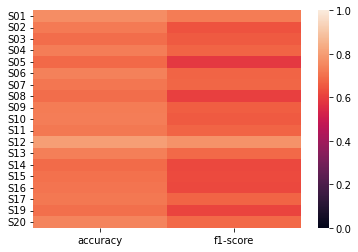

     class0 f1-score  class1 f1-score
S01         0.850394         0.441176
S02         0.829091         0.229508
S03         0.802920         0.307692
S04         0.830565         0.301370
S05         0.812950         0.037037
S06         0.840278         0.258065
S07         0.812950         0.380952
S08         0.811881         0.149254
S09         0.830065         0.257143
S10         0.833876         0.260870
S11         0.823970         0.298507
S12         0.871795         0.556962
S13         0.829787         0.368421
S14         0.808219         0.200000
S15         0.816054         0.179104
S16         0.826230         0.131148
S17         0.819923         0.338028
S19         0.813333         0.176471
S20         0.842466         0.323529


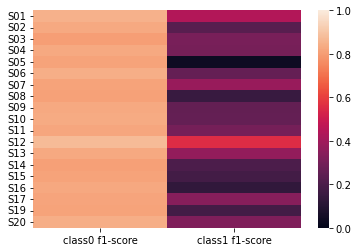

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [9]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [10]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

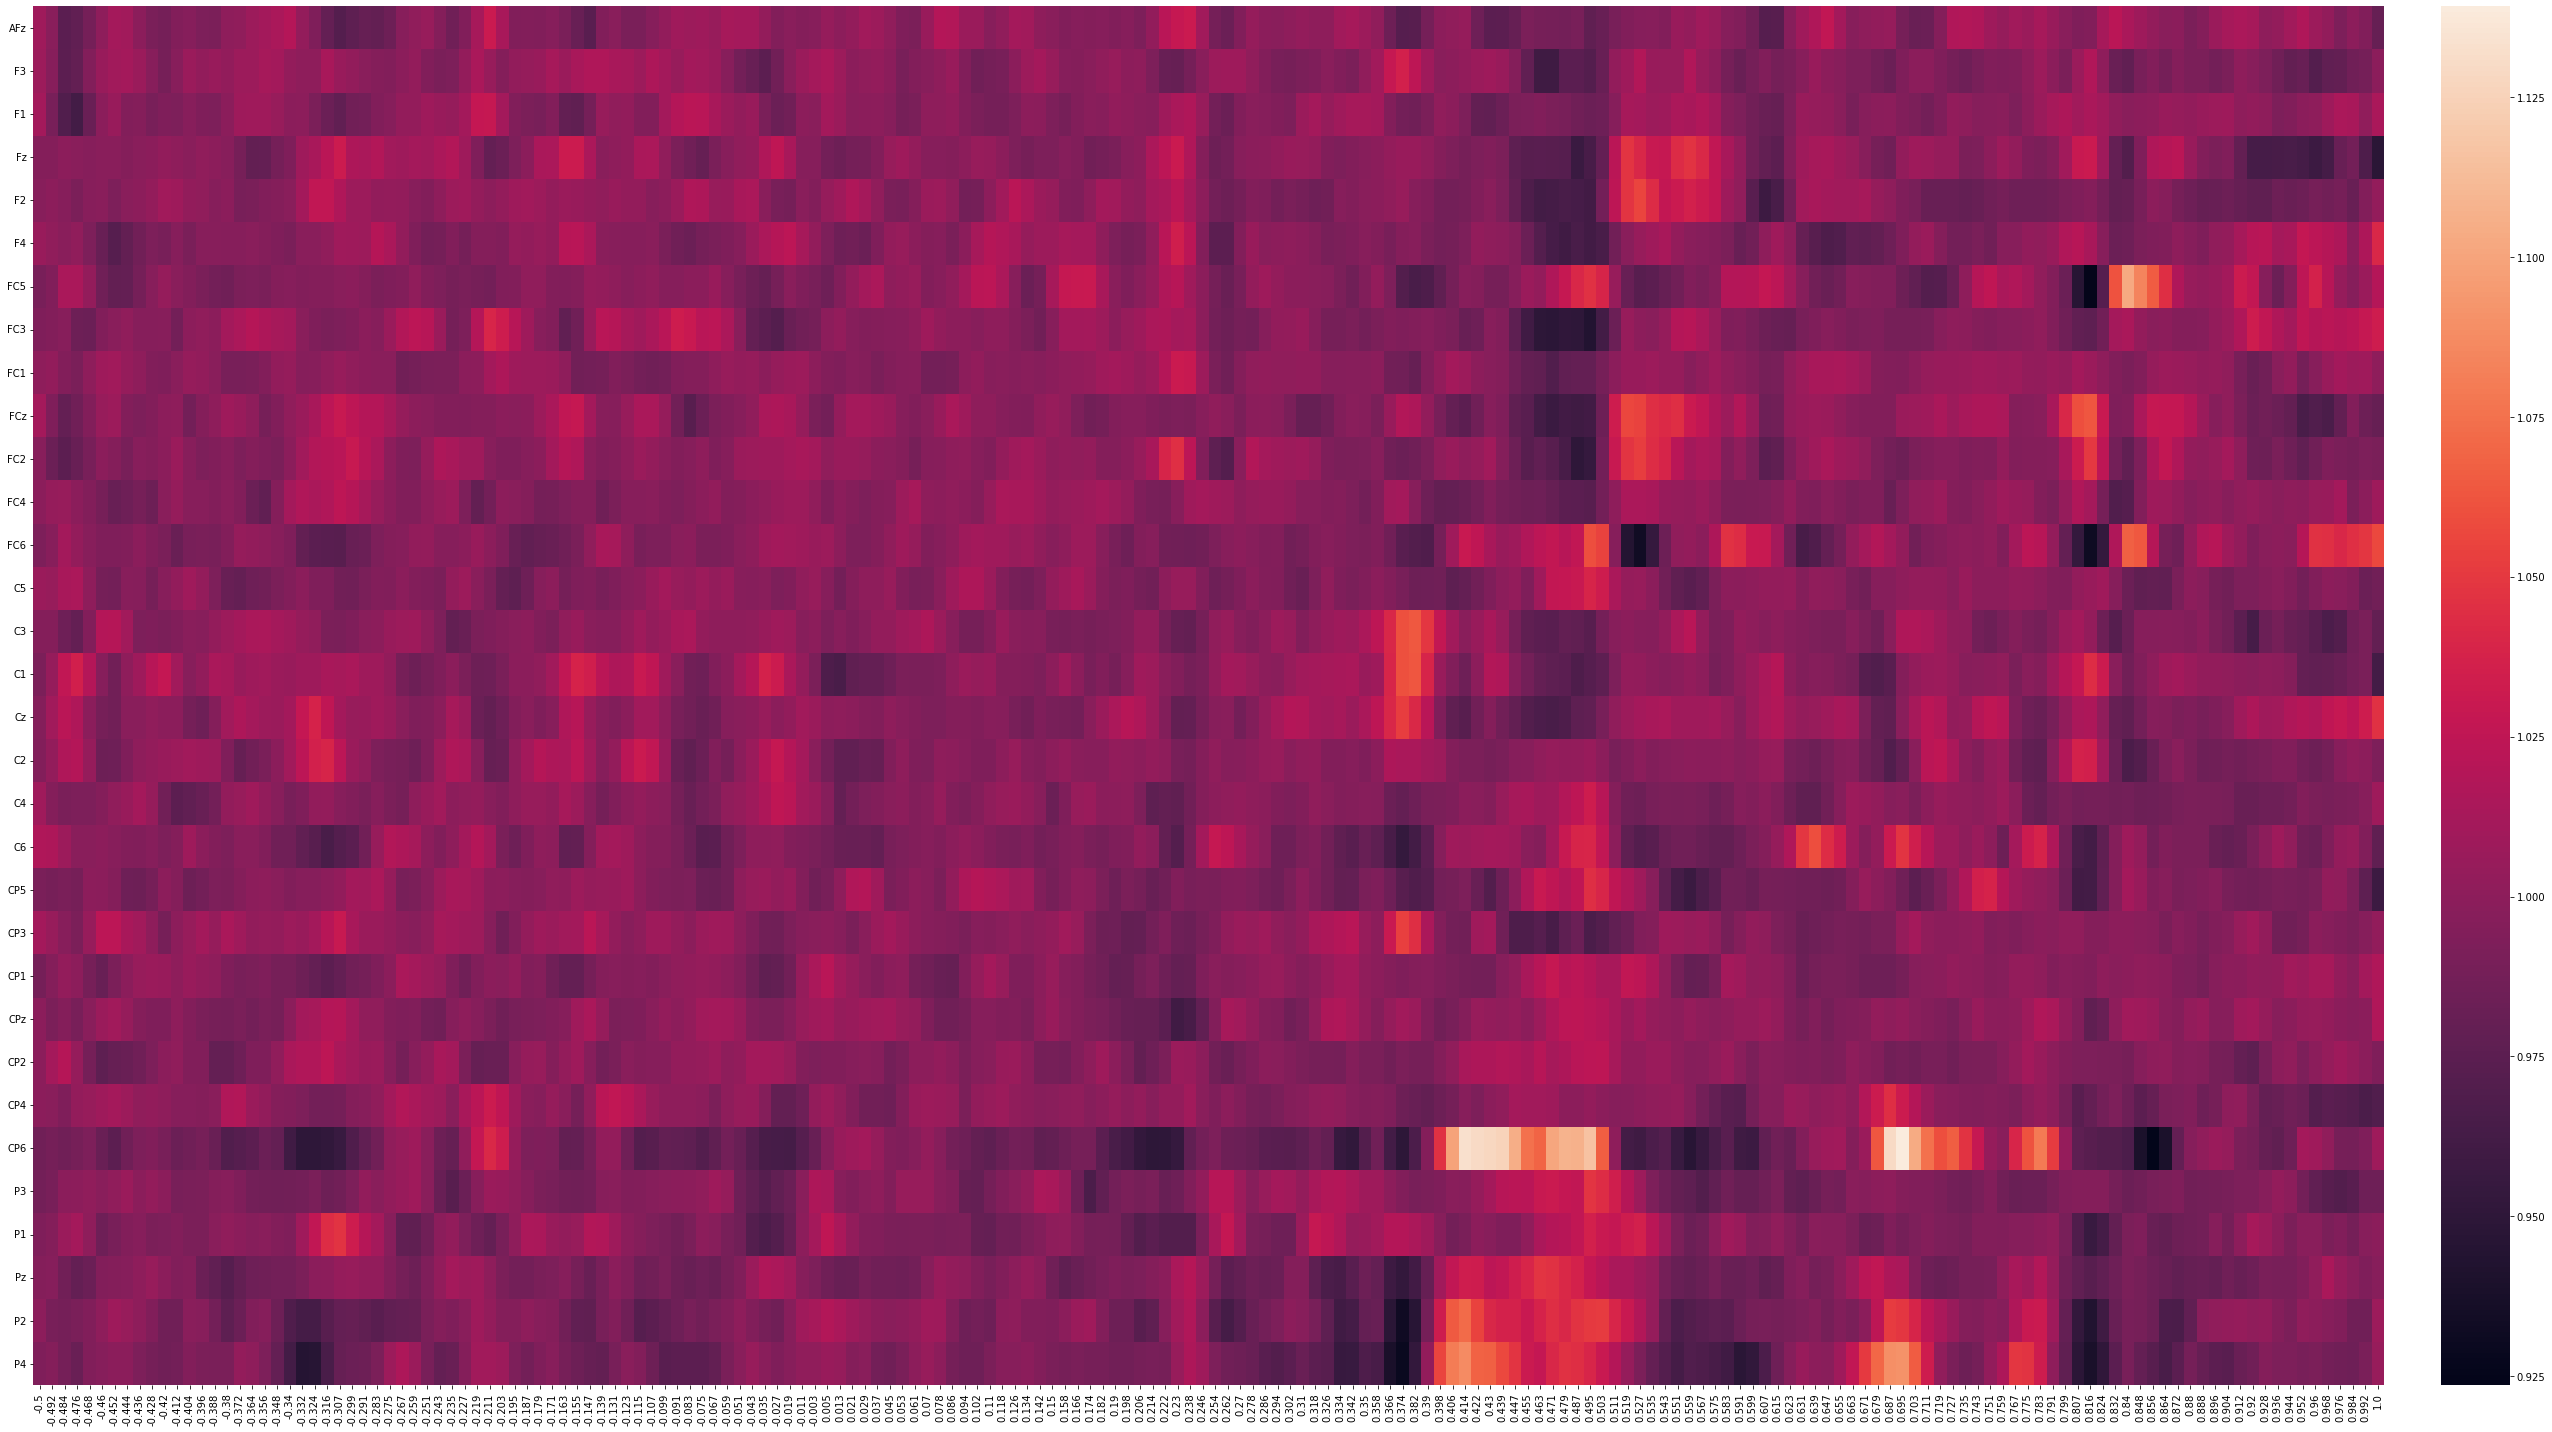

In [11]:
# fig, ax= plt.subplots(3,1)
fig =plt.figure()
sns.heatmap(pd.DataFrame(avg_w), 
            xticklabels=timestep_labels,
            yticklabels=channel_names, 
            annot=False, cbar_kws={"pad":0.02})

# ax[0].set_title("AUC")

# sns.heatmap(pd.DataFrame(avg_grad["ROC"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[1],
#             annot=False, cbar_kws={"pad":0.02})
# ax[1].set_title("ROC")

# sns.heatmap(pd.DataFrame(avg_grad["STD"]), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[2],
#             annot=False, cbar_kws={"pad":0.02})
# ax[2].set_title("STD")

# plt.suptitle("Relative Importance Estimate of Time Series")
fig.set_figwidth(40)
fig.set_figheight(20)
plt.tight_layout()

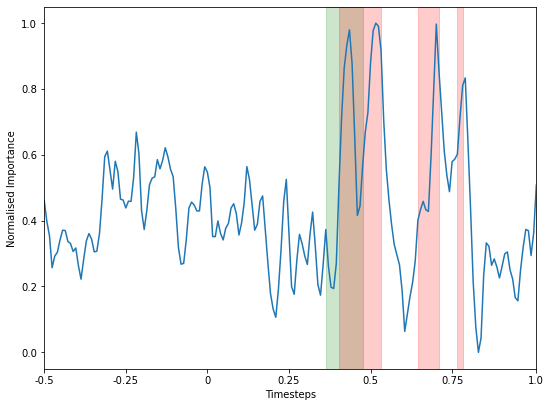

In [12]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

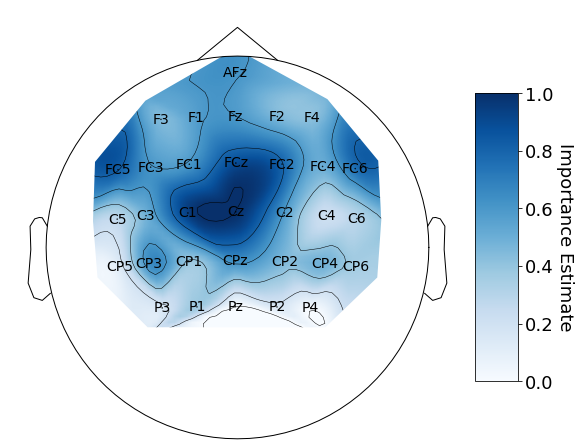

In [13]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)